# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/timePoints/1014rep_50noiseLevel_GMA_2ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/timePoints/1015rep_50noiseLevel_GMA_2ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/timePoints/1016rep_50noiseLevel_GMA_2ptPerHr_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/timePoints/1014rep_50noiseLevel_GMA_2ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/timePoints/1015rep_50noiseLevel_GMA_2ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/timePoints/1016rep_50noiseLevel_GMA_2ptPerHr_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 2
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.311391        0.189927  0.048388  0.295999  0.020291   
       0.5    0.292249        0.177603  0.062002  0.211106  0.102736   
       1.0    0.313627        0.180926  0.071015  0.199202  0.133750   
       1.5    0.346526        0.165052  0.081091  0.175273  0.156526   
       2.0    0.318457        0.145360  0.093428  0.156104  0.180415   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.201482  0.010319  0.040935  0.051328  0.000000  
       0.5   0.183952  0.009104  0.037749  0.048898  0.001653  
       1.0   0.203141  0.007096  0.036901  0.052135  0.003607  
       1.5   0.211049  0.005014  0.033137  0.051608  0.005848  
       2.0   0.224148  0.004292  0.035359  0.044488  0.007977

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.285361        0.203451  0.053860  0.318371  0.020249   
       0.5    0.308274        0.196603  0.060964  0.224242  0.094752   
       1.0    0.317360        0.179645  0.077999  0.181647  0.122987   
       1.5    0.307029        0.182926  0.090271  0.168561  0.163895   
       2.0    0.326584        0.137420  0.089747  0.153828  0.172471   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.202172  0.009839  0.040488  0.049874  0.000000  
       0.5   0.206528  0.009993  0.036545  0.048200  0.001526  
       1.0   0.227350  0.006941  0.035193  0.048694  0.003941  
       1.5   0.219343  0.004931  0.034645  0.044873  0.005571  
       2.0   0.223260  0.004285  0.034436  0.049723  0.008520

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.307520        0.208194  0.051695  0.316037  0.018968   
       0.5    0.323452        0.183934  0.064795  0.207885  0.103449   
       1.0    0.314338        0.157703  0.078747  0.192643  0.138741   
       1.5    0.345447        0.172221  0.086994  0.160609  0.160521   
       2.0    0.308384        0.149602  0.089359  0.145484  0.157237   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.212359  0.010137  0.040349  0.053594  0.000000  
       0.5   0.188779  0.009004  0.037419  0.051516  0.001417  
       1.0   0.210899  0.006495  0.034238  0.050457  0.003808  
       1.5   0.213713  0.005276  0.035586  0.045361  0.006014  
       2.0   0.215706  0.004094  0.034549  0.047547  0.008571

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.301424        0.200524  0.051314  0.310136  0.019836   
         0.5    0.296267        0.184618  0.069373  0.213087  0.101681   
         1.0    0.285831        0.170430  0.089439  0.191736  0.133573   
         1.5    0.283446        0.169733  0.093173  0.181715  0.165521   
         2.0    0.253433        0.139596  0.083386  0.177449  0.184797   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.205338  0.010099  0.040591  0.051599  0.000000  
         0.5   0.193076  0.009389  0.037237  0.050049  0.001012  
         1.0   0.213713  0.006968  0.035412  0.051729  0.002520  
         1.5   0.214564  0.005357  0.034321  0.049373  0.003902  
         2.0   0.221516  0.004609  0.034492  0.050311  0.005664

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.0   5.975196e+01  3.983424e+01      37.940737  5.956960e+01   
         0.5   5.631323e+06  3.440819e+06  332386.886543  2.260693e+06   
         1.0   6.106209e+06  4.732928e+06  470187.513075  3.032958e+06   
         1.5   6.050707e+06  5.274281e+06  557798.660645  3.688395e+06   
         2.0   6.300987e+06  5.415130e+06  571983.824353  3.644767e+06   

                                                                        \
                        PMK           PMD          GPPS            Idi   
Strain   Time                                                            
Strain 1 0.0   2.638142e+01  5.593531e+01  5.601897e+01      18.963723   
         0.5   7.047969e+05  3.796719e+06  3.143606e+06  649662.704514   
         1.0   9.834322e+05  5.741520e+06  3.667164e+06  890768.143153   
         1.5   1.195601e+06  6.498473e+06  3.995391e+06  999213.703551   
         2.0   1.167996e+06  6.982609e+06  4.175248e+06  955081.771468   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.0          31.311180  
         0.5      271789.074086  
         1.0      393123.234566  
         1.5      467733.123294  
         2.0      511687.118970

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


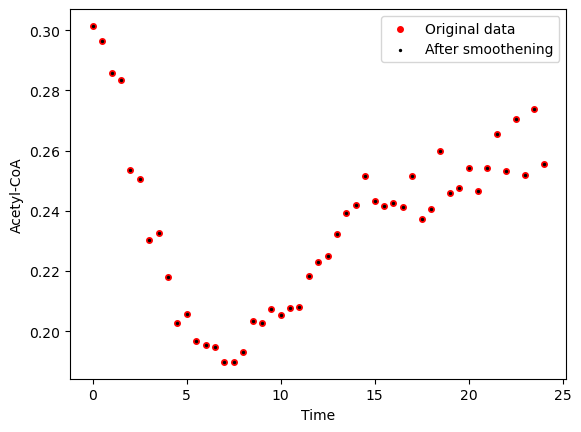

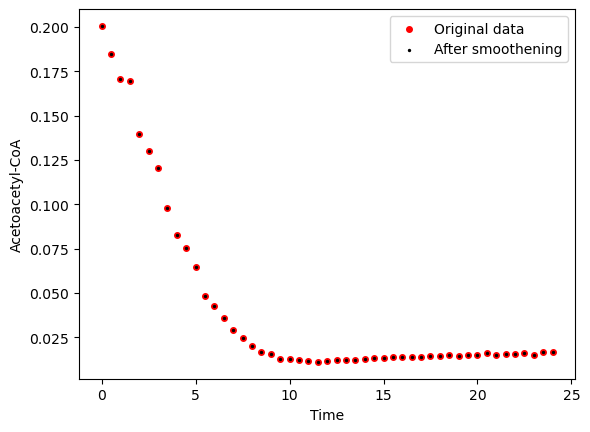

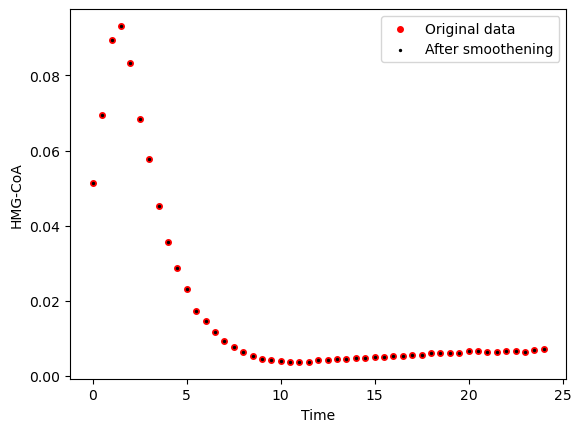

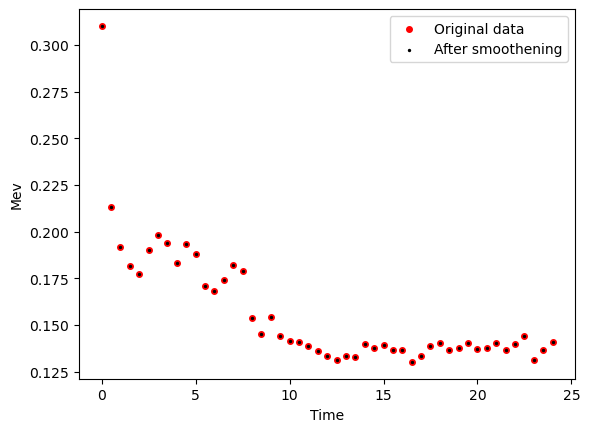

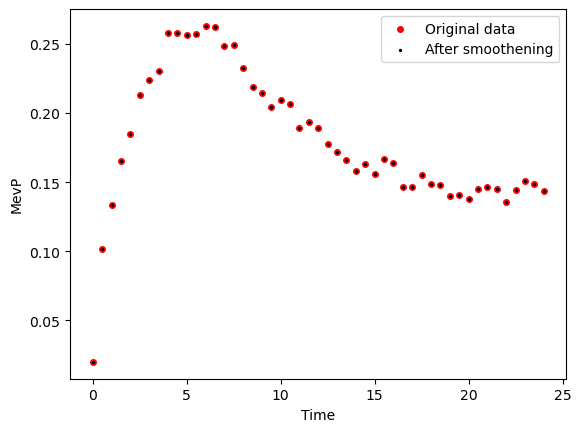

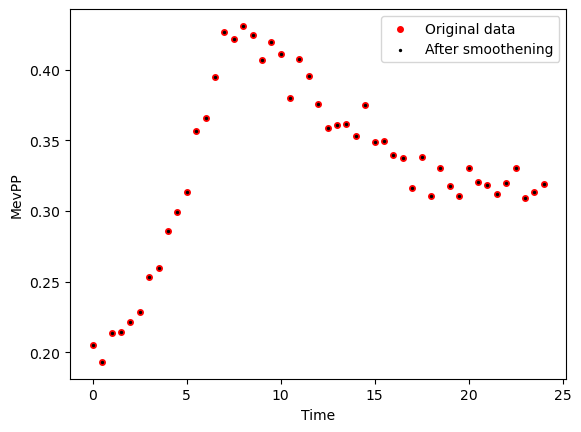

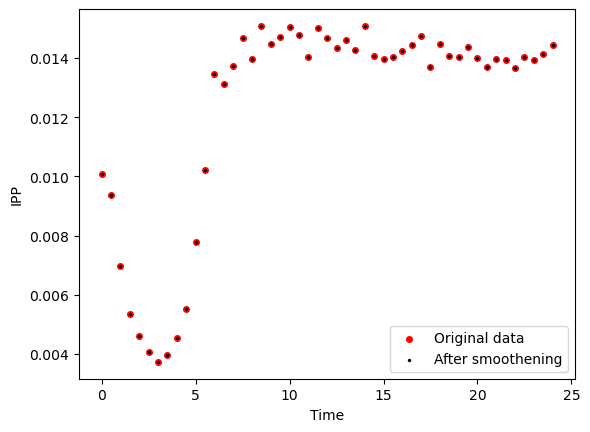

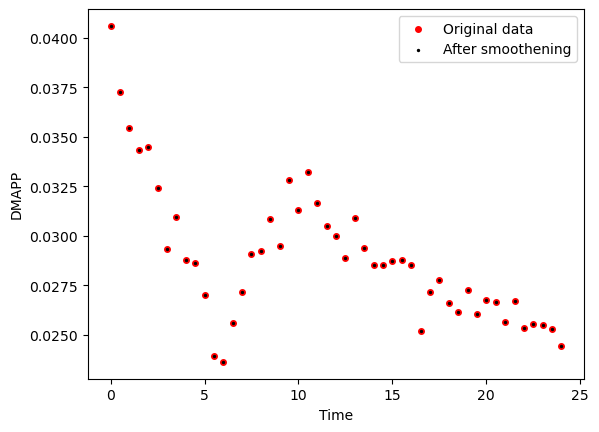

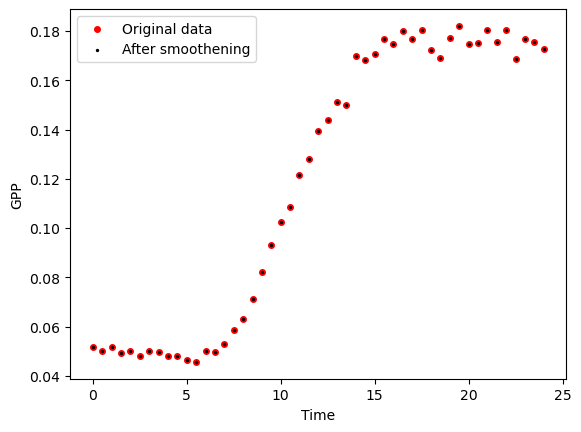

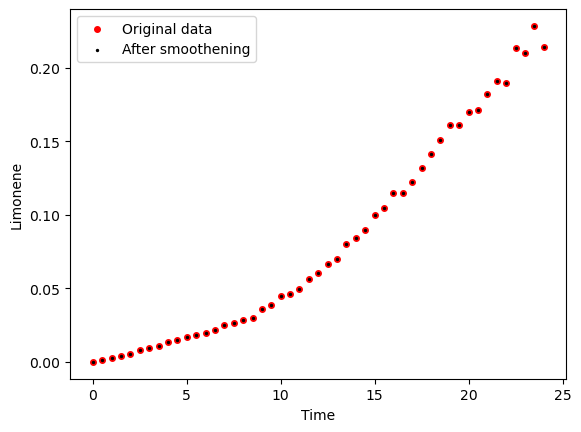

Strain Strain 2


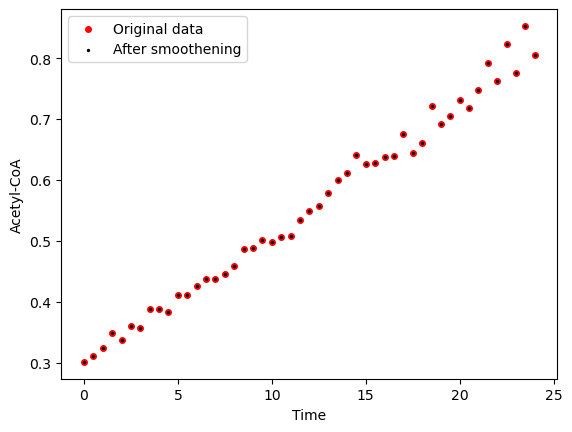

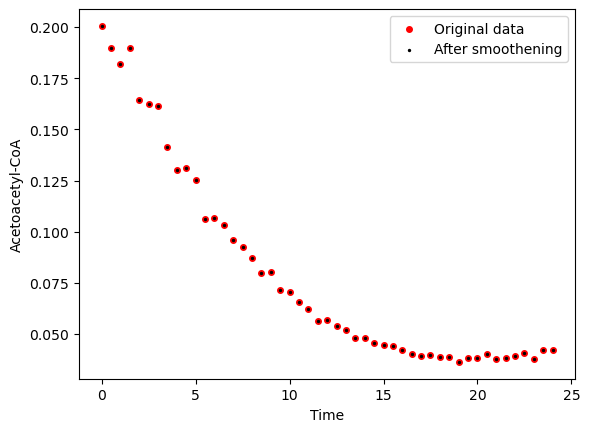

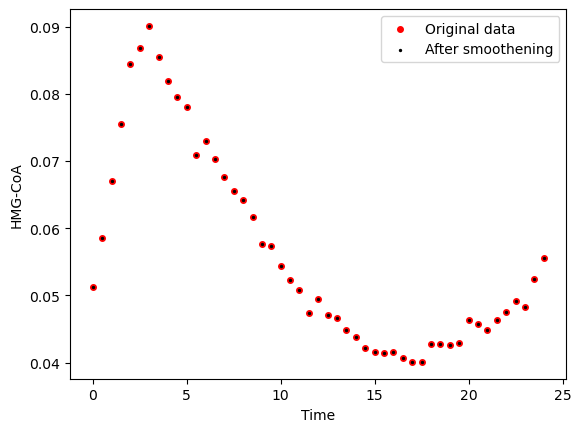

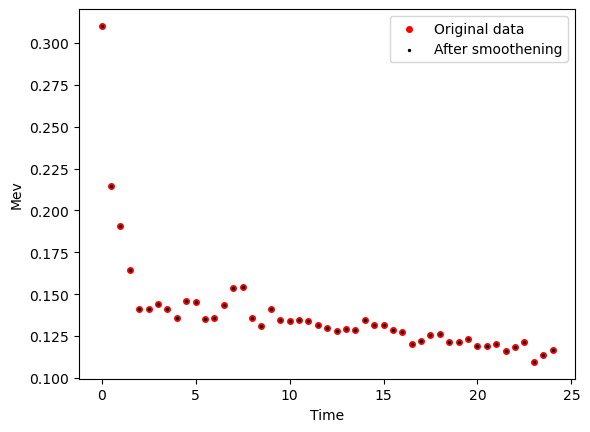

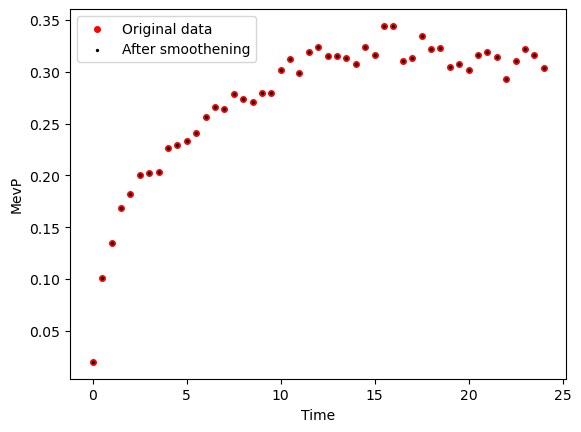

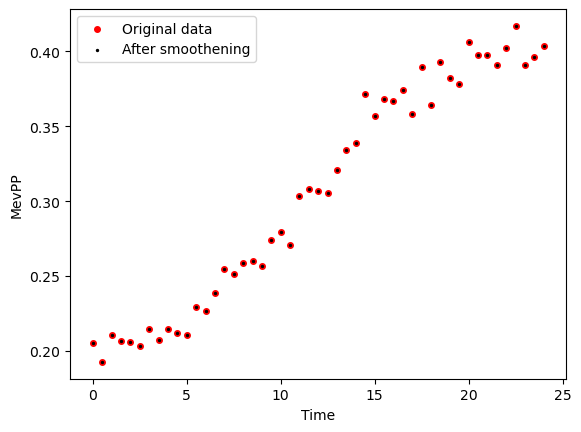

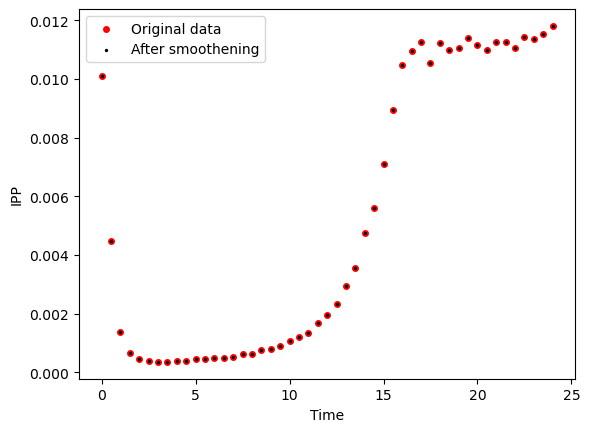

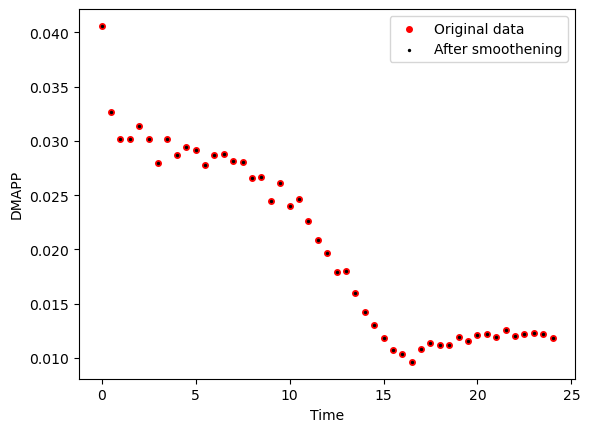

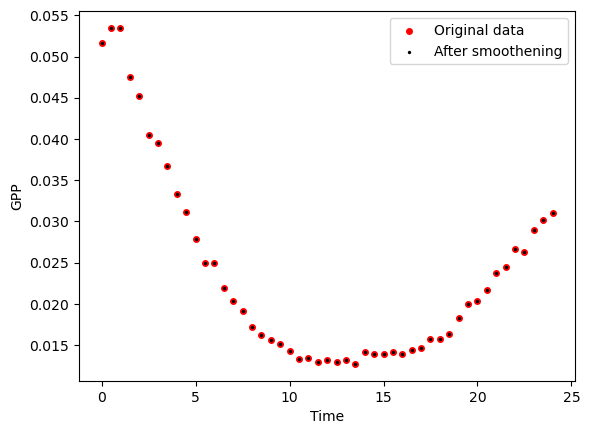

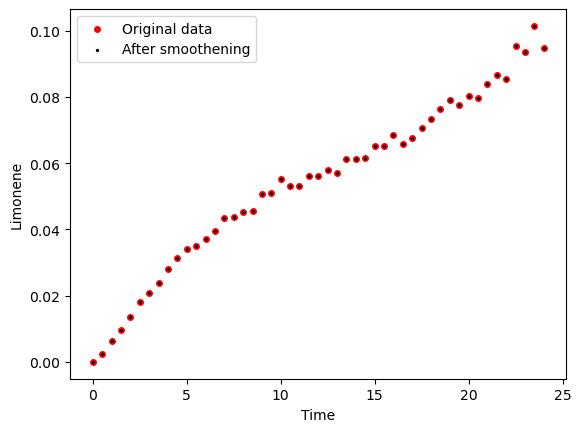

Strain Strain 3


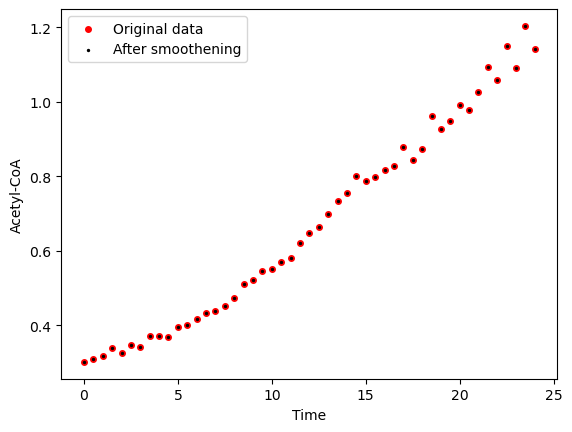

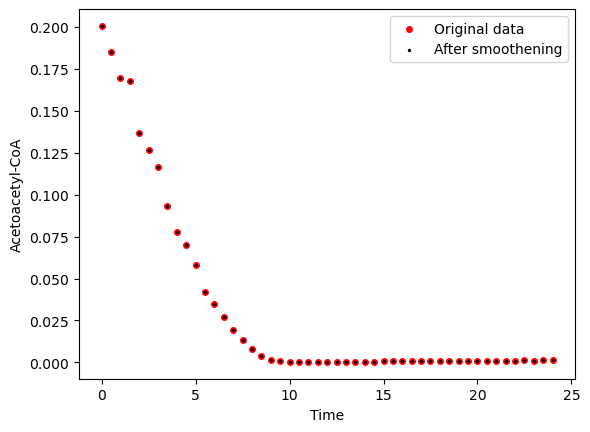

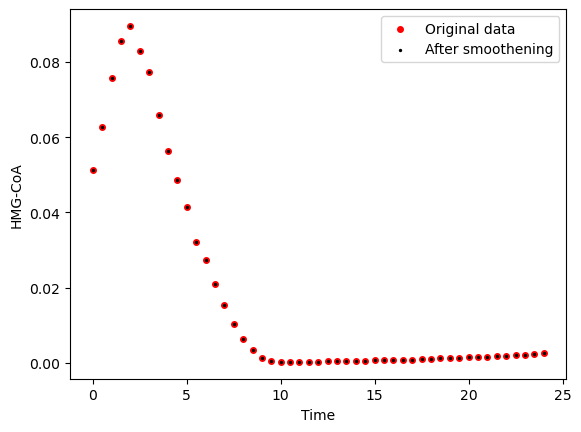

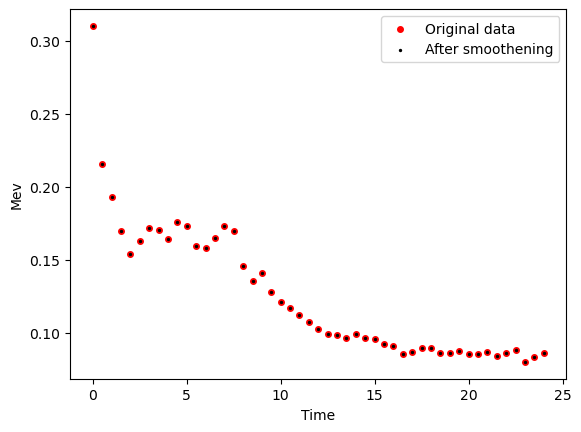

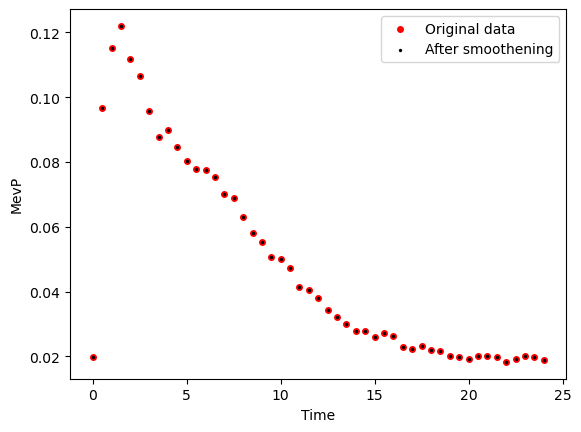

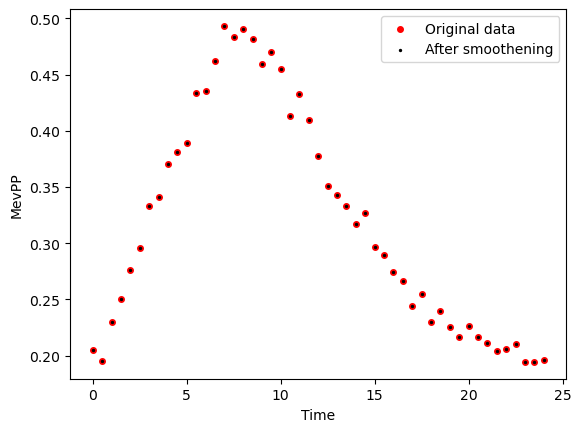

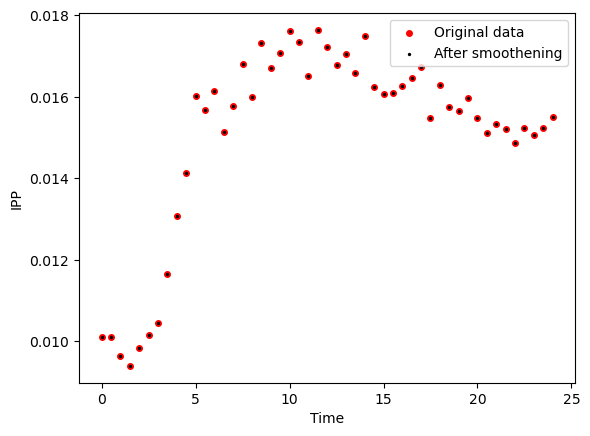

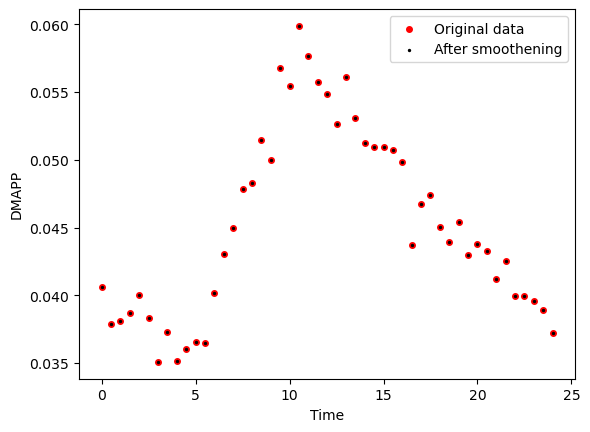

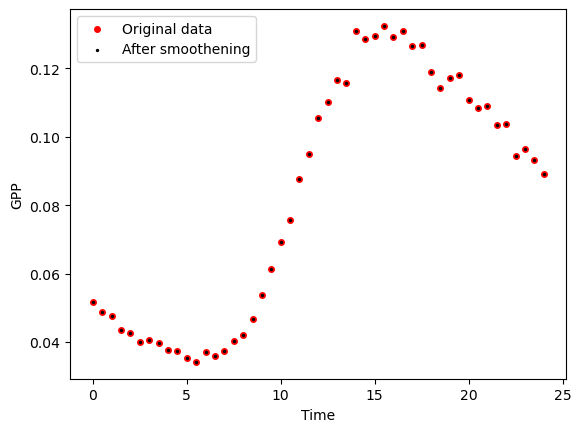

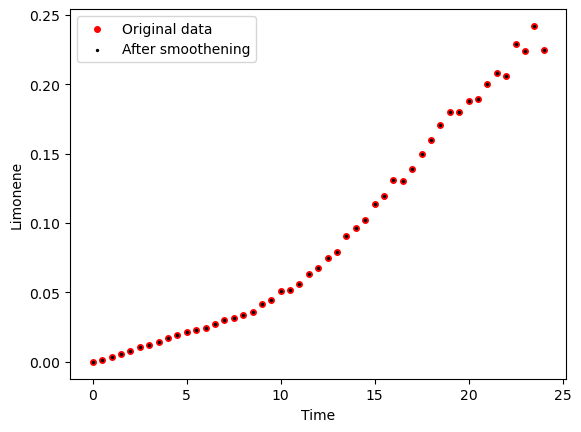

Strain WT


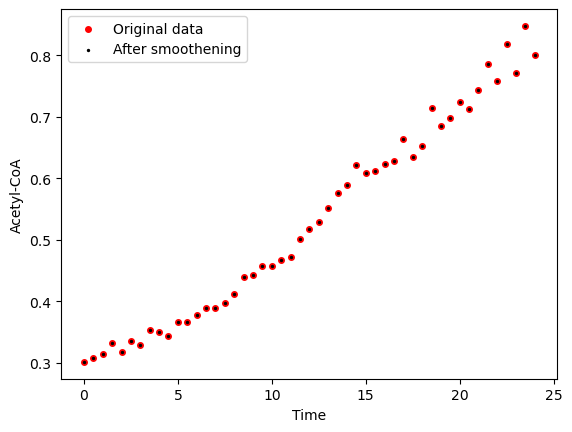

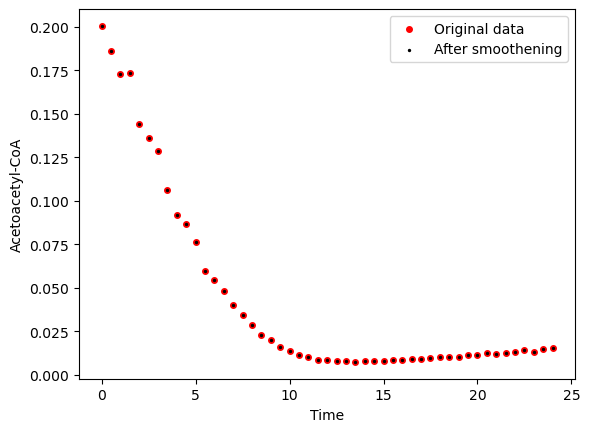

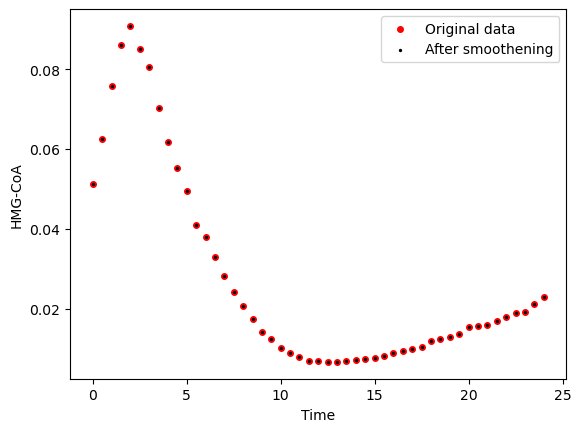

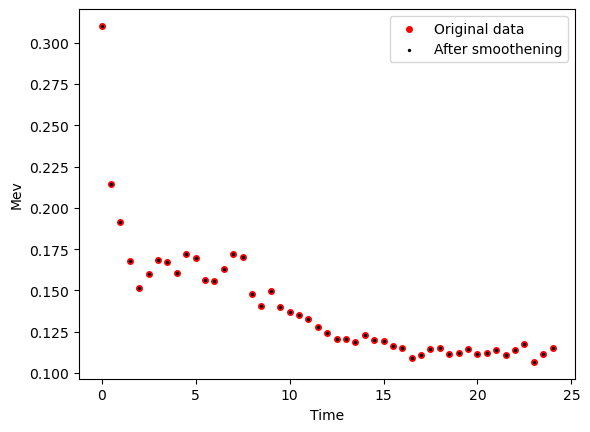

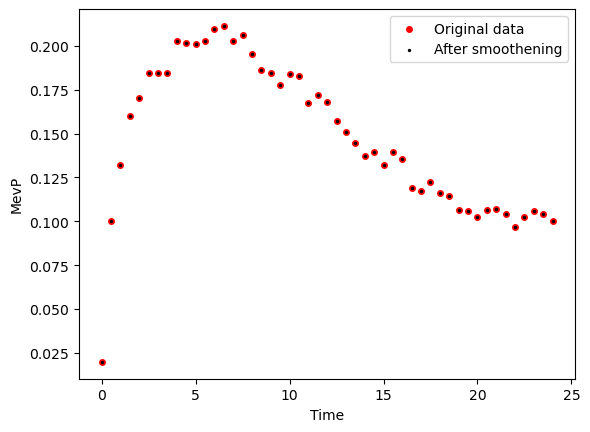

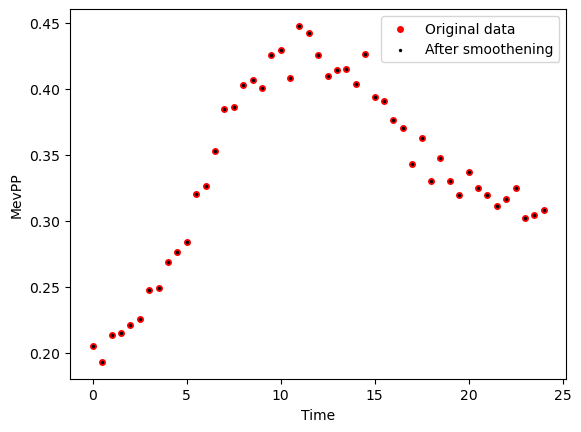

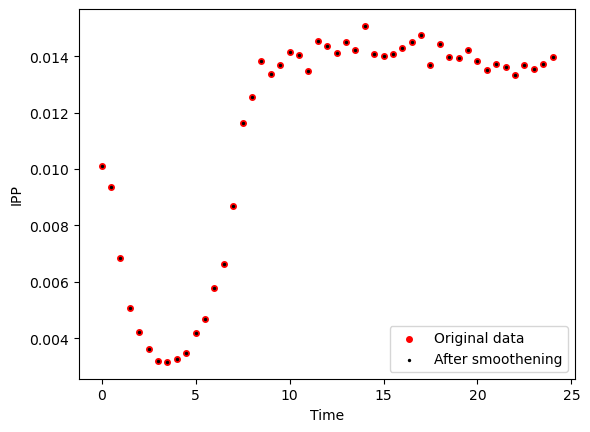

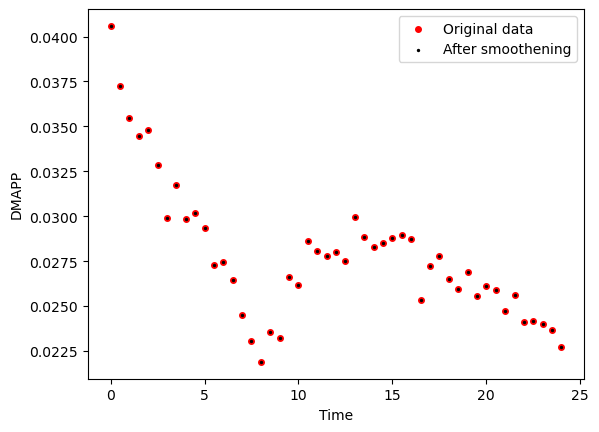

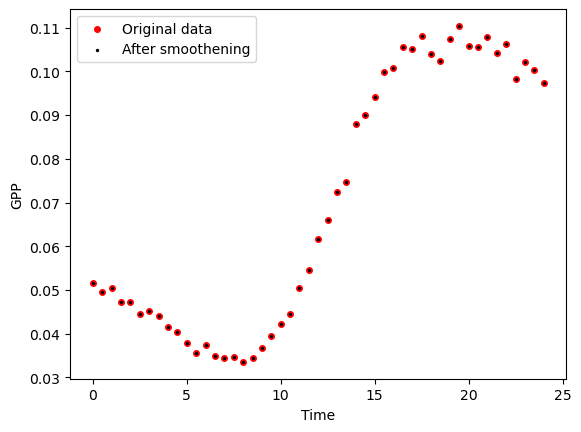

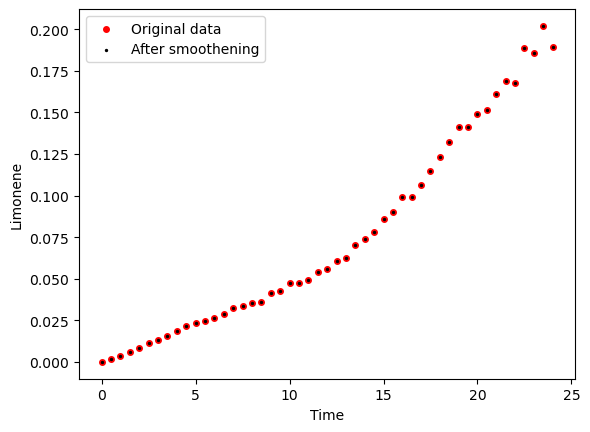

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


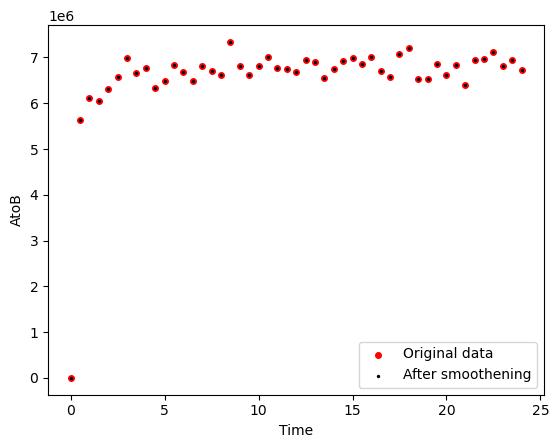

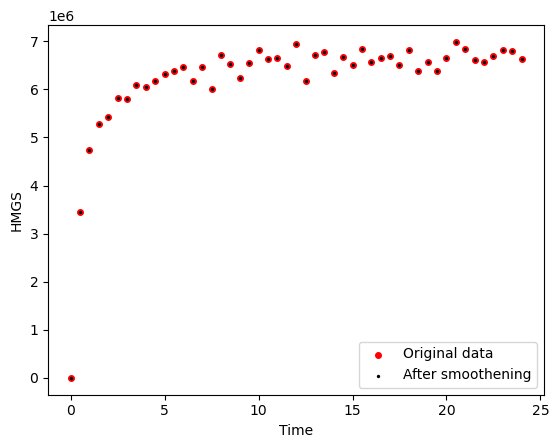

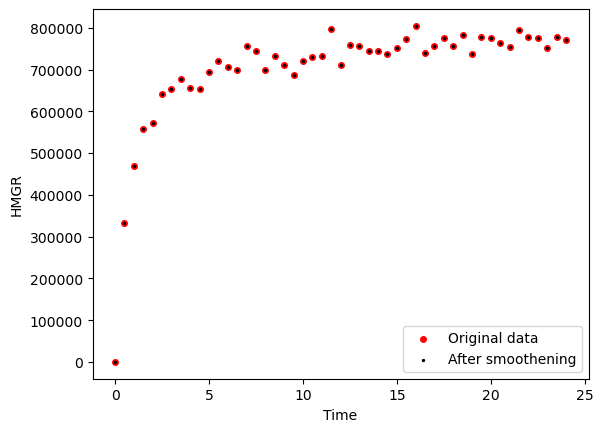

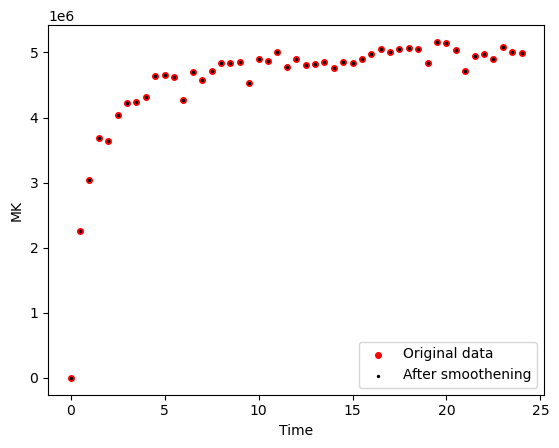

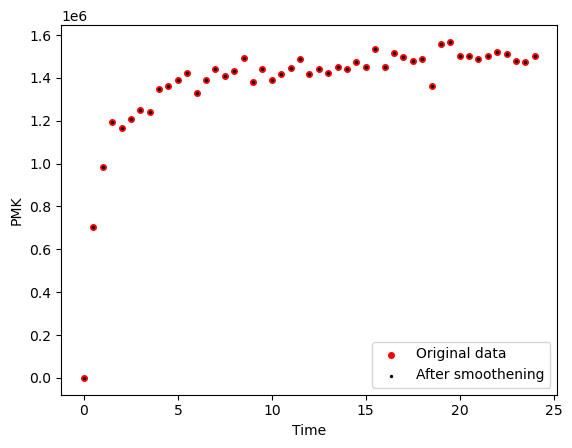

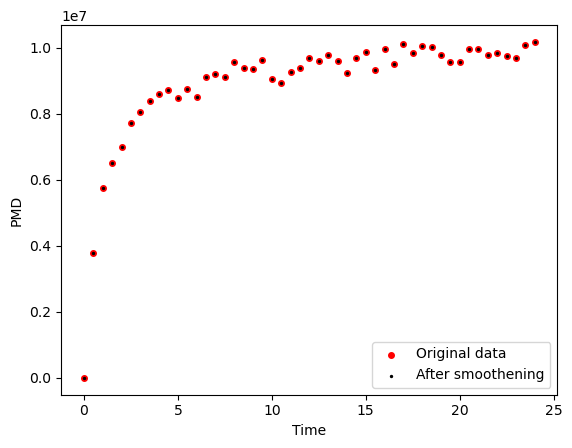

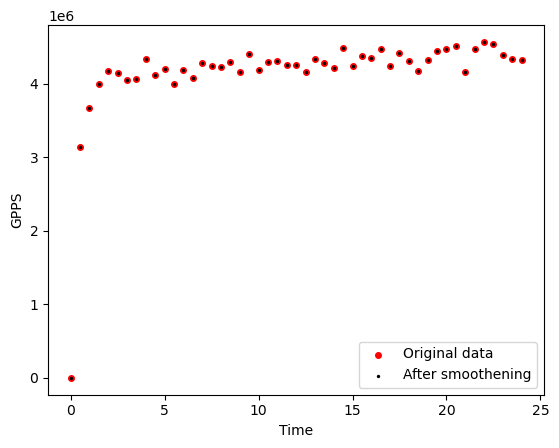

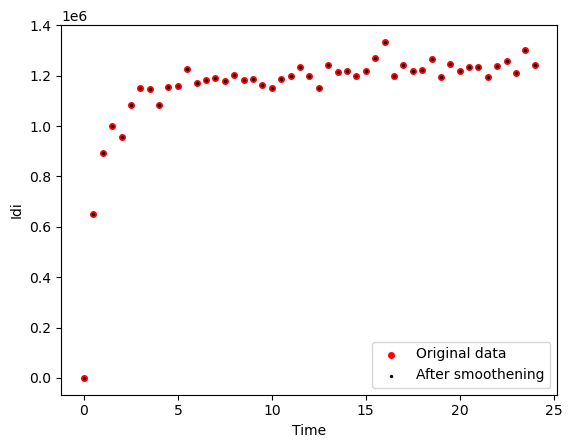

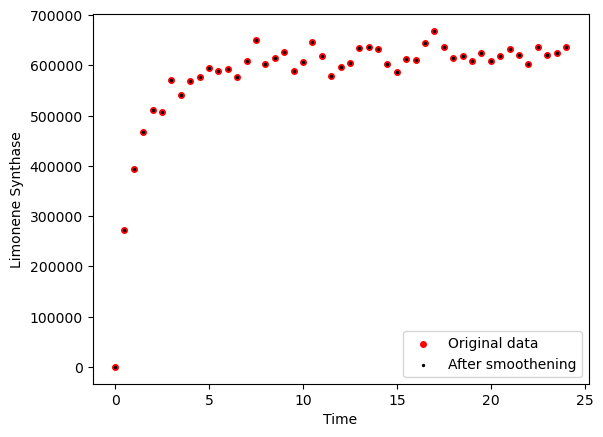

Strain Strain 2


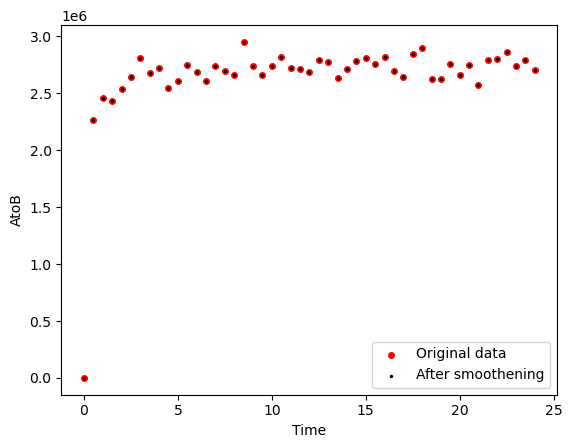

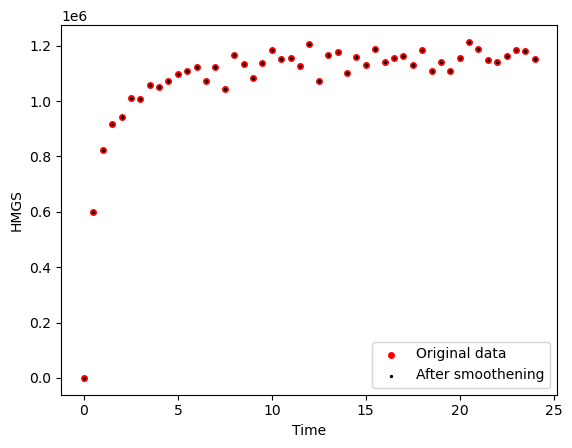

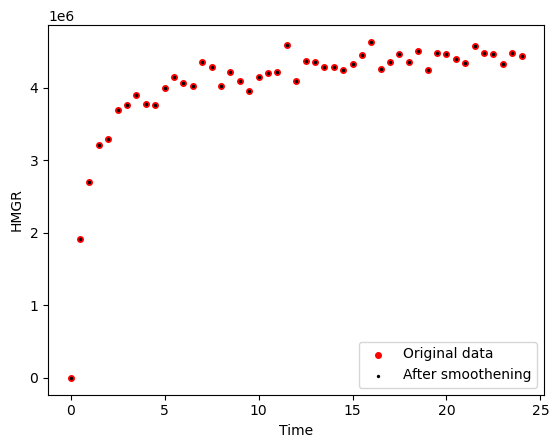

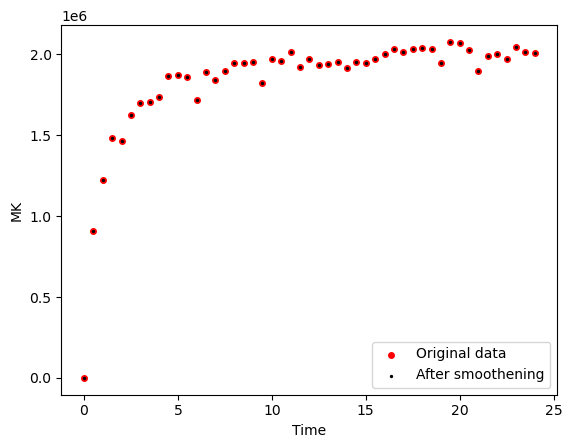

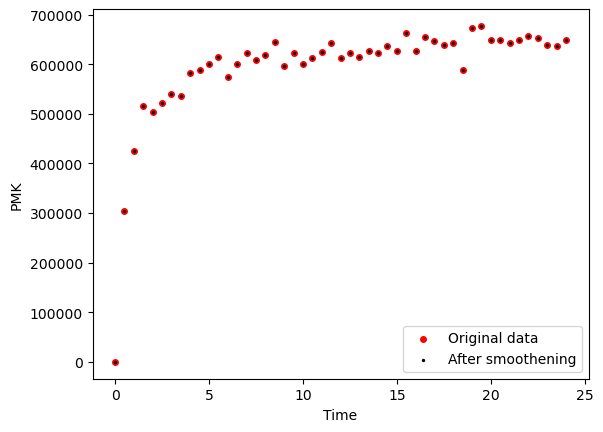

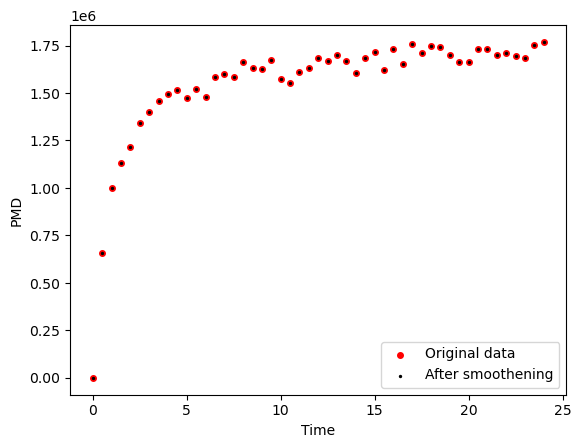

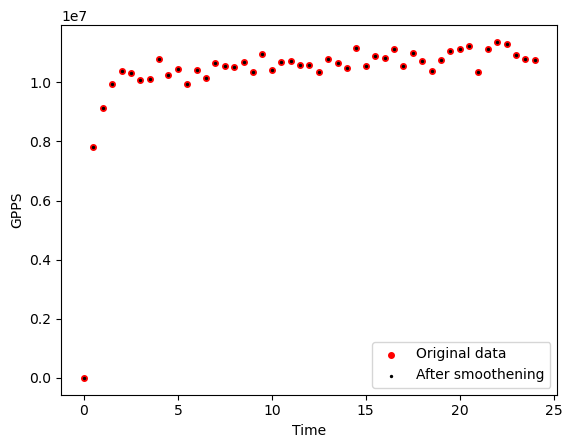

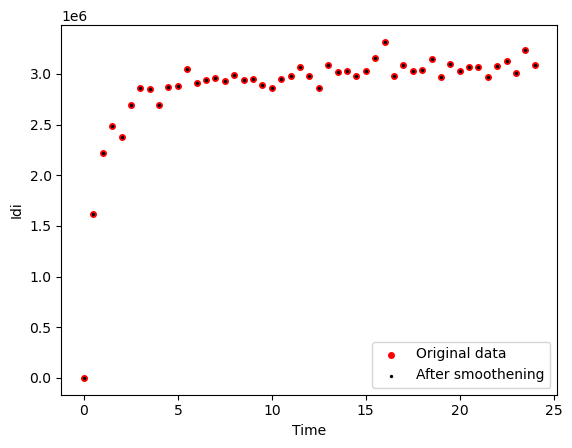

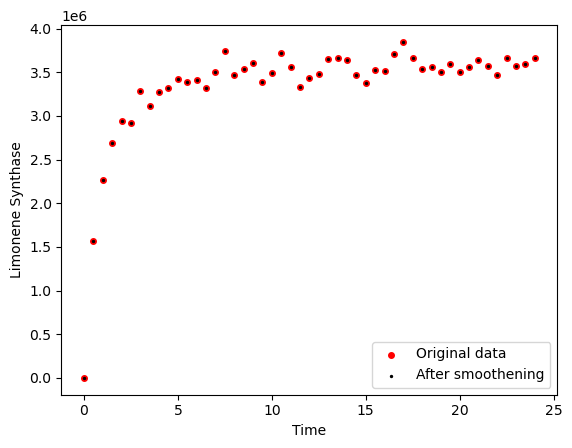

Strain Strain 3


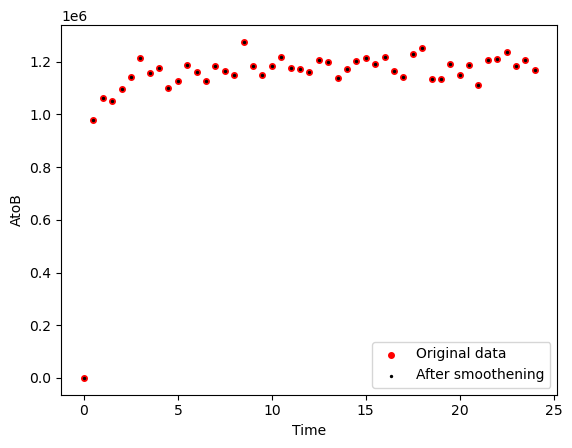

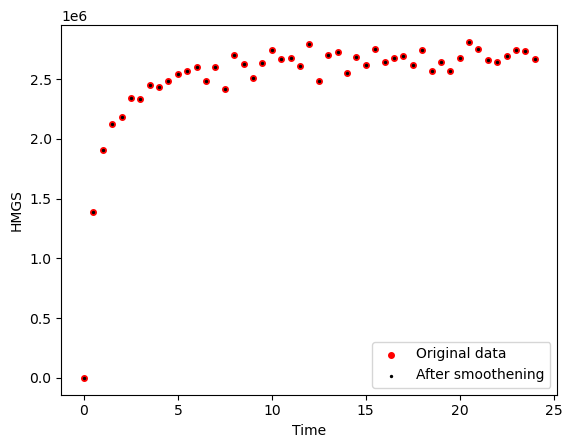

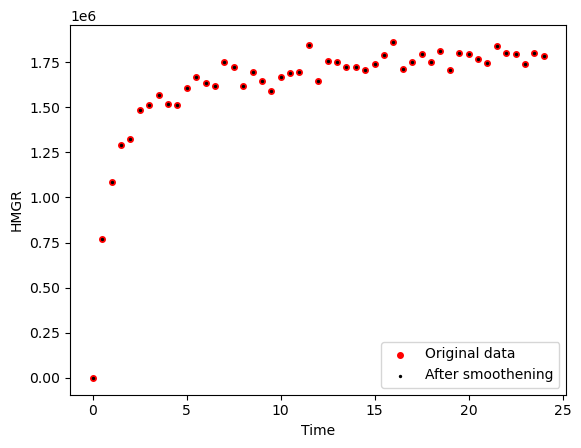

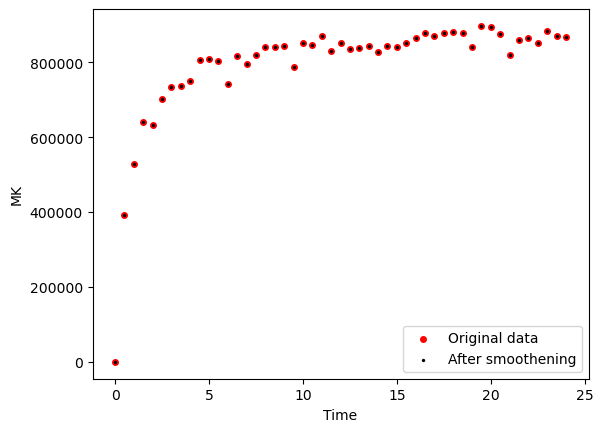

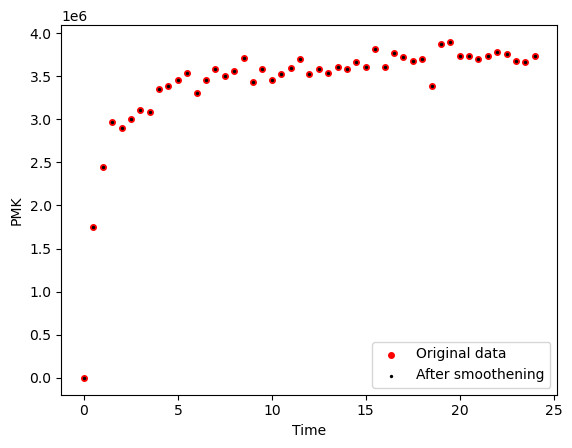

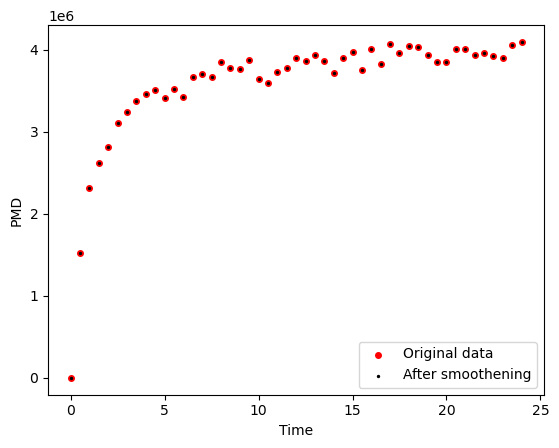

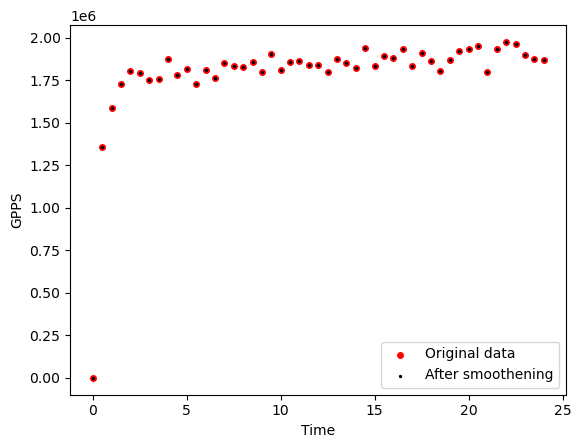

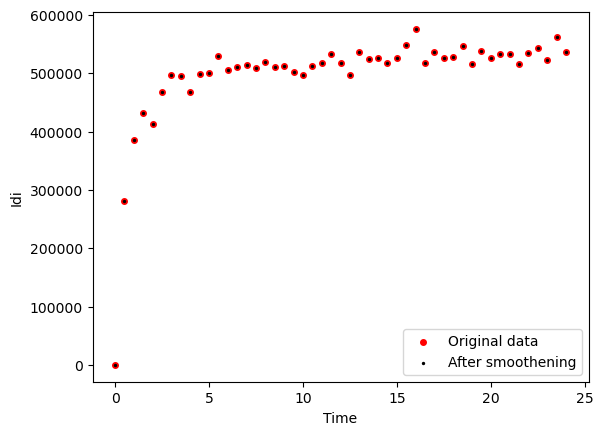

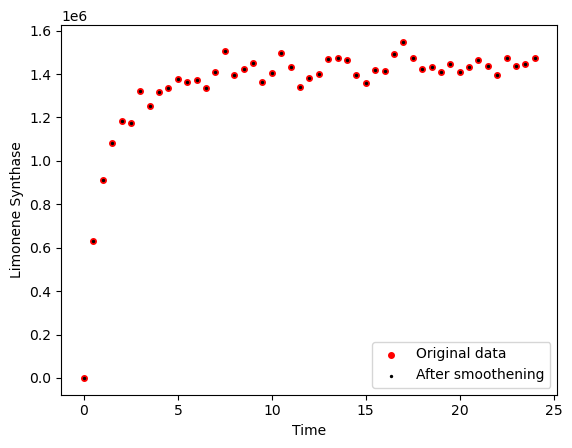

Strain WT


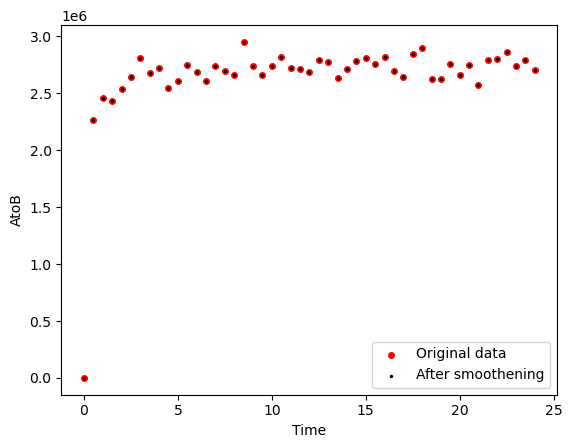

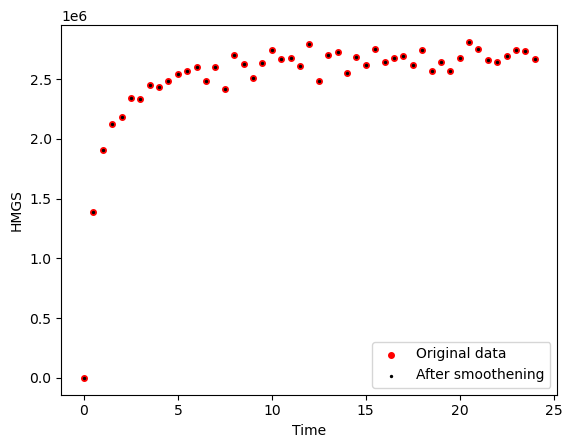

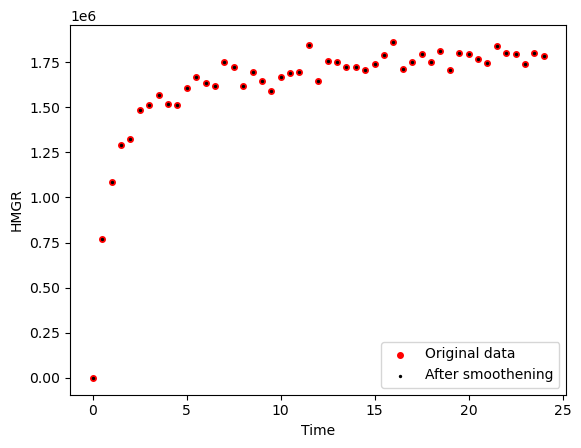

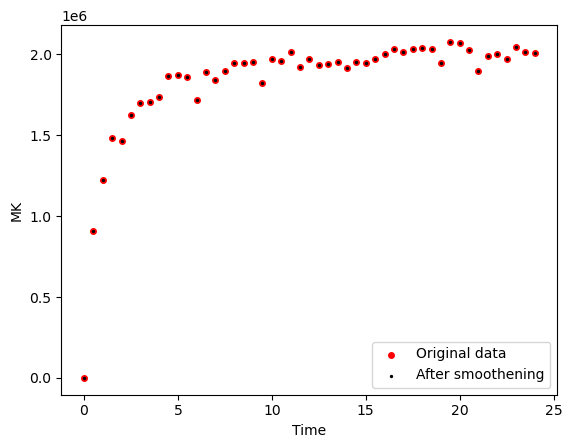

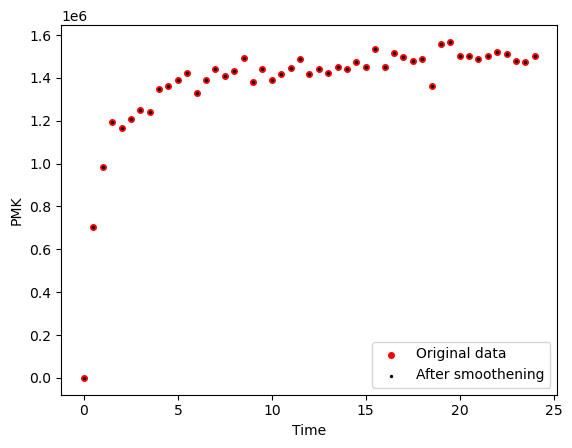

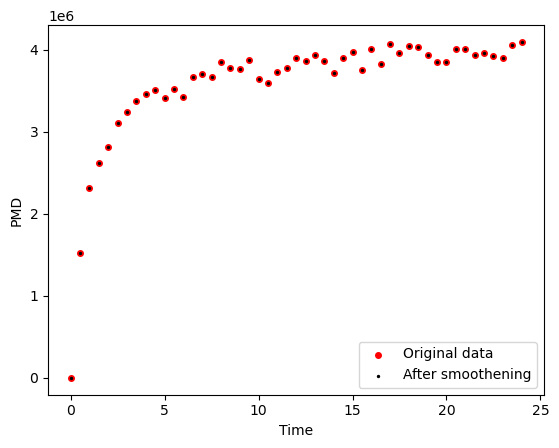

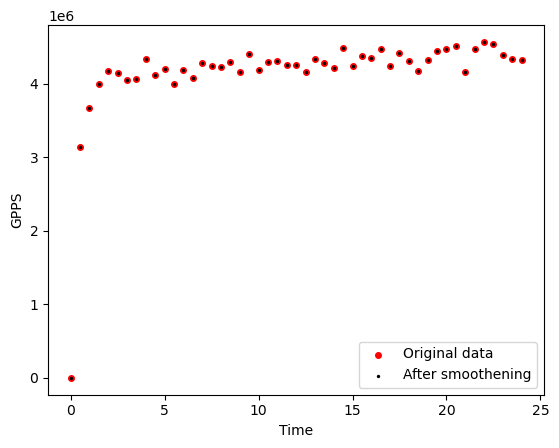

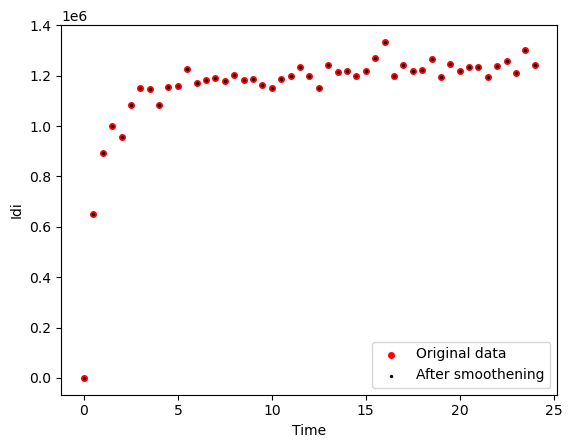

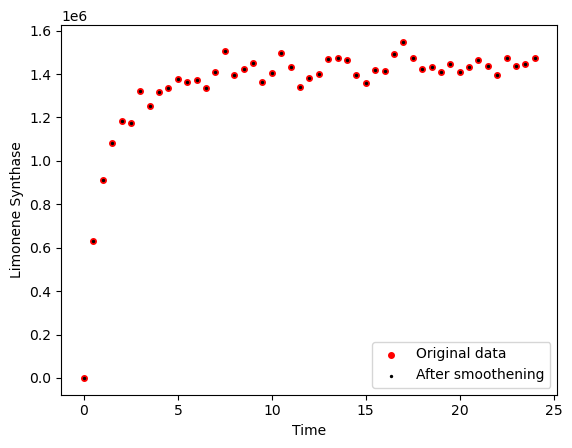

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative

df_allSmooth=estimate_state_derivative(df_allSmooth,3,2)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.301424        0.200524  0.051314  0.310136  0.019836   
         0.5    0.296267        0.184618  0.069373  0.213087  0.101681   
         1.0    0.285831        0.170430  0.089439  0.191736  0.133573   
         1.5    0.283446        0.169733  0.093173  0.181715  0.165521   
         2.0    0.253433        0.139596  0.083386  0.177449  0.184797   
...                  ...             ...       ...       ...       ...   
WT       22.0   0.757670        0.013393  0.017970  0.113830  0.097036   
         22.5   0.818530        0.014094  0.019034  0.117444  0.102332   
         23.0   0.771437        0.013407  0.019120  0.106759  0.105994   
         23.5   0.847724        0.015108  0.021174  0.111608  0.104014   
         24.0   0.799769        0.015343  0.022840  0.115072  0.100049   

                                                                 ...  \
                  MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                    ...   
Strain 1 0.0   0.205338  0.010099  0.040591  0.051599  0.000000  ...   
         0.5   0.193076  0.009389  0.037237  0.050049  0.001012  ...   
         1.0   0.213713  0.006968  0.035412  0.051729  0.002520  ...   
         1.5   0.214564  0.005357  0.034321  0.049373  0.003902  ...   
         2.0   0.221516  0.004609  0.034492  0.050311  0.005664  ...   
...                 ...       ...       ...       ...       ...  ...   
WT       22.0  0.316333  0.013338  0.024117  0.106287  0.168004  ...   
         22.5  0.324875  0.013685  0.024171  0.098331  0.188668  ...   
         23.0  0.301968  0.013542  0.023991  0.102162  0.185897  ...   
         23.5  0.304138  0.013714  0.023648  0.100217  0.202059  ...   
         24.0  0.308291  0.013972  0.022711  0.097317  0.189174  ...   

              derivatives                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.0    -0.005036       -0.033528  0.034108 -0.269793  0.213641   
         0.5    -0.015593       -0.030095  0.038125 -0.118400  0.113737   
         1.0    -0.012820       -0.014885  0.023800 -0.031373  0.063840   
         1.5    -0.032398       -0.030834 -0.006054 -0.014287  0.051224   
         2.0    -0.032859       -0.039876 -0.024795  0.008479  0.047738   
...                   ...             ...       ...       ...       ...   
WT       22.0    0.032677        0.001362  0.001993  0.006501 -0.002101   
         22.5    0.013767        0.000013  0.001150 -0.007071  0.008958   
         23.0    0.029194        0.001014  0.002139 -0.005836  0.001682   
         23.5    0.028332        0.001937  0.003720  0.008313 -0.005944   
         24.0   -0.220152       -0.000994  0.002946  0.005542 -0.009913   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0  -0.057423  0.000294 -0.008238 -0.006330  0.001528  
         0.5   0.008376 -0.003131 -0.005179  0.000130  0.002520  
         1.0   0.021489 -0.004032 -0.002916 -0.000676  0.002890  
         1.5   0.007803 -0.002359 -0.000920 -0.001418  0.003143  
         2.0   0.013545 -0.001297 -0.001918 -0.001119  0.003861  
...                 ...       ...       ...       ...       ...  
WT       22.0  0.014073  0.000051 -0.001418 -0.005956  0.019862  
         22.5 -0.014364  0.000204 -0.000126 -0.004125  0.017894  
         23.0 -0.020737  0.000029 -0.000523  0.001886  0.013391  
         23.5  0.006322  0.000430 -0.001280 -0.004845  0.003277  
         24.0  0.010287  0.000601 -0.002469 -0.006757 -0.054817

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

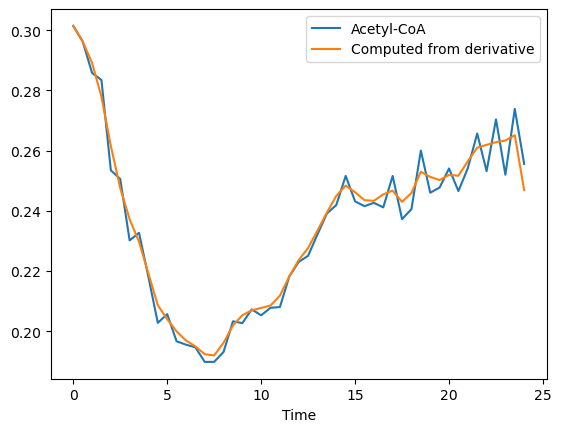

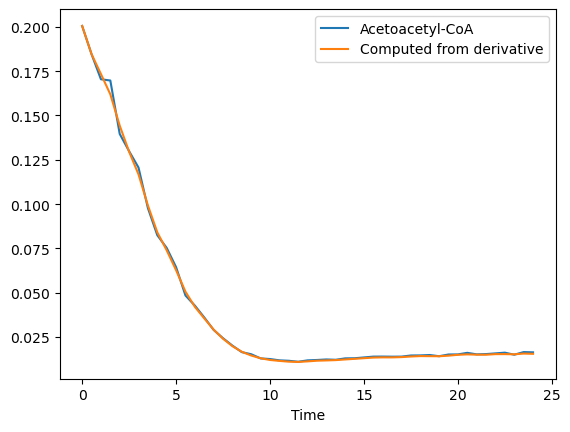

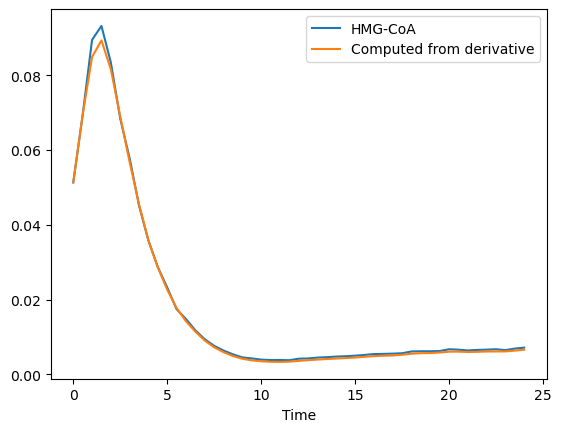

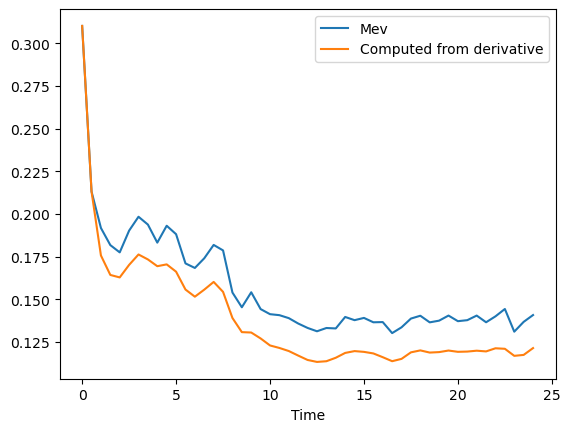

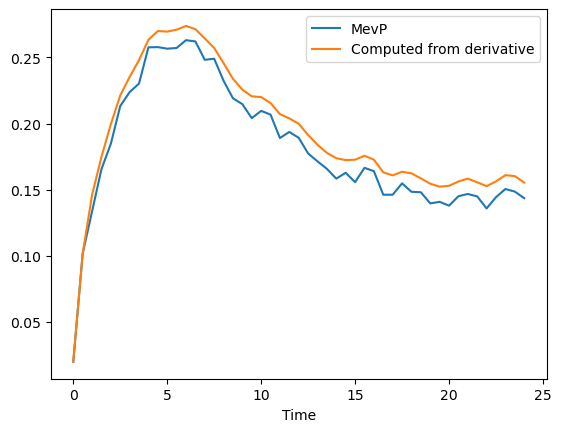

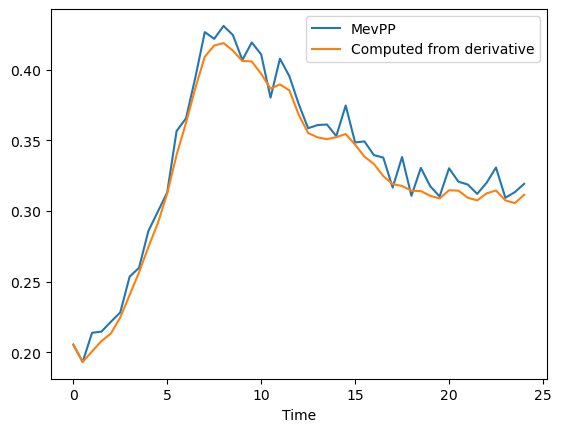

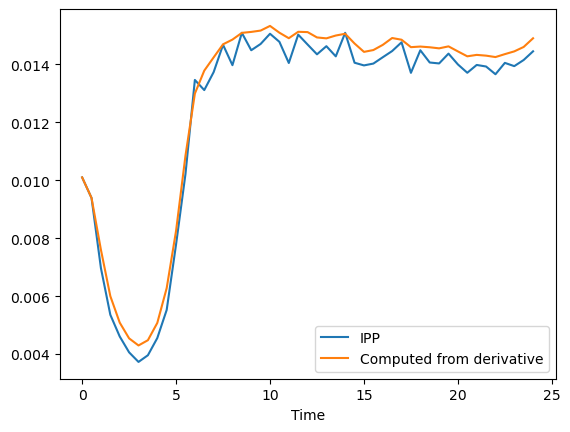

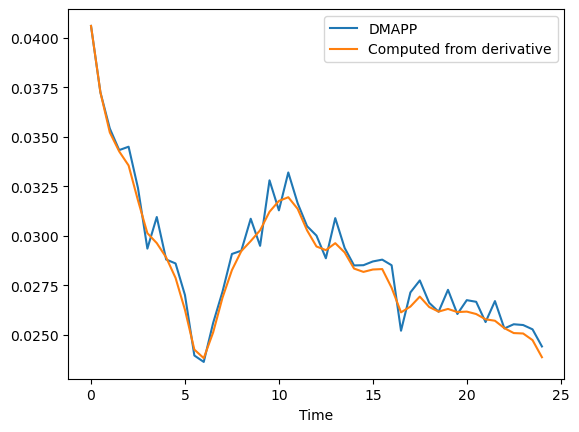

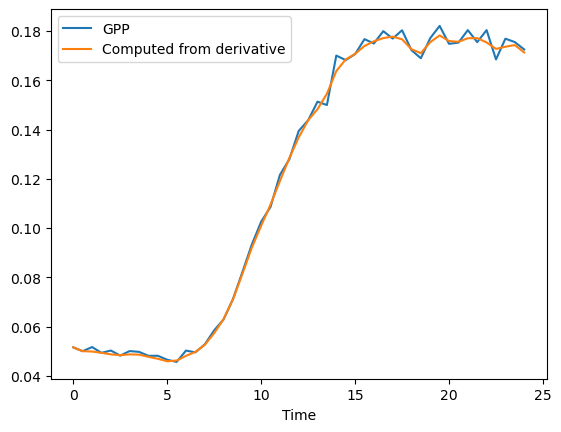

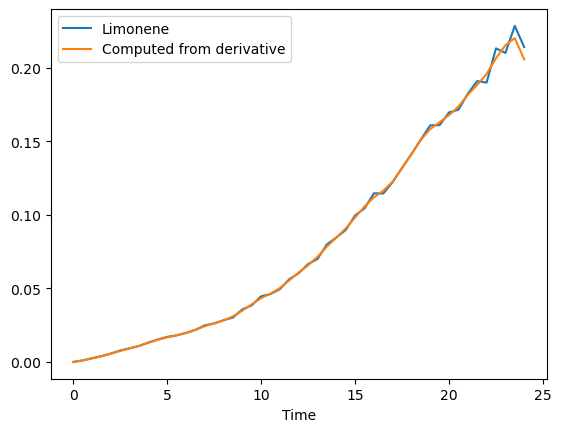

'Time profile from derivative vs. actual profile for Strain 2'

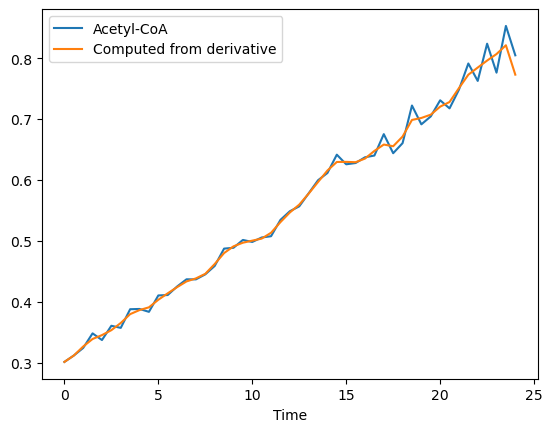

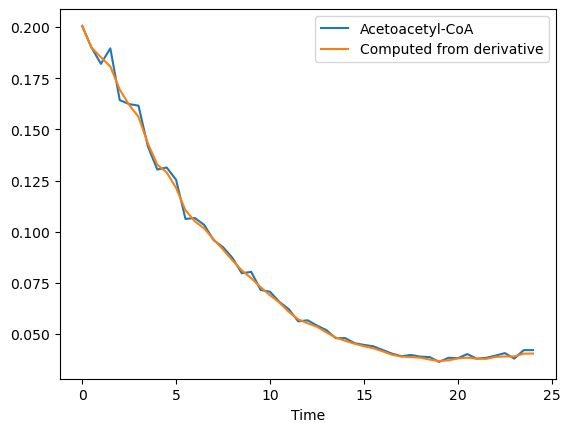

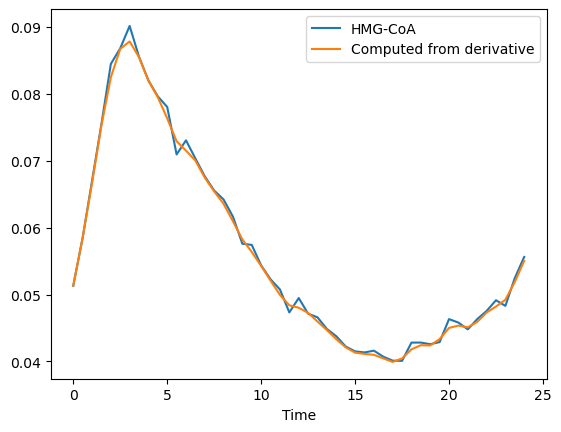

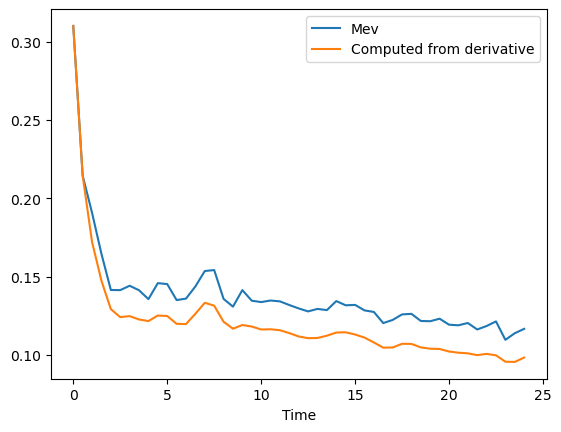

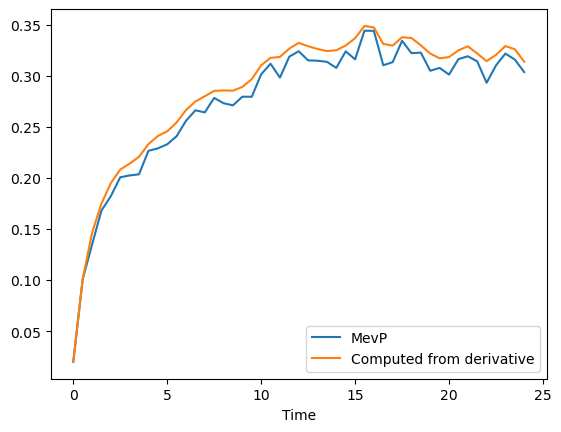

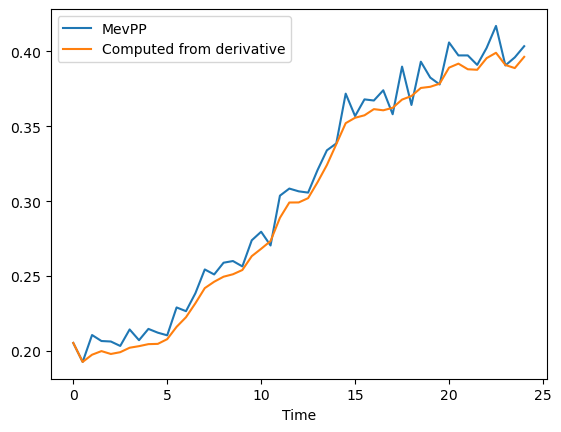

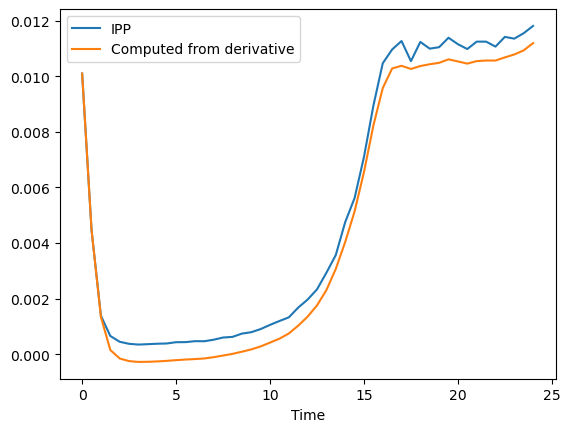

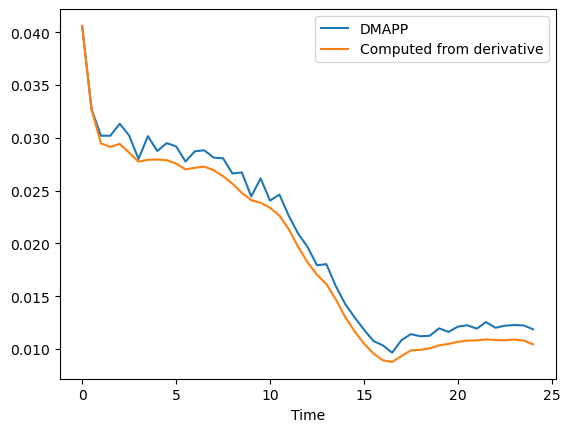

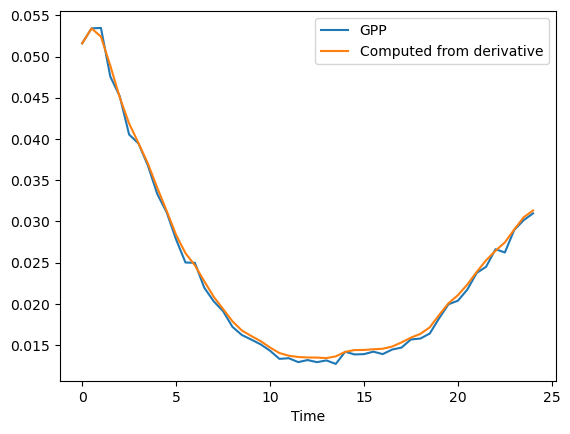

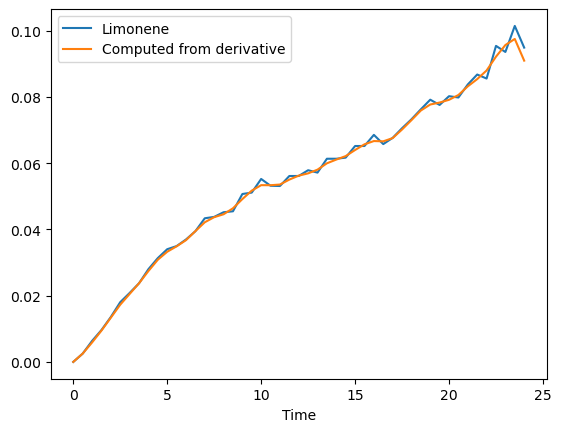

'Time profile from derivative vs. actual profile for Strain 3'

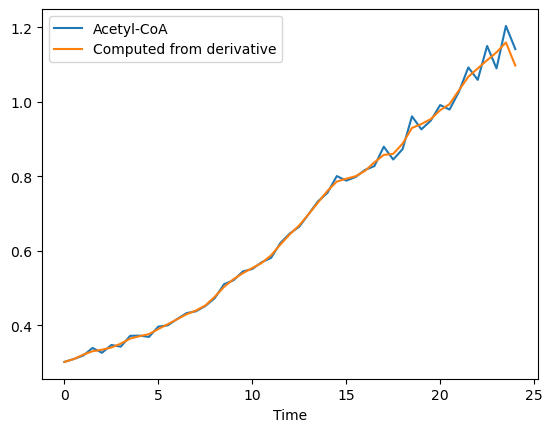

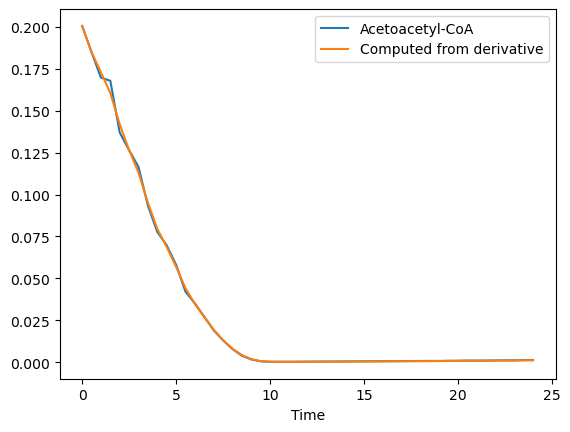

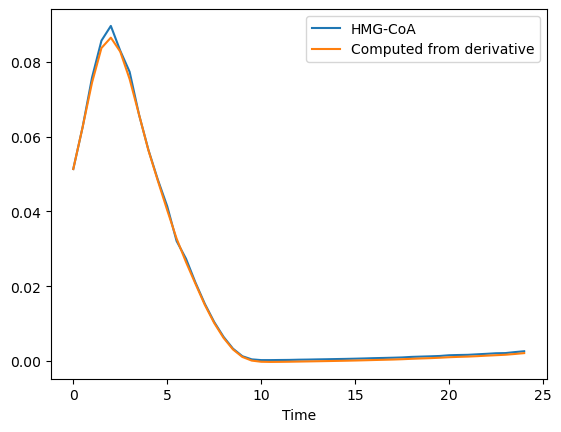

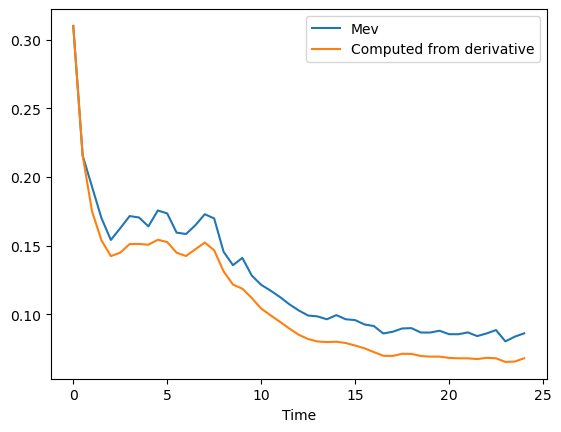

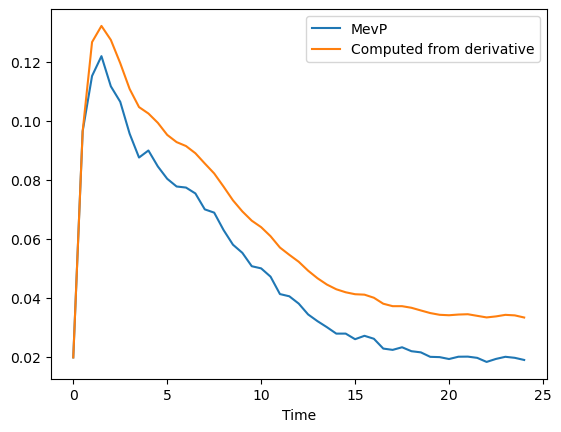

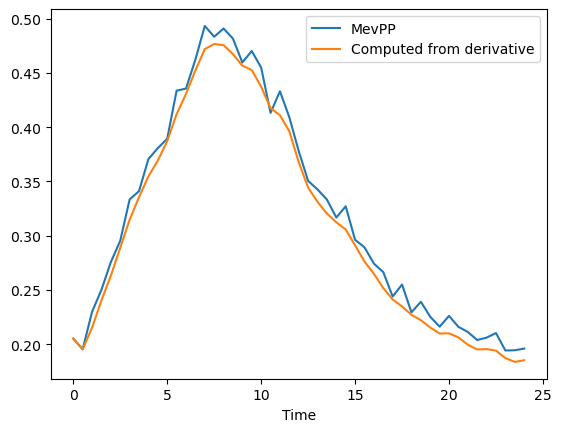

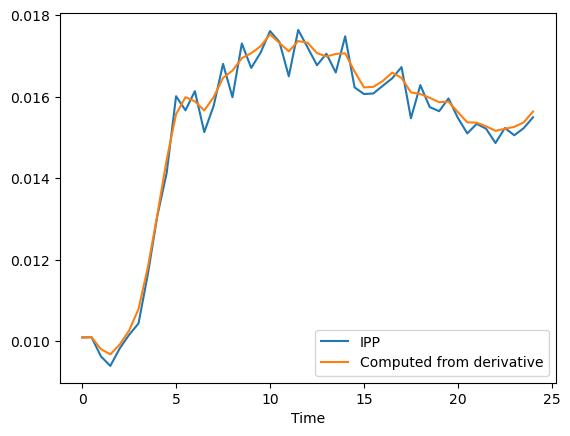

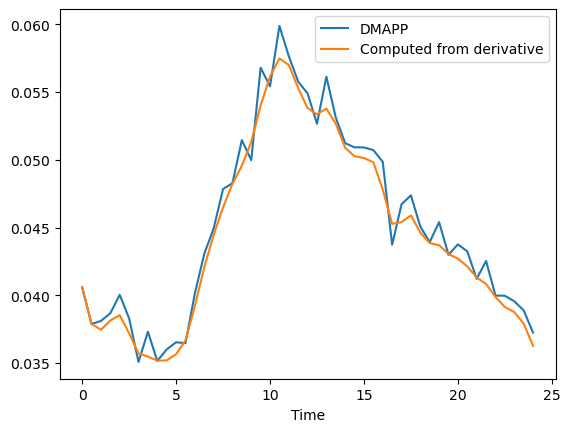

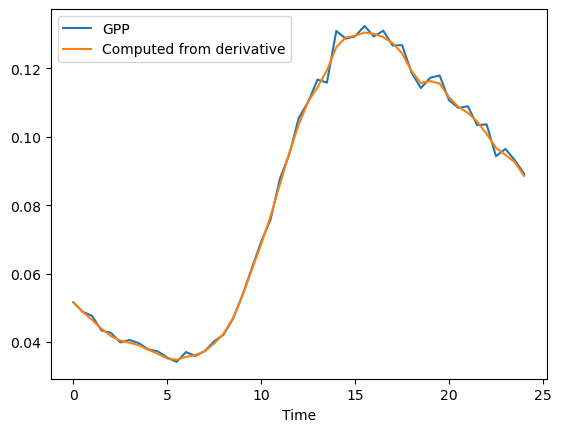

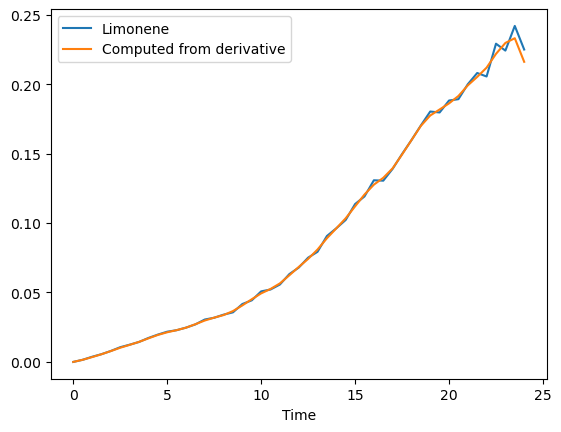

'Time profile from derivative vs. actual profile for WT'

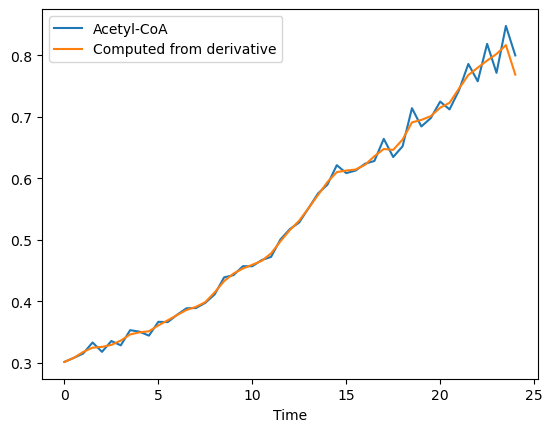

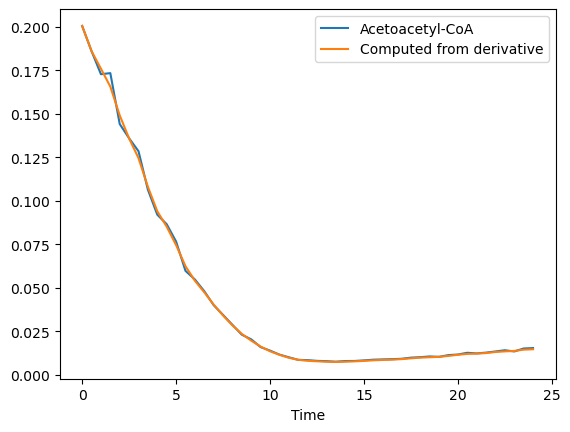

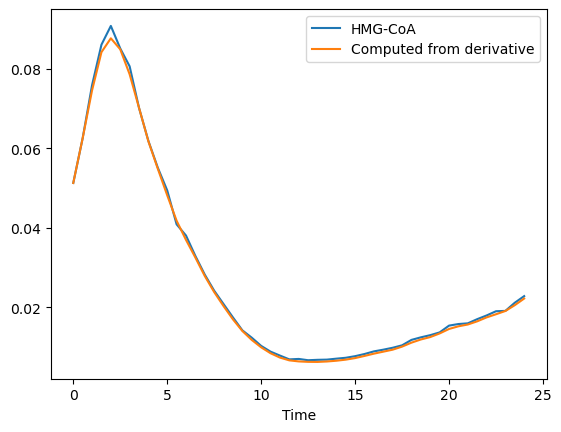

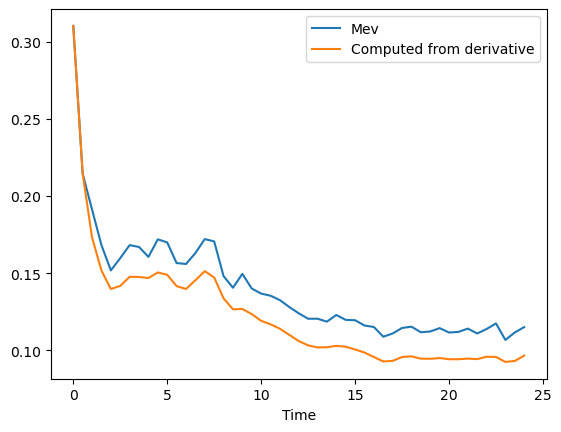

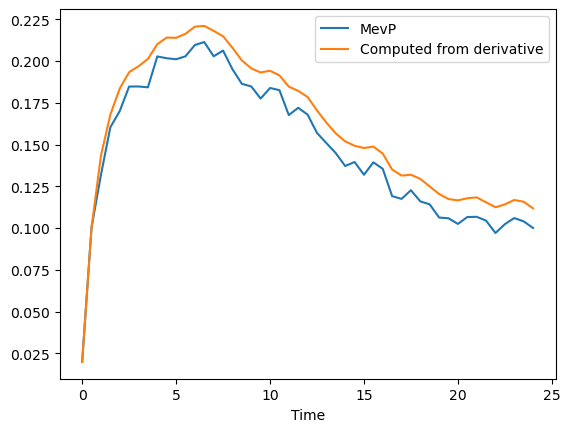

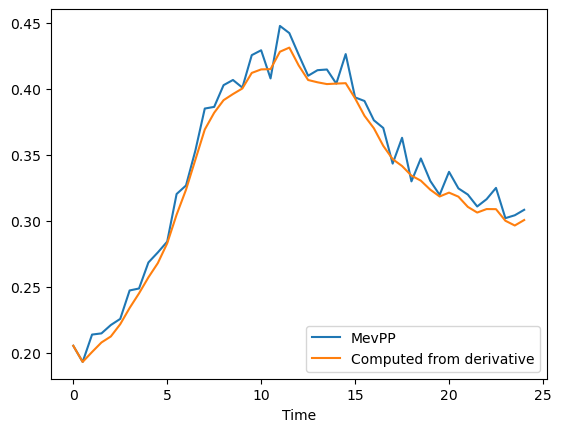

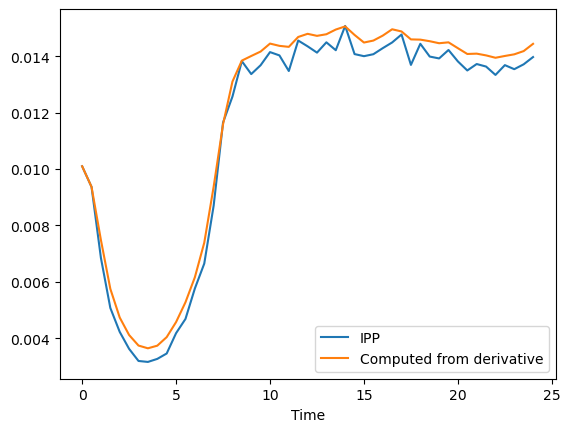

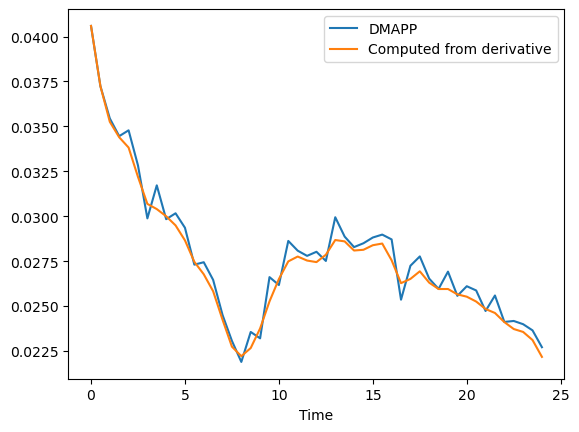

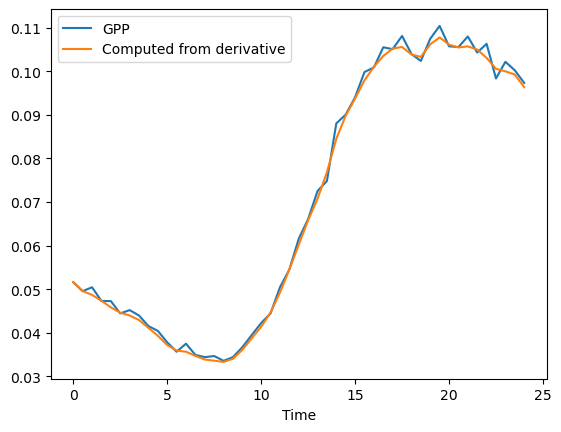

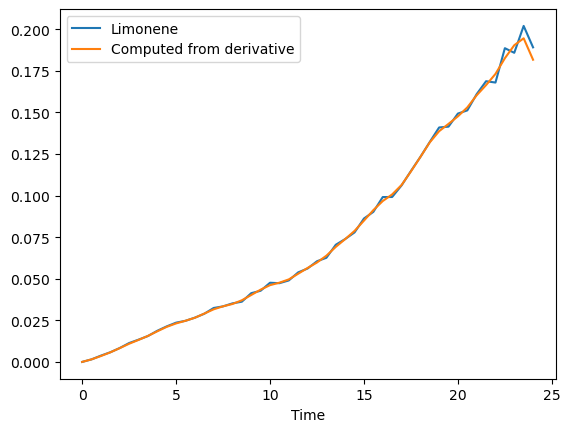

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                       AtoB          HMGS          HMGR            MK   
Strain   Time                                                           
Strain 1 0.0   5.975196e+01  3.983424e+01  3.794074e+01  5.956960e+01   
         0.5   5.631323e+06  3.440819e+06  3.323869e+05  2.260693e+06   
         1.0   6.106209e+06  4.732928e+06  4.701875e+05  3.032958e+06   
         1.5   6.050707e+06  5.274281e+06  5.577987e+05  3.688395e+06   
         2.0   6.300987e+06  5.415130e+06  5.719838e+05  3.644767e+06   
...                     ...           ...           ...           ...   
WT       22.0  2.801931e+06  2.640690e+06  1.799036e+06  2.000336e+06   
         22.5  2.862202e+06  2.689016e+06  1.794141e+06  1.968441e+06   
         23.0  2.741920e+06  2.742924e+06  1.737173e+06  2.042607e+06   
         23.5  2.793605e+06  2.736414e+06  1.799771e+06  2.017060e+06   
         24.0  2.701154e+06  2.670205e+06  1.783735e+06  2.008073e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.638142e+01  5.593531e+01  5.601897e+01  1.896372e+01   
         0.5   7.047969e+05  3.796719e+06  3.143606e+06  6.496627e+05   
         1.0   9.834322e+05  5.741520e+06  3.667164e+06  8.907681e+05   
         1.5   1.195601e+06  6.498473e+06  3.995391e+06  9.992137e+05   
         2.0   1.167996e+06  6.982609e+06  4.175248e+06  9.550818e+05   
...                     ...           ...           ...           ...   
WT       22.0  1.522663e+06  3.963120e+06  4.571259e+06  1.237148e+06   
         22.5  1.509386e+06  3.918210e+06  4.544321e+06  1.259215e+06   
         23.0  1.479329e+06  3.893761e+06  4.399914e+06  1.211695e+06   
         23.5  1.473599e+06  4.061157e+06  4.343405e+06  1.302855e+06   
         24.0  1.503353e+06  4.094630e+06  4.323669e+06  1.243159e+06   

                                    states                            \
              Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                          
Strain 1 0.0       3.131118e+01   0.301424        0.200524  0.051314   
         0.5       2.717891e+05   0.296267        0.184618  0.069373   
         1.0       3.931232e+05   0.285831        0.170430  0.089439   
         1.5       4.677331e+05   0.283446        0.169733  0.093173   
         2.0       5.116871e+05   0.253433        0.139596  0.083386   
...                         ...        ...             ...       ...   
WT       22.0      1.396240e+06   0.757670        0.013393  0.017970   
         22.5      1.474939e+06   0.818530        0.014094  0.019034   
         23.0      1.435362e+06   0.771437        0.013407  0.019120   
         23.5      1.446538e+06   0.847724        0.015108  0.021174   
         24.0      1.474062e+06   0.799769        0.015343  0.022840   

                                                                           \
                    Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                               
Strain 1 0.0   0.310136  0.019836  0.205338  0.010099  0.040591  0.051599   
         0.5   0.213087  0.101681  0.193076  0.009389  0.037237  0.050049   
         1.0   0.191736  0.133573  0.213713  0.006968  0.035412  0.051729   
         1.5   0.181715  0.165521  0.214564  0.005357  0.034321  0.049373   
         2.0   0.177449  0.184797  0.221516  0.004609  0.034492  0.050311   
...                 ...       ...       ...       ...       ...       ...   
WT       22.0  0.113830  0.097036  0.316333  0.013338  0.024117  0.106287   
         22.5  0.117444  0.102332  0.324875  0.013685  0.024171  0.098331   
         23.0  0.106759  0.105994  0.301968  0.013542  0.023991  0.102162   
         23.5  0.111608  0.104014  0.304

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.0    -0.005036       -0.033528  0.034108 -0.269793  0.213641   
         0.5    -0.015593       -0.030095  0.038125 -0.118400  0.113737   
         1.0    -0.012820       -0.014885  0.023800 -0.031373  0.063840   
         1.5    -0.032398       -0.030834 -0.006054 -0.014287  0.051224   
         2.0    -0.032859       -0.039876 -0.024795  0.008479  0.047738   
...                   ...             ...       ...       ...       ...   
WT       22.0    0.032677        0.001362  0.001993  0.006501 -0.002101   
         22.5    0.013767        0.000013  0.001150 -0.007071  0.008958   
         23.0    0.029194        0.001014  0.002139 -0.005836  0.001682   
         23.5    0.028332        0.001937  0.003720  0.008313 -0.005944   
         24.0   -0.220152       -0.000994  0.002946  0.005542 -0.009913   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0  -0.057423  0.000294 -0.008238 -0.006330  0.001528  
         0.5   0.008376 -0.003131 -0.005179  0.000130  0.002520  
         1.0   0.021489 -0.004032 -0.002916 -0.000676  0.002890  
         1.5   0.007803 -0.002359 -0.000920 -0.001418  0.003143  
         2.0   0.013545 -0.001297 -0.001918 -0.001119  0.003861  
...                 ...       ...       ...       ...       ...  
WT       22.0  0.014073  0.000051 -0.001418 -0.005956  0.019862  
         22.5 -0.014364  0.000204 -0.000126 -0.004125  0.017894  
         23.0 -0.020737  0.000029 -0.000523  0.001886  0.013391  
         23.5  0.006322  0.000430 -0.001280 -0.004845  0.003277  
         24.0  0.010287  0.000601 -0.002469 -0.006757 -0.054817  

[196 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=101,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 7.117343E+191 | 3.866241E+117
     2 |       74 | 7.273246E+115 |  4.426614E+83
     3 |      138 |  8.046592E+90 |  6.969173E+70
     4 |      202 |  4.475508E+80 |  1.045784E+60
     5 |      266 |  9.380038E+70 |  5.847104E+52
     6 |      330 |  8.300686E+65 |  2.436061E+49
     7 |      394 |  4.350849E+60 |  3.221285E+44
     8 |      458 |  1.077117E+56 |  1.035721E+41
     9 |      522 |  2.285071E+45 |  1.418750E+36
    10 |      586 |  1.451135E+47 |  1.418750E+36
    11 |      650 |  2.600009E+45 |  3.336899E+33
    12 |      714 |  2.777878E+39 |  1.316604E+30
    13 |      778 |  8.452320E+37 |  1.210573E+26
    14 |      842 |  7.607558E+36 |  4.942644E+16
    15 |      906 |  1.953203E+31 |  4.942644E+16
    16 |      970 |  4.454377E+28 |  4.942644E+16
    17 |     1034 |  7.659446E+22 |  4.942644E+16
    18 |     1098 |  8.083176E+22 |  4.942644E+16
    19 |     1162 |  3.000

   162 |    10314 |  4.252863E+01 |  4.099607E+01
   163 |    10378 |  4.181566E+01 |  4.025115E+01
   164 |    10442 |  4.186651E+01 |  4.025115E+01
   165 |    10506 |  4.162810E+01 |  4.025115E+01
   166 |    10570 |  4.161612E+01 |  4.025115E+01
   167 |    10634 |  4.116954E+01 |  4.025115E+01
   168 |    10698 |  4.208227E+01 |  4.025115E+01
   169 |    10762 |  4.185530E+01 |  3.997705E+01
   170 |    10826 |  4.196137E+01 |  3.997705E+01
   171 |    10890 |  4.242128E+01 |  3.997705E+01
   172 |    10954 |  4.226520E+01 |  3.997705E+01
   173 |    11018 |  4.264290E+01 |  3.997705E+01
   174 |    11082 |  4.232543E+01 |  3.997705E+01
   175 |    11146 |  4.188677E+01 |  3.997705E+01
   176 |    11210 |  4.193325E+01 |  3.997705E+01
   177 |    11274 |  4.172827E+01 |  3.997705E+01
   178 |    11338 |  4.128910E+01 |  3.997705E+01
   179 |    11402 |  4.161487E+01 |  3.997705E+01
   180 |    11466 |  4.157734E+01 |  3.997705E+01
   181 |    11530 |  4.150146E+01 |  3.997705E+01


   326 |    20810 |  3.082852E+01 |  3.071116E+01
   327 |    20874 |  3.085179E+01 |  3.069338E+01
   328 |    20938 |  3.079984E+01 |  3.067415E+01
   329 |    21002 |  3.078199E+01 |  3.067415E+01
   330 |    21066 |  3.079890E+01 |  3.067415E+01
   331 |    21130 |  3.076684E+01 |  3.067415E+01
   332 |    21194 |  3.079978E+01 |  3.066712E+01
   333 |    21258 |  3.077562E+01 |  3.066712E+01
   334 |    21322 |  3.077275E+01 |  3.066712E+01
   335 |    21386 |  3.079685E+01 |  3.066712E+01
   336 |    21450 |  3.080892E+01 |  3.066712E+01
   337 |    21514 |  3.077878E+01 |  3.066712E+01
   338 |    21578 |  3.075981E+01 |  3.066712E+01
   339 |    21642 |  3.076743E+01 |  3.063303E+01
   340 |    21706 |  3.076393E+01 |  3.063303E+01
   341 |    21770 |  3.076376E+01 |  3.063303E+01
   342 |    21834 |  3.072225E+01 |  3.062744E+01
   343 |    21898 |  3.069836E+01 |  3.062744E+01
   344 |    21962 |  3.064175E+01 |  3.048738E+01
   345 |    22026 |  3.065801E+01 |  3.048738E+01


   490 |    31306 |  2.984420E+01 |  2.983413E+01
   491 |    31370 |  2.984198E+01 |  2.983356E+01
   492 |    31434 |  2.983879E+01 |  2.983356E+01
   493 |    31498 |  2.983792E+01 |  2.983131E+01
   494 |    31562 |  2.983685E+01 |  2.983091E+01
   495 |    31626 |  2.983663E+01 |  2.983091E+01
   496 |    31690 |  2.983642E+01 |  2.982632E+01
   497 |    31754 |  2.983377E+01 |  2.982632E+01
   498 |    31818 |  2.983167E+01 |  2.982632E+01
   499 |    31882 |  2.983189E+01 |  2.982632E+01
   500 |    31946 |  2.982979E+01 |  2.982389E+01
   501 |    32010 |  2.983004E+01 |  2.982389E+01
   502 |    32074 |  2.983060E+01 |  2.982389E+01
   503 |    32138 |  2.983139E+01 |  2.982389E+01
   504 |    32202 |  2.982862E+01 |  2.982290E+01
   505 |    32266 |  2.982926E+01 |  2.982290E+01
   506 |    32330 |  2.982327E+01 |  2.981663E+01
   507 |    32394 |  2.982348E+01 |  2.981653E+01
   508 |    32458 |  2.982403E+01 |  2.981653E+01
   509 |    32522 |  2.982323E+01 |  2.981590E+01


   654 |    41802 |  2.960480E+01 |  2.960398E+01
   655 |    41866 |  2.960373E+01 |  2.960273E+01
   656 |    41930 |  2.960340E+01 |  2.960270E+01
   657 |    41994 |  2.960350E+01 |  2.960269E+01
   658 |    42058 |  2.960351E+01 |  2.960264E+01
   659 |    42122 |  2.960258E+01 |  2.960098E+01
   660 |    42186 |  2.960184E+01 |  2.960040E+01
   661 |    42250 |  2.960150E+01 |  2.960032E+01
   662 |    42314 |  2.960099E+01 |  2.960032E+01
   663 |    42378 |  2.960097E+01 |  2.960032E+01
   664 |    42442 |  2.960087E+01 |  2.960015E+01
   665 |    42506 |  2.960055E+01 |  2.959962E+01
   666 |    42570 |  2.959986E+01 |  2.959823E+01
   667 |    42634 |  2.959938E+01 |  2.959823E+01
   668 |    42698 |  2.959937E+01 |  2.959756E+01
   669 |    42762 |  2.959849E+01 |  2.959746E+01
   670 |    42826 |  2.959752E+01 |  2.959620E+01
   671 |    42890 |  2.959698E+01 |  2.959611E+01
   672 |    42954 |  2.959617E+01 |  2.959552E+01
   673 |    43018 |  2.959588E+01 |  2.959456E+01


   818 |    52298 |  2.953911E+01 |  2.953823E+01
   819 |    52362 |  2.953840E+01 |  2.953740E+01
   820 |    52426 |  2.953792E+01 |  2.953690E+01
   821 |    52490 |  2.953729E+01 |  2.953679E+01
   822 |    52554 |  2.953702E+01 |  2.953649E+01
   823 |    52618 |  2.953693E+01 |  2.953580E+01
   824 |    52682 |  2.953645E+01 |  2.953556E+01
   825 |    52746 |  2.953620E+01 |  2.953410E+01
   826 |    52810 |  2.953572E+01 |  2.953410E+01
   827 |    52874 |  2.953538E+01 |  2.953410E+01
   828 |    52938 |  2.953516E+01 |  2.953410E+01
   829 |    53002 |  2.953462E+01 |  2.953327E+01
   830 |    53066 |  2.953405E+01 |  2.953315E+01
   831 |    53130 |  2.953411E+01 |  2.953231E+01
   832 |    53194 |  2.953249E+01 |  2.953160E+01
   833 |    53258 |  2.953199E+01 |  2.953051E+01
   834 |    53322 |  2.953093E+01 |  2.952910E+01
   835 |    53386 |  2.953001E+01 |  2.952897E+01
   836 |    53450 |  2.952920E+01 |  2.952810E+01
   837 |    53514 |  2.952940E+01 |  2.952810E+01


   982 |    62794 |  2.946574E+01 |  2.946464E+01
   983 |    62858 |  2.946475E+01 |  2.946356E+01
   984 |    62922 |  2.946392E+01 |  2.946329E+01
   985 |    62986 |  2.946319E+01 |  2.946226E+01
   986 |    63050 |  2.946265E+01 |  2.946172E+01
   987 |    63114 |  2.946216E+01 |  2.945997E+01
   988 |    63178 |  2.946195E+01 |  2.945997E+01
   989 |    63242 |  2.946102E+01 |  2.945970E+01
   990 |    63306 |  2.946039E+01 |  2.945947E+01
   991 |    63370 |  2.945981E+01 |  2.945925E+01
   992 |    63434 |  2.945931E+01 |  2.945851E+01
   993 |    63498 |  2.945885E+01 |  2.945804E+01
   994 |    63562 |  2.945795E+01 |  2.945717E+01
   995 |    63626 |  2.945704E+01 |  2.945622E+01
   996 |    63690 |  2.945589E+01 |  2.945496E+01
   997 |    63754 |  2.945539E+01 |  2.945472E+01
   998 |    63818 |  2.945489E+01 |  2.945428E+01
   999 |    63882 |  2.945495E+01 |  2.945419E+01
  1000 |    63946 |  2.945421E+01 |  2.945334E+01
  1001 |    64010 |  2.945365E+01 |  2.945306E+01


  1146 |    73290 |  2.935258E+01 |  2.935104E+01
  1147 |    73354 |  2.935251E+01 |  2.934936E+01
  1148 |    73418 |  2.935070E+01 |  2.934769E+01
  1149 |    73482 |  2.935026E+01 |  2.934769E+01
  1150 |    73546 |  2.934937E+01 |  2.934420E+01
  1151 |    73610 |  2.934861E+01 |  2.934420E+01
  1152 |    73674 |  2.934873E+01 |  2.934420E+01
  1153 |    73738 |  2.934896E+01 |  2.934420E+01
  1154 |    73802 |  2.934774E+01 |  2.934356E+01
  1155 |    73866 |  2.934550E+01 |  2.933911E+01
  1156 |    73930 |  2.934321E+01 |  2.933911E+01
  1157 |    73994 |  2.934115E+01 |  2.933708E+01
  1158 |    74058 |  2.933908E+01 |  2.933661E+01
  1159 |    74122 |  2.933843E+01 |  2.933571E+01
  1160 |    74186 |  2.933851E+01 |  2.933571E+01
  1161 |    74250 |  2.933686E+01 |  2.933489E+01
  1162 |    74314 |  2.933642E+01 |  2.933489E+01
  1163 |    74378 |  2.933576E+01 |  2.933381E+01
  1164 |    74442 |  2.933369E+01 |  2.933266E+01
  1165 |    74506 |  2.933273E+01 |  2.933133E+01


  1310 |    83786 |  2.885784E+01 |  2.885565E+01
  1311 |    83850 |  2.885788E+01 |  2.885565E+01
  1312 |    83914 |  2.885738E+01 |  2.885526E+01
  1313 |    83978 |  2.885598E+01 |  2.885425E+01
  1314 |    84042 |  2.885592E+01 |  2.885381E+01
  1315 |    84106 |  2.885483E+01 |  2.885151E+01
  1316 |    84170 |  2.885440E+01 |  2.885151E+01
  1317 |    84234 |  2.885441E+01 |  2.885151E+01
  1318 |    84298 |  2.885471E+01 |  2.884990E+01
  1319 |    84362 |  2.885403E+01 |  2.884976E+01
  1320 |    84426 |  2.885126E+01 |  2.884826E+01
  1321 |    84490 |  2.884997E+01 |  2.884710E+01
  1322 |    84554 |  2.884688E+01 |  2.884476E+01
  1323 |    84618 |  2.884626E+01 |  2.884435E+01
  1324 |    84682 |  2.884687E+01 |  2.884435E+01
  1325 |    84746 |  2.884684E+01 |  2.884435E+01
  1326 |    84810 |  2.884669E+01 |  2.884416E+01
  1327 |    84874 |  2.884490E+01 |  2.884097E+01
  1328 |    84938 |  2.884393E+01 |  2.884097E+01
  1329 |    85002 |  2.884235E+01 |  2.883948E+01


  1474 |    94282 |  2.871555E+01 |  2.871392E+01
  1475 |    94346 |  2.871486E+01 |  2.871392E+01
  1476 |    94410 |  2.871475E+01 |  2.871392E+01
  1477 |    94474 |  2.871412E+01 |  2.871325E+01
  1478 |    94538 |  2.871389E+01 |  2.871298E+01
  1479 |    94602 |  2.871326E+01 |  2.871242E+01
  1480 |    94666 |  2.871263E+01 |  2.871108E+01
  1481 |    94730 |  2.871227E+01 |  2.871108E+01
  1482 |    94794 |  2.871209E+01 |  2.871108E+01
  1483 |    94858 |  2.871192E+01 |  2.871020E+01
  1484 |    94922 |  2.871096E+01 |  2.870799E+01
  1485 |    94986 |  2.871004E+01 |  2.870799E+01
  1486 |    95050 |  2.870966E+01 |  2.870771E+01
  1487 |    95114 |  2.870746E+01 |  2.870491E+01
  1488 |    95178 |  2.870667E+01 |  2.870405E+01
  1489 |    95242 |  2.870600E+01 |  2.870405E+01
  1490 |    95306 |  2.870552E+01 |  2.870214E+01
  1491 |    95370 |  2.870405E+01 |  2.870214E+01
  1492 |    95434 |  2.870286E+01 |  2.870070E+01
  1493 |    95498 |  2.870232E+01 |  2.870027E+01


  1638 |   104778 |  2.856838E+01 |  2.856503E+01
  1639 |   104842 |  2.856709E+01 |  2.856348E+01
  1640 |   104906 |  2.856577E+01 |  2.856000E+01
  1641 |   104970 |  2.856351E+01 |  2.856000E+01
  1642 |   105034 |  2.856416E+01 |  2.856000E+01
  1643 |   105098 |  2.856519E+01 |  2.855926E+01
  1644 |   105162 |  2.856300E+01 |  2.855926E+01
  1645 |   105226 |  2.856107E+01 |  2.855670E+01
  1646 |   105290 |  2.855853E+01 |  2.855370E+01
  1647 |   105354 |  2.855732E+01 |  2.855157E+01
  1648 |   105418 |  2.855470E+01 |  2.855157E+01
  1649 |   105482 |  2.855430E+01 |  2.855157E+01
  1650 |   105546 |  2.855203E+01 |  2.854649E+01
  1651 |   105610 |  2.854925E+01 |  2.854635E+01
  1652 |   105674 |  2.854768E+01 |  2.854571E+01
  1653 |   105738 |  2.854546E+01 |  2.854228E+01
  1654 |   105802 |  2.854236E+01 |  2.854075E+01
  1655 |   105866 |  2.854089E+01 |  2.853734E+01
  1656 |   105930 |  2.853862E+01 |  2.853431E+01
  1657 |   105994 |  2.853542E+01 |  2.853272E+01


  1802 |   115274 |  2.831442E+01 |  2.831132E+01
  1803 |   115338 |  2.831250E+01 |  2.831099E+01
  1804 |   115402 |  2.831232E+01 |  2.830712E+01
  1805 |   115466 |  2.831126E+01 |  2.830712E+01
  1806 |   115530 |  2.831032E+01 |  2.830712E+01
  1807 |   115594 |  2.831003E+01 |  2.830712E+01
  1808 |   115658 |  2.831005E+01 |  2.830712E+01
  1809 |   115722 |  2.830877E+01 |  2.830576E+01
  1810 |   115786 |  2.830918E+01 |  2.830536E+01
  1811 |   115850 |  2.830979E+01 |  2.830536E+01
  1812 |   115914 |  2.831086E+01 |  2.830536E+01
  1813 |   115978 |  2.831008E+01 |  2.830536E+01
  1814 |   116042 |  2.830937E+01 |  2.830457E+01
  1815 |   116106 |  2.830756E+01 |  2.830457E+01
  1816 |   116170 |  2.830779E+01 |  2.830457E+01
  1817 |   116234 |  2.830805E+01 |  2.830457E+01
  1818 |   116298 |  2.830734E+01 |  2.830457E+01
  1819 |   116362 |  2.830806E+01 |  2.830427E+01
  1820 |   116426 |  2.830764E+01 |  2.830324E+01
  1821 |   116490 |  2.830562E+01 |  2.830294E+01


  1966 |   125770 |  2.823647E+01 |  2.823610E+01
  1967 |   125834 |  2.823621E+01 |  2.823548E+01
  1968 |   125898 |  2.823593E+01 |  2.823548E+01
  1969 |   125962 |  2.823567E+01 |  2.823502E+01
  1970 |   126026 |  2.823539E+01 |  2.823474E+01
  1971 |   126090 |  2.823522E+01 |  2.823440E+01
  1972 |   126154 |  2.823476E+01 |  2.823391E+01
  1973 |   126218 |  2.823461E+01 |  2.823391E+01
  1974 |   126282 |  2.823459E+01 |  2.823391E+01
  1975 |   126346 |  2.823430E+01 |  2.823376E+01
  1976 |   126410 |  2.823420E+01 |  2.823349E+01
  1977 |   126474 |  2.823387E+01 |  2.823346E+01
  1978 |   126538 |  2.823386E+01 |  2.823346E+01
  1979 |   126602 |  2.823331E+01 |  2.823271E+01
  1980 |   126666 |  2.823299E+01 |  2.823255E+01
  1981 |   126730 |  2.823237E+01 |  2.823138E+01
  1982 |   126794 |  2.823208E+01 |  2.823131E+01
  1983 |   126858 |  2.823186E+01 |  2.823098E+01
  1984 |   126922 |  2.823171E+01 |  2.823098E+01
  1985 |   126986 |  2.823197E+01 |  2.823098E+01


  2130 |   136266 |  2.819731E+01 |  2.819697E+01
  2131 |   136330 |  2.819710E+01 |  2.819682E+01
  2132 |   136394 |  2.819689E+01 |  2.819665E+01
  2133 |   136458 |  2.819676E+01 |  2.819654E+01
  2134 |   136522 |  2.819670E+01 |  2.819649E+01
  2135 |   136586 |  2.819658E+01 |  2.819634E+01
  2136 |   136650 |  2.819639E+01 |  2.819632E+01
  2137 |   136714 |  2.819631E+01 |  2.819602E+01
  2138 |   136778 |  2.819603E+01 |  2.819584E+01
  2139 |   136842 |  2.819589E+01 |  2.819557E+01
  2140 |   136906 |  2.819570E+01 |  2.819541E+01
  2141 |   136970 |  2.819545E+01 |  2.819529E+01
  2142 |   137034 |  2.819534E+01 |  2.819517E+01
  2143 |   137098 |  2.819517E+01 |  2.819497E+01
  2144 |   137162 |  2.819507E+01 |  2.819489E+01
  2145 |   137226 |  2.819503E+01 |  2.819489E+01
  2146 |   137290 |  2.819489E+01 |  2.819471E+01
  2147 |   137354 |  2.819483E+01 |  2.819470E+01
  2148 |   137418 |  2.819464E+01 |  2.819430E+01
  2149 |   137482 |  2.819460E+01 |  2.819430E+01


  2294 |   146762 |  2.809691E+01 |  2.809567E+01
  2295 |   146826 |  2.809694E+01 |  2.809567E+01
  2296 |   146890 |  2.809699E+01 |  2.809549E+01
  2297 |   146954 |  2.809606E+01 |  2.809375E+01
  2298 |   147018 |  2.809540E+01 |  2.809375E+01
  2299 |   147082 |  2.809515E+01 |  2.809375E+01
  2300 |   147146 |  2.809497E+01 |  2.809375E+01
  2301 |   147210 |  2.809514E+01 |  2.809322E+01
  2302 |   147274 |  2.809438E+01 |  2.809322E+01
  2303 |   147338 |  2.809385E+01 |  2.809208E+01
  2304 |   147402 |  2.809410E+01 |  2.809208E+01
  2305 |   147466 |  2.809281E+01 |  2.809035E+01
  2306 |   147530 |  2.809190E+01 |  2.808981E+01
  2307 |   147594 |  2.809102E+01 |  2.808970E+01
  2308 |   147658 |  2.809083E+01 |  2.808914E+01
  2309 |   147722 |  2.809021E+01 |  2.808914E+01
  2310 |   147786 |  2.808967E+01 |  2.808914E+01
  2311 |   147850 |  2.808938E+01 |  2.808825E+01
  2312 |   147914 |  2.808871E+01 |  2.808743E+01
  2313 |   147978 |  2.808830E+01 |  2.808743E+01


  2458 |   157258 |  2.799447E+01 |  2.799305E+01
  2459 |   157322 |  2.799253E+01 |  2.798953E+01
  2460 |   157386 |  2.799124E+01 |  2.798939E+01
  2461 |   157450 |  2.799048E+01 |  2.798742E+01
  2462 |   157514 |  2.798961E+01 |  2.798730E+01
  2463 |   157578 |  2.798922E+01 |  2.798682E+01
  2464 |   157642 |  2.798912E+01 |  2.798682E+01
  2465 |   157706 |  2.798727E+01 |  2.798536E+01
  2466 |   157770 |  2.798564E+01 |  2.798274E+01
  2467 |   157834 |  2.798545E+01 |  2.798274E+01
  2468 |   157898 |  2.798517E+01 |  2.798246E+01
  2469 |   157962 |  2.798470E+01 |  2.798206E+01
  2470 |   158026 |  2.798359E+01 |  2.798125E+01
  2471 |   158090 |  2.798259E+01 |  2.797982E+01
  2472 |   158154 |  2.798107E+01 |  2.797980E+01
  2473 |   158218 |  2.798024E+01 |  2.797757E+01
  2474 |   158282 |  2.798027E+01 |  2.797757E+01
  2475 |   158346 |  2.798141E+01 |  2.797757E+01
  2476 |   158410 |  2.798128E+01 |  2.797757E+01
  2477 |   158474 |  2.797968E+01 |  2.797751E+01


  2622 |   167754 |  2.786906E+01 |  2.786777E+01
  2623 |   167818 |  2.786861E+01 |  2.786777E+01
  2624 |   167882 |  2.786800E+01 |  2.786670E+01
  2625 |   167946 |  2.786758E+01 |  2.786670E+01
  2626 |   168010 |  2.786662E+01 |  2.786548E+01
  2627 |   168074 |  2.786622E+01 |  2.786548E+01
  2628 |   168138 |  2.786618E+01 |  2.786511E+01
  2629 |   168202 |  2.786559E+01 |  2.786500E+01
  2630 |   168266 |  2.786517E+01 |  2.786400E+01
  2631 |   168330 |  2.786502E+01 |  2.786400E+01
  2632 |   168394 |  2.786448E+01 |  2.786353E+01
  2633 |   168458 |  2.786427E+01 |  2.786301E+01
  2634 |   168522 |  2.786394E+01 |  2.786301E+01
  2635 |   168586 |  2.786358E+01 |  2.786245E+01
  2636 |   168650 |  2.786304E+01 |  2.786216E+01
  2637 |   168714 |  2.786187E+01 |  2.786069E+01
  2638 |   168778 |  2.786097E+01 |  2.785999E+01
  2639 |   168842 |  2.786103E+01 |  2.785999E+01
  2640 |   168906 |  2.786032E+01 |  2.785897E+01
  2641 |   168970 |  2.785986E+01 |  2.785897E+01


  2786 |   178250 |  2.778677E+01 |  2.778605E+01
  2787 |   178314 |  2.778639E+01 |  2.778570E+01
  2788 |   178378 |  2.778599E+01 |  2.778475E+01
  2789 |   178442 |  2.778515E+01 |  2.778423E+01
  2790 |   178506 |  2.778506E+01 |  2.778410E+01
  2791 |   178570 |  2.778486E+01 |  2.778410E+01
  2792 |   178634 |  2.778438E+01 |  2.778312E+01
  2793 |   178698 |  2.778380E+01 |  2.778312E+01
  2794 |   178762 |  2.778319E+01 |  2.778208E+01
  2795 |   178826 |  2.778285E+01 |  2.778192E+01
  2796 |   178890 |  2.778248E+01 |  2.778179E+01
  2797 |   178954 |  2.778210E+01 |  2.778163E+01
  2798 |   179018 |  2.778120E+01 |  2.778061E+01
  2799 |   179082 |  2.778076E+01 |  2.777996E+01
  2800 |   179146 |  2.778061E+01 |  2.777973E+01
  2801 |   179210 |  2.778047E+01 |  2.777955E+01
  2802 |   179274 |  2.778018E+01 |  2.777887E+01
  2803 |   179338 |  2.777977E+01 |  2.777887E+01
  2804 |   179402 |  2.777913E+01 |  2.777841E+01
  2805 |   179466 |  2.777876E+01 |  2.777795E+01


  2950 |   188746 |  2.774036E+01 |  2.773961E+01
  2951 |   188810 |  2.773979E+01 |  2.773865E+01
  2952 |   188874 |  2.773917E+01 |  2.773830E+01
  2953 |   188938 |  2.773900E+01 |  2.773827E+01
  2954 |   189002 |  2.773908E+01 |  2.773756E+01
  2955 |   189066 |  2.773823E+01 |  2.773756E+01
  2956 |   189130 |  2.773805E+01 |  2.773672E+01
  2957 |   189194 |  2.773784E+01 |  2.773618E+01
  2958 |   189258 |  2.773717E+01 |  2.773592E+01
  2959 |   189322 |  2.773693E+01 |  2.773592E+01
  2960 |   189386 |  2.773682E+01 |  2.773592E+01
  2961 |   189450 |  2.773658E+01 |  2.773592E+01
  2962 |   189514 |  2.773656E+01 |  2.773567E+01
  2963 |   189578 |  2.773650E+01 |  2.773567E+01
  2964 |   189642 |  2.773644E+01 |  2.773550E+01
  2965 |   189706 |  2.773604E+01 |  2.773534E+01
  2966 |   189770 |  2.773596E+01 |  2.773507E+01
  2967 |   189834 |  2.773598E+01 |  2.773397E+01
  2968 |   189898 |  2.773591E+01 |  2.773397E+01
  2969 |   189962 |  2.773573E+01 |  2.773397E+01


  3114 |   199242 |  2.766024E+01 |  2.765885E+01
  3115 |   199306 |  2.765934E+01 |  2.765794E+01
  3116 |   199370 |  2.765775E+01 |  2.765706E+01
  3117 |   199434 |  2.765719E+01 |  2.765663E+01
  3118 |   199498 |  2.765433E+01 |  2.765172E+01
  3119 |   199562 |  2.765294E+01 |  2.765021E+01
  3120 |   199626 |  2.765151E+01 |  2.765021E+01
  3121 |   199690 |  2.765062E+01 |  2.764866E+01
  3122 |   199754 |  2.765011E+01 |  2.764866E+01
  3123 |   199818 |  2.764961E+01 |  2.764796E+01
  3124 |   199882 |  2.764843E+01 |  2.764738E+01
  3125 |   199946 |  2.764780E+01 |  2.764723E+01
  3126 |   200010 |  2.764642E+01 |  2.764396E+01
  3127 |   200074 |  2.764441E+01 |  2.764162E+01
  3128 |   200138 |  2.764295E+01 |  2.764116E+01
  3129 |   200202 |  2.764131E+01 |  2.763976E+01
  3130 |   200266 |  2.764002E+01 |  2.763878E+01
  3131 |   200330 |  2.763857E+01 |  2.763575E+01
  3132 |   200394 |  2.763611E+01 |  2.763368E+01
  3133 |   200458 |  2.763405E+01 |  2.763245E+01


  3278 |   209738 |  2.725872E+01 |  2.725084E+01
  3279 |   209802 |  2.725594E+01 |  2.725020E+01
  3280 |   209866 |  2.725559E+01 |  2.725020E+01
  3281 |   209930 |  2.725066E+01 |  2.724493E+01
  3282 |   209994 |  2.725078E+01 |  2.724493E+01
  3283 |   210058 |  2.724825E+01 |  2.724031E+01
  3284 |   210122 |  2.724398E+01 |  2.723827E+01
  3285 |   210186 |  2.723946E+01 |  2.723304E+01
  3286 |   210250 |  2.723543E+01 |  2.722659E+01
  3287 |   210314 |  2.723137E+01 |  2.722195E+01
  3288 |   210378 |  2.722876E+01 |  2.722195E+01
  3289 |   210442 |  2.722439E+01 |  2.720696E+01
  3290 |   210506 |  2.721974E+01 |  2.720696E+01
  3291 |   210570 |  2.721516E+01 |  2.720646E+01
  3292 |   210634 |  2.720661E+01 |  2.719998E+01
  3293 |   210698 |  2.720387E+01 |  2.718131E+01
  3294 |   210762 |  2.720345E+01 |  2.718131E+01
  3295 |   210826 |  2.719094E+01 |  2.717169E+01
  3296 |   210890 |  2.718578E+01 |  2.717169E+01
  3297 |   210954 |  2.718249E+01 |  2.717120E+01


  3442 |   220234 |  2.652284E+01 |  2.651770E+01
  3443 |   220298 |  2.652209E+01 |  2.651770E+01
  3444 |   220362 |  2.652283E+01 |  2.651770E+01
  3445 |   220426 |  2.652180E+01 |  2.651770E+01
  3446 |   220490 |  2.652144E+01 |  2.651705E+01
  3447 |   220554 |  2.652109E+01 |  2.651679E+01
  3448 |   220618 |  2.652153E+01 |  2.651679E+01
  3449 |   220682 |  2.652184E+01 |  2.651679E+01
  3450 |   220746 |  2.652018E+01 |  2.651679E+01
  3451 |   220810 |  2.652145E+01 |  2.651679E+01
  3452 |   220874 |  2.652047E+01 |  2.651679E+01
  3453 |   220938 |  2.652011E+01 |  2.651679E+01
  3454 |   221002 |  2.651878E+01 |  2.651506E+01
  3455 |   221066 |  2.651819E+01 |  2.651447E+01
  3456 |   221130 |  2.651627E+01 |  2.651398E+01
  3457 |   221194 |  2.651450E+01 |  2.651142E+01
  3458 |   221258 |  2.651336E+01 |  2.651142E+01
  3459 |   221322 |  2.651357E+01 |  2.651142E+01
  3460 |   221386 |  2.651237E+01 |  2.650876E+01
  3461 |   221450 |  2.651153E+01 |  2.650876E+01


  3606 |   230730 |  2.645123E+01 |  2.645057E+01
  3607 |   230794 |  2.645115E+01 |  2.645057E+01
  3608 |   230858 |  2.645114E+01 |  2.644989E+01
  3609 |   230922 |  2.645069E+01 |  2.644989E+01
  3610 |   230986 |  2.644994E+01 |  2.644954E+01
  3611 |   231050 |  2.644972E+01 |  2.644905E+01
  3612 |   231114 |  2.644961E+01 |  2.644905E+01
  3613 |   231178 |  2.644964E+01 |  2.644870E+01
  3614 |   231242 |  2.644905E+01 |  2.644762E+01
  3615 |   231306 |  2.644863E+01 |  2.644762E+01
  3616 |   231370 |  2.644819E+01 |  2.644761E+01
  3617 |   231434 |  2.644801E+01 |  2.644737E+01
  3618 |   231498 |  2.644745E+01 |  2.644705E+01
  3619 |   231562 |  2.644721E+01 |  2.644677E+01
  3620 |   231626 |  2.644681E+01 |  2.644623E+01
  3621 |   231690 |  2.644639E+01 |  2.644597E+01
  3622 |   231754 |  2.644604E+01 |  2.644537E+01
  3623 |   231818 |  2.644578E+01 |  2.644528E+01
  3624 |   231882 |  2.644563E+01 |  2.644495E+01
  3625 |   231946 |  2.644523E+01 |  2.644457E+01


  3770 |   241226 |  2.630557E+01 |  2.630314E+01
  3771 |   241290 |  2.630539E+01 |  2.630302E+01
  3772 |   241354 |  2.630616E+01 |  2.630302E+01
  3773 |   241418 |  2.630484E+01 |  2.630123E+01
  3774 |   241482 |  2.630412E+01 |  2.630031E+01
  3775 |   241546 |  2.630320E+01 |  2.629972E+01
  3776 |   241610 |  2.630163E+01 |  2.629877E+01
  3777 |   241674 |  2.630239E+01 |  2.629877E+01
  3778 |   241738 |  2.630060E+01 |  2.629764E+01
  3779 |   241802 |  2.629841E+01 |  2.629501E+01
  3780 |   241866 |  2.629703E+01 |  2.629250E+01
  3781 |   241930 |  2.629506E+01 |  2.629190E+01
  3782 |   241994 |  2.629460E+01 |  2.629190E+01
  3783 |   242058 |  2.629481E+01 |  2.629190E+01
  3784 |   242122 |  2.629437E+01 |  2.628980E+01
  3785 |   242186 |  2.629421E+01 |  2.628980E+01
  3786 |   242250 |  2.629339E+01 |  2.628980E+01
  3787 |   242314 |  2.629251E+01 |  2.628795E+01
  3788 |   242378 |  2.629094E+01 |  2.628795E+01
  3789 |   242442 |  2.629039E+01 |  2.628502E+01


  3934 |   251722 |  2.619781E+01 |  2.619724E+01
  3935 |   251786 |  2.619739E+01 |  2.619675E+01
  3936 |   251850 |  2.619657E+01 |  2.619578E+01
  3937 |   251914 |  2.619603E+01 |  2.619574E+01
  3938 |   251978 |  2.619550E+01 |  2.619472E+01
  3939 |   252042 |  2.619496E+01 |  2.619442E+01
  3940 |   252106 |  2.619461E+01 |  2.619402E+01
  3941 |   252170 |  2.619400E+01 |  2.619338E+01
  3942 |   252234 |  2.619343E+01 |  2.619229E+01
  3943 |   252298 |  2.619281E+01 |  2.619217E+01
  3944 |   252362 |  2.619246E+01 |  2.619191E+01
  3945 |   252426 |  2.619175E+01 |  2.619056E+01
  3946 |   252490 |  2.619138E+01 |  2.619037E+01
  3947 |   252554 |  2.619049E+01 |  2.618980E+01
  3948 |   252618 |  2.619012E+01 |  2.618910E+01
  3949 |   252682 |  2.618946E+01 |  2.618883E+01
  3950 |   252746 |  2.618910E+01 |  2.618875E+01
  3951 |   252810 |  2.618881E+01 |  2.618845E+01
  3952 |   252874 |  2.618841E+01 |  2.618769E+01
  3953 |   252938 |  2.618820E+01 |  2.618769E+01


  4098 |   262218 |  2.603414E+01 |  2.602735E+01
  4099 |   262282 |  2.603233E+01 |  2.602735E+01
  4100 |   262346 |  2.602951E+01 |  2.602471E+01
  4101 |   262410 |  2.602733E+01 |  2.602301E+01
  4102 |   262474 |  2.602400E+01 |  2.601886E+01
  4103 |   262538 |  2.602097E+01 |  2.601612E+01
  4104 |   262602 |  2.601871E+01 |  2.601199E+01
  4105 |   262666 |  2.601495E+01 |  2.601199E+01
  4106 |   262730 |  2.601554E+01 |  2.601146E+01
  4107 |   262794 |  2.601469E+01 |  2.601126E+01
  4108 |   262858 |  2.601197E+01 |  2.600761E+01
  4109 |   262922 |  2.601213E+01 |  2.600761E+01
  4110 |   262986 |  2.601030E+01 |  2.600619E+01
  4111 |   263050 |  2.600790E+01 |  2.600325E+01
  4112 |   263114 |  2.600635E+01 |  2.600218E+01
  4113 |   263178 |  2.600163E+01 |  2.599392E+01
  4114 |   263242 |  2.600007E+01 |  2.599245E+01
  4115 |   263306 |  2.599775E+01 |  2.599245E+01
  4116 |   263370 |  2.599416E+01 |  2.598693E+01
  4117 |   263434 |  2.599248E+01 |  2.598141E+01


  4262 |   272714 |  2.557624E+01 |  2.557303E+01
  4263 |   272778 |  2.557516E+01 |  2.557303E+01
  4264 |   272842 |  2.557380E+01 |  2.557250E+01
  4265 |   272906 |  2.557283E+01 |  2.557001E+01
  4266 |   272970 |  2.557207E+01 |  2.556732E+01
  4267 |   273034 |  2.557145E+01 |  2.556732E+01
  4268 |   273098 |  2.556972E+01 |  2.556472E+01
  4269 |   273162 |  2.556727E+01 |  2.556334E+01
  4270 |   273226 |  2.556411E+01 |  2.556060E+01
  4271 |   273290 |  2.556210E+01 |  2.556014E+01
  4272 |   273354 |  2.556084E+01 |  2.555945E+01
  4273 |   273418 |  2.555930E+01 |  2.555775E+01
  4274 |   273482 |  2.555704E+01 |  2.555394E+01
  4275 |   273546 |  2.555562E+01 |  2.555249E+01
  4276 |   273610 |  2.555559E+01 |  2.555249E+01
  4277 |   273674 |  2.555516E+01 |  2.555122E+01
  4278 |   273738 |  2.555437E+01 |  2.555122E+01
  4279 |   273802 |  2.555382E+01 |  2.555122E+01
  4280 |   273866 |  2.555360E+01 |  2.555122E+01
  4281 |   273930 |  2.555373E+01 |  2.555122E+01


  4426 |   283210 |  2.523102E+01 |  2.522217E+01
  4427 |   283274 |  2.523837E+01 |  2.522217E+01
  4428 |   283338 |  2.522746E+01 |  2.521329E+01
  4429 |   283402 |  2.522519E+01 |  2.521329E+01
  4430 |   283466 |  2.521788E+01 |  2.521087E+01
  4431 |   283530 |  2.521240E+01 |  2.520715E+01
  4432 |   283594 |  2.521546E+01 |  2.520715E+01
  4433 |   283658 |  2.521607E+01 |  2.520589E+01
  4434 |   283722 |  2.521070E+01 |  2.520085E+01
  4435 |   283786 |  2.521346E+01 |  2.520085E+01
  4436 |   283850 |  2.521110E+01 |  2.519747E+01
  4437 |   283914 |  2.520785E+01 |  2.519747E+01
  4438 |   283978 |  2.521250E+01 |  2.519687E+01
  4439 |   284042 |  2.521205E+01 |  2.519328E+01
  4440 |   284106 |  2.520877E+01 |  2.518921E+01
  4441 |   284170 |  2.520573E+01 |  2.518921E+01
  4442 |   284234 |  2.520039E+01 |  2.518921E+01
  4443 |   284298 |  2.520036E+01 |  2.518921E+01
  4444 |   284362 |  2.519732E+01 |  2.518901E+01
  4445 |   284426 |  2.519562E+01 |  2.518901E+01


  4590 |   293706 |  2.496630E+01 |  2.496309E+01
  4591 |   293770 |  2.496586E+01 |  2.496309E+01
  4592 |   293834 |  2.496365E+01 |  2.496026E+01
  4593 |   293898 |  2.496242E+01 |  2.496026E+01
  4594 |   293962 |  2.496217E+01 |  2.496026E+01
  4595 |   294026 |  2.496097E+01 |  2.495685E+01
  4596 |   294090 |  2.495942E+01 |  2.495359E+01
  4597 |   294154 |  2.495636E+01 |  2.495326E+01
  4598 |   294218 |  2.495468E+01 |  2.494944E+01
  4599 |   294282 |  2.495282E+01 |  2.494944E+01
  4600 |   294346 |  2.495067E+01 |  2.494888E+01
  4601 |   294410 |  2.495066E+01 |  2.494884E+01
  4602 |   294474 |  2.494980E+01 |  2.494830E+01
  4603 |   294538 |  2.494906E+01 |  2.494650E+01
  4604 |   294602 |  2.494853E+01 |  2.494583E+01
  4605 |   294666 |  2.494657E+01 |  2.493805E+01
  4606 |   294730 |  2.494275E+01 |  2.493805E+01
  4607 |   294794 |  2.494073E+01 |  2.493804E+01
  4608 |   294858 |  2.493995E+01 |  2.493670E+01
  4609 |   294922 |  2.494014E+01 |  2.493606E+01


  4754 |   304202 |  2.475462E+01 |  2.475128E+01
  4755 |   304266 |  2.475001E+01 |  2.474370E+01
  4756 |   304330 |  2.474752E+01 |  2.474270E+01
  4757 |   304394 |  2.474211E+01 |  2.473936E+01
  4758 |   304458 |  2.473918E+01 |  2.473104E+01
  4759 |   304522 |  2.473596E+01 |  2.472577E+01
  4760 |   304586 |  2.473332E+01 |  2.472256E+01
  4761 |   304650 |  2.472614E+01 |  2.472107E+01
  4762 |   304714 |  2.472135E+01 |  2.471045E+01
  4763 |   304778 |  2.471626E+01 |  2.471024E+01
  4764 |   304842 |  2.470913E+01 |  2.469953E+01
  4765 |   304906 |  2.470343E+01 |  2.469778E+01
  4766 |   304970 |  2.470323E+01 |  2.469773E+01
  4767 |   305034 |  2.469769E+01 |  2.468022E+01
  4768 |   305098 |  2.468759E+01 |  2.467742E+01
  4769 |   305162 |  2.468266E+01 |  2.466827E+01
  4770 |   305226 |  2.467631E+01 |  2.466688E+01
  4771 |   305290 |  2.467354E+01 |  2.466298E+01
  4772 |   305354 |  2.467292E+01 |  2.466298E+01
  4773 |   305418 |  2.466854E+01 |  2.466020E+01


  4918 |   314698 |  2.428455E+01 |  2.427954E+01
  4919 |   314762 |  2.427909E+01 |  2.427493E+01
  4920 |   314826 |  2.427751E+01 |  2.427340E+01
  4921 |   314890 |  2.427473E+01 |  2.427154E+01
  4922 |   314954 |  2.427520E+01 |  2.427154E+01
  4923 |   315018 |  2.427192E+01 |  2.427026E+01
  4924 |   315082 |  2.426989E+01 |  2.426529E+01
  4925 |   315146 |  2.426780E+01 |  2.426400E+01
  4926 |   315210 |  2.426312E+01 |  2.425889E+01
  4927 |   315274 |  2.426015E+01 |  2.425723E+01
  4928 |   315338 |  2.425746E+01 |  2.425357E+01
  4929 |   315402 |  2.425513E+01 |  2.425177E+01
  4930 |   315466 |  2.425272E+01 |  2.425008E+01
  4931 |   315530 |  2.425059E+01 |  2.424536E+01
  4932 |   315594 |  2.424744E+01 |  2.424536E+01
  4933 |   315658 |  2.424632E+01 |  2.424479E+01
  4934 |   315722 |  2.424504E+01 |  2.424258E+01
  4935 |   315786 |  2.424308E+01 |  2.424073E+01
  4936 |   315850 |  2.424081E+01 |  2.423758E+01
  4937 |   315914 |  2.423861E+01 |  2.423529E+01


  5082 |   325194 |  2.403652E+01 |  2.403386E+01
  5083 |   325258 |  2.403518E+01 |  2.403122E+01
  5084 |   325322 |  2.403298E+01 |  2.403073E+01
  5085 |   325386 |  2.403223E+01 |  2.402685E+01
  5086 |   325450 |  2.403042E+01 |  2.402550E+01
  5087 |   325514 |  2.402865E+01 |  2.402550E+01
  5088 |   325578 |  2.402806E+01 |  2.402468E+01
  5089 |   325642 |  2.402552E+01 |  2.402403E+01
  5090 |   325706 |  2.402485E+01 |  2.402168E+01
  5091 |   325770 |  2.402302E+01 |  2.402047E+01
  5092 |   325834 |  2.402072E+01 |  2.401853E+01
  5093 |   325898 |  2.401992E+01 |  2.401834E+01
  5094 |   325962 |  2.401955E+01 |  2.401778E+01
  5095 |   326026 |  2.401784E+01 |  2.401555E+01
  5096 |   326090 |  2.401747E+01 |  2.401555E+01
  5097 |   326154 |  2.401685E+01 |  2.401494E+01
  5098 |   326218 |  2.401530E+01 |  2.401264E+01
  5099 |   326282 |  2.401552E+01 |  2.401144E+01
  5100 |   326346 |  2.401525E+01 |  2.401144E+01
  5101 |   326410 |  2.401376E+01 |  2.401144E+01


  5246 |   335690 |  2.391941E+01 |  2.391788E+01
  5247 |   335754 |  2.391915E+01 |  2.391788E+01
  5248 |   335818 |  2.391848E+01 |  2.391737E+01
  5249 |   335882 |  2.391805E+01 |  2.391715E+01
  5250 |   335946 |  2.391758E+01 |  2.391640E+01
  5251 |   336010 |  2.391677E+01 |  2.391577E+01
  5252 |   336074 |  2.391656E+01 |  2.391577E+01
  5253 |   336138 |  2.391510E+01 |  2.391171E+01
  5254 |   336202 |  2.391347E+01 |  2.391122E+01
  5255 |   336266 |  2.391242E+01 |  2.391122E+01
  5256 |   336330 |  2.391193E+01 |  2.391023E+01
  5257 |   336394 |  2.391121E+01 |  2.390921E+01
  5258 |   336458 |  2.391094E+01 |  2.390918E+01
  5259 |   336522 |  2.390910E+01 |  2.390704E+01
  5260 |   336586 |  2.390799E+01 |  2.390704E+01
  5261 |   336650 |  2.390809E+01 |  2.390704E+01
  5262 |   336714 |  2.390795E+01 |  2.390509E+01
  5263 |   336778 |  2.390641E+01 |  2.390447E+01
  5264 |   336842 |  2.390558E+01 |  2.390332E+01
  5265 |   336906 |  2.390618E+01 |  2.390332E+01


  5410 |   346186 |  2.376226E+01 |  2.375983E+01
  5411 |   346250 |  2.376161E+01 |  2.375983E+01
  5412 |   346314 |  2.376106E+01 |  2.375983E+01
  5413 |   346378 |  2.376008E+01 |  2.375914E+01
  5414 |   346442 |  2.375913E+01 |  2.375794E+01
  5415 |   346506 |  2.375748E+01 |  2.375601E+01
  5416 |   346570 |  2.375636E+01 |  2.375545E+01
  5417 |   346634 |  2.375591E+01 |  2.375426E+01
  5418 |   346698 |  2.375444E+01 |  2.375252E+01
  5419 |   346762 |  2.375302E+01 |  2.375072E+01
  5420 |   346826 |  2.375145E+01 |  2.374986E+01
  5421 |   346890 |  2.375085E+01 |  2.374904E+01
  5422 |   346954 |  2.375085E+01 |  2.374904E+01
  5423 |   347018 |  2.375005E+01 |  2.374753E+01
  5424 |   347082 |  2.374843E+01 |  2.374604E+01
  5425 |   347146 |  2.374647E+01 |  2.374554E+01
  5426 |   347210 |  2.374636E+01 |  2.374519E+01
  5427 |   347274 |  2.374505E+01 |  2.374375E+01
  5428 |   347338 |  2.374428E+01 |  2.374375E+01
  5429 |   347402 |  2.374404E+01 |  2.374248E+01


  5574 |   356682 |  2.365166E+01 |  2.365038E+01
  5575 |   356746 |  2.365106E+01 |  2.365026E+01
  5576 |   356810 |  2.365063E+01 |  2.364966E+01
  5577 |   356874 |  2.365031E+01 |  2.364954E+01
  5578 |   356938 |  2.364994E+01 |  2.364950E+01
  5579 |   357002 |  2.364976E+01 |  2.364903E+01
  5580 |   357066 |  2.364956E+01 |  2.364894E+01
  5581 |   357130 |  2.364880E+01 |  2.364786E+01
  5582 |   357194 |  2.364869E+01 |  2.364786E+01
  5583 |   357258 |  2.364827E+01 |  2.364786E+01
  5584 |   357322 |  2.364813E+01 |  2.364752E+01
  5585 |   357386 |  2.364766E+01 |  2.364714E+01
  5586 |   357450 |  2.364745E+01 |  2.364681E+01
  5587 |   357514 |  2.364710E+01 |  2.364634E+01
  5588 |   357578 |  2.364717E+01 |  2.364634E+01
  5589 |   357642 |  2.364690E+01 |  2.364625E+01
  5590 |   357706 |  2.364694E+01 |  2.364625E+01
  5591 |   357770 |  2.364638E+01 |  2.364558E+01
  5592 |   357834 |  2.364617E+01 |  2.364558E+01
  5593 |   357898 |  2.364574E+01 |  2.364458E+01


  5738 |   367178 |  2.359475E+01 |  2.359360E+01
  5739 |   367242 |  2.359452E+01 |  2.359341E+01
  5740 |   367306 |  2.359343E+01 |  2.359174E+01
  5741 |   367370 |  2.359179E+01 |  2.358919E+01
  5742 |   367434 |  2.359069E+01 |  2.358919E+01
  5743 |   367498 |  2.358903E+01 |  2.358801E+01
  5744 |   367562 |  2.358768E+01 |  2.358674E+01
  5745 |   367626 |  2.358663E+01 |  2.358586E+01
  5746 |   367690 |  2.358430E+01 |  2.358315E+01
  5747 |   367754 |  2.358363E+01 |  2.358075E+01
  5748 |   367818 |  2.358201E+01 |  2.358058E+01
  5749 |   367882 |  2.358087E+01 |  2.357981E+01
  5750 |   367946 |  2.357983E+01 |  2.357807E+01
  5751 |   368010 |  2.357867E+01 |  2.357632E+01
  5752 |   368074 |  2.357704E+01 |  2.357500E+01
  5753 |   368138 |  2.357534E+01 |  2.357415E+01
  5754 |   368202 |  2.357437E+01 |  2.357127E+01
  5755 |   368266 |  2.357245E+01 |  2.356989E+01
  5756 |   368330 |  2.357001E+01 |  2.356755E+01
  5757 |   368394 |  2.356890E+01 |  2.356722E+01


  5902 |   377674 |  2.348797E+01 |  2.348755E+01
  5903 |   377738 |  2.348770E+01 |  2.348741E+01
  5904 |   377802 |  2.348746E+01 |  2.348727E+01
  5905 |   377866 |  2.348728E+01 |  2.348692E+01
  5906 |   377930 |  2.348705E+01 |  2.348675E+01
  5907 |   377994 |  2.348689E+01 |  2.348655E+01
  5908 |   378058 |  2.348683E+01 |  2.348643E+01
  5909 |   378122 |  2.348671E+01 |  2.348643E+01
  5910 |   378186 |  2.348640E+01 |  2.348597E+01
  5911 |   378250 |  2.348625E+01 |  2.348597E+01
  5912 |   378314 |  2.348605E+01 |  2.348574E+01
  5913 |   378378 |  2.348588E+01 |  2.348548E+01
  5914 |   378442 |  2.348576E+01 |  2.348544E+01
  5915 |   378506 |  2.348555E+01 |  2.348513E+01
  5916 |   378570 |  2.348532E+01 |  2.348481E+01
  5917 |   378634 |  2.348518E+01 |  2.348479E+01
  5918 |   378698 |  2.348502E+01 |  2.348479E+01
  5919 |   378762 |  2.348487E+01 |  2.348443E+01
  5920 |   378826 |  2.348470E+01 |  2.348443E+01
  5921 |   378890 |  2.348461E+01 |  2.348443E+01


  6066 |   388170 |  2.346415E+01 |  2.346387E+01
  6067 |   388234 |  2.346405E+01 |  2.346387E+01
  6068 |   388298 |  2.346394E+01 |  2.346382E+01
  6069 |   388362 |  2.346372E+01 |  2.346327E+01
  6070 |   388426 |  2.346352E+01 |  2.346313E+01
  6071 |   388490 |  2.346327E+01 |  2.346302E+01
  6072 |   388554 |  2.346315E+01 |  2.346278E+01
  6073 |   388618 |  2.346302E+01 |  2.346243E+01
  6074 |   388682 |  2.346276E+01 |  2.346213E+01
  6075 |   388746 |  2.346254E+01 |  2.346213E+01
  6076 |   388810 |  2.346254E+01 |  2.346213E+01
  6077 |   388874 |  2.346236E+01 |  2.346202E+01
  6078 |   388938 |  2.346234E+01 |  2.346178E+01
  6079 |   389002 |  2.346204E+01 |  2.346178E+01
  6080 |   389066 |  2.346212E+01 |  2.346162E+01
  6081 |   389130 |  2.346184E+01 |  2.346143E+01
  6082 |   389194 |  2.346177E+01 |  2.346143E+01
  6083 |   389258 |  2.346156E+01 |  2.346108E+01
  6084 |   389322 |  2.346157E+01 |  2.346108E+01
  6085 |   389386 |  2.346152E+01 |  2.346108E+01


  6230 |   398666 |  2.343653E+01 |  2.343629E+01
  6231 |   398730 |  2.343624E+01 |  2.343604E+01
  6232 |   398794 |  2.343615E+01 |  2.343601E+01
  6233 |   398858 |  2.343599E+01 |  2.343580E+01
  6234 |   398922 |  2.343586E+01 |  2.343560E+01
  6235 |   398986 |  2.343574E+01 |  2.343541E+01
  6236 |   399050 |  2.343545E+01 |  2.343522E+01
  6237 |   399114 |  2.343521E+01 |  2.343503E+01
  6238 |   399178 |  2.343513E+01 |  2.343494E+01
  6239 |   399242 |  2.343503E+01 |  2.343484E+01
  6240 |   399306 |  2.343509E+01 |  2.343480E+01
  6241 |   399370 |  2.343494E+01 |  2.343463E+01
  6242 |   399434 |  2.343470E+01 |  2.343425E+01
  6243 |   399498 |  2.343457E+01 |  2.343425E+01
  6244 |   399562 |  2.343428E+01 |  2.343404E+01
  6245 |   399626 |  2.343412E+01 |  2.343386E+01
  6246 |   399690 |  2.343391E+01 |  2.343359E+01
  6247 |   399754 |  2.343374E+01 |  2.343330E+01
  6248 |   399818 |  2.343347E+01 |  2.343265E+01
  6249 |   399882 |  2.343297E+01 |  2.343265E+01


  6394 |   409162 |  2.341229E+01 |  2.341212E+01
  6395 |   409226 |  2.341209E+01 |  2.341187E+01
  6396 |   409290 |  2.341203E+01 |  2.341175E+01
  6397 |   409354 |  2.341184E+01 |  2.341154E+01
  6398 |   409418 |  2.341179E+01 |  2.341154E+01
  6399 |   409482 |  2.341169E+01 |  2.341154E+01
  6400 |   409546 |  2.341166E+01 |  2.341144E+01
  6401 |   409610 |  2.341165E+01 |  2.341143E+01
  6402 |   409674 |  2.341168E+01 |  2.341143E+01
  6403 |   409738 |  2.341164E+01 |  2.341143E+01
  6404 |   409802 |  2.341165E+01 |  2.341141E+01
  6405 |   409866 |  2.341158E+01 |  2.341124E+01
  6406 |   409930 |  2.341149E+01 |  2.341124E+01
  6407 |   409994 |  2.341141E+01 |  2.341124E+01
  6408 |   410058 |  2.341136E+01 |  2.341124E+01
  6409 |   410122 |  2.341123E+01 |  2.341100E+01
  6410 |   410186 |  2.341116E+01 |  2.341100E+01
  6411 |   410250 |  2.341107E+01 |  2.341079E+01
  6412 |   410314 |  2.341099E+01 |  2.341079E+01
  6413 |   410378 |  2.341091E+01 |  2.341079E+01


  6558 |   419658 |  2.339953E+01 |  2.339921E+01
  6559 |   419722 |  2.339958E+01 |  2.339921E+01
  6560 |   419786 |  2.339943E+01 |  2.339893E+01
  6561 |   419850 |  2.339944E+01 |  2.339893E+01
  6562 |   419914 |  2.339928E+01 |  2.339880E+01
  6563 |   419978 |  2.339904E+01 |  2.339864E+01
  6564 |   420042 |  2.339895E+01 |  2.339833E+01
  6565 |   420106 |  2.339877E+01 |  2.339813E+01
  6566 |   420170 |  2.339870E+01 |  2.339813E+01
  6567 |   420234 |  2.339853E+01 |  2.339813E+01
  6568 |   420298 |  2.339837E+01 |  2.339813E+01
  6569 |   420362 |  2.339818E+01 |  2.339771E+01
  6570 |   420426 |  2.339809E+01 |  2.339771E+01
  6571 |   420490 |  2.339799E+01 |  2.339751E+01
  6572 |   420554 |  2.339788E+01 |  2.339751E+01
  6573 |   420618 |  2.339766E+01 |  2.339747E+01
  6574 |   420682 |  2.339749E+01 |  2.339731E+01
  6575 |   420746 |  2.339743E+01 |  2.339698E+01
  6576 |   420810 |  2.339740E+01 |  2.339698E+01
  6577 |   420874 |  2.339729E+01 |  2.339698E+01


  6722 |   430154 |  2.338071E+01 |  2.338046E+01
  6723 |   430218 |  2.338056E+01 |  2.338010E+01
  6724 |   430282 |  2.338056E+01 |  2.338010E+01
  6725 |   430346 |  2.338048E+01 |  2.337984E+01
  6726 |   430410 |  2.338022E+01 |  2.337975E+01
  6727 |   430474 |  2.338003E+01 |  2.337952E+01
  6728 |   430538 |  2.338000E+01 |  2.337952E+01
  6729 |   430602 |  2.337983E+01 |  2.337949E+01
  6730 |   430666 |  2.337963E+01 |  2.337939E+01
  6731 |   430730 |  2.337946E+01 |  2.337919E+01
  6732 |   430794 |  2.337935E+01 |  2.337910E+01
  6733 |   430858 |  2.337924E+01 |  2.337892E+01
  6734 |   430922 |  2.337920E+01 |  2.337890E+01
  6735 |   430986 |  2.337896E+01 |  2.337879E+01
  6736 |   431050 |  2.337890E+01 |  2.337878E+01
  6737 |   431114 |  2.337888E+01 |  2.337874E+01
  6738 |   431178 |  2.337880E+01 |  2.337871E+01
  6739 |   431242 |  2.337888E+01 |  2.337868E+01
  6740 |   431306 |  2.337886E+01 |  2.337864E+01
  6741 |   431370 |  2.337863E+01 |  2.337837E+01


  6886 |   440650 |  2.336020E+01 |  2.336013E+01
  6887 |   440714 |  2.336014E+01 |  2.335998E+01
  6888 |   440778 |  2.336005E+01 |  2.335990E+01
  6889 |   440842 |  2.336004E+01 |  2.335990E+01
  6890 |   440906 |  2.335982E+01 |  2.335939E+01
  6891 |   440970 |  2.335957E+01 |  2.335934E+01
  6892 |   441034 |  2.335950E+01 |  2.335922E+01
  6893 |   441098 |  2.335947E+01 |  2.335916E+01
  6894 |   441162 |  2.335914E+01 |  2.335882E+01
  6895 |   441226 |  2.335892E+01 |  2.335875E+01
  6896 |   441290 |  2.335886E+01 |  2.335865E+01
  6897 |   441354 |  2.335870E+01 |  2.335845E+01
  6898 |   441418 |  2.335849E+01 |  2.335810E+01
  6899 |   441482 |  2.335828E+01 |  2.335796E+01
  6900 |   441546 |  2.335801E+01 |  2.335761E+01
  6901 |   441610 |  2.335781E+01 |  2.335761E+01
  6902 |   441674 |  2.335775E+01 |  2.335747E+01
  6903 |   441738 |  2.335772E+01 |  2.335742E+01
  6904 |   441802 |  2.335760E+01 |  2.335731E+01
  6905 |   441866 |  2.335754E+01 |  2.335696E+01


  7050 |   451146 |  2.334347E+01 |  2.334321E+01
  7051 |   451210 |  2.334343E+01 |  2.334309E+01
  7052 |   451274 |  2.334339E+01 |  2.334309E+01
  7053 |   451338 |  2.334348E+01 |  2.334309E+01
  7054 |   451402 |  2.334344E+01 |  2.334309E+01
  7055 |   451466 |  2.334353E+01 |  2.334309E+01
  7056 |   451530 |  2.334329E+01 |  2.334287E+01
  7057 |   451594 |  2.334327E+01 |  2.334273E+01
  7058 |   451658 |  2.334298E+01 |  2.334267E+01
  7059 |   451722 |  2.334273E+01 |  2.334254E+01
  7060 |   451786 |  2.334272E+01 |  2.334249E+01
  7061 |   451850 |  2.334263E+01 |  2.334249E+01
  7062 |   451914 |  2.334258E+01 |  2.334230E+01
  7063 |   451978 |  2.334251E+01 |  2.334229E+01
  7064 |   452042 |  2.334243E+01 |  2.334229E+01
  7065 |   452106 |  2.334240E+01 |  2.334226E+01
  7066 |   452170 |  2.334228E+01 |  2.334218E+01
  7067 |   452234 |  2.334228E+01 |  2.334216E+01
  7068 |   452298 |  2.334221E+01 |  2.334214E+01
  7069 |   452362 |  2.334218E+01 |  2.334202E+01


  7214 |   461642 |  2.332893E+01 |  2.332879E+01
  7215 |   461706 |  2.332885E+01 |  2.332873E+01
  7216 |   461770 |  2.332869E+01 |  2.332854E+01
  7217 |   461834 |  2.332864E+01 |  2.332849E+01
  7218 |   461898 |  2.332851E+01 |  2.332835E+01
  7219 |   461962 |  2.332834E+01 |  2.332822E+01
  7220 |   462026 |  2.332826E+01 |  2.332794E+01
  7221 |   462090 |  2.332814E+01 |  2.332785E+01
  7222 |   462154 |  2.332803E+01 |  2.332785E+01
  7223 |   462218 |  2.332791E+01 |  2.332779E+01
  7224 |   462282 |  2.332796E+01 |  2.332779E+01
  7225 |   462346 |  2.332788E+01 |  2.332769E+01
  7226 |   462410 |  2.332775E+01 |  2.332740E+01
  7227 |   462474 |  2.332757E+01 |  2.332724E+01
  7228 |   462538 |  2.332739E+01 |  2.332724E+01
  7229 |   462602 |  2.332728E+01 |  2.332670E+01
  7230 |   462666 |  2.332695E+01 |  2.332662E+01
  7231 |   462730 |  2.332688E+01 |  2.332658E+01
  7232 |   462794 |  2.332663E+01 |  2.332630E+01
  7233 |   462858 |  2.332646E+01 |  2.332623E+01


  7378 |   472138 |  2.331435E+01 |  2.331428E+01
  7379 |   472202 |  2.331433E+01 |  2.331425E+01
  7380 |   472266 |  2.331430E+01 |  2.331425E+01
  7381 |   472330 |  2.331430E+01 |  2.331424E+01
  7382 |   472394 |  2.331428E+01 |  2.331424E+01
  7383 |   472458 |  2.331423E+01 |  2.331419E+01
  7384 |   472522 |  2.331423E+01 |  2.331415E+01
  7385 |   472586 |  2.331416E+01 |  2.331408E+01
  7386 |   472650 |  2.331413E+01 |  2.331408E+01
  7387 |   472714 |  2.331409E+01 |  2.331405E+01
  7388 |   472778 |  2.331405E+01 |  2.331396E+01
  7389 |   472842 |  2.331402E+01 |  2.331392E+01
  7390 |   472906 |  2.331396E+01 |  2.331391E+01
  7391 |   472970 |  2.331390E+01 |  2.331380E+01
  7392 |   473034 |  2.331387E+01 |  2.331376E+01
  7393 |   473098 |  2.331383E+01 |  2.331376E+01
  7394 |   473162 |  2.331377E+01 |  2.331368E+01
  7395 |   473226 |  2.331376E+01 |  2.331368E+01
  7396 |   473290 |  2.331374E+01 |  2.331368E+01
  7397 |   473354 |  2.331370E+01 |  2.331365E+01


  7542 |   482634 |  2.330437E+01 |  2.330422E+01
  7543 |   482698 |  2.330432E+01 |  2.330422E+01
  7544 |   482762 |  2.330429E+01 |  2.330409E+01
  7545 |   482826 |  2.330424E+01 |  2.330409E+01
  7546 |   482890 |  2.330423E+01 |  2.330401E+01
  7547 |   482954 |  2.330416E+01 |  2.330400E+01
  7548 |   483018 |  2.330408E+01 |  2.330396E+01
  7549 |   483082 |  2.330403E+01 |  2.330386E+01
  7550 |   483146 |  2.330400E+01 |  2.330382E+01
  7551 |   483210 |  2.330394E+01 |  2.330369E+01
  7552 |   483274 |  2.330387E+01 |  2.330369E+01
  7553 |   483338 |  2.330381E+01 |  2.330369E+01
  7554 |   483402 |  2.330365E+01 |  2.330351E+01
  7555 |   483466 |  2.330353E+01 |  2.330333E+01
  7556 |   483530 |  2.330342E+01 |  2.330328E+01
  7557 |   483594 |  2.330342E+01 |  2.330322E+01
  7558 |   483658 |  2.330324E+01 |  2.330307E+01
  7559 |   483722 |  2.330321E+01 |  2.330296E+01
  7560 |   483786 |  2.330303E+01 |  2.330279E+01
  7561 |   483850 |  2.330284E+01 |  2.330266E+01


  7706 |   493130 |  2.328647E+01 |  2.328628E+01
  7707 |   493194 |  2.328637E+01 |  2.328617E+01
  7708 |   493258 |  2.328633E+01 |  2.328611E+01
  7709 |   493322 |  2.328624E+01 |  2.328599E+01
  7710 |   493386 |  2.328623E+01 |  2.328582E+01
  7711 |   493450 |  2.328611E+01 |  2.328581E+01
  7712 |   493514 |  2.328596E+01 |  2.328581E+01
  7713 |   493578 |  2.328596E+01 |  2.328570E+01
  7714 |   493642 |  2.328596E+01 |  2.328564E+01
  7715 |   493706 |  2.328588E+01 |  2.328564E+01
  7716 |   493770 |  2.328571E+01 |  2.328564E+01
  7717 |   493834 |  2.328568E+01 |  2.328549E+01
  7718 |   493898 |  2.328566E+01 |  2.328549E+01
  7719 |   493962 |  2.328564E+01 |  2.328548E+01
  7720 |   494026 |  2.328563E+01 |  2.328548E+01
  7721 |   494090 |  2.328557E+01 |  2.328531E+01
  7722 |   494154 |  2.328552E+01 |  2.328531E+01
  7723 |   494218 |  2.328550E+01 |  2.328531E+01
  7724 |   494282 |  2.328543E+01 |  2.328524E+01
  7725 |   494346 |  2.328537E+01 |  2.328521E+01


  7870 |   503626 |  2.327799E+01 |  2.327794E+01
  7871 |   503690 |  2.327794E+01 |  2.327789E+01
  7872 |   503754 |  2.327786E+01 |  2.327772E+01
  7873 |   503818 |  2.327785E+01 |  2.327772E+01
  7874 |   503882 |  2.327782E+01 |  2.327772E+01
  7875 |   503946 |  2.327782E+01 |  2.327772E+01
  7876 |   504010 |  2.327772E+01 |  2.327758E+01
  7877 |   504074 |  2.327765E+01 |  2.327754E+01
  7878 |   504138 |  2.327759E+01 |  2.327745E+01
  7879 |   504202 |  2.327753E+01 |  2.327735E+01
  7880 |   504266 |  2.327745E+01 |  2.327733E+01
  7881 |   504330 |  2.327737E+01 |  2.327722E+01
  7882 |   504394 |  2.327729E+01 |  2.327714E+01
  7883 |   504458 |  2.327727E+01 |  2.327714E+01
  7884 |   504522 |  2.327719E+01 |  2.327705E+01
  7885 |   504586 |  2.327714E+01 |  2.327703E+01
  7886 |   504650 |  2.327706E+01 |  2.327694E+01
  7887 |   504714 |  2.327703E+01 |  2.327691E+01
  7888 |   504778 |  2.327697E+01 |  2.327687E+01
  7889 |   504842 |  2.327693E+01 |  2.327683E+01


  8034 |   514122 |  2.326911E+01 |  2.326889E+01
  8035 |   514186 |  2.326909E+01 |  2.326889E+01
  8036 |   514250 |  2.326909E+01 |  2.326889E+01
  8037 |   514314 |  2.326908E+01 |  2.326889E+01
  8038 |   514378 |  2.326907E+01 |  2.326889E+01
  8039 |   514442 |  2.326908E+01 |  2.326889E+01
  8040 |   514506 |  2.326895E+01 |  2.326878E+01
  8041 |   514570 |  2.326888E+01 |  2.326876E+01
  8042 |   514634 |  2.326885E+01 |  2.326873E+01
  8043 |   514698 |  2.326887E+01 |  2.326868E+01
  8044 |   514762 |  2.326883E+01 |  2.326868E+01
  8045 |   514826 |  2.326876E+01 |  2.326865E+01
  8046 |   514890 |  2.326875E+01 |  2.326865E+01
  8047 |   514954 |  2.326871E+01 |  2.326864E+01
  8048 |   515018 |  2.326864E+01 |  2.326849E+01
  8049 |   515082 |  2.326856E+01 |  2.326844E+01
  8050 |   515146 |  2.326852E+01 |  2.326844E+01
  8051 |   515210 |  2.326847E+01 |  2.326842E+01
  8052 |   515274 |  2.326842E+01 |  2.326833E+01
  8053 |   515338 |  2.326837E+01 |  2.326831E+01


  8198 |   524618 |  2.326358E+01 |  2.326349E+01
  8199 |   524682 |  2.326356E+01 |  2.326349E+01
  8200 |   524746 |  2.326354E+01 |  2.326349E+01
  8201 |   524810 |  2.326354E+01 |  2.326348E+01
  8202 |   524874 |  2.326354E+01 |  2.326348E+01
  8203 |   524938 |  2.326355E+01 |  2.326347E+01
  8204 |   525002 |  2.326355E+01 |  2.326347E+01
  8205 |   525066 |  2.326350E+01 |  2.326337E+01
  8206 |   525130 |  2.326343E+01 |  2.326337E+01
  8207 |   525194 |  2.326340E+01 |  2.326334E+01
  8208 |   525258 |  2.326336E+01 |  2.326326E+01
  8209 |   525322 |  2.326331E+01 |  2.326325E+01
  8210 |   525386 |  2.326332E+01 |  2.326325E+01
  8211 |   525450 |  2.326326E+01 |  2.326317E+01
  8212 |   525514 |  2.326322E+01 |  2.326316E+01
  8213 |   525578 |  2.326317E+01 |  2.326315E+01
  8214 |   525642 |  2.326317E+01 |  2.326313E+01
  8215 |   525706 |  2.326315E+01 |  2.326309E+01
  8216 |   525770 |  2.326314E+01 |  2.326306E+01
  8217 |   525834 |  2.326309E+01 |  2.326303E+01


  8362 |   535114 |  2.326022E+01 |  2.326019E+01
  8363 |   535178 |  2.326021E+01 |  2.326015E+01
  8364 |   535242 |  2.326017E+01 |  2.326014E+01
  8365 |   535306 |  2.326012E+01 |  2.326003E+01
  8366 |   535370 |  2.326005E+01 |  2.325997E+01
  8367 |   535434 |  2.325999E+01 |  2.325983E+01
  8368 |   535498 |  2.325990E+01 |  2.325980E+01
  8369 |   535562 |  2.325982E+01 |  2.325971E+01
  8370 |   535626 |  2.325976E+01 |  2.325969E+01
  8371 |   535690 |  2.325966E+01 |  2.325958E+01
  8372 |   535754 |  2.325957E+01 |  2.325936E+01
  8373 |   535818 |  2.325943E+01 |  2.325925E+01
  8374 |   535882 |  2.325932E+01 |  2.325922E+01
  8375 |   535946 |  2.325924E+01 |  2.325912E+01
  8376 |   536010 |  2.325916E+01 |  2.325907E+01
  8377 |   536074 |  2.325911E+01 |  2.325894E+01
  8378 |   536138 |  2.325901E+01 |  2.325890E+01
  8379 |   536202 |  2.325892E+01 |  2.325879E+01
  8380 |   536266 |  2.325885E+01 |  2.325879E+01
  8381 |   536330 |  2.325878E+01 |  2.325872E+01


  8526 |   545610 |  2.324855E+01 |  2.324844E+01
  8527 |   545674 |  2.324857E+01 |  2.324844E+01
  8528 |   545738 |  2.324838E+01 |  2.324819E+01
  8529 |   545802 |  2.324824E+01 |  2.324809E+01
  8530 |   545866 |  2.324815E+01 |  2.324801E+01
  8531 |   545930 |  2.324806E+01 |  2.324783E+01
  8532 |   545994 |  2.324796E+01 |  2.324778E+01
  8533 |   546058 |  2.324788E+01 |  2.324777E+01
  8534 |   546122 |  2.324774E+01 |  2.324752E+01
  8535 |   546186 |  2.324763E+01 |  2.324746E+01
  8536 |   546250 |  2.324755E+01 |  2.324731E+01
  8537 |   546314 |  2.324743E+01 |  2.324726E+01
  8538 |   546378 |  2.324734E+01 |  2.324713E+01
  8539 |   546442 |  2.324728E+01 |  2.324712E+01
  8540 |   546506 |  2.324720E+01 |  2.324703E+01
  8541 |   546570 |  2.324714E+01 |  2.324697E+01
  8542 |   546634 |  2.324703E+01 |  2.324677E+01
  8543 |   546698 |  2.324685E+01 |  2.324658E+01
  8544 |   546762 |  2.324667E+01 |  2.324656E+01
  8545 |   546826 |  2.324666E+01 |  2.324656E+01


  8690 |   556106 |  2.323015E+01 |  2.322967E+01
  8691 |   556170 |  2.323006E+01 |  2.322967E+01
  8692 |   556234 |  2.323008E+01 |  2.322967E+01
  8693 |   556298 |  2.323004E+01 |  2.322967E+01
  8694 |   556362 |  2.322990E+01 |  2.322964E+01
  8695 |   556426 |  2.322992E+01 |  2.322963E+01
  8696 |   556490 |  2.322959E+01 |  2.322923E+01
  8697 |   556554 |  2.322953E+01 |  2.322923E+01
  8698 |   556618 |  2.322924E+01 |  2.322893E+01
  8699 |   556682 |  2.322912E+01 |  2.322885E+01
  8700 |   556746 |  2.322890E+01 |  2.322875E+01
  8701 |   556810 |  2.322873E+01 |  2.322856E+01
  8702 |   556874 |  2.322862E+01 |  2.322847E+01
  8703 |   556938 |  2.322846E+01 |  2.322821E+01
  8704 |   557002 |  2.322841E+01 |  2.322817E+01
  8705 |   557066 |  2.322835E+01 |  2.322798E+01
  8706 |   557130 |  2.322813E+01 |  2.322780E+01
  8707 |   557194 |  2.322810E+01 |  2.322779E+01
  8708 |   557258 |  2.322806E+01 |  2.322759E+01
  8709 |   557322 |  2.322801E+01 |  2.322759E+01


  8854 |   566602 |  2.321778E+01 |  2.321771E+01
  8855 |   566666 |  2.321774E+01 |  2.321765E+01
  8856 |   566730 |  2.321767E+01 |  2.321758E+01
  8857 |   566794 |  2.321764E+01 |  2.321754E+01
  8858 |   566858 |  2.321756E+01 |  2.321749E+01
  8859 |   566922 |  2.321752E+01 |  2.321748E+01
  8860 |   566986 |  2.321748E+01 |  2.321743E+01
  8861 |   567050 |  2.321744E+01 |  2.321738E+01
  8862 |   567114 |  2.321740E+01 |  2.321734E+01
  8863 |   567178 |  2.321737E+01 |  2.321734E+01
  8864 |   567242 |  2.321736E+01 |  2.321732E+01
  8865 |   567306 |  2.321735E+01 |  2.321731E+01
  8866 |   567370 |  2.321733E+01 |  2.321729E+01
  8867 |   567434 |  2.321732E+01 |  2.321727E+01
  8868 |   567498 |  2.321729E+01 |  2.321723E+01
  8869 |   567562 |  2.321726E+01 |  2.321721E+01
  8870 |   567626 |  2.321724E+01 |  2.321721E+01
  8871 |   567690 |  2.321722E+01 |  2.321721E+01
  8872 |   567754 |  2.321722E+01 |  2.321717E+01
  8873 |   567818 |  2.321720E+01 |  2.321712E+01


  9018 |   577098 |  2.321147E+01 |  2.321135E+01
  9019 |   577162 |  2.321143E+01 |  2.321134E+01
  9020 |   577226 |  2.321136E+01 |  2.321125E+01
  9021 |   577290 |  2.321128E+01 |  2.321124E+01
  9022 |   577354 |  2.321121E+01 |  2.321110E+01
  9023 |   577418 |  2.321113E+01 |  2.321095E+01
  9024 |   577482 |  2.321107E+01 |  2.321095E+01
  9025 |   577546 |  2.321107E+01 |  2.321095E+01
  9026 |   577610 |  2.321105E+01 |  2.321095E+01
  9027 |   577674 |  2.321098E+01 |  2.321083E+01
  9028 |   577738 |  2.321089E+01 |  2.321070E+01
  9029 |   577802 |  2.321084E+01 |  2.321070E+01
  9030 |   577866 |  2.321069E+01 |  2.321046E+01
  9031 |   577930 |  2.321049E+01 |  2.321027E+01
  9032 |   577994 |  2.321035E+01 |  2.321027E+01
  9033 |   578058 |  2.321026E+01 |  2.321015E+01
  9034 |   578122 |  2.321022E+01 |  2.321015E+01
  9035 |   578186 |  2.321012E+01 |  2.320999E+01
  9036 |   578250 |  2.321000E+01 |  2.320990E+01
  9037 |   578314 |  2.320990E+01 |  2.320982E+01


  9182 |   587594 |  2.318816E+01 |  2.318784E+01
  9183 |   587658 |  2.318811E+01 |  2.318784E+01
  9184 |   587722 |  2.318802E+01 |  2.318784E+01
  9185 |   587786 |  2.318801E+01 |  2.318782E+01
  9186 |   587850 |  2.318787E+01 |  2.318776E+01
  9187 |   587914 |  2.318779E+01 |  2.318763E+01
  9188 |   587978 |  2.318773E+01 |  2.318755E+01
  9189 |   588042 |  2.318766E+01 |  2.318750E+01
  9190 |   588106 |  2.318753E+01 |  2.318738E+01
  9191 |   588170 |  2.318739E+01 |  2.318734E+01
  9192 |   588234 |  2.318725E+01 |  2.318714E+01
  9193 |   588298 |  2.318727E+01 |  2.318714E+01
  9194 |   588362 |  2.318724E+01 |  2.318709E+01
  9195 |   588426 |  2.318718E+01 |  2.318704E+01
  9196 |   588490 |  2.318715E+01 |  2.318704E+01
  9197 |   588554 |  2.318716E+01 |  2.318701E+01
  9198 |   588618 |  2.318709E+01 |  2.318697E+01
  9199 |   588682 |  2.318702E+01 |  2.318691E+01
  9200 |   588746 |  2.318698E+01 |  2.318684E+01
  9201 |   588810 |  2.318688E+01 |  2.318674E+01


  9346 |   598090 |  2.318107E+01 |  2.318091E+01
  9347 |   598154 |  2.318103E+01 |  2.318091E+01
  9348 |   598218 |  2.318101E+01 |  2.318091E+01
  9349 |   598282 |  2.318086E+01 |  2.318073E+01
  9350 |   598346 |  2.318073E+01 |  2.318065E+01
  9351 |   598410 |  2.318068E+01 |  2.318048E+01
  9352 |   598474 |  2.318059E+01 |  2.318043E+01
  9353 |   598538 |  2.318046E+01 |  2.318031E+01
  9354 |   598602 |  2.318034E+01 |  2.318023E+01
  9355 |   598666 |  2.318033E+01 |  2.318013E+01
  9356 |   598730 |  2.318023E+01 |  2.317997E+01
  9357 |   598794 |  2.318012E+01 |  2.317992E+01
  9358 |   598858 |  2.318002E+01 |  2.317984E+01
  9359 |   598922 |  2.317987E+01 |  2.317969E+01
  9360 |   598986 |  2.317980E+01 |  2.317961E+01
  9361 |   599050 |  2.317972E+01 |  2.317961E+01
  9362 |   599114 |  2.317965E+01 |  2.317952E+01
  9363 |   599178 |  2.317956E+01 |  2.317947E+01
  9364 |   599242 |  2.317951E+01 |  2.317947E+01
  9365 |   599306 |  2.317947E+01 |  2.317941E+01


  9510 |   608586 |  2.316966E+01 |  2.316957E+01
  9511 |   608650 |  2.316954E+01 |  2.316942E+01
  9512 |   608714 |  2.316938E+01 |  2.316922E+01
  9513 |   608778 |  2.316924E+01 |  2.316902E+01
  9514 |   608842 |  2.316909E+01 |  2.316902E+01
  9515 |   608906 |  2.316901E+01 |  2.316889E+01
  9516 |   608970 |  2.316890E+01 |  2.316876E+01
  9517 |   609034 |  2.316876E+01 |  2.316863E+01
  9518 |   609098 |  2.316855E+01 |  2.316831E+01
  9519 |   609162 |  2.316833E+01 |  2.316801E+01
  9520 |   609226 |  2.316813E+01 |  2.316800E+01
  9521 |   609290 |  2.316796E+01 |  2.316785E+01
  9522 |   609354 |  2.316786E+01 |  2.316774E+01
  9523 |   609418 |  2.316768E+01 |  2.316745E+01
  9524 |   609482 |  2.316750E+01 |  2.316734E+01
  9525 |   609546 |  2.316746E+01 |  2.316734E+01
  9526 |   609610 |  2.316728E+01 |  2.316712E+01
  9527 |   609674 |  2.316721E+01 |  2.316708E+01
  9528 |   609738 |  2.316704E+01 |  2.316653E+01
  9529 |   609802 |  2.316676E+01 |  2.316653E+01


  9674 |   619082 |  2.313764E+01 |  2.313738E+01
  9675 |   619146 |  2.313745E+01 |  2.313722E+01
  9676 |   619210 |  2.313732E+01 |  2.313711E+01
  9677 |   619274 |  2.313711E+01 |  2.313682E+01
  9678 |   619338 |  2.313702E+01 |  2.313682E+01
  9679 |   619402 |  2.313698E+01 |  2.313676E+01
  9680 |   619466 |  2.313681E+01 |  2.313664E+01
  9681 |   619530 |  2.313664E+01 |  2.313648E+01
  9682 |   619594 |  2.313659E+01 |  2.313648E+01
  9683 |   619658 |  2.313637E+01 |  2.313589E+01
  9684 |   619722 |  2.313628E+01 |  2.313589E+01
  9685 |   619786 |  2.313623E+01 |  2.313589E+01
  9686 |   619850 |  2.313609E+01 |  2.313573E+01
  9687 |   619914 |  2.313598E+01 |  2.313525E+01
  9688 |   619978 |  2.313541E+01 |  2.313492E+01
  9689 |   620042 |  2.313519E+01 |  2.313463E+01
  9690 |   620106 |  2.313477E+01 |  2.313437E+01
  9691 |   620170 |  2.313447E+01 |  2.313421E+01
  9692 |   620234 |  2.313436E+01 |  2.313413E+01
  9693 |   620298 |  2.313436E+01 |  2.313413E+01


  9838 |   629578 |  2.311805E+01 |  2.311790E+01
  9839 |   629642 |  2.311796E+01 |  2.311782E+01
  9840 |   629706 |  2.311795E+01 |  2.311781E+01
  9841 |   629770 |  2.311794E+01 |  2.311781E+01
  9842 |   629834 |  2.311779E+01 |  2.311762E+01
  9843 |   629898 |  2.311770E+01 |  2.311759E+01
  9844 |   629962 |  2.311766E+01 |  2.311753E+01
  9845 |   630026 |  2.311765E+01 |  2.311734E+01
  9846 |   630090 |  2.311754E+01 |  2.311734E+01
  9847 |   630154 |  2.311738E+01 |  2.311719E+01
  9848 |   630218 |  2.311732E+01 |  2.311719E+01
  9849 |   630282 |  2.311728E+01 |  2.311719E+01
  9850 |   630346 |  2.311718E+01 |  2.311709E+01
  9851 |   630410 |  2.311712E+01 |  2.311703E+01
  9852 |   630474 |  2.311710E+01 |  2.311700E+01
  9853 |   630538 |  2.311700E+01 |  2.311689E+01
  9854 |   630602 |  2.311701E+01 |  2.311689E+01
  9855 |   630666 |  2.311698E+01 |  2.311689E+01
  9856 |   630730 |  2.311692E+01 |  2.311682E+01
  9857 |   630794 |  2.311687E+01 |  2.311675E+01


 10002 |   640074 |  2.310751E+01 |  2.310746E+01
 10003 |   640138 |  2.310743E+01 |  2.310736E+01
 10004 |   640202 |  2.310741E+01 |  2.310736E+01
 10005 |   640266 |  2.310741E+01 |  2.310732E+01
 10006 |   640330 |  2.310738E+01 |  2.310732E+01
 10007 |   640394 |  2.310736E+01 |  2.310721E+01
 10008 |   640458 |  2.310731E+01 |  2.310720E+01
 10009 |   640522 |  2.310728E+01 |  2.310718E+01
 10010 |   640586 |  2.310724E+01 |  2.310718E+01
 10011 |   640650 |  2.310721E+01 |  2.310717E+01
 10012 |   640714 |  2.310717E+01 |  2.310710E+01
 10013 |   640778 |  2.310714E+01 |  2.310710E+01
 10014 |   640842 |  2.310711E+01 |  2.310707E+01
 10015 |   640906 |  2.310710E+01 |  2.310702E+01
 10016 |   640970 |  2.310708E+01 |  2.310697E+01
 10017 |   641034 |  2.310704E+01 |  2.310697E+01
 10018 |   641098 |  2.310700E+01 |  2.310689E+01
 10019 |   641162 |  2.310697E+01 |  2.310689E+01
 10020 |   641226 |  2.310692E+01 |  2.310684E+01
 10021 |   641290 |  2.310686E+01 |  2.310683E+01


 10166 |   650570 |  2.309592E+01 |  2.309583E+01
 10167 |   650634 |  2.309590E+01 |  2.309583E+01
 10168 |   650698 |  2.309584E+01 |  2.309577E+01
 10169 |   650762 |  2.309581E+01 |  2.309565E+01
 10170 |   650826 |  2.309563E+01 |  2.309552E+01
 10171 |   650890 |  2.309555E+01 |  2.309532E+01
 10172 |   650954 |  2.309543E+01 |  2.309532E+01
 10173 |   651018 |  2.309539E+01 |  2.309532E+01
 10174 |   651082 |  2.309537E+01 |  2.309532E+01
 10175 |   651146 |  2.309532E+01 |  2.309522E+01
 10176 |   651210 |  2.309525E+01 |  2.309516E+01
 10177 |   651274 |  2.309516E+01 |  2.309507E+01
 10178 |   651338 |  2.309511E+01 |  2.309501E+01
 10179 |   651402 |  2.309507E+01 |  2.309494E+01
 10180 |   651466 |  2.309499E+01 |  2.309486E+01
 10181 |   651530 |  2.309490E+01 |  2.309473E+01
 10182 |   651594 |  2.309469E+01 |  2.309440E+01
 10183 |   651658 |  2.309454E+01 |  2.309425E+01
 10184 |   651722 |  2.309438E+01 |  2.309425E+01
 10185 |   651786 |  2.309427E+01 |  2.309412E+01


 10330 |   661066 |  2.308129E+01 |  2.308116E+01
 10331 |   661130 |  2.308127E+01 |  2.308115E+01
 10332 |   661194 |  2.308120E+01 |  2.308115E+01
 10333 |   661258 |  2.308120E+01 |  2.308112E+01
 10334 |   661322 |  2.308120E+01 |  2.308112E+01
 10335 |   661386 |  2.308121E+01 |  2.308109E+01
 10336 |   661450 |  2.308115E+01 |  2.308101E+01
 10337 |   661514 |  2.308113E+01 |  2.308101E+01
 10338 |   661578 |  2.308107E+01 |  2.308095E+01
 10339 |   661642 |  2.308100E+01 |  2.308086E+01
 10340 |   661706 |  2.308096E+01 |  2.308086E+01
 10341 |   661770 |  2.308097E+01 |  2.308084E+01
 10342 |   661834 |  2.308090E+01 |  2.308077E+01
 10343 |   661898 |  2.308083E+01 |  2.308074E+01
 10344 |   661962 |  2.308080E+01 |  2.308072E+01
 10345 |   662026 |  2.308082E+01 |  2.308063E+01
 10346 |   662090 |  2.308075E+01 |  2.308063E+01
 10347 |   662154 |  2.308070E+01 |  2.308056E+01
 10348 |   662218 |  2.308067E+01 |  2.308056E+01
 10349 |   662282 |  2.308056E+01 |  2.308039E+01


 10494 |   671562 |  2.306740E+01 |  2.306714E+01
 10495 |   671626 |  2.306724E+01 |  2.306701E+01
 10496 |   671690 |  2.306718E+01 |  2.306681E+01
 10497 |   671754 |  2.306707E+01 |  2.306681E+01
 10498 |   671818 |  2.306702E+01 |  2.306663E+01
 10499 |   671882 |  2.306675E+01 |  2.306647E+01
 10500 |   671946 |  2.306659E+01 |  2.306645E+01
 10501 |   672010 |  2.306656E+01 |  2.306645E+01
 10502 |   672074 |  2.306651E+01 |  2.306635E+01
 10503 |   672138 |  2.306644E+01 |  2.306628E+01
 10504 |   672202 |  2.306635E+01 |  2.306615E+01
 10505 |   672266 |  2.306623E+01 |  2.306610E+01
 10506 |   672330 |  2.306614E+01 |  2.306596E+01
 10507 |   672394 |  2.306606E+01 |  2.306596E+01
 10508 |   672458 |  2.306599E+01 |  2.306579E+01
 10509 |   672522 |  2.306590E+01 |  2.306573E+01
 10510 |   672586 |  2.306589E+01 |  2.306573E+01
 10511 |   672650 |  2.306582E+01 |  2.306570E+01
 10512 |   672714 |  2.306564E+01 |  2.306525E+01
 10513 |   672778 |  2.306543E+01 |  2.306514E+01


 10658 |   682058 |  2.305347E+01 |  2.305327E+01
 10659 |   682122 |  2.305347E+01 |  2.305316E+01
 10660 |   682186 |  2.305340E+01 |  2.305316E+01
 10661 |   682250 |  2.305331E+01 |  2.305316E+01
 10662 |   682314 |  2.305336E+01 |  2.305308E+01
 10663 |   682378 |  2.305330E+01 |  2.305308E+01
 10664 |   682442 |  2.305330E+01 |  2.305303E+01
 10665 |   682506 |  2.305324E+01 |  2.305296E+01
 10666 |   682570 |  2.305319E+01 |  2.305296E+01
 10667 |   682634 |  2.305310E+01 |  2.305284E+01
 10668 |   682698 |  2.305299E+01 |  2.305284E+01
 10669 |   682762 |  2.305291E+01 |  2.305279E+01
 10670 |   682826 |  2.305290E+01 |  2.305266E+01
 10671 |   682890 |  2.305286E+01 |  2.305266E+01
 10672 |   682954 |  2.305279E+01 |  2.305266E+01
 10673 |   683018 |  2.305272E+01 |  2.305260E+01
 10674 |   683082 |  2.305272E+01 |  2.305244E+01
 10675 |   683146 |  2.305260E+01 |  2.305234E+01
 10676 |   683210 |  2.305249E+01 |  2.305219E+01
 10677 |   683274 |  2.305240E+01 |  2.305207E+01


 10822 |   692554 |  2.304616E+01 |  2.304608E+01
 10823 |   692618 |  2.304614E+01 |  2.304602E+01
 10824 |   692682 |  2.304613E+01 |  2.304602E+01
 10825 |   692746 |  2.304607E+01 |  2.304592E+01
 10826 |   692810 |  2.304600E+01 |  2.304591E+01
 10827 |   692874 |  2.304600E+01 |  2.304591E+01
 10828 |   692938 |  2.304594E+01 |  2.304589E+01
 10829 |   693002 |  2.304591E+01 |  2.304587E+01
 10830 |   693066 |  2.304591E+01 |  2.304581E+01
 10831 |   693130 |  2.304587E+01 |  2.304578E+01
 10832 |   693194 |  2.304583E+01 |  2.304573E+01
 10833 |   693258 |  2.304578E+01 |  2.304573E+01
 10834 |   693322 |  2.304574E+01 |  2.304568E+01
 10835 |   693386 |  2.304569E+01 |  2.304561E+01
 10836 |   693450 |  2.304566E+01 |  2.304560E+01
 10837 |   693514 |  2.304558E+01 |  2.304545E+01
 10838 |   693578 |  2.304556E+01 |  2.304545E+01
 10839 |   693642 |  2.304552E+01 |  2.304545E+01
 10840 |   693706 |  2.304547E+01 |  2.304541E+01
 10841 |   693770 |  2.304549E+01 |  2.304538E+01


 10986 |   703050 |  2.303941E+01 |  2.303935E+01
 10987 |   703114 |  2.303936E+01 |  2.303925E+01
 10988 |   703178 |  2.303931E+01 |  2.303925E+01
 10989 |   703242 |  2.303928E+01 |  2.303914E+01
 10990 |   703306 |  2.303926E+01 |  2.303914E+01
 10991 |   703370 |  2.303922E+01 |  2.303914E+01
 10992 |   703434 |  2.303924E+01 |  2.303913E+01
 10993 |   703498 |  2.303921E+01 |  2.303912E+01
 10994 |   703562 |  2.303916E+01 |  2.303907E+01
 10995 |   703626 |  2.303911E+01 |  2.303906E+01
 10996 |   703690 |  2.303911E+01 |  2.303905E+01
 10997 |   703754 |  2.303908E+01 |  2.303905E+01
 10998 |   703818 |  2.303905E+01 |  2.303897E+01
 10999 |   703882 |  2.303901E+01 |  2.303896E+01
 11000 |   703946 |  2.303901E+01 |  2.303896E+01
 11001 |   704010 |  2.303900E+01 |  2.303895E+01
 11002 |   704074 |  2.303897E+01 |  2.303892E+01
 11003 |   704138 |  2.303892E+01 |  2.303889E+01
 11004 |   704202 |  2.303890E+01 |  2.303884E+01
 11005 |   704266 |  2.303885E+01 |  2.303879E+01


 11150 |   713546 |  2.303387E+01 |  2.303381E+01
 11151 |   713610 |  2.303384E+01 |  2.303379E+01
 11152 |   713674 |  2.303381E+01 |  2.303379E+01
 11153 |   713738 |  2.303380E+01 |  2.303375E+01
 11154 |   713802 |  2.303376E+01 |  2.303371E+01
 11155 |   713866 |  2.303374E+01 |  2.303371E+01
 11156 |   713930 |  2.303372E+01 |  2.303368E+01
 11157 |   713994 |  2.303369E+01 |  2.303367E+01
 11158 |   714058 |  2.303367E+01 |  2.303364E+01
 11159 |   714122 |  2.303366E+01 |  2.303361E+01
 11160 |   714186 |  2.303365E+01 |  2.303361E+01
 11161 |   714250 |  2.303363E+01 |  2.303361E+01
 11162 |   714314 |  2.303362E+01 |  2.303359E+01
 11163 |   714378 |  2.303360E+01 |  2.303357E+01
 11164 |   714442 |  2.303357E+01 |  2.303355E+01
 11165 |   714506 |  2.303355E+01 |  2.303353E+01
 11166 |   714570 |  2.303354E+01 |  2.303353E+01
 11167 |   714634 |  2.303353E+01 |  2.303351E+01
 11168 |   714698 |  2.303352E+01 |  2.303349E+01
 11169 |   714762 |  2.303351E+01 |  2.303349E+01


 11314 |   724042 |  2.303058E+01 |  2.303054E+01
 11315 |   724106 |  2.303057E+01 |  2.303053E+01
 11316 |   724170 |  2.303055E+01 |  2.303051E+01
 11317 |   724234 |  2.303053E+01 |  2.303049E+01
 11318 |   724298 |  2.303052E+01 |  2.303048E+01
 11319 |   724362 |  2.303050E+01 |  2.303048E+01
 11320 |   724426 |  2.303048E+01 |  2.303045E+01
 11321 |   724490 |  2.303047E+01 |  2.303042E+01
 11322 |   724554 |  2.303045E+01 |  2.303042E+01
 11323 |   724618 |  2.303044E+01 |  2.303040E+01
 11324 |   724682 |  2.303042E+01 |  2.303040E+01
 11325 |   724746 |  2.303041E+01 |  2.303040E+01
 11326 |   724810 |  2.303040E+01 |  2.303036E+01
 11327 |   724874 |  2.303040E+01 |  2.303036E+01
 11328 |   724938 |  2.303039E+01 |  2.303036E+01
 11329 |   725002 |  2.303037E+01 |  2.303034E+01
 11330 |   725066 |  2.303035E+01 |  2.303034E+01
 11331 |   725130 |  2.303035E+01 |  2.303032E+01
 11332 |   725194 |  2.303032E+01 |  2.303027E+01
 11333 |   725258 |  2.303029E+01 |  2.303026E+01


 11478 |   734538 |  2.302790E+01 |  2.302788E+01
 11479 |   734602 |  2.302788E+01 |  2.302786E+01
 11480 |   734666 |  2.302786E+01 |  2.302783E+01
 11481 |   734730 |  2.302785E+01 |  2.302783E+01
 11482 |   734794 |  2.302784E+01 |  2.302780E+01
 11483 |   734858 |  2.302782E+01 |  2.302779E+01
 11484 |   734922 |  2.302780E+01 |  2.302776E+01
 11485 |   734986 |  2.302777E+01 |  2.302774E+01
 11486 |   735050 |  2.302776E+01 |  2.302773E+01
 11487 |   735114 |  2.302775E+01 |  2.302773E+01
 11488 |   735178 |  2.302773E+01 |  2.302771E+01
 11489 |   735242 |  2.302772E+01 |  2.302768E+01
 11490 |   735306 |  2.302770E+01 |  2.302768E+01
 11491 |   735370 |  2.302770E+01 |  2.302768E+01
 11492 |   735434 |  2.302770E+01 |  2.302768E+01
 11493 |   735498 |  2.302769E+01 |  2.302766E+01
 11494 |   735562 |  2.302768E+01 |  2.302766E+01
 11495 |   735626 |  2.302765E+01 |  2.302764E+01
 11496 |   735690 |  2.302764E+01 |  2.302761E+01
 11497 |   735754 |  2.302762E+01 |  2.302760E+01


 11642 |   745034 |  2.302510E+01 |  2.302507E+01
 11643 |   745098 |  2.302508E+01 |  2.302506E+01
 11644 |   745162 |  2.302506E+01 |  2.302505E+01
 11645 |   745226 |  2.302505E+01 |  2.302503E+01
 11646 |   745290 |  2.302503E+01 |  2.302501E+01
 11647 |   745354 |  2.302502E+01 |  2.302500E+01
 11648 |   745418 |  2.302502E+01 |  2.302500E+01
 11649 |   745482 |  2.302500E+01 |  2.302499E+01
 11650 |   745546 |  2.302500E+01 |  2.302499E+01
 11651 |   745610 |  2.302499E+01 |  2.302497E+01
 11652 |   745674 |  2.302498E+01 |  2.302496E+01
 11653 |   745738 |  2.302497E+01 |  2.302496E+01
 11654 |   745802 |  2.302497E+01 |  2.302494E+01
 11655 |   745866 |  2.302495E+01 |  2.302493E+01
 11656 |   745930 |  2.302494E+01 |  2.302492E+01
 11657 |   745994 |  2.302493E+01 |  2.302491E+01
 11658 |   746058 |  2.302491E+01 |  2.302490E+01
 11659 |   746122 |  2.302490E+01 |  2.302489E+01
 11660 |   746186 |  2.302489E+01 |  2.302487E+01
 11661 |   746250 |  2.302488E+01 |  2.302486E+01


 11806 |   755530 |  2.302239E+01 |  2.302232E+01
 11807 |   755594 |  2.302237E+01 |  2.302228E+01
 11808 |   755658 |  2.302232E+01 |  2.302223E+01
 11809 |   755722 |  2.302228E+01 |  2.302219E+01
 11810 |   755786 |  2.302226E+01 |  2.302219E+01
 11811 |   755850 |  2.302223E+01 |  2.302219E+01
 11812 |   755914 |  2.302223E+01 |  2.302219E+01
 11813 |   755978 |  2.302221E+01 |  2.302218E+01
 11814 |   756042 |  2.302220E+01 |  2.302218E+01
 11815 |   756106 |  2.302221E+01 |  2.302218E+01
 11816 |   756170 |  2.302220E+01 |  2.302213E+01
 11817 |   756234 |  2.302215E+01 |  2.302210E+01
 11818 |   756298 |  2.302212E+01 |  2.302208E+01
 11819 |   756362 |  2.302210E+01 |  2.302205E+01
 11820 |   756426 |  2.302209E+01 |  2.302205E+01
 11821 |   756490 |  2.302210E+01 |  2.302205E+01
 11822 |   756554 |  2.302205E+01 |  2.302202E+01
 11823 |   756618 |  2.302206E+01 |  2.302202E+01
 11824 |   756682 |  2.302204E+01 |  2.302195E+01
 11825 |   756746 |  2.302196E+01 |  2.302187E+01


 11970 |   766026 |  2.301990E+01 |  2.301989E+01
 11971 |   766090 |  2.301989E+01 |  2.301987E+01
 11972 |   766154 |  2.301988E+01 |  2.301987E+01
 11973 |   766218 |  2.301986E+01 |  2.301983E+01
 11974 |   766282 |  2.301986E+01 |  2.301983E+01
 11975 |   766346 |  2.301986E+01 |  2.301983E+01
 11976 |   766410 |  2.301986E+01 |  2.301983E+01
 11977 |   766474 |  2.301985E+01 |  2.301983E+01
 11978 |   766538 |  2.301984E+01 |  2.301982E+01
 11979 |   766602 |  2.301983E+01 |  2.301982E+01
 11980 |   766666 |  2.301981E+01 |  2.301976E+01
 11981 |   766730 |  2.301980E+01 |  2.301976E+01
 11982 |   766794 |  2.301979E+01 |  2.301976E+01
 11983 |   766858 |  2.301977E+01 |  2.301975E+01
 11984 |   766922 |  2.301977E+01 |  2.301974E+01
 11985 |   766986 |  2.301977E+01 |  2.301974E+01
 11986 |   767050 |  2.301974E+01 |  2.301970E+01
 11987 |   767114 |  2.301973E+01 |  2.301968E+01
 11988 |   767178 |  2.301971E+01 |  2.301965E+01
 11989 |   767242 |  2.301968E+01 |  2.301964E+01


 12134 |   776522 |  2.301767E+01 |  2.301764E+01
 12135 |   776586 |  2.301764E+01 |  2.301761E+01
 12136 |   776650 |  2.301763E+01 |  2.301760E+01
 12137 |   776714 |  2.301762E+01 |  2.301758E+01
 12138 |   776778 |  2.301760E+01 |  2.301756E+01
 12139 |   776842 |  2.301757E+01 |  2.301754E+01
 12140 |   776906 |  2.301753E+01 |  2.301750E+01
 12141 |   776970 |  2.301751E+01 |  2.301747E+01
 12142 |   777034 |  2.301750E+01 |  2.301747E+01
 12143 |   777098 |  2.301747E+01 |  2.301743E+01
 12144 |   777162 |  2.301747E+01 |  2.301743E+01
 12145 |   777226 |  2.301747E+01 |  2.301743E+01
 12146 |   777290 |  2.301744E+01 |  2.301741E+01
 12147 |   777354 |  2.301744E+01 |  2.301741E+01
 12148 |   777418 |  2.301742E+01 |  2.301739E+01
 12149 |   777482 |  2.301739E+01 |  2.301733E+01
 12150 |   777546 |  2.301735E+01 |  2.301730E+01
 12151 |   777610 |  2.301733E+01 |  2.301730E+01
 12152 |   777674 |  2.301732E+01 |  2.301725E+01
 12153 |   777738 |  2.301731E+01 |  2.301725E+01


 12298 |   787018 |  2.301459E+01 |  2.301454E+01
 12299 |   787082 |  2.301456E+01 |  2.301453E+01
 12300 |   787146 |  2.301454E+01 |  2.301451E+01
 12301 |   787210 |  2.301452E+01 |  2.301450E+01
 12302 |   787274 |  2.301450E+01 |  2.301446E+01
 12303 |   787338 |  2.301447E+01 |  2.301444E+01
 12304 |   787402 |  2.301444E+01 |  2.301439E+01
 12305 |   787466 |  2.301441E+01 |  2.301438E+01
 12306 |   787530 |  2.301438E+01 |  2.301434E+01
 12307 |   787594 |  2.301435E+01 |  2.301432E+01
 12308 |   787658 |  2.301433E+01 |  2.301431E+01
 12309 |   787722 |  2.301431E+01 |  2.301429E+01
 12310 |   787786 |  2.301429E+01 |  2.301426E+01
 12311 |   787850 |  2.301428E+01 |  2.301422E+01
 12312 |   787914 |  2.301425E+01 |  2.301421E+01
 12313 |   787978 |  2.301424E+01 |  2.301418E+01
 12314 |   788042 |  2.301423E+01 |  2.301417E+01
 12315 |   788106 |  2.301422E+01 |  2.301415E+01
 12316 |   788170 |  2.301420E+01 |  2.301415E+01
 12317 |   788234 |  2.301415E+01 |  2.301410E+01


 12462 |   797514 |  2.300721E+01 |  2.300717E+01
 12463 |   797578 |  2.300717E+01 |  2.300712E+01
 12464 |   797642 |  2.300713E+01 |  2.300708E+01
 12465 |   797706 |  2.300709E+01 |  2.300702E+01
 12466 |   797770 |  2.300704E+01 |  2.300698E+01
 12467 |   797834 |  2.300699E+01 |  2.300692E+01
 12468 |   797898 |  2.300696E+01 |  2.300684E+01
 12469 |   797962 |  2.300686E+01 |  2.300679E+01
 12470 |   798026 |  2.300679E+01 |  2.300672E+01
 12471 |   798090 |  2.300674E+01 |  2.300666E+01
 12472 |   798154 |  2.300668E+01 |  2.300661E+01
 12473 |   798218 |  2.300662E+01 |  2.300647E+01
 12474 |   798282 |  2.300654E+01 |  2.300646E+01
 12475 |   798346 |  2.300651E+01 |  2.300643E+01
 12476 |   798410 |  2.300645E+01 |  2.300635E+01
 12477 |   798474 |  2.300642E+01 |  2.300633E+01
 12478 |   798538 |  2.300640E+01 |  2.300633E+01
 12479 |   798602 |  2.300638E+01 |  2.300623E+01
 12480 |   798666 |  2.300630E+01 |  2.300623E+01
 12481 |   798730 |  2.300625E+01 |  2.300616E+01


 12626 |   808010 |  2.299555E+01 |  2.299544E+01
 12627 |   808074 |  2.299546E+01 |  2.299532E+01
 12628 |   808138 |  2.299548E+01 |  2.299532E+01
 12629 |   808202 |  2.299539E+01 |  2.299529E+01
 12630 |   808266 |  2.299538E+01 |  2.299529E+01
 12631 |   808330 |  2.299536E+01 |  2.299528E+01
 12632 |   808394 |  2.299539E+01 |  2.299528E+01
 12633 |   808458 |  2.299537E+01 |  2.299526E+01
 12634 |   808522 |  2.299531E+01 |  2.299515E+01
 12635 |   808586 |  2.299526E+01 |  2.299514E+01
 12636 |   808650 |  2.299520E+01 |  2.299508E+01
 12637 |   808714 |  2.299513E+01 |  2.299508E+01
 12638 |   808778 |  2.299510E+01 |  2.299503E+01
 12639 |   808842 |  2.299505E+01 |  2.299494E+01
 12640 |   808906 |  2.299498E+01 |  2.299480E+01
 12641 |   808970 |  2.299494E+01 |  2.299480E+01
 12642 |   809034 |  2.299493E+01 |  2.299480E+01
 12643 |   809098 |  2.299489E+01 |  2.299480E+01
 12644 |   809162 |  2.299486E+01 |  2.299480E+01
 12645 |   809226 |  2.299485E+01 |  2.299478E+01


 12790 |   818506 |  2.298661E+01 |  2.298649E+01
 12791 |   818570 |  2.298657E+01 |  2.298645E+01
 12792 |   818634 |  2.298657E+01 |  2.298645E+01
 12793 |   818698 |  2.298656E+01 |  2.298643E+01
 12794 |   818762 |  2.298655E+01 |  2.298643E+01
 12795 |   818826 |  2.298658E+01 |  2.298643E+01
 12796 |   818890 |  2.298656E+01 |  2.298639E+01
 12797 |   818954 |  2.298645E+01 |  2.298625E+01
 12798 |   819018 |  2.298641E+01 |  2.298625E+01
 12799 |   819082 |  2.298635E+01 |  2.298621E+01
 12800 |   819146 |  2.298622E+01 |  2.298610E+01
 12801 |   819210 |  2.298618E+01 |  2.298604E+01
 12802 |   819274 |  2.298610E+01 |  2.298594E+01
 12803 |   819338 |  2.298603E+01 |  2.298594E+01
 12804 |   819402 |  2.298601E+01 |  2.298587E+01
 12805 |   819466 |  2.298595E+01 |  2.298583E+01
 12806 |   819530 |  2.298583E+01 |  2.298571E+01
 12807 |   819594 |  2.298576E+01 |  2.298566E+01
 12808 |   819658 |  2.298570E+01 |  2.298561E+01
 12809 |   819722 |  2.298566E+01 |  2.298559E+01


 12954 |   829002 |  2.298140E+01 |  2.298132E+01
 12955 |   829066 |  2.298137E+01 |  2.298126E+01
 12956 |   829130 |  2.298130E+01 |  2.298118E+01
 12957 |   829194 |  2.298128E+01 |  2.298118E+01
 12958 |   829258 |  2.298132E+01 |  2.298118E+01
 12959 |   829322 |  2.298131E+01 |  2.298118E+01
 12960 |   829386 |  2.298125E+01 |  2.298106E+01
 12961 |   829450 |  2.298117E+01 |  2.298104E+01
 12962 |   829514 |  2.298111E+01 |  2.298100E+01
 12963 |   829578 |  2.298107E+01 |  2.298097E+01
 12964 |   829642 |  2.298101E+01 |  2.298097E+01
 12965 |   829706 |  2.298099E+01 |  2.298091E+01
 12966 |   829770 |  2.298096E+01 |  2.298091E+01
 12967 |   829834 |  2.298093E+01 |  2.298087E+01
 12968 |   829898 |  2.298092E+01 |  2.298082E+01
 12969 |   829962 |  2.298087E+01 |  2.298077E+01
 12970 |   830026 |  2.298083E+01 |  2.298077E+01
 12971 |   830090 |  2.298077E+01 |  2.298067E+01
 12972 |   830154 |  2.298073E+01 |  2.298063E+01
 12973 |   830218 |  2.298071E+01 |  2.298063E+01


 13118 |   839498 |  2.297746E+01 |  2.297740E+01
 13119 |   839562 |  2.297743E+01 |  2.297738E+01
 13120 |   839626 |  2.297739E+01 |  2.297734E+01
 13121 |   839690 |  2.297736E+01 |  2.297728E+01
 13122 |   839754 |  2.297729E+01 |  2.297721E+01
 13123 |   839818 |  2.297726E+01 |  2.297721E+01
 13124 |   839882 |  2.297726E+01 |  2.297721E+01
 13125 |   839946 |  2.297723E+01 |  2.297718E+01
 13126 |   840010 |  2.297720E+01 |  2.297716E+01
 13127 |   840074 |  2.297718E+01 |  2.297714E+01
 13128 |   840138 |  2.297714E+01 |  2.297709E+01
 13129 |   840202 |  2.297713E+01 |  2.297709E+01
 13130 |   840266 |  2.297710E+01 |  2.297704E+01
 13131 |   840330 |  2.297707E+01 |  2.297702E+01
 13132 |   840394 |  2.297702E+01 |  2.297698E+01
 13133 |   840458 |  2.297698E+01 |  2.297693E+01
 13134 |   840522 |  2.297696E+01 |  2.297688E+01
 13135 |   840586 |  2.297690E+01 |  2.297683E+01
 13136 |   840650 |  2.297687E+01 |  2.297677E+01
 13137 |   840714 |  2.297682E+01 |  2.297677E+01


 13282 |   849994 |  2.297417E+01 |  2.297414E+01
 13283 |   850058 |  2.297414E+01 |  2.297408E+01
 13284 |   850122 |  2.297409E+01 |  2.297407E+01
 13285 |   850186 |  2.297408E+01 |  2.297406E+01
 13286 |   850250 |  2.297406E+01 |  2.297404E+01
 13287 |   850314 |  2.297404E+01 |  2.297402E+01
 13288 |   850378 |  2.297404E+01 |  2.297400E+01
 13289 |   850442 |  2.297400E+01 |  2.297394E+01
 13290 |   850506 |  2.297395E+01 |  2.297388E+01
 13291 |   850570 |  2.297391E+01 |  2.297388E+01
 13292 |   850634 |  2.297388E+01 |  2.297386E+01
 13293 |   850698 |  2.297386E+01 |  2.297384E+01
 13294 |   850762 |  2.297385E+01 |  2.297383E+01
 13295 |   850826 |  2.297383E+01 |  2.297380E+01
 13296 |   850890 |  2.297379E+01 |  2.297378E+01
 13297 |   850954 |  2.297378E+01 |  2.297375E+01
 13298 |   851018 |  2.297375E+01 |  2.297372E+01
 13299 |   851082 |  2.297373E+01 |  2.297370E+01
 13300 |   851146 |  2.297371E+01 |  2.297369E+01
 13301 |   851210 |  2.297369E+01 |  2.297365E+01


 13446 |   860490 |  2.296987E+01 |  2.296981E+01
 13447 |   860554 |  2.296983E+01 |  2.296979E+01
 13448 |   860618 |  2.296981E+01 |  2.296978E+01
 13449 |   860682 |  2.296977E+01 |  2.296974E+01
 13450 |   860746 |  2.296975E+01 |  2.296972E+01
 13451 |   860810 |  2.296974E+01 |  2.296971E+01
 13452 |   860874 |  2.296971E+01 |  2.296969E+01
 13453 |   860938 |  2.296969E+01 |  2.296967E+01
 13454 |   861002 |  2.296967E+01 |  2.296962E+01
 13455 |   861066 |  2.296965E+01 |  2.296962E+01
 13456 |   861130 |  2.296962E+01 |  2.296959E+01
 13457 |   861194 |  2.296961E+01 |  2.296959E+01
 13458 |   861258 |  2.296960E+01 |  2.296958E+01
 13459 |   861322 |  2.296959E+01 |  2.296955E+01
 13460 |   861386 |  2.296955E+01 |  2.296950E+01
 13461 |   861450 |  2.296953E+01 |  2.296949E+01
 13462 |   861514 |  2.296951E+01 |  2.296948E+01
 13463 |   861578 |  2.296949E+01 |  2.296947E+01
 13464 |   861642 |  2.296947E+01 |  2.296946E+01
 13465 |   861706 |  2.296945E+01 |  2.296943E+01


 13610 |   870986 |  2.296746E+01 |  2.296743E+01
 13611 |   871050 |  2.296743E+01 |  2.296742E+01
 13612 |   871114 |  2.296743E+01 |  2.296739E+01
 13613 |   871178 |  2.296740E+01 |  2.296736E+01
 13614 |   871242 |  2.296738E+01 |  2.296736E+01
 13615 |   871306 |  2.296736E+01 |  2.296734E+01
 13616 |   871370 |  2.296734E+01 |  2.296732E+01
 13617 |   871434 |  2.296733E+01 |  2.296727E+01
 13618 |   871498 |  2.296731E+01 |  2.296727E+01
 13619 |   871562 |  2.296729E+01 |  2.296727E+01
 13620 |   871626 |  2.296728E+01 |  2.296726E+01
 13621 |   871690 |  2.296727E+01 |  2.296724E+01
 13622 |   871754 |  2.296727E+01 |  2.296724E+01
 13623 |   871818 |  2.296725E+01 |  2.296721E+01
 13624 |   871882 |  2.296723E+01 |  2.296718E+01
 13625 |   871946 |  2.296722E+01 |  2.296718E+01
 13626 |   872010 |  2.296721E+01 |  2.296718E+01
 13627 |   872074 |  2.296720E+01 |  2.296718E+01
 13628 |   872138 |  2.296718E+01 |  2.296716E+01
 13629 |   872202 |  2.296717E+01 |  2.296715E+01


 13774 |   881482 |  2.296546E+01 |  2.296544E+01
 13775 |   881546 |  2.296546E+01 |  2.296544E+01
 13776 |   881610 |  2.296544E+01 |  2.296542E+01
 13777 |   881674 |  2.296543E+01 |  2.296542E+01
 13778 |   881738 |  2.296542E+01 |  2.296541E+01
 13779 |   881802 |  2.296541E+01 |  2.296540E+01
 13780 |   881866 |  2.296541E+01 |  2.296539E+01
 13781 |   881930 |  2.296539E+01 |  2.296537E+01
 13782 |   881994 |  2.296538E+01 |  2.296536E+01
 13783 |   882058 |  2.296536E+01 |  2.296535E+01
 13784 |   882122 |  2.296535E+01 |  2.296531E+01
 13785 |   882186 |  2.296532E+01 |  2.296530E+01
 13786 |   882250 |  2.296531E+01 |  2.296529E+01
 13787 |   882314 |  2.296530E+01 |  2.296527E+01
 13788 |   882378 |  2.296529E+01 |  2.296525E+01
 13789 |   882442 |  2.296527E+01 |  2.296525E+01
 13790 |   882506 |  2.296525E+01 |  2.296524E+01
 13791 |   882570 |  2.296524E+01 |  2.296520E+01
 13792 |   882634 |  2.296522E+01 |  2.296520E+01
 13793 |   882698 |  2.296521E+01 |  2.296519E+01


 13938 |   891978 |  2.295913E+01 |  2.295899E+01
 13939 |   892042 |  2.295909E+01 |  2.295896E+01
 13940 |   892106 |  2.295902E+01 |  2.295893E+01
 13941 |   892170 |  2.295894E+01 |  2.295884E+01
 13942 |   892234 |  2.295889E+01 |  2.295884E+01
 13943 |   892298 |  2.295884E+01 |  2.295871E+01
 13944 |   892362 |  2.295879E+01 |  2.295870E+01
 13945 |   892426 |  2.295876E+01 |  2.295868E+01
 13946 |   892490 |  2.295870E+01 |  2.295860E+01
 13947 |   892554 |  2.295869E+01 |  2.295855E+01
 13948 |   892618 |  2.295866E+01 |  2.295855E+01
 13949 |   892682 |  2.295859E+01 |  2.295851E+01
 13950 |   892746 |  2.295853E+01 |  2.295845E+01
 13951 |   892810 |  2.295848E+01 |  2.295842E+01
 13952 |   892874 |  2.295842E+01 |  2.295836E+01
 13953 |   892938 |  2.295837E+01 |  2.295832E+01
 13954 |   893002 |  2.295830E+01 |  2.295821E+01
 13955 |   893066 |  2.295825E+01 |  2.295820E+01
 13956 |   893130 |  2.295820E+01 |  2.295817E+01
 13957 |   893194 |  2.295817E+01 |  2.295809E+01


 14102 |   902474 |  2.295409E+01 |  2.295405E+01
 14103 |   902538 |  2.295405E+01 |  2.295402E+01
 14104 |   902602 |  2.295403E+01 |  2.295398E+01
 14105 |   902666 |  2.295400E+01 |  2.295392E+01
 14106 |   902730 |  2.295398E+01 |  2.295391E+01
 14107 |   902794 |  2.295391E+01 |  2.295386E+01
 14108 |   902858 |  2.295388E+01 |  2.295386E+01
 14109 |   902922 |  2.295386E+01 |  2.295382E+01
 14110 |   902986 |  2.295384E+01 |  2.295378E+01
 14111 |   903050 |  2.295381E+01 |  2.295376E+01
 14112 |   903114 |  2.295379E+01 |  2.295376E+01
 14113 |   903178 |  2.295376E+01 |  2.295372E+01
 14114 |   903242 |  2.295374E+01 |  2.295371E+01
 14115 |   903306 |  2.295373E+01 |  2.295371E+01
 14116 |   903370 |  2.295371E+01 |  2.295365E+01
 14117 |   903434 |  2.295369E+01 |  2.295365E+01
 14118 |   903498 |  2.295367E+01 |  2.295364E+01
 14119 |   903562 |  2.295365E+01 |  2.295362E+01
 14120 |   903626 |  2.295363E+01 |  2.295362E+01
 14121 |   903690 |  2.295362E+01 |  2.295360E+01


 14266 |   912970 |  2.294903E+01 |  2.294881E+01
 14267 |   913034 |  2.294893E+01 |  2.294881E+01
 14268 |   913098 |  2.294888E+01 |  2.294881E+01
 14269 |   913162 |  2.294884E+01 |  2.294877E+01
 14270 |   913226 |  2.294880E+01 |  2.294874E+01
 14271 |   913290 |  2.294878E+01 |  2.294872E+01
 14272 |   913354 |  2.294873E+01 |  2.294868E+01
 14273 |   913418 |  2.294871E+01 |  2.294868E+01
 14274 |   913482 |  2.294868E+01 |  2.294865E+01
 14275 |   913546 |  2.294866E+01 |  2.294861E+01
 14276 |   913610 |  2.294862E+01 |  2.294858E+01
 14277 |   913674 |  2.294860E+01 |  2.294855E+01
 14278 |   913738 |  2.294859E+01 |  2.294848E+01
 14279 |   913802 |  2.294855E+01 |  2.294848E+01
 14280 |   913866 |  2.294851E+01 |  2.294843E+01
 14281 |   913930 |  2.294848E+01 |  2.294840E+01
 14282 |   913994 |  2.294845E+01 |  2.294837E+01
 14283 |   914058 |  2.294841E+01 |  2.294831E+01
 14284 |   914122 |  2.294838E+01 |  2.294829E+01
 14285 |   914186 |  2.294833E+01 |  2.294821E+01


 14430 |   923466 |  2.294311E+01 |  2.294306E+01
 14431 |   923530 |  2.294304E+01 |  2.294291E+01
 14432 |   923594 |  2.294293E+01 |  2.294286E+01
 14433 |   923658 |  2.294288E+01 |  2.294275E+01
 14434 |   923722 |  2.294281E+01 |  2.294275E+01
 14435 |   923786 |  2.294281E+01 |  2.294275E+01
 14436 |   923850 |  2.294277E+01 |  2.294269E+01
 14437 |   923914 |  2.294276E+01 |  2.294269E+01
 14438 |   923978 |  2.294271E+01 |  2.294266E+01
 14439 |   924042 |  2.294266E+01 |  2.294250E+01
 14440 |   924106 |  2.294256E+01 |  2.294241E+01
 14441 |   924170 |  2.294250E+01 |  2.294241E+01
 14442 |   924234 |  2.294248E+01 |  2.294241E+01
 14443 |   924298 |  2.294243E+01 |  2.294236E+01
 14444 |   924362 |  2.294237E+01 |  2.294230E+01
 14445 |   924426 |  2.294232E+01 |  2.294227E+01
 14446 |   924490 |  2.294228E+01 |  2.294223E+01
 14447 |   924554 |  2.294221E+01 |  2.294215E+01
 14448 |   924618 |  2.294215E+01 |  2.294211E+01
 14449 |   924682 |  2.294212E+01 |  2.294207E+01


 14594 |   933962 |  2.293715E+01 |  2.293704E+01
 14595 |   934026 |  2.293713E+01 |  2.293701E+01
 14596 |   934090 |  2.293702E+01 |  2.293688E+01
 14597 |   934154 |  2.293692E+01 |  2.293680E+01
 14598 |   934218 |  2.293693E+01 |  2.293680E+01
 14599 |   934282 |  2.293690E+01 |  2.293680E+01
 14600 |   934346 |  2.293681E+01 |  2.293665E+01
 14601 |   934410 |  2.293676E+01 |  2.293665E+01
 14602 |   934474 |  2.293670E+01 |  2.293660E+01
 14603 |   934538 |  2.293667E+01 |  2.293659E+01
 14604 |   934602 |  2.293671E+01 |  2.293659E+01
 14605 |   934666 |  2.293672E+01 |  2.293659E+01
 14606 |   934730 |  2.293666E+01 |  2.293646E+01
 14607 |   934794 |  2.293657E+01 |  2.293644E+01
 14608 |   934858 |  2.293652E+01 |  2.293641E+01
 14609 |   934922 |  2.293651E+01 |  2.293637E+01
 14610 |   934986 |  2.293643E+01 |  2.293630E+01
 14611 |   935050 |  2.293642E+01 |  2.293630E+01
 14612 |   935114 |  2.293639E+01 |  2.293623E+01
 14613 |   935178 |  2.293633E+01 |  2.293617E+01


 14758 |   944458 |  2.293064E+01 |  2.293042E+01
 14759 |   944522 |  2.293053E+01 |  2.293030E+01
 14760 |   944586 |  2.293042E+01 |  2.293030E+01
 14761 |   944650 |  2.293042E+01 |  2.293020E+01
 14762 |   944714 |  2.293031E+01 |  2.293009E+01
 14763 |   944778 |  2.293028E+01 |  2.293009E+01
 14764 |   944842 |  2.293019E+01 |  2.293006E+01
 14765 |   944906 |  2.293021E+01 |  2.293006E+01
 14766 |   944970 |  2.293005E+01 |  2.292971E+01
 14767 |   945034 |  2.292989E+01 |  2.292971E+01
 14768 |   945098 |  2.292977E+01 |  2.292949E+01
 14769 |   945162 |  2.292978E+01 |  2.292945E+01
 14770 |   945226 |  2.292960E+01 |  2.292945E+01
 14771 |   945290 |  2.292962E+01 |  2.292945E+01
 14772 |   945354 |  2.292957E+01 |  2.292939E+01
 14773 |   945418 |  2.292945E+01 |  2.292932E+01
 14774 |   945482 |  2.292939E+01 |  2.292916E+01
 14775 |   945546 |  2.292934E+01 |  2.292916E+01
 14776 |   945610 |  2.292926E+01 |  2.292906E+01
 14777 |   945674 |  2.292908E+01 |  2.292889E+01


 14922 |   954954 |  2.291708E+01 |  2.291699E+01
 14923 |   955018 |  2.291704E+01 |  2.291697E+01
 14924 |   955082 |  2.291700E+01 |  2.291693E+01
 14925 |   955146 |  2.291696E+01 |  2.291682E+01
 14926 |   955210 |  2.291692E+01 |  2.291671E+01
 14927 |   955274 |  2.291681E+01 |  2.291670E+01
 14928 |   955338 |  2.291679E+01 |  2.291669E+01
 14929 |   955402 |  2.291676E+01 |  2.291669E+01
 14930 |   955466 |  2.291671E+01 |  2.291666E+01
 14931 |   955530 |  2.291667E+01 |  2.291662E+01
 14932 |   955594 |  2.291665E+01 |  2.291654E+01
 14933 |   955658 |  2.291659E+01 |  2.291653E+01
 14934 |   955722 |  2.291658E+01 |  2.291653E+01
 14935 |   955786 |  2.291654E+01 |  2.291649E+01
 14936 |   955850 |  2.291651E+01 |  2.291647E+01
 14937 |   955914 |  2.291649E+01 |  2.291647E+01
 14938 |   955978 |  2.291649E+01 |  2.291638E+01
 14939 |   956042 |  2.291643E+01 |  2.291638E+01
 14940 |   956106 |  2.291639E+01 |  2.291633E+01
 14941 |   956170 |  2.291636E+01 |  2.291630E+01


 15086 |   965450 |  2.291325E+01 |  2.291317E+01
 15087 |   965514 |  2.291323E+01 |  2.291317E+01
 15088 |   965578 |  2.291324E+01 |  2.291317E+01
 15089 |   965642 |  2.291323E+01 |  2.291317E+01
 15090 |   965706 |  2.291322E+01 |  2.291315E+01
 15091 |   965770 |  2.291321E+01 |  2.291315E+01
 15092 |   965834 |  2.291322E+01 |  2.291312E+01
 15093 |   965898 |  2.291320E+01 |  2.291310E+01
 15094 |   965962 |  2.291317E+01 |  2.291310E+01
 15095 |   966026 |  2.291315E+01 |  2.291310E+01
 15096 |   966090 |  2.291313E+01 |  2.291310E+01
 15097 |   966154 |  2.291312E+01 |  2.291309E+01
 15098 |   966218 |  2.291310E+01 |  2.291306E+01
 15099 |   966282 |  2.291308E+01 |  2.291306E+01
 15100 |   966346 |  2.291308E+01 |  2.291303E+01
 15101 |   966410 |  2.291307E+01 |  2.291300E+01
 15102 |   966474 |  2.291305E+01 |  2.291300E+01
 15103 |   966538 |  2.291305E+01 |  2.291300E+01
 15104 |   966602 |  2.291304E+01 |  2.291300E+01
 15105 |   966666 |  2.291303E+01 |  2.291300E+01


 15250 |   975946 |  2.290989E+01 |  2.290982E+01
 15251 |   976010 |  2.290985E+01 |  2.290979E+01
 15252 |   976074 |  2.290984E+01 |  2.290979E+01
 15253 |   976138 |  2.290978E+01 |  2.290971E+01
 15254 |   976202 |  2.290977E+01 |  2.290968E+01
 15255 |   976266 |  2.290974E+01 |  2.290963E+01
 15256 |   976330 |  2.290969E+01 |  2.290963E+01
 15257 |   976394 |  2.290966E+01 |  2.290960E+01
 15258 |   976458 |  2.290958E+01 |  2.290945E+01
 15259 |   976522 |  2.290953E+01 |  2.290945E+01
 15260 |   976586 |  2.290949E+01 |  2.290936E+01
 15261 |   976650 |  2.290941E+01 |  2.290935E+01
 15262 |   976714 |  2.290938E+01 |  2.290935E+01
 15263 |   976778 |  2.290938E+01 |  2.290934E+01
 15264 |   976842 |  2.290935E+01 |  2.290932E+01
 15265 |   976906 |  2.290934E+01 |  2.290931E+01
 15266 |   976970 |  2.290934E+01 |  2.290926E+01
 15267 |   977034 |  2.290932E+01 |  2.290926E+01
 15268 |   977098 |  2.290927E+01 |  2.290919E+01
 15269 |   977162 |  2.290923E+01 |  2.290918E+01


 15414 |   986442 |  2.290535E+01 |  2.290529E+01
 15415 |   986506 |  2.290532E+01 |  2.290529E+01
 15416 |   986570 |  2.290530E+01 |  2.290525E+01
 15417 |   986634 |  2.290528E+01 |  2.290525E+01
 15418 |   986698 |  2.290527E+01 |  2.290524E+01
 15419 |   986762 |  2.290525E+01 |  2.290523E+01
 15420 |   986826 |  2.290522E+01 |  2.290516E+01
 15421 |   986890 |  2.290518E+01 |  2.290515E+01
 15422 |   986954 |  2.290515E+01 |  2.290513E+01
 15423 |   987018 |  2.290514E+01 |  2.290512E+01
 15424 |   987082 |  2.290513E+01 |  2.290509E+01
 15425 |   987146 |  2.290511E+01 |  2.290509E+01
 15426 |   987210 |  2.290511E+01 |  2.290505E+01
 15427 |   987274 |  2.290507E+01 |  2.290505E+01
 15428 |   987338 |  2.290506E+01 |  2.290504E+01
 15429 |   987402 |  2.290504E+01 |  2.290501E+01
 15430 |   987466 |  2.290503E+01 |  2.290501E+01
 15431 |   987530 |  2.290499E+01 |  2.290497E+01
 15432 |   987594 |  2.290498E+01 |  2.290495E+01
 15433 |   987658 |  2.290496E+01 |  2.290494E+01


 15578 |   996938 |  2.290211E+01 |  2.290203E+01
 15579 |   997002 |  2.290207E+01 |  2.290203E+01
 15580 |   997066 |  2.290202E+01 |  2.290191E+01
 15581 |   997130 |  2.290194E+01 |  2.290188E+01
 15582 |   997194 |  2.290193E+01 |  2.290188E+01
 15583 |   997258 |  2.290193E+01 |  2.290188E+01
 15584 |   997322 |  2.290191E+01 |  2.290184E+01
 15585 |   997386 |  2.290188E+01 |  2.290184E+01
 15586 |   997450 |  2.290186E+01 |  2.290179E+01
 15587 |   997514 |  2.290186E+01 |  2.290179E+01
 15588 |   997578 |  2.290182E+01 |  2.290176E+01
 15589 |   997642 |  2.290180E+01 |  2.290176E+01
 15590 |   997706 |  2.290175E+01 |  2.290169E+01
 15591 |   997770 |  2.290173E+01 |  2.290169E+01
 15592 |   997834 |  2.290170E+01 |  2.290165E+01
 15593 |   997898 |  2.290168E+01 |  2.290164E+01
 15594 |   997962 |  2.290167E+01 |  2.290164E+01
 15595 |   998026 |  2.290165E+01 |  2.290162E+01
 15596 |   998090 |  2.290164E+01 |  2.290162E+01
 15597 |   998154 |  2.290164E+01 |  2.290161E+01


 15742 |  1007434 |  2.289903E+01 |  2.289899E+01
 15743 |  1007498 |  2.289902E+01 |  2.289899E+01
 15744 |  1007562 |  2.289901E+01 |  2.289899E+01
 15745 |  1007626 |  2.289901E+01 |  2.289898E+01
 15746 |  1007690 |  2.289899E+01 |  2.289896E+01
 15747 |  1007754 |  2.289899E+01 |  2.289896E+01
 15748 |  1007818 |  2.289899E+01 |  2.289894E+01
 15749 |  1007882 |  2.289896E+01 |  2.289891E+01
 15750 |  1007946 |  2.289894E+01 |  2.289891E+01
 15751 |  1008010 |  2.289892E+01 |  2.289890E+01
 15752 |  1008074 |  2.289890E+01 |  2.289887E+01
 15753 |  1008138 |  2.289889E+01 |  2.289884E+01
 15754 |  1008202 |  2.289887E+01 |  2.289884E+01
 15755 |  1008266 |  2.289886E+01 |  2.289884E+01
 15756 |  1008330 |  2.289884E+01 |  2.289879E+01
 15757 |  1008394 |  2.289881E+01 |  2.289878E+01
 15758 |  1008458 |  2.289880E+01 |  2.289877E+01
 15759 |  1008522 |  2.289877E+01 |  2.289873E+01
 15760 |  1008586 |  2.289876E+01 |  2.289872E+01
 15761 |  1008650 |  2.289875E+01 |  2.289872E+01


 15906 |  1017930 |  2.289633E+01 |  2.289627E+01
 15907 |  1017994 |  2.289629E+01 |  2.289625E+01
 15908 |  1018058 |  2.289626E+01 |  2.289617E+01
 15909 |  1018122 |  2.289623E+01 |  2.289617E+01
 15910 |  1018186 |  2.289622E+01 |  2.289616E+01
 15911 |  1018250 |  2.289619E+01 |  2.289615E+01
 15912 |  1018314 |  2.289620E+01 |  2.289613E+01
 15913 |  1018378 |  2.289619E+01 |  2.289613E+01
 15914 |  1018442 |  2.289616E+01 |  2.289609E+01
 15915 |  1018506 |  2.289614E+01 |  2.289609E+01
 15916 |  1018570 |  2.289613E+01 |  2.289609E+01
 15917 |  1018634 |  2.289611E+01 |  2.289607E+01
 15918 |  1018698 |  2.289608E+01 |  2.289604E+01
 15919 |  1018762 |  2.289606E+01 |  2.289604E+01
 15920 |  1018826 |  2.289604E+01 |  2.289603E+01
 15921 |  1018890 |  2.289604E+01 |  2.289600E+01
 15922 |  1018954 |  2.289604E+01 |  2.289600E+01
 15923 |  1019018 |  2.289603E+01 |  2.289597E+01
 15924 |  1019082 |  2.289601E+01 |  2.289597E+01
 15925 |  1019146 |  2.289600E+01 |  2.289593E+01


 16070 |  1028426 |  2.289386E+01 |  2.289382E+01
 16071 |  1028490 |  2.289384E+01 |  2.289378E+01
 16072 |  1028554 |  2.289380E+01 |  2.289377E+01
 16073 |  1028618 |  2.289378E+01 |  2.289373E+01
 16074 |  1028682 |  2.289375E+01 |  2.289372E+01
 16075 |  1028746 |  2.289375E+01 |  2.289372E+01
 16076 |  1028810 |  2.289373E+01 |  2.289370E+01
 16077 |  1028874 |  2.289371E+01 |  2.289369E+01
 16078 |  1028938 |  2.289369E+01 |  2.289367E+01
 16079 |  1029002 |  2.289367E+01 |  2.289365E+01
 16080 |  1029066 |  2.289367E+01 |  2.289365E+01
 16081 |  1029130 |  2.289365E+01 |  2.289360E+01
 16082 |  1029194 |  2.289361E+01 |  2.289357E+01
 16083 |  1029258 |  2.289360E+01 |  2.289357E+01
 16084 |  1029322 |  2.289358E+01 |  2.289354E+01
 16085 |  1029386 |  2.289356E+01 |  2.289353E+01
 16086 |  1029450 |  2.289354E+01 |  2.289352E+01
 16087 |  1029514 |  2.289352E+01 |  2.289347E+01
 16088 |  1029578 |  2.289351E+01 |  2.289343E+01
 16089 |  1029642 |  2.289346E+01 |  2.289343E+01


 16234 |  1038922 |  2.289155E+01 |  2.289150E+01
 16235 |  1038986 |  2.289153E+01 |  2.289150E+01
 16236 |  1039050 |  2.289152E+01 |  2.289149E+01
 16237 |  1039114 |  2.289152E+01 |  2.289149E+01
 16238 |  1039178 |  2.289153E+01 |  2.289147E+01
 16239 |  1039242 |  2.289151E+01 |  2.289144E+01
 16240 |  1039306 |  2.289148E+01 |  2.289144E+01
 16241 |  1039370 |  2.289144E+01 |  2.289142E+01
 16242 |  1039434 |  2.289146E+01 |  2.289142E+01
 16243 |  1039498 |  2.289143E+01 |  2.289138E+01
 16244 |  1039562 |  2.289139E+01 |  2.289138E+01
 16245 |  1039626 |  2.289136E+01 |  2.289132E+01
 16246 |  1039690 |  2.289133E+01 |  2.289130E+01
 16247 |  1039754 |  2.289132E+01 |  2.289130E+01
 16248 |  1039818 |  2.289131E+01 |  2.289130E+01
 16249 |  1039882 |  2.289129E+01 |  2.289127E+01
 16250 |  1039946 |  2.289126E+01 |  2.289124E+01
 16251 |  1040010 |  2.289125E+01 |  2.289122E+01
 16252 |  1040074 |  2.289123E+01 |  2.289117E+01
 16253 |  1040138 |  2.289120E+01 |  2.289117E+01


 16398 |  1049418 |  2.288894E+01 |  2.288890E+01
 16399 |  1049482 |  2.288893E+01 |  2.288890E+01
 16400 |  1049546 |  2.288890E+01 |  2.288888E+01
 16401 |  1049610 |  2.288889E+01 |  2.288886E+01
 16402 |  1049674 |  2.288887E+01 |  2.288884E+01
 16403 |  1049738 |  2.288887E+01 |  2.288884E+01
 16404 |  1049802 |  2.288885E+01 |  2.288883E+01
 16405 |  1049866 |  2.288882E+01 |  2.288876E+01
 16406 |  1049930 |  2.288879E+01 |  2.288876E+01
 16407 |  1049994 |  2.288878E+01 |  2.288876E+01
 16408 |  1050058 |  2.288876E+01 |  2.288874E+01
 16409 |  1050122 |  2.288875E+01 |  2.288873E+01
 16410 |  1050186 |  2.288875E+01 |  2.288873E+01
 16411 |  1050250 |  2.288874E+01 |  2.288873E+01
 16412 |  1050314 |  2.288873E+01 |  2.288871E+01
 16413 |  1050378 |  2.288873E+01 |  2.288871E+01
 16414 |  1050442 |  2.288872E+01 |  2.288870E+01
 16415 |  1050506 |  2.288870E+01 |  2.288869E+01
 16416 |  1050570 |  2.288868E+01 |  2.288867E+01
 16417 |  1050634 |  2.288866E+01 |  2.288860E+01


 16562 |  1059914 |  2.288581E+01 |  2.288577E+01
 16563 |  1059978 |  2.288578E+01 |  2.288577E+01
 16564 |  1060042 |  2.288576E+01 |  2.288572E+01
 16565 |  1060106 |  2.288575E+01 |  2.288572E+01
 16566 |  1060170 |  2.288573E+01 |  2.288571E+01
 16567 |  1060234 |  2.288572E+01 |  2.288570E+01
 16568 |  1060298 |  2.288571E+01 |  2.288570E+01
 16569 |  1060362 |  2.288570E+01 |  2.288568E+01
 16570 |  1060426 |  2.288569E+01 |  2.288565E+01
 16571 |  1060490 |  2.288567E+01 |  2.288562E+01
 16572 |  1060554 |  2.288565E+01 |  2.288562E+01
 16573 |  1060618 |  2.288564E+01 |  2.288562E+01
 16574 |  1060682 |  2.288563E+01 |  2.288561E+01
 16575 |  1060746 |  2.288562E+01 |  2.288561E+01
 16576 |  1060810 |  2.288559E+01 |  2.288557E+01
 16577 |  1060874 |  2.288558E+01 |  2.288552E+01
 16578 |  1060938 |  2.288556E+01 |  2.288552E+01
 16579 |  1061002 |  2.288556E+01 |  2.288552E+01
 16580 |  1061066 |  2.288555E+01 |  2.288552E+01
 16581 |  1061130 |  2.288554E+01 |  2.288548E+01


 16726 |  1070410 |  2.288182E+01 |  2.288177E+01
 16727 |  1070474 |  2.288180E+01 |  2.288166E+01
 16728 |  1070538 |  2.288180E+01 |  2.288166E+01
 16729 |  1070602 |  2.288180E+01 |  2.288166E+01
 16730 |  1070666 |  2.288176E+01 |  2.288164E+01
 16731 |  1070730 |  2.288169E+01 |  2.288160E+01
 16732 |  1070794 |  2.288170E+01 |  2.288160E+01
 16733 |  1070858 |  2.288167E+01 |  2.288160E+01
 16734 |  1070922 |  2.288167E+01 |  2.288156E+01
 16735 |  1070986 |  2.288167E+01 |  2.288156E+01
 16736 |  1071050 |  2.288166E+01 |  2.288150E+01
 16737 |  1071114 |  2.288160E+01 |  2.288150E+01
 16738 |  1071178 |  2.288153E+01 |  2.288146E+01
 16739 |  1071242 |  2.288153E+01 |  2.288146E+01
 16740 |  1071306 |  2.288147E+01 |  2.288138E+01
 16741 |  1071370 |  2.288146E+01 |  2.288130E+01
 16742 |  1071434 |  2.288146E+01 |  2.288130E+01
 16743 |  1071498 |  2.288144E+01 |  2.288130E+01
 16744 |  1071562 |  2.288141E+01 |  2.288130E+01
 16745 |  1071626 |  2.288134E+01 |  2.288122E+01


 16890 |  1080906 |  2.287470E+01 |  2.287466E+01
 16891 |  1080970 |  2.287466E+01 |  2.287463E+01
 16892 |  1081034 |  2.287464E+01 |  2.287461E+01
 16893 |  1081098 |  2.287461E+01 |  2.287457E+01
 16894 |  1081162 |  2.287458E+01 |  2.287456E+01
 16895 |  1081226 |  2.287455E+01 |  2.287451E+01
 16896 |  1081290 |  2.287452E+01 |  2.287445E+01
 16897 |  1081354 |  2.287446E+01 |  2.287443E+01
 16898 |  1081418 |  2.287444E+01 |  2.287440E+01
 16899 |  1081482 |  2.287440E+01 |  2.287437E+01
 16900 |  1081546 |  2.287438E+01 |  2.287431E+01
 16901 |  1081610 |  2.287434E+01 |  2.287430E+01
 16902 |  1081674 |  2.287429E+01 |  2.287424E+01
 16903 |  1081738 |  2.287427E+01 |  2.287422E+01
 16904 |  1081802 |  2.287422E+01 |  2.287413E+01
 16905 |  1081866 |  2.287416E+01 |  2.287412E+01
 16906 |  1081930 |  2.287414E+01 |  2.287408E+01
 16907 |  1081994 |  2.287408E+01 |  2.287403E+01
 16908 |  1082058 |  2.287403E+01 |  2.287394E+01
 16909 |  1082122 |  2.287397E+01 |  2.287394E+01


 17054 |  1091402 |  2.286980E+01 |  2.286970E+01
 17055 |  1091466 |  2.286975E+01 |  2.286968E+01
 17056 |  1091530 |  2.286968E+01 |  2.286963E+01
 17057 |  1091594 |  2.286964E+01 |  2.286963E+01
 17058 |  1091658 |  2.286961E+01 |  2.286955E+01
 17059 |  1091722 |  2.286958E+01 |  2.286951E+01
 17060 |  1091786 |  2.286951E+01 |  2.286947E+01
 17061 |  1091850 |  2.286950E+01 |  2.286946E+01
 17062 |  1091914 |  2.286948E+01 |  2.286944E+01
 17063 |  1091978 |  2.286945E+01 |  2.286943E+01
 17064 |  1092042 |  2.286942E+01 |  2.286940E+01
 17065 |  1092106 |  2.286940E+01 |  2.286937E+01
 17066 |  1092170 |  2.286938E+01 |  2.286935E+01
 17067 |  1092234 |  2.286936E+01 |  2.286933E+01
 17068 |  1092298 |  2.286934E+01 |  2.286930E+01
 17069 |  1092362 |  2.286932E+01 |  2.286929E+01
 17070 |  1092426 |  2.286931E+01 |  2.286926E+01
 17071 |  1092490 |  2.286928E+01 |  2.286924E+01
 17072 |  1092554 |  2.286925E+01 |  2.286922E+01
 17073 |  1092618 |  2.286923E+01 |  2.286920E+01


 17218 |  1101898 |  2.286539E+01 |  2.286531E+01
 17219 |  1101962 |  2.286533E+01 |  2.286527E+01
 17220 |  1102026 |  2.286531E+01 |  2.286525E+01
 17221 |  1102090 |  2.286528E+01 |  2.286524E+01
 17222 |  1102154 |  2.286525E+01 |  2.286523E+01
 17223 |  1102218 |  2.286522E+01 |  2.286517E+01
 17224 |  1102282 |  2.286520E+01 |  2.286515E+01
 17225 |  1102346 |  2.286516E+01 |  2.286513E+01
 17226 |  1102410 |  2.286513E+01 |  2.286511E+01
 17227 |  1102474 |  2.286512E+01 |  2.286509E+01
 17228 |  1102538 |  2.286510E+01 |  2.286508E+01
 17229 |  1102602 |  2.286509E+01 |  2.286508E+01
 17230 |  1102666 |  2.286508E+01 |  2.286507E+01
 17231 |  1102730 |  2.286507E+01 |  2.286505E+01
 17232 |  1102794 |  2.286505E+01 |  2.286505E+01
 17233 |  1102858 |  2.286503E+01 |  2.286501E+01
 17234 |  1102922 |  2.286503E+01 |  2.286501E+01
 17235 |  1102986 |  2.286502E+01 |  2.286501E+01
 17236 |  1103050 |  2.286501E+01 |  2.286500E+01
 17237 |  1103114 |  2.286500E+01 |  2.286498E+01


 17382 |  1112394 |  2.286050E+01 |  2.286044E+01
 17383 |  1112458 |  2.286047E+01 |  2.286038E+01
 17384 |  1112522 |  2.286048E+01 |  2.286038E+01
 17385 |  1112586 |  2.286044E+01 |  2.286037E+01
 17386 |  1112650 |  2.286042E+01 |  2.286037E+01
 17387 |  1112714 |  2.286039E+01 |  2.286031E+01
 17388 |  1112778 |  2.286036E+01 |  2.286027E+01
 17389 |  1112842 |  2.286031E+01 |  2.286026E+01
 17390 |  1112906 |  2.286028E+01 |  2.286023E+01
 17391 |  1112970 |  2.286026E+01 |  2.286019E+01
 17392 |  1113034 |  2.286023E+01 |  2.286009E+01
 17393 |  1113098 |  2.286016E+01 |  2.286006E+01
 17394 |  1113162 |  2.286009E+01 |  2.286002E+01
 17395 |  1113226 |  2.286005E+01 |  2.286002E+01
 17396 |  1113290 |  2.286007E+01 |  2.285996E+01
 17397 |  1113354 |  2.286002E+01 |  2.285992E+01
 17398 |  1113418 |  2.285999E+01 |  2.285990E+01
 17399 |  1113482 |  2.285991E+01 |  2.285978E+01
 17400 |  1113546 |  2.285990E+01 |  2.285978E+01
 17401 |  1113610 |  2.285991E+01 |  2.285978E+01


 17546 |  1122890 |  2.285426E+01 |  2.285423E+01
 17547 |  1122954 |  2.285422E+01 |  2.285417E+01
 17548 |  1123018 |  2.285421E+01 |  2.285417E+01
 17549 |  1123082 |  2.285419E+01 |  2.285414E+01
 17550 |  1123146 |  2.285415E+01 |  2.285410E+01
 17551 |  1123210 |  2.285411E+01 |  2.285401E+01
 17552 |  1123274 |  2.285408E+01 |  2.285401E+01
 17553 |  1123338 |  2.285404E+01 |  2.285397E+01
 17554 |  1123402 |  2.285401E+01 |  2.285397E+01
 17555 |  1123466 |  2.285397E+01 |  2.285393E+01
 17556 |  1123530 |  2.285392E+01 |  2.285384E+01
 17557 |  1123594 |  2.285388E+01 |  2.285382E+01
 17558 |  1123658 |  2.285384E+01 |  2.285379E+01
 17559 |  1123722 |  2.285382E+01 |  2.285376E+01
 17560 |  1123786 |  2.285378E+01 |  2.285374E+01
 17561 |  1123850 |  2.285375E+01 |  2.285364E+01
 17562 |  1123914 |  2.285370E+01 |  2.285359E+01
 17563 |  1123978 |  2.285363E+01 |  2.285357E+01
 17564 |  1124042 |  2.285358E+01 |  2.285353E+01
 17565 |  1124106 |  2.285353E+01 |  2.285350E+01


 17710 |  1133386 |  2.284474E+01 |  2.284467E+01
 17711 |  1133450 |  2.284469E+01 |  2.284465E+01
 17712 |  1133514 |  2.284465E+01 |  2.284460E+01
 17713 |  1133578 |  2.284464E+01 |  2.284460E+01
 17714 |  1133642 |  2.284466E+01 |  2.284460E+01
 17715 |  1133706 |  2.284465E+01 |  2.284460E+01
 17716 |  1133770 |  2.284464E+01 |  2.284460E+01
 17717 |  1133834 |  2.284461E+01 |  2.284454E+01
 17718 |  1133898 |  2.284462E+01 |  2.284454E+01
 17719 |  1133962 |  2.284461E+01 |  2.284453E+01
 17720 |  1134026 |  2.284461E+01 |  2.284453E+01
 17721 |  1134090 |  2.284456E+01 |  2.284442E+01
 17722 |  1134154 |  2.284455E+01 |  2.284442E+01
 17723 |  1134218 |  2.284456E+01 |  2.284442E+01
 17724 |  1134282 |  2.284451E+01 |  2.284435E+01
 17725 |  1134346 |  2.284443E+01 |  2.284435E+01
 17726 |  1134410 |  2.284443E+01 |  2.284435E+01
 17727 |  1134474 |  2.284445E+01 |  2.284434E+01
 17728 |  1134538 |  2.284443E+01 |  2.284430E+01
 17729 |  1134602 |  2.284444E+01 |  2.284430E+01


 17874 |  1143882 |  2.284107E+01 |  2.284091E+01
 17875 |  1143946 |  2.284106E+01 |  2.284090E+01
 17876 |  1144010 |  2.284101E+01 |  2.284090E+01
 17877 |  1144074 |  2.284099E+01 |  2.284088E+01
 17878 |  1144138 |  2.284090E+01 |  2.284080E+01
 17879 |  1144202 |  2.284089E+01 |  2.284079E+01
 17880 |  1144266 |  2.284086E+01 |  2.284079E+01
 17881 |  1144330 |  2.284086E+01 |  2.284072E+01
 17882 |  1144394 |  2.284080E+01 |  2.284072E+01
 17883 |  1144458 |  2.284079E+01 |  2.284072E+01
 17884 |  1144522 |  2.284078E+01 |  2.284072E+01
 17885 |  1144586 |  2.284076E+01 |  2.284069E+01
 17886 |  1144650 |  2.284070E+01 |  2.284060E+01
 17887 |  1144714 |  2.284063E+01 |  2.284060E+01
 17888 |  1144778 |  2.284064E+01 |  2.284060E+01
 17889 |  1144842 |  2.284064E+01 |  2.284060E+01
 17890 |  1144906 |  2.284064E+01 |  2.284056E+01
 17891 |  1144970 |  2.284065E+01 |  2.284056E+01
 17892 |  1145034 |  2.284061E+01 |  2.284053E+01
 17893 |  1145098 |  2.284057E+01 |  2.284052E+01


 18038 |  1154378 |  2.283806E+01 |  2.283805E+01
 18039 |  1154442 |  2.283805E+01 |  2.283800E+01
 18040 |  1154506 |  2.283802E+01 |  2.283798E+01
 18041 |  1154570 |  2.283802E+01 |  2.283798E+01
 18042 |  1154634 |  2.283801E+01 |  2.283798E+01
 18043 |  1154698 |  2.283801E+01 |  2.283798E+01
 18044 |  1154762 |  2.283799E+01 |  2.283796E+01
 18045 |  1154826 |  2.283797E+01 |  2.283791E+01
 18046 |  1154890 |  2.283796E+01 |  2.283789E+01
 18047 |  1154954 |  2.283792E+01 |  2.283786E+01
 18048 |  1155018 |  2.283788E+01 |  2.283786E+01
 18049 |  1155082 |  2.283787E+01 |  2.283786E+01
 18050 |  1155146 |  2.283787E+01 |  2.283783E+01
 18051 |  1155210 |  2.283783E+01 |  2.283777E+01
 18052 |  1155274 |  2.283779E+01 |  2.283776E+01
 18053 |  1155338 |  2.283778E+01 |  2.283775E+01
 18054 |  1155402 |  2.283779E+01 |  2.283775E+01
 18055 |  1155466 |  2.283777E+01 |  2.283775E+01
 18056 |  1155530 |  2.283776E+01 |  2.283773E+01
 18057 |  1155594 |  2.283774E+01 |  2.283773E+01


 18202 |  1164874 |  2.283623E+01 |  2.283622E+01
 18203 |  1164938 |  2.283621E+01 |  2.283620E+01
 18204 |  1165002 |  2.283620E+01 |  2.283618E+01
 18205 |  1165066 |  2.283619E+01 |  2.283617E+01
 18206 |  1165130 |  2.283618E+01 |  2.283617E+01
 18207 |  1165194 |  2.283617E+01 |  2.283616E+01
 18208 |  1165258 |  2.283616E+01 |  2.283616E+01
 18209 |  1165322 |  2.283616E+01 |  2.283615E+01
 18210 |  1165386 |  2.283615E+01 |  2.283614E+01
 18211 |  1165450 |  2.283614E+01 |  2.283612E+01
 18212 |  1165514 |  2.283614E+01 |  2.283612E+01
 18213 |  1165578 |  2.283614E+01 |  2.283612E+01
 18214 |  1165642 |  2.283613E+01 |  2.283612E+01
 18215 |  1165706 |  2.283613E+01 |  2.283612E+01
 18216 |  1165770 |  2.283613E+01 |  2.283611E+01
 18217 |  1165834 |  2.283613E+01 |  2.283611E+01
 18218 |  1165898 |  2.283612E+01 |  2.283610E+01
 18219 |  1165962 |  2.283612E+01 |  2.283610E+01
 18220 |  1166026 |  2.283611E+01 |  2.283609E+01
 18221 |  1166090 |  2.283610E+01 |  2.283608E+01


 18366 |  1175370 |  2.283399E+01 |  2.283394E+01
 18367 |  1175434 |  2.283396E+01 |  2.283394E+01
 18368 |  1175498 |  2.283395E+01 |  2.283386E+01
 18369 |  1175562 |  2.283389E+01 |  2.283381E+01
 18370 |  1175626 |  2.283383E+01 |  2.283378E+01
 18371 |  1175690 |  2.283382E+01 |  2.283375E+01
 18372 |  1175754 |  2.283376E+01 |  2.283369E+01
 18373 |  1175818 |  2.283375E+01 |  2.283368E+01
 18374 |  1175882 |  2.283371E+01 |  2.283367E+01
 18375 |  1175946 |  2.283370E+01 |  2.283362E+01
 18376 |  1176010 |  2.283368E+01 |  2.283362E+01
 18377 |  1176074 |  2.283366E+01 |  2.283356E+01
 18378 |  1176138 |  2.283359E+01 |  2.283352E+01
 18379 |  1176202 |  2.283355E+01 |  2.283346E+01
 18380 |  1176266 |  2.283354E+01 |  2.283346E+01
 18381 |  1176330 |  2.283357E+01 |  2.283346E+01
 18382 |  1176394 |  2.283349E+01 |  2.283343E+01
 18383 |  1176458 |  2.283346E+01 |  2.283343E+01
 18384 |  1176522 |  2.283349E+01 |  2.283335E+01
 18385 |  1176586 |  2.283344E+01 |  2.283335E+01


 18530 |  1185866 |  2.282739E+01 |  2.282735E+01
 18531 |  1185930 |  2.282735E+01 |  2.282730E+01
 18532 |  1185994 |  2.282733E+01 |  2.282726E+01
 18533 |  1186058 |  2.282728E+01 |  2.282717E+01
 18534 |  1186122 |  2.282720E+01 |  2.282715E+01
 18535 |  1186186 |  2.282717E+01 |  2.282710E+01
 18536 |  1186250 |  2.282713E+01 |  2.282705E+01
 18537 |  1186314 |  2.282708E+01 |  2.282705E+01
 18538 |  1186378 |  2.282706E+01 |  2.282703E+01
 18539 |  1186442 |  2.282702E+01 |  2.282699E+01
 18540 |  1186506 |  2.282696E+01 |  2.282694E+01
 18541 |  1186570 |  2.282695E+01 |  2.282689E+01
 18542 |  1186634 |  2.282695E+01 |  2.282689E+01
 18543 |  1186698 |  2.282694E+01 |  2.282689E+01
 18544 |  1186762 |  2.282692E+01 |  2.282687E+01
 18545 |  1186826 |  2.282689E+01 |  2.282686E+01
 18546 |  1186890 |  2.282684E+01 |  2.282682E+01
 18547 |  1186954 |  2.282685E+01 |  2.282681E+01
 18548 |  1187018 |  2.282684E+01 |  2.282678E+01
 18549 |  1187082 |  2.282680E+01 |  2.282678E+01


 18694 |  1196362 |  2.282275E+01 |  2.282260E+01
 18695 |  1196426 |  2.282275E+01 |  2.282260E+01
 18696 |  1196490 |  2.282276E+01 |  2.282260E+01
 18697 |  1196554 |  2.282279E+01 |  2.282260E+01
 18698 |  1196618 |  2.282267E+01 |  2.282256E+01
 18699 |  1196682 |  2.282268E+01 |  2.282256E+01
 18700 |  1196746 |  2.282267E+01 |  2.282249E+01
 18701 |  1196810 |  2.282268E+01 |  2.282245E+01
 18702 |  1196874 |  2.282254E+01 |  2.282242E+01
 18703 |  1196938 |  2.282255E+01 |  2.282242E+01
 18704 |  1197002 |  2.282250E+01 |  2.282241E+01
 18705 |  1197066 |  2.282247E+01 |  2.282236E+01
 18706 |  1197130 |  2.282244E+01 |  2.282236E+01
 18707 |  1197194 |  2.282239E+01 |  2.282229E+01
 18708 |  1197258 |  2.282231E+01 |  2.282211E+01
 18709 |  1197322 |  2.282230E+01 |  2.282211E+01
 18710 |  1197386 |  2.282229E+01 |  2.282211E+01
 18711 |  1197450 |  2.282224E+01 |  2.282211E+01
 18712 |  1197514 |  2.282218E+01 |  2.282209E+01
 18713 |  1197578 |  2.282213E+01 |  2.282204E+01


 18858 |  1206858 |  2.281797E+01 |  2.281791E+01
 18859 |  1206922 |  2.281796E+01 |  2.281791E+01
 18860 |  1206986 |  2.281796E+01 |  2.281791E+01
 18861 |  1207050 |  2.281793E+01 |  2.281791E+01
 18862 |  1207114 |  2.281792E+01 |  2.281787E+01
 18863 |  1207178 |  2.281791E+01 |  2.281787E+01
 18864 |  1207242 |  2.281789E+01 |  2.281783E+01
 18865 |  1207306 |  2.281788E+01 |  2.281783E+01
 18866 |  1207370 |  2.281788E+01 |  2.281783E+01
 18867 |  1207434 |  2.281787E+01 |  2.281783E+01
 18868 |  1207498 |  2.281785E+01 |  2.281781E+01
 18869 |  1207562 |  2.281783E+01 |  2.281780E+01
 18870 |  1207626 |  2.281783E+01 |  2.281779E+01
 18871 |  1207690 |  2.281780E+01 |  2.281776E+01
 18872 |  1207754 |  2.281778E+01 |  2.281775E+01
 18873 |  1207818 |  2.281777E+01 |  2.281775E+01
 18874 |  1207882 |  2.281775E+01 |  2.281774E+01
 18875 |  1207946 |  2.281775E+01 |  2.281772E+01
 18876 |  1208010 |  2.281774E+01 |  2.281771E+01
 18877 |  1208074 |  2.281773E+01 |  2.281769E+01


 19022 |  1217354 |  2.281522E+01 |  2.281517E+01
 19023 |  1217418 |  2.281521E+01 |  2.281516E+01
 19024 |  1217482 |  2.281519E+01 |  2.281515E+01
 19025 |  1217546 |  2.281516E+01 |  2.281514E+01
 19026 |  1217610 |  2.281513E+01 |  2.281511E+01
 19027 |  1217674 |  2.281511E+01 |  2.281507E+01
 19028 |  1217738 |  2.281509E+01 |  2.281506E+01
 19029 |  1217802 |  2.281508E+01 |  2.281504E+01
 19030 |  1217866 |  2.281506E+01 |  2.281501E+01
 19031 |  1217930 |  2.281504E+01 |  2.281501E+01
 19032 |  1217994 |  2.281503E+01 |  2.281498E+01
 19033 |  1218058 |  2.281502E+01 |  2.281498E+01
 19034 |  1218122 |  2.281501E+01 |  2.281498E+01
 19035 |  1218186 |  2.281499E+01 |  2.281497E+01
 19036 |  1218250 |  2.281497E+01 |  2.281495E+01
 19037 |  1218314 |  2.281496E+01 |  2.281494E+01
 19038 |  1218378 |  2.281494E+01 |  2.281493E+01
 19039 |  1218442 |  2.281494E+01 |  2.281492E+01
 19040 |  1218506 |  2.281492E+01 |  2.281490E+01
 19041 |  1218570 |  2.281492E+01 |  2.281490E+01


 19186 |  1227850 |  2.281248E+01 |  2.281244E+01
 19187 |  1227914 |  2.281247E+01 |  2.281243E+01
 19188 |  1227978 |  2.281245E+01 |  2.281241E+01
 19189 |  1228042 |  2.281242E+01 |  2.281239E+01
 19190 |  1228106 |  2.281240E+01 |  2.281238E+01
 19191 |  1228170 |  2.281239E+01 |  2.281234E+01
 19192 |  1228234 |  2.281237E+01 |  2.281233E+01
 19193 |  1228298 |  2.281235E+01 |  2.281233E+01
 19194 |  1228362 |  2.281234E+01 |  2.281229E+01
 19195 |  1228426 |  2.281233E+01 |  2.281229E+01
 19196 |  1228490 |  2.281231E+01 |  2.281229E+01
 19197 |  1228554 |  2.281230E+01 |  2.281227E+01
 19198 |  1228618 |  2.281229E+01 |  2.281227E+01
 19199 |  1228682 |  2.281229E+01 |  2.281227E+01
 19200 |  1228746 |  2.281228E+01 |  2.281227E+01
 19201 |  1228810 |  2.281228E+01 |  2.281226E+01
 19202 |  1228874 |  2.281228E+01 |  2.281226E+01
 19203 |  1228938 |  2.281227E+01 |  2.281224E+01
 19204 |  1229002 |  2.281225E+01 |  2.281223E+01
 19205 |  1229066 |  2.281225E+01 |  2.281223E+01


 19350 |  1238346 |  2.280866E+01 |  2.280861E+01
 19351 |  1238410 |  2.280863E+01 |  2.280860E+01
 19352 |  1238474 |  2.280862E+01 |  2.280854E+01
 19353 |  1238538 |  2.280857E+01 |  2.280853E+01
 19354 |  1238602 |  2.280856E+01 |  2.280847E+01
 19355 |  1238666 |  2.280854E+01 |  2.280847E+01
 19356 |  1238730 |  2.280849E+01 |  2.280843E+01
 19357 |  1238794 |  2.280847E+01 |  2.280843E+01
 19358 |  1238858 |  2.280846E+01 |  2.280843E+01
 19359 |  1238922 |  2.280844E+01 |  2.280841E+01
 19360 |  1238986 |  2.280840E+01 |  2.280837E+01
 19361 |  1239050 |  2.280837E+01 |  2.280831E+01
 19362 |  1239114 |  2.280835E+01 |  2.280826E+01
 19363 |  1239178 |  2.280829E+01 |  2.280822E+01
 19364 |  1239242 |  2.280825E+01 |  2.280819E+01
 19365 |  1239306 |  2.280822E+01 |  2.280819E+01
 19366 |  1239370 |  2.280821E+01 |  2.280817E+01
 19367 |  1239434 |  2.280820E+01 |  2.280816E+01
 19368 |  1239498 |  2.280819E+01 |  2.280816E+01
 19369 |  1239562 |  2.280818E+01 |  2.280813E+01


 19514 |  1248842 |  2.280472E+01 |  2.280462E+01
 19515 |  1248906 |  2.280464E+01 |  2.280453E+01
 19516 |  1248970 |  2.280464E+01 |  2.280448E+01
 19517 |  1249034 |  2.280455E+01 |  2.280447E+01
 19518 |  1249098 |  2.280451E+01 |  2.280446E+01
 19519 |  1249162 |  2.280450E+01 |  2.280445E+01
 19520 |  1249226 |  2.280447E+01 |  2.280442E+01
 19521 |  1249290 |  2.280444E+01 |  2.280440E+01
 19522 |  1249354 |  2.280443E+01 |  2.280437E+01
 19523 |  1249418 |  2.280440E+01 |  2.280435E+01
 19524 |  1249482 |  2.280437E+01 |  2.280434E+01
 19525 |  1249546 |  2.280433E+01 |  2.280428E+01
 19526 |  1249610 |  2.280432E+01 |  2.280428E+01
 19527 |  1249674 |  2.280430E+01 |  2.280424E+01
 19528 |  1249738 |  2.280428E+01 |  2.280424E+01
 19529 |  1249802 |  2.280429E+01 |  2.280424E+01
 19530 |  1249866 |  2.280427E+01 |  2.280423E+01
 19531 |  1249930 |  2.280426E+01 |  2.280422E+01
 19532 |  1249994 |  2.280424E+01 |  2.280421E+01
 19533 |  1250058 |  2.280423E+01 |  2.280418E+01


 19678 |  1259338 |  2.280047E+01 |  2.280041E+01
 19679 |  1259402 |  2.280043E+01 |  2.280037E+01
 19680 |  1259466 |  2.280039E+01 |  2.280034E+01
 19681 |  1259530 |  2.280039E+01 |  2.280033E+01
 19682 |  1259594 |  2.280033E+01 |  2.280028E+01
 19683 |  1259658 |  2.280030E+01 |  2.280018E+01
 19684 |  1259722 |  2.280026E+01 |  2.280018E+01
 19685 |  1259786 |  2.280026E+01 |  2.280018E+01
 19686 |  1259850 |  2.280023E+01 |  2.280010E+01
 19687 |  1259914 |  2.280017E+01 |  2.280006E+01
 19688 |  1259978 |  2.280013E+01 |  2.279992E+01
 19689 |  1260042 |  2.280000E+01 |  2.279992E+01
 19690 |  1260106 |  2.279996E+01 |  2.279988E+01
 19691 |  1260170 |  2.279992E+01 |  2.279984E+01
 19692 |  1260234 |  2.279989E+01 |  2.279979E+01
 19693 |  1260298 |  2.279982E+01 |  2.279978E+01
 19694 |  1260362 |  2.279978E+01 |  2.279974E+01
 19695 |  1260426 |  2.279974E+01 |  2.279966E+01
 19696 |  1260490 |  2.279972E+01 |  2.279963E+01
 19697 |  1260554 |  2.279972E+01 |  2.279961E+01


 19842 |  1269834 |  2.279320E+01 |  2.279315E+01
 19843 |  1269898 |  2.279315E+01 |  2.279308E+01
 19844 |  1269962 |  2.279312E+01 |  2.279306E+01
 19845 |  1270026 |  2.279309E+01 |  2.279302E+01
 19846 |  1270090 |  2.279305E+01 |  2.279294E+01
 19847 |  1270154 |  2.279297E+01 |  2.279292E+01
 19848 |  1270218 |  2.279294E+01 |  2.279286E+01
 19849 |  1270282 |  2.279290E+01 |  2.279282E+01
 19850 |  1270346 |  2.279286E+01 |  2.279282E+01
 19851 |  1270410 |  2.279285E+01 |  2.279279E+01
 19852 |  1270474 |  2.279284E+01 |  2.279279E+01
 19853 |  1270538 |  2.279282E+01 |  2.279277E+01
 19854 |  1270602 |  2.279279E+01 |  2.279275E+01
 19855 |  1270666 |  2.279278E+01 |  2.279268E+01
 19856 |  1270730 |  2.279272E+01 |  2.279268E+01
 19857 |  1270794 |  2.279269E+01 |  2.279263E+01
 19858 |  1270858 |  2.279265E+01 |  2.279260E+01
 19859 |  1270922 |  2.279263E+01 |  2.279258E+01
 19860 |  1270986 |  2.279259E+01 |  2.279250E+01
 19861 |  1271050 |  2.279254E+01 |  2.279250E+01


 20006 |  1280330 |  2.279016E+01 |  2.279014E+01
 20007 |  1280394 |  2.279015E+01 |  2.279013E+01
 20008 |  1280458 |  2.279014E+01 |  2.279012E+01
 20009 |  1280522 |  2.279013E+01 |  2.279011E+01
 20010 |  1280586 |  2.279012E+01 |  2.279011E+01
 20011 |  1280650 |  2.279011E+01 |  2.279010E+01
 20012 |  1280714 |  2.279010E+01 |  2.279009E+01
 20013 |  1280778 |  2.279008E+01 |  2.279006E+01
 20014 |  1280842 |  2.279007E+01 |  2.279005E+01
 20015 |  1280906 |  2.279005E+01 |  2.279003E+01
 20016 |  1280970 |  2.279004E+01 |  2.279003E+01
 20017 |  1281034 |  2.279003E+01 |  2.279002E+01
 20018 |  1281098 |  2.279002E+01 |  2.279000E+01
 20019 |  1281162 |  2.278999E+01 |  2.278996E+01
 20020 |  1281226 |  2.278996E+01 |  2.278993E+01
 20021 |  1281290 |  2.278994E+01 |  2.278992E+01
 20022 |  1281354 |  2.278992E+01 |  2.278990E+01
 20023 |  1281418 |  2.278989E+01 |  2.278985E+01
 20024 |  1281482 |  2.278988E+01 |  2.278985E+01
 20025 |  1281546 |  2.278985E+01 |  2.278982E+01


 20170 |  1290826 |  2.278578E+01 |  2.278572E+01
 20171 |  1290890 |  2.278578E+01 |  2.278572E+01
 20172 |  1290954 |  2.278579E+01 |  2.278572E+01
 20173 |  1291018 |  2.278578E+01 |  2.278572E+01
 20174 |  1291082 |  2.278576E+01 |  2.278572E+01
 20175 |  1291146 |  2.278571E+01 |  2.278568E+01
 20176 |  1291210 |  2.278572E+01 |  2.278568E+01
 20177 |  1291274 |  2.278570E+01 |  2.278562E+01
 20178 |  1291338 |  2.278568E+01 |  2.278561E+01
 20179 |  1291402 |  2.278566E+01 |  2.278561E+01
 20180 |  1291466 |  2.278565E+01 |  2.278559E+01
 20181 |  1291530 |  2.278563E+01 |  2.278558E+01
 20182 |  1291594 |  2.278563E+01 |  2.278558E+01
 20183 |  1291658 |  2.278560E+01 |  2.278554E+01
 20184 |  1291722 |  2.278560E+01 |  2.278550E+01
 20185 |  1291786 |  2.278559E+01 |  2.278550E+01
 20186 |  1291850 |  2.278557E+01 |  2.278550E+01
 20187 |  1291914 |  2.278552E+01 |  2.278544E+01
 20188 |  1291978 |  2.278549E+01 |  2.278544E+01
 20189 |  1292042 |  2.278548E+01 |  2.278544E+01


 20334 |  1301322 |  2.278205E+01 |  2.278200E+01
 20335 |  1301386 |  2.278205E+01 |  2.278200E+01
 20336 |  1301450 |  2.278203E+01 |  2.278199E+01
 20337 |  1301514 |  2.278201E+01 |  2.278198E+01
 20338 |  1301578 |  2.278199E+01 |  2.278193E+01
 20339 |  1301642 |  2.278199E+01 |  2.278193E+01
 20340 |  1301706 |  2.278197E+01 |  2.278192E+01
 20341 |  1301770 |  2.278193E+01 |  2.278187E+01
 20342 |  1301834 |  2.278191E+01 |  2.278187E+01
 20343 |  1301898 |  2.278189E+01 |  2.278186E+01
 20344 |  1301962 |  2.278187E+01 |  2.278183E+01
 20345 |  1302026 |  2.278186E+01 |  2.278183E+01
 20346 |  1302090 |  2.278186E+01 |  2.278183E+01
 20347 |  1302154 |  2.278185E+01 |  2.278181E+01
 20348 |  1302218 |  2.278184E+01 |  2.278181E+01
 20349 |  1302282 |  2.278182E+01 |  2.278177E+01
 20350 |  1302346 |  2.278180E+01 |  2.278177E+01
 20351 |  1302410 |  2.278179E+01 |  2.278175E+01
 20352 |  1302474 |  2.278178E+01 |  2.278174E+01
 20353 |  1302538 |  2.278175E+01 |  2.278173E+01


 20498 |  1311818 |  2.277961E+01 |  2.277960E+01
 20499 |  1311882 |  2.277960E+01 |  2.277957E+01
 20500 |  1311946 |  2.277960E+01 |  2.277957E+01
 20501 |  1312010 |  2.277959E+01 |  2.277957E+01
 20502 |  1312074 |  2.277958E+01 |  2.277956E+01
 20503 |  1312138 |  2.277957E+01 |  2.277954E+01
 20504 |  1312202 |  2.277956E+01 |  2.277954E+01
 20505 |  1312266 |  2.277955E+01 |  2.277954E+01
 20506 |  1312330 |  2.277955E+01 |  2.277953E+01
 20507 |  1312394 |  2.277954E+01 |  2.277952E+01
 20508 |  1312458 |  2.277953E+01 |  2.277951E+01
 20509 |  1312522 |  2.277952E+01 |  2.277950E+01
 20510 |  1312586 |  2.277950E+01 |  2.277949E+01
 20511 |  1312650 |  2.277950E+01 |  2.277949E+01
 20512 |  1312714 |  2.277949E+01 |  2.277947E+01
 20513 |  1312778 |  2.277948E+01 |  2.277947E+01
 20514 |  1312842 |  2.277947E+01 |  2.277943E+01
 20515 |  1312906 |  2.277945E+01 |  2.277942E+01
 20516 |  1312970 |  2.277943E+01 |  2.277941E+01
 20517 |  1313034 |  2.277942E+01 |  2.277940E+01


 20662 |  1322314 |  2.277785E+01 |  2.277784E+01
 20663 |  1322378 |  2.277784E+01 |  2.277782E+01
 20664 |  1322442 |  2.277784E+01 |  2.277782E+01
 20665 |  1322506 |  2.277783E+01 |  2.277782E+01
 20666 |  1322570 |  2.277782E+01 |  2.277781E+01
 20667 |  1322634 |  2.277781E+01 |  2.277779E+01
 20668 |  1322698 |  2.277780E+01 |  2.277777E+01
 20669 |  1322762 |  2.277778E+01 |  2.277775E+01
 20670 |  1322826 |  2.277777E+01 |  2.277775E+01
 20671 |  1322890 |  2.277775E+01 |  2.277773E+01
 20672 |  1322954 |  2.277774E+01 |  2.277772E+01
 20673 |  1323018 |  2.277773E+01 |  2.277772E+01
 20674 |  1323082 |  2.277772E+01 |  2.277771E+01
 20675 |  1323146 |  2.277771E+01 |  2.277770E+01
 20676 |  1323210 |  2.277770E+01 |  2.277768E+01
 20677 |  1323274 |  2.277769E+01 |  2.277768E+01
 20678 |  1323338 |  2.277768E+01 |  2.277766E+01
 20679 |  1323402 |  2.277768E+01 |  2.277766E+01
 20680 |  1323466 |  2.277767E+01 |  2.277766E+01
 20681 |  1323530 |  2.277766E+01 |  2.277765E+01


 20826 |  1332810 |  2.277468E+01 |  2.277460E+01
 20827 |  1332874 |  2.277465E+01 |  2.277460E+01
 20828 |  1332938 |  2.277464E+01 |  2.277460E+01
 20829 |  1333002 |  2.277462E+01 |  2.277459E+01
 20830 |  1333066 |  2.277461E+01 |  2.277457E+01
 20831 |  1333130 |  2.277458E+01 |  2.277452E+01
 20832 |  1333194 |  2.277452E+01 |  2.277445E+01
 20833 |  1333258 |  2.277449E+01 |  2.277444E+01
 20834 |  1333322 |  2.277444E+01 |  2.277438E+01
 20835 |  1333386 |  2.277442E+01 |  2.277436E+01
 20836 |  1333450 |  2.277440E+01 |  2.277434E+01
 20837 |  1333514 |  2.277438E+01 |  2.277430E+01
 20838 |  1333578 |  2.277432E+01 |  2.277426E+01
 20839 |  1333642 |  2.277429E+01 |  2.277424E+01
 20840 |  1333706 |  2.277427E+01 |  2.277423E+01
 20841 |  1333770 |  2.277424E+01 |  2.277419E+01
 20842 |  1333834 |  2.277421E+01 |  2.277417E+01
 20843 |  1333898 |  2.277418E+01 |  2.277416E+01
 20844 |  1333962 |  2.277417E+01 |  2.277412E+01
 20845 |  1334026 |  2.277415E+01 |  2.277412E+01


 20990 |  1343306 |  2.277051E+01 |  2.277044E+01
 20991 |  1343370 |  2.277049E+01 |  2.277037E+01
 20992 |  1343434 |  2.277045E+01 |  2.277036E+01
 20993 |  1343498 |  2.277041E+01 |  2.277035E+01
 20994 |  1343562 |  2.277037E+01 |  2.277032E+01
 20995 |  1343626 |  2.277034E+01 |  2.277026E+01
 20996 |  1343690 |  2.277032E+01 |  2.277025E+01
 20997 |  1343754 |  2.277029E+01 |  2.277019E+01
 20998 |  1343818 |  2.277024E+01 |  2.277006E+01
 20999 |  1343882 |  2.277018E+01 |  2.277006E+01
 21000 |  1343946 |  2.277010E+01 |  2.277000E+01
 21001 |  1344010 |  2.277007E+01 |  2.277000E+01
 21002 |  1344074 |  2.277005E+01 |  2.276997E+01
 21003 |  1344138 |  2.276999E+01 |  2.276981E+01
 21004 |  1344202 |  2.276990E+01 |  2.276971E+01
 21005 |  1344266 |  2.276977E+01 |  2.276960E+01
 21006 |  1344330 |  2.276970E+01 |  2.276960E+01
 21007 |  1344394 |  2.276968E+01 |  2.276960E+01
 21008 |  1344458 |  2.276962E+01 |  2.276957E+01
 21009 |  1344522 |  2.276959E+01 |  2.276940E+01


 21154 |  1353802 |  2.276605E+01 |  2.276603E+01
 21155 |  1353866 |  2.276604E+01 |  2.276601E+01
 21156 |  1353930 |  2.276603E+01 |  2.276601E+01
 21157 |  1353994 |  2.276602E+01 |  2.276601E+01
 21158 |  1354058 |  2.276602E+01 |  2.276600E+01
 21159 |  1354122 |  2.276601E+01 |  2.276600E+01
 21160 |  1354186 |  2.276600E+01 |  2.276598E+01
 21161 |  1354250 |  2.276600E+01 |  2.276598E+01
 21162 |  1354314 |  2.276599E+01 |  2.276597E+01
 21163 |  1354378 |  2.276598E+01 |  2.276597E+01
 21164 |  1354442 |  2.276598E+01 |  2.276596E+01
 21165 |  1354506 |  2.276598E+01 |  2.276596E+01
 21166 |  1354570 |  2.276597E+01 |  2.276594E+01
 21167 |  1354634 |  2.276596E+01 |  2.276593E+01
 21168 |  1354698 |  2.276595E+01 |  2.276593E+01
 21169 |  1354762 |  2.276594E+01 |  2.276591E+01
 21170 |  1354826 |  2.276593E+01 |  2.276590E+01
 21171 |  1354890 |  2.276591E+01 |  2.276588E+01
 21172 |  1354954 |  2.276589E+01 |  2.276587E+01
 21173 |  1355018 |  2.276588E+01 |  2.276586E+01


 21318 |  1364298 |  2.276371E+01 |  2.276368E+01
 21319 |  1364362 |  2.276370E+01 |  2.276367E+01
 21320 |  1364426 |  2.276368E+01 |  2.276366E+01
 21321 |  1364490 |  2.276367E+01 |  2.276364E+01
 21322 |  1364554 |  2.276364E+01 |  2.276360E+01
 21323 |  1364618 |  2.276362E+01 |  2.276360E+01
 21324 |  1364682 |  2.276362E+01 |  2.276359E+01
 21325 |  1364746 |  2.276360E+01 |  2.276358E+01
 21326 |  1364810 |  2.276358E+01 |  2.276355E+01
 21327 |  1364874 |  2.276356E+01 |  2.276354E+01
 21328 |  1364938 |  2.276354E+01 |  2.276351E+01
 21329 |  1365002 |  2.276352E+01 |  2.276351E+01
 21330 |  1365066 |  2.276351E+01 |  2.276348E+01
 21331 |  1365130 |  2.276350E+01 |  2.276346E+01
 21332 |  1365194 |  2.276348E+01 |  2.276344E+01
 21333 |  1365258 |  2.276346E+01 |  2.276344E+01
 21334 |  1365322 |  2.276344E+01 |  2.276341E+01
 21335 |  1365386 |  2.276341E+01 |  2.276339E+01
 21336 |  1365450 |  2.276342E+01 |  2.276339E+01
 21337 |  1365514 |  2.276341E+01 |  2.276338E+01


 21482 |  1374794 |  2.276044E+01 |  2.276041E+01
 21483 |  1374858 |  2.276041E+01 |  2.276038E+01
 21484 |  1374922 |  2.276040E+01 |  2.276033E+01
 21485 |  1374986 |  2.276037E+01 |  2.276033E+01
 21486 |  1375050 |  2.276034E+01 |  2.276027E+01
 21487 |  1375114 |  2.276030E+01 |  2.276027E+01
 21488 |  1375178 |  2.276027E+01 |  2.276020E+01
 21489 |  1375242 |  2.276022E+01 |  2.276020E+01
 21490 |  1375306 |  2.276021E+01 |  2.276018E+01
 21491 |  1375370 |  2.276021E+01 |  2.276017E+01
 21492 |  1375434 |  2.276020E+01 |  2.276013E+01
 21493 |  1375498 |  2.276016E+01 |  2.276011E+01
 21494 |  1375562 |  2.276013E+01 |  2.276007E+01
 21495 |  1375626 |  2.276010E+01 |  2.276007E+01
 21496 |  1375690 |  2.276009E+01 |  2.276004E+01
 21497 |  1375754 |  2.276008E+01 |  2.276002E+01
 21498 |  1375818 |  2.276006E+01 |  2.276001E+01
 21499 |  1375882 |  2.276004E+01 |  2.275998E+01
 21500 |  1375946 |  2.276002E+01 |  2.275997E+01
 21501 |  1376010 |  2.276001E+01 |  2.275993E+01


 21646 |  1385290 |  2.275754E+01 |  2.275752E+01
 21647 |  1385354 |  2.275753E+01 |  2.275751E+01
 21648 |  1385418 |  2.275750E+01 |  2.275745E+01
 21649 |  1385482 |  2.275748E+01 |  2.275745E+01
 21650 |  1385546 |  2.275748E+01 |  2.275745E+01
 21651 |  1385610 |  2.275747E+01 |  2.275744E+01
 21652 |  1385674 |  2.275745E+01 |  2.275742E+01
 21653 |  1385738 |  2.275744E+01 |  2.275742E+01
 21654 |  1385802 |  2.275743E+01 |  2.275740E+01
 21655 |  1385866 |  2.275742E+01 |  2.275740E+01
 21656 |  1385930 |  2.275740E+01 |  2.275737E+01
 21657 |  1385994 |  2.275738E+01 |  2.275736E+01
 21658 |  1386058 |  2.275735E+01 |  2.275731E+01
 21659 |  1386122 |  2.275733E+01 |  2.275730E+01
 21660 |  1386186 |  2.275731E+01 |  2.275727E+01
 21661 |  1386250 |  2.275730E+01 |  2.275727E+01
 21662 |  1386314 |  2.275729E+01 |  2.275726E+01
 21663 |  1386378 |  2.275728E+01 |  2.275725E+01
 21664 |  1386442 |  2.275727E+01 |  2.275725E+01
 21665 |  1386506 |  2.275726E+01 |  2.275723E+01


 21810 |  1395786 |  2.275460E+01 |  2.275457E+01
 21811 |  1395850 |  2.275459E+01 |  2.275453E+01
 21812 |  1395914 |  2.275456E+01 |  2.275452E+01
 21813 |  1395978 |  2.275455E+01 |  2.275451E+01
 21814 |  1396042 |  2.275453E+01 |  2.275449E+01
 21815 |  1396106 |  2.275452E+01 |  2.275449E+01
 21816 |  1396170 |  2.275451E+01 |  2.275448E+01
 21817 |  1396234 |  2.275449E+01 |  2.275444E+01
 21818 |  1396298 |  2.275446E+01 |  2.275444E+01
 21819 |  1396362 |  2.275445E+01 |  2.275442E+01
 21820 |  1396426 |  2.275443E+01 |  2.275441E+01
 21821 |  1396490 |  2.275442E+01 |  2.275441E+01
 21822 |  1396554 |  2.275441E+01 |  2.275437E+01
 21823 |  1396618 |  2.275440E+01 |  2.275437E+01
 21824 |  1396682 |  2.275439E+01 |  2.275437E+01
 21825 |  1396746 |  2.275437E+01 |  2.275435E+01
 21826 |  1396810 |  2.275437E+01 |  2.275435E+01
 21827 |  1396874 |  2.275437E+01 |  2.275435E+01
 21828 |  1396938 |  2.275436E+01 |  2.275434E+01
 21829 |  1397002 |  2.275435E+01 |  2.275433E+01


 21974 |  1406282 |  2.275060E+01 |  2.275056E+01
 21975 |  1406346 |  2.275058E+01 |  2.275046E+01
 21976 |  1406410 |  2.275049E+01 |  2.275036E+01
 21977 |  1406474 |  2.275043E+01 |  2.275036E+01
 21978 |  1406538 |  2.275041E+01 |  2.275034E+01
 21979 |  1406602 |  2.275036E+01 |  2.275029E+01
 21980 |  1406666 |  2.275033E+01 |  2.275028E+01
 21981 |  1406730 |  2.275032E+01 |  2.275025E+01
 21982 |  1406794 |  2.275028E+01 |  2.275021E+01
 21983 |  1406858 |  2.275022E+01 |  2.275018E+01
 21984 |  1406922 |  2.275017E+01 |  2.275013E+01
 21985 |  1406986 |  2.275016E+01 |  2.275013E+01
 21986 |  1407050 |  2.275015E+01 |  2.275010E+01
 21987 |  1407114 |  2.275015E+01 |  2.275010E+01
 21988 |  1407178 |  2.275012E+01 |  2.274999E+01
 21989 |  1407242 |  2.275004E+01 |  2.274997E+01
 21990 |  1407306 |  2.275001E+01 |  2.274997E+01
 21991 |  1407370 |  2.275000E+01 |  2.274995E+01
 21992 |  1407434 |  2.274998E+01 |  2.274992E+01
 21993 |  1407498 |  2.274998E+01 |  2.274992E+01


 22138 |  1416778 |  2.274763E+01 |  2.274756E+01
 22139 |  1416842 |  2.274758E+01 |  2.274753E+01
 22140 |  1416906 |  2.274755E+01 |  2.274752E+01
 22141 |  1416970 |  2.274753E+01 |  2.274750E+01
 22142 |  1417034 |  2.274751E+01 |  2.274747E+01
 22143 |  1417098 |  2.274750E+01 |  2.274747E+01
 22144 |  1417162 |  2.274750E+01 |  2.274745E+01
 22145 |  1417226 |  2.274747E+01 |  2.274739E+01
 22146 |  1417290 |  2.274744E+01 |  2.274739E+01
 22147 |  1417354 |  2.274743E+01 |  2.274739E+01
 22148 |  1417418 |  2.274742E+01 |  2.274739E+01
 22149 |  1417482 |  2.274743E+01 |  2.274739E+01
 22150 |  1417546 |  2.274742E+01 |  2.274738E+01
 22151 |  1417610 |  2.274740E+01 |  2.274738E+01
 22152 |  1417674 |  2.274740E+01 |  2.274738E+01
 22153 |  1417738 |  2.274740E+01 |  2.274734E+01
 22154 |  1417802 |  2.274739E+01 |  2.274734E+01
 22155 |  1417866 |  2.274737E+01 |  2.274734E+01
 22156 |  1417930 |  2.274737E+01 |  2.274733E+01
 22157 |  1417994 |  2.274737E+01 |  2.274731E+01


 22302 |  1427274 |  2.274392E+01 |  2.274376E+01
 22303 |  1427338 |  2.274385E+01 |  2.274371E+01
 22304 |  1427402 |  2.274384E+01 |  2.274371E+01
 22305 |  1427466 |  2.274388E+01 |  2.274371E+01
 22306 |  1427530 |  2.274387E+01 |  2.274371E+01
 22307 |  1427594 |  2.274387E+01 |  2.274371E+01
 22308 |  1427658 |  2.274386E+01 |  2.274371E+01
 22309 |  1427722 |  2.274384E+01 |  2.274371E+01
 22310 |  1427786 |  2.274377E+01 |  2.274369E+01
 22311 |  1427850 |  2.274382E+01 |  2.274363E+01
 22312 |  1427914 |  2.274385E+01 |  2.274363E+01
 22313 |  1427978 |  2.274384E+01 |  2.274363E+01
 22314 |  1428042 |  2.274378E+01 |  2.274356E+01
 22315 |  1428106 |  2.274381E+01 |  2.274356E+01
 22316 |  1428170 |  2.274377E+01 |  2.274356E+01
 22317 |  1428234 |  2.274380E+01 |  2.274356E+01
 22318 |  1428298 |  2.274364E+01 |  2.274327E+01
 22319 |  1428362 |  2.274356E+01 |  2.274327E+01
 22320 |  1428426 |  2.274356E+01 |  2.274327E+01
 22321 |  1428490 |  2.274348E+01 |  2.274327E+01


 22466 |  1437770 |  2.273779E+01 |  2.273767E+01
 22467 |  1437834 |  2.273777E+01 |  2.273767E+01
 22468 |  1437898 |  2.273775E+01 |  2.273767E+01
 22469 |  1437962 |  2.273773E+01 |  2.273767E+01
 22470 |  1438026 |  2.273770E+01 |  2.273760E+01
 22471 |  1438090 |  2.273766E+01 |  2.273760E+01
 22472 |  1438154 |  2.273763E+01 |  2.273754E+01
 22473 |  1438218 |  2.273759E+01 |  2.273751E+01
 22474 |  1438282 |  2.273761E+01 |  2.273751E+01
 22475 |  1438346 |  2.273762E+01 |  2.273751E+01
 22476 |  1438410 |  2.273755E+01 |  2.273748E+01
 22477 |  1438474 |  2.273754E+01 |  2.273748E+01
 22478 |  1438538 |  2.273756E+01 |  2.273748E+01
 22479 |  1438602 |  2.273753E+01 |  2.273746E+01
 22480 |  1438666 |  2.273751E+01 |  2.273746E+01
 22481 |  1438730 |  2.273751E+01 |  2.273743E+01
 22482 |  1438794 |  2.273746E+01 |  2.273740E+01
 22483 |  1438858 |  2.273745E+01 |  2.273740E+01
 22484 |  1438922 |  2.273746E+01 |  2.273740E+01
 22485 |  1438986 |  2.273745E+01 |  2.273740E+01


 22630 |  1448266 |  2.273292E+01 |  2.273274E+01
 22631 |  1448330 |  2.273283E+01 |  2.273263E+01
 22632 |  1448394 |  2.273274E+01 |  2.273263E+01
 22633 |  1448458 |  2.273275E+01 |  2.273263E+01
 22634 |  1448522 |  2.273276E+01 |  2.273263E+01
 22635 |  1448586 |  2.273279E+01 |  2.273263E+01
 22636 |  1448650 |  2.273275E+01 |  2.273263E+01
 22637 |  1448714 |  2.273266E+01 |  2.273246E+01
 22638 |  1448778 |  2.273257E+01 |  2.273246E+01
 22639 |  1448842 |  2.273254E+01 |  2.273244E+01
 22640 |  1448906 |  2.273252E+01 |  2.273231E+01
 22641 |  1448970 |  2.273249E+01 |  2.273231E+01
 22642 |  1449034 |  2.273250E+01 |  2.273231E+01
 22643 |  1449098 |  2.273250E+01 |  2.273231E+01
 22644 |  1449162 |  2.273251E+01 |  2.273231E+01
 22645 |  1449226 |  2.273248E+01 |  2.273231E+01
 22646 |  1449290 |  2.273241E+01 |  2.273226E+01
 22647 |  1449354 |  2.273234E+01 |  2.273218E+01
 22648 |  1449418 |  2.273230E+01 |  2.273216E+01
 22649 |  1449482 |  2.273224E+01 |  2.273214E+01


 22794 |  1458762 |  2.272866E+01 |  2.272862E+01
 22795 |  1458826 |  2.272864E+01 |  2.272862E+01
 22796 |  1458890 |  2.272864E+01 |  2.272862E+01
 22797 |  1458954 |  2.272865E+01 |  2.272862E+01
 22798 |  1459018 |  2.272865E+01 |  2.272860E+01
 22799 |  1459082 |  2.272862E+01 |  2.272860E+01
 22800 |  1459146 |  2.272861E+01 |  2.272857E+01
 22801 |  1459210 |  2.272861E+01 |  2.272857E+01
 22802 |  1459274 |  2.272859E+01 |  2.272857E+01
 22803 |  1459338 |  2.272859E+01 |  2.272856E+01
 22804 |  1459402 |  2.272858E+01 |  2.272856E+01
 22805 |  1459466 |  2.272858E+01 |  2.272856E+01
 22806 |  1459530 |  2.272858E+01 |  2.272856E+01
 22807 |  1459594 |  2.272858E+01 |  2.272855E+01
 22808 |  1459658 |  2.272855E+01 |  2.272853E+01
 22809 |  1459722 |  2.272855E+01 |  2.272853E+01
 22810 |  1459786 |  2.272853E+01 |  2.272852E+01
 22811 |  1459850 |  2.272852E+01 |  2.272848E+01
 22812 |  1459914 |  2.272850E+01 |  2.272848E+01
 22813 |  1459978 |  2.272849E+01 |  2.272847E+01


 22958 |  1469258 |  2.272459E+01 |  2.272448E+01
 22959 |  1469322 |  2.272455E+01 |  2.272447E+01
 22960 |  1469386 |  2.272452E+01 |  2.272443E+01
 22961 |  1469450 |  2.272449E+01 |  2.272437E+01
 22962 |  1469514 |  2.272442E+01 |  2.272429E+01
 22963 |  1469578 |  2.272434E+01 |  2.272423E+01
 22964 |  1469642 |  2.272431E+01 |  2.272423E+01
 22965 |  1469706 |  2.272421E+01 |  2.272412E+01
 22966 |  1469770 |  2.272417E+01 |  2.272398E+01
 22967 |  1469834 |  2.272408E+01 |  2.272395E+01
 22968 |  1469898 |  2.272406E+01 |  2.272394E+01
 22969 |  1469962 |  2.272404E+01 |  2.272389E+01
 22970 |  1470026 |  2.272399E+01 |  2.272389E+01
 22971 |  1470090 |  2.272395E+01 |  2.272387E+01
 22972 |  1470154 |  2.272390E+01 |  2.272370E+01
 22973 |  1470218 |  2.272376E+01 |  2.272367E+01
 22974 |  1470282 |  2.272372E+01 |  2.272366E+01
 22975 |  1470346 |  2.272365E+01 |  2.272361E+01
 22976 |  1470410 |  2.272360E+01 |  2.272351E+01
 22977 |  1470474 |  2.272357E+01 |  2.272344E+01


 23122 |  1479754 |  2.271816E+01 |  2.271811E+01
 23123 |  1479818 |  2.271816E+01 |  2.271808E+01
 23124 |  1479882 |  2.271812E+01 |  2.271805E+01
 23125 |  1479946 |  2.271814E+01 |  2.271805E+01
 23126 |  1480010 |  2.271808E+01 |  2.271802E+01
 23127 |  1480074 |  2.271803E+01 |  2.271795E+01
 23128 |  1480138 |  2.271797E+01 |  2.271791E+01
 23129 |  1480202 |  2.271796E+01 |  2.271786E+01
 23130 |  1480266 |  2.271790E+01 |  2.271773E+01
 23131 |  1480330 |  2.271784E+01 |  2.271772E+01
 23132 |  1480394 |  2.271779E+01 |  2.271772E+01
 23133 |  1480458 |  2.271779E+01 |  2.271772E+01
 23134 |  1480522 |  2.271775E+01 |  2.271772E+01
 23135 |  1480586 |  2.271775E+01 |  2.271767E+01
 23136 |  1480650 |  2.271774E+01 |  2.271767E+01
 23137 |  1480714 |  2.271767E+01 |  2.271757E+01
 23138 |  1480778 |  2.271761E+01 |  2.271753E+01
 23139 |  1480842 |  2.271756E+01 |  2.271749E+01
 23140 |  1480906 |  2.271753E+01 |  2.271749E+01
 23141 |  1480970 |  2.271752E+01 |  2.271745E+01


 23286 |  1490250 |  2.271310E+01 |  2.271305E+01
 23287 |  1490314 |  2.271308E+01 |  2.271305E+01
 23288 |  1490378 |  2.271307E+01 |  2.271303E+01
 23289 |  1490442 |  2.271307E+01 |  2.271303E+01
 23290 |  1490506 |  2.271303E+01 |  2.271297E+01
 23291 |  1490570 |  2.271302E+01 |  2.271297E+01
 23292 |  1490634 |  2.271299E+01 |  2.271297E+01
 23293 |  1490698 |  2.271298E+01 |  2.271295E+01
 23294 |  1490762 |  2.271296E+01 |  2.271294E+01
 23295 |  1490826 |  2.271295E+01 |  2.271287E+01
 23296 |  1490890 |  2.271289E+01 |  2.271281E+01
 23297 |  1490954 |  2.271287E+01 |  2.271281E+01
 23298 |  1491018 |  2.271284E+01 |  2.271276E+01
 23299 |  1491082 |  2.271279E+01 |  2.271271E+01
 23300 |  1491146 |  2.271276E+01 |  2.271271E+01
 23301 |  1491210 |  2.271273E+01 |  2.271267E+01
 23302 |  1491274 |  2.271269E+01 |  2.271266E+01
 23303 |  1491338 |  2.271266E+01 |  2.271261E+01
 23304 |  1491402 |  2.271263E+01 |  2.271259E+01
 23305 |  1491466 |  2.271261E+01 |  2.271257E+01


 23450 |  1500746 |  2.270541E+01 |  2.270522E+01
 23451 |  1500810 |  2.270528E+01 |  2.270495E+01
 23452 |  1500874 |  2.270511E+01 |  2.270488E+01
 23453 |  1500938 |  2.270508E+01 |  2.270488E+01
 23454 |  1501002 |  2.270499E+01 |  2.270488E+01
 23455 |  1501066 |  2.270497E+01 |  2.270488E+01
 23456 |  1501130 |  2.270490E+01 |  2.270480E+01
 23457 |  1501194 |  2.270487E+01 |  2.270478E+01
 23458 |  1501258 |  2.270479E+01 |  2.270469E+01
 23459 |  1501322 |  2.270478E+01 |  2.270466E+01
 23460 |  1501386 |  2.270471E+01 |  2.270461E+01
 23461 |  1501450 |  2.270467E+01 |  2.270460E+01
 23462 |  1501514 |  2.270458E+01 |  2.270442E+01
 23463 |  1501578 |  2.270456E+01 |  2.270442E+01
 23464 |  1501642 |  2.270454E+01 |  2.270441E+01
 23465 |  1501706 |  2.270448E+01 |  2.270435E+01
 23466 |  1501770 |  2.270441E+01 |  2.270433E+01
 23467 |  1501834 |  2.270436E+01 |  2.270428E+01
 23468 |  1501898 |  2.270432E+01 |  2.270416E+01
 23469 |  1501962 |  2.270426E+01 |  2.270412E+01


 23614 |  1511242 |  2.269856E+01 |  2.269852E+01
 23615 |  1511306 |  2.269856E+01 |  2.269852E+01
 23616 |  1511370 |  2.269857E+01 |  2.269852E+01
 23617 |  1511434 |  2.269855E+01 |  2.269847E+01
 23618 |  1511498 |  2.269852E+01 |  2.269847E+01
 23619 |  1511562 |  2.269852E+01 |  2.269847E+01
 23620 |  1511626 |  2.269853E+01 |  2.269845E+01
 23621 |  1511690 |  2.269849E+01 |  2.269845E+01
 23622 |  1511754 |  2.269846E+01 |  2.269843E+01
 23623 |  1511818 |  2.269845E+01 |  2.269840E+01
 23624 |  1511882 |  2.269842E+01 |  2.269837E+01
 23625 |  1511946 |  2.269839E+01 |  2.269834E+01
 23626 |  1512010 |  2.269836E+01 |  2.269831E+01
 23627 |  1512074 |  2.269832E+01 |  2.269825E+01
 23628 |  1512138 |  2.269828E+01 |  2.269822E+01
 23629 |  1512202 |  2.269826E+01 |  2.269822E+01
 23630 |  1512266 |  2.269825E+01 |  2.269819E+01
 23631 |  1512330 |  2.269821E+01 |  2.269813E+01
 23632 |  1512394 |  2.269815E+01 |  2.269810E+01
 23633 |  1512458 |  2.269813E+01 |  2.269806E+01


 23778 |  1521738 |  2.269470E+01 |  2.269467E+01
 23779 |  1521802 |  2.269470E+01 |  2.269467E+01
 23780 |  1521866 |  2.269468E+01 |  2.269467E+01
 23781 |  1521930 |  2.269466E+01 |  2.269462E+01
 23782 |  1521994 |  2.269465E+01 |  2.269461E+01
 23783 |  1522058 |  2.269464E+01 |  2.269461E+01
 23784 |  1522122 |  2.269463E+01 |  2.269461E+01
 23785 |  1522186 |  2.269463E+01 |  2.269457E+01
 23786 |  1522250 |  2.269461E+01 |  2.269457E+01
 23787 |  1522314 |  2.269460E+01 |  2.269457E+01
 23788 |  1522378 |  2.269458E+01 |  2.269456E+01
 23789 |  1522442 |  2.269457E+01 |  2.269454E+01
 23790 |  1522506 |  2.269456E+01 |  2.269454E+01
 23791 |  1522570 |  2.269457E+01 |  2.269454E+01
 23792 |  1522634 |  2.269455E+01 |  2.269454E+01
 23793 |  1522698 |  2.269454E+01 |  2.269452E+01
 23794 |  1522762 |  2.269453E+01 |  2.269450E+01
 23795 |  1522826 |  2.269452E+01 |  2.269449E+01
 23796 |  1522890 |  2.269450E+01 |  2.269448E+01
 23797 |  1522954 |  2.269450E+01 |  2.269448E+01


 23942 |  1532234 |  2.269294E+01 |  2.269291E+01
 23943 |  1532298 |  2.269293E+01 |  2.269291E+01
 23944 |  1532362 |  2.269292E+01 |  2.269291E+01
 23945 |  1532426 |  2.269292E+01 |  2.269291E+01
 23946 |  1532490 |  2.269291E+01 |  2.269291E+01
 23947 |  1532554 |  2.269290E+01 |  2.269289E+01
 23948 |  1532618 |  2.269289E+01 |  2.269288E+01
 23949 |  1532682 |  2.269288E+01 |  2.269287E+01
 23950 |  1532746 |  2.269288E+01 |  2.269287E+01
 23951 |  1532810 |  2.269287E+01 |  2.269286E+01
 23952 |  1532874 |  2.269286E+01 |  2.269285E+01
 23953 |  1532938 |  2.269285E+01 |  2.269284E+01
 23954 |  1533002 |  2.269284E+01 |  2.269283E+01
 23955 |  1533066 |  2.269283E+01 |  2.269281E+01
 23956 |  1533130 |  2.269282E+01 |  2.269280E+01
 23957 |  1533194 |  2.269281E+01 |  2.269280E+01
 23958 |  1533258 |  2.269280E+01 |  2.269279E+01
 23959 |  1533322 |  2.269280E+01 |  2.269277E+01
 23960 |  1533386 |  2.269278E+01 |  2.269277E+01
 23961 |  1533450 |  2.269276E+01 |  2.269274E+01


 24106 |  1542730 |  2.268718E+01 |  2.268715E+01
 24107 |  1542794 |  2.268715E+01 |  2.268710E+01
 24108 |  1542858 |  2.268712E+01 |  2.268709E+01
 24109 |  1542922 |  2.268710E+01 |  2.268709E+01
 24110 |  1542986 |  2.268709E+01 |  2.268707E+01
 24111 |  1543050 |  2.268708E+01 |  2.268707E+01
 24112 |  1543114 |  2.268708E+01 |  2.268706E+01
 24113 |  1543178 |  2.268706E+01 |  2.268704E+01
 24114 |  1543242 |  2.268705E+01 |  2.268703E+01
 24115 |  1543306 |  2.268703E+01 |  2.268702E+01
 24116 |  1543370 |  2.268702E+01 |  2.268701E+01
 24117 |  1543434 |  2.268701E+01 |  2.268700E+01
 24118 |  1543498 |  2.268700E+01 |  2.268696E+01
 24119 |  1543562 |  2.268698E+01 |  2.268696E+01
 24120 |  1543626 |  2.268697E+01 |  2.268695E+01
 24121 |  1543690 |  2.268695E+01 |  2.268694E+01
 24122 |  1543754 |  2.268694E+01 |  2.268692E+01
 24123 |  1543818 |  2.268693E+01 |  2.268690E+01
 24124 |  1543882 |  2.268692E+01 |  2.268690E+01
 24125 |  1543946 |  2.268690E+01 |  2.268687E+01


 24270 |  1553226 |  2.268368E+01 |  2.268366E+01
 24271 |  1553290 |  2.268367E+01 |  2.268365E+01
 24272 |  1553354 |  2.268368E+01 |  2.268363E+01
 24273 |  1553418 |  2.268366E+01 |  2.268357E+01
 24274 |  1553482 |  2.268362E+01 |  2.268357E+01
 24275 |  1553546 |  2.268359E+01 |  2.268356E+01
 24276 |  1553610 |  2.268357E+01 |  2.268354E+01
 24277 |  1553674 |  2.268355E+01 |  2.268352E+01
 24278 |  1553738 |  2.268354E+01 |  2.268352E+01
 24279 |  1553802 |  2.268353E+01 |  2.268350E+01
 24280 |  1553866 |  2.268351E+01 |  2.268347E+01
 24281 |  1553930 |  2.268350E+01 |  2.268347E+01
 24282 |  1553994 |  2.268348E+01 |  2.268346E+01
 24283 |  1554058 |  2.268346E+01 |  2.268345E+01
 24284 |  1554122 |  2.268344E+01 |  2.268342E+01
 24285 |  1554186 |  2.268342E+01 |  2.268339E+01
 24286 |  1554250 |  2.268341E+01 |  2.268339E+01
 24287 |  1554314 |  2.268339E+01 |  2.268338E+01
 24288 |  1554378 |  2.268337E+01 |  2.268334E+01
 24289 |  1554442 |  2.268337E+01 |  2.268334E+01


 24434 |  1563722 |  2.268087E+01 |  2.268083E+01
 24435 |  1563786 |  2.268084E+01 |  2.268080E+01
 24436 |  1563850 |  2.268081E+01 |  2.268074E+01
 24437 |  1563914 |  2.268076E+01 |  2.268068E+01
 24438 |  1563978 |  2.268072E+01 |  2.268068E+01
 24439 |  1564042 |  2.268069E+01 |  2.268061E+01
 24440 |  1564106 |  2.268063E+01 |  2.268060E+01
 24441 |  1564170 |  2.268061E+01 |  2.268056E+01
 24442 |  1564234 |  2.268059E+01 |  2.268054E+01
 24443 |  1564298 |  2.268057E+01 |  2.268053E+01
 24444 |  1564362 |  2.268055E+01 |  2.268053E+01
 24445 |  1564426 |  2.268052E+01 |  2.268047E+01
 24446 |  1564490 |  2.268052E+01 |  2.268047E+01
 24447 |  1564554 |  2.268052E+01 |  2.268045E+01
 24448 |  1564618 |  2.268048E+01 |  2.268043E+01
 24449 |  1564682 |  2.268048E+01 |  2.268043E+01
 24450 |  1564746 |  2.268044E+01 |  2.268038E+01
 24451 |  1564810 |  2.268043E+01 |  2.268038E+01
 24452 |  1564874 |  2.268043E+01 |  2.268038E+01
 24453 |  1564938 |  2.268040E+01 |  2.268037E+01


 24598 |  1574218 |  2.267803E+01 |  2.267801E+01
 24599 |  1574282 |  2.267802E+01 |  2.267801E+01
 24600 |  1574346 |  2.267802E+01 |  2.267798E+01
 24601 |  1574410 |  2.267800E+01 |  2.267798E+01
 24602 |  1574474 |  2.267799E+01 |  2.267797E+01
 24603 |  1574538 |  2.267798E+01 |  2.267796E+01
 24604 |  1574602 |  2.267798E+01 |  2.267795E+01
 24605 |  1574666 |  2.267796E+01 |  2.267794E+01
 24606 |  1574730 |  2.267794E+01 |  2.267792E+01
 24607 |  1574794 |  2.267794E+01 |  2.267792E+01
 24608 |  1574858 |  2.267793E+01 |  2.267791E+01
 24609 |  1574922 |  2.267792E+01 |  2.267791E+01
 24610 |  1574986 |  2.267791E+01 |  2.267789E+01
 24611 |  1575050 |  2.267790E+01 |  2.267789E+01
 24612 |  1575114 |  2.267790E+01 |  2.267788E+01
 24613 |  1575178 |  2.267789E+01 |  2.267788E+01
 24614 |  1575242 |  2.267786E+01 |  2.267785E+01
 24615 |  1575306 |  2.267786E+01 |  2.267783E+01
 24616 |  1575370 |  2.267785E+01 |  2.267782E+01
 24617 |  1575434 |  2.267783E+01 |  2.267782E+01


 24762 |  1584714 |  2.267414E+01 |  2.267409E+01
 24763 |  1584778 |  2.267411E+01 |  2.267406E+01
 24764 |  1584842 |  2.267411E+01 |  2.267406E+01
 24765 |  1584906 |  2.267409E+01 |  2.267404E+01
 24766 |  1584970 |  2.267407E+01 |  2.267403E+01
 24767 |  1585034 |  2.267405E+01 |  2.267399E+01
 24768 |  1585098 |  2.267402E+01 |  2.267397E+01
 24769 |  1585162 |  2.267400E+01 |  2.267397E+01
 24770 |  1585226 |  2.267397E+01 |  2.267393E+01
 24771 |  1585290 |  2.267395E+01 |  2.267392E+01
 24772 |  1585354 |  2.267394E+01 |  2.267391E+01
 24773 |  1585418 |  2.267393E+01 |  2.267389E+01
 24774 |  1585482 |  2.267392E+01 |  2.267389E+01
 24775 |  1585546 |  2.267392E+01 |  2.267382E+01
 24776 |  1585610 |  2.267385E+01 |  2.267380E+01
 24777 |  1585674 |  2.267384E+01 |  2.267380E+01
 24778 |  1585738 |  2.267383E+01 |  2.267379E+01
 24779 |  1585802 |  2.267380E+01 |  2.267377E+01
 24780 |  1585866 |  2.267380E+01 |  2.267376E+01
 24781 |  1585930 |  2.267377E+01 |  2.267374E+01


 24926 |  1595210 |  2.267031E+01 |  2.267021E+01
 24927 |  1595274 |  2.267031E+01 |  2.267021E+01
 24928 |  1595338 |  2.267024E+01 |  2.267017E+01
 24929 |  1595402 |  2.267021E+01 |  2.267007E+01
 24930 |  1595466 |  2.267020E+01 |  2.267007E+01
 24931 |  1595530 |  2.267010E+01 |  2.267004E+01
 24932 |  1595594 |  2.267007E+01 |  2.267002E+01
 24933 |  1595658 |  2.267006E+01 |  2.267001E+01
 24934 |  1595722 |  2.267001E+01 |  2.266995E+01
 24935 |  1595786 |  2.266998E+01 |  2.266992E+01
 24936 |  1595850 |  2.266995E+01 |  2.266988E+01
 24937 |  1595914 |  2.266992E+01 |  2.266988E+01
 24938 |  1595978 |  2.266991E+01 |  2.266987E+01
 24939 |  1596042 |  2.266989E+01 |  2.266984E+01
 24940 |  1596106 |  2.266987E+01 |  2.266983E+01
 24941 |  1596170 |  2.266986E+01 |  2.266978E+01
 24942 |  1596234 |  2.266984E+01 |  2.266978E+01
 24943 |  1596298 |  2.266985E+01 |  2.266978E+01
 24944 |  1596362 |  2.266985E+01 |  2.266978E+01
 24945 |  1596426 |  2.266984E+01 |  2.266978E+01


 25090 |  1605706 |  2.266793E+01 |  2.266790E+01
 25091 |  1605770 |  2.266793E+01 |  2.266790E+01
 25092 |  1605834 |  2.266792E+01 |  2.266790E+01
 25093 |  1605898 |  2.266791E+01 |  2.266788E+01
 25094 |  1605962 |  2.266789E+01 |  2.266788E+01
 25095 |  1606026 |  2.266790E+01 |  2.266788E+01
 25096 |  1606090 |  2.266789E+01 |  2.266786E+01
 25097 |  1606154 |  2.266787E+01 |  2.266786E+01
 25098 |  1606218 |  2.266786E+01 |  2.266784E+01
 25099 |  1606282 |  2.266785E+01 |  2.266783E+01
 25100 |  1606346 |  2.266784E+01 |  2.266780E+01
 25101 |  1606410 |  2.266783E+01 |  2.266777E+01
 25102 |  1606474 |  2.266779E+01 |  2.266776E+01
 25103 |  1606538 |  2.266778E+01 |  2.266773E+01
 25104 |  1606602 |  2.266776E+01 |  2.266773E+01
 25105 |  1606666 |  2.266777E+01 |  2.266773E+01
 25106 |  1606730 |  2.266775E+01 |  2.266773E+01
 25107 |  1606794 |  2.266774E+01 |  2.266772E+01
 25108 |  1606858 |  2.266773E+01 |  2.266770E+01
 25109 |  1606922 |  2.266772E+01 |  2.266770E+01


 25254 |  1616202 |  2.266620E+01 |  2.266620E+01
 25255 |  1616266 |  2.266619E+01 |  2.266619E+01
 25256 |  1616330 |  2.266618E+01 |  2.266618E+01
 25257 |  1616394 |  2.266618E+01 |  2.266615E+01
 25258 |  1616458 |  2.266616E+01 |  2.266615E+01
 25259 |  1616522 |  2.266614E+01 |  2.266613E+01
 25260 |  1616586 |  2.266613E+01 |  2.266610E+01
 25261 |  1616650 |  2.266610E+01 |  2.266607E+01
 25262 |  1616714 |  2.266609E+01 |  2.266605E+01
 25263 |  1616778 |  2.266607E+01 |  2.266605E+01
 25264 |  1616842 |  2.266608E+01 |  2.266605E+01
 25265 |  1616906 |  2.266607E+01 |  2.266605E+01
 25266 |  1616970 |  2.266607E+01 |  2.266605E+01
 25267 |  1617034 |  2.266606E+01 |  2.266604E+01
 25268 |  1617098 |  2.266604E+01 |  2.266601E+01
 25269 |  1617162 |  2.266603E+01 |  2.266600E+01
 25270 |  1617226 |  2.266601E+01 |  2.266600E+01
 25271 |  1617290 |  2.266600E+01 |  2.266597E+01
 25272 |  1617354 |  2.266597E+01 |  2.266596E+01
 25273 |  1617418 |  2.266597E+01 |  2.266596E+01


 25418 |  1626698 |  2.266289E+01 |  2.266286E+01
 25419 |  1626762 |  2.266288E+01 |  2.266285E+01
 25420 |  1626826 |  2.266286E+01 |  2.266283E+01
 25421 |  1626890 |  2.266284E+01 |  2.266282E+01
 25422 |  1626954 |  2.266282E+01 |  2.266279E+01
 25423 |  1627018 |  2.266280E+01 |  2.266278E+01
 25424 |  1627082 |  2.266279E+01 |  2.266277E+01
 25425 |  1627146 |  2.266278E+01 |  2.266273E+01
 25426 |  1627210 |  2.266275E+01 |  2.266272E+01
 25427 |  1627274 |  2.266271E+01 |  2.266269E+01
 25428 |  1627338 |  2.266271E+01 |  2.266266E+01
 25429 |  1627402 |  2.266269E+01 |  2.266265E+01
 25430 |  1627466 |  2.266268E+01 |  2.266265E+01
 25431 |  1627530 |  2.266266E+01 |  2.266261E+01
 25432 |  1627594 |  2.266262E+01 |  2.266259E+01
 25433 |  1627658 |  2.266259E+01 |  2.266257E+01
 25434 |  1627722 |  2.266259E+01 |  2.266255E+01
 25435 |  1627786 |  2.266258E+01 |  2.266255E+01
 25436 |  1627850 |  2.266255E+01 |  2.266251E+01
 25437 |  1627914 |  2.266254E+01 |  2.266251E+01


 25582 |  1637194 |  2.265961E+01 |  2.265957E+01
 25583 |  1637258 |  2.265960E+01 |  2.265955E+01
 25584 |  1637322 |  2.265958E+01 |  2.265952E+01
 25585 |  1637386 |  2.265954E+01 |  2.265948E+01
 25586 |  1637450 |  2.265951E+01 |  2.265946E+01
 25587 |  1637514 |  2.265948E+01 |  2.265945E+01
 25588 |  1637578 |  2.265946E+01 |  2.265943E+01
 25589 |  1637642 |  2.265944E+01 |  2.265940E+01
 25590 |  1637706 |  2.265943E+01 |  2.265940E+01
 25591 |  1637770 |  2.265943E+01 |  2.265939E+01
 25592 |  1637834 |  2.265941E+01 |  2.265936E+01
 25593 |  1637898 |  2.265941E+01 |  2.265936E+01
 25594 |  1637962 |  2.265940E+01 |  2.265936E+01
 25595 |  1638026 |  2.265937E+01 |  2.265934E+01
 25596 |  1638090 |  2.265935E+01 |  2.265932E+01
 25597 |  1638154 |  2.265934E+01 |  2.265930E+01
 25598 |  1638218 |  2.265933E+01 |  2.265929E+01
 25599 |  1638282 |  2.265931E+01 |  2.265929E+01
 25600 |  1638346 |  2.265930E+01 |  2.265927E+01
 25601 |  1638410 |  2.265929E+01 |  2.265925E+01


 25746 |  1647690 |  2.265546E+01 |  2.265536E+01
 25747 |  1647754 |  2.265542E+01 |  2.265530E+01
 25748 |  1647818 |  2.265538E+01 |  2.265524E+01
 25749 |  1647882 |  2.265530E+01 |  2.265523E+01
 25750 |  1647946 |  2.265527E+01 |  2.265522E+01
 25751 |  1648010 |  2.265521E+01 |  2.265510E+01
 25752 |  1648074 |  2.265514E+01 |  2.265503E+01
 25753 |  1648138 |  2.265504E+01 |  2.265497E+01
 25754 |  1648202 |  2.265499E+01 |  2.265495E+01
 25755 |  1648266 |  2.265497E+01 |  2.265490E+01
 25756 |  1648330 |  2.265492E+01 |  2.265485E+01
 25757 |  1648394 |  2.265491E+01 |  2.265481E+01
 25758 |  1648458 |  2.265491E+01 |  2.265481E+01
 25759 |  1648522 |  2.265486E+01 |  2.265479E+01
 25760 |  1648586 |  2.265482E+01 |  2.265476E+01
 25761 |  1648650 |  2.265478E+01 |  2.265471E+01
 25762 |  1648714 |  2.265478E+01 |  2.265468E+01
 25763 |  1648778 |  2.265473E+01 |  2.265464E+01
 25764 |  1648842 |  2.265469E+01 |  2.265450E+01
 25765 |  1648906 |  2.265459E+01 |  2.265450E+01


 25910 |  1658186 |  2.265059E+01 |  2.265050E+01
 25911 |  1658250 |  2.265056E+01 |  2.265050E+01
 25912 |  1658314 |  2.265054E+01 |  2.265043E+01
 25913 |  1658378 |  2.265057E+01 |  2.265043E+01
 25914 |  1658442 |  2.265054E+01 |  2.265043E+01
 25915 |  1658506 |  2.265049E+01 |  2.265042E+01
 25916 |  1658570 |  2.265047E+01 |  2.265042E+01
 25917 |  1658634 |  2.265049E+01 |  2.265042E+01
 25918 |  1658698 |  2.265046E+01 |  2.265039E+01
 25919 |  1658762 |  2.265039E+01 |  2.265027E+01
 25920 |  1658826 |  2.265031E+01 |  2.265024E+01
 25921 |  1658890 |  2.265028E+01 |  2.265022E+01
 25922 |  1658954 |  2.265028E+01 |  2.265022E+01
 25923 |  1659018 |  2.265032E+01 |  2.265022E+01
 25924 |  1659082 |  2.265027E+01 |  2.265016E+01
 25925 |  1659146 |  2.265022E+01 |  2.265016E+01
 25926 |  1659210 |  2.265015E+01 |  2.265012E+01
 25927 |  1659274 |  2.265012E+01 |  2.265007E+01
 25928 |  1659338 |  2.265008E+01 |  2.265004E+01
 25929 |  1659402 |  2.265007E+01 |  2.265002E+01


 26074 |  1668682 |  2.264787E+01 |  2.264785E+01
 26075 |  1668746 |  2.264786E+01 |  2.264785E+01
 26076 |  1668810 |  2.264786E+01 |  2.264784E+01
 26077 |  1668874 |  2.264785E+01 |  2.264784E+01
 26078 |  1668938 |  2.264784E+01 |  2.264783E+01
 26079 |  1669002 |  2.264784E+01 |  2.264783E+01
 26080 |  1669066 |  2.264783E+01 |  2.264782E+01
 26081 |  1669130 |  2.264783E+01 |  2.264782E+01
 26082 |  1669194 |  2.264783E+01 |  2.264782E+01
 26083 |  1669258 |  2.264782E+01 |  2.264782E+01
 26084 |  1669322 |  2.264782E+01 |  2.264781E+01
 26085 |  1669386 |  2.264782E+01 |  2.264780E+01
 26086 |  1669450 |  2.264781E+01 |  2.264778E+01
 26087 |  1669514 |  2.264780E+01 |  2.264778E+01
 26088 |  1669578 |  2.264779E+01 |  2.264778E+01
 26089 |  1669642 |  2.264779E+01 |  2.264777E+01
 26090 |  1669706 |  2.264778E+01 |  2.264777E+01
 26091 |  1669770 |  2.264778E+01 |  2.264777E+01
 26092 |  1669834 |  2.264777E+01 |  2.264776E+01
 26093 |  1669898 |  2.264776E+01 |  2.264776E+01


 26238 |  1679178 |  2.264491E+01 |  2.264481E+01
 26239 |  1679242 |  2.264487E+01 |  2.264471E+01
 26240 |  1679306 |  2.264477E+01 |  2.264469E+01
 26241 |  1679370 |  2.264473E+01 |  2.264449E+01
 26242 |  1679434 |  2.264463E+01 |  2.264437E+01
 26243 |  1679498 |  2.264445E+01 |  2.264436E+01
 26244 |  1679562 |  2.264440E+01 |  2.264428E+01
 26245 |  1679626 |  2.264436E+01 |  2.264428E+01
 26246 |  1679690 |  2.264432E+01 |  2.264412E+01
 26247 |  1679754 |  2.264426E+01 |  2.264412E+01
 26248 |  1679818 |  2.264424E+01 |  2.264406E+01
 26249 |  1679882 |  2.264416E+01 |  2.264406E+01
 26250 |  1679946 |  2.264415E+01 |  2.264400E+01
 26251 |  1680010 |  2.264408E+01 |  2.264392E+01
 26252 |  1680074 |  2.264407E+01 |  2.264387E+01
 26253 |  1680138 |  2.264399E+01 |  2.264387E+01
 26254 |  1680202 |  2.264392E+01 |  2.264383E+01
 26255 |  1680266 |  2.264392E+01 |  2.264383E+01
 26256 |  1680330 |  2.264388E+01 |  2.264380E+01
 26257 |  1680394 |  2.264380E+01 |  2.264373E+01


 26402 |  1689674 |  2.264024E+01 |  2.264023E+01
 26403 |  1689738 |  2.264024E+01 |  2.264023E+01
 26404 |  1689802 |  2.264023E+01 |  2.264021E+01
 26405 |  1689866 |  2.264022E+01 |  2.264020E+01
 26406 |  1689930 |  2.264021E+01 |  2.264019E+01
 26407 |  1689994 |  2.264020E+01 |  2.264019E+01
 26408 |  1690058 |  2.264020E+01 |  2.264017E+01
 26409 |  1690122 |  2.264019E+01 |  2.264017E+01
 26410 |  1690186 |  2.264018E+01 |  2.264016E+01
 26411 |  1690250 |  2.264017E+01 |  2.264014E+01
 26412 |  1690314 |  2.264016E+01 |  2.264014E+01
 26413 |  1690378 |  2.264016E+01 |  2.264014E+01
 26414 |  1690442 |  2.264016E+01 |  2.264013E+01
 26415 |  1690506 |  2.264015E+01 |  2.264013E+01
 26416 |  1690570 |  2.264014E+01 |  2.264013E+01
 26417 |  1690634 |  2.264014E+01 |  2.264013E+01
 26418 |  1690698 |  2.264013E+01 |  2.264011E+01
 26419 |  1690762 |  2.264013E+01 |  2.264011E+01
 26420 |  1690826 |  2.264013E+01 |  2.264011E+01
 26421 |  1690890 |  2.264012E+01 |  2.264011E+01


 26566 |  1700170 |  2.263896E+01 |  2.263895E+01
 26567 |  1700234 |  2.263896E+01 |  2.263895E+01
 26568 |  1700298 |  2.263895E+01 |  2.263895E+01
 26569 |  1700362 |  2.263895E+01 |  2.263895E+01
 26570 |  1700426 |  2.263895E+01 |  2.263895E+01
 26571 |  1700490 |  2.263895E+01 |  2.263895E+01
 26572 |  1700554 |  2.263896E+01 |  2.263895E+01
 26573 |  1700618 |  2.263895E+01 |  2.263894E+01
 26574 |  1700682 |  2.263895E+01 |  2.263894E+01
 26575 |  1700746 |  2.263895E+01 |  2.263894E+01
 26576 |  1700810 |  2.263895E+01 |  2.263893E+01
 26577 |  1700874 |  2.263895E+01 |  2.263893E+01
 26578 |  1700938 |  2.263894E+01 |  2.263893E+01
 26579 |  1701002 |  2.263894E+01 |  2.263892E+01
 26580 |  1701066 |  2.263893E+01 |  2.263892E+01
 26581 |  1701130 |  2.263893E+01 |  2.263892E+01
 26582 |  1701194 |  2.263893E+01 |  2.263891E+01
 26583 |  1701258 |  2.263892E+01 |  2.263891E+01
 26584 |  1701322 |  2.263892E+01 |  2.263891E+01
 26585 |  1701386 |  2.263892E+01 |  2.263891E+01


 26730 |  1710666 |  2.263295E+01 |  2.263289E+01
 26731 |  1710730 |  2.263287E+01 |  2.263284E+01
 26732 |  1710794 |  2.263285E+01 |  2.263275E+01
 26733 |  1710858 |  2.263281E+01 |  2.263275E+01
 26734 |  1710922 |  2.263275E+01 |  2.263268E+01
 26735 |  1710986 |  2.263270E+01 |  2.263265E+01
 26736 |  1711050 |  2.263268E+01 |  2.263257E+01
 26737 |  1711114 |  2.263262E+01 |  2.263237E+01
 26738 |  1711178 |  2.263248E+01 |  2.263236E+01
 26739 |  1711242 |  2.263241E+01 |  2.263228E+01
 26740 |  1711306 |  2.263233E+01 |  2.263227E+01
 26741 |  1711370 |  2.263229E+01 |  2.263220E+01
 26742 |  1711434 |  2.263225E+01 |  2.263220E+01
 26743 |  1711498 |  2.263227E+01 |  2.263210E+01
 26744 |  1711562 |  2.263221E+01 |  2.263210E+01
 26745 |  1711626 |  2.263214E+01 |  2.263198E+01
 26746 |  1711690 |  2.263208E+01 |  2.263180E+01
 26747 |  1711754 |  2.263191E+01 |  2.263167E+01
 26748 |  1711818 |  2.263180E+01 |  2.263166E+01
 26749 |  1711882 |  2.263170E+01 |  2.263157E+01


 26894 |  1721162 |  2.262741E+01 |  2.262733E+01
 26895 |  1721226 |  2.262734E+01 |  2.262732E+01
 26896 |  1721290 |  2.262731E+01 |  2.262725E+01
 26897 |  1721354 |  2.262728E+01 |  2.262723E+01
 26898 |  1721418 |  2.262725E+01 |  2.262721E+01
 26899 |  1721482 |  2.262722E+01 |  2.262717E+01
 26900 |  1721546 |  2.262720E+01 |  2.262717E+01
 26901 |  1721610 |  2.262719E+01 |  2.262714E+01
 26902 |  1721674 |  2.262715E+01 |  2.262712E+01
 26903 |  1721738 |  2.262712E+01 |  2.262708E+01
 26904 |  1721802 |  2.262709E+01 |  2.262704E+01
 26905 |  1721866 |  2.262706E+01 |  2.262701E+01
 26906 |  1721930 |  2.262703E+01 |  2.262696E+01
 26907 |  1721994 |  2.262700E+01 |  2.262693E+01
 26908 |  1722058 |  2.262694E+01 |  2.262689E+01
 26909 |  1722122 |  2.262691E+01 |  2.262685E+01
 26910 |  1722186 |  2.262688E+01 |  2.262680E+01
 26911 |  1722250 |  2.262685E+01 |  2.262678E+01
 26912 |  1722314 |  2.262681E+01 |  2.262675E+01
 26913 |  1722378 |  2.262679E+01 |  2.262674E+01


 27058 |  1731658 |  2.262447E+01 |  2.262445E+01
 27059 |  1731722 |  2.262446E+01 |  2.262444E+01
 27060 |  1731786 |  2.262445E+01 |  2.262444E+01
 27061 |  1731850 |  2.262445E+01 |  2.262443E+01
 27062 |  1731914 |  2.262444E+01 |  2.262443E+01
 27063 |  1731978 |  2.262443E+01 |  2.262442E+01
 27064 |  1732042 |  2.262442E+01 |  2.262441E+01
 27065 |  1732106 |  2.262441E+01 |  2.262439E+01
 27066 |  1732170 |  2.262440E+01 |  2.262439E+01
 27067 |  1732234 |  2.262439E+01 |  2.262437E+01
 27068 |  1732298 |  2.262438E+01 |  2.262436E+01
 27069 |  1732362 |  2.262436E+01 |  2.262435E+01
 27070 |  1732426 |  2.262435E+01 |  2.262433E+01
 27071 |  1732490 |  2.262433E+01 |  2.262431E+01
 27072 |  1732554 |  2.262431E+01 |  2.262430E+01
 27073 |  1732618 |  2.262431E+01 |  2.262429E+01
 27074 |  1732682 |  2.262429E+01 |  2.262428E+01
 27075 |  1732746 |  2.262429E+01 |  2.262427E+01
 27076 |  1732810 |  2.262428E+01 |  2.262424E+01
 27077 |  1732874 |  2.262426E+01 |  2.262423E+01


 27222 |  1742154 |  2.262272E+01 |  2.262270E+01
 27223 |  1742218 |  2.262272E+01 |  2.262270E+01
 27224 |  1742282 |  2.262272E+01 |  2.262270E+01
 27225 |  1742346 |  2.262272E+01 |  2.262270E+01
 27226 |  1742410 |  2.262271E+01 |  2.262269E+01
 27227 |  1742474 |  2.262270E+01 |  2.262267E+01
 27228 |  1742538 |  2.262270E+01 |  2.262266E+01
 27229 |  1742602 |  2.262268E+01 |  2.262266E+01
 27230 |  1742666 |  2.262267E+01 |  2.262265E+01
 27231 |  1742730 |  2.262265E+01 |  2.262264E+01
 27232 |  1742794 |  2.262265E+01 |  2.262263E+01
 27233 |  1742858 |  2.262264E+01 |  2.262263E+01
 27234 |  1742922 |  2.262264E+01 |  2.262262E+01
 27235 |  1742986 |  2.262264E+01 |  2.262262E+01
 27236 |  1743050 |  2.262264E+01 |  2.262262E+01
 27237 |  1743114 |  2.262263E+01 |  2.262261E+01
 27238 |  1743178 |  2.262262E+01 |  2.262260E+01
 27239 |  1743242 |  2.262262E+01 |  2.262260E+01
 27240 |  1743306 |  2.262262E+01 |  2.262257E+01
 27241 |  1743370 |  2.262260E+01 |  2.262257E+01


 27386 |  1752650 |  2.262146E+01 |  2.262143E+01
 27387 |  1752714 |  2.262144E+01 |  2.262140E+01
 27388 |  1752778 |  2.262142E+01 |  2.262138E+01
 27389 |  1752842 |  2.262138E+01 |  2.262137E+01
 27390 |  1752906 |  2.262135E+01 |  2.262132E+01
 27391 |  1752970 |  2.262134E+01 |  2.262132E+01
 27392 |  1753034 |  2.262133E+01 |  2.262130E+01
 27393 |  1753098 |  2.262131E+01 |  2.262126E+01
 27394 |  1753162 |  2.262128E+01 |  2.262125E+01
 27395 |  1753226 |  2.262126E+01 |  2.262124E+01
 27396 |  1753290 |  2.262126E+01 |  2.262123E+01
 27397 |  1753354 |  2.262124E+01 |  2.262121E+01
 27398 |  1753418 |  2.262123E+01 |  2.262119E+01
 27399 |  1753482 |  2.262121E+01 |  2.262116E+01
 27400 |  1753546 |  2.262117E+01 |  2.262112E+01
 27401 |  1753610 |  2.262114E+01 |  2.262112E+01
 27402 |  1753674 |  2.262112E+01 |  2.262110E+01
 27403 |  1753738 |  2.262110E+01 |  2.262109E+01
 27404 |  1753802 |  2.262109E+01 |  2.262107E+01
 27405 |  1753866 |  2.262107E+01 |  2.262105E+01


 27550 |  1763146 |  2.261785E+01 |  2.261778E+01
 27551 |  1763210 |  2.261787E+01 |  2.261778E+01
 27552 |  1763274 |  2.261784E+01 |  2.261776E+01
 27553 |  1763338 |  2.261783E+01 |  2.261776E+01
 27554 |  1763402 |  2.261784E+01 |  2.261776E+01
 27555 |  1763466 |  2.261780E+01 |  2.261770E+01
 27556 |  1763530 |  2.261774E+01 |  2.261763E+01
 27557 |  1763594 |  2.261771E+01 |  2.261763E+01
 27558 |  1763658 |  2.261770E+01 |  2.261762E+01
 27559 |  1763722 |  2.261771E+01 |  2.261762E+01
 27560 |  1763786 |  2.261769E+01 |  2.261762E+01
 27561 |  1763850 |  2.261766E+01 |  2.261761E+01
 27562 |  1763914 |  2.261767E+01 |  2.261761E+01
 27563 |  1763978 |  2.261764E+01 |  2.261756E+01
 27564 |  1764042 |  2.261760E+01 |  2.261752E+01
 27565 |  1764106 |  2.261758E+01 |  2.261751E+01
 27566 |  1764170 |  2.261752E+01 |  2.261749E+01
 27567 |  1764234 |  2.261750E+01 |  2.261747E+01
 27568 |  1764298 |  2.261749E+01 |  2.261742E+01
 27569 |  1764362 |  2.261747E+01 |  2.261742E+01


 27714 |  1773642 |  2.261429E+01 |  2.261428E+01
 27715 |  1773706 |  2.261428E+01 |  2.261427E+01
 27716 |  1773770 |  2.261427E+01 |  2.261426E+01
 27717 |  1773834 |  2.261426E+01 |  2.261425E+01
 27718 |  1773898 |  2.261425E+01 |  2.261424E+01
 27719 |  1773962 |  2.261425E+01 |  2.261424E+01
 27720 |  1774026 |  2.261423E+01 |  2.261421E+01
 27721 |  1774090 |  2.261422E+01 |  2.261421E+01
 27722 |  1774154 |  2.261422E+01 |  2.261421E+01
 27723 |  1774218 |  2.261422E+01 |  2.261421E+01
 27724 |  1774282 |  2.261421E+01 |  2.261420E+01
 27725 |  1774346 |  2.261421E+01 |  2.261419E+01
 27726 |  1774410 |  2.261420E+01 |  2.261419E+01
 27727 |  1774474 |  2.261419E+01 |  2.261418E+01
 27728 |  1774538 |  2.261418E+01 |  2.261417E+01
 27729 |  1774602 |  2.261418E+01 |  2.261416E+01
 27730 |  1774666 |  2.261418E+01 |  2.261416E+01
 27731 |  1774730 |  2.261417E+01 |  2.261416E+01
 27732 |  1774794 |  2.261416E+01 |  2.261414E+01
 27733 |  1774858 |  2.261415E+01 |  2.261413E+01


 27878 |  1784138 |  2.261186E+01 |  2.261182E+01
 27879 |  1784202 |  2.261185E+01 |  2.261180E+01
 27880 |  1784266 |  2.261183E+01 |  2.261180E+01
 27881 |  1784330 |  2.261182E+01 |  2.261178E+01
 27882 |  1784394 |  2.261181E+01 |  2.261178E+01
 27883 |  1784458 |  2.261180E+01 |  2.261178E+01
 27884 |  1784522 |  2.261179E+01 |  2.261177E+01
 27885 |  1784586 |  2.261178E+01 |  2.261173E+01
 27886 |  1784650 |  2.261175E+01 |  2.261173E+01
 27887 |  1784714 |  2.261174E+01 |  2.261171E+01
 27888 |  1784778 |  2.261172E+01 |  2.261169E+01
 27889 |  1784842 |  2.261170E+01 |  2.261166E+01
 27890 |  1784906 |  2.261168E+01 |  2.261166E+01
 27891 |  1784970 |  2.261167E+01 |  2.261162E+01
 27892 |  1785034 |  2.261166E+01 |  2.261162E+01
 27893 |  1785098 |  2.261164E+01 |  2.261160E+01
 27894 |  1785162 |  2.261161E+01 |  2.261158E+01
 27895 |  1785226 |  2.261160E+01 |  2.261158E+01
 27896 |  1785290 |  2.261158E+01 |  2.261155E+01
 27897 |  1785354 |  2.261156E+01 |  2.261154E+01


 28042 |  1794634 |  2.260925E+01 |  2.260924E+01
 28043 |  1794698 |  2.260923E+01 |  2.260922E+01
 28044 |  1794762 |  2.260922E+01 |  2.260921E+01
 28045 |  1794826 |  2.260920E+01 |  2.260919E+01
 28046 |  1794890 |  2.260920E+01 |  2.260918E+01
 28047 |  1794954 |  2.260919E+01 |  2.260916E+01
 28048 |  1795018 |  2.260918E+01 |  2.260916E+01
 28049 |  1795082 |  2.260916E+01 |  2.260915E+01
 28050 |  1795146 |  2.260915E+01 |  2.260913E+01
 28051 |  1795210 |  2.260913E+01 |  2.260912E+01
 28052 |  1795274 |  2.260912E+01 |  2.260910E+01
 28053 |  1795338 |  2.260911E+01 |  2.260909E+01
 28054 |  1795402 |  2.260910E+01 |  2.260909E+01
 28055 |  1795466 |  2.260910E+01 |  2.260909E+01
 28056 |  1795530 |  2.260910E+01 |  2.260909E+01
 28057 |  1795594 |  2.260910E+01 |  2.260909E+01
 28058 |  1795658 |  2.260909E+01 |  2.260907E+01
 28059 |  1795722 |  2.260908E+01 |  2.260906E+01
 28060 |  1795786 |  2.260908E+01 |  2.260906E+01
 28061 |  1795850 |  2.260906E+01 |  2.260903E+01


 28206 |  1805130 |  2.260650E+01 |  2.260644E+01
 28207 |  1805194 |  2.260646E+01 |  2.260644E+01
 28208 |  1805258 |  2.260646E+01 |  2.260642E+01
 28209 |  1805322 |  2.260645E+01 |  2.260642E+01
 28210 |  1805386 |  2.260641E+01 |  2.260635E+01
 28211 |  1805450 |  2.260637E+01 |  2.260635E+01
 28212 |  1805514 |  2.260635E+01 |  2.260630E+01
 28213 |  1805578 |  2.260632E+01 |  2.260628E+01
 28214 |  1805642 |  2.260630E+01 |  2.260628E+01
 28215 |  1805706 |  2.260627E+01 |  2.260622E+01
 28216 |  1805770 |  2.260623E+01 |  2.260620E+01
 28217 |  1805834 |  2.260622E+01 |  2.260620E+01
 28218 |  1805898 |  2.260620E+01 |  2.260619E+01
 28219 |  1805962 |  2.260619E+01 |  2.260617E+01
 28220 |  1806026 |  2.260618E+01 |  2.260617E+01
 28221 |  1806090 |  2.260618E+01 |  2.260613E+01
 28222 |  1806154 |  2.260616E+01 |  2.260613E+01
 28223 |  1806218 |  2.260613E+01 |  2.260609E+01
 28224 |  1806282 |  2.260610E+01 |  2.260608E+01
 28225 |  1806346 |  2.260610E+01 |  2.260608E+01


 28370 |  1815626 |  2.260260E+01 |  2.260254E+01
 28371 |  1815690 |  2.260257E+01 |  2.260251E+01
 28372 |  1815754 |  2.260255E+01 |  2.260248E+01
 28373 |  1815818 |  2.260252E+01 |  2.260248E+01
 28374 |  1815882 |  2.260252E+01 |  2.260244E+01
 28375 |  1815946 |  2.260248E+01 |  2.260236E+01
 28376 |  1816010 |  2.260245E+01 |  2.260236E+01
 28377 |  1816074 |  2.260238E+01 |  2.260233E+01
 28378 |  1816138 |  2.260234E+01 |  2.260231E+01
 28379 |  1816202 |  2.260231E+01 |  2.260228E+01
 28380 |  1816266 |  2.260230E+01 |  2.260222E+01
 28381 |  1816330 |  2.260228E+01 |  2.260222E+01
 28382 |  1816394 |  2.260221E+01 |  2.260215E+01
 28383 |  1816458 |  2.260218E+01 |  2.260210E+01
 28384 |  1816522 |  2.260221E+01 |  2.260209E+01
 28385 |  1816586 |  2.260213E+01 |  2.260206E+01
 28386 |  1816650 |  2.260211E+01 |  2.260203E+01
 28387 |  1816714 |  2.260208E+01 |  2.260199E+01
 28388 |  1816778 |  2.260205E+01 |  2.260198E+01
 28389 |  1816842 |  2.260205E+01 |  2.260198E+01


 28534 |  1826122 |  2.259776E+01 |  2.259763E+01
 28535 |  1826186 |  2.259771E+01 |  2.259760E+01
 28536 |  1826250 |  2.259769E+01 |  2.259760E+01
 28537 |  1826314 |  2.259763E+01 |  2.259752E+01
 28538 |  1826378 |  2.259759E+01 |  2.259752E+01
 28539 |  1826442 |  2.259758E+01 |  2.259752E+01
 28540 |  1826506 |  2.259756E+01 |  2.259747E+01
 28541 |  1826570 |  2.259755E+01 |  2.259745E+01
 28542 |  1826634 |  2.259750E+01 |  2.259744E+01
 28543 |  1826698 |  2.259747E+01 |  2.259733E+01
 28544 |  1826762 |  2.259746E+01 |  2.259733E+01
 28545 |  1826826 |  2.259744E+01 |  2.259730E+01
 28546 |  1826890 |  2.259735E+01 |  2.259718E+01
 28547 |  1826954 |  2.259727E+01 |  2.259718E+01
 28548 |  1827018 |  2.259719E+01 |  2.259703E+01
 28549 |  1827082 |  2.259709E+01 |  2.259697E+01
 28550 |  1827146 |  2.259702E+01 |  2.259689E+01
 28551 |  1827210 |  2.259702E+01 |  2.259689E+01
 28552 |  1827274 |  2.259696E+01 |  2.259683E+01
 28553 |  1827338 |  2.259689E+01 |  2.259683E+01


 28698 |  1836618 |  2.259081E+01 |  2.259069E+01
 28699 |  1836682 |  2.259075E+01 |  2.259068E+01
 28700 |  1836746 |  2.259073E+01 |  2.259056E+01
 28701 |  1836810 |  2.259072E+01 |  2.259056E+01
 28702 |  1836874 |  2.259077E+01 |  2.259056E+01
 28703 |  1836938 |  2.259075E+01 |  2.259056E+01
 28704 |  1837002 |  2.259068E+01 |  2.259056E+01
 28705 |  1837066 |  2.259062E+01 |  2.259044E+01
 28706 |  1837130 |  2.259050E+01 |  2.259036E+01
 28707 |  1837194 |  2.259045E+01 |  2.259026E+01
 28708 |  1837258 |  2.259041E+01 |  2.259026E+01
 28709 |  1837322 |  2.259034E+01 |  2.259026E+01
 28710 |  1837386 |  2.259032E+01 |  2.259026E+01
 28711 |  1837450 |  2.259026E+01 |  2.259021E+01
 28712 |  1837514 |  2.259022E+01 |  2.259018E+01
 28713 |  1837578 |  2.259019E+01 |  2.259012E+01
 28714 |  1837642 |  2.259016E+01 |  2.259008E+01
 28715 |  1837706 |  2.259017E+01 |  2.259008E+01
 28716 |  1837770 |  2.259014E+01 |  2.259008E+01
 28717 |  1837834 |  2.259009E+01 |  2.259001E+01


 28862 |  1847114 |  2.258689E+01 |  2.258679E+01
 28863 |  1847178 |  2.258686E+01 |  2.258679E+01
 28864 |  1847242 |  2.258685E+01 |  2.258679E+01
 28865 |  1847306 |  2.258682E+01 |  2.258679E+01
 28866 |  1847370 |  2.258677E+01 |  2.258670E+01
 28867 |  1847434 |  2.258674E+01 |  2.258669E+01
 28868 |  1847498 |  2.258672E+01 |  2.258668E+01
 28869 |  1847562 |  2.258670E+01 |  2.258665E+01
 28870 |  1847626 |  2.258667E+01 |  2.258664E+01
 28871 |  1847690 |  2.258664E+01 |  2.258660E+01
 28872 |  1847754 |  2.258662E+01 |  2.258657E+01
 28873 |  1847818 |  2.258661E+01 |  2.258657E+01
 28874 |  1847882 |  2.258659E+01 |  2.258656E+01
 28875 |  1847946 |  2.258657E+01 |  2.258654E+01
 28876 |  1848010 |  2.258654E+01 |  2.258647E+01
 28877 |  1848074 |  2.258650E+01 |  2.258647E+01
 28878 |  1848138 |  2.258646E+01 |  2.258642E+01
 28879 |  1848202 |  2.258641E+01 |  2.258638E+01
 28880 |  1848266 |  2.258638E+01 |  2.258631E+01
 28881 |  1848330 |  2.258634E+01 |  2.258626E+01


 29026 |  1857610 |  2.258251E+01 |  2.258246E+01
 29027 |  1857674 |  2.258248E+01 |  2.258243E+01
 29028 |  1857738 |  2.258246E+01 |  2.258240E+01
 29029 |  1857802 |  2.258241E+01 |  2.258237E+01
 29030 |  1857866 |  2.258239E+01 |  2.258235E+01
 29031 |  1857930 |  2.258235E+01 |  2.258229E+01
 29032 |  1857994 |  2.258232E+01 |  2.258226E+01
 29033 |  1858058 |  2.258230E+01 |  2.258224E+01
 29034 |  1858122 |  2.258227E+01 |  2.258224E+01
 29035 |  1858186 |  2.258225E+01 |  2.258219E+01
 29036 |  1858250 |  2.258221E+01 |  2.258218E+01
 29037 |  1858314 |  2.258218E+01 |  2.258214E+01
 29038 |  1858378 |  2.258216E+01 |  2.258213E+01
 29039 |  1858442 |  2.258214E+01 |  2.258210E+01
 29040 |  1858506 |  2.258211E+01 |  2.258206E+01
 29041 |  1858570 |  2.258209E+01 |  2.258206E+01
 29042 |  1858634 |  2.258203E+01 |  2.258199E+01
 29043 |  1858698 |  2.258200E+01 |  2.258198E+01
 29044 |  1858762 |  2.258199E+01 |  2.258193E+01
 29045 |  1858826 |  2.258195E+01 |  2.258193E+01


 29190 |  1868106 |  2.257928E+01 |  2.257923E+01
 29191 |  1868170 |  2.257926E+01 |  2.257922E+01
 29192 |  1868234 |  2.257923E+01 |  2.257919E+01
 29193 |  1868298 |  2.257920E+01 |  2.257916E+01
 29194 |  1868362 |  2.257918E+01 |  2.257912E+01
 29195 |  1868426 |  2.257913E+01 |  2.257907E+01
 29196 |  1868490 |  2.257911E+01 |  2.257906E+01
 29197 |  1868554 |  2.257910E+01 |  2.257905E+01
 29198 |  1868618 |  2.257907E+01 |  2.257903E+01
 29199 |  1868682 |  2.257903E+01 |  2.257899E+01
 29200 |  1868746 |  2.257903E+01 |  2.257899E+01
 29201 |  1868810 |  2.257900E+01 |  2.257895E+01
 29202 |  1868874 |  2.257897E+01 |  2.257891E+01
 29203 |  1868938 |  2.257893E+01 |  2.257890E+01
 29204 |  1869002 |  2.257892E+01 |  2.257890E+01
 29205 |  1869066 |  2.257892E+01 |  2.257890E+01
 29206 |  1869130 |  2.257891E+01 |  2.257888E+01
 29207 |  1869194 |  2.257889E+01 |  2.257887E+01
 29208 |  1869258 |  2.257887E+01 |  2.257884E+01
 29209 |  1869322 |  2.257884E+01 |  2.257881E+01


 29354 |  1878602 |  2.257639E+01 |  2.257635E+01
 29355 |  1878666 |  2.257638E+01 |  2.257635E+01
 29356 |  1878730 |  2.257634E+01 |  2.257631E+01
 29357 |  1878794 |  2.257633E+01 |  2.257630E+01
 29358 |  1878858 |  2.257632E+01 |  2.257630E+01
 29359 |  1878922 |  2.257631E+01 |  2.257630E+01
 29360 |  1878986 |  2.257631E+01 |  2.257629E+01
 29361 |  1879050 |  2.257630E+01 |  2.257628E+01
 29362 |  1879114 |  2.257630E+01 |  2.257628E+01
 29363 |  1879178 |  2.257626E+01 |  2.257623E+01
 29364 |  1879242 |  2.257624E+01 |  2.257621E+01
 29365 |  1879306 |  2.257623E+01 |  2.257618E+01
 29366 |  1879370 |  2.257621E+01 |  2.257617E+01
 29367 |  1879434 |  2.257618E+01 |  2.257615E+01
 29368 |  1879498 |  2.257616E+01 |  2.257615E+01
 29369 |  1879562 |  2.257615E+01 |  2.257613E+01
 29370 |  1879626 |  2.257614E+01 |  2.257612E+01
 29371 |  1879690 |  2.257615E+01 |  2.257611E+01
 29372 |  1879754 |  2.257613E+01 |  2.257609E+01
 29373 |  1879818 |  2.257613E+01 |  2.257609E+01


 29518 |  1889098 |  2.257432E+01 |  2.257423E+01
 29519 |  1889162 |  2.257426E+01 |  2.257422E+01
 29520 |  1889226 |  2.257424E+01 |  2.257419E+01
 29521 |  1889290 |  2.257422E+01 |  2.257417E+01
 29522 |  1889354 |  2.257420E+01 |  2.257410E+01
 29523 |  1889418 |  2.257417E+01 |  2.257410E+01
 29524 |  1889482 |  2.257412E+01 |  2.257403E+01
 29525 |  1889546 |  2.257407E+01 |  2.257399E+01
 29526 |  1889610 |  2.257402E+01 |  2.257392E+01
 29527 |  1889674 |  2.257395E+01 |  2.257390E+01
 29528 |  1889738 |  2.257392E+01 |  2.257387E+01
 29529 |  1889802 |  2.257390E+01 |  2.257383E+01
 29530 |  1889866 |  2.257387E+01 |  2.257381E+01
 29531 |  1889930 |  2.257387E+01 |  2.257379E+01
 29532 |  1889994 |  2.257383E+01 |  2.257372E+01
 29533 |  1890058 |  2.257378E+01 |  2.257370E+01
 29534 |  1890122 |  2.257374E+01 |  2.257367E+01
 29535 |  1890186 |  2.257370E+01 |  2.257364E+01
 29536 |  1890250 |  2.257363E+01 |  2.257359E+01
 29537 |  1890314 |  2.257361E+01 |  2.257357E+01


 29682 |  1899594 |  2.256952E+01 |  2.256948E+01
 29683 |  1899658 |  2.256951E+01 |  2.256947E+01
 29684 |  1899722 |  2.256950E+01 |  2.256947E+01
 29685 |  1899786 |  2.256947E+01 |  2.256943E+01
 29686 |  1899850 |  2.256945E+01 |  2.256942E+01
 29687 |  1899914 |  2.256944E+01 |  2.256941E+01
 29688 |  1899978 |  2.256944E+01 |  2.256941E+01
 29689 |  1900042 |  2.256943E+01 |  2.256941E+01
 29690 |  1900106 |  2.256942E+01 |  2.256940E+01
 29691 |  1900170 |  2.256941E+01 |  2.256939E+01
 29692 |  1900234 |  2.256940E+01 |  2.256938E+01
 29693 |  1900298 |  2.256939E+01 |  2.256937E+01
 29694 |  1900362 |  2.256938E+01 |  2.256936E+01
 29695 |  1900426 |  2.256937E+01 |  2.256934E+01
 29696 |  1900490 |  2.256936E+01 |  2.256934E+01
 29697 |  1900554 |  2.256935E+01 |  2.256934E+01
 29698 |  1900618 |  2.256936E+01 |  2.256934E+01
 29699 |  1900682 |  2.256935E+01 |  2.256932E+01
 29700 |  1900746 |  2.256935E+01 |  2.256932E+01
 29701 |  1900810 |  2.256934E+01 |  2.256931E+01


 29846 |  1910090 |  2.256612E+01 |  2.256586E+01
 29847 |  1910154 |  2.256602E+01 |  2.256582E+01
 29848 |  1910218 |  2.256597E+01 |  2.256582E+01
 29849 |  1910282 |  2.256597E+01 |  2.256579E+01
 29850 |  1910346 |  2.256592E+01 |  2.256579E+01
 29851 |  1910410 |  2.256586E+01 |  2.256571E+01
 29852 |  1910474 |  2.256588E+01 |  2.256571E+01
 29853 |  1910538 |  2.256580E+01 |  2.256559E+01
 29854 |  1910602 |  2.256573E+01 |  2.256559E+01
 29855 |  1910666 |  2.256573E+01 |  2.256559E+01
 29856 |  1910730 |  2.256576E+01 |  2.256559E+01
 29857 |  1910794 |  2.256569E+01 |  2.256555E+01
 29858 |  1910858 |  2.256566E+01 |  2.256555E+01
 29859 |  1910922 |  2.256558E+01 |  2.256541E+01
 29860 |  1910986 |  2.256556E+01 |  2.256541E+01
 29861 |  1911050 |  2.256557E+01 |  2.256540E+01
 29862 |  1911114 |  2.256548E+01 |  2.256533E+01
 29863 |  1911178 |  2.256547E+01 |  2.256530E+01
 29864 |  1911242 |  2.256545E+01 |  2.256530E+01
 29865 |  1911306 |  2.256533E+01 |  2.256523E+01


 30010 |  1920586 |  2.256264E+01 |  2.256257E+01
 30011 |  1920650 |  2.256263E+01 |  2.256257E+01
 30012 |  1920714 |  2.256262E+01 |  2.256256E+01
 30013 |  1920778 |  2.256260E+01 |  2.256254E+01
 30014 |  1920842 |  2.256257E+01 |  2.256252E+01
 30015 |  1920906 |  2.256257E+01 |  2.256252E+01
 30016 |  1920970 |  2.256255E+01 |  2.256252E+01
 30017 |  1921034 |  2.256254E+01 |  2.256252E+01
 30018 |  1921098 |  2.256253E+01 |  2.256251E+01
 30019 |  1921162 |  2.256254E+01 |  2.256249E+01
 30020 |  1921226 |  2.256253E+01 |  2.256249E+01
 30021 |  1921290 |  2.256251E+01 |  2.256248E+01
 30022 |  1921354 |  2.256250E+01 |  2.256247E+01
 30023 |  1921418 |  2.256250E+01 |  2.256246E+01
 30024 |  1921482 |  2.256248E+01 |  2.256243E+01
 30025 |  1921546 |  2.256247E+01 |  2.256243E+01
 30026 |  1921610 |  2.256247E+01 |  2.256243E+01
 30027 |  1921674 |  2.256246E+01 |  2.256243E+01
 30028 |  1921738 |  2.256245E+01 |  2.256241E+01
 30029 |  1921802 |  2.256245E+01 |  2.256241E+01


 30174 |  1931082 |  2.256036E+01 |  2.256034E+01
 30175 |  1931146 |  2.256034E+01 |  2.256033E+01
 30176 |  1931210 |  2.256034E+01 |  2.256031E+01
 30177 |  1931274 |  2.256033E+01 |  2.256031E+01
 30178 |  1931338 |  2.256032E+01 |  2.256031E+01
 30179 |  1931402 |  2.256031E+01 |  2.256030E+01
 30180 |  1931466 |  2.256031E+01 |  2.256030E+01
 30181 |  1931530 |  2.256031E+01 |  2.256029E+01
 30182 |  1931594 |  2.256031E+01 |  2.256029E+01
 30183 |  1931658 |  2.256030E+01 |  2.256028E+01
 30184 |  1931722 |  2.256030E+01 |  2.256028E+01
 30185 |  1931786 |  2.256029E+01 |  2.256028E+01
 30186 |  1931850 |  2.256029E+01 |  2.256027E+01
 30187 |  1931914 |  2.256028E+01 |  2.256026E+01
 30188 |  1931978 |  2.256027E+01 |  2.256026E+01
 30189 |  1932042 |  2.256026E+01 |  2.256026E+01
 30190 |  1932106 |  2.256026E+01 |  2.256025E+01
 30191 |  1932170 |  2.256025E+01 |  2.256025E+01
 30192 |  1932234 |  2.256025E+01 |  2.256024E+01
 30193 |  1932298 |  2.256024E+01 |  2.256023E+01


 30338 |  1941578 |  2.255838E+01 |  2.255833E+01
 30339 |  1941642 |  2.255833E+01 |  2.255824E+01
 30340 |  1941706 |  2.255827E+01 |  2.255821E+01
 30341 |  1941770 |  2.255823E+01 |  2.255819E+01
 30342 |  1941834 |  2.255822E+01 |  2.255818E+01
 30343 |  1941898 |  2.255819E+01 |  2.255816E+01
 30344 |  1941962 |  2.255817E+01 |  2.255810E+01
 30345 |  1942026 |  2.255815E+01 |  2.255810E+01
 30346 |  1942090 |  2.255813E+01 |  2.255810E+01
 30347 |  1942154 |  2.255811E+01 |  2.255808E+01
 30348 |  1942218 |  2.255809E+01 |  2.255806E+01
 30349 |  1942282 |  2.255806E+01 |  2.255802E+01
 30350 |  1942346 |  2.255803E+01 |  2.255799E+01
 30351 |  1942410 |  2.255801E+01 |  2.255797E+01
 30352 |  1942474 |  2.255800E+01 |  2.255796E+01
 30353 |  1942538 |  2.255798E+01 |  2.255790E+01
 30354 |  1942602 |  2.255794E+01 |  2.255790E+01
 30355 |  1942666 |  2.255791E+01 |  2.255787E+01
 30356 |  1942730 |  2.255790E+01 |  2.255787E+01
 30357 |  1942794 |  2.255788E+01 |  2.255784E+01


 30502 |  1952074 |  2.255590E+01 |  2.255587E+01
 30503 |  1952138 |  2.255589E+01 |  2.255587E+01
 30504 |  1952202 |  2.255588E+01 |  2.255586E+01
 30505 |  1952266 |  2.255587E+01 |  2.255585E+01
 30506 |  1952330 |  2.255586E+01 |  2.255583E+01
 30507 |  1952394 |  2.255585E+01 |  2.255582E+01
 30508 |  1952458 |  2.255583E+01 |  2.255582E+01
 30509 |  1952522 |  2.255582E+01 |  2.255579E+01
 30510 |  1952586 |  2.255581E+01 |  2.255579E+01
 30511 |  1952650 |  2.255580E+01 |  2.255578E+01
 30512 |  1952714 |  2.255579E+01 |  2.255578E+01
 30513 |  1952778 |  2.255577E+01 |  2.255577E+01
 30514 |  1952842 |  2.255576E+01 |  2.255571E+01
 30515 |  1952906 |  2.255574E+01 |  2.255570E+01
 30516 |  1952970 |  2.255572E+01 |  2.255569E+01
 30517 |  1953034 |  2.255570E+01 |  2.255567E+01
 30518 |  1953098 |  2.255567E+01 |  2.255564E+01
 30519 |  1953162 |  2.255565E+01 |  2.255562E+01
 30520 |  1953226 |  2.255564E+01 |  2.255562E+01
 30521 |  1953290 |  2.255563E+01 |  2.255560E+01


 30666 |  1962570 |  2.255391E+01 |  2.255387E+01
 30667 |  1962634 |  2.255388E+01 |  2.255385E+01
 30668 |  1962698 |  2.255387E+01 |  2.255385E+01
 30669 |  1962762 |  2.255386E+01 |  2.255384E+01
 30670 |  1962826 |  2.255384E+01 |  2.255383E+01
 30671 |  1962890 |  2.255383E+01 |  2.255381E+01
 30672 |  1962954 |  2.255382E+01 |  2.255379E+01
 30673 |  1963018 |  2.255380E+01 |  2.255378E+01
 30674 |  1963082 |  2.255378E+01 |  2.255375E+01
 30675 |  1963146 |  2.255376E+01 |  2.255373E+01
 30676 |  1963210 |  2.255374E+01 |  2.255370E+01
 30677 |  1963274 |  2.255372E+01 |  2.255370E+01
 30678 |  1963338 |  2.255371E+01 |  2.255369E+01
 30679 |  1963402 |  2.255368E+01 |  2.255365E+01
 30680 |  1963466 |  2.255367E+01 |  2.255364E+01
 30681 |  1963530 |  2.255366E+01 |  2.255364E+01
 30682 |  1963594 |  2.255365E+01 |  2.255362E+01
 30683 |  1963658 |  2.255363E+01 |  2.255360E+01
 30684 |  1963722 |  2.255361E+01 |  2.255358E+01
 30685 |  1963786 |  2.255359E+01 |  2.255354E+01


 30830 |  1973066 |  2.255206E+01 |  2.255205E+01
 30831 |  1973130 |  2.255206E+01 |  2.255204E+01
 30832 |  1973194 |  2.255205E+01 |  2.255204E+01
 30833 |  1973258 |  2.255205E+01 |  2.255204E+01
 30834 |  1973322 |  2.255204E+01 |  2.255203E+01
 30835 |  1973386 |  2.255204E+01 |  2.255202E+01
 30836 |  1973450 |  2.255203E+01 |  2.255202E+01
 30837 |  1973514 |  2.255203E+01 |  2.255201E+01
 30838 |  1973578 |  2.255202E+01 |  2.255201E+01
 30839 |  1973642 |  2.255201E+01 |  2.255200E+01
 30840 |  1973706 |  2.255201E+01 |  2.255200E+01
 30841 |  1973770 |  2.255201E+01 |  2.255199E+01
 30842 |  1973834 |  2.255200E+01 |  2.255198E+01
 30843 |  1973898 |  2.255199E+01 |  2.255197E+01
 30844 |  1973962 |  2.255198E+01 |  2.255197E+01
 30845 |  1974026 |  2.255198E+01 |  2.255197E+01
 30846 |  1974090 |  2.255197E+01 |  2.255194E+01
 30847 |  1974154 |  2.255196E+01 |  2.255194E+01
 30848 |  1974218 |  2.255195E+01 |  2.255194E+01
 30849 |  1974282 |  2.255194E+01 |  2.255193E+01


 30994 |  1983562 |  2.255046E+01 |  2.255042E+01
 30995 |  1983626 |  2.255044E+01 |  2.255042E+01
 30996 |  1983690 |  2.255043E+01 |  2.255041E+01
 30997 |  1983754 |  2.255042E+01 |  2.255040E+01
 30998 |  1983818 |  2.255041E+01 |  2.255038E+01
 30999 |  1983882 |  2.255039E+01 |  2.255036E+01
 31000 |  1983946 |  2.255038E+01 |  2.255036E+01
 31001 |  1984010 |  2.255037E+01 |  2.255034E+01
 31002 |  1984074 |  2.255036E+01 |  2.255033E+01
 31003 |  1984138 |  2.255034E+01 |  2.255029E+01
 31004 |  1984202 |  2.255031E+01 |  2.255028E+01
 31005 |  1984266 |  2.255030E+01 |  2.255023E+01
 31006 |  1984330 |  2.255025E+01 |  2.255020E+01
 31007 |  1984394 |  2.255023E+01 |  2.255019E+01
 31008 |  1984458 |  2.255019E+01 |  2.255016E+01
 31009 |  1984522 |  2.255018E+01 |  2.255016E+01
 31010 |  1984586 |  2.255015E+01 |  2.255013E+01
 31011 |  1984650 |  2.255014E+01 |  2.255012E+01
 31012 |  1984714 |  2.255013E+01 |  2.255011E+01
 31013 |  1984778 |  2.255012E+01 |  2.255009E+01


 31158 |  1994058 |  2.254893E+01 |  2.254892E+01
 31159 |  1994122 |  2.254892E+01 |  2.254892E+01
 31160 |  1994186 |  2.254892E+01 |  2.254891E+01
 31161 |  1994250 |  2.254892E+01 |  2.254891E+01
 31162 |  1994314 |  2.254891E+01 |  2.254891E+01
 31163 |  1994378 |  2.254891E+01 |  2.254890E+01
 31164 |  1994442 |  2.254890E+01 |  2.254890E+01
 31165 |  1994506 |  2.254890E+01 |  2.254889E+01
 31166 |  1994570 |  2.254890E+01 |  2.254889E+01
 31167 |  1994634 |  2.254889E+01 |  2.254889E+01
 31168 |  1994698 |  2.254889E+01 |  2.254888E+01
 31169 |  1994762 |  2.254888E+01 |  2.254888E+01
 31170 |  1994826 |  2.254888E+01 |  2.254887E+01
 31171 |  1994890 |  2.254888E+01 |  2.254887E+01
 31172 |  1994954 |  2.254888E+01 |  2.254887E+01
 31173 |  1995018 |  2.254887E+01 |  2.254886E+01
 31174 |  1995082 |  2.254887E+01 |  2.254886E+01
 31175 |  1995146 |  2.254886E+01 |  2.254886E+01
 31176 |  1995210 |  2.254886E+01 |  2.254885E+01
 31177 |  1995274 |  2.254885E+01 |  2.254885E+01


 31322 |  2004554 |  2.254804E+01 |  2.254803E+01
 31323 |  2004618 |  2.254804E+01 |  2.254803E+01
 31324 |  2004682 |  2.254803E+01 |  2.254802E+01
 31325 |  2004746 |  2.254803E+01 |  2.254802E+01
 31326 |  2004810 |  2.254803E+01 |  2.254802E+01
 31327 |  2004874 |  2.254803E+01 |  2.254801E+01
 31328 |  2004938 |  2.254803E+01 |  2.254801E+01
 31329 |  2005002 |  2.254802E+01 |  2.254801E+01
 31330 |  2005066 |  2.254802E+01 |  2.254801E+01
 31331 |  2005130 |  2.254802E+01 |  2.254801E+01
 31332 |  2005194 |  2.254801E+01 |  2.254801E+01
 31333 |  2005258 |  2.254801E+01 |  2.254801E+01
 31334 |  2005322 |  2.254801E+01 |  2.254800E+01
 31335 |  2005386 |  2.254800E+01 |  2.254800E+01
 31336 |  2005450 |  2.254800E+01 |  2.254800E+01
 31337 |  2005514 |  2.254800E+01 |  2.254800E+01
 31338 |  2005578 |  2.254800E+01 |  2.254799E+01
 31339 |  2005642 |  2.254800E+01 |  2.254799E+01
 31340 |  2005706 |  2.254800E+01 |  2.254799E+01
 31341 |  2005770 |  2.254800E+01 |  2.254799E+01


 31486 |  2015050 |  2.254694E+01 |  2.254690E+01
 31487 |  2015114 |  2.254692E+01 |  2.254690E+01
 31488 |  2015178 |  2.254690E+01 |  2.254689E+01
 31489 |  2015242 |  2.254690E+01 |  2.254688E+01
 31490 |  2015306 |  2.254689E+01 |  2.254687E+01
 31491 |  2015370 |  2.254688E+01 |  2.254687E+01
 31492 |  2015434 |  2.254687E+01 |  2.254686E+01
 31493 |  2015498 |  2.254685E+01 |  2.254684E+01
 31494 |  2015562 |  2.254684E+01 |  2.254682E+01
 31495 |  2015626 |  2.254683E+01 |  2.254679E+01
 31496 |  2015690 |  2.254680E+01 |  2.254677E+01
 31497 |  2015754 |  2.254677E+01 |  2.254674E+01
 31498 |  2015818 |  2.254674E+01 |  2.254673E+01
 31499 |  2015882 |  2.254673E+01 |  2.254670E+01
 31500 |  2015946 |  2.254671E+01 |  2.254668E+01
 31501 |  2016010 |  2.254669E+01 |  2.254668E+01
 31502 |  2016074 |  2.254668E+01 |  2.254666E+01
 31503 |  2016138 |  2.254666E+01 |  2.254665E+01
 31504 |  2016202 |  2.254665E+01 |  2.254663E+01
 31505 |  2016266 |  2.254664E+01 |  2.254661E+01


 31650 |  2025546 |  2.254504E+01 |  2.254502E+01
 31651 |  2025610 |  2.254502E+01 |  2.254500E+01
 31652 |  2025674 |  2.254501E+01 |  2.254499E+01
 31653 |  2025738 |  2.254500E+01 |  2.254499E+01
 31654 |  2025802 |  2.254499E+01 |  2.254496E+01
 31655 |  2025866 |  2.254497E+01 |  2.254494E+01
 31656 |  2025930 |  2.254495E+01 |  2.254493E+01
 31657 |  2025994 |  2.254494E+01 |  2.254492E+01
 31658 |  2026058 |  2.254492E+01 |  2.254491E+01
 31659 |  2026122 |  2.254491E+01 |  2.254489E+01
 31660 |  2026186 |  2.254490E+01 |  2.254488E+01
 31661 |  2026250 |  2.254489E+01 |  2.254486E+01
 31662 |  2026314 |  2.254487E+01 |  2.254484E+01
 31663 |  2026378 |  2.254485E+01 |  2.254484E+01
 31664 |  2026442 |  2.254483E+01 |  2.254482E+01
 31665 |  2026506 |  2.254482E+01 |  2.254482E+01
 31666 |  2026570 |  2.254481E+01 |  2.254479E+01
 31667 |  2026634 |  2.254479E+01 |  2.254476E+01
 31668 |  2026698 |  2.254477E+01 |  2.254476E+01
 31669 |  2026762 |  2.254476E+01 |  2.254473E+01


 31814 |  2036042 |  2.253618E+01 |  2.253599E+01
 31815 |  2036106 |  2.253613E+01 |  2.253592E+01
 31816 |  2036170 |  2.253608E+01 |  2.253587E+01
 31817 |  2036234 |  2.253596E+01 |  2.253577E+01
 31818 |  2036298 |  2.253599E+01 |  2.253577E+01
 31819 |  2036362 |  2.253601E+01 |  2.253577E+01
 31820 |  2036426 |  2.253581E+01 |  2.253540E+01
 31821 |  2036490 |  2.253560E+01 |  2.253523E+01
 31822 |  2036554 |  2.253551E+01 |  2.253523E+01
 31823 |  2036618 |  2.253556E+01 |  2.253523E+01
 31824 |  2036682 |  2.253562E+01 |  2.253523E+01
 31825 |  2036746 |  2.253560E+01 |  2.253521E+01
 31826 |  2036810 |  2.253546E+01 |  2.253521E+01
 31827 |  2036874 |  2.253530E+01 |  2.253518E+01
 31828 |  2036938 |  2.253512E+01 |  2.253492E+01
 31829 |  2037002 |  2.253498E+01 |  2.253483E+01
 31830 |  2037066 |  2.253495E+01 |  2.253483E+01
 31831 |  2037130 |  2.253489E+01 |  2.253476E+01
 31832 |  2037194 |  2.253488E+01 |  2.253472E+01
 31833 |  2037258 |  2.253479E+01 |  2.253471E+01


 31978 |  2046538 |  2.252897E+01 |  2.252891E+01
 31979 |  2046602 |  2.252894E+01 |  2.252891E+01
 31980 |  2046666 |  2.252890E+01 |  2.252887E+01
 31981 |  2046730 |  2.252887E+01 |  2.252884E+01
 31982 |  2046794 |  2.252887E+01 |  2.252883E+01
 31983 |  2046858 |  2.252885E+01 |  2.252883E+01
 31984 |  2046922 |  2.252883E+01 |  2.252881E+01
 31985 |  2046986 |  2.252882E+01 |  2.252877E+01
 31986 |  2047050 |  2.252880E+01 |  2.252876E+01
 31987 |  2047114 |  2.252877E+01 |  2.252871E+01
 31988 |  2047178 |  2.252875E+01 |  2.252866E+01
 31989 |  2047242 |  2.252870E+01 |  2.252866E+01
 31990 |  2047306 |  2.252868E+01 |  2.252865E+01
 31991 |  2047370 |  2.252867E+01 |  2.252864E+01
 31992 |  2047434 |  2.252865E+01 |  2.252863E+01
 31993 |  2047498 |  2.252862E+01 |  2.252859E+01
 31994 |  2047562 |  2.252860E+01 |  2.252857E+01
 31995 |  2047626 |  2.252857E+01 |  2.252855E+01
 31996 |  2047690 |  2.252855E+01 |  2.252853E+01
 31997 |  2047754 |  2.252854E+01 |  2.252852E+01


 32142 |  2057034 |  2.252448E+01 |  2.252446E+01
 32143 |  2057098 |  2.252445E+01 |  2.252441E+01
 32144 |  2057162 |  2.252442E+01 |  2.252439E+01
 32145 |  2057226 |  2.252441E+01 |  2.252438E+01
 32146 |  2057290 |  2.252438E+01 |  2.252435E+01
 32147 |  2057354 |  2.252437E+01 |  2.252431E+01
 32148 |  2057418 |  2.252436E+01 |  2.252430E+01
 32149 |  2057482 |  2.252433E+01 |  2.252430E+01
 32150 |  2057546 |  2.252433E+01 |  2.252429E+01
 32151 |  2057610 |  2.252430E+01 |  2.252428E+01
 32152 |  2057674 |  2.252427E+01 |  2.252425E+01
 32153 |  2057738 |  2.252426E+01 |  2.252423E+01
 32154 |  2057802 |  2.252423E+01 |  2.252418E+01
 32155 |  2057866 |  2.252420E+01 |  2.252415E+01
 32156 |  2057930 |  2.252414E+01 |  2.252410E+01
 32157 |  2057994 |  2.252413E+01 |  2.252409E+01
 32158 |  2058058 |  2.252411E+01 |  2.252406E+01
 32159 |  2058122 |  2.252409E+01 |  2.252405E+01
 32160 |  2058186 |  2.252408E+01 |  2.252405E+01
 32161 |  2058250 |  2.252406E+01 |  2.252399E+01


 32306 |  2067530 |  2.252087E+01 |  2.252084E+01
 32307 |  2067594 |  2.252087E+01 |  2.252083E+01
 32308 |  2067658 |  2.252085E+01 |  2.252082E+01
 32309 |  2067722 |  2.252082E+01 |  2.252076E+01
 32310 |  2067786 |  2.252082E+01 |  2.252076E+01
 32311 |  2067850 |  2.252079E+01 |  2.252075E+01
 32312 |  2067914 |  2.252075E+01 |  2.252064E+01
 32313 |  2067978 |  2.252070E+01 |  2.252062E+01
 32314 |  2068042 |  2.252066E+01 |  2.252061E+01
 32315 |  2068106 |  2.252063E+01 |  2.252059E+01
 32316 |  2068170 |  2.252058E+01 |  2.252054E+01
 32317 |  2068234 |  2.252052E+01 |  2.252048E+01
 32318 |  2068298 |  2.252050E+01 |  2.252042E+01
 32319 |  2068362 |  2.252045E+01 |  2.252042E+01
 32320 |  2068426 |  2.252044E+01 |  2.252028E+01
 32321 |  2068490 |  2.252036E+01 |  2.252027E+01
 32322 |  2068554 |  2.252031E+01 |  2.252026E+01
 32323 |  2068618 |  2.252029E+01 |  2.252023E+01
 32324 |  2068682 |  2.252026E+01 |  2.252023E+01
 32325 |  2068746 |  2.252027E+01 |  2.252023E+01


 32470 |  2078026 |  2.251756E+01 |  2.251749E+01
 32471 |  2078090 |  2.251753E+01 |  2.251748E+01
 32472 |  2078154 |  2.251751E+01 |  2.251748E+01
 32473 |  2078218 |  2.251749E+01 |  2.251746E+01
 32474 |  2078282 |  2.251748E+01 |  2.251745E+01
 32475 |  2078346 |  2.251747E+01 |  2.251745E+01
 32476 |  2078410 |  2.251746E+01 |  2.251741E+01
 32477 |  2078474 |  2.251746E+01 |  2.251741E+01
 32478 |  2078538 |  2.251745E+01 |  2.251740E+01
 32479 |  2078602 |  2.251743E+01 |  2.251738E+01
 32480 |  2078666 |  2.251741E+01 |  2.251737E+01
 32481 |  2078730 |  2.251736E+01 |  2.251731E+01
 32482 |  2078794 |  2.251733E+01 |  2.251725E+01
 32483 |  2078858 |  2.251729E+01 |  2.251723E+01
 32484 |  2078922 |  2.251725E+01 |  2.251721E+01
 32485 |  2078986 |  2.251725E+01 |  2.251721E+01
 32486 |  2079050 |  2.251723E+01 |  2.251720E+01
 32487 |  2079114 |  2.251722E+01 |  2.251716E+01
 32488 |  2079178 |  2.251720E+01 |  2.251716E+01
 32489 |  2079242 |  2.251719E+01 |  2.251714E+01


 32634 |  2088522 |  2.251516E+01 |  2.251513E+01
 32635 |  2088586 |  2.251514E+01 |  2.251511E+01
 32636 |  2088650 |  2.251512E+01 |  2.251511E+01
 32637 |  2088714 |  2.251511E+01 |  2.251511E+01
 32638 |  2088778 |  2.251511E+01 |  2.251508E+01
 32639 |  2088842 |  2.251509E+01 |  2.251505E+01
 32640 |  2088906 |  2.251508E+01 |  2.251505E+01
 32641 |  2088970 |  2.251507E+01 |  2.251504E+01
 32642 |  2089034 |  2.251506E+01 |  2.251504E+01
 32643 |  2089098 |  2.251505E+01 |  2.251503E+01
 32644 |  2089162 |  2.251503E+01 |  2.251503E+01
 32645 |  2089226 |  2.251503E+01 |  2.251501E+01
 32646 |  2089290 |  2.251502E+01 |  2.251499E+01
 32647 |  2089354 |  2.251498E+01 |  2.251491E+01
 32648 |  2089418 |  2.251495E+01 |  2.251491E+01
 32649 |  2089482 |  2.251493E+01 |  2.251489E+01
 32650 |  2089546 |  2.251491E+01 |  2.251489E+01
 32651 |  2089610 |  2.251490E+01 |  2.251489E+01
 32652 |  2089674 |  2.251488E+01 |  2.251482E+01
 32653 |  2089738 |  2.251485E+01 |  2.251482E+01


 32798 |  2099018 |  2.251208E+01 |  2.251199E+01
 32799 |  2099082 |  2.251203E+01 |  2.251195E+01
 32800 |  2099146 |  2.251199E+01 |  2.251195E+01
 32801 |  2099210 |  2.251196E+01 |  2.251191E+01
 32802 |  2099274 |  2.251195E+01 |  2.251191E+01
 32803 |  2099338 |  2.251192E+01 |  2.251189E+01
 32804 |  2099402 |  2.251188E+01 |  2.251186E+01
 32805 |  2099466 |  2.251187E+01 |  2.251184E+01
 32806 |  2099530 |  2.251184E+01 |  2.251182E+01
 32807 |  2099594 |  2.251181E+01 |  2.251177E+01
 32808 |  2099658 |  2.251180E+01 |  2.251175E+01
 32809 |  2099722 |  2.251178E+01 |  2.251174E+01
 32810 |  2099786 |  2.251178E+01 |  2.251172E+01
 32811 |  2099850 |  2.251172E+01 |  2.251168E+01
 32812 |  2099914 |  2.251171E+01 |  2.251168E+01
 32813 |  2099978 |  2.251167E+01 |  2.251163E+01
 32814 |  2100042 |  2.251166E+01 |  2.251161E+01
 32815 |  2100106 |  2.251168E+01 |  2.251160E+01
 32816 |  2100170 |  2.251165E+01 |  2.251154E+01
 32817 |  2100234 |  2.251165E+01 |  2.251154E+01


 32962 |  2109514 |  2.250996E+01 |  2.250994E+01
 32963 |  2109578 |  2.250995E+01 |  2.250993E+01
 32964 |  2109642 |  2.250995E+01 |  2.250993E+01
 32965 |  2109706 |  2.250993E+01 |  2.250992E+01
 32966 |  2109770 |  2.250993E+01 |  2.250991E+01
 32967 |  2109834 |  2.250993E+01 |  2.250991E+01
 32968 |  2109898 |  2.250992E+01 |  2.250991E+01
 32969 |  2109962 |  2.250990E+01 |  2.250988E+01
 32970 |  2110026 |  2.250989E+01 |  2.250988E+01
 32971 |  2110090 |  2.250989E+01 |  2.250987E+01
 32972 |  2110154 |  2.250988E+01 |  2.250986E+01
 32973 |  2110218 |  2.250986E+01 |  2.250985E+01
 32974 |  2110282 |  2.250986E+01 |  2.250984E+01
 32975 |  2110346 |  2.250985E+01 |  2.250984E+01
 32976 |  2110410 |  2.250983E+01 |  2.250980E+01
 32977 |  2110474 |  2.250982E+01 |  2.250980E+01
 32978 |  2110538 |  2.250981E+01 |  2.250980E+01
 32979 |  2110602 |  2.250980E+01 |  2.250979E+01
 32980 |  2110666 |  2.250980E+01 |  2.250979E+01
 32981 |  2110730 |  2.250981E+01 |  2.250979E+01


 33126 |  2120010 |  2.250748E+01 |  2.250745E+01
 33127 |  2120074 |  2.250746E+01 |  2.250741E+01
 33128 |  2120138 |  2.250743E+01 |  2.250740E+01
 33129 |  2120202 |  2.250743E+01 |  2.250740E+01
 33130 |  2120266 |  2.250740E+01 |  2.250737E+01
 33131 |  2120330 |  2.250738E+01 |  2.250735E+01
 33132 |  2120394 |  2.250736E+01 |  2.250734E+01
 33133 |  2120458 |  2.250734E+01 |  2.250731E+01
 33134 |  2120522 |  2.250732E+01 |  2.250729E+01
 33135 |  2120586 |  2.250730E+01 |  2.250727E+01
 33136 |  2120650 |  2.250729E+01 |  2.250725E+01
 33137 |  2120714 |  2.250727E+01 |  2.250723E+01
 33138 |  2120778 |  2.250727E+01 |  2.250723E+01
 33139 |  2120842 |  2.250726E+01 |  2.250720E+01
 33140 |  2120906 |  2.250724E+01 |  2.250720E+01
 33141 |  2120970 |  2.250721E+01 |  2.250714E+01
 33142 |  2121034 |  2.250718E+01 |  2.250714E+01
 33143 |  2121098 |  2.250716E+01 |  2.250714E+01
 33144 |  2121162 |  2.250714E+01 |  2.250712E+01
 33145 |  2121226 |  2.250714E+01 |  2.250711E+01


 33290 |  2130506 |  2.250407E+01 |  2.250395E+01
 33291 |  2130570 |  2.250405E+01 |  2.250395E+01
 33292 |  2130634 |  2.250406E+01 |  2.250395E+01
 33293 |  2130698 |  2.250406E+01 |  2.250394E+01
 33294 |  2130762 |  2.250399E+01 |  2.250391E+01
 33295 |  2130826 |  2.250399E+01 |  2.250391E+01
 33296 |  2130890 |  2.250394E+01 |  2.250389E+01
 33297 |  2130954 |  2.250394E+01 |  2.250388E+01
 33298 |  2131018 |  2.250390E+01 |  2.250383E+01
 33299 |  2131082 |  2.250389E+01 |  2.250382E+01
 33300 |  2131146 |  2.250387E+01 |  2.250382E+01
 33301 |  2131210 |  2.250385E+01 |  2.250379E+01
 33302 |  2131274 |  2.250383E+01 |  2.250378E+01
 33303 |  2131338 |  2.250382E+01 |  2.250378E+01
 33304 |  2131402 |  2.250383E+01 |  2.250375E+01
 33305 |  2131466 |  2.250380E+01 |  2.250372E+01
 33306 |  2131530 |  2.250378E+01 |  2.250372E+01
 33307 |  2131594 |  2.250378E+01 |  2.250369E+01
 33308 |  2131658 |  2.250374E+01 |  2.250368E+01
 33309 |  2131722 |  2.250372E+01 |  2.250368E+01


 33454 |  2141002 |  2.250161E+01 |  2.250159E+01
 33455 |  2141066 |  2.250160E+01 |  2.250157E+01
 33456 |  2141130 |  2.250159E+01 |  2.250157E+01
 33457 |  2141194 |  2.250158E+01 |  2.250156E+01
 33458 |  2141258 |  2.250157E+01 |  2.250154E+01
 33459 |  2141322 |  2.250155E+01 |  2.250153E+01
 33460 |  2141386 |  2.250153E+01 |  2.250151E+01
 33461 |  2141450 |  2.250153E+01 |  2.250151E+01
 33462 |  2141514 |  2.250152E+01 |  2.250151E+01
 33463 |  2141578 |  2.250152E+01 |  2.250151E+01
 33464 |  2141642 |  2.250151E+01 |  2.250149E+01
 33465 |  2141706 |  2.250150E+01 |  2.250147E+01
 33466 |  2141770 |  2.250150E+01 |  2.250147E+01
 33467 |  2141834 |  2.250150E+01 |  2.250147E+01
 33468 |  2141898 |  2.250148E+01 |  2.250143E+01
 33469 |  2141962 |  2.250147E+01 |  2.250143E+01
 33470 |  2142026 |  2.250145E+01 |  2.250142E+01
 33471 |  2142090 |  2.250144E+01 |  2.250142E+01
 33472 |  2142154 |  2.250142E+01 |  2.250140E+01
 33473 |  2142218 |  2.250142E+01 |  2.250138E+01


 33618 |  2151498 |  2.249920E+01 |  2.249911E+01
 33619 |  2151562 |  2.249916E+01 |  2.249911E+01
 33620 |  2151626 |  2.249915E+01 |  2.249911E+01
 33621 |  2151690 |  2.249915E+01 |  2.249910E+01
 33622 |  2151754 |  2.249912E+01 |  2.249908E+01
 33623 |  2151818 |  2.249912E+01 |  2.249904E+01
 33624 |  2151882 |  2.249909E+01 |  2.249901E+01
 33625 |  2151946 |  2.249905E+01 |  2.249900E+01
 33626 |  2152010 |  2.249904E+01 |  2.249900E+01
 33627 |  2152074 |  2.249902E+01 |  2.249900E+01
 33628 |  2152138 |  2.249901E+01 |  2.249896E+01
 33629 |  2152202 |  2.249898E+01 |  2.249894E+01
 33630 |  2152266 |  2.249896E+01 |  2.249892E+01
 33631 |  2152330 |  2.249895E+01 |  2.249890E+01
 33632 |  2152394 |  2.249893E+01 |  2.249890E+01
 33633 |  2152458 |  2.249893E+01 |  2.249890E+01
 33634 |  2152522 |  2.249890E+01 |  2.249886E+01
 33635 |  2152586 |  2.249889E+01 |  2.249886E+01
 33636 |  2152650 |  2.249886E+01 |  2.249881E+01
 33637 |  2152714 |  2.249885E+01 |  2.249881E+01


 33782 |  2161994 |  2.249685E+01 |  2.249684E+01
 33783 |  2162058 |  2.249684E+01 |  2.249681E+01
 33784 |  2162122 |  2.249683E+01 |  2.249679E+01
 33785 |  2162186 |  2.249681E+01 |  2.249677E+01
 33786 |  2162250 |  2.249678E+01 |  2.249674E+01
 33787 |  2162314 |  2.249676E+01 |  2.249673E+01
 33788 |  2162378 |  2.249673E+01 |  2.249669E+01
 33789 |  2162442 |  2.249673E+01 |  2.249669E+01
 33790 |  2162506 |  2.249671E+01 |  2.249667E+01
 33791 |  2162570 |  2.249668E+01 |  2.249665E+01
 33792 |  2162634 |  2.249666E+01 |  2.249663E+01
 33793 |  2162698 |  2.249663E+01 |  2.249660E+01
 33794 |  2162762 |  2.249661E+01 |  2.249660E+01
 33795 |  2162826 |  2.249660E+01 |  2.249657E+01
 33796 |  2162890 |  2.249659E+01 |  2.249657E+01
 33797 |  2162954 |  2.249657E+01 |  2.249655E+01
 33798 |  2163018 |  2.249656E+01 |  2.249655E+01
 33799 |  2163082 |  2.249657E+01 |  2.249654E+01
 33800 |  2163146 |  2.249655E+01 |  2.249652E+01
 33801 |  2163210 |  2.249654E+01 |  2.249650E+01


 33946 |  2172490 |  2.249468E+01 |  2.249462E+01
 33947 |  2172554 |  2.249464E+01 |  2.249457E+01
 33948 |  2172618 |  2.249460E+01 |  2.249455E+01
 33949 |  2172682 |  2.249457E+01 |  2.249455E+01
 33950 |  2172746 |  2.249455E+01 |  2.249451E+01
 33951 |  2172810 |  2.249452E+01 |  2.249451E+01
 33952 |  2172874 |  2.249450E+01 |  2.249446E+01
 33953 |  2172938 |  2.249448E+01 |  2.249446E+01
 33954 |  2173002 |  2.249447E+01 |  2.249444E+01
 33955 |  2173066 |  2.249444E+01 |  2.249439E+01
 33956 |  2173130 |  2.249442E+01 |  2.249438E+01
 33957 |  2173194 |  2.249439E+01 |  2.249435E+01
 33958 |  2173258 |  2.249435E+01 |  2.249432E+01
 33959 |  2173322 |  2.249432E+01 |  2.249428E+01
 33960 |  2173386 |  2.249429E+01 |  2.249426E+01
 33961 |  2173450 |  2.249427E+01 |  2.249423E+01
 33962 |  2173514 |  2.249425E+01 |  2.249422E+01
 33963 |  2173578 |  2.249421E+01 |  2.249414E+01
 33964 |  2173642 |  2.249417E+01 |  2.249414E+01
 33965 |  2173706 |  2.249413E+01 |  2.249409E+01


 34110 |  2182986 |  2.249112E+01 |  2.249109E+01
 34111 |  2183050 |  2.249110E+01 |  2.249103E+01
 34112 |  2183114 |  2.249109E+01 |  2.249103E+01
 34113 |  2183178 |  2.249107E+01 |  2.249103E+01
 34114 |  2183242 |  2.249106E+01 |  2.249099E+01
 34115 |  2183306 |  2.249104E+01 |  2.249099E+01
 34116 |  2183370 |  2.249102E+01 |  2.249098E+01
 34117 |  2183434 |  2.249099E+01 |  2.249095E+01
 34118 |  2183498 |  2.249098E+01 |  2.249091E+01
 34119 |  2183562 |  2.249096E+01 |  2.249091E+01
 34120 |  2183626 |  2.249093E+01 |  2.249090E+01
 34121 |  2183690 |  2.249088E+01 |  2.249082E+01
 34122 |  2183754 |  2.249087E+01 |  2.249082E+01
 34123 |  2183818 |  2.249085E+01 |  2.249082E+01
 34124 |  2183882 |  2.249083E+01 |  2.249072E+01
 34125 |  2183946 |  2.249078E+01 |  2.249072E+01
 34126 |  2184010 |  2.249076E+01 |  2.249069E+01
 34127 |  2184074 |  2.249075E+01 |  2.249069E+01
 34128 |  2184138 |  2.249074E+01 |  2.249069E+01
 34129 |  2184202 |  2.249073E+01 |  2.249069E+01


 34274 |  2193482 |  2.248906E+01 |  2.248901E+01
 34275 |  2193546 |  2.248904E+01 |  2.248901E+01
 34276 |  2193610 |  2.248903E+01 |  2.248901E+01
 34277 |  2193674 |  2.248901E+01 |  2.248896E+01
 34278 |  2193738 |  2.248900E+01 |  2.248895E+01
 34279 |  2193802 |  2.248899E+01 |  2.248893E+01
 34280 |  2193866 |  2.248898E+01 |  2.248892E+01
 34281 |  2193930 |  2.248895E+01 |  2.248892E+01
 34282 |  2193994 |  2.248893E+01 |  2.248892E+01
 34283 |  2194058 |  2.248893E+01 |  2.248890E+01
 34284 |  2194122 |  2.248887E+01 |  2.248882E+01
 34285 |  2194186 |  2.248885E+01 |  2.248878E+01
 34286 |  2194250 |  2.248882E+01 |  2.248878E+01
 34287 |  2194314 |  2.248879E+01 |  2.248876E+01
 34288 |  2194378 |  2.248877E+01 |  2.248874E+01
 34289 |  2194442 |  2.248878E+01 |  2.248874E+01
 34290 |  2194506 |  2.248876E+01 |  2.248866E+01
 34291 |  2194570 |  2.248870E+01 |  2.248864E+01
 34292 |  2194634 |  2.248865E+01 |  2.248862E+01
 34293 |  2194698 |  2.248861E+01 |  2.248854E+01


 34438 |  2203978 |  2.248587E+01 |  2.248584E+01
 34439 |  2204042 |  2.248586E+01 |  2.248583E+01
 34440 |  2204106 |  2.248585E+01 |  2.248582E+01
 34441 |  2204170 |  2.248583E+01 |  2.248580E+01
 34442 |  2204234 |  2.248582E+01 |  2.248580E+01
 34443 |  2204298 |  2.248581E+01 |  2.248579E+01
 34444 |  2204362 |  2.248580E+01 |  2.248577E+01
 34445 |  2204426 |  2.248579E+01 |  2.248575E+01
 34446 |  2204490 |  2.248578E+01 |  2.248575E+01
 34447 |  2204554 |  2.248576E+01 |  2.248573E+01
 34448 |  2204618 |  2.248575E+01 |  2.248570E+01
 34449 |  2204682 |  2.248573E+01 |  2.248570E+01
 34450 |  2204746 |  2.248573E+01 |  2.248570E+01
 34451 |  2204810 |  2.248572E+01 |  2.248570E+01
 34452 |  2204874 |  2.248571E+01 |  2.248570E+01
 34453 |  2204938 |  2.248572E+01 |  2.248569E+01
 34454 |  2205002 |  2.248571E+01 |  2.248567E+01
 34455 |  2205066 |  2.248570E+01 |  2.248565E+01
 34456 |  2205130 |  2.248567E+01 |  2.248565E+01
 34457 |  2205194 |  2.248566E+01 |  2.248565E+01


 34602 |  2214474 |  2.248455E+01 |  2.248453E+01
 34603 |  2214538 |  2.248454E+01 |  2.248451E+01
 34604 |  2214602 |  2.248453E+01 |  2.248449E+01
 34605 |  2214666 |  2.248452E+01 |  2.248449E+01
 34606 |  2214730 |  2.248451E+01 |  2.248448E+01
 34607 |  2214794 |  2.248449E+01 |  2.248444E+01
 34608 |  2214858 |  2.248445E+01 |  2.248440E+01
 34609 |  2214922 |  2.248441E+01 |  2.248438E+01
 34610 |  2214986 |  2.248441E+01 |  2.248438E+01
 34611 |  2215050 |  2.248437E+01 |  2.248434E+01
 34612 |  2215114 |  2.248434E+01 |  2.248429E+01
 34613 |  2215178 |  2.248431E+01 |  2.248428E+01
 34614 |  2215242 |  2.248430E+01 |  2.248426E+01
 34615 |  2215306 |  2.248428E+01 |  2.248421E+01
 34616 |  2215370 |  2.248425E+01 |  2.248420E+01
 34617 |  2215434 |  2.248422E+01 |  2.248414E+01
 34618 |  2215498 |  2.248419E+01 |  2.248414E+01
 34619 |  2215562 |  2.248416E+01 |  2.248410E+01
 34620 |  2215626 |  2.248413E+01 |  2.248406E+01
 34621 |  2215690 |  2.248411E+01 |  2.248406E+01


 34766 |  2224970 |  2.248058E+01 |  2.248053E+01
 34767 |  2225034 |  2.248057E+01 |  2.248051E+01
 34768 |  2225098 |  2.248055E+01 |  2.248050E+01
 34769 |  2225162 |  2.248054E+01 |  2.248050E+01
 34770 |  2225226 |  2.248051E+01 |  2.248047E+01
 34771 |  2225290 |  2.248051E+01 |  2.248047E+01
 34772 |  2225354 |  2.248050E+01 |  2.248045E+01
 34773 |  2225418 |  2.248046E+01 |  2.248042E+01
 34774 |  2225482 |  2.248044E+01 |  2.248038E+01
 34775 |  2225546 |  2.248043E+01 |  2.248038E+01
 34776 |  2225610 |  2.248040E+01 |  2.248036E+01
 34777 |  2225674 |  2.248038E+01 |  2.248036E+01
 34778 |  2225738 |  2.248040E+01 |  2.248036E+01
 34779 |  2225802 |  2.248038E+01 |  2.248035E+01
 34780 |  2225866 |  2.248037E+01 |  2.248035E+01
 34781 |  2225930 |  2.248034E+01 |  2.248029E+01
 34782 |  2225994 |  2.248033E+01 |  2.248029E+01
 34783 |  2226058 |  2.248031E+01 |  2.248025E+01
 34784 |  2226122 |  2.248028E+01 |  2.248024E+01
 34785 |  2226186 |  2.248027E+01 |  2.248024E+01


 34930 |  2235466 |  2.247858E+01 |  2.247855E+01
 34931 |  2235530 |  2.247857E+01 |  2.247855E+01
 34932 |  2235594 |  2.247857E+01 |  2.247855E+01
 34933 |  2235658 |  2.247856E+01 |  2.247854E+01
 34934 |  2235722 |  2.247856E+01 |  2.247853E+01
 34935 |  2235786 |  2.247855E+01 |  2.247853E+01
 34936 |  2235850 |  2.247854E+01 |  2.247852E+01
 34937 |  2235914 |  2.247854E+01 |  2.247852E+01
 34938 |  2235978 |  2.247854E+01 |  2.247852E+01
 34939 |  2236042 |  2.247854E+01 |  2.247852E+01
 34940 |  2236106 |  2.247853E+01 |  2.247852E+01
 34941 |  2236170 |  2.247853E+01 |  2.247852E+01
 34942 |  2236234 |  2.247852E+01 |  2.247851E+01
 34943 |  2236298 |  2.247852E+01 |  2.247850E+01
 34944 |  2236362 |  2.247851E+01 |  2.247849E+01
 34945 |  2236426 |  2.247851E+01 |  2.247848E+01
 34946 |  2236490 |  2.247851E+01 |  2.247848E+01
 34947 |  2236554 |  2.247851E+01 |  2.247848E+01
 34948 |  2236618 |  2.247850E+01 |  2.247848E+01
 34949 |  2236682 |  2.247850E+01 |  2.247848E+01


 35094 |  2245962 |  2.247665E+01 |  2.247660E+01
 35095 |  2246026 |  2.247662E+01 |  2.247659E+01
 35096 |  2246090 |  2.247661E+01 |  2.247659E+01
 35097 |  2246154 |  2.247660E+01 |  2.247658E+01
 35098 |  2246218 |  2.247659E+01 |  2.247655E+01
 35099 |  2246282 |  2.247657E+01 |  2.247654E+01
 35100 |  2246346 |  2.247656E+01 |  2.247654E+01
 35101 |  2246410 |  2.247654E+01 |  2.247651E+01
 35102 |  2246474 |  2.247651E+01 |  2.247647E+01
 35103 |  2246538 |  2.247650E+01 |  2.247647E+01
 35104 |  2246602 |  2.247650E+01 |  2.247647E+01
 35105 |  2246666 |  2.247647E+01 |  2.247644E+01
 35106 |  2246730 |  2.247646E+01 |  2.247644E+01
 35107 |  2246794 |  2.247646E+01 |  2.247644E+01
 35108 |  2246858 |  2.247645E+01 |  2.247641E+01
 35109 |  2246922 |  2.247643E+01 |  2.247640E+01
 35110 |  2246986 |  2.247642E+01 |  2.247639E+01
 35111 |  2247050 |  2.247641E+01 |  2.247639E+01
 35112 |  2247114 |  2.247639E+01 |  2.247637E+01
 35113 |  2247178 |  2.247638E+01 |  2.247636E+01


 35258 |  2256458 |  2.247508E+01 |  2.247501E+01
 35259 |  2256522 |  2.247505E+01 |  2.247501E+01
 35260 |  2256586 |  2.247503E+01 |  2.247500E+01
 35261 |  2256650 |  2.247502E+01 |  2.247500E+01
 35262 |  2256714 |  2.247501E+01 |  2.247499E+01
 35263 |  2256778 |  2.247499E+01 |  2.247498E+01
 35264 |  2256842 |  2.247497E+01 |  2.247495E+01
 35265 |  2256906 |  2.247496E+01 |  2.247495E+01
 35266 |  2256970 |  2.247495E+01 |  2.247493E+01
 35267 |  2257034 |  2.247494E+01 |  2.247492E+01
 35268 |  2257098 |  2.247492E+01 |  2.247490E+01
 35269 |  2257162 |  2.247492E+01 |  2.247489E+01
 35270 |  2257226 |  2.247489E+01 |  2.247485E+01
 35271 |  2257290 |  2.247488E+01 |  2.247485E+01
 35272 |  2257354 |  2.247487E+01 |  2.247482E+01
 35273 |  2257418 |  2.247485E+01 |  2.247482E+01
 35274 |  2257482 |  2.247484E+01 |  2.247482E+01
 35275 |  2257546 |  2.247483E+01 |  2.247479E+01
 35276 |  2257610 |  2.247480E+01 |  2.247478E+01
 35277 |  2257674 |  2.247480E+01 |  2.247477E+01


 35422 |  2266954 |  2.247193E+01 |  2.247190E+01
 35423 |  2267018 |  2.247192E+01 |  2.247189E+01
 35424 |  2267082 |  2.247190E+01 |  2.247189E+01
 35425 |  2267146 |  2.247189E+01 |  2.247187E+01
 35426 |  2267210 |  2.247189E+01 |  2.247187E+01
 35427 |  2267274 |  2.247188E+01 |  2.247186E+01
 35428 |  2267338 |  2.247187E+01 |  2.247185E+01
 35429 |  2267402 |  2.247185E+01 |  2.247183E+01
 35430 |  2267466 |  2.247184E+01 |  2.247181E+01
 35431 |  2267530 |  2.247182E+01 |  2.247180E+01
 35432 |  2267594 |  2.247181E+01 |  2.247177E+01
 35433 |  2267658 |  2.247179E+01 |  2.247177E+01
 35434 |  2267722 |  2.247178E+01 |  2.247176E+01
 35435 |  2267786 |  2.247176E+01 |  2.247175E+01
 35436 |  2267850 |  2.247176E+01 |  2.247174E+01
 35437 |  2267914 |  2.247174E+01 |  2.247171E+01
 35438 |  2267978 |  2.247173E+01 |  2.247171E+01
 35439 |  2268042 |  2.247171E+01 |  2.247169E+01
 35440 |  2268106 |  2.247170E+01 |  2.247165E+01
 35441 |  2268170 |  2.247168E+01 |  2.247165E+01


 35586 |  2277450 |  2.246924E+01 |  2.246919E+01
 35587 |  2277514 |  2.246922E+01 |  2.246918E+01
 35588 |  2277578 |  2.246919E+01 |  2.246917E+01
 35589 |  2277642 |  2.246918E+01 |  2.246916E+01
 35590 |  2277706 |  2.246915E+01 |  2.246910E+01
 35591 |  2277770 |  2.246913E+01 |  2.246910E+01
 35592 |  2277834 |  2.246911E+01 |  2.246907E+01
 35593 |  2277898 |  2.246910E+01 |  2.246907E+01
 35594 |  2277962 |  2.246911E+01 |  2.246907E+01
 35595 |  2278026 |  2.246910E+01 |  2.246906E+01
 35596 |  2278090 |  2.246908E+01 |  2.246905E+01
 35597 |  2278154 |  2.246907E+01 |  2.246904E+01
 35598 |  2278218 |  2.246902E+01 |  2.246895E+01
 35599 |  2278282 |  2.246901E+01 |  2.246895E+01
 35600 |  2278346 |  2.246898E+01 |  2.246895E+01
 35601 |  2278410 |  2.246898E+01 |  2.246895E+01
 35602 |  2278474 |  2.246898E+01 |  2.246893E+01
 35603 |  2278538 |  2.246893E+01 |  2.246882E+01
 35604 |  2278602 |  2.246890E+01 |  2.246882E+01
 35605 |  2278666 |  2.246886E+01 |  2.246881E+01


 35750 |  2287946 |  2.246646E+01 |  2.246642E+01
 35751 |  2288010 |  2.246645E+01 |  2.246642E+01
 35752 |  2288074 |  2.246644E+01 |  2.246642E+01
 35753 |  2288138 |  2.246644E+01 |  2.246642E+01
 35754 |  2288202 |  2.246643E+01 |  2.246642E+01
 35755 |  2288266 |  2.246642E+01 |  2.246641E+01
 35756 |  2288330 |  2.246642E+01 |  2.246640E+01
 35757 |  2288394 |  2.246641E+01 |  2.246640E+01
 35758 |  2288458 |  2.246641E+01 |  2.246639E+01
 35759 |  2288522 |  2.246641E+01 |  2.246638E+01
 35760 |  2288586 |  2.246640E+01 |  2.246638E+01
 35761 |  2288650 |  2.246639E+01 |  2.246638E+01
 35762 |  2288714 |  2.246639E+01 |  2.246637E+01
 35763 |  2288778 |  2.246638E+01 |  2.246637E+01
 35764 |  2288842 |  2.246637E+01 |  2.246635E+01
 35765 |  2288906 |  2.246636E+01 |  2.246635E+01
 35766 |  2288970 |  2.246636E+01 |  2.246635E+01
 35767 |  2289034 |  2.246635E+01 |  2.246633E+01
 35768 |  2289098 |  2.246634E+01 |  2.246632E+01
 35769 |  2289162 |  2.246633E+01 |  2.246632E+01


 35914 |  2298442 |  2.246474E+01 |  2.246470E+01
 35915 |  2298506 |  2.246472E+01 |  2.246467E+01
 35916 |  2298570 |  2.246470E+01 |  2.246467E+01
 35917 |  2298634 |  2.246468E+01 |  2.246465E+01
 35918 |  2298698 |  2.246467E+01 |  2.246465E+01
 35919 |  2298762 |  2.246467E+01 |  2.246464E+01
 35920 |  2298826 |  2.246466E+01 |  2.246463E+01
 35921 |  2298890 |  2.246465E+01 |  2.246463E+01
 35922 |  2298954 |  2.246465E+01 |  2.246462E+01
 35923 |  2299018 |  2.246464E+01 |  2.246462E+01
 35924 |  2299082 |  2.246463E+01 |  2.246462E+01
 35925 |  2299146 |  2.246462E+01 |  2.246461E+01
 35926 |  2299210 |  2.246462E+01 |  2.246461E+01
 35927 |  2299274 |  2.246461E+01 |  2.246460E+01
 35928 |  2299338 |  2.246460E+01 |  2.246459E+01
 35929 |  2299402 |  2.246459E+01 |  2.246457E+01
 35930 |  2299466 |  2.246459E+01 |  2.246457E+01
 35931 |  2299530 |  2.246457E+01 |  2.246454E+01
 35932 |  2299594 |  2.246454E+01 |  2.246452E+01
 35933 |  2299658 |  2.246453E+01 |  2.246451E+01


 36078 |  2308938 |  2.246254E+01 |  2.246253E+01
 36079 |  2309002 |  2.246253E+01 |  2.246252E+01
 36080 |  2309066 |  2.246251E+01 |  2.246250E+01
 36081 |  2309130 |  2.246249E+01 |  2.246247E+01
 36082 |  2309194 |  2.246247E+01 |  2.246245E+01
 36083 |  2309258 |  2.246246E+01 |  2.246244E+01
 36084 |  2309322 |  2.246243E+01 |  2.246240E+01
 36085 |  2309386 |  2.246239E+01 |  2.246237E+01
 36086 |  2309450 |  2.246236E+01 |  2.246233E+01
 36087 |  2309514 |  2.246232E+01 |  2.246229E+01
 36088 |  2309578 |  2.246229E+01 |  2.246227E+01
 36089 |  2309642 |  2.246227E+01 |  2.246221E+01
 36090 |  2309706 |  2.246223E+01 |  2.246219E+01
 36091 |  2309770 |  2.246221E+01 |  2.246215E+01
 36092 |  2309834 |  2.246216E+01 |  2.246206E+01
 36093 |  2309898 |  2.246208E+01 |  2.246200E+01
 36094 |  2309962 |  2.246200E+01 |  2.246196E+01
 36095 |  2310026 |  2.246197E+01 |  2.246191E+01
 36096 |  2310090 |  2.246193E+01 |  2.246188E+01
 36097 |  2310154 |  2.246189E+01 |  2.246186E+01


 36242 |  2319434 |  2.245795E+01 |  2.245791E+01
 36243 |  2319498 |  2.245793E+01 |  2.245790E+01
 36244 |  2319562 |  2.245791E+01 |  2.245788E+01
 36245 |  2319626 |  2.245792E+01 |  2.245788E+01
 36246 |  2319690 |  2.245793E+01 |  2.245788E+01
 36247 |  2319754 |  2.245793E+01 |  2.245788E+01
 36248 |  2319818 |  2.245792E+01 |  2.245788E+01
 36249 |  2319882 |  2.245792E+01 |  2.245786E+01
 36250 |  2319946 |  2.245791E+01 |  2.245784E+01
 36251 |  2320010 |  2.245788E+01 |  2.245784E+01
 36252 |  2320074 |  2.245787E+01 |  2.245784E+01
 36253 |  2320138 |  2.245786E+01 |  2.245781E+01
 36254 |  2320202 |  2.245784E+01 |  2.245781E+01
 36255 |  2320266 |  2.245783E+01 |  2.245781E+01
 36256 |  2320330 |  2.245782E+01 |  2.245780E+01
 36257 |  2320394 |  2.245781E+01 |  2.245779E+01
 36258 |  2320458 |  2.245781E+01 |  2.245777E+01
 36259 |  2320522 |  2.245780E+01 |  2.245776E+01
 36260 |  2320586 |  2.245778E+01 |  2.245772E+01
 36261 |  2320650 |  2.245778E+01 |  2.245772E+01


 36406 |  2329930 |  2.245646E+01 |  2.245645E+01
 36407 |  2329994 |  2.245645E+01 |  2.245643E+01
 36408 |  2330058 |  2.245644E+01 |  2.245642E+01
 36409 |  2330122 |  2.245643E+01 |  2.245641E+01
 36410 |  2330186 |  2.245643E+01 |  2.245641E+01
 36411 |  2330250 |  2.245642E+01 |  2.245641E+01
 36412 |  2330314 |  2.245641E+01 |  2.245640E+01
 36413 |  2330378 |  2.245640E+01 |  2.245640E+01
 36414 |  2330442 |  2.245640E+01 |  2.245640E+01
 36415 |  2330506 |  2.245640E+01 |  2.245639E+01
 36416 |  2330570 |  2.245639E+01 |  2.245639E+01
 36417 |  2330634 |  2.245639E+01 |  2.245638E+01
 36418 |  2330698 |  2.245639E+01 |  2.245638E+01
 36419 |  2330762 |  2.245638E+01 |  2.245637E+01
 36420 |  2330826 |  2.245637E+01 |  2.245637E+01
 36421 |  2330890 |  2.245637E+01 |  2.245636E+01
 36422 |  2330954 |  2.245636E+01 |  2.245636E+01
 36423 |  2331018 |  2.245636E+01 |  2.245635E+01
 36424 |  2331082 |  2.245635E+01 |  2.245635E+01
 36425 |  2331146 |  2.245635E+01 |  2.245634E+01


 36570 |  2340426 |  2.245509E+01 |  2.245505E+01
 36571 |  2340490 |  2.245508E+01 |  2.245505E+01
 36572 |  2340554 |  2.245508E+01 |  2.245505E+01
 36573 |  2340618 |  2.245509E+01 |  2.245502E+01
 36574 |  2340682 |  2.245507E+01 |  2.245501E+01
 36575 |  2340746 |  2.245505E+01 |  2.245501E+01
 36576 |  2340810 |  2.245504E+01 |  2.245501E+01
 36577 |  2340874 |  2.245502E+01 |  2.245500E+01
 36578 |  2340938 |  2.245503E+01 |  2.245500E+01
 36579 |  2341002 |  2.245502E+01 |  2.245500E+01
 36580 |  2341066 |  2.245501E+01 |  2.245498E+01
 36581 |  2341130 |  2.245500E+01 |  2.245497E+01
 36582 |  2341194 |  2.245499E+01 |  2.245497E+01
 36583 |  2341258 |  2.245498E+01 |  2.245495E+01
 36584 |  2341322 |  2.245498E+01 |  2.245495E+01
 36585 |  2341386 |  2.245497E+01 |  2.245495E+01
 36586 |  2341450 |  2.245496E+01 |  2.245495E+01
 36587 |  2341514 |  2.245496E+01 |  2.245495E+01
 36588 |  2341578 |  2.245495E+01 |  2.245493E+01
 36589 |  2341642 |  2.245494E+01 |  2.245491E+01


 36734 |  2350922 |  2.245362E+01 |  2.245359E+01
 36735 |  2350986 |  2.245362E+01 |  2.245359E+01
 36736 |  2351050 |  2.245361E+01 |  2.245359E+01
 36737 |  2351114 |  2.245360E+01 |  2.245359E+01
 36738 |  2351178 |  2.245360E+01 |  2.245358E+01
 36739 |  2351242 |  2.245360E+01 |  2.245358E+01
 36740 |  2351306 |  2.245360E+01 |  2.245358E+01
 36741 |  2351370 |  2.245358E+01 |  2.245356E+01
 36742 |  2351434 |  2.245357E+01 |  2.245355E+01
 36743 |  2351498 |  2.245356E+01 |  2.245354E+01
 36744 |  2351562 |  2.245355E+01 |  2.245354E+01
 36745 |  2351626 |  2.245355E+01 |  2.245353E+01
 36746 |  2351690 |  2.245355E+01 |  2.245353E+01
 36747 |  2351754 |  2.245354E+01 |  2.245353E+01
 36748 |  2351818 |  2.245353E+01 |  2.245353E+01
 36749 |  2351882 |  2.245353E+01 |  2.245352E+01
 36750 |  2351946 |  2.245352E+01 |  2.245351E+01
 36751 |  2352010 |  2.245351E+01 |  2.245350E+01
 36752 |  2352074 |  2.245351E+01 |  2.245349E+01
 36753 |  2352138 |  2.245350E+01 |  2.245346E+01


 36898 |  2361418 |  2.245241E+01 |  2.245240E+01
 36899 |  2361482 |  2.245241E+01 |  2.245240E+01
 36900 |  2361546 |  2.245240E+01 |  2.245239E+01
 36901 |  2361610 |  2.245239E+01 |  2.245239E+01
 36902 |  2361674 |  2.245239E+01 |  2.245239E+01
 36903 |  2361738 |  2.245239E+01 |  2.245238E+01
 36904 |  2361802 |  2.245238E+01 |  2.245238E+01
 36905 |  2361866 |  2.245238E+01 |  2.245236E+01
 36906 |  2361930 |  2.245237E+01 |  2.245236E+01
 36907 |  2361994 |  2.245236E+01 |  2.245233E+01
 36908 |  2362058 |  2.245234E+01 |  2.245232E+01
 36909 |  2362122 |  2.245232E+01 |  2.245232E+01
 36910 |  2362186 |  2.245232E+01 |  2.245231E+01
 36911 |  2362250 |  2.245231E+01 |  2.245230E+01
 36912 |  2362314 |  2.245231E+01 |  2.245228E+01
 36913 |  2362378 |  2.245229E+01 |  2.245228E+01
 36914 |  2362442 |  2.245227E+01 |  2.245226E+01
 36915 |  2362506 |  2.245226E+01 |  2.245225E+01
 36916 |  2362570 |  2.245225E+01 |  2.245224E+01
 36917 |  2362634 |  2.245224E+01 |  2.245222E+01


 37062 |  2371914 |  2.244997E+01 |  2.244995E+01
 37063 |  2371978 |  2.244997E+01 |  2.244995E+01
 37064 |  2372042 |  2.244996E+01 |  2.244994E+01
 37065 |  2372106 |  2.244995E+01 |  2.244993E+01
 37066 |  2372170 |  2.244995E+01 |  2.244993E+01
 37067 |  2372234 |  2.244993E+01 |  2.244991E+01
 37068 |  2372298 |  2.244993E+01 |  2.244990E+01
 37069 |  2372362 |  2.244992E+01 |  2.244990E+01
 37070 |  2372426 |  2.244991E+01 |  2.244987E+01
 37071 |  2372490 |  2.244989E+01 |  2.244987E+01
 37072 |  2372554 |  2.244988E+01 |  2.244987E+01
 37073 |  2372618 |  2.244987E+01 |  2.244985E+01
 37074 |  2372682 |  2.244987E+01 |  2.244985E+01
 37075 |  2372746 |  2.244986E+01 |  2.244984E+01
 37076 |  2372810 |  2.244985E+01 |  2.244983E+01
 37077 |  2372874 |  2.244984E+01 |  2.244982E+01
 37078 |  2372938 |  2.244983E+01 |  2.244981E+01
 37079 |  2373002 |  2.244983E+01 |  2.244981E+01
 37080 |  2373066 |  2.244982E+01 |  2.244981E+01
 37081 |  2373130 |  2.244980E+01 |  2.244979E+01


 37226 |  2382410 |  2.244931E+01 |  2.244931E+01
 37227 |  2382474 |  2.244931E+01 |  2.244931E+01
 37228 |  2382538 |  2.244931E+01 |  2.244931E+01
 37229 |  2382602 |  2.244931E+01 |  2.244931E+01
 37230 |  2382666 |  2.244931E+01 |  2.244931E+01
 37231 |  2382730 |  2.244931E+01 |  2.244931E+01
 37232 |  2382794 |  2.244931E+01 |  2.244931E+01
 37233 |  2382858 |  2.244931E+01 |  2.244930E+01
 37234 |  2382922 |  2.244930E+01 |  2.244930E+01
 37235 |  2382986 |  2.244930E+01 |  2.244930E+01
 37236 |  2383050 |  2.244930E+01 |  2.244929E+01
 37237 |  2383114 |  2.244930E+01 |  2.244929E+01
 37238 |  2383178 |  2.244929E+01 |  2.244929E+01
 37239 |  2383242 |  2.244929E+01 |  2.244929E+01
 37240 |  2383306 |  2.244929E+01 |  2.244929E+01
 37241 |  2383370 |  2.244929E+01 |  2.244928E+01
 37242 |  2383434 |  2.244929E+01 |  2.244928E+01
 37243 |  2383498 |  2.244928E+01 |  2.244928E+01
 37244 |  2383562 |  2.244928E+01 |  2.244928E+01
 37245 |  2383626 |  2.244928E+01 |  2.244927E+01


 37390 |  2392906 |  2.244893E+01 |  2.244892E+01
 37391 |  2392970 |  2.244892E+01 |  2.244892E+01
 37392 |  2393034 |  2.244892E+01 |  2.244892E+01
 37393 |  2393098 |  2.244892E+01 |  2.244891E+01
 37394 |  2393162 |  2.244892E+01 |  2.244891E+01
 37395 |  2393226 |  2.244892E+01 |  2.244891E+01
 37396 |  2393290 |  2.244891E+01 |  2.244891E+01
 37397 |  2393354 |  2.244891E+01 |  2.244890E+01
 37398 |  2393418 |  2.244890E+01 |  2.244890E+01
 37399 |  2393482 |  2.244890E+01 |  2.244890E+01
 37400 |  2393546 |  2.244890E+01 |  2.244890E+01
 37401 |  2393610 |  2.244890E+01 |  2.244890E+01
 37402 |  2393674 |  2.244890E+01 |  2.244889E+01
 37403 |  2393738 |  2.244890E+01 |  2.244889E+01
 37404 |  2393802 |  2.244889E+01 |  2.244889E+01
 37405 |  2393866 |  2.244889E+01 |  2.244889E+01
 37406 |  2393930 |  2.244889E+01 |  2.244889E+01
 37407 |  2393994 |  2.244889E+01 |  2.244888E+01
 37408 |  2394058 |  2.244888E+01 |  2.244888E+01
 37409 |  2394122 |  2.244888E+01 |  2.244888E+01


 37554 |  2403402 |  2.244834E+01 |  2.244833E+01
 37555 |  2403466 |  2.244833E+01 |  2.244831E+01
 37556 |  2403530 |  2.244832E+01 |  2.244830E+01
 37557 |  2403594 |  2.244830E+01 |  2.244829E+01
 37558 |  2403658 |  2.244829E+01 |  2.244826E+01
 37559 |  2403722 |  2.244828E+01 |  2.244825E+01
 37560 |  2403786 |  2.244826E+01 |  2.244824E+01
 37561 |  2403850 |  2.244825E+01 |  2.244822E+01
 37562 |  2403914 |  2.244823E+01 |  2.244821E+01
 37563 |  2403978 |  2.244822E+01 |  2.244821E+01
 37564 |  2404042 |  2.244822E+01 |  2.244818E+01
 37565 |  2404106 |  2.244820E+01 |  2.244818E+01
 37566 |  2404170 |  2.244819E+01 |  2.244818E+01
 37567 |  2404234 |  2.244818E+01 |  2.244816E+01
 37568 |  2404298 |  2.244815E+01 |  2.244812E+01
 37569 |  2404362 |  2.244813E+01 |  2.244812E+01
 37570 |  2404426 |  2.244812E+01 |  2.244809E+01
 37571 |  2404490 |  2.244810E+01 |  2.244809E+01
 37572 |  2404554 |  2.244809E+01 |  2.244807E+01
 37573 |  2404618 |  2.244808E+01 |  2.244807E+01


 37718 |  2413898 |  2.244664E+01 |  2.244663E+01
 37719 |  2413962 |  2.244664E+01 |  2.244663E+01
 37720 |  2414026 |  2.244663E+01 |  2.244662E+01
 37721 |  2414090 |  2.244662E+01 |  2.244661E+01
 37722 |  2414154 |  2.244661E+01 |  2.244661E+01
 37723 |  2414218 |  2.244661E+01 |  2.244661E+01
 37724 |  2414282 |  2.244661E+01 |  2.244659E+01
 37725 |  2414346 |  2.244660E+01 |  2.244657E+01
 37726 |  2414410 |  2.244659E+01 |  2.244657E+01
 37727 |  2414474 |  2.244658E+01 |  2.244656E+01
 37728 |  2414538 |  2.244655E+01 |  2.244652E+01
 37729 |  2414602 |  2.244654E+01 |  2.244650E+01
 37730 |  2414666 |  2.244652E+01 |  2.244647E+01
 37731 |  2414730 |  2.244651E+01 |  2.244647E+01
 37732 |  2414794 |  2.244650E+01 |  2.244647E+01
 37733 |  2414858 |  2.244648E+01 |  2.244641E+01
 37734 |  2414922 |  2.244643E+01 |  2.244638E+01
 37735 |  2414986 |  2.244641E+01 |  2.244637E+01
 37736 |  2415050 |  2.244637E+01 |  2.244632E+01
 37737 |  2415114 |  2.244635E+01 |  2.244632E+01


 37882 |  2424394 |  2.244472E+01 |  2.244468E+01
 37883 |  2424458 |  2.244472E+01 |  2.244468E+01
 37884 |  2424522 |  2.244472E+01 |  2.244468E+01
 37885 |  2424586 |  2.244470E+01 |  2.244468E+01
 37886 |  2424650 |  2.244470E+01 |  2.244468E+01
 37887 |  2424714 |  2.244469E+01 |  2.244466E+01
 37888 |  2424778 |  2.244467E+01 |  2.244462E+01
 37889 |  2424842 |  2.244464E+01 |  2.244462E+01
 37890 |  2424906 |  2.244462E+01 |  2.244461E+01
 37891 |  2424970 |  2.244462E+01 |  2.244459E+01
 37892 |  2425034 |  2.244461E+01 |  2.244459E+01
 37893 |  2425098 |  2.244459E+01 |  2.244458E+01
 37894 |  2425162 |  2.244459E+01 |  2.244457E+01
 37895 |  2425226 |  2.244457E+01 |  2.244455E+01
 37896 |  2425290 |  2.244457E+01 |  2.244455E+01
 37897 |  2425354 |  2.244454E+01 |  2.244452E+01
 37898 |  2425418 |  2.244454E+01 |  2.244451E+01
 37899 |  2425482 |  2.244453E+01 |  2.244450E+01
 37900 |  2425546 |  2.244452E+01 |  2.244450E+01
 37901 |  2425610 |  2.244450E+01 |  2.244448E+01


 38046 |  2434890 |  2.244276E+01 |  2.244276E+01
 38047 |  2434954 |  2.244275E+01 |  2.244272E+01
 38048 |  2435018 |  2.244273E+01 |  2.244272E+01
 38049 |  2435082 |  2.244273E+01 |  2.244271E+01
 38050 |  2435146 |  2.244272E+01 |  2.244270E+01
 38051 |  2435210 |  2.244270E+01 |  2.244268E+01
 38052 |  2435274 |  2.244269E+01 |  2.244267E+01
 38053 |  2435338 |  2.244268E+01 |  2.244266E+01
 38054 |  2435402 |  2.244267E+01 |  2.244266E+01
 38055 |  2435466 |  2.244266E+01 |  2.244265E+01
 38056 |  2435530 |  2.244265E+01 |  2.244264E+01
 38057 |  2435594 |  2.244264E+01 |  2.244263E+01
 38058 |  2435658 |  2.244264E+01 |  2.244263E+01
 38059 |  2435722 |  2.244263E+01 |  2.244261E+01
 38060 |  2435786 |  2.244262E+01 |  2.244261E+01
 38061 |  2435850 |  2.244261E+01 |  2.244260E+01
 38062 |  2435914 |  2.244261E+01 |  2.244260E+01
 38063 |  2435978 |  2.244260E+01 |  2.244259E+01
 38064 |  2436042 |  2.244260E+01 |  2.244259E+01
 38065 |  2436106 |  2.244259E+01 |  2.244257E+01


 38210 |  2445386 |  2.244190E+01 |  2.244188E+01
 38211 |  2445450 |  2.244190E+01 |  2.244188E+01
 38212 |  2445514 |  2.244188E+01 |  2.244187E+01
 38213 |  2445578 |  2.244188E+01 |  2.244187E+01
 38214 |  2445642 |  2.244187E+01 |  2.244187E+01
 38215 |  2445706 |  2.244188E+01 |  2.244187E+01
 38216 |  2445770 |  2.244187E+01 |  2.244187E+01
 38217 |  2445834 |  2.244187E+01 |  2.244186E+01
 38218 |  2445898 |  2.244186E+01 |  2.244186E+01
 38219 |  2445962 |  2.244186E+01 |  2.244184E+01
 38220 |  2446026 |  2.244186E+01 |  2.244184E+01
 38221 |  2446090 |  2.244186E+01 |  2.244184E+01
 38222 |  2446154 |  2.244185E+01 |  2.244184E+01
 38223 |  2446218 |  2.244184E+01 |  2.244184E+01
 38224 |  2446282 |  2.244184E+01 |  2.244184E+01
 38225 |  2446346 |  2.244184E+01 |  2.244184E+01
 38226 |  2446410 |  2.244184E+01 |  2.244183E+01
 38227 |  2446474 |  2.244184E+01 |  2.244182E+01
 38228 |  2446538 |  2.244183E+01 |  2.244182E+01
 38229 |  2446602 |  2.244182E+01 |  2.244181E+01


 38374 |  2455882 |  2.243947E+01 |  2.243940E+01
 38375 |  2455946 |  2.243946E+01 |  2.243938E+01
 38376 |  2456010 |  2.243941E+01 |  2.243933E+01
 38377 |  2456074 |  2.243942E+01 |  2.243933E+01
 38378 |  2456138 |  2.243938E+01 |  2.243933E+01
 38379 |  2456202 |  2.243937E+01 |  2.243928E+01
 38380 |  2456266 |  2.243934E+01 |  2.243928E+01
 38381 |  2456330 |  2.243937E+01 |  2.243928E+01
 38382 |  2456394 |  2.243941E+01 |  2.243928E+01
 38383 |  2456458 |  2.243938E+01 |  2.243928E+01
 38384 |  2456522 |  2.243937E+01 |  2.243928E+01
 38385 |  2456586 |  2.243935E+01 |  2.243928E+01
 38386 |  2456650 |  2.243936E+01 |  2.243927E+01
 38387 |  2456714 |  2.243932E+01 |  2.243923E+01
 38388 |  2456778 |  2.243931E+01 |  2.243923E+01
 38389 |  2456842 |  2.243928E+01 |  2.243922E+01
 38390 |  2456906 |  2.243926E+01 |  2.243921E+01
 38391 |  2456970 |  2.243921E+01 |  2.243912E+01
 38392 |  2457034 |  2.243919E+01 |  2.243910E+01
 38393 |  2457098 |  2.243916E+01 |  2.243904E+01


 38538 |  2466378 |  2.243563E+01 |  2.243555E+01
 38539 |  2466442 |  2.243559E+01 |  2.243554E+01
 38540 |  2466506 |  2.243557E+01 |  2.243553E+01
 38541 |  2466570 |  2.243556E+01 |  2.243553E+01
 38542 |  2466634 |  2.243557E+01 |  2.243553E+01
 38543 |  2466698 |  2.243555E+01 |  2.243549E+01
 38544 |  2466762 |  2.243551E+01 |  2.243546E+01
 38545 |  2466826 |  2.243551E+01 |  2.243545E+01
 38546 |  2466890 |  2.243549E+01 |  2.243545E+01
 38547 |  2466954 |  2.243547E+01 |  2.243544E+01
 38548 |  2467018 |  2.243542E+01 |  2.243539E+01
 38549 |  2467082 |  2.243540E+01 |  2.243538E+01
 38550 |  2467146 |  2.243538E+01 |  2.243536E+01
 38551 |  2467210 |  2.243536E+01 |  2.243534E+01
 38552 |  2467274 |  2.243535E+01 |  2.243529E+01
 38553 |  2467338 |  2.243532E+01 |  2.243527E+01
 38554 |  2467402 |  2.243532E+01 |  2.243527E+01
 38555 |  2467466 |  2.243530E+01 |  2.243527E+01
 38556 |  2467530 |  2.243528E+01 |  2.243525E+01
 38557 |  2467594 |  2.243526E+01 |  2.243524E+01


 38702 |  2476874 |  2.243261E+01 |  2.243256E+01
 38703 |  2476938 |  2.243253E+01 |  2.243242E+01
 38704 |  2477002 |  2.243247E+01 |  2.243242E+01
 38705 |  2477066 |  2.243244E+01 |  2.243238E+01
 38706 |  2477130 |  2.243244E+01 |  2.243238E+01
 38707 |  2477194 |  2.243240E+01 |  2.243234E+01
 38708 |  2477258 |  2.243236E+01 |  2.243232E+01
 38709 |  2477322 |  2.243235E+01 |  2.243231E+01
 38710 |  2477386 |  2.243229E+01 |  2.243221E+01
 38711 |  2477450 |  2.243225E+01 |  2.243218E+01
 38712 |  2477514 |  2.243222E+01 |  2.243217E+01
 38713 |  2477578 |  2.243220E+01 |  2.243213E+01
 38714 |  2477642 |  2.243216E+01 |  2.243208E+01
 38715 |  2477706 |  2.243213E+01 |  2.243203E+01
 38716 |  2477770 |  2.243207E+01 |  2.243203E+01
 38717 |  2477834 |  2.243204E+01 |  2.243199E+01
 38718 |  2477898 |  2.243200E+01 |  2.243193E+01
 38719 |  2477962 |  2.243196E+01 |  2.243190E+01
 38720 |  2478026 |  2.243191E+01 |  2.243181E+01
 38721 |  2478090 |  2.243186E+01 |  2.243181E+01


 38866 |  2487370 |  2.242753E+01 |  2.242752E+01
 38867 |  2487434 |  2.242753E+01 |  2.242749E+01
 38868 |  2487498 |  2.242752E+01 |  2.242749E+01
 38869 |  2487562 |  2.242751E+01 |  2.242749E+01
 38870 |  2487626 |  2.242750E+01 |  2.242746E+01
 38871 |  2487690 |  2.242750E+01 |  2.242746E+01
 38872 |  2487754 |  2.242747E+01 |  2.242744E+01
 38873 |  2487818 |  2.242746E+01 |  2.242742E+01
 38874 |  2487882 |  2.242744E+01 |  2.242742E+01
 38875 |  2487946 |  2.242743E+01 |  2.242741E+01
 38876 |  2488010 |  2.242743E+01 |  2.242741E+01
 38877 |  2488074 |  2.242741E+01 |  2.242738E+01
 38878 |  2488138 |  2.242740E+01 |  2.242738E+01
 38879 |  2488202 |  2.242739E+01 |  2.242736E+01
 38880 |  2488266 |  2.242738E+01 |  2.242735E+01
 38881 |  2488330 |  2.242736E+01 |  2.242735E+01
 38882 |  2488394 |  2.242736E+01 |  2.242733E+01
 38883 |  2488458 |  2.242735E+01 |  2.242731E+01
 38884 |  2488522 |  2.242733E+01 |  2.242730E+01
 38885 |  2488586 |  2.242731E+01 |  2.242730E+01


 39030 |  2497866 |  2.242511E+01 |  2.242507E+01
 39031 |  2497930 |  2.242508E+01 |  2.242506E+01
 39032 |  2497994 |  2.242505E+01 |  2.242504E+01
 39033 |  2498058 |  2.242504E+01 |  2.242501E+01
 39034 |  2498122 |  2.242500E+01 |  2.242495E+01
 39035 |  2498186 |  2.242497E+01 |  2.242494E+01
 39036 |  2498250 |  2.242496E+01 |  2.242493E+01
 39037 |  2498314 |  2.242493E+01 |  2.242489E+01
 39038 |  2498378 |  2.242491E+01 |  2.242488E+01
 39039 |  2498442 |  2.242490E+01 |  2.242486E+01
 39040 |  2498506 |  2.242486E+01 |  2.242478E+01
 39041 |  2498570 |  2.242481E+01 |  2.242478E+01
 39042 |  2498634 |  2.242481E+01 |  2.242476E+01
 39043 |  2498698 |  2.242479E+01 |  2.242476E+01
 39044 |  2498762 |  2.242479E+01 |  2.242476E+01
 39045 |  2498826 |  2.242478E+01 |  2.242476E+01
 39046 |  2498890 |  2.242476E+01 |  2.242474E+01
 39047 |  2498954 |  2.242474E+01 |  2.242472E+01
 39048 |  2499018 |  2.242473E+01 |  2.242471E+01
 39049 |  2499082 |  2.242471E+01 |  2.242469E+01


 39194 |  2508362 |  2.242322E+01 |  2.242320E+01
 39195 |  2508426 |  2.242321E+01 |  2.242319E+01
 39196 |  2508490 |  2.242319E+01 |  2.242318E+01
 39197 |  2508554 |  2.242319E+01 |  2.242317E+01
 39198 |  2508618 |  2.242318E+01 |  2.242317E+01
 39199 |  2508682 |  2.242318E+01 |  2.242316E+01
 39200 |  2508746 |  2.242316E+01 |  2.242313E+01
 39201 |  2508810 |  2.242314E+01 |  2.242311E+01
 39202 |  2508874 |  2.242312E+01 |  2.242310E+01
 39203 |  2508938 |  2.242311E+01 |  2.242308E+01
 39204 |  2509002 |  2.242309E+01 |  2.242307E+01
 39205 |  2509066 |  2.242309E+01 |  2.242307E+01
 39206 |  2509130 |  2.242308E+01 |  2.242307E+01
 39207 |  2509194 |  2.242308E+01 |  2.242305E+01
 39208 |  2509258 |  2.242306E+01 |  2.242302E+01
 39209 |  2509322 |  2.242304E+01 |  2.242301E+01
 39210 |  2509386 |  2.242303E+01 |  2.242301E+01
 39211 |  2509450 |  2.242302E+01 |  2.242299E+01
 39212 |  2509514 |  2.242300E+01 |  2.242296E+01
 39213 |  2509578 |  2.242297E+01 |  2.242295E+01


 39358 |  2518858 |  2.241943E+01 |  2.241940E+01
 39359 |  2518922 |  2.241942E+01 |  2.241939E+01
 39360 |  2518986 |  2.241941E+01 |  2.241938E+01
 39361 |  2519050 |  2.241939E+01 |  2.241936E+01
 39362 |  2519114 |  2.241938E+01 |  2.241936E+01
 39363 |  2519178 |  2.241937E+01 |  2.241934E+01
 39364 |  2519242 |  2.241937E+01 |  2.241932E+01
 39365 |  2519306 |  2.241934E+01 |  2.241932E+01
 39366 |  2519370 |  2.241933E+01 |  2.241931E+01
 39367 |  2519434 |  2.241932E+01 |  2.241930E+01
 39368 |  2519498 |  2.241930E+01 |  2.241927E+01
 39369 |  2519562 |  2.241928E+01 |  2.241925E+01
 39370 |  2519626 |  2.241927E+01 |  2.241923E+01
 39371 |  2519690 |  2.241926E+01 |  2.241923E+01
 39372 |  2519754 |  2.241925E+01 |  2.241921E+01
 39373 |  2519818 |  2.241922E+01 |  2.241919E+01
 39374 |  2519882 |  2.241921E+01 |  2.241918E+01
 39375 |  2519946 |  2.241920E+01 |  2.241916E+01
 39376 |  2520010 |  2.241918E+01 |  2.241913E+01
 39377 |  2520074 |  2.241916E+01 |  2.241912E+01


 39522 |  2529354 |  2.241717E+01 |  2.241715E+01
 39523 |  2529418 |  2.241717E+01 |  2.241715E+01
 39524 |  2529482 |  2.241715E+01 |  2.241714E+01
 39525 |  2529546 |  2.241715E+01 |  2.241714E+01
 39526 |  2529610 |  2.241714E+01 |  2.241712E+01
 39527 |  2529674 |  2.241714E+01 |  2.241712E+01
 39528 |  2529738 |  2.241713E+01 |  2.241711E+01
 39529 |  2529802 |  2.241712E+01 |  2.241710E+01
 39530 |  2529866 |  2.241712E+01 |  2.241708E+01
 39531 |  2529930 |  2.241710E+01 |  2.241708E+01
 39532 |  2529994 |  2.241709E+01 |  2.241707E+01
 39533 |  2530058 |  2.241707E+01 |  2.241705E+01
 39534 |  2530122 |  2.241706E+01 |  2.241705E+01
 39535 |  2530186 |  2.241706E+01 |  2.241704E+01
 39536 |  2530250 |  2.241705E+01 |  2.241703E+01
 39537 |  2530314 |  2.241705E+01 |  2.241703E+01
 39538 |  2530378 |  2.241704E+01 |  2.241703E+01
 39539 |  2530442 |  2.241704E+01 |  2.241702E+01
 39540 |  2530506 |  2.241703E+01 |  2.241702E+01
 39541 |  2530570 |  2.241703E+01 |  2.241700E+01


 39686 |  2539850 |  2.241515E+01 |  2.241513E+01
 39687 |  2539914 |  2.241515E+01 |  2.241510E+01
 39688 |  2539978 |  2.241514E+01 |  2.241510E+01
 39689 |  2540042 |  2.241512E+01 |  2.241507E+01
 39690 |  2540106 |  2.241511E+01 |  2.241507E+01
 39691 |  2540170 |  2.241511E+01 |  2.241507E+01
 39692 |  2540234 |  2.241508E+01 |  2.241505E+01
 39693 |  2540298 |  2.241507E+01 |  2.241502E+01
 39694 |  2540362 |  2.241505E+01 |  2.241499E+01
 39695 |  2540426 |  2.241504E+01 |  2.241498E+01
 39696 |  2540490 |  2.241503E+01 |  2.241498E+01
 39697 |  2540554 |  2.241503E+01 |  2.241496E+01
 39698 |  2540618 |  2.241503E+01 |  2.241496E+01
 39699 |  2540682 |  2.241503E+01 |  2.241496E+01
 39700 |  2540746 |  2.241502E+01 |  2.241496E+01
 39701 |  2540810 |  2.241500E+01 |  2.241496E+01
 39702 |  2540874 |  2.241499E+01 |  2.241496E+01
 39703 |  2540938 |  2.241498E+01 |  2.241494E+01
 39704 |  2541002 |  2.241497E+01 |  2.241494E+01
 39705 |  2541066 |  2.241495E+01 |  2.241492E+01


 39850 |  2550346 |  2.241292E+01 |  2.241289E+01
 39851 |  2550410 |  2.241292E+01 |  2.241288E+01
 39852 |  2550474 |  2.241290E+01 |  2.241286E+01
 39853 |  2550538 |  2.241289E+01 |  2.241286E+01
 39854 |  2550602 |  2.241290E+01 |  2.241286E+01
 39855 |  2550666 |  2.241289E+01 |  2.241284E+01
 39856 |  2550730 |  2.241286E+01 |  2.241282E+01
 39857 |  2550794 |  2.241284E+01 |  2.241282E+01
 39858 |  2550858 |  2.241284E+01 |  2.241281E+01
 39859 |  2550922 |  2.241283E+01 |  2.241279E+01
 39860 |  2550986 |  2.241282E+01 |  2.241279E+01
 39861 |  2551050 |  2.241282E+01 |  2.241279E+01
 39862 |  2551114 |  2.241282E+01 |  2.241279E+01
 39863 |  2551178 |  2.241281E+01 |  2.241276E+01
 39864 |  2551242 |  2.241281E+01 |  2.241276E+01
 39865 |  2551306 |  2.241280E+01 |  2.241276E+01
 39866 |  2551370 |  2.241277E+01 |  2.241271E+01
 39867 |  2551434 |  2.241275E+01 |  2.241271E+01
 39868 |  2551498 |  2.241276E+01 |  2.241270E+01
 39869 |  2551562 |  2.241274E+01 |  2.241269E+01


 40014 |  2560842 |  2.241148E+01 |  2.241147E+01
 40015 |  2560906 |  2.241148E+01 |  2.241146E+01
 40016 |  2560970 |  2.241147E+01 |  2.241145E+01
 40017 |  2561034 |  2.241146E+01 |  2.241145E+01
 40018 |  2561098 |  2.241145E+01 |  2.241144E+01
 40019 |  2561162 |  2.241144E+01 |  2.241142E+01
 40020 |  2561226 |  2.241143E+01 |  2.241142E+01
 40021 |  2561290 |  2.241142E+01 |  2.241141E+01
 40022 |  2561354 |  2.241142E+01 |  2.241141E+01
 40023 |  2561418 |  2.241141E+01 |  2.241139E+01
 40024 |  2561482 |  2.241140E+01 |  2.241139E+01
 40025 |  2561546 |  2.241139E+01 |  2.241138E+01
 40026 |  2561610 |  2.241138E+01 |  2.241136E+01
 40027 |  2561674 |  2.241137E+01 |  2.241134E+01
 40028 |  2561738 |  2.241135E+01 |  2.241133E+01
 40029 |  2561802 |  2.241135E+01 |  2.241133E+01
 40030 |  2561866 |  2.241134E+01 |  2.241132E+01
 40031 |  2561930 |  2.241133E+01 |  2.241132E+01
 40032 |  2561994 |  2.241133E+01 |  2.241132E+01
 40033 |  2562058 |  2.241132E+01 |  2.241128E+01


 40178 |  2571338 |  2.241029E+01 |  2.241028E+01
 40179 |  2571402 |  2.241028E+01 |  2.241027E+01
 40180 |  2571466 |  2.241028E+01 |  2.241027E+01
 40181 |  2571530 |  2.241027E+01 |  2.241026E+01
 40182 |  2571594 |  2.241027E+01 |  2.241025E+01
 40183 |  2571658 |  2.241026E+01 |  2.241025E+01
 40184 |  2571722 |  2.241025E+01 |  2.241024E+01
 40185 |  2571786 |  2.241024E+01 |  2.241023E+01
 40186 |  2571850 |  2.241024E+01 |  2.241022E+01
 40187 |  2571914 |  2.241023E+01 |  2.241021E+01
 40188 |  2571978 |  2.241023E+01 |  2.241021E+01
 40189 |  2572042 |  2.241023E+01 |  2.241021E+01
 40190 |  2572106 |  2.241023E+01 |  2.241021E+01
 40191 |  2572170 |  2.241022E+01 |  2.241021E+01
 40192 |  2572234 |  2.241022E+01 |  2.241021E+01
 40193 |  2572298 |  2.241021E+01 |  2.241019E+01
 40194 |  2572362 |  2.241019E+01 |  2.241015E+01
 40195 |  2572426 |  2.241016E+01 |  2.241014E+01
 40196 |  2572490 |  2.241015E+01 |  2.241014E+01
 40197 |  2572554 |  2.241014E+01 |  2.241013E+01


 40342 |  2581834 |  2.240871E+01 |  2.240870E+01
 40343 |  2581898 |  2.240871E+01 |  2.240870E+01
 40344 |  2581962 |  2.240870E+01 |  2.240870E+01
 40345 |  2582026 |  2.240870E+01 |  2.240868E+01
 40346 |  2582090 |  2.240869E+01 |  2.240868E+01
 40347 |  2582154 |  2.240868E+01 |  2.240867E+01
 40348 |  2582218 |  2.240868E+01 |  2.240867E+01
 40349 |  2582282 |  2.240867E+01 |  2.240866E+01
 40350 |  2582346 |  2.240866E+01 |  2.240865E+01
 40351 |  2582410 |  2.240865E+01 |  2.240864E+01
 40352 |  2582474 |  2.240864E+01 |  2.240863E+01
 40353 |  2582538 |  2.240863E+01 |  2.240861E+01
 40354 |  2582602 |  2.240861E+01 |  2.240860E+01
 40355 |  2582666 |  2.240859E+01 |  2.240858E+01
 40356 |  2582730 |  2.240858E+01 |  2.240856E+01
 40357 |  2582794 |  2.240858E+01 |  2.240856E+01
 40358 |  2582858 |  2.240855E+01 |  2.240851E+01
 40359 |  2582922 |  2.240852E+01 |  2.240850E+01
 40360 |  2582986 |  2.240851E+01 |  2.240848E+01
 40361 |  2583050 |  2.240848E+01 |  2.240844E+01


 40506 |  2592330 |  2.240662E+01 |  2.240658E+01
 40507 |  2592394 |  2.240661E+01 |  2.240658E+01
 40508 |  2592458 |  2.240660E+01 |  2.240656E+01
 40509 |  2592522 |  2.240657E+01 |  2.240654E+01
 40510 |  2592586 |  2.240655E+01 |  2.240652E+01
 40511 |  2592650 |  2.240654E+01 |  2.240651E+01
 40512 |  2592714 |  2.240652E+01 |  2.240651E+01
 40513 |  2592778 |  2.240651E+01 |  2.240648E+01
 40514 |  2592842 |  2.240650E+01 |  2.240648E+01
 40515 |  2592906 |  2.240649E+01 |  2.240645E+01
 40516 |  2592970 |  2.240647E+01 |  2.240642E+01
 40517 |  2593034 |  2.240645E+01 |  2.240642E+01
 40518 |  2593098 |  2.240643E+01 |  2.240641E+01
 40519 |  2593162 |  2.240642E+01 |  2.240641E+01
 40520 |  2593226 |  2.240640E+01 |  2.240636E+01
 40521 |  2593290 |  2.240637E+01 |  2.240635E+01
 40522 |  2593354 |  2.240635E+01 |  2.240634E+01
 40523 |  2593418 |  2.240633E+01 |  2.240629E+01
 40524 |  2593482 |  2.240630E+01 |  2.240626E+01
 40525 |  2593546 |  2.240625E+01 |  2.240620E+01


 40670 |  2602826 |  2.240380E+01 |  2.240377E+01
 40671 |  2602890 |  2.240377E+01 |  2.240372E+01
 40672 |  2602954 |  2.240376E+01 |  2.240372E+01
 40673 |  2603018 |  2.240374E+01 |  2.240372E+01
 40674 |  2603082 |  2.240373E+01 |  2.240371E+01
 40675 |  2603146 |  2.240373E+01 |  2.240369E+01
 40676 |  2603210 |  2.240371E+01 |  2.240369E+01
 40677 |  2603274 |  2.240371E+01 |  2.240369E+01
 40678 |  2603338 |  2.240371E+01 |  2.240369E+01
 40679 |  2603402 |  2.240370E+01 |  2.240367E+01
 40680 |  2603466 |  2.240370E+01 |  2.240367E+01
 40681 |  2603530 |  2.240370E+01 |  2.240367E+01
 40682 |  2603594 |  2.240371E+01 |  2.240367E+01
 40683 |  2603658 |  2.240372E+01 |  2.240367E+01
 40684 |  2603722 |  2.240369E+01 |  2.240367E+01
 40685 |  2603786 |  2.240369E+01 |  2.240366E+01
 40686 |  2603850 |  2.240368E+01 |  2.240366E+01
 40687 |  2603914 |  2.240367E+01 |  2.240362E+01
 40688 |  2603978 |  2.240365E+01 |  2.240362E+01
 40689 |  2604042 |  2.240364E+01 |  2.240362E+01


 40834 |  2613322 |  2.240263E+01 |  2.240262E+01
 40835 |  2613386 |  2.240262E+01 |  2.240262E+01
 40836 |  2613450 |  2.240262E+01 |  2.240261E+01
 40837 |  2613514 |  2.240261E+01 |  2.240259E+01
 40838 |  2613578 |  2.240259E+01 |  2.240258E+01
 40839 |  2613642 |  2.240259E+01 |  2.240258E+01
 40840 |  2613706 |  2.240258E+01 |  2.240256E+01
 40841 |  2613770 |  2.240256E+01 |  2.240255E+01
 40842 |  2613834 |  2.240256E+01 |  2.240255E+01
 40843 |  2613898 |  2.240255E+01 |  2.240254E+01
 40844 |  2613962 |  2.240255E+01 |  2.240254E+01
 40845 |  2614026 |  2.240255E+01 |  2.240254E+01
 40846 |  2614090 |  2.240254E+01 |  2.240254E+01
 40847 |  2614154 |  2.240254E+01 |  2.240253E+01
 40848 |  2614218 |  2.240253E+01 |  2.240253E+01
 40849 |  2614282 |  2.240253E+01 |  2.240252E+01
 40850 |  2614346 |  2.240252E+01 |  2.240251E+01
 40851 |  2614410 |  2.240251E+01 |  2.240249E+01
 40852 |  2614474 |  2.240250E+01 |  2.240249E+01
 40853 |  2614538 |  2.240250E+01 |  2.240249E+01


 40998 |  2623818 |  2.240143E+01 |  2.240141E+01
 40999 |  2623882 |  2.240141E+01 |  2.240137E+01
 41000 |  2623946 |  2.240138E+01 |  2.240136E+01
 41001 |  2624010 |  2.240137E+01 |  2.240134E+01
 41002 |  2624074 |  2.240135E+01 |  2.240134E+01
 41003 |  2624138 |  2.240134E+01 |  2.240134E+01
 41004 |  2624202 |  2.240134E+01 |  2.240133E+01
 41005 |  2624266 |  2.240132E+01 |  2.240131E+01
 41006 |  2624330 |  2.240130E+01 |  2.240128E+01
 41007 |  2624394 |  2.240127E+01 |  2.240126E+01
 41008 |  2624458 |  2.240125E+01 |  2.240122E+01
 41009 |  2624522 |  2.240123E+01 |  2.240121E+01
 41010 |  2624586 |  2.240122E+01 |  2.240121E+01
 41011 |  2624650 |  2.240121E+01 |  2.240119E+01
 41012 |  2624714 |  2.240119E+01 |  2.240118E+01
 41013 |  2624778 |  2.240117E+01 |  2.240115E+01
 41014 |  2624842 |  2.240115E+01 |  2.240112E+01
 41015 |  2624906 |  2.240113E+01 |  2.240110E+01
 41016 |  2624970 |  2.240111E+01 |  2.240109E+01
 41017 |  2625034 |  2.240111E+01 |  2.240109E+01


 41162 |  2634314 |  2.239928E+01 |  2.239923E+01
 41163 |  2634378 |  2.239927E+01 |  2.239923E+01
 41164 |  2634442 |  2.239928E+01 |  2.239923E+01
 41165 |  2634506 |  2.239927E+01 |  2.239923E+01
 41166 |  2634570 |  2.239927E+01 |  2.239923E+01
 41167 |  2634634 |  2.239925E+01 |  2.239923E+01
 41168 |  2634698 |  2.239923E+01 |  2.239920E+01
 41169 |  2634762 |  2.239923E+01 |  2.239920E+01
 41170 |  2634826 |  2.239921E+01 |  2.239917E+01
 41171 |  2634890 |  2.239919E+01 |  2.239915E+01
 41172 |  2634954 |  2.239919E+01 |  2.239915E+01
 41173 |  2635018 |  2.239917E+01 |  2.239914E+01
 41174 |  2635082 |  2.239915E+01 |  2.239910E+01
 41175 |  2635146 |  2.239913E+01 |  2.239910E+01
 41176 |  2635210 |  2.239913E+01 |  2.239909E+01
 41177 |  2635274 |  2.239913E+01 |  2.239909E+01
 41178 |  2635338 |  2.239910E+01 |  2.239905E+01
 41179 |  2635402 |  2.239908E+01 |  2.239905E+01
 41180 |  2635466 |  2.239906E+01 |  2.239902E+01
 41181 |  2635530 |  2.239905E+01 |  2.239902E+01


 41326 |  2644810 |  2.239751E+01 |  2.239748E+01
 41327 |  2644874 |  2.239749E+01 |  2.239747E+01
 41328 |  2644938 |  2.239748E+01 |  2.239746E+01
 41329 |  2645002 |  2.239748E+01 |  2.239746E+01
 41330 |  2645066 |  2.239746E+01 |  2.239742E+01
 41331 |  2645130 |  2.239744E+01 |  2.239742E+01
 41332 |  2645194 |  2.239744E+01 |  2.239742E+01
 41333 |  2645258 |  2.239742E+01 |  2.239739E+01
 41334 |  2645322 |  2.239740E+01 |  2.239739E+01
 41335 |  2645386 |  2.239741E+01 |  2.239738E+01
 41336 |  2645450 |  2.239739E+01 |  2.239736E+01
 41337 |  2645514 |  2.239739E+01 |  2.239736E+01
 41338 |  2645578 |  2.239738E+01 |  2.239735E+01
 41339 |  2645642 |  2.239735E+01 |  2.239732E+01
 41340 |  2645706 |  2.239732E+01 |  2.239730E+01
 41341 |  2645770 |  2.239731E+01 |  2.239729E+01
 41342 |  2645834 |  2.239729E+01 |  2.239726E+01
 41343 |  2645898 |  2.239728E+01 |  2.239725E+01
 41344 |  2645962 |  2.239726E+01 |  2.239723E+01
 41345 |  2646026 |  2.239725E+01 |  2.239722E+01


 41490 |  2655306 |  2.239530E+01 |  2.239527E+01
 41491 |  2655370 |  2.239530E+01 |  2.239527E+01
 41492 |  2655434 |  2.239528E+01 |  2.239524E+01
 41493 |  2655498 |  2.239526E+01 |  2.239523E+01
 41494 |  2655562 |  2.239525E+01 |  2.239523E+01
 41495 |  2655626 |  2.239523E+01 |  2.239521E+01
 41496 |  2655690 |  2.239522E+01 |  2.239519E+01
 41497 |  2655754 |  2.239520E+01 |  2.239518E+01
 41498 |  2655818 |  2.239519E+01 |  2.239517E+01
 41499 |  2655882 |  2.239517E+01 |  2.239516E+01
 41500 |  2655946 |  2.239517E+01 |  2.239515E+01
 41501 |  2656010 |  2.239515E+01 |  2.239512E+01
 41502 |  2656074 |  2.239513E+01 |  2.239510E+01
 41503 |  2656138 |  2.239512E+01 |  2.239510E+01
 41504 |  2656202 |  2.239511E+01 |  2.239510E+01
 41505 |  2656266 |  2.239509E+01 |  2.239509E+01
 41506 |  2656330 |  2.239509E+01 |  2.239507E+01
 41507 |  2656394 |  2.239508E+01 |  2.239507E+01
 41508 |  2656458 |  2.239507E+01 |  2.239504E+01
 41509 |  2656522 |  2.239507E+01 |  2.239504E+01


 41654 |  2665802 |  2.239366E+01 |  2.239365E+01
 41655 |  2665866 |  2.239365E+01 |  2.239365E+01
 41656 |  2665930 |  2.239365E+01 |  2.239364E+01
 41657 |  2665994 |  2.239364E+01 |  2.239363E+01
 41658 |  2666058 |  2.239364E+01 |  2.239363E+01
 41659 |  2666122 |  2.239363E+01 |  2.239362E+01
 41660 |  2666186 |  2.239362E+01 |  2.239361E+01
 41661 |  2666250 |  2.239362E+01 |  2.239361E+01
 41662 |  2666314 |  2.239362E+01 |  2.239361E+01
 41663 |  2666378 |  2.239362E+01 |  2.239361E+01
 41664 |  2666442 |  2.239361E+01 |  2.239360E+01
 41665 |  2666506 |  2.239361E+01 |  2.239360E+01
 41666 |  2666570 |  2.239360E+01 |  2.239360E+01
 41667 |  2666634 |  2.239360E+01 |  2.239359E+01
 41668 |  2666698 |  2.239359E+01 |  2.239358E+01
 41669 |  2666762 |  2.239359E+01 |  2.239358E+01
 41670 |  2666826 |  2.239358E+01 |  2.239358E+01
 41671 |  2666890 |  2.239358E+01 |  2.239358E+01
 41672 |  2666954 |  2.239358E+01 |  2.239358E+01
 41673 |  2667018 |  2.239358E+01 |  2.239357E+01


 41818 |  2676298 |  2.239286E+01 |  2.239285E+01
 41819 |  2676362 |  2.239285E+01 |  2.239284E+01
 41820 |  2676426 |  2.239285E+01 |  2.239283E+01
 41821 |  2676490 |  2.239284E+01 |  2.239283E+01
 41822 |  2676554 |  2.239284E+01 |  2.239282E+01
 41823 |  2676618 |  2.239283E+01 |  2.239281E+01
 41824 |  2676682 |  2.239282E+01 |  2.239281E+01
 41825 |  2676746 |  2.239281E+01 |  2.239280E+01
 41826 |  2676810 |  2.239281E+01 |  2.239278E+01
 41827 |  2676874 |  2.239280E+01 |  2.239278E+01
 41828 |  2676938 |  2.239279E+01 |  2.239278E+01
 41829 |  2677002 |  2.239279E+01 |  2.239277E+01
 41830 |  2677066 |  2.239278E+01 |  2.239275E+01
 41831 |  2677130 |  2.239277E+01 |  2.239275E+01
 41832 |  2677194 |  2.239277E+01 |  2.239275E+01
 41833 |  2677258 |  2.239276E+01 |  2.239274E+01
 41834 |  2677322 |  2.239275E+01 |  2.239272E+01
 41835 |  2677386 |  2.239274E+01 |  2.239272E+01
 41836 |  2677450 |  2.239273E+01 |  2.239271E+01
 41837 |  2677514 |  2.239272E+01 |  2.239269E+01


 41982 |  2686794 |  2.239075E+01 |  2.239073E+01
 41983 |  2686858 |  2.239074E+01 |  2.239072E+01
 41984 |  2686922 |  2.239073E+01 |  2.239071E+01
 41985 |  2686986 |  2.239072E+01 |  2.239070E+01
 41986 |  2687050 |  2.239071E+01 |  2.239070E+01
 41987 |  2687114 |  2.239070E+01 |  2.239069E+01
 41988 |  2687178 |  2.239070E+01 |  2.239068E+01
 41989 |  2687242 |  2.239069E+01 |  2.239067E+01
 41990 |  2687306 |  2.239068E+01 |  2.239066E+01
 41991 |  2687370 |  2.239066E+01 |  2.239063E+01
 41992 |  2687434 |  2.239065E+01 |  2.239063E+01
 41993 |  2687498 |  2.239064E+01 |  2.239062E+01
 41994 |  2687562 |  2.239064E+01 |  2.239061E+01
 41995 |  2687626 |  2.239063E+01 |  2.239061E+01
 41996 |  2687690 |  2.239062E+01 |  2.239059E+01
 41997 |  2687754 |  2.239061E+01 |  2.239058E+01
 41998 |  2687818 |  2.239059E+01 |  2.239057E+01
 41999 |  2687882 |  2.239058E+01 |  2.239055E+01
 42000 |  2687946 |  2.239057E+01 |  2.239052E+01
 42001 |  2688010 |  2.239055E+01 |  2.239052E+01


 42146 |  2697290 |  2.238938E+01 |  2.238935E+01
 42147 |  2697354 |  2.238936E+01 |  2.238935E+01
 42148 |  2697418 |  2.238934E+01 |  2.238931E+01
 42149 |  2697482 |  2.238934E+01 |  2.238931E+01
 42150 |  2697546 |  2.238935E+01 |  2.238931E+01
 42151 |  2697610 |  2.238934E+01 |  2.238931E+01
 42152 |  2697674 |  2.238932E+01 |  2.238930E+01
 42153 |  2697738 |  2.238930E+01 |  2.238928E+01
 42154 |  2697802 |  2.238929E+01 |  2.238926E+01
 42155 |  2697866 |  2.238929E+01 |  2.238926E+01
 42156 |  2697930 |  2.238927E+01 |  2.238925E+01
 42157 |  2697994 |  2.238927E+01 |  2.238924E+01
 42158 |  2698058 |  2.238927E+01 |  2.238924E+01
 42159 |  2698122 |  2.238926E+01 |  2.238924E+01
 42160 |  2698186 |  2.238924E+01 |  2.238924E+01
 42161 |  2698250 |  2.238924E+01 |  2.238923E+01
 42162 |  2698314 |  2.238924E+01 |  2.238923E+01
 42163 |  2698378 |  2.238923E+01 |  2.238921E+01
 42164 |  2698442 |  2.238922E+01 |  2.238921E+01
 42165 |  2698506 |  2.238920E+01 |  2.238919E+01


 42310 |  2707786 |  2.238706E+01 |  2.238704E+01
 42311 |  2707850 |  2.238706E+01 |  2.238703E+01
 42312 |  2707914 |  2.238705E+01 |  2.238702E+01
 42313 |  2707978 |  2.238704E+01 |  2.238701E+01
 42314 |  2708042 |  2.238703E+01 |  2.238701E+01
 42315 |  2708106 |  2.238703E+01 |  2.238701E+01
 42316 |  2708170 |  2.238702E+01 |  2.238701E+01
 42317 |  2708234 |  2.238703E+01 |  2.238700E+01
 42318 |  2708298 |  2.238702E+01 |  2.238699E+01
 42319 |  2708362 |  2.238701E+01 |  2.238699E+01
 42320 |  2708426 |  2.238700E+01 |  2.238699E+01
 42321 |  2708490 |  2.238700E+01 |  2.238698E+01
 42322 |  2708554 |  2.238699E+01 |  2.238698E+01
 42323 |  2708618 |  2.238699E+01 |  2.238697E+01
 42324 |  2708682 |  2.238698E+01 |  2.238695E+01
 42325 |  2708746 |  2.238698E+01 |  2.238695E+01
 42326 |  2708810 |  2.238697E+01 |  2.238695E+01
 42327 |  2708874 |  2.238697E+01 |  2.238695E+01
 42328 |  2708938 |  2.238696E+01 |  2.238694E+01
 42329 |  2709002 |  2.238696E+01 |  2.238692E+01


 42474 |  2718282 |  2.238645E+01 |  2.238645E+01
 42475 |  2718346 |  2.238645E+01 |  2.238645E+01
 42476 |  2718410 |  2.238645E+01 |  2.238645E+01
 42477 |  2718474 |  2.238644E+01 |  2.238644E+01
 42478 |  2718538 |  2.238644E+01 |  2.238644E+01
 42479 |  2718602 |  2.238644E+01 |  2.238644E+01
 42480 |  2718666 |  2.238644E+01 |  2.238644E+01
 42481 |  2718730 |  2.238644E+01 |  2.238643E+01
 42482 |  2718794 |  2.238643E+01 |  2.238643E+01
 42483 |  2718858 |  2.238643E+01 |  2.238643E+01
 42484 |  2718922 |  2.238643E+01 |  2.238642E+01
 42485 |  2718986 |  2.238643E+01 |  2.238642E+01
 42486 |  2719050 |  2.238643E+01 |  2.238642E+01
 42487 |  2719114 |  2.238642E+01 |  2.238642E+01
 42488 |  2719178 |  2.238642E+01 |  2.238641E+01
 42489 |  2719242 |  2.238642E+01 |  2.238641E+01
 42490 |  2719306 |  2.238641E+01 |  2.238641E+01
 42491 |  2719370 |  2.238641E+01 |  2.238641E+01
 42492 |  2719434 |  2.238641E+01 |  2.238640E+01
 42493 |  2719498 |  2.238641E+01 |  2.238640E+01


 42638 |  2728778 |  2.238504E+01 |  2.238502E+01
 42639 |  2728842 |  2.238505E+01 |  2.238501E+01
 42640 |  2728906 |  2.238502E+01 |  2.238498E+01
 42641 |  2728970 |  2.238496E+01 |  2.238487E+01
 42642 |  2729034 |  2.238492E+01 |  2.238487E+01
 42643 |  2729098 |  2.238488E+01 |  2.238484E+01
 42644 |  2729162 |  2.238485E+01 |  2.238484E+01
 42645 |  2729226 |  2.238483E+01 |  2.238480E+01
 42646 |  2729290 |  2.238481E+01 |  2.238476E+01
 42647 |  2729354 |  2.238479E+01 |  2.238473E+01
 42648 |  2729418 |  2.238477E+01 |  2.238473E+01
 42649 |  2729482 |  2.238477E+01 |  2.238472E+01
 42650 |  2729546 |  2.238474E+01 |  2.238469E+01
 42651 |  2729610 |  2.238472E+01 |  2.238469E+01
 42652 |  2729674 |  2.238471E+01 |  2.238468E+01
 42653 |  2729738 |  2.238469E+01 |  2.238467E+01
 42654 |  2729802 |  2.238468E+01 |  2.238464E+01
 42655 |  2729866 |  2.238467E+01 |  2.238461E+01
 42656 |  2729930 |  2.238465E+01 |  2.238461E+01
 42657 |  2729994 |  2.238463E+01 |  2.238458E+01


 42802 |  2739274 |  2.238378E+01 |  2.238378E+01
 42803 |  2739338 |  2.238378E+01 |  2.238378E+01
 42804 |  2739402 |  2.238378E+01 |  2.238376E+01
 42805 |  2739466 |  2.238377E+01 |  2.238376E+01
 42806 |  2739530 |  2.238376E+01 |  2.238375E+01
 42807 |  2739594 |  2.238375E+01 |  2.238374E+01
 42808 |  2739658 |  2.238374E+01 |  2.238373E+01
 42809 |  2739722 |  2.238373E+01 |  2.238372E+01
 42810 |  2739786 |  2.238373E+01 |  2.238371E+01
 42811 |  2739850 |  2.238372E+01 |  2.238371E+01
 42812 |  2739914 |  2.238372E+01 |  2.238371E+01
 42813 |  2739978 |  2.238371E+01 |  2.238369E+01
 42814 |  2740042 |  2.238370E+01 |  2.238369E+01
 42815 |  2740106 |  2.238369E+01 |  2.238368E+01
 42816 |  2740170 |  2.238368E+01 |  2.238365E+01
 42817 |  2740234 |  2.238365E+01 |  2.238362E+01
 42818 |  2740298 |  2.238364E+01 |  2.238362E+01
 42819 |  2740362 |  2.238364E+01 |  2.238362E+01
 42820 |  2740426 |  2.238361E+01 |  2.238360E+01
 42821 |  2740490 |  2.238360E+01 |  2.238359E+01


 42966 |  2749770 |  2.238181E+01 |  2.238179E+01
 42967 |  2749834 |  2.238180E+01 |  2.238177E+01
 42968 |  2749898 |  2.238178E+01 |  2.238177E+01
 42969 |  2749962 |  2.238178E+01 |  2.238175E+01
 42970 |  2750026 |  2.238177E+01 |  2.238175E+01
 42971 |  2750090 |  2.238177E+01 |  2.238175E+01
 42972 |  2750154 |  2.238175E+01 |  2.238174E+01
 42973 |  2750218 |  2.238174E+01 |  2.238173E+01
 42974 |  2750282 |  2.238173E+01 |  2.238171E+01
 42975 |  2750346 |  2.238172E+01 |  2.238171E+01
 42976 |  2750410 |  2.238170E+01 |  2.238168E+01
 42977 |  2750474 |  2.238170E+01 |  2.238168E+01
 42978 |  2750538 |  2.238169E+01 |  2.238168E+01
 42979 |  2750602 |  2.238168E+01 |  2.238167E+01
 42980 |  2750666 |  2.238168E+01 |  2.238166E+01
 42981 |  2750730 |  2.238167E+01 |  2.238165E+01
 42982 |  2750794 |  2.238166E+01 |  2.238165E+01
 42983 |  2750858 |  2.238166E+01 |  2.238165E+01
 42984 |  2750922 |  2.238165E+01 |  2.238164E+01
 42985 |  2750986 |  2.238165E+01 |  2.238164E+01


 43130 |  2760266 |  2.238079E+01 |  2.238078E+01
 43131 |  2760330 |  2.238078E+01 |  2.238077E+01
 43132 |  2760394 |  2.238078E+01 |  2.238076E+01
 43133 |  2760458 |  2.238077E+01 |  2.238076E+01
 43134 |  2760522 |  2.238077E+01 |  2.238076E+01
 43135 |  2760586 |  2.238077E+01 |  2.238076E+01
 43136 |  2760650 |  2.238076E+01 |  2.238075E+01
 43137 |  2760714 |  2.238076E+01 |  2.238075E+01
 43138 |  2760778 |  2.238076E+01 |  2.238075E+01
 43139 |  2760842 |  2.238076E+01 |  2.238075E+01
 43140 |  2760906 |  2.238075E+01 |  2.238075E+01
 43141 |  2760970 |  2.238075E+01 |  2.238075E+01
 43142 |  2761034 |  2.238075E+01 |  2.238074E+01
 43143 |  2761098 |  2.238075E+01 |  2.238074E+01
 43144 |  2761162 |  2.238075E+01 |  2.238074E+01
 43145 |  2761226 |  2.238074E+01 |  2.238073E+01
 43146 |  2761290 |  2.238075E+01 |  2.238073E+01
 43147 |  2761354 |  2.238074E+01 |  2.238072E+01
 43148 |  2761418 |  2.238073E+01 |  2.238072E+01
 43149 |  2761482 |  2.238073E+01 |  2.238071E+01


 43294 |  2770762 |  2.238007E+01 |  2.238006E+01
 43295 |  2770826 |  2.238007E+01 |  2.238006E+01
 43296 |  2770890 |  2.238007E+01 |  2.238006E+01
 43297 |  2770954 |  2.238007E+01 |  2.238005E+01
 43298 |  2771018 |  2.238007E+01 |  2.238005E+01
 43299 |  2771082 |  2.238006E+01 |  2.238005E+01
 43300 |  2771146 |  2.238006E+01 |  2.238005E+01
 43301 |  2771210 |  2.238005E+01 |  2.238001E+01
 43302 |  2771274 |  2.238003E+01 |  2.238001E+01
 43303 |  2771338 |  2.238002E+01 |  2.238000E+01
 43304 |  2771402 |  2.238001E+01 |  2.237999E+01
 43305 |  2771466 |  2.238000E+01 |  2.237998E+01
 43306 |  2771530 |  2.237999E+01 |  2.237998E+01
 43307 |  2771594 |  2.237998E+01 |  2.237996E+01
 43308 |  2771658 |  2.237996E+01 |  2.237996E+01
 43309 |  2771722 |  2.237996E+01 |  2.237996E+01
 43310 |  2771786 |  2.237996E+01 |  2.237993E+01
 43311 |  2771850 |  2.237995E+01 |  2.237993E+01
 43312 |  2771914 |  2.237994E+01 |  2.237993E+01
 43313 |  2771978 |  2.237993E+01 |  2.237993E+01


 43458 |  2781258 |  2.237907E+01 |  2.237905E+01
 43459 |  2781322 |  2.237906E+01 |  2.237904E+01
 43460 |  2781386 |  2.237905E+01 |  2.237902E+01
 43461 |  2781450 |  2.237904E+01 |  2.237902E+01
 43462 |  2781514 |  2.237902E+01 |  2.237902E+01
 43463 |  2781578 |  2.237902E+01 |  2.237901E+01
 43464 |  2781642 |  2.237902E+01 |  2.237899E+01
 43465 |  2781706 |  2.237901E+01 |  2.237898E+01
 43466 |  2781770 |  2.237900E+01 |  2.237898E+01
 43467 |  2781834 |  2.237899E+01 |  2.237898E+01
 43468 |  2781898 |  2.237898E+01 |  2.237897E+01
 43469 |  2781962 |  2.237898E+01 |  2.237896E+01
 43470 |  2782026 |  2.237897E+01 |  2.237895E+01
 43471 |  2782090 |  2.237896E+01 |  2.237895E+01
 43472 |  2782154 |  2.237895E+01 |  2.237894E+01
 43473 |  2782218 |  2.237894E+01 |  2.237892E+01
 43474 |  2782282 |  2.237894E+01 |  2.237892E+01
 43475 |  2782346 |  2.237895E+01 |  2.237892E+01
 43476 |  2782410 |  2.237895E+01 |  2.237892E+01
 43477 |  2782474 |  2.237894E+01 |  2.237890E+01


 43622 |  2791754 |  2.237812E+01 |  2.237811E+01
 43623 |  2791818 |  2.237812E+01 |  2.237810E+01
 43624 |  2791882 |  2.237811E+01 |  2.237810E+01
 43625 |  2791946 |  2.237812E+01 |  2.237810E+01
 43626 |  2792010 |  2.237812E+01 |  2.237810E+01
 43627 |  2792074 |  2.237810E+01 |  2.237808E+01
 43628 |  2792138 |  2.237809E+01 |  2.237808E+01
 43629 |  2792202 |  2.237809E+01 |  2.237807E+01
 43630 |  2792266 |  2.237809E+01 |  2.237807E+01
 43631 |  2792330 |  2.237810E+01 |  2.237807E+01
 43632 |  2792394 |  2.237809E+01 |  2.237807E+01
 43633 |  2792458 |  2.237808E+01 |  2.237806E+01
 43634 |  2792522 |  2.237807E+01 |  2.237806E+01
 43635 |  2792586 |  2.237806E+01 |  2.237804E+01
 43636 |  2792650 |  2.237805E+01 |  2.237804E+01
 43637 |  2792714 |  2.237805E+01 |  2.237804E+01
 43638 |  2792778 |  2.237804E+01 |  2.237802E+01
 43639 |  2792842 |  2.237802E+01 |  2.237801E+01
 43640 |  2792906 |  2.237802E+01 |  2.237801E+01
 43641 |  2792970 |  2.237801E+01 |  2.237799E+01


 43786 |  2802250 |  2.237747E+01 |  2.237746E+01
 43787 |  2802314 |  2.237747E+01 |  2.237746E+01
 43788 |  2802378 |  2.237746E+01 |  2.237745E+01
 43789 |  2802442 |  2.237746E+01 |  2.237745E+01
 43790 |  2802506 |  2.237746E+01 |  2.237745E+01
 43791 |  2802570 |  2.237745E+01 |  2.237745E+01
 43792 |  2802634 |  2.237745E+01 |  2.237744E+01
 43793 |  2802698 |  2.237744E+01 |  2.237743E+01
 43794 |  2802762 |  2.237744E+01 |  2.237743E+01
 43795 |  2802826 |  2.237744E+01 |  2.237743E+01
 43796 |  2802890 |  2.237744E+01 |  2.237743E+01
 43797 |  2802954 |  2.237743E+01 |  2.237743E+01
 43798 |  2803018 |  2.237743E+01 |  2.237743E+01
 43799 |  2803082 |  2.237743E+01 |  2.237742E+01
 43800 |  2803146 |  2.237743E+01 |  2.237741E+01
 43801 |  2803210 |  2.237742E+01 |  2.237741E+01
 43802 |  2803274 |  2.237742E+01 |  2.237741E+01
 43803 |  2803338 |  2.237742E+01 |  2.237741E+01
 43804 |  2803402 |  2.237742E+01 |  2.237741E+01
 43805 |  2803466 |  2.237741E+01 |  2.237739E+01


 43950 |  2812746 |  2.237628E+01 |  2.237627E+01
 43951 |  2812810 |  2.237627E+01 |  2.237626E+01
 43952 |  2812874 |  2.237626E+01 |  2.237624E+01
 43953 |  2812938 |  2.237624E+01 |  2.237621E+01
 43954 |  2813002 |  2.237622E+01 |  2.237619E+01
 43955 |  2813066 |  2.237621E+01 |  2.237618E+01
 43956 |  2813130 |  2.237620E+01 |  2.237617E+01
 43957 |  2813194 |  2.237618E+01 |  2.237615E+01
 43958 |  2813258 |  2.237617E+01 |  2.237615E+01
 43959 |  2813322 |  2.237616E+01 |  2.237614E+01
 43960 |  2813386 |  2.237615E+01 |  2.237614E+01
 43961 |  2813450 |  2.237616E+01 |  2.237614E+01
 43962 |  2813514 |  2.237613E+01 |  2.237610E+01
 43963 |  2813578 |  2.237611E+01 |  2.237609E+01
 43964 |  2813642 |  2.237610E+01 |  2.237609E+01
 43965 |  2813706 |  2.237610E+01 |  2.237609E+01
 43966 |  2813770 |  2.237610E+01 |  2.237607E+01
 43967 |  2813834 |  2.237608E+01 |  2.237605E+01
 43968 |  2813898 |  2.237607E+01 |  2.237604E+01
 43969 |  2813962 |  2.237605E+01 |  2.237604E+01


 44114 |  2823242 |  2.237491E+01 |  2.237490E+01
 44115 |  2823306 |  2.237490E+01 |  2.237489E+01
 44116 |  2823370 |  2.237489E+01 |  2.237486E+01
 44117 |  2823434 |  2.237487E+01 |  2.237485E+01
 44118 |  2823498 |  2.237487E+01 |  2.237484E+01
 44119 |  2823562 |  2.237485E+01 |  2.237484E+01
 44120 |  2823626 |  2.237484E+01 |  2.237481E+01
 44121 |  2823690 |  2.237482E+01 |  2.237480E+01
 44122 |  2823754 |  2.237481E+01 |  2.237479E+01
 44123 |  2823818 |  2.237480E+01 |  2.237479E+01
 44124 |  2823882 |  2.237479E+01 |  2.237477E+01
 44125 |  2823946 |  2.237478E+01 |  2.237476E+01
 44126 |  2824010 |  2.237478E+01 |  2.237476E+01
 44127 |  2824074 |  2.237478E+01 |  2.237476E+01
 44128 |  2824138 |  2.237477E+01 |  2.237476E+01
 44129 |  2824202 |  2.237476E+01 |  2.237473E+01
 44130 |  2824266 |  2.237474E+01 |  2.237473E+01
 44131 |  2824330 |  2.237473E+01 |  2.237469E+01
 44132 |  2824394 |  2.237472E+01 |  2.237469E+01
 44133 |  2824458 |  2.237470E+01 |  2.237467E+01


 44278 |  2833738 |  2.237353E+01 |  2.237351E+01
 44279 |  2833802 |  2.237353E+01 |  2.237351E+01
 44280 |  2833866 |  2.237351E+01 |  2.237348E+01
 44281 |  2833930 |  2.237350E+01 |  2.237348E+01
 44282 |  2833994 |  2.237348E+01 |  2.237347E+01
 44283 |  2834058 |  2.237348E+01 |  2.237345E+01
 44284 |  2834122 |  2.237347E+01 |  2.237345E+01
 44285 |  2834186 |  2.237346E+01 |  2.237344E+01
 44286 |  2834250 |  2.237345E+01 |  2.237344E+01
 44287 |  2834314 |  2.237345E+01 |  2.237344E+01
 44288 |  2834378 |  2.237345E+01 |  2.237343E+01
 44289 |  2834442 |  2.237344E+01 |  2.237343E+01
 44290 |  2834506 |  2.237344E+01 |  2.237341E+01
 44291 |  2834570 |  2.237343E+01 |  2.237341E+01
 44292 |  2834634 |  2.237342E+01 |  2.237339E+01
 44293 |  2834698 |  2.237341E+01 |  2.237339E+01
 44294 |  2834762 |  2.237341E+01 |  2.237337E+01
 44295 |  2834826 |  2.237340E+01 |  2.237337E+01
 44296 |  2834890 |  2.237340E+01 |  2.237337E+01
 44297 |  2834954 |  2.237339E+01 |  2.237336E+01


 44442 |  2844234 |  2.237295E+01 |  2.237293E+01
 44443 |  2844298 |  2.237294E+01 |  2.237293E+01
 44444 |  2844362 |  2.237293E+01 |  2.237290E+01
 44445 |  2844426 |  2.237292E+01 |  2.237290E+01
 44446 |  2844490 |  2.237291E+01 |  2.237289E+01
 44447 |  2844554 |  2.237291E+01 |  2.237289E+01
 44448 |  2844618 |  2.237291E+01 |  2.237289E+01
 44449 |  2844682 |  2.237291E+01 |  2.237289E+01
 44450 |  2844746 |  2.237291E+01 |  2.237289E+01
 44451 |  2844810 |  2.237291E+01 |  2.237289E+01
 44452 |  2844874 |  2.237290E+01 |  2.237289E+01
 44453 |  2844938 |  2.237290E+01 |  2.237289E+01
 44454 |  2845002 |  2.237289E+01 |  2.237288E+01
 44455 |  2845066 |  2.237289E+01 |  2.237288E+01
 44456 |  2845130 |  2.237289E+01 |  2.237288E+01
 44457 |  2845194 |  2.237288E+01 |  2.237288E+01
 44458 |  2845258 |  2.237288E+01 |  2.237287E+01
 44459 |  2845322 |  2.237287E+01 |  2.237287E+01
 44460 |  2845386 |  2.237287E+01 |  2.237287E+01
 44461 |  2845450 |  2.237287E+01 |  2.237285E+01


 44606 |  2854730 |  2.237198E+01 |  2.237197E+01
 44607 |  2854794 |  2.237197E+01 |  2.237196E+01
 44608 |  2854858 |  2.237197E+01 |  2.237196E+01
 44609 |  2854922 |  2.237196E+01 |  2.237195E+01
 44610 |  2854986 |  2.237196E+01 |  2.237194E+01
 44611 |  2855050 |  2.237195E+01 |  2.237194E+01
 44612 |  2855114 |  2.237195E+01 |  2.237194E+01
 44613 |  2855178 |  2.237194E+01 |  2.237194E+01
 44614 |  2855242 |  2.237194E+01 |  2.237193E+01
 44615 |  2855306 |  2.237193E+01 |  2.237193E+01
 44616 |  2855370 |  2.237193E+01 |  2.237193E+01
 44617 |  2855434 |  2.237193E+01 |  2.237192E+01
 44618 |  2855498 |  2.237192E+01 |  2.237192E+01
 44619 |  2855562 |  2.237192E+01 |  2.237192E+01
 44620 |  2855626 |  2.237191E+01 |  2.237189E+01
 44621 |  2855690 |  2.237190E+01 |  2.237189E+01
 44622 |  2855754 |  2.237190E+01 |  2.237189E+01
 44623 |  2855818 |  2.237189E+01 |  2.237189E+01
 44624 |  2855882 |  2.237189E+01 |  2.237188E+01
 44625 |  2855946 |  2.237188E+01 |  2.237187E+01


 44770 |  2865226 |  2.237137E+01 |  2.237137E+01
 44771 |  2865290 |  2.237137E+01 |  2.237136E+01
 44772 |  2865354 |  2.237136E+01 |  2.237136E+01
 44773 |  2865418 |  2.237136E+01 |  2.237134E+01
 44774 |  2865482 |  2.237135E+01 |  2.237134E+01
 44775 |  2865546 |  2.237134E+01 |  2.237134E+01
 44776 |  2865610 |  2.237134E+01 |  2.237134E+01
 44777 |  2865674 |  2.237134E+01 |  2.237133E+01
 44778 |  2865738 |  2.237134E+01 |  2.237133E+01
 44779 |  2865802 |  2.237133E+01 |  2.237133E+01
 44780 |  2865866 |  2.237133E+01 |  2.237133E+01
 44781 |  2865930 |  2.237132E+01 |  2.237131E+01
 44782 |  2865994 |  2.237132E+01 |  2.237131E+01
 44783 |  2866058 |  2.237131E+01 |  2.237131E+01
 44784 |  2866122 |  2.237131E+01 |  2.237131E+01
 44785 |  2866186 |  2.237131E+01 |  2.237130E+01
 44786 |  2866250 |  2.237131E+01 |  2.237130E+01
 44787 |  2866314 |  2.237130E+01 |  2.237130E+01
 44788 |  2866378 |  2.237130E+01 |  2.237130E+01
 44789 |  2866442 |  2.237130E+01 |  2.237129E+01


 44934 |  2875722 |  2.236848E+01 |  2.236843E+01
 44935 |  2875786 |  2.236845E+01 |  2.236841E+01
 44936 |  2875850 |  2.236841E+01 |  2.236839E+01
 44937 |  2875914 |  2.236840E+01 |  2.236836E+01
 44938 |  2875978 |  2.236838E+01 |  2.236836E+01
 44939 |  2876042 |  2.236836E+01 |  2.236835E+01
 44940 |  2876106 |  2.236835E+01 |  2.236834E+01
 44941 |  2876170 |  2.236833E+01 |  2.236832E+01
 44942 |  2876234 |  2.236833E+01 |  2.236829E+01
 44943 |  2876298 |  2.236830E+01 |  2.236827E+01
 44944 |  2876362 |  2.236829E+01 |  2.236826E+01
 44945 |  2876426 |  2.236828E+01 |  2.236826E+01
 44946 |  2876490 |  2.236828E+01 |  2.236826E+01
 44947 |  2876554 |  2.236826E+01 |  2.236824E+01
 44948 |  2876618 |  2.236825E+01 |  2.236822E+01
 44949 |  2876682 |  2.236822E+01 |  2.236820E+01
 44950 |  2876746 |  2.236820E+01 |  2.236819E+01
 44951 |  2876810 |  2.236818E+01 |  2.236817E+01
 44952 |  2876874 |  2.236816E+01 |  2.236813E+01
 44953 |  2876938 |  2.236815E+01 |  2.236813E+01


 45098 |  2886218 |  2.236616E+01 |  2.236613E+01
 45099 |  2886282 |  2.236615E+01 |  2.236613E+01
 45100 |  2886346 |  2.236614E+01 |  2.236612E+01
 45101 |  2886410 |  2.236614E+01 |  2.236611E+01
 45102 |  2886474 |  2.236612E+01 |  2.236611E+01
 45103 |  2886538 |  2.236612E+01 |  2.236611E+01
 45104 |  2886602 |  2.236611E+01 |  2.236609E+01
 45105 |  2886666 |  2.236611E+01 |  2.236609E+01
 45106 |  2886730 |  2.236611E+01 |  2.236607E+01
 45107 |  2886794 |  2.236611E+01 |  2.236607E+01
 45108 |  2886858 |  2.236610E+01 |  2.236607E+01
 45109 |  2886922 |  2.236610E+01 |  2.236607E+01
 45110 |  2886986 |  2.236610E+01 |  2.236607E+01
 45111 |  2887050 |  2.236609E+01 |  2.236605E+01
 45112 |  2887114 |  2.236608E+01 |  2.236605E+01
 45113 |  2887178 |  2.236606E+01 |  2.236604E+01
 45114 |  2887242 |  2.236606E+01 |  2.236602E+01
 45115 |  2887306 |  2.236606E+01 |  2.236602E+01
 45116 |  2887370 |  2.236606E+01 |  2.236602E+01
 45117 |  2887434 |  2.236605E+01 |  2.236602E+01


 45262 |  2896714 |  2.236520E+01 |  2.236519E+01
 45263 |  2896778 |  2.236519E+01 |  2.236519E+01
 45264 |  2896842 |  2.236519E+01 |  2.236518E+01
 45265 |  2896906 |  2.236519E+01 |  2.236517E+01
 45266 |  2896970 |  2.236518E+01 |  2.236517E+01
 45267 |  2897034 |  2.236517E+01 |  2.236515E+01
 45268 |  2897098 |  2.236516E+01 |  2.236515E+01
 45269 |  2897162 |  2.236516E+01 |  2.236515E+01
 45270 |  2897226 |  2.236515E+01 |  2.236515E+01
 45271 |  2897290 |  2.236515E+01 |  2.236514E+01
 45272 |  2897354 |  2.236514E+01 |  2.236514E+01
 45273 |  2897418 |  2.236514E+01 |  2.236513E+01
 45274 |  2897482 |  2.236513E+01 |  2.236513E+01
 45275 |  2897546 |  2.236513E+01 |  2.236512E+01
 45276 |  2897610 |  2.236512E+01 |  2.236511E+01
 45277 |  2897674 |  2.236512E+01 |  2.236511E+01
 45278 |  2897738 |  2.236511E+01 |  2.236510E+01
 45279 |  2897802 |  2.236510E+01 |  2.236510E+01
 45280 |  2897866 |  2.236510E+01 |  2.236509E+01
 45281 |  2897930 |  2.236509E+01 |  2.236508E+01


 45426 |  2907210 |  2.236416E+01 |  2.236415E+01
 45427 |  2907274 |  2.236416E+01 |  2.236415E+01
 45428 |  2907338 |  2.236416E+01 |  2.236415E+01
 45429 |  2907402 |  2.236415E+01 |  2.236415E+01
 45430 |  2907466 |  2.236415E+01 |  2.236414E+01
 45431 |  2907530 |  2.236415E+01 |  2.236414E+01
 45432 |  2907594 |  2.236415E+01 |  2.236414E+01
 45433 |  2907658 |  2.236415E+01 |  2.236414E+01
 45434 |  2907722 |  2.236415E+01 |  2.236414E+01
 45435 |  2907786 |  2.236415E+01 |  2.236414E+01
 45436 |  2907850 |  2.236414E+01 |  2.236413E+01
 45437 |  2907914 |  2.236413E+01 |  2.236412E+01
 45438 |  2907978 |  2.236412E+01 |  2.236412E+01
 45439 |  2908042 |  2.236412E+01 |  2.236410E+01
 45440 |  2908106 |  2.236412E+01 |  2.236410E+01
 45441 |  2908170 |  2.236411E+01 |  2.236410E+01
 45442 |  2908234 |  2.236411E+01 |  2.236410E+01
 45443 |  2908298 |  2.236411E+01 |  2.236410E+01
 45444 |  2908362 |  2.236410E+01 |  2.236409E+01
 45445 |  2908426 |  2.236410E+01 |  2.236409E+01


 45590 |  2917706 |  2.236256E+01 |  2.236251E+01
 45591 |  2917770 |  2.236255E+01 |  2.236251E+01
 45592 |  2917834 |  2.236254E+01 |  2.236251E+01
 45593 |  2917898 |  2.236252E+01 |  2.236250E+01
 45594 |  2917962 |  2.236251E+01 |  2.236250E+01
 45595 |  2918026 |  2.236251E+01 |  2.236249E+01
 45596 |  2918090 |  2.236251E+01 |  2.236249E+01
 45597 |  2918154 |  2.236251E+01 |  2.236249E+01
 45598 |  2918218 |  2.236250E+01 |  2.236249E+01
 45599 |  2918282 |  2.236250E+01 |  2.236249E+01
 45600 |  2918346 |  2.236250E+01 |  2.236249E+01
 45601 |  2918410 |  2.236249E+01 |  2.236247E+01
 45602 |  2918474 |  2.236248E+01 |  2.236247E+01
 45603 |  2918538 |  2.236248E+01 |  2.236247E+01
 45604 |  2918602 |  2.236248E+01 |  2.236247E+01
 45605 |  2918666 |  2.236248E+01 |  2.236246E+01
 45606 |  2918730 |  2.236248E+01 |  2.236246E+01
 45607 |  2918794 |  2.236247E+01 |  2.236246E+01
 45608 |  2918858 |  2.236246E+01 |  2.236244E+01
 45609 |  2918922 |  2.236245E+01 |  2.236243E+01


 45754 |  2928202 |  2.236133E+01 |  2.236131E+01
 45755 |  2928266 |  2.236134E+01 |  2.236131E+01
 45756 |  2928330 |  2.236133E+01 |  2.236131E+01
 45757 |  2928394 |  2.236133E+01 |  2.236131E+01
 45758 |  2928458 |  2.236133E+01 |  2.236131E+01
 45759 |  2928522 |  2.236132E+01 |  2.236130E+01
 45760 |  2928586 |  2.236131E+01 |  2.236130E+01
 45761 |  2928650 |  2.236131E+01 |  2.236130E+01
 45762 |  2928714 |  2.236130E+01 |  2.236127E+01
 45763 |  2928778 |  2.236129E+01 |  2.236126E+01
 45764 |  2928842 |  2.236127E+01 |  2.236126E+01
 45765 |  2928906 |  2.236128E+01 |  2.236126E+01
 45766 |  2928970 |  2.236127E+01 |  2.236126E+01
 45767 |  2929034 |  2.236127E+01 |  2.236125E+01
 45768 |  2929098 |  2.236127E+01 |  2.236125E+01
 45769 |  2929162 |  2.236127E+01 |  2.236125E+01
 45770 |  2929226 |  2.236126E+01 |  2.236125E+01
 45771 |  2929290 |  2.236126E+01 |  2.236124E+01
 45772 |  2929354 |  2.236125E+01 |  2.236123E+01
 45773 |  2929418 |  2.236124E+01 |  2.236123E+01


 45918 |  2938698 |  2.236019E+01 |  2.236017E+01
 45919 |  2938762 |  2.236018E+01 |  2.236017E+01
 45920 |  2938826 |  2.236017E+01 |  2.236015E+01
 45921 |  2938890 |  2.236016E+01 |  2.236015E+01
 45922 |  2938954 |  2.236015E+01 |  2.236014E+01
 45923 |  2939018 |  2.236014E+01 |  2.236013E+01
 45924 |  2939082 |  2.236013E+01 |  2.236012E+01
 45925 |  2939146 |  2.236012E+01 |  2.236011E+01
 45926 |  2939210 |  2.236011E+01 |  2.236010E+01
 45927 |  2939274 |  2.236011E+01 |  2.236010E+01
 45928 |  2939338 |  2.236011E+01 |  2.236009E+01
 45929 |  2939402 |  2.236010E+01 |  2.236009E+01
 45930 |  2939466 |  2.236010E+01 |  2.236009E+01
 45931 |  2939530 |  2.236009E+01 |  2.236009E+01
 45932 |  2939594 |  2.236009E+01 |  2.236008E+01
 45933 |  2939658 |  2.236008E+01 |  2.236008E+01
 45934 |  2939722 |  2.236008E+01 |  2.236008E+01
 45935 |  2939786 |  2.236007E+01 |  2.236007E+01
 45936 |  2939850 |  2.236007E+01 |  2.236006E+01
 45937 |  2939914 |  2.236007E+01 |  2.236006E+01


 46082 |  2949194 |  2.235884E+01 |  2.235883E+01
 46083 |  2949258 |  2.235883E+01 |  2.235883E+01
 46084 |  2949322 |  2.235883E+01 |  2.235882E+01
 46085 |  2949386 |  2.235883E+01 |  2.235882E+01
 46086 |  2949450 |  2.235883E+01 |  2.235882E+01
 46087 |  2949514 |  2.235883E+01 |  2.235882E+01
 46088 |  2949578 |  2.235882E+01 |  2.235881E+01
 46089 |  2949642 |  2.235883E+01 |  2.235881E+01
 46090 |  2949706 |  2.235882E+01 |  2.235881E+01
 46091 |  2949770 |  2.235881E+01 |  2.235880E+01
 46092 |  2949834 |  2.235881E+01 |  2.235880E+01
 46093 |  2949898 |  2.235880E+01 |  2.235879E+01
 46094 |  2949962 |  2.235879E+01 |  2.235878E+01
 46095 |  2950026 |  2.235879E+01 |  2.235878E+01
 46096 |  2950090 |  2.235878E+01 |  2.235878E+01
 46097 |  2950154 |  2.235878E+01 |  2.235876E+01
 46098 |  2950218 |  2.235876E+01 |  2.235874E+01
 46099 |  2950282 |  2.235875E+01 |  2.235873E+01
 46100 |  2950346 |  2.235874E+01 |  2.235873E+01
 46101 |  2950410 |  2.235873E+01 |  2.235872E+01


 46246 |  2959690 |  2.235676E+01 |  2.235673E+01
 46247 |  2959754 |  2.235672E+01 |  2.235665E+01
 46248 |  2959818 |  2.235664E+01 |  2.235654E+01
 46249 |  2959882 |  2.235657E+01 |  2.235652E+01
 46250 |  2959946 |  2.235653E+01 |  2.235646E+01
 46251 |  2960010 |  2.235650E+01 |  2.235646E+01
 46252 |  2960074 |  2.235650E+01 |  2.235646E+01
 46253 |  2960138 |  2.235648E+01 |  2.235643E+01
 46254 |  2960202 |  2.235645E+01 |  2.235643E+01
 46255 |  2960266 |  2.235644E+01 |  2.235640E+01
 46256 |  2960330 |  2.235639E+01 |  2.235632E+01
 46257 |  2960394 |  2.235633E+01 |  2.235629E+01
 46258 |  2960458 |  2.235632E+01 |  2.235629E+01
 46259 |  2960522 |  2.235628E+01 |  2.235624E+01
 46260 |  2960586 |  2.235626E+01 |  2.235622E+01
 46261 |  2960650 |  2.235625E+01 |  2.235621E+01
 46262 |  2960714 |  2.235623E+01 |  2.235621E+01
 46263 |  2960778 |  2.235623E+01 |  2.235621E+01
 46264 |  2960842 |  2.235622E+01 |  2.235621E+01
 46265 |  2960906 |  2.235621E+01 |  2.235620E+01


 46410 |  2970186 |  2.235414E+01 |  2.235409E+01
 46411 |  2970250 |  2.235412E+01 |  2.235407E+01
 46412 |  2970314 |  2.235409E+01 |  2.235405E+01
 46413 |  2970378 |  2.235408E+01 |  2.235405E+01
 46414 |  2970442 |  2.235406E+01 |  2.235404E+01
 46415 |  2970506 |  2.235406E+01 |  2.235401E+01
 46416 |  2970570 |  2.235405E+01 |  2.235401E+01
 46417 |  2970634 |  2.235401E+01 |  2.235397E+01
 46418 |  2970698 |  2.235399E+01 |  2.235395E+01
 46419 |  2970762 |  2.235396E+01 |  2.235394E+01
 46420 |  2970826 |  2.235394E+01 |  2.235390E+01
 46421 |  2970890 |  2.235393E+01 |  2.235390E+01
 46422 |  2970954 |  2.235393E+01 |  2.235390E+01
 46423 |  2971018 |  2.235395E+01 |  2.235390E+01
 46424 |  2971082 |  2.235393E+01 |  2.235390E+01
 46425 |  2971146 |  2.235393E+01 |  2.235390E+01
 46426 |  2971210 |  2.235390E+01 |  2.235385E+01
 46427 |  2971274 |  2.235390E+01 |  2.235384E+01
 46428 |  2971338 |  2.235388E+01 |  2.235383E+01
 46429 |  2971402 |  2.235385E+01 |  2.235383E+01


 46574 |  2980682 |  2.235191E+01 |  2.235186E+01
 46575 |  2980746 |  2.235189E+01 |  2.235186E+01
 46576 |  2980810 |  2.235189E+01 |  2.235186E+01
 46577 |  2980874 |  2.235188E+01 |  2.235185E+01
 46578 |  2980938 |  2.235186E+01 |  2.235185E+01
 46579 |  2981002 |  2.235186E+01 |  2.235182E+01
 46580 |  2981066 |  2.235184E+01 |  2.235180E+01
 46581 |  2981130 |  2.235182E+01 |  2.235176E+01
 46582 |  2981194 |  2.235179E+01 |  2.235176E+01
 46583 |  2981258 |  2.235178E+01 |  2.235175E+01
 46584 |  2981322 |  2.235177E+01 |  2.235173E+01
 46585 |  2981386 |  2.235177E+01 |  2.235173E+01
 46586 |  2981450 |  2.235174E+01 |  2.235170E+01
 46587 |  2981514 |  2.235173E+01 |  2.235166E+01
 46588 |  2981578 |  2.235169E+01 |  2.235164E+01
 46589 |  2981642 |  2.235168E+01 |  2.235164E+01
 46590 |  2981706 |  2.235165E+01 |  2.235162E+01
 46591 |  2981770 |  2.235166E+01 |  2.235161E+01
 46592 |  2981834 |  2.235163E+01 |  2.235161E+01
 46593 |  2981898 |  2.235163E+01 |  2.235158E+01


 46738 |  2991178 |  2.235097E+01 |  2.235096E+01
 46739 |  2991242 |  2.235097E+01 |  2.235096E+01
 46740 |  2991306 |  2.235096E+01 |  2.235095E+01
 46741 |  2991370 |  2.235095E+01 |  2.235094E+01
 46742 |  2991434 |  2.235095E+01 |  2.235093E+01
 46743 |  2991498 |  2.235094E+01 |  2.235093E+01
 46744 |  2991562 |  2.235093E+01 |  2.235093E+01
 46745 |  2991626 |  2.235093E+01 |  2.235092E+01
 46746 |  2991690 |  2.235092E+01 |  2.235092E+01
 46747 |  2991754 |  2.235092E+01 |  2.235091E+01
 46748 |  2991818 |  2.235091E+01 |  2.235090E+01
 46749 |  2991882 |  2.235091E+01 |  2.235090E+01
 46750 |  2991946 |  2.235091E+01 |  2.235090E+01
 46751 |  2992010 |  2.235090E+01 |  2.235090E+01
 46752 |  2992074 |  2.235090E+01 |  2.235090E+01
 46753 |  2992138 |  2.235090E+01 |  2.235090E+01
 46754 |  2992202 |  2.235090E+01 |  2.235089E+01
 46755 |  2992266 |  2.235090E+01 |  2.235089E+01
 46756 |  2992330 |  2.235090E+01 |  2.235089E+01
 46757 |  2992394 |  2.235089E+01 |  2.235089E+01


 46902 |  3001674 |  2.235022E+01 |  2.235021E+01
 46903 |  3001738 |  2.235022E+01 |  2.235021E+01
 46904 |  3001802 |  2.235022E+01 |  2.235021E+01
 46905 |  3001866 |  2.235022E+01 |  2.235020E+01
 46906 |  3001930 |  2.235022E+01 |  2.235020E+01
 46907 |  3001994 |  2.235022E+01 |  2.235020E+01
 46908 |  3002058 |  2.235023E+01 |  2.235020E+01
 46909 |  3002122 |  2.235022E+01 |  2.235020E+01
 46910 |  3002186 |  2.235022E+01 |  2.235020E+01
 46911 |  3002250 |  2.235022E+01 |  2.235020E+01
 46912 |  3002314 |  2.235021E+01 |  2.235020E+01
 46913 |  3002378 |  2.235021E+01 |  2.235020E+01
 46914 |  3002442 |  2.235021E+01 |  2.235020E+01
 46915 |  3002506 |  2.235020E+01 |  2.235020E+01
 46916 |  3002570 |  2.235020E+01 |  2.235019E+01
 46917 |  3002634 |  2.235019E+01 |  2.235017E+01
 46918 |  3002698 |  2.235019E+01 |  2.235017E+01
 46919 |  3002762 |  2.235018E+01 |  2.235016E+01
 46920 |  3002826 |  2.235017E+01 |  2.235016E+01
 46921 |  3002890 |  2.235016E+01 |  2.235015E+01


 47066 |  3012170 |  2.234982E+01 |  2.234980E+01
 47067 |  3012234 |  2.234982E+01 |  2.234980E+01
 47068 |  3012298 |  2.234982E+01 |  2.234980E+01
 47069 |  3012362 |  2.234981E+01 |  2.234980E+01
 47070 |  3012426 |  2.234981E+01 |  2.234980E+01
 47071 |  3012490 |  2.234980E+01 |  2.234979E+01
 47072 |  3012554 |  2.234980E+01 |  2.234978E+01
 47073 |  3012618 |  2.234979E+01 |  2.234978E+01
 47074 |  3012682 |  2.234979E+01 |  2.234978E+01
 47075 |  3012746 |  2.234979E+01 |  2.234977E+01
 47076 |  3012810 |  2.234979E+01 |  2.234977E+01
 47077 |  3012874 |  2.234979E+01 |  2.234977E+01
 47078 |  3012938 |  2.234979E+01 |  2.234977E+01
 47079 |  3013002 |  2.234979E+01 |  2.234977E+01
 47080 |  3013066 |  2.234979E+01 |  2.234977E+01
 47081 |  3013130 |  2.234980E+01 |  2.234977E+01
 47082 |  3013194 |  2.234979E+01 |  2.234977E+01
 47083 |  3013258 |  2.234979E+01 |  2.234977E+01
 47084 |  3013322 |  2.234979E+01 |  2.234977E+01
 47085 |  3013386 |  2.234978E+01 |  2.234977E+01


 47230 |  3022666 |  2.234821E+01 |  2.234814E+01
 47231 |  3022730 |  2.234818E+01 |  2.234814E+01
 47232 |  3022794 |  2.234816E+01 |  2.234814E+01
 47233 |  3022858 |  2.234815E+01 |  2.234813E+01
 47234 |  3022922 |  2.234814E+01 |  2.234812E+01
 47235 |  3022986 |  2.234813E+01 |  2.234808E+01
 47236 |  3023050 |  2.234810E+01 |  2.234804E+01
 47237 |  3023114 |  2.234807E+01 |  2.234804E+01
 47238 |  3023178 |  2.234805E+01 |  2.234803E+01
 47239 |  3023242 |  2.234804E+01 |  2.234801E+01
 47240 |  3023306 |  2.234802E+01 |  2.234799E+01
 47241 |  3023370 |  2.234802E+01 |  2.234799E+01
 47242 |  3023434 |  2.234801E+01 |  2.234799E+01
 47243 |  3023498 |  2.234800E+01 |  2.234794E+01
 47244 |  3023562 |  2.234798E+01 |  2.234794E+01
 47245 |  3023626 |  2.234798E+01 |  2.234794E+01
 47246 |  3023690 |  2.234796E+01 |  2.234794E+01
 47247 |  3023754 |  2.234795E+01 |  2.234790E+01
 47248 |  3023818 |  2.234791E+01 |  2.234787E+01
 47249 |  3023882 |  2.234788E+01 |  2.234783E+01


 47394 |  3033162 |  2.234669E+01 |  2.234666E+01
 47395 |  3033226 |  2.234667E+01 |  2.234666E+01
 47396 |  3033290 |  2.234667E+01 |  2.234666E+01
 47397 |  3033354 |  2.234666E+01 |  2.234666E+01
 47398 |  3033418 |  2.234666E+01 |  2.234665E+01
 47399 |  3033482 |  2.234665E+01 |  2.234664E+01
 47400 |  3033546 |  2.234664E+01 |  2.234663E+01
 47401 |  3033610 |  2.234664E+01 |  2.234663E+01
 47402 |  3033674 |  2.234663E+01 |  2.234662E+01
 47403 |  3033738 |  2.234663E+01 |  2.234662E+01
 47404 |  3033802 |  2.234662E+01 |  2.234662E+01
 47405 |  3033866 |  2.234662E+01 |  2.234661E+01
 47406 |  3033930 |  2.234661E+01 |  2.234659E+01
 47407 |  3033994 |  2.234660E+01 |  2.234659E+01
 47408 |  3034058 |  2.234659E+01 |  2.234658E+01
 47409 |  3034122 |  2.234659E+01 |  2.234656E+01
 47410 |  3034186 |  2.234658E+01 |  2.234655E+01
 47411 |  3034250 |  2.234656E+01 |  2.234654E+01
 47412 |  3034314 |  2.234655E+01 |  2.234653E+01
 47413 |  3034378 |  2.234653E+01 |  2.234652E+01


 47558 |  3043658 |  2.234548E+01 |  2.234545E+01
 47559 |  3043722 |  2.234547E+01 |  2.234542E+01
 47560 |  3043786 |  2.234544E+01 |  2.234541E+01
 47561 |  3043850 |  2.234543E+01 |  2.234539E+01
 47562 |  3043914 |  2.234542E+01 |  2.234539E+01
 47563 |  3043978 |  2.234541E+01 |  2.234538E+01
 47564 |  3044042 |  2.234539E+01 |  2.234536E+01
 47565 |  3044106 |  2.234536E+01 |  2.234535E+01
 47566 |  3044170 |  2.234534E+01 |  2.234530E+01
 47567 |  3044234 |  2.234530E+01 |  2.234525E+01
 47568 |  3044298 |  2.234527E+01 |  2.234524E+01
 47569 |  3044362 |  2.234525E+01 |  2.234523E+01
 47570 |  3044426 |  2.234524E+01 |  2.234521E+01
 47571 |  3044490 |  2.234521E+01 |  2.234519E+01
 47572 |  3044554 |  2.234519E+01 |  2.234517E+01
 47573 |  3044618 |  2.234518E+01 |  2.234514E+01
 47574 |  3044682 |  2.234515E+01 |  2.234514E+01
 47575 |  3044746 |  2.234513E+01 |  2.234510E+01
 47576 |  3044810 |  2.234510E+01 |  2.234509E+01
 47577 |  3044874 |  2.234509E+01 |  2.234507E+01


 47722 |  3054154 |  2.234337E+01 |  2.234334E+01
 47723 |  3054218 |  2.234336E+01 |  2.234332E+01
 47724 |  3054282 |  2.234334E+01 |  2.234332E+01
 47725 |  3054346 |  2.234333E+01 |  2.234329E+01
 47726 |  3054410 |  2.234333E+01 |  2.234329E+01
 47727 |  3054474 |  2.234332E+01 |  2.234327E+01
 47728 |  3054538 |  2.234333E+01 |  2.234327E+01
 47729 |  3054602 |  2.234332E+01 |  2.234327E+01
 47730 |  3054666 |  2.234329E+01 |  2.234325E+01
 47731 |  3054730 |  2.234329E+01 |  2.234323E+01
 47732 |  3054794 |  2.234326E+01 |  2.234323E+01
 47733 |  3054858 |  2.234325E+01 |  2.234322E+01
 47734 |  3054922 |  2.234326E+01 |  2.234319E+01
 47735 |  3054986 |  2.234325E+01 |  2.234319E+01
 47736 |  3055050 |  2.234326E+01 |  2.234319E+01
 47737 |  3055114 |  2.234326E+01 |  2.234319E+01
 47738 |  3055178 |  2.234325E+01 |  2.234319E+01
 47739 |  3055242 |  2.234324E+01 |  2.234319E+01
 47740 |  3055306 |  2.234323E+01 |  2.234319E+01
 47741 |  3055370 |  2.234320E+01 |  2.234317E+01


 47886 |  3064650 |  2.234129E+01 |  2.234128E+01
 47887 |  3064714 |  2.234128E+01 |  2.234125E+01
 47888 |  3064778 |  2.234127E+01 |  2.234125E+01
 47889 |  3064842 |  2.234126E+01 |  2.234125E+01
 47890 |  3064906 |  2.234126E+01 |  2.234125E+01
 47891 |  3064970 |  2.234126E+01 |  2.234124E+01
 47892 |  3065034 |  2.234126E+01 |  2.234122E+01
 47893 |  3065098 |  2.234124E+01 |  2.234122E+01
 47894 |  3065162 |  2.234123E+01 |  2.234121E+01
 47895 |  3065226 |  2.234122E+01 |  2.234120E+01
 47896 |  3065290 |  2.234121E+01 |  2.234118E+01
 47897 |  3065354 |  2.234122E+01 |  2.234118E+01
 47898 |  3065418 |  2.234121E+01 |  2.234118E+01
 47899 |  3065482 |  2.234121E+01 |  2.234118E+01
 47900 |  3065546 |  2.234121E+01 |  2.234118E+01
 47901 |  3065610 |  2.234121E+01 |  2.234116E+01
 47902 |  3065674 |  2.234118E+01 |  2.234115E+01
 47903 |  3065738 |  2.234118E+01 |  2.234114E+01
 47904 |  3065802 |  2.234117E+01 |  2.234114E+01
 47905 |  3065866 |  2.234117E+01 |  2.234114E+01


 48050 |  3075146 |  2.234039E+01 |  2.234038E+01
 48051 |  3075210 |  2.234038E+01 |  2.234038E+01
 48052 |  3075274 |  2.234038E+01 |  2.234037E+01
 48053 |  3075338 |  2.234038E+01 |  2.234037E+01
 48054 |  3075402 |  2.234037E+01 |  2.234036E+01
 48055 |  3075466 |  2.234036E+01 |  2.234036E+01
 48056 |  3075530 |  2.234036E+01 |  2.234036E+01
 48057 |  3075594 |  2.234035E+01 |  2.234035E+01
 48058 |  3075658 |  2.234035E+01 |  2.234035E+01
 48059 |  3075722 |  2.234035E+01 |  2.234034E+01
 48060 |  3075786 |  2.234035E+01 |  2.234034E+01
 48061 |  3075850 |  2.234035E+01 |  2.234034E+01
 48062 |  3075914 |  2.234034E+01 |  2.234034E+01
 48063 |  3075978 |  2.234034E+01 |  2.234033E+01
 48064 |  3076042 |  2.234033E+01 |  2.234033E+01
 48065 |  3076106 |  2.234033E+01 |  2.234032E+01
 48066 |  3076170 |  2.234033E+01 |  2.234032E+01
 48067 |  3076234 |  2.234032E+01 |  2.234031E+01
 48068 |  3076298 |  2.234032E+01 |  2.234031E+01
 48069 |  3076362 |  2.234032E+01 |  2.234031E+01


 48214 |  3085642 |  2.233943E+01 |  2.233942E+01
 48215 |  3085706 |  2.233942E+01 |  2.233942E+01
 48216 |  3085770 |  2.233942E+01 |  2.233942E+01
 48217 |  3085834 |  2.233942E+01 |  2.233941E+01
 48218 |  3085898 |  2.233942E+01 |  2.233941E+01
 48219 |  3085962 |  2.233941E+01 |  2.233941E+01
 48220 |  3086026 |  2.233941E+01 |  2.233940E+01
 48221 |  3086090 |  2.233941E+01 |  2.233940E+01
 48222 |  3086154 |  2.233940E+01 |  2.233940E+01
 48223 |  3086218 |  2.233940E+01 |  2.233939E+01
 48224 |  3086282 |  2.233940E+01 |  2.233939E+01
 48225 |  3086346 |  2.233939E+01 |  2.233939E+01
 48226 |  3086410 |  2.233939E+01 |  2.233939E+01
 48227 |  3086474 |  2.233939E+01 |  2.233939E+01
 48228 |  3086538 |  2.233939E+01 |  2.233938E+01
 48229 |  3086602 |  2.233939E+01 |  2.233938E+01
 48230 |  3086666 |  2.233938E+01 |  2.233938E+01
 48231 |  3086730 |  2.233938E+01 |  2.233938E+01
 48232 |  3086794 |  2.233938E+01 |  2.233937E+01
 48233 |  3086858 |  2.233938E+01 |  2.233937E+01


 48378 |  3096138 |  2.233901E+01 |  2.233900E+01
 48379 |  3096202 |  2.233901E+01 |  2.233900E+01
 48380 |  3096266 |  2.233901E+01 |  2.233900E+01
 48381 |  3096330 |  2.233900E+01 |  2.233900E+01
 48382 |  3096394 |  2.233900E+01 |  2.233900E+01
 48383 |  3096458 |  2.233900E+01 |  2.233899E+01
 48384 |  3096522 |  2.233900E+01 |  2.233899E+01
 48385 |  3096586 |  2.233899E+01 |  2.233899E+01
 48386 |  3096650 |  2.233899E+01 |  2.233899E+01
 48387 |  3096714 |  2.233899E+01 |  2.233898E+01
 48388 |  3096778 |  2.233899E+01 |  2.233898E+01
 48389 |  3096842 |  2.233899E+01 |  2.233898E+01
 48390 |  3096906 |  2.233898E+01 |  2.233898E+01
 48391 |  3096970 |  2.233898E+01 |  2.233898E+01
 48392 |  3097034 |  2.233898E+01 |  2.233897E+01
 48393 |  3097098 |  2.233898E+01 |  2.233897E+01
 48394 |  3097162 |  2.233898E+01 |  2.233897E+01
 48395 |  3097226 |  2.233897E+01 |  2.233896E+01
 48396 |  3097290 |  2.233897E+01 |  2.233896E+01
 48397 |  3097354 |  2.233896E+01 |  2.233896E+01


 48542 |  3106634 |  2.233834E+01 |  2.233832E+01
 48543 |  3106698 |  2.233832E+01 |  2.233830E+01
 48544 |  3106762 |  2.233831E+01 |  2.233830E+01
 48545 |  3106826 |  2.233830E+01 |  2.233829E+01
 48546 |  3106890 |  2.233830E+01 |  2.233828E+01
 48547 |  3106954 |  2.233829E+01 |  2.233826E+01
 48548 |  3107018 |  2.233827E+01 |  2.233825E+01
 48549 |  3107082 |  2.233825E+01 |  2.233825E+01
 48550 |  3107146 |  2.233824E+01 |  2.233822E+01
 48551 |  3107210 |  2.233824E+01 |  2.233822E+01
 48552 |  3107274 |  2.233823E+01 |  2.233822E+01
 48553 |  3107338 |  2.233823E+01 |  2.233822E+01
 48554 |  3107402 |  2.233821E+01 |  2.233819E+01
 48555 |  3107466 |  2.233820E+01 |  2.233817E+01
 48556 |  3107530 |  2.233818E+01 |  2.233816E+01
 48557 |  3107594 |  2.233816E+01 |  2.233813E+01
 48558 |  3107658 |  2.233815E+01 |  2.233813E+01
 48559 |  3107722 |  2.233814E+01 |  2.233813E+01
 48560 |  3107786 |  2.233813E+01 |  2.233811E+01
 48561 |  3107850 |  2.233811E+01 |  2.233809E+01


 48706 |  3117130 |  2.233714E+01 |  2.233711E+01
 48707 |  3117194 |  2.233713E+01 |  2.233709E+01
 48708 |  3117258 |  2.233711E+01 |  2.233708E+01
 48709 |  3117322 |  2.233708E+01 |  2.233704E+01
 48710 |  3117386 |  2.233706E+01 |  2.233703E+01
 48711 |  3117450 |  2.233705E+01 |  2.233703E+01
 48712 |  3117514 |  2.233705E+01 |  2.233703E+01
 48713 |  3117578 |  2.233704E+01 |  2.233702E+01
 48714 |  3117642 |  2.233703E+01 |  2.233702E+01
 48715 |  3117706 |  2.233703E+01 |  2.233701E+01
 48716 |  3117770 |  2.233702E+01 |  2.233701E+01
 48717 |  3117834 |  2.233702E+01 |  2.233700E+01
 48718 |  3117898 |  2.233700E+01 |  2.233698E+01
 48719 |  3117962 |  2.233698E+01 |  2.233697E+01
 48720 |  3118026 |  2.233698E+01 |  2.233695E+01
 48721 |  3118090 |  2.233697E+01 |  2.233695E+01
 48722 |  3118154 |  2.233696E+01 |  2.233695E+01
 48723 |  3118218 |  2.233695E+01 |  2.233694E+01
 48724 |  3118282 |  2.233694E+01 |  2.233693E+01
 48725 |  3118346 |  2.233693E+01 |  2.233692E+01


 48870 |  3127626 |  2.233589E+01 |  2.233588E+01
 48871 |  3127690 |  2.233588E+01 |  2.233586E+01
 48872 |  3127754 |  2.233587E+01 |  2.233586E+01
 48873 |  3127818 |  2.233587E+01 |  2.233586E+01
 48874 |  3127882 |  2.233587E+01 |  2.233586E+01
 48875 |  3127946 |  2.233586E+01 |  2.233584E+01
 48876 |  3128010 |  2.233585E+01 |  2.233583E+01
 48877 |  3128074 |  2.233584E+01 |  2.233583E+01
 48878 |  3128138 |  2.233584E+01 |  2.233582E+01
 48879 |  3128202 |  2.233584E+01 |  2.233582E+01
 48880 |  3128266 |  2.233583E+01 |  2.233581E+01
 48881 |  3128330 |  2.233582E+01 |  2.233581E+01
 48882 |  3128394 |  2.233581E+01 |  2.233580E+01
 48883 |  3128458 |  2.233581E+01 |  2.233579E+01
 48884 |  3128522 |  2.233580E+01 |  2.233579E+01
 48885 |  3128586 |  2.233579E+01 |  2.233578E+01
 48886 |  3128650 |  2.233579E+01 |  2.233577E+01
 48887 |  3128714 |  2.233578E+01 |  2.233576E+01
 48888 |  3128778 |  2.233577E+01 |  2.233576E+01
 48889 |  3128842 |  2.233577E+01 |  2.233576E+01


 49034 |  3138122 |  2.233461E+01 |  2.233460E+01
 49035 |  3138186 |  2.233460E+01 |  2.233459E+01
 49036 |  3138250 |  2.233460E+01 |  2.233459E+01
 49037 |  3138314 |  2.233460E+01 |  2.233458E+01
 49038 |  3138378 |  2.233459E+01 |  2.233457E+01
 49039 |  3138442 |  2.233458E+01 |  2.233456E+01
 49040 |  3138506 |  2.233457E+01 |  2.233456E+01
 49041 |  3138570 |  2.233456E+01 |  2.233456E+01
 49042 |  3138634 |  2.233456E+01 |  2.233455E+01
 49043 |  3138698 |  2.233455E+01 |  2.233454E+01
 49044 |  3138762 |  2.233455E+01 |  2.233453E+01
 49045 |  3138826 |  2.233453E+01 |  2.233452E+01
 49046 |  3138890 |  2.233453E+01 |  2.233452E+01
 49047 |  3138954 |  2.233453E+01 |  2.233452E+01
 49048 |  3139018 |  2.233452E+01 |  2.233452E+01
 49049 |  3139082 |  2.233452E+01 |  2.233451E+01
 49050 |  3139146 |  2.233452E+01 |  2.233451E+01
 49051 |  3139210 |  2.233452E+01 |  2.233451E+01
 49052 |  3139274 |  2.233451E+01 |  2.233450E+01
 49053 |  3139338 |  2.233451E+01 |  2.233449E+01


 49198 |  3148618 |  2.233413E+01 |  2.233413E+01
 49199 |  3148682 |  2.233413E+01 |  2.233412E+01
 49200 |  3148746 |  2.233413E+01 |  2.233412E+01
 49201 |  3148810 |  2.233413E+01 |  2.233412E+01
 49202 |  3148874 |  2.233413E+01 |  2.233412E+01
 49203 |  3148938 |  2.233412E+01 |  2.233412E+01
 49204 |  3149002 |  2.233412E+01 |  2.233412E+01
 49205 |  3149066 |  2.233412E+01 |  2.233411E+01
 49206 |  3149130 |  2.233411E+01 |  2.233411E+01
 49207 |  3149194 |  2.233411E+01 |  2.233411E+01
 49208 |  3149258 |  2.233411E+01 |  2.233410E+01
 49209 |  3149322 |  2.233411E+01 |  2.233410E+01
 49210 |  3149386 |  2.233410E+01 |  2.233409E+01
 49211 |  3149450 |  2.233409E+01 |  2.233408E+01
 49212 |  3149514 |  2.233409E+01 |  2.233408E+01
 49213 |  3149578 |  2.233408E+01 |  2.233407E+01
 49214 |  3149642 |  2.233408E+01 |  2.233407E+01
 49215 |  3149706 |  2.233407E+01 |  2.233406E+01
 49216 |  3149770 |  2.233406E+01 |  2.233405E+01
 49217 |  3149834 |  2.233406E+01 |  2.233405E+01


 49362 |  3159114 |  2.233337E+01 |  2.233337E+01
 49363 |  3159178 |  2.233336E+01 |  2.233335E+01
 49364 |  3159242 |  2.233335E+01 |  2.233333E+01
 49365 |  3159306 |  2.233334E+01 |  2.233333E+01
 49366 |  3159370 |  2.233334E+01 |  2.233333E+01
 49367 |  3159434 |  2.233333E+01 |  2.233332E+01
 49368 |  3159498 |  2.233333E+01 |  2.233332E+01
 49369 |  3159562 |  2.233332E+01 |  2.233331E+01
 49370 |  3159626 |  2.233332E+01 |  2.233331E+01
 49371 |  3159690 |  2.233332E+01 |  2.233331E+01
 49372 |  3159754 |  2.233331E+01 |  2.233330E+01
 49373 |  3159818 |  2.233330E+01 |  2.233329E+01
 49374 |  3159882 |  2.233330E+01 |  2.233329E+01
 49375 |  3159946 |  2.233330E+01 |  2.233328E+01
 49376 |  3160010 |  2.233329E+01 |  2.233328E+01
 49377 |  3160074 |  2.233328E+01 |  2.233328E+01
 49378 |  3160138 |  2.233328E+01 |  2.233327E+01
 49379 |  3160202 |  2.233327E+01 |  2.233326E+01
 49380 |  3160266 |  2.233326E+01 |  2.233325E+01
 49381 |  3160330 |  2.233326E+01 |  2.233325E+01


 49526 |  3169610 |  2.233189E+01 |  2.233188E+01
 49527 |  3169674 |  2.233189E+01 |  2.233186E+01
 49528 |  3169738 |  2.233187E+01 |  2.233186E+01
 49529 |  3169802 |  2.233186E+01 |  2.233185E+01
 49530 |  3169866 |  2.233185E+01 |  2.233183E+01
 49531 |  3169930 |  2.233183E+01 |  2.233181E+01
 49532 |  3169994 |  2.233183E+01 |  2.233181E+01
 49533 |  3170058 |  2.233182E+01 |  2.233179E+01
 49534 |  3170122 |  2.233181E+01 |  2.233179E+01
 49535 |  3170186 |  2.233179E+01 |  2.233177E+01
 49536 |  3170250 |  2.233178E+01 |  2.233175E+01
 49537 |  3170314 |  2.233177E+01 |  2.233174E+01
 49538 |  3170378 |  2.233175E+01 |  2.233174E+01
 49539 |  3170442 |  2.233174E+01 |  2.233173E+01
 49540 |  3170506 |  2.233174E+01 |  2.233172E+01
 49541 |  3170570 |  2.233173E+01 |  2.233171E+01
 49542 |  3170634 |  2.233172E+01 |  2.233169E+01
 49543 |  3170698 |  2.233171E+01 |  2.233169E+01
 49544 |  3170762 |  2.233169E+01 |  2.233164E+01
 49545 |  3170826 |  2.233166E+01 |  2.233162E+01


 49690 |  3180106 |  2.233021E+01 |  2.233020E+01
 49691 |  3180170 |  2.233020E+01 |  2.233019E+01
 49692 |  3180234 |  2.233019E+01 |  2.233017E+01
 49693 |  3180298 |  2.233018E+01 |  2.233016E+01
 49694 |  3180362 |  2.233017E+01 |  2.233015E+01
 49695 |  3180426 |  2.233016E+01 |  2.233015E+01
 49696 |  3180490 |  2.233017E+01 |  2.233015E+01
 49697 |  3180554 |  2.233017E+01 |  2.233015E+01
 49698 |  3180618 |  2.233017E+01 |  2.233014E+01
 49699 |  3180682 |  2.233016E+01 |  2.233013E+01
 49700 |  3180746 |  2.233015E+01 |  2.233013E+01
 49701 |  3180810 |  2.233015E+01 |  2.233013E+01
 49702 |  3180874 |  2.233015E+01 |  2.233013E+01
 49703 |  3180938 |  2.233015E+01 |  2.233012E+01
 49704 |  3181002 |  2.233013E+01 |  2.233012E+01
 49705 |  3181066 |  2.233012E+01 |  2.233011E+01
 49706 |  3181130 |  2.233012E+01 |  2.233011E+01
 49707 |  3181194 |  2.233012E+01 |  2.233011E+01
 49708 |  3181258 |  2.233012E+01 |  2.233011E+01
 49709 |  3181322 |  2.233011E+01 |  2.233010E+01


 49854 |  3190602 |  2.232857E+01 |  2.232855E+01
 49855 |  3190666 |  2.232855E+01 |  2.232850E+01
 49856 |  3190730 |  2.232853E+01 |  2.232848E+01
 49857 |  3190794 |  2.232850E+01 |  2.232844E+01
 49858 |  3190858 |  2.232846E+01 |  2.232841E+01
 49859 |  3190922 |  2.232842E+01 |  2.232837E+01
 49860 |  3190986 |  2.232836E+01 |  2.232833E+01
 49861 |  3191050 |  2.232833E+01 |  2.232826E+01
 49862 |  3191114 |  2.232826E+01 |  2.232819E+01
 49863 |  3191178 |  2.232824E+01 |  2.232817E+01
 49864 |  3191242 |  2.232820E+01 |  2.232815E+01
 49865 |  3191306 |  2.232818E+01 |  2.232815E+01
 49866 |  3191370 |  2.232816E+01 |  2.232811E+01
 49867 |  3191434 |  2.232812E+01 |  2.232808E+01
 49868 |  3191498 |  2.232810E+01 |  2.232803E+01
 49869 |  3191562 |  2.232807E+01 |  2.232803E+01
 49870 |  3191626 |  2.232807E+01 |  2.232803E+01
 49871 |  3191690 |  2.232804E+01 |  2.232801E+01
 49872 |  3191754 |  2.232800E+01 |  2.232793E+01
 49873 |  3191818 |  2.232797E+01 |  2.232792E+01


 50018 |  3201098 |  2.232500E+01 |  2.232498E+01
 50019 |  3201162 |  2.232500E+01 |  2.232498E+01
 50020 |  3201226 |  2.232500E+01 |  2.232498E+01
 50021 |  3201290 |  2.232500E+01 |  2.232498E+01
 50022 |  3201354 |  2.232498E+01 |  2.232497E+01
 50023 |  3201418 |  2.232498E+01 |  2.232496E+01
 50024 |  3201482 |  2.232497E+01 |  2.232496E+01
 50025 |  3201546 |  2.232497E+01 |  2.232495E+01
 50026 |  3201610 |  2.232496E+01 |  2.232495E+01
 50027 |  3201674 |  2.232495E+01 |  2.232494E+01
 50028 |  3201738 |  2.232495E+01 |  2.232493E+01
 50029 |  3201802 |  2.232495E+01 |  2.232493E+01
 50030 |  3201866 |  2.232494E+01 |  2.232493E+01
 50031 |  3201930 |  2.232493E+01 |  2.232492E+01
 50032 |  3201994 |  2.232493E+01 |  2.232492E+01
 50033 |  3202058 |  2.232492E+01 |  2.232491E+01
 50034 |  3202122 |  2.232492E+01 |  2.232490E+01
 50035 |  3202186 |  2.232490E+01 |  2.232486E+01
 50036 |  3202250 |  2.232489E+01 |  2.232486E+01
 50037 |  3202314 |  2.232488E+01 |  2.232486E+01


 50182 |  3211594 |  2.232391E+01 |  2.232390E+01
 50183 |  3211658 |  2.232391E+01 |  2.232389E+01
 50184 |  3211722 |  2.232389E+01 |  2.232388E+01
 50185 |  3211786 |  2.232388E+01 |  2.232386E+01
 50186 |  3211850 |  2.232386E+01 |  2.232385E+01
 50187 |  3211914 |  2.232386E+01 |  2.232384E+01
 50188 |  3211978 |  2.232384E+01 |  2.232382E+01
 50189 |  3212042 |  2.232384E+01 |  2.232382E+01
 50190 |  3212106 |  2.232384E+01 |  2.232382E+01
 50191 |  3212170 |  2.232383E+01 |  2.232381E+01
 50192 |  3212234 |  2.232381E+01 |  2.232379E+01
 50193 |  3212298 |  2.232381E+01 |  2.232379E+01
 50194 |  3212362 |  2.232378E+01 |  2.232375E+01
 50195 |  3212426 |  2.232377E+01 |  2.232374E+01
 50196 |  3212490 |  2.232375E+01 |  2.232372E+01
 50197 |  3212554 |  2.232374E+01 |  2.232371E+01
 50198 |  3212618 |  2.232372E+01 |  2.232371E+01
 50199 |  3212682 |  2.232371E+01 |  2.232369E+01
 50200 |  3212746 |  2.232370E+01 |  2.232368E+01
 50201 |  3212810 |  2.232370E+01 |  2.232367E+01


 50346 |  3222090 |  2.232216E+01 |  2.232215E+01
 50347 |  3222154 |  2.232216E+01 |  2.232215E+01
 50348 |  3222218 |  2.232215E+01 |  2.232215E+01
 50349 |  3222282 |  2.232215E+01 |  2.232214E+01
 50350 |  3222346 |  2.232215E+01 |  2.232214E+01
 50351 |  3222410 |  2.232215E+01 |  2.232214E+01
 50352 |  3222474 |  2.232214E+01 |  2.232213E+01
 50353 |  3222538 |  2.232214E+01 |  2.232213E+01
 50354 |  3222602 |  2.232213E+01 |  2.232212E+01
 50355 |  3222666 |  2.232212E+01 |  2.232211E+01
 50356 |  3222730 |  2.232211E+01 |  2.232211E+01
 50357 |  3222794 |  2.232211E+01 |  2.232210E+01
 50358 |  3222858 |  2.232211E+01 |  2.232210E+01
 50359 |  3222922 |  2.232211E+01 |  2.232209E+01
 50360 |  3222986 |  2.232210E+01 |  2.232208E+01
 50361 |  3223050 |  2.232209E+01 |  2.232208E+01
 50362 |  3223114 |  2.232209E+01 |  2.232208E+01
 50363 |  3223178 |  2.232209E+01 |  2.232207E+01
 50364 |  3223242 |  2.232208E+01 |  2.232206E+01
 50365 |  3223306 |  2.232207E+01 |  2.232206E+01


 50510 |  3232586 |  2.232121E+01 |  2.232120E+01
 50511 |  3232650 |  2.232120E+01 |  2.232120E+01
 50512 |  3232714 |  2.232120E+01 |  2.232119E+01
 50513 |  3232778 |  2.232120E+01 |  2.232119E+01
 50514 |  3232842 |  2.232119E+01 |  2.232117E+01
 50515 |  3232906 |  2.232117E+01 |  2.232116E+01
 50516 |  3232970 |  2.232116E+01 |  2.232115E+01
 50517 |  3233034 |  2.232115E+01 |  2.232114E+01
 50518 |  3233098 |  2.232115E+01 |  2.232114E+01
 50519 |  3233162 |  2.232115E+01 |  2.232113E+01
 50520 |  3233226 |  2.232113E+01 |  2.232112E+01
 50521 |  3233290 |  2.232113E+01 |  2.232111E+01
 50522 |  3233354 |  2.232112E+01 |  2.232110E+01
 50523 |  3233418 |  2.232111E+01 |  2.232110E+01
 50524 |  3233482 |  2.232110E+01 |  2.232109E+01
 50525 |  3233546 |  2.232110E+01 |  2.232108E+01
 50526 |  3233610 |  2.232110E+01 |  2.232108E+01
 50527 |  3233674 |  2.232109E+01 |  2.232107E+01
 50528 |  3233738 |  2.232109E+01 |  2.232106E+01
 50529 |  3233802 |  2.232108E+01 |  2.232106E+01


 50674 |  3243082 |  2.232018E+01 |  2.232017E+01
 50675 |  3243146 |  2.232017E+01 |  2.232017E+01
 50676 |  3243210 |  2.232017E+01 |  2.232017E+01
 50677 |  3243274 |  2.232017E+01 |  2.232016E+01
 50678 |  3243338 |  2.232016E+01 |  2.232015E+01
 50679 |  3243402 |  2.232015E+01 |  2.232015E+01
 50680 |  3243466 |  2.232015E+01 |  2.232014E+01
 50681 |  3243530 |  2.232015E+01 |  2.232014E+01
 50682 |  3243594 |  2.232015E+01 |  2.232014E+01
 50683 |  3243658 |  2.232015E+01 |  2.232014E+01
 50684 |  3243722 |  2.232015E+01 |  2.232014E+01
 50685 |  3243786 |  2.232015E+01 |  2.232013E+01
 50686 |  3243850 |  2.232014E+01 |  2.232012E+01
 50687 |  3243914 |  2.232014E+01 |  2.232012E+01
 50688 |  3243978 |  2.232013E+01 |  2.232012E+01
 50689 |  3244042 |  2.232013E+01 |  2.232012E+01
 50690 |  3244106 |  2.232013E+01 |  2.232011E+01
 50691 |  3244170 |  2.232013E+01 |  2.232011E+01
 50692 |  3244234 |  2.232012E+01 |  2.232010E+01
 50693 |  3244298 |  2.232011E+01 |  2.232010E+01


 50838 |  3253578 |  2.231947E+01 |  2.231946E+01
 50839 |  3253642 |  2.231946E+01 |  2.231945E+01
 50840 |  3253706 |  2.231946E+01 |  2.231945E+01
 50841 |  3253770 |  2.231945E+01 |  2.231945E+01
 50842 |  3253834 |  2.231945E+01 |  2.231944E+01
 50843 |  3253898 |  2.231944E+01 |  2.231944E+01
 50844 |  3253962 |  2.231944E+01 |  2.231944E+01
 50845 |  3254026 |  2.231944E+01 |  2.231943E+01
 50846 |  3254090 |  2.231943E+01 |  2.231943E+01
 50847 |  3254154 |  2.231943E+01 |  2.231943E+01
 50848 |  3254218 |  2.231943E+01 |  2.231942E+01
 50849 |  3254282 |  2.231943E+01 |  2.231942E+01
 50850 |  3254346 |  2.231942E+01 |  2.231942E+01
 50851 |  3254410 |  2.231942E+01 |  2.231941E+01
 50852 |  3254474 |  2.231941E+01 |  2.231941E+01
 50853 |  3254538 |  2.231941E+01 |  2.231940E+01
 50854 |  3254602 |  2.231941E+01 |  2.231940E+01
 50855 |  3254666 |  2.231940E+01 |  2.231939E+01
 50856 |  3254730 |  2.231940E+01 |  2.231939E+01
 50857 |  3254794 |  2.231939E+01 |  2.231939E+01


 51002 |  3264074 |  2.231863E+01 |  2.231862E+01
 51003 |  3264138 |  2.231863E+01 |  2.231862E+01
 51004 |  3264202 |  2.231863E+01 |  2.231862E+01
 51005 |  3264266 |  2.231862E+01 |  2.231862E+01
 51006 |  3264330 |  2.231862E+01 |  2.231861E+01
 51007 |  3264394 |  2.231862E+01 |  2.231861E+01
 51008 |  3264458 |  2.231861E+01 |  2.231860E+01
 51009 |  3264522 |  2.231860E+01 |  2.231860E+01
 51010 |  3264586 |  2.231860E+01 |  2.231859E+01
 51011 |  3264650 |  2.231860E+01 |  2.231859E+01
 51012 |  3264714 |  2.231860E+01 |  2.231859E+01
 51013 |  3264778 |  2.231859E+01 |  2.231858E+01
 51014 |  3264842 |  2.231859E+01 |  2.231858E+01
 51015 |  3264906 |  2.231858E+01 |  2.231858E+01
 51016 |  3264970 |  2.231858E+01 |  2.231858E+01
 51017 |  3265034 |  2.231858E+01 |  2.231856E+01
 51018 |  3265098 |  2.231857E+01 |  2.231856E+01
 51019 |  3265162 |  2.231857E+01 |  2.231856E+01
 51020 |  3265226 |  2.231856E+01 |  2.231856E+01
 51021 |  3265290 |  2.231856E+01 |  2.231855E+01


 51166 |  3274570 |  2.231822E+01 |  2.231822E+01
 51167 |  3274634 |  2.231822E+01 |  2.231821E+01
 51168 |  3274698 |  2.231822E+01 |  2.231821E+01
 51169 |  3274762 |  2.231822E+01 |  2.231821E+01
 51170 |  3274826 |  2.231822E+01 |  2.231821E+01
 51171 |  3274890 |  2.231821E+01 |  2.231821E+01
 51172 |  3274954 |  2.231821E+01 |  2.231821E+01
 51173 |  3275018 |  2.231821E+01 |  2.231821E+01
 51174 |  3275082 |  2.231821E+01 |  2.231821E+01
 51175 |  3275146 |  2.231821E+01 |  2.231821E+01
 51176 |  3275210 |  2.231821E+01 |  2.231820E+01
 51177 |  3275274 |  2.231821E+01 |  2.231820E+01
 51178 |  3275338 |  2.231821E+01 |  2.231820E+01
 51179 |  3275402 |  2.231821E+01 |  2.231820E+01
 51180 |  3275466 |  2.231820E+01 |  2.231820E+01
 51181 |  3275530 |  2.231820E+01 |  2.231820E+01
 51182 |  3275594 |  2.231820E+01 |  2.231819E+01
 51183 |  3275658 |  2.231819E+01 |  2.231819E+01
 51184 |  3275722 |  2.231819E+01 |  2.231819E+01
 51185 |  3275786 |  2.231819E+01 |  2.231819E+01


 51330 |  3285066 |  2.231786E+01 |  2.231785E+01
 51331 |  3285130 |  2.231785E+01 |  2.231785E+01
 51332 |  3285194 |  2.231785E+01 |  2.231784E+01
 51333 |  3285258 |  2.231785E+01 |  2.231784E+01
 51334 |  3285322 |  2.231785E+01 |  2.231784E+01
 51335 |  3285386 |  2.231784E+01 |  2.231783E+01
 51336 |  3285450 |  2.231784E+01 |  2.231783E+01
 51337 |  3285514 |  2.231783E+01 |  2.231783E+01
 51338 |  3285578 |  2.231783E+01 |  2.231783E+01
 51339 |  3285642 |  2.231783E+01 |  2.231782E+01
 51340 |  3285706 |  2.231782E+01 |  2.231782E+01
 51341 |  3285770 |  2.231782E+01 |  2.231782E+01
 51342 |  3285834 |  2.231782E+01 |  2.231781E+01
 51343 |  3285898 |  2.231782E+01 |  2.231781E+01
 51344 |  3285962 |  2.231781E+01 |  2.231780E+01
 51345 |  3286026 |  2.231780E+01 |  2.231780E+01
 51346 |  3286090 |  2.231781E+01 |  2.231780E+01
 51347 |  3286154 |  2.231780E+01 |  2.231780E+01
 51348 |  3286218 |  2.231781E+01 |  2.231780E+01
 51349 |  3286282 |  2.231781E+01 |  2.231780E+01


 51494 |  3295562 |  2.231749E+01 |  2.231749E+01
 51495 |  3295626 |  2.231749E+01 |  2.231749E+01
 51496 |  3295690 |  2.231749E+01 |  2.231749E+01
 51497 |  3295754 |  2.231749E+01 |  2.231748E+01
 51498 |  3295818 |  2.231749E+01 |  2.231748E+01
 51499 |  3295882 |  2.231749E+01 |  2.231748E+01
 51500 |  3295946 |  2.231749E+01 |  2.231748E+01
 51501 |  3296010 |  2.231748E+01 |  2.231748E+01
 51502 |  3296074 |  2.231748E+01 |  2.231748E+01
 51503 |  3296138 |  2.231748E+01 |  2.231748E+01
 51504 |  3296202 |  2.231748E+01 |  2.231748E+01
 51505 |  3296266 |  2.231748E+01 |  2.231747E+01
 51506 |  3296330 |  2.231748E+01 |  2.231747E+01
 51507 |  3296394 |  2.231747E+01 |  2.231747E+01
 51508 |  3296458 |  2.231747E+01 |  2.231747E+01
 51509 |  3296522 |  2.231747E+01 |  2.231747E+01
 51510 |  3296586 |  2.231747E+01 |  2.231746E+01
 51511 |  3296650 |  2.231747E+01 |  2.231746E+01
 51512 |  3296714 |  2.231747E+01 |  2.231746E+01
 51513 |  3296778 |  2.231746E+01 |  2.231746E+01


 51658 |  3306058 |  2.231726E+01 |  2.231726E+01
 51659 |  3306122 |  2.231726E+01 |  2.231726E+01
 51660 |  3306186 |  2.231726E+01 |  2.231726E+01
 51661 |  3306250 |  2.231726E+01 |  2.231726E+01
 51662 |  3306314 |  2.231726E+01 |  2.231725E+01
 51663 |  3306378 |  2.231726E+01 |  2.231725E+01
 51664 |  3306442 |  2.231726E+01 |  2.231725E+01
 51665 |  3306506 |  2.231725E+01 |  2.231725E+01
 51666 |  3306570 |  2.231725E+01 |  2.231725E+01
 51667 |  3306634 |  2.231725E+01 |  2.231725E+01
 51668 |  3306698 |  2.231725E+01 |  2.231725E+01
 51669 |  3306762 |  2.231725E+01 |  2.231724E+01
 51670 |  3306826 |  2.231725E+01 |  2.231724E+01
 51671 |  3306890 |  2.231725E+01 |  2.231724E+01
 51672 |  3306954 |  2.231724E+01 |  2.231724E+01
 51673 |  3307018 |  2.231724E+01 |  2.231724E+01
 51674 |  3307082 |  2.231724E+01 |  2.231724E+01
 51675 |  3307146 |  2.231724E+01 |  2.231724E+01
 51676 |  3307210 |  2.231724E+01 |  2.231723E+01
 51677 |  3307274 |  2.231724E+01 |  2.231723E+01


 51822 |  3316554 |  2.231693E+01 |  2.231693E+01
 51823 |  3316618 |  2.231693E+01 |  2.231693E+01
 51824 |  3316682 |  2.231693E+01 |  2.231693E+01
 51825 |  3316746 |  2.231693E+01 |  2.231693E+01
 51826 |  3316810 |  2.231693E+01 |  2.231692E+01
 51827 |  3316874 |  2.231693E+01 |  2.231692E+01
 51828 |  3316938 |  2.231692E+01 |  2.231692E+01
 51829 |  3317002 |  2.231692E+01 |  2.231692E+01
 51830 |  3317066 |  2.231692E+01 |  2.231692E+01
 51831 |  3317130 |  2.231692E+01 |  2.231691E+01
 51832 |  3317194 |  2.231692E+01 |  2.231691E+01
 51833 |  3317258 |  2.231691E+01 |  2.231690E+01
 51834 |  3317322 |  2.231690E+01 |  2.231690E+01
 51835 |  3317386 |  2.231690E+01 |  2.231690E+01
 51836 |  3317450 |  2.231690E+01 |  2.231690E+01
 51837 |  3317514 |  2.231690E+01 |  2.231689E+01
 51838 |  3317578 |  2.231689E+01 |  2.231689E+01
 51839 |  3317642 |  2.231689E+01 |  2.231688E+01
 51840 |  3317706 |  2.231688E+01 |  2.231688E+01
 51841 |  3317770 |  2.231688E+01 |  2.231687E+01


 51986 |  3327050 |  2.231632E+01 |  2.231631E+01
 51987 |  3327114 |  2.231631E+01 |  2.231631E+01
 51988 |  3327178 |  2.231631E+01 |  2.231630E+01
 51989 |  3327242 |  2.231631E+01 |  2.231630E+01
 51990 |  3327306 |  2.231630E+01 |  2.231630E+01
 51991 |  3327370 |  2.231630E+01 |  2.231630E+01
 51992 |  3327434 |  2.231630E+01 |  2.231629E+01
 51993 |  3327498 |  2.231630E+01 |  2.231629E+01
 51994 |  3327562 |  2.231629E+01 |  2.231629E+01
 51995 |  3327626 |  2.231629E+01 |  2.231628E+01
 51996 |  3327690 |  2.231629E+01 |  2.231627E+01
 51997 |  3327754 |  2.231628E+01 |  2.231626E+01
 51998 |  3327818 |  2.231627E+01 |  2.231626E+01
 51999 |  3327882 |  2.231627E+01 |  2.231626E+01
 52000 |  3327946 |  2.231626E+01 |  2.231625E+01
 52001 |  3328010 |  2.231626E+01 |  2.231625E+01
 52002 |  3328074 |  2.231626E+01 |  2.231625E+01
 52003 |  3328138 |  2.231625E+01 |  2.231624E+01
 52004 |  3328202 |  2.231625E+01 |  2.231624E+01
 52005 |  3328266 |  2.231624E+01 |  2.231623E+01


 52150 |  3337546 |  2.231528E+01 |  2.231528E+01
 52151 |  3337610 |  2.231528E+01 |  2.231527E+01
 52152 |  3337674 |  2.231527E+01 |  2.231527E+01
 52153 |  3337738 |  2.231527E+01 |  2.231527E+01
 52154 |  3337802 |  2.231527E+01 |  2.231526E+01
 52155 |  3337866 |  2.231526E+01 |  2.231526E+01
 52156 |  3337930 |  2.231526E+01 |  2.231526E+01
 52157 |  3337994 |  2.231526E+01 |  2.231526E+01
 52158 |  3338058 |  2.231526E+01 |  2.231526E+01
 52159 |  3338122 |  2.231526E+01 |  2.231525E+01
 52160 |  3338186 |  2.231526E+01 |  2.231525E+01
 52161 |  3338250 |  2.231526E+01 |  2.231525E+01
 52162 |  3338314 |  2.231525E+01 |  2.231524E+01
 52163 |  3338378 |  2.231525E+01 |  2.231524E+01
 52164 |  3338442 |  2.231524E+01 |  2.231523E+01
 52165 |  3338506 |  2.231524E+01 |  2.231523E+01
 52166 |  3338570 |  2.231523E+01 |  2.231523E+01
 52167 |  3338634 |  2.231522E+01 |  2.231522E+01
 52168 |  3338698 |  2.231522E+01 |  2.231522E+01
 52169 |  3338762 |  2.231522E+01 |  2.231522E+01


 52314 |  3348042 |  2.231439E+01 |  2.231439E+01
 52315 |  3348106 |  2.231440E+01 |  2.231439E+01
 52316 |  3348170 |  2.231439E+01 |  2.231439E+01
 52317 |  3348234 |  2.231438E+01 |  2.231437E+01
 52318 |  3348298 |  2.231438E+01 |  2.231437E+01
 52319 |  3348362 |  2.231437E+01 |  2.231436E+01
 52320 |  3348426 |  2.231437E+01 |  2.231436E+01
 52321 |  3348490 |  2.231436E+01 |  2.231435E+01
 52322 |  3348554 |  2.231436E+01 |  2.231435E+01
 52323 |  3348618 |  2.231436E+01 |  2.231435E+01
 52324 |  3348682 |  2.231435E+01 |  2.231434E+01
 52325 |  3348746 |  2.231435E+01 |  2.231433E+01
 52326 |  3348810 |  2.231434E+01 |  2.231433E+01
 52327 |  3348874 |  2.231435E+01 |  2.231433E+01
 52328 |  3348938 |  2.231435E+01 |  2.231433E+01
 52329 |  3349002 |  2.231434E+01 |  2.231433E+01
 52330 |  3349066 |  2.231433E+01 |  2.231432E+01
 52331 |  3349130 |  2.231433E+01 |  2.231432E+01
 52332 |  3349194 |  2.231432E+01 |  2.231431E+01
 52333 |  3349258 |  2.231432E+01 |  2.231430E+01


 52478 |  3358538 |  2.231355E+01 |  2.231354E+01
 52479 |  3358602 |  2.231355E+01 |  2.231354E+01
 52480 |  3358666 |  2.231354E+01 |  2.231354E+01
 52481 |  3358730 |  2.231355E+01 |  2.231354E+01
 52482 |  3358794 |  2.231354E+01 |  2.231354E+01
 52483 |  3358858 |  2.231354E+01 |  2.231354E+01
 52484 |  3358922 |  2.231354E+01 |  2.231353E+01
 52485 |  3358986 |  2.231354E+01 |  2.231353E+01
 52486 |  3359050 |  2.231355E+01 |  2.231353E+01
 52487 |  3359114 |  2.231355E+01 |  2.231353E+01
 52488 |  3359178 |  2.231355E+01 |  2.231353E+01
 52489 |  3359242 |  2.231355E+01 |  2.231353E+01
 52490 |  3359306 |  2.231354E+01 |  2.231353E+01
 52491 |  3359370 |  2.231354E+01 |  2.231353E+01
 52492 |  3359434 |  2.231354E+01 |  2.231353E+01
 52493 |  3359498 |  2.231354E+01 |  2.231353E+01
 52494 |  3359562 |  2.231354E+01 |  2.231351E+01
 52495 |  3359626 |  2.231353E+01 |  2.231351E+01
 52496 |  3359690 |  2.231352E+01 |  2.231350E+01
 52497 |  3359754 |  2.231351E+01 |  2.231350E+01


 52642 |  3369034 |  2.231313E+01 |  2.231313E+01
 52643 |  3369098 |  2.231313E+01 |  2.231313E+01
 52644 |  3369162 |  2.231313E+01 |  2.231313E+01
 52645 |  3369226 |  2.231313E+01 |  2.231313E+01
 52646 |  3369290 |  2.231313E+01 |  2.231312E+01
 52647 |  3369354 |  2.231313E+01 |  2.231312E+01
 52648 |  3369418 |  2.231313E+01 |  2.231312E+01
 52649 |  3369482 |  2.231312E+01 |  2.231312E+01
 52650 |  3369546 |  2.231312E+01 |  2.231312E+01
 52651 |  3369610 |  2.231312E+01 |  2.231311E+01
 52652 |  3369674 |  2.231312E+01 |  2.231311E+01
 52653 |  3369738 |  2.231312E+01 |  2.231311E+01
 52654 |  3369802 |  2.231312E+01 |  2.231311E+01
 52655 |  3369866 |  2.231311E+01 |  2.231311E+01
 52656 |  3369930 |  2.231311E+01 |  2.231311E+01
 52657 |  3369994 |  2.231311E+01 |  2.231311E+01
 52658 |  3370058 |  2.231311E+01 |  2.231311E+01
 52659 |  3370122 |  2.231311E+01 |  2.231310E+01
 52660 |  3370186 |  2.231311E+01 |  2.231310E+01
 52661 |  3370250 |  2.231310E+01 |  2.231310E+01


 52806 |  3379530 |  2.231257E+01 |  2.231256E+01
 52807 |  3379594 |  2.231257E+01 |  2.231255E+01
 52808 |  3379658 |  2.231257E+01 |  2.231255E+01
 52809 |  3379722 |  2.231255E+01 |  2.231252E+01
 52810 |  3379786 |  2.231253E+01 |  2.231250E+01
 52811 |  3379850 |  2.231252E+01 |  2.231250E+01
 52812 |  3379914 |  2.231252E+01 |  2.231250E+01
 52813 |  3379978 |  2.231251E+01 |  2.231246E+01
 52814 |  3380042 |  2.231247E+01 |  2.231245E+01
 52815 |  3380106 |  2.231247E+01 |  2.231244E+01
 52816 |  3380170 |  2.231246E+01 |  2.231240E+01
 52817 |  3380234 |  2.231242E+01 |  2.231239E+01
 52818 |  3380298 |  2.231241E+01 |  2.231237E+01
 52819 |  3380362 |  2.231239E+01 |  2.231235E+01
 52820 |  3380426 |  2.231236E+01 |  2.231232E+01
 52821 |  3380490 |  2.231234E+01 |  2.231229E+01
 52822 |  3380554 |  2.231232E+01 |  2.231229E+01
 52823 |  3380618 |  2.231232E+01 |  2.231229E+01
 52824 |  3380682 |  2.231229E+01 |  2.231226E+01
 52825 |  3380746 |  2.231229E+01 |  2.231223E+01


 52970 |  3390026 |  2.231123E+01 |  2.231122E+01
 52971 |  3390090 |  2.231122E+01 |  2.231121E+01
 52972 |  3390154 |  2.231122E+01 |  2.231121E+01
 52973 |  3390218 |  2.231122E+01 |  2.231121E+01
 52974 |  3390282 |  2.231121E+01 |  2.231121E+01
 52975 |  3390346 |  2.231121E+01 |  2.231119E+01
 52976 |  3390410 |  2.231121E+01 |  2.231119E+01
 52977 |  3390474 |  2.231119E+01 |  2.231119E+01
 52978 |  3390538 |  2.231119E+01 |  2.231118E+01
 52979 |  3390602 |  2.231119E+01 |  2.231118E+01
 52980 |  3390666 |  2.231119E+01 |  2.231118E+01
 52981 |  3390730 |  2.231118E+01 |  2.231117E+01
 52982 |  3390794 |  2.231119E+01 |  2.231117E+01
 52983 |  3390858 |  2.231118E+01 |  2.231116E+01
 52984 |  3390922 |  2.231117E+01 |  2.231116E+01
 52985 |  3390986 |  2.231117E+01 |  2.231116E+01
 52986 |  3391050 |  2.231117E+01 |  2.231116E+01
 52987 |  3391114 |  2.231116E+01 |  2.231116E+01
 52988 |  3391178 |  2.231116E+01 |  2.231115E+01
 52989 |  3391242 |  2.231116E+01 |  2.231115E+01


 53134 |  3400522 |  2.231032E+01 |  2.231030E+01
 53135 |  3400586 |  2.231031E+01 |  2.231030E+01
 53136 |  3400650 |  2.231030E+01 |  2.231028E+01
 53137 |  3400714 |  2.231029E+01 |  2.231027E+01
 53138 |  3400778 |  2.231028E+01 |  2.231027E+01
 53139 |  3400842 |  2.231027E+01 |  2.231026E+01
 53140 |  3400906 |  2.231026E+01 |  2.231024E+01
 53141 |  3400970 |  2.231025E+01 |  2.231024E+01
 53142 |  3401034 |  2.231023E+01 |  2.231023E+01
 53143 |  3401098 |  2.231023E+01 |  2.231023E+01
 53144 |  3401162 |  2.231023E+01 |  2.231022E+01
 53145 |  3401226 |  2.231023E+01 |  2.231022E+01
 53146 |  3401290 |  2.231022E+01 |  2.231020E+01
 53147 |  3401354 |  2.231021E+01 |  2.231020E+01
 53148 |  3401418 |  2.231020E+01 |  2.231019E+01
 53149 |  3401482 |  2.231020E+01 |  2.231018E+01
 53150 |  3401546 |  2.231019E+01 |  2.231018E+01
 53151 |  3401610 |  2.231018E+01 |  2.231017E+01
 53152 |  3401674 |  2.231018E+01 |  2.231017E+01
 53153 |  3401738 |  2.231018E+01 |  2.231017E+01


 53298 |  3411018 |  2.230957E+01 |  2.230956E+01
 53299 |  3411082 |  2.230956E+01 |  2.230955E+01
 53300 |  3411146 |  2.230956E+01 |  2.230955E+01
 53301 |  3411210 |  2.230955E+01 |  2.230954E+01
 53302 |  3411274 |  2.230955E+01 |  2.230954E+01
 53303 |  3411338 |  2.230954E+01 |  2.230954E+01
 53304 |  3411402 |  2.230954E+01 |  2.230954E+01
 53305 |  3411466 |  2.230954E+01 |  2.230953E+01
 53306 |  3411530 |  2.230953E+01 |  2.230953E+01
 53307 |  3411594 |  2.230953E+01 |  2.230952E+01
 53308 |  3411658 |  2.230952E+01 |  2.230951E+01
 53309 |  3411722 |  2.230952E+01 |  2.230951E+01
 53310 |  3411786 |  2.230951E+01 |  2.230950E+01
 53311 |  3411850 |  2.230951E+01 |  2.230950E+01
 53312 |  3411914 |  2.230951E+01 |  2.230950E+01
 53313 |  3411978 |  2.230950E+01 |  2.230950E+01
 53314 |  3412042 |  2.230950E+01 |  2.230949E+01
 53315 |  3412106 |  2.230950E+01 |  2.230949E+01
 53316 |  3412170 |  2.230949E+01 |  2.230949E+01
 53317 |  3412234 |  2.230949E+01 |  2.230948E+01


 53462 |  3421514 |  2.230900E+01 |  2.230900E+01
 53463 |  3421578 |  2.230900E+01 |  2.230899E+01
 53464 |  3421642 |  2.230899E+01 |  2.230898E+01
 53465 |  3421706 |  2.230899E+01 |  2.230898E+01
 53466 |  3421770 |  2.230898E+01 |  2.230897E+01
 53467 |  3421834 |  2.230897E+01 |  2.230896E+01
 53468 |  3421898 |  2.230896E+01 |  2.230895E+01
 53469 |  3421962 |  2.230896E+01 |  2.230895E+01
 53470 |  3422026 |  2.230895E+01 |  2.230894E+01
 53471 |  3422090 |  2.230894E+01 |  2.230894E+01
 53472 |  3422154 |  2.230894E+01 |  2.230893E+01
 53473 |  3422218 |  2.230893E+01 |  2.230893E+01
 53474 |  3422282 |  2.230893E+01 |  2.230893E+01
 53475 |  3422346 |  2.230893E+01 |  2.230891E+01
 53476 |  3422410 |  2.230892E+01 |  2.230891E+01
 53477 |  3422474 |  2.230891E+01 |  2.230890E+01
 53478 |  3422538 |  2.230891E+01 |  2.230890E+01
 53479 |  3422602 |  2.230891E+01 |  2.230890E+01
 53480 |  3422666 |  2.230890E+01 |  2.230890E+01
 53481 |  3422730 |  2.230890E+01 |  2.230889E+01


 53626 |  3432010 |  2.230817E+01 |  2.230815E+01
 53627 |  3432074 |  2.230816E+01 |  2.230812E+01
 53628 |  3432138 |  2.230814E+01 |  2.230812E+01
 53629 |  3432202 |  2.230813E+01 |  2.230811E+01
 53630 |  3432266 |  2.230813E+01 |  2.230811E+01
 53631 |  3432330 |  2.230813E+01 |  2.230811E+01
 53632 |  3432394 |  2.230812E+01 |  2.230810E+01
 53633 |  3432458 |  2.230811E+01 |  2.230809E+01
 53634 |  3432522 |  2.230809E+01 |  2.230807E+01
 53635 |  3432586 |  2.230807E+01 |  2.230804E+01
 53636 |  3432650 |  2.230805E+01 |  2.230803E+01
 53637 |  3432714 |  2.230804E+01 |  2.230802E+01
 53638 |  3432778 |  2.230804E+01 |  2.230802E+01
 53639 |  3432842 |  2.230803E+01 |  2.230802E+01
 53640 |  3432906 |  2.230803E+01 |  2.230802E+01
 53641 |  3432970 |  2.230802E+01 |  2.230801E+01
 53642 |  3433034 |  2.230802E+01 |  2.230801E+01
 53643 |  3433098 |  2.230802E+01 |  2.230801E+01
 53644 |  3433162 |  2.230802E+01 |  2.230801E+01
 53645 |  3433226 |  2.230802E+01 |  2.230801E+01


 53790 |  3442506 |  2.230728E+01 |  2.230727E+01
 53791 |  3442570 |  2.230726E+01 |  2.230724E+01
 53792 |  3442634 |  2.230725E+01 |  2.230724E+01
 53793 |  3442698 |  2.230724E+01 |  2.230722E+01
 53794 |  3442762 |  2.230724E+01 |  2.230722E+01
 53795 |  3442826 |  2.230723E+01 |  2.230721E+01
 53796 |  3442890 |  2.230722E+01 |  2.230721E+01
 53797 |  3442954 |  2.230721E+01 |  2.230720E+01
 53798 |  3443018 |  2.230721E+01 |  2.230720E+01
 53799 |  3443082 |  2.230720E+01 |  2.230719E+01
 53800 |  3443146 |  2.230720E+01 |  2.230719E+01
 53801 |  3443210 |  2.230720E+01 |  2.230717E+01
 53802 |  3443274 |  2.230718E+01 |  2.230716E+01
 53803 |  3443338 |  2.230718E+01 |  2.230716E+01
 53804 |  3443402 |  2.230718E+01 |  2.230716E+01
 53805 |  3443466 |  2.230717E+01 |  2.230715E+01
 53806 |  3443530 |  2.230715E+01 |  2.230714E+01
 53807 |  3443594 |  2.230715E+01 |  2.230711E+01
 53808 |  3443658 |  2.230713E+01 |  2.230708E+01
 53809 |  3443722 |  2.230711E+01 |  2.230708E+01


 53954 |  3453002 |  2.230474E+01 |  2.230470E+01
 53955 |  3453066 |  2.230477E+01 |  2.230468E+01
 53956 |  3453130 |  2.230475E+01 |  2.230468E+01
 53957 |  3453194 |  2.230475E+01 |  2.230468E+01
 53958 |  3453258 |  2.230473E+01 |  2.230467E+01
 53959 |  3453322 |  2.230474E+01 |  2.230467E+01
 53960 |  3453386 |  2.230472E+01 |  2.230465E+01
 53961 |  3453450 |  2.230471E+01 |  2.230465E+01
 53962 |  3453514 |  2.230470E+01 |  2.230464E+01
 53963 |  3453578 |  2.230468E+01 |  2.230464E+01
 53964 |  3453642 |  2.230469E+01 |  2.230464E+01
 53965 |  3453706 |  2.230465E+01 |  2.230458E+01
 53966 |  3453770 |  2.230465E+01 |  2.230458E+01
 53967 |  3453834 |  2.230462E+01 |  2.230455E+01
 53968 |  3453898 |  2.230461E+01 |  2.230455E+01
 53969 |  3453962 |  2.230462E+01 |  2.230455E+01
 53970 |  3454026 |  2.230461E+01 |  2.230453E+01
 53971 |  3454090 |  2.230460E+01 |  2.230449E+01
 53972 |  3454154 |  2.230455E+01 |  2.230446E+01
 53973 |  3454218 |  2.230452E+01 |  2.230444E+01


 54118 |  3463498 |  2.230339E+01 |  2.230339E+01
 54119 |  3463562 |  2.230338E+01 |  2.230338E+01
 54120 |  3463626 |  2.230338E+01 |  2.230338E+01
 54121 |  3463690 |  2.230338E+01 |  2.230337E+01
 54122 |  3463754 |  2.230338E+01 |  2.230337E+01
 54123 |  3463818 |  2.230337E+01 |  2.230337E+01
 54124 |  3463882 |  2.230337E+01 |  2.230336E+01
 54125 |  3463946 |  2.230336E+01 |  2.230336E+01
 54126 |  3464010 |  2.230336E+01 |  2.230336E+01
 54127 |  3464074 |  2.230336E+01 |  2.230336E+01
 54128 |  3464138 |  2.230336E+01 |  2.230336E+01
 54129 |  3464202 |  2.230336E+01 |  2.230335E+01
 54130 |  3464266 |  2.230335E+01 |  2.230335E+01
 54131 |  3464330 |  2.230335E+01 |  2.230335E+01
 54132 |  3464394 |  2.230335E+01 |  2.230334E+01
 54133 |  3464458 |  2.230335E+01 |  2.230334E+01
 54134 |  3464522 |  2.230334E+01 |  2.230333E+01
 54135 |  3464586 |  2.230333E+01 |  2.230332E+01
 54136 |  3464650 |  2.230333E+01 |  2.230332E+01
 54137 |  3464714 |  2.230332E+01 |  2.230332E+01


 54282 |  3473994 |  2.230229E+01 |  2.230228E+01
 54283 |  3474058 |  2.230229E+01 |  2.230228E+01
 54284 |  3474122 |  2.230228E+01 |  2.230227E+01
 54285 |  3474186 |  2.230228E+01 |  2.230227E+01
 54286 |  3474250 |  2.230228E+01 |  2.230227E+01
 54287 |  3474314 |  2.230228E+01 |  2.230227E+01
 54288 |  3474378 |  2.230227E+01 |  2.230227E+01
 54289 |  3474442 |  2.230227E+01 |  2.230226E+01
 54290 |  3474506 |  2.230226E+01 |  2.230226E+01
 54291 |  3474570 |  2.230226E+01 |  2.230225E+01
 54292 |  3474634 |  2.230226E+01 |  2.230225E+01
 54293 |  3474698 |  2.230226E+01 |  2.230225E+01
 54294 |  3474762 |  2.230225E+01 |  2.230225E+01
 54295 |  3474826 |  2.230225E+01 |  2.230224E+01
 54296 |  3474890 |  2.230225E+01 |  2.230224E+01
 54297 |  3474954 |  2.230224E+01 |  2.230223E+01
 54298 |  3475018 |  2.230223E+01 |  2.230223E+01
 54299 |  3475082 |  2.230223E+01 |  2.230222E+01
 54300 |  3475146 |  2.230223E+01 |  2.230222E+01
 54301 |  3475210 |  2.230222E+01 |  2.230221E+01


 54446 |  3484490 |  2.230178E+01 |  2.230176E+01
 54447 |  3484554 |  2.230177E+01 |  2.230176E+01
 54448 |  3484618 |  2.230176E+01 |  2.230176E+01
 54449 |  3484682 |  2.230176E+01 |  2.230175E+01
 54450 |  3484746 |  2.230176E+01 |  2.230175E+01
 54451 |  3484810 |  2.230176E+01 |  2.230174E+01
 54452 |  3484874 |  2.230175E+01 |  2.230173E+01
 54453 |  3484938 |  2.230174E+01 |  2.230173E+01
 54454 |  3485002 |  2.230173E+01 |  2.230172E+01
 54455 |  3485066 |  2.230173E+01 |  2.230172E+01
 54456 |  3485130 |  2.230173E+01 |  2.230172E+01
 54457 |  3485194 |  2.230172E+01 |  2.230171E+01
 54458 |  3485258 |  2.230172E+01 |  2.230171E+01
 54459 |  3485322 |  2.230171E+01 |  2.230170E+01
 54460 |  3485386 |  2.230171E+01 |  2.230170E+01
 54461 |  3485450 |  2.230170E+01 |  2.230169E+01
 54462 |  3485514 |  2.230170E+01 |  2.230169E+01
 54463 |  3485578 |  2.230169E+01 |  2.230169E+01
 54464 |  3485642 |  2.230169E+01 |  2.230168E+01
 54465 |  3485706 |  2.230169E+01 |  2.230168E+01


 54610 |  3494986 |  2.230020E+01 |  2.230018E+01
 54611 |  3495050 |  2.230018E+01 |  2.230016E+01
 54612 |  3495114 |  2.230016E+01 |  2.230014E+01
 54613 |  3495178 |  2.230016E+01 |  2.230014E+01
 54614 |  3495242 |  2.230017E+01 |  2.230014E+01
 54615 |  3495306 |  2.230016E+01 |  2.230014E+01
 54616 |  3495370 |  2.230016E+01 |  2.230014E+01
 54617 |  3495434 |  2.230016E+01 |  2.230013E+01
 54618 |  3495498 |  2.230015E+01 |  2.230013E+01
 54619 |  3495562 |  2.230015E+01 |  2.230013E+01
 54620 |  3495626 |  2.230014E+01 |  2.230013E+01
 54621 |  3495690 |  2.230013E+01 |  2.230009E+01
 54622 |  3495754 |  2.230011E+01 |  2.230009E+01
 54623 |  3495818 |  2.230010E+01 |  2.230007E+01
 54624 |  3495882 |  2.230008E+01 |  2.230007E+01
 54625 |  3495946 |  2.230007E+01 |  2.230006E+01
 54626 |  3496010 |  2.230007E+01 |  2.230006E+01
 54627 |  3496074 |  2.230007E+01 |  2.230004E+01
 54628 |  3496138 |  2.230005E+01 |  2.230002E+01
 54629 |  3496202 |  2.230004E+01 |  2.230002E+01


 54774 |  3505482 |  2.229907E+01 |  2.229905E+01
 54775 |  3505546 |  2.229907E+01 |  2.229904E+01
 54776 |  3505610 |  2.229904E+01 |  2.229903E+01
 54777 |  3505674 |  2.229903E+01 |  2.229899E+01
 54778 |  3505738 |  2.229901E+01 |  2.229899E+01
 54779 |  3505802 |  2.229900E+01 |  2.229898E+01
 54780 |  3505866 |  2.229899E+01 |  2.229897E+01
 54781 |  3505930 |  2.229898E+01 |  2.229896E+01
 54782 |  3505994 |  2.229895E+01 |  2.229893E+01
 54783 |  3506058 |  2.229894E+01 |  2.229891E+01
 54784 |  3506122 |  2.229893E+01 |  2.229891E+01
 54785 |  3506186 |  2.229892E+01 |  2.229889E+01
 54786 |  3506250 |  2.229890E+01 |  2.229888E+01
 54787 |  3506314 |  2.229889E+01 |  2.229888E+01
 54788 |  3506378 |  2.229889E+01 |  2.229887E+01
 54789 |  3506442 |  2.229888E+01 |  2.229885E+01
 54790 |  3506506 |  2.229887E+01 |  2.229885E+01
 54791 |  3506570 |  2.229886E+01 |  2.229884E+01
 54792 |  3506634 |  2.229886E+01 |  2.229884E+01
 54793 |  3506698 |  2.229885E+01 |  2.229883E+01


 54938 |  3515978 |  2.229780E+01 |  2.229779E+01
 54939 |  3516042 |  2.229779E+01 |  2.229777E+01
 54940 |  3516106 |  2.229778E+01 |  2.229777E+01
 54941 |  3516170 |  2.229778E+01 |  2.229776E+01
 54942 |  3516234 |  2.229777E+01 |  2.229776E+01
 54943 |  3516298 |  2.229777E+01 |  2.229775E+01
 54944 |  3516362 |  2.229775E+01 |  2.229774E+01
 54945 |  3516426 |  2.229775E+01 |  2.229774E+01
 54946 |  3516490 |  2.229775E+01 |  2.229773E+01
 54947 |  3516554 |  2.229774E+01 |  2.229773E+01
 54948 |  3516618 |  2.229774E+01 |  2.229773E+01
 54949 |  3516682 |  2.229773E+01 |  2.229772E+01
 54950 |  3516746 |  2.229773E+01 |  2.229772E+01
 54951 |  3516810 |  2.229773E+01 |  2.229771E+01
 54952 |  3516874 |  2.229772E+01 |  2.229771E+01
 54953 |  3516938 |  2.229772E+01 |  2.229770E+01
 54954 |  3517002 |  2.229771E+01 |  2.229769E+01
 54955 |  3517066 |  2.229770E+01 |  2.229769E+01
 54956 |  3517130 |  2.229770E+01 |  2.229769E+01
 54957 |  3517194 |  2.229769E+01 |  2.229767E+01


 55102 |  3526474 |  2.229703E+01 |  2.229701E+01
 55103 |  3526538 |  2.229702E+01 |  2.229701E+01
 55104 |  3526602 |  2.229702E+01 |  2.229701E+01
 55105 |  3526666 |  2.229701E+01 |  2.229700E+01
 55106 |  3526730 |  2.229700E+01 |  2.229699E+01
 55107 |  3526794 |  2.229700E+01 |  2.229699E+01
 55108 |  3526858 |  2.229699E+01 |  2.229699E+01
 55109 |  3526922 |  2.229699E+01 |  2.229698E+01
 55110 |  3526986 |  2.229698E+01 |  2.229697E+01
 55111 |  3527050 |  2.229698E+01 |  2.229697E+01
 55112 |  3527114 |  2.229698E+01 |  2.229697E+01
 55113 |  3527178 |  2.229698E+01 |  2.229697E+01
 55114 |  3527242 |  2.229698E+01 |  2.229697E+01
 55115 |  3527306 |  2.229697E+01 |  2.229696E+01
 55116 |  3527370 |  2.229696E+01 |  2.229696E+01
 55117 |  3527434 |  2.229696E+01 |  2.229695E+01
 55118 |  3527498 |  2.229696E+01 |  2.229695E+01
 55119 |  3527562 |  2.229696E+01 |  2.229695E+01
 55120 |  3527626 |  2.229696E+01 |  2.229695E+01
 55121 |  3527690 |  2.229696E+01 |  2.229695E+01


 55266 |  3536970 |  2.229550E+01 |  2.229548E+01
 55267 |  3537034 |  2.229549E+01 |  2.229548E+01
 55268 |  3537098 |  2.229548E+01 |  2.229547E+01
 55269 |  3537162 |  2.229547E+01 |  2.229546E+01
 55270 |  3537226 |  2.229547E+01 |  2.229546E+01
 55271 |  3537290 |  2.229546E+01 |  2.229545E+01
 55272 |  3537354 |  2.229546E+01 |  2.229545E+01
 55273 |  3537418 |  2.229545E+01 |  2.229545E+01
 55274 |  3537482 |  2.229545E+01 |  2.229545E+01
 55275 |  3537546 |  2.229545E+01 |  2.229544E+01
 55276 |  3537610 |  2.229545E+01 |  2.229544E+01
 55277 |  3537674 |  2.229545E+01 |  2.229542E+01
 55278 |  3537738 |  2.229544E+01 |  2.229542E+01
 55279 |  3537802 |  2.229543E+01 |  2.229540E+01
 55280 |  3537866 |  2.229542E+01 |  2.229540E+01
 55281 |  3537930 |  2.229541E+01 |  2.229540E+01
 55282 |  3537994 |  2.229540E+01 |  2.229538E+01
 55283 |  3538058 |  2.229540E+01 |  2.229538E+01
 55284 |  3538122 |  2.229539E+01 |  2.229538E+01
 55285 |  3538186 |  2.229537E+01 |  2.229536E+01


 55430 |  3547466 |  2.229400E+01 |  2.229396E+01
 55431 |  3547530 |  2.229399E+01 |  2.229396E+01
 55432 |  3547594 |  2.229397E+01 |  2.229391E+01
 55433 |  3547658 |  2.229398E+01 |  2.229391E+01
 55434 |  3547722 |  2.229397E+01 |  2.229391E+01
 55435 |  3547786 |  2.229397E+01 |  2.229391E+01
 55436 |  3547850 |  2.229395E+01 |  2.229388E+01
 55437 |  3547914 |  2.229393E+01 |  2.229388E+01
 55438 |  3547978 |  2.229393E+01 |  2.229388E+01
 55439 |  3548042 |  2.229393E+01 |  2.229388E+01
 55440 |  3548106 |  2.229393E+01 |  2.229388E+01
 55441 |  3548170 |  2.229393E+01 |  2.229388E+01
 55442 |  3548234 |  2.229391E+01 |  2.229387E+01
 55443 |  3548298 |  2.229388E+01 |  2.229385E+01
 55444 |  3548362 |  2.229387E+01 |  2.229384E+01
 55445 |  3548426 |  2.229386E+01 |  2.229382E+01
 55446 |  3548490 |  2.229385E+01 |  2.229380E+01
 55447 |  3548554 |  2.229382E+01 |  2.229379E+01
 55448 |  3548618 |  2.229381E+01 |  2.229379E+01
 55449 |  3548682 |  2.229382E+01 |  2.229379E+01


 55594 |  3557962 |  2.229313E+01 |  2.229313E+01
 55595 |  3558026 |  2.229313E+01 |  2.229312E+01
 55596 |  3558090 |  2.229312E+01 |  2.229312E+01
 55597 |  3558154 |  2.229312E+01 |  2.229312E+01
 55598 |  3558218 |  2.229312E+01 |  2.229312E+01
 55599 |  3558282 |  2.229312E+01 |  2.229312E+01
 55600 |  3558346 |  2.229312E+01 |  2.229311E+01
 55601 |  3558410 |  2.229311E+01 |  2.229311E+01
 55602 |  3558474 |  2.229311E+01 |  2.229310E+01
 55603 |  3558538 |  2.229311E+01 |  2.229310E+01
 55604 |  3558602 |  2.229310E+01 |  2.229309E+01
 55605 |  3558666 |  2.229310E+01 |  2.229309E+01
 55606 |  3558730 |  2.229309E+01 |  2.229309E+01
 55607 |  3558794 |  2.229309E+01 |  2.229308E+01
 55608 |  3558858 |  2.229308E+01 |  2.229307E+01
 55609 |  3558922 |  2.229307E+01 |  2.229306E+01
 55610 |  3558986 |  2.229306E+01 |  2.229306E+01
 55611 |  3559050 |  2.229306E+01 |  2.229305E+01
 55612 |  3559114 |  2.229305E+01 |  2.229303E+01
 55613 |  3559178 |  2.229304E+01 |  2.229303E+01


 55758 |  3568458 |  2.229215E+01 |  2.229214E+01
 55759 |  3568522 |  2.229214E+01 |  2.229212E+01
 55760 |  3568586 |  2.229213E+01 |  2.229211E+01
 55761 |  3568650 |  2.229212E+01 |  2.229211E+01
 55762 |  3568714 |  2.229211E+01 |  2.229206E+01
 55763 |  3568778 |  2.229209E+01 |  2.229206E+01
 55764 |  3568842 |  2.229208E+01 |  2.229206E+01
 55765 |  3568906 |  2.229207E+01 |  2.229204E+01
 55766 |  3568970 |  2.229206E+01 |  2.229204E+01
 55767 |  3569034 |  2.229205E+01 |  2.229203E+01
 55768 |  3569098 |  2.229204E+01 |  2.229203E+01
 55769 |  3569162 |  2.229203E+01 |  2.229202E+01
 55770 |  3569226 |  2.229202E+01 |  2.229201E+01
 55771 |  3569290 |  2.229202E+01 |  2.229201E+01
 55772 |  3569354 |  2.229201E+01 |  2.229200E+01
 55773 |  3569418 |  2.229201E+01 |  2.229200E+01
 55774 |  3569482 |  2.229200E+01 |  2.229199E+01
 55775 |  3569546 |  2.229200E+01 |  2.229198E+01
 55776 |  3569610 |  2.229199E+01 |  2.229198E+01
 55777 |  3569674 |  2.229199E+01 |  2.229197E+01


 55922 |  3578954 |  2.229066E+01 |  2.229064E+01
 55923 |  3579018 |  2.229064E+01 |  2.229061E+01
 55924 |  3579082 |  2.229062E+01 |  2.229060E+01
 55925 |  3579146 |  2.229062E+01 |  2.229060E+01
 55926 |  3579210 |  2.229060E+01 |  2.229059E+01
 55927 |  3579274 |  2.229059E+01 |  2.229057E+01
 55928 |  3579338 |  2.229058E+01 |  2.229057E+01
 55929 |  3579402 |  2.229057E+01 |  2.229056E+01
 55930 |  3579466 |  2.229056E+01 |  2.229054E+01
 55931 |  3579530 |  2.229055E+01 |  2.229054E+01
 55932 |  3579594 |  2.229054E+01 |  2.229052E+01
 55933 |  3579658 |  2.229053E+01 |  2.229052E+01
 55934 |  3579722 |  2.229053E+01 |  2.229051E+01
 55935 |  3579786 |  2.229052E+01 |  2.229051E+01
 55936 |  3579850 |  2.229052E+01 |  2.229049E+01
 55937 |  3579914 |  2.229050E+01 |  2.229048E+01
 55938 |  3579978 |  2.229050E+01 |  2.229048E+01
 55939 |  3580042 |  2.229049E+01 |  2.229048E+01
 55940 |  3580106 |  2.229048E+01 |  2.229047E+01
 55941 |  3580170 |  2.229048E+01 |  2.229045E+01


 56086 |  3589450 |  2.228947E+01 |  2.228945E+01
 56087 |  3589514 |  2.228946E+01 |  2.228945E+01
 56088 |  3589578 |  2.228946E+01 |  2.228944E+01
 56089 |  3589642 |  2.228946E+01 |  2.228944E+01
 56090 |  3589706 |  2.228946E+01 |  2.228943E+01
 56091 |  3589770 |  2.228945E+01 |  2.228943E+01
 56092 |  3589834 |  2.228944E+01 |  2.228943E+01
 56093 |  3589898 |  2.228944E+01 |  2.228943E+01
 56094 |  3589962 |  2.228944E+01 |  2.228941E+01
 56095 |  3590026 |  2.228944E+01 |  2.228941E+01
 56096 |  3590090 |  2.228943E+01 |  2.228940E+01
 56097 |  3590154 |  2.228942E+01 |  2.228940E+01
 56098 |  3590218 |  2.228942E+01 |  2.228940E+01
 56099 |  3590282 |  2.228942E+01 |  2.228940E+01
 56100 |  3590346 |  2.228941E+01 |  2.228940E+01
 56101 |  3590410 |  2.228940E+01 |  2.228939E+01
 56102 |  3590474 |  2.228940E+01 |  2.228939E+01
 56103 |  3590538 |  2.228941E+01 |  2.228939E+01
 56104 |  3590602 |  2.228939E+01 |  2.228937E+01
 56105 |  3590666 |  2.228939E+01 |  2.228936E+01


 56250 |  3599946 |  2.228884E+01 |  2.228883E+01
 56251 |  3600010 |  2.228883E+01 |  2.228883E+01
 56252 |  3600074 |  2.228883E+01 |  2.228882E+01
 56253 |  3600138 |  2.228883E+01 |  2.228882E+01
 56254 |  3600202 |  2.228883E+01 |  2.228882E+01
 56255 |  3600266 |  2.228883E+01 |  2.228882E+01
 56256 |  3600330 |  2.228882E+01 |  2.228882E+01
 56257 |  3600394 |  2.228882E+01 |  2.228882E+01
 56258 |  3600458 |  2.228882E+01 |  2.228881E+01
 56259 |  3600522 |  2.228882E+01 |  2.228881E+01
 56260 |  3600586 |  2.228881E+01 |  2.228881E+01
 56261 |  3600650 |  2.228881E+01 |  2.228880E+01
 56262 |  3600714 |  2.228881E+01 |  2.228880E+01
 56263 |  3600778 |  2.228881E+01 |  2.228880E+01
 56264 |  3600842 |  2.228880E+01 |  2.228880E+01
 56265 |  3600906 |  2.228880E+01 |  2.228880E+01
 56266 |  3600970 |  2.228880E+01 |  2.228880E+01
 56267 |  3601034 |  2.228880E+01 |  2.228879E+01
 56268 |  3601098 |  2.228880E+01 |  2.228879E+01
 56269 |  3601162 |  2.228879E+01 |  2.228879E+01


 56414 |  3610442 |  2.228799E+01 |  2.228798E+01
 56415 |  3610506 |  2.228799E+01 |  2.228798E+01
 56416 |  3610570 |  2.228799E+01 |  2.228798E+01
 56417 |  3610634 |  2.228798E+01 |  2.228798E+01
 56418 |  3610698 |  2.228798E+01 |  2.228797E+01
 56419 |  3610762 |  2.228797E+01 |  2.228796E+01
 56420 |  3610826 |  2.228796E+01 |  2.228796E+01
 56421 |  3610890 |  2.228796E+01 |  2.228795E+01
 56422 |  3610954 |  2.228796E+01 |  2.228795E+01
 56423 |  3611018 |  2.228795E+01 |  2.228793E+01
 56424 |  3611082 |  2.228794E+01 |  2.228793E+01
 56425 |  3611146 |  2.228794E+01 |  2.228793E+01
 56426 |  3611210 |  2.228793E+01 |  2.228792E+01
 56427 |  3611274 |  2.228793E+01 |  2.228792E+01
 56428 |  3611338 |  2.228792E+01 |  2.228792E+01
 56429 |  3611402 |  2.228792E+01 |  2.228791E+01
 56430 |  3611466 |  2.228792E+01 |  2.228791E+01
 56431 |  3611530 |  2.228792E+01 |  2.228791E+01
 56432 |  3611594 |  2.228791E+01 |  2.228791E+01
 56433 |  3611658 |  2.228791E+01 |  2.228791E+01


 56578 |  3620938 |  2.228738E+01 |  2.228737E+01
 56579 |  3621002 |  2.228738E+01 |  2.228737E+01
 56580 |  3621066 |  2.228737E+01 |  2.228737E+01
 56581 |  3621130 |  2.228737E+01 |  2.228736E+01
 56582 |  3621194 |  2.228737E+01 |  2.228736E+01
 56583 |  3621258 |  2.228736E+01 |  2.228736E+01
 56584 |  3621322 |  2.228736E+01 |  2.228736E+01
 56585 |  3621386 |  2.228736E+01 |  2.228736E+01
 56586 |  3621450 |  2.228736E+01 |  2.228735E+01
 56587 |  3621514 |  2.228736E+01 |  2.228735E+01
 56588 |  3621578 |  2.228735E+01 |  2.228734E+01
 56589 |  3621642 |  2.228735E+01 |  2.228734E+01
 56590 |  3621706 |  2.228734E+01 |  2.228733E+01
 56591 |  3621770 |  2.228734E+01 |  2.228733E+01
 56592 |  3621834 |  2.228734E+01 |  2.228733E+01
 56593 |  3621898 |  2.228733E+01 |  2.228733E+01
 56594 |  3621962 |  2.228733E+01 |  2.228732E+01
 56595 |  3622026 |  2.228733E+01 |  2.228732E+01
 56596 |  3622090 |  2.228733E+01 |  2.228732E+01
 56597 |  3622154 |  2.228732E+01 |  2.228732E+01


 56742 |  3631434 |  2.228695E+01 |  2.228694E+01
 56743 |  3631498 |  2.228694E+01 |  2.228694E+01
 56744 |  3631562 |  2.228694E+01 |  2.228693E+01
 56745 |  3631626 |  2.228693E+01 |  2.228693E+01
 56746 |  3631690 |  2.228693E+01 |  2.228692E+01
 56747 |  3631754 |  2.228693E+01 |  2.228692E+01
 56748 |  3631818 |  2.228692E+01 |  2.228692E+01
 56749 |  3631882 |  2.228692E+01 |  2.228692E+01
 56750 |  3631946 |  2.228692E+01 |  2.228691E+01
 56751 |  3632010 |  2.228691E+01 |  2.228691E+01
 56752 |  3632074 |  2.228691E+01 |  2.228691E+01
 56753 |  3632138 |  2.228691E+01 |  2.228690E+01
 56754 |  3632202 |  2.228690E+01 |  2.228690E+01
 56755 |  3632266 |  2.228690E+01 |  2.228690E+01
 56756 |  3632330 |  2.228690E+01 |  2.228688E+01
 56757 |  3632394 |  2.228688E+01 |  2.228687E+01
 56758 |  3632458 |  2.228688E+01 |  2.228686E+01
 56759 |  3632522 |  2.228687E+01 |  2.228686E+01
 56760 |  3632586 |  2.228686E+01 |  2.228686E+01
 56761 |  3632650 |  2.228686E+01 |  2.228684E+01


 56906 |  3641930 |  2.228576E+01 |  2.228574E+01
 56907 |  3641994 |  2.228575E+01 |  2.228574E+01
 56908 |  3642058 |  2.228574E+01 |  2.228574E+01
 56909 |  3642122 |  2.228574E+01 |  2.228573E+01
 56910 |  3642186 |  2.228574E+01 |  2.228573E+01
 56911 |  3642250 |  2.228574E+01 |  2.228573E+01
 56912 |  3642314 |  2.228573E+01 |  2.228571E+01
 56913 |  3642378 |  2.228572E+01 |  2.228571E+01
 56914 |  3642442 |  2.228572E+01 |  2.228570E+01
 56915 |  3642506 |  2.228571E+01 |  2.228570E+01
 56916 |  3642570 |  2.228571E+01 |  2.228570E+01
 56917 |  3642634 |  2.228571E+01 |  2.228569E+01
 56918 |  3642698 |  2.228570E+01 |  2.228569E+01
 56919 |  3642762 |  2.228570E+01 |  2.228569E+01
 56920 |  3642826 |  2.228570E+01 |  2.228569E+01
 56921 |  3642890 |  2.228570E+01 |  2.228569E+01
 56922 |  3642954 |  2.228569E+01 |  2.228568E+01
 56923 |  3643018 |  2.228569E+01 |  2.228568E+01
 56924 |  3643082 |  2.228568E+01 |  2.228566E+01
 56925 |  3643146 |  2.228568E+01 |  2.228566E+01


 57070 |  3652426 |  2.228504E+01 |  2.228504E+01
 57071 |  3652490 |  2.228504E+01 |  2.228503E+01
 57072 |  3652554 |  2.228504E+01 |  2.228503E+01
 57073 |  3652618 |  2.228504E+01 |  2.228503E+01
 57074 |  3652682 |  2.228503E+01 |  2.228503E+01
 57075 |  3652746 |  2.228503E+01 |  2.228503E+01
 57076 |  3652810 |  2.228503E+01 |  2.228503E+01
 57077 |  3652874 |  2.228503E+01 |  2.228503E+01
 57078 |  3652938 |  2.228503E+01 |  2.228502E+01
 57079 |  3653002 |  2.228503E+01 |  2.228502E+01
 57080 |  3653066 |  2.228502E+01 |  2.228502E+01
 57081 |  3653130 |  2.228502E+01 |  2.228502E+01
 57082 |  3653194 |  2.228502E+01 |  2.228502E+01
 57083 |  3653258 |  2.228502E+01 |  2.228502E+01
 57084 |  3653322 |  2.228502E+01 |  2.228502E+01
 57085 |  3653386 |  2.228502E+01 |  2.228501E+01
 57086 |  3653450 |  2.228501E+01 |  2.228501E+01
 57087 |  3653514 |  2.228501E+01 |  2.228501E+01
 57088 |  3653578 |  2.228501E+01 |  2.228500E+01
 57089 |  3653642 |  2.228500E+01 |  2.228500E+01


 57234 |  3662922 |  2.228424E+01 |  2.228423E+01
 57235 |  3662986 |  2.228424E+01 |  2.228422E+01
 57236 |  3663050 |  2.228422E+01 |  2.228420E+01
 57237 |  3663114 |  2.228421E+01 |  2.228420E+01
 57238 |  3663178 |  2.228420E+01 |  2.228418E+01
 57239 |  3663242 |  2.228419E+01 |  2.228418E+01
 57240 |  3663306 |  2.228419E+01 |  2.228416E+01
 57241 |  3663370 |  2.228417E+01 |  2.228416E+01
 57242 |  3663434 |  2.228417E+01 |  2.228416E+01
 57243 |  3663498 |  2.228415E+01 |  2.228414E+01
 57244 |  3663562 |  2.228415E+01 |  2.228413E+01
 57245 |  3663626 |  2.228414E+01 |  2.228412E+01
 57246 |  3663690 |  2.228413E+01 |  2.228412E+01
 57247 |  3663754 |  2.228413E+01 |  2.228412E+01
 57248 |  3663818 |  2.228412E+01 |  2.228411E+01
 57249 |  3663882 |  2.228412E+01 |  2.228410E+01
 57250 |  3663946 |  2.228411E+01 |  2.228409E+01
 57251 |  3664010 |  2.228410E+01 |  2.228409E+01
 57252 |  3664074 |  2.228409E+01 |  2.228407E+01
 57253 |  3664138 |  2.228408E+01 |  2.228406E+01


 57398 |  3673418 |  2.228282E+01 |  2.228279E+01
 57399 |  3673482 |  2.228280E+01 |  2.228279E+01
 57400 |  3673546 |  2.228278E+01 |  2.228276E+01
 57401 |  3673610 |  2.228277E+01 |  2.228275E+01
 57402 |  3673674 |  2.228277E+01 |  2.228275E+01
 57403 |  3673738 |  2.228276E+01 |  2.228275E+01
 57404 |  3673802 |  2.228275E+01 |  2.228273E+01
 57405 |  3673866 |  2.228274E+01 |  2.228273E+01
 57406 |  3673930 |  2.228274E+01 |  2.228273E+01
 57407 |  3673994 |  2.228273E+01 |  2.228272E+01
 57408 |  3674058 |  2.228272E+01 |  2.228271E+01
 57409 |  3674122 |  2.228272E+01 |  2.228271E+01
 57410 |  3674186 |  2.228271E+01 |  2.228270E+01
 57411 |  3674250 |  2.228271E+01 |  2.228269E+01
 57412 |  3674314 |  2.228271E+01 |  2.228269E+01
 57413 |  3674378 |  2.228270E+01 |  2.228269E+01
 57414 |  3674442 |  2.228268E+01 |  2.228267E+01
 57415 |  3674506 |  2.228267E+01 |  2.228267E+01
 57416 |  3674570 |  2.228267E+01 |  2.228267E+01
 57417 |  3674634 |  2.228267E+01 |  2.228266E+01


 57562 |  3683914 |  2.228205E+01 |  2.228203E+01
 57563 |  3683978 |  2.228204E+01 |  2.228203E+01
 57564 |  3684042 |  2.228203E+01 |  2.228202E+01
 57565 |  3684106 |  2.228203E+01 |  2.228202E+01
 57566 |  3684170 |  2.228201E+01 |  2.228200E+01
 57567 |  3684234 |  2.228201E+01 |  2.228200E+01
 57568 |  3684298 |  2.228201E+01 |  2.228199E+01
 57569 |  3684362 |  2.228201E+01 |  2.228199E+01
 57570 |  3684426 |  2.228201E+01 |  2.228199E+01
 57571 |  3684490 |  2.228201E+01 |  2.228199E+01
 57572 |  3684554 |  2.228200E+01 |  2.228199E+01
 57573 |  3684618 |  2.228199E+01 |  2.228197E+01
 57574 |  3684682 |  2.228198E+01 |  2.228196E+01
 57575 |  3684746 |  2.228197E+01 |  2.228195E+01
 57576 |  3684810 |  2.228198E+01 |  2.228195E+01
 57577 |  3684874 |  2.228197E+01 |  2.228195E+01
 57578 |  3684938 |  2.228196E+01 |  2.228195E+01
 57579 |  3685002 |  2.228196E+01 |  2.228193E+01
 57580 |  3685066 |  2.228195E+01 |  2.228193E+01
 57581 |  3685130 |  2.228194E+01 |  2.228193E+01


 57726 |  3694410 |  2.228142E+01 |  2.228141E+01
 57727 |  3694474 |  2.228142E+01 |  2.228141E+01
 57728 |  3694538 |  2.228142E+01 |  2.228141E+01
 57729 |  3694602 |  2.228141E+01 |  2.228140E+01
 57730 |  3694666 |  2.228141E+01 |  2.228140E+01
 57731 |  3694730 |  2.228140E+01 |  2.228139E+01
 57732 |  3694794 |  2.228140E+01 |  2.228139E+01
 57733 |  3694858 |  2.228139E+01 |  2.228139E+01
 57734 |  3694922 |  2.228139E+01 |  2.228138E+01
 57735 |  3694986 |  2.228139E+01 |  2.228138E+01
 57736 |  3695050 |  2.228139E+01 |  2.228138E+01
 57737 |  3695114 |  2.228138E+01 |  2.228138E+01
 57738 |  3695178 |  2.228138E+01 |  2.228137E+01
 57739 |  3695242 |  2.228138E+01 |  2.228137E+01
 57740 |  3695306 |  2.228137E+01 |  2.228136E+01
 57741 |  3695370 |  2.228137E+01 |  2.228136E+01
 57742 |  3695434 |  2.228137E+01 |  2.228135E+01
 57743 |  3695498 |  2.228136E+01 |  2.228135E+01
 57744 |  3695562 |  2.228136E+01 |  2.228135E+01
 57745 |  3695626 |  2.228136E+01 |  2.228135E+01


 57890 |  3704906 |  2.228062E+01 |  2.228061E+01
 57891 |  3704970 |  2.228063E+01 |  2.228061E+01
 57892 |  3705034 |  2.228062E+01 |  2.228061E+01
 57893 |  3705098 |  2.228062E+01 |  2.228060E+01
 57894 |  3705162 |  2.228061E+01 |  2.228060E+01
 57895 |  3705226 |  2.228060E+01 |  2.228058E+01
 57896 |  3705290 |  2.228060E+01 |  2.228058E+01
 57897 |  3705354 |  2.228059E+01 |  2.228058E+01
 57898 |  3705418 |  2.228059E+01 |  2.228058E+01
 57899 |  3705482 |  2.228059E+01 |  2.228058E+01
 57900 |  3705546 |  2.228058E+01 |  2.228056E+01
 57901 |  3705610 |  2.228058E+01 |  2.228056E+01
 57902 |  3705674 |  2.228058E+01 |  2.228056E+01
 57903 |  3705738 |  2.228058E+01 |  2.228056E+01
 57904 |  3705802 |  2.228057E+01 |  2.228055E+01
 57905 |  3705866 |  2.228057E+01 |  2.228054E+01
 57906 |  3705930 |  2.228057E+01 |  2.228054E+01
 57907 |  3705994 |  2.228056E+01 |  2.228054E+01
 57908 |  3706058 |  2.228056E+01 |  2.228054E+01
 57909 |  3706122 |  2.228055E+01 |  2.228054E+01


 58054 |  3715402 |  2.227996E+01 |  2.227994E+01
 58055 |  3715466 |  2.227995E+01 |  2.227994E+01
 58056 |  3715530 |  2.227994E+01 |  2.227993E+01
 58057 |  3715594 |  2.227994E+01 |  2.227993E+01
 58058 |  3715658 |  2.227993E+01 |  2.227993E+01
 58059 |  3715722 |  2.227992E+01 |  2.227992E+01
 58060 |  3715786 |  2.227992E+01 |  2.227991E+01
 58061 |  3715850 |  2.227992E+01 |  2.227991E+01
 58062 |  3715914 |  2.227991E+01 |  2.227989E+01
 58063 |  3715978 |  2.227990E+01 |  2.227989E+01
 58064 |  3716042 |  2.227990E+01 |  2.227989E+01
 58065 |  3716106 |  2.227990E+01 |  2.227989E+01
 58066 |  3716170 |  2.227989E+01 |  2.227988E+01
 58067 |  3716234 |  2.227988E+01 |  2.227987E+01
 58068 |  3716298 |  2.227988E+01 |  2.227987E+01
 58069 |  3716362 |  2.227987E+01 |  2.227987E+01
 58070 |  3716426 |  2.227987E+01 |  2.227986E+01
 58071 |  3716490 |  2.227987E+01 |  2.227986E+01
 58072 |  3716554 |  2.227986E+01 |  2.227985E+01
 58073 |  3716618 |  2.227986E+01 |  2.227985E+01


 58218 |  3725898 |  2.227944E+01 |  2.227943E+01
 58219 |  3725962 |  2.227944E+01 |  2.227943E+01
 58220 |  3726026 |  2.227944E+01 |  2.227943E+01
 58221 |  3726090 |  2.227944E+01 |  2.227943E+01
 58222 |  3726154 |  2.227944E+01 |  2.227943E+01
 58223 |  3726218 |  2.227944E+01 |  2.227943E+01
 58224 |  3726282 |  2.227943E+01 |  2.227943E+01
 58225 |  3726346 |  2.227943E+01 |  2.227942E+01
 58226 |  3726410 |  2.227943E+01 |  2.227942E+01
 58227 |  3726474 |  2.227942E+01 |  2.227941E+01
 58228 |  3726538 |  2.227942E+01 |  2.227941E+01
 58229 |  3726602 |  2.227942E+01 |  2.227941E+01
 58230 |  3726666 |  2.227942E+01 |  2.227941E+01
 58231 |  3726730 |  2.227941E+01 |  2.227941E+01
 58232 |  3726794 |  2.227941E+01 |  2.227941E+01
 58233 |  3726858 |  2.227941E+01 |  2.227941E+01
 58234 |  3726922 |  2.227942E+01 |  2.227941E+01
 58235 |  3726986 |  2.227941E+01 |  2.227941E+01
 58236 |  3727050 |  2.227941E+01 |  2.227940E+01
 58237 |  3727114 |  2.227941E+01 |  2.227940E+01


 58382 |  3736394 |  2.227925E+01 |  2.227924E+01
 58383 |  3736458 |  2.227925E+01 |  2.227924E+01
 58384 |  3736522 |  2.227924E+01 |  2.227924E+01
 58385 |  3736586 |  2.227924E+01 |  2.227924E+01
 58386 |  3736650 |  2.227924E+01 |  2.227924E+01
 58387 |  3736714 |  2.227924E+01 |  2.227924E+01
 58388 |  3736778 |  2.227924E+01 |  2.227924E+01
 58389 |  3736842 |  2.227924E+01 |  2.227924E+01
 58390 |  3736906 |  2.227924E+01 |  2.227923E+01
 58391 |  3736970 |  2.227923E+01 |  2.227923E+01
 58392 |  3737034 |  2.227923E+01 |  2.227923E+01
 58393 |  3737098 |  2.227923E+01 |  2.227923E+01
 58394 |  3737162 |  2.227923E+01 |  2.227923E+01
 58395 |  3737226 |  2.227923E+01 |  2.227923E+01
 58396 |  3737290 |  2.227923E+01 |  2.227923E+01
 58397 |  3737354 |  2.227923E+01 |  2.227923E+01
 58398 |  3737418 |  2.227923E+01 |  2.227923E+01
 58399 |  3737482 |  2.227923E+01 |  2.227922E+01
 58400 |  3737546 |  2.227923E+01 |  2.227922E+01
 58401 |  3737610 |  2.227923E+01 |  2.227922E+01


 58546 |  3746890 |  2.227899E+01 |  2.227899E+01
 58547 |  3746954 |  2.227898E+01 |  2.227898E+01
 58548 |  3747018 |  2.227898E+01 |  2.227898E+01
 58549 |  3747082 |  2.227898E+01 |  2.227897E+01
 58550 |  3747146 |  2.227898E+01 |  2.227897E+01
 58551 |  3747210 |  2.227897E+01 |  2.227897E+01
 58552 |  3747274 |  2.227897E+01 |  2.227896E+01
 58553 |  3747338 |  2.227897E+01 |  2.227896E+01
 58554 |  3747402 |  2.227896E+01 |  2.227896E+01
 58555 |  3747466 |  2.227896E+01 |  2.227895E+01
 58556 |  3747530 |  2.227896E+01 |  2.227895E+01
 58557 |  3747594 |  2.227895E+01 |  2.227895E+01
 58558 |  3747658 |  2.227895E+01 |  2.227894E+01
 58559 |  3747722 |  2.227894E+01 |  2.227893E+01
 58560 |  3747786 |  2.227893E+01 |  2.227893E+01
 58561 |  3747850 |  2.227893E+01 |  2.227892E+01
 58562 |  3747914 |  2.227892E+01 |  2.227892E+01
 58563 |  3747978 |  2.227892E+01 |  2.227891E+01
 58564 |  3748042 |  2.227891E+01 |  2.227891E+01
 58565 |  3748106 |  2.227891E+01 |  2.227890E+01


 58710 |  3757386 |  2.227861E+01 |  2.227861E+01
 58711 |  3757450 |  2.227861E+01 |  2.227861E+01
 58712 |  3757514 |  2.227861E+01 |  2.227861E+01
 58713 |  3757578 |  2.227861E+01 |  2.227860E+01
 58714 |  3757642 |  2.227860E+01 |  2.227860E+01
 58715 |  3757706 |  2.227860E+01 |  2.227860E+01
 58716 |  3757770 |  2.227860E+01 |  2.227860E+01
 58717 |  3757834 |  2.227860E+01 |  2.227860E+01
 58718 |  3757898 |  2.227860E+01 |  2.227859E+01
 58719 |  3757962 |  2.227859E+01 |  2.227859E+01
 58720 |  3758026 |  2.227859E+01 |  2.227859E+01
 58721 |  3758090 |  2.227859E+01 |  2.227859E+01
 58722 |  3758154 |  2.227859E+01 |  2.227859E+01
 58723 |  3758218 |  2.227859E+01 |  2.227858E+01
 58724 |  3758282 |  2.227858E+01 |  2.227858E+01
 58725 |  3758346 |  2.227858E+01 |  2.227858E+01
 58726 |  3758410 |  2.227858E+01 |  2.227857E+01
 58727 |  3758474 |  2.227857E+01 |  2.227857E+01
 58728 |  3758538 |  2.227857E+01 |  2.227857E+01
 58729 |  3758602 |  2.227857E+01 |  2.227857E+01


 58874 |  3767882 |  2.227806E+01 |  2.227806E+01
 58875 |  3767946 |  2.227806E+01 |  2.227805E+01
 58876 |  3768010 |  2.227805E+01 |  2.227804E+01
 58877 |  3768074 |  2.227805E+01 |  2.227804E+01
 58878 |  3768138 |  2.227805E+01 |  2.227804E+01
 58879 |  3768202 |  2.227805E+01 |  2.227804E+01
 58880 |  3768266 |  2.227805E+01 |  2.227803E+01
 58881 |  3768330 |  2.227805E+01 |  2.227803E+01
 58882 |  3768394 |  2.227804E+01 |  2.227803E+01
 58883 |  3768458 |  2.227804E+01 |  2.227802E+01
 58884 |  3768522 |  2.227803E+01 |  2.227802E+01
 58885 |  3768586 |  2.227803E+01 |  2.227802E+01
 58886 |  3768650 |  2.227802E+01 |  2.227802E+01
 58887 |  3768714 |  2.227802E+01 |  2.227801E+01
 58888 |  3768778 |  2.227802E+01 |  2.227801E+01
 58889 |  3768842 |  2.227801E+01 |  2.227801E+01
 58890 |  3768906 |  2.227801E+01 |  2.227800E+01
 58891 |  3768970 |  2.227800E+01 |  2.227799E+01
 58892 |  3769034 |  2.227800E+01 |  2.227799E+01
 58893 |  3769098 |  2.227799E+01 |  2.227799E+01


 59038 |  3778378 |  2.227762E+01 |  2.227761E+01
 59039 |  3778442 |  2.227761E+01 |  2.227761E+01
 59040 |  3778506 |  2.227761E+01 |  2.227761E+01
 59041 |  3778570 |  2.227761E+01 |  2.227761E+01
 59042 |  3778634 |  2.227761E+01 |  2.227761E+01
 59043 |  3778698 |  2.227761E+01 |  2.227761E+01
 59044 |  3778762 |  2.227761E+01 |  2.227761E+01
 59045 |  3778826 |  2.227761E+01 |  2.227761E+01
 59046 |  3778890 |  2.227761E+01 |  2.227760E+01
 59047 |  3778954 |  2.227761E+01 |  2.227760E+01
 59048 |  3779018 |  2.227760E+01 |  2.227760E+01
 59049 |  3779082 |  2.227760E+01 |  2.227760E+01
 59050 |  3779146 |  2.227760E+01 |  2.227760E+01
 59051 |  3779210 |  2.227760E+01 |  2.227760E+01
 59052 |  3779274 |  2.227760E+01 |  2.227760E+01
 59053 |  3779338 |  2.227760E+01 |  2.227759E+01
 59054 |  3779402 |  2.227760E+01 |  2.227759E+01
 59055 |  3779466 |  2.227759E+01 |  2.227759E+01
 59056 |  3779530 |  2.227759E+01 |  2.227759E+01
 59057 |  3779594 |  2.227759E+01 |  2.227759E+01


 59202 |  3788874 |  2.227729E+01 |  2.227729E+01
 59203 |  3788938 |  2.227729E+01 |  2.227729E+01
 59204 |  3789002 |  2.227729E+01 |  2.227728E+01
 59205 |  3789066 |  2.227728E+01 |  2.227728E+01
 59206 |  3789130 |  2.227728E+01 |  2.227728E+01
 59207 |  3789194 |  2.227728E+01 |  2.227728E+01
 59208 |  3789258 |  2.227728E+01 |  2.227728E+01
 59209 |  3789322 |  2.227728E+01 |  2.227728E+01
 59210 |  3789386 |  2.227728E+01 |  2.227727E+01
 59211 |  3789450 |  2.227728E+01 |  2.227727E+01
 59212 |  3789514 |  2.227728E+01 |  2.227727E+01
 59213 |  3789578 |  2.227727E+01 |  2.227727E+01
 59214 |  3789642 |  2.227727E+01 |  2.227726E+01
 59215 |  3789706 |  2.227727E+01 |  2.227726E+01
 59216 |  3789770 |  2.227726E+01 |  2.227726E+01
 59217 |  3789834 |  2.227726E+01 |  2.227726E+01
 59218 |  3789898 |  2.227726E+01 |  2.227726E+01
 59219 |  3789962 |  2.227726E+01 |  2.227726E+01
 59220 |  3790026 |  2.227726E+01 |  2.227726E+01
 59221 |  3790090 |  2.227726E+01 |  2.227725E+01


 59366 |  3799370 |  2.227680E+01 |  2.227679E+01
 59367 |  3799434 |  2.227679E+01 |  2.227679E+01
 59368 |  3799498 |  2.227679E+01 |  2.227679E+01
 59369 |  3799562 |  2.227679E+01 |  2.227678E+01
 59370 |  3799626 |  2.227678E+01 |  2.227678E+01
 59371 |  3799690 |  2.227678E+01 |  2.227678E+01
 59372 |  3799754 |  2.227678E+01 |  2.227678E+01
 59373 |  3799818 |  2.227678E+01 |  2.227677E+01
 59374 |  3799882 |  2.227678E+01 |  2.227677E+01
 59375 |  3799946 |  2.227677E+01 |  2.227677E+01
 59376 |  3800010 |  2.227677E+01 |  2.227675E+01
 59377 |  3800074 |  2.227676E+01 |  2.227675E+01
 59378 |  3800138 |  2.227676E+01 |  2.227675E+01
 59379 |  3800202 |  2.227675E+01 |  2.227674E+01
 59380 |  3800266 |  2.227675E+01 |  2.227673E+01
 59381 |  3800330 |  2.227674E+01 |  2.227673E+01
 59382 |  3800394 |  2.227674E+01 |  2.227673E+01
 59383 |  3800458 |  2.227673E+01 |  2.227671E+01
 59384 |  3800522 |  2.227672E+01 |  2.227671E+01
 59385 |  3800586 |  2.227671E+01 |  2.227671E+01


 59530 |  3809866 |  2.227627E+01 |  2.227625E+01
 59531 |  3809930 |  2.227626E+01 |  2.227625E+01
 59532 |  3809994 |  2.227625E+01 |  2.227624E+01
 59533 |  3810058 |  2.227625E+01 |  2.227623E+01
 59534 |  3810122 |  2.227623E+01 |  2.227622E+01
 59535 |  3810186 |  2.227623E+01 |  2.227622E+01
 59536 |  3810250 |  2.227622E+01 |  2.227621E+01
 59537 |  3810314 |  2.227622E+01 |  2.227620E+01
 59538 |  3810378 |  2.227621E+01 |  2.227620E+01
 59539 |  3810442 |  2.227621E+01 |  2.227619E+01
 59540 |  3810506 |  2.227620E+01 |  2.227618E+01
 59541 |  3810570 |  2.227619E+01 |  2.227618E+01
 59542 |  3810634 |  2.227618E+01 |  2.227618E+01
 59543 |  3810698 |  2.227618E+01 |  2.227618E+01
 59544 |  3810762 |  2.227618E+01 |  2.227618E+01
 59545 |  3810826 |  2.227618E+01 |  2.227617E+01
 59546 |  3810890 |  2.227617E+01 |  2.227617E+01
 59547 |  3810954 |  2.227617E+01 |  2.227616E+01
 59548 |  3811018 |  2.227617E+01 |  2.227616E+01
 59549 |  3811082 |  2.227616E+01 |  2.227615E+01


 59694 |  3820362 |  2.227536E+01 |  2.227535E+01
 59695 |  3820426 |  2.227536E+01 |  2.227534E+01
 59696 |  3820490 |  2.227535E+01 |  2.227533E+01
 59697 |  3820554 |  2.227535E+01 |  2.227533E+01
 59698 |  3820618 |  2.227535E+01 |  2.227533E+01
 59699 |  3820682 |  2.227535E+01 |  2.227533E+01
 59700 |  3820746 |  2.227534E+01 |  2.227533E+01
 59701 |  3820810 |  2.227533E+01 |  2.227531E+01
 59702 |  3820874 |  2.227532E+01 |  2.227531E+01
 59703 |  3820938 |  2.227532E+01 |  2.227531E+01
 59704 |  3821002 |  2.227531E+01 |  2.227530E+01
 59705 |  3821066 |  2.227530E+01 |  2.227530E+01
 59706 |  3821130 |  2.227530E+01 |  2.227529E+01
 59707 |  3821194 |  2.227529E+01 |  2.227529E+01
 59708 |  3821258 |  2.227529E+01 |  2.227527E+01
 59709 |  3821322 |  2.227528E+01 |  2.227527E+01
 59710 |  3821386 |  2.227528E+01 |  2.227527E+01
 59711 |  3821450 |  2.227527E+01 |  2.227526E+01
 59712 |  3821514 |  2.227527E+01 |  2.227526E+01
 59713 |  3821578 |  2.227526E+01 |  2.227525E+01


 59858 |  3830858 |  2.227417E+01 |  2.227416E+01
 59859 |  3830922 |  2.227416E+01 |  2.227415E+01
 59860 |  3830986 |  2.227415E+01 |  2.227415E+01
 59861 |  3831050 |  2.227415E+01 |  2.227414E+01
 59862 |  3831114 |  2.227415E+01 |  2.227414E+01
 59863 |  3831178 |  2.227414E+01 |  2.227413E+01
 59864 |  3831242 |  2.227414E+01 |  2.227413E+01
 59865 |  3831306 |  2.227414E+01 |  2.227413E+01
 59866 |  3831370 |  2.227413E+01 |  2.227412E+01
 59867 |  3831434 |  2.227413E+01 |  2.227412E+01
 59868 |  3831498 |  2.227412E+01 |  2.227412E+01
 59869 |  3831562 |  2.227412E+01 |  2.227410E+01
 59870 |  3831626 |  2.227411E+01 |  2.227410E+01
 59871 |  3831690 |  2.227410E+01 |  2.227410E+01
 59872 |  3831754 |  2.227410E+01 |  2.227410E+01
 59873 |  3831818 |  2.227410E+01 |  2.227409E+01
 59874 |  3831882 |  2.227409E+01 |  2.227409E+01
 59875 |  3831946 |  2.227409E+01 |  2.227409E+01
 59876 |  3832010 |  2.227409E+01 |  2.227409E+01
 59877 |  3832074 |  2.227409E+01 |  2.227409E+01


 60022 |  3841354 |  2.227349E+01 |  2.227347E+01
 60023 |  3841418 |  2.227349E+01 |  2.227346E+01
 60024 |  3841482 |  2.227346E+01 |  2.227345E+01
 60025 |  3841546 |  2.227346E+01 |  2.227344E+01
 60026 |  3841610 |  2.227345E+01 |  2.227343E+01
 60027 |  3841674 |  2.227344E+01 |  2.227343E+01
 60028 |  3841738 |  2.227344E+01 |  2.227343E+01
 60029 |  3841802 |  2.227343E+01 |  2.227342E+01
 60030 |  3841866 |  2.227343E+01 |  2.227342E+01
 60031 |  3841930 |  2.227343E+01 |  2.227342E+01
 60032 |  3841994 |  2.227342E+01 |  2.227342E+01
 60033 |  3842058 |  2.227342E+01 |  2.227341E+01
 60034 |  3842122 |  2.227341E+01 |  2.227340E+01
 60035 |  3842186 |  2.227341E+01 |  2.227340E+01
 60036 |  3842250 |  2.227340E+01 |  2.227340E+01
 60037 |  3842314 |  2.227340E+01 |  2.227340E+01
 60038 |  3842378 |  2.227340E+01 |  2.227339E+01
 60039 |  3842442 |  2.227340E+01 |  2.227339E+01
 60040 |  3842506 |  2.227339E+01 |  2.227339E+01
 60041 |  3842570 |  2.227339E+01 |  2.227338E+01


 60186 |  3851850 |  2.227268E+01 |  2.227267E+01
 60187 |  3851914 |  2.227268E+01 |  2.227264E+01
 60188 |  3851978 |  2.227266E+01 |  2.227264E+01
 60189 |  3852042 |  2.227265E+01 |  2.227263E+01
 60190 |  3852106 |  2.227264E+01 |  2.227261E+01
 60191 |  3852170 |  2.227263E+01 |  2.227260E+01
 60192 |  3852234 |  2.227262E+01 |  2.227259E+01
 60193 |  3852298 |  2.227260E+01 |  2.227258E+01
 60194 |  3852362 |  2.227260E+01 |  2.227258E+01
 60195 |  3852426 |  2.227258E+01 |  2.227257E+01
 60196 |  3852490 |  2.227258E+01 |  2.227256E+01
 60197 |  3852554 |  2.227256E+01 |  2.227255E+01
 60198 |  3852618 |  2.227256E+01 |  2.227255E+01
 60199 |  3852682 |  2.227255E+01 |  2.227253E+01
 60200 |  3852746 |  2.227255E+01 |  2.227253E+01
 60201 |  3852810 |  2.227254E+01 |  2.227251E+01
 60202 |  3852874 |  2.227253E+01 |  2.227251E+01
 60203 |  3852938 |  2.227252E+01 |  2.227250E+01
 60204 |  3853002 |  2.227251E+01 |  2.227249E+01
 60205 |  3853066 |  2.227250E+01 |  2.227248E+01


 60350 |  3862346 |  2.227165E+01 |  2.227164E+01
 60351 |  3862410 |  2.227164E+01 |  2.227164E+01
 60352 |  3862474 |  2.227164E+01 |  2.227163E+01
 60353 |  3862538 |  2.227163E+01 |  2.227162E+01
 60354 |  3862602 |  2.227162E+01 |  2.227162E+01
 60355 |  3862666 |  2.227162E+01 |  2.227161E+01
 60356 |  3862730 |  2.227162E+01 |  2.227161E+01
 60357 |  3862794 |  2.227161E+01 |  2.227161E+01
 60358 |  3862858 |  2.227161E+01 |  2.227160E+01
 60359 |  3862922 |  2.227160E+01 |  2.227160E+01
 60360 |  3862986 |  2.227160E+01 |  2.227160E+01
 60361 |  3863050 |  2.227160E+01 |  2.227159E+01
 60362 |  3863114 |  2.227160E+01 |  2.227159E+01
 60363 |  3863178 |  2.227159E+01 |  2.227159E+01
 60364 |  3863242 |  2.227159E+01 |  2.227158E+01
 60365 |  3863306 |  2.227159E+01 |  2.227158E+01
 60366 |  3863370 |  2.227159E+01 |  2.227158E+01
 60367 |  3863434 |  2.227158E+01 |  2.227157E+01
 60368 |  3863498 |  2.227158E+01 |  2.227157E+01
 60369 |  3863562 |  2.227158E+01 |  2.227157E+01


 60514 |  3872842 |  2.227125E+01 |  2.227125E+01
 60515 |  3872906 |  2.227125E+01 |  2.227125E+01
 60516 |  3872970 |  2.227125E+01 |  2.227125E+01
 60517 |  3873034 |  2.227125E+01 |  2.227125E+01
 60518 |  3873098 |  2.227125E+01 |  2.227124E+01
 60519 |  3873162 |  2.227124E+01 |  2.227124E+01
 60520 |  3873226 |  2.227124E+01 |  2.227124E+01
 60521 |  3873290 |  2.227124E+01 |  2.227124E+01
 60522 |  3873354 |  2.227124E+01 |  2.227124E+01
 60523 |  3873418 |  2.227124E+01 |  2.227124E+01
 60524 |  3873482 |  2.227124E+01 |  2.227124E+01
 60525 |  3873546 |  2.227124E+01 |  2.227124E+01
 60526 |  3873610 |  2.227124E+01 |  2.227124E+01
 60527 |  3873674 |  2.227124E+01 |  2.227124E+01
 60528 |  3873738 |  2.227124E+01 |  2.227124E+01
 60529 |  3873802 |  2.227124E+01 |  2.227124E+01
 60530 |  3873866 |  2.227124E+01 |  2.227124E+01
 60531 |  3873930 |  2.227124E+01 |  2.227123E+01
 60532 |  3873994 |  2.227124E+01 |  2.227123E+01
 60533 |  3874058 |  2.227124E+01 |  2.227123E+01


 60678 |  3883338 |  2.227113E+01 |  2.227113E+01
 60679 |  3883402 |  2.227113E+01 |  2.227113E+01
 60680 |  3883466 |  2.227113E+01 |  2.227113E+01
 60681 |  3883530 |  2.227113E+01 |  2.227113E+01
 60682 |  3883594 |  2.227113E+01 |  2.227112E+01
 60683 |  3883658 |  2.227112E+01 |  2.227112E+01
 60684 |  3883722 |  2.227112E+01 |  2.227112E+01
 60685 |  3883786 |  2.227112E+01 |  2.227112E+01
 60686 |  3883850 |  2.227112E+01 |  2.227112E+01
 60687 |  3883914 |  2.227112E+01 |  2.227112E+01
 60688 |  3883978 |  2.227112E+01 |  2.227112E+01
 60689 |  3884042 |  2.227112E+01 |  2.227112E+01
 60690 |  3884106 |  2.227112E+01 |  2.227112E+01
 60691 |  3884170 |  2.227112E+01 |  2.227111E+01
 60692 |  3884234 |  2.227111E+01 |  2.227111E+01
 60693 |  3884298 |  2.227111E+01 |  2.227111E+01
 60694 |  3884362 |  2.227111E+01 |  2.227111E+01
 60695 |  3884426 |  2.227111E+01 |  2.227111E+01
 60696 |  3884490 |  2.227111E+01 |  2.227111E+01
 60697 |  3884554 |  2.227111E+01 |  2.227111E+01


 60842 |  3893834 |  2.227083E+01 |  2.227083E+01
 60843 |  3893898 |  2.227083E+01 |  2.227083E+01
 60844 |  3893962 |  2.227083E+01 |  2.227082E+01
 60845 |  3894026 |  2.227082E+01 |  2.227082E+01
 60846 |  3894090 |  2.227082E+01 |  2.227082E+01
 60847 |  3894154 |  2.227082E+01 |  2.227081E+01
 60848 |  3894218 |  2.227082E+01 |  2.227081E+01
 60849 |  3894282 |  2.227081E+01 |  2.227081E+01
 60850 |  3894346 |  2.227081E+01 |  2.227081E+01
 60851 |  3894410 |  2.227081E+01 |  2.227081E+01
 60852 |  3894474 |  2.227081E+01 |  2.227080E+01
 60853 |  3894538 |  2.227081E+01 |  2.227080E+01
 60854 |  3894602 |  2.227080E+01 |  2.227079E+01
 60855 |  3894666 |  2.227080E+01 |  2.227079E+01
 60856 |  3894730 |  2.227080E+01 |  2.227079E+01
 60857 |  3894794 |  2.227079E+01 |  2.227079E+01
 60858 |  3894858 |  2.227079E+01 |  2.227079E+01
 60859 |  3894922 |  2.227079E+01 |  2.227078E+01
 60860 |  3894986 |  2.227079E+01 |  2.227078E+01
 60861 |  3895050 |  2.227078E+01 |  2.227078E+01


 61006 |  3904330 |  2.227006E+01 |  2.227005E+01
 61007 |  3904394 |  2.227006E+01 |  2.227005E+01
 61008 |  3904458 |  2.227005E+01 |  2.227004E+01
 61009 |  3904522 |  2.227004E+01 |  2.227003E+01
 61010 |  3904586 |  2.227004E+01 |  2.227003E+01
 61011 |  3904650 |  2.227003E+01 |  2.227003E+01
 61012 |  3904714 |  2.227003E+01 |  2.227002E+01
 61013 |  3904778 |  2.227002E+01 |  2.227001E+01
 61014 |  3904842 |  2.227001E+01 |  2.227000E+01
 61015 |  3904906 |  2.227001E+01 |  2.227000E+01
 61016 |  3904970 |  2.227000E+01 |  2.226999E+01
 61017 |  3905034 |  2.226999E+01 |  2.226998E+01
 61018 |  3905098 |  2.226998E+01 |  2.226997E+01
 61019 |  3905162 |  2.226997E+01 |  2.226995E+01
 61020 |  3905226 |  2.226996E+01 |  2.226994E+01
 61021 |  3905290 |  2.226995E+01 |  2.226994E+01
 61022 |  3905354 |  2.226995E+01 |  2.226994E+01
 61023 |  3905418 |  2.226994E+01 |  2.226993E+01
 61024 |  3905482 |  2.226994E+01 |  2.226993E+01
 61025 |  3905546 |  2.226994E+01 |  2.226991E+01


 61170 |  3914826 |  2.226948E+01 |  2.226948E+01
 61171 |  3914890 |  2.226948E+01 |  2.226947E+01
 61172 |  3914954 |  2.226948E+01 |  2.226947E+01
 61173 |  3915018 |  2.226947E+01 |  2.226947E+01
 61174 |  3915082 |  2.226947E+01 |  2.226947E+01
 61175 |  3915146 |  2.226947E+01 |  2.226947E+01
 61176 |  3915210 |  2.226947E+01 |  2.226947E+01
 61177 |  3915274 |  2.226947E+01 |  2.226946E+01
 61178 |  3915338 |  2.226947E+01 |  2.226946E+01
 61179 |  3915402 |  2.226947E+01 |  2.226946E+01
 61180 |  3915466 |  2.226946E+01 |  2.226946E+01
 61181 |  3915530 |  2.226946E+01 |  2.226946E+01
 61182 |  3915594 |  2.226946E+01 |  2.226946E+01
 61183 |  3915658 |  2.226946E+01 |  2.226946E+01
 61184 |  3915722 |  2.226946E+01 |  2.226946E+01
 61185 |  3915786 |  2.226946E+01 |  2.226945E+01
 61186 |  3915850 |  2.226946E+01 |  2.226945E+01
 61187 |  3915914 |  2.226946E+01 |  2.226945E+01
 61188 |  3915978 |  2.226945E+01 |  2.226945E+01
 61189 |  3916042 |  2.226945E+01 |  2.226945E+01


 61334 |  3925322 |  2.226895E+01 |  2.226894E+01
 61335 |  3925386 |  2.226895E+01 |  2.226894E+01
 61336 |  3925450 |  2.226894E+01 |  2.226893E+01
 61337 |  3925514 |  2.226895E+01 |  2.226893E+01
 61338 |  3925578 |  2.226894E+01 |  2.226893E+01
 61339 |  3925642 |  2.226894E+01 |  2.226891E+01
 61340 |  3925706 |  2.226894E+01 |  2.226891E+01
 61341 |  3925770 |  2.226894E+01 |  2.226891E+01
 61342 |  3925834 |  2.226893E+01 |  2.226891E+01
 61343 |  3925898 |  2.226893E+01 |  2.226891E+01
 61344 |  3925962 |  2.226893E+01 |  2.226891E+01
 61345 |  3926026 |  2.226892E+01 |  2.226889E+01
 61346 |  3926090 |  2.226890E+01 |  2.226888E+01
 61347 |  3926154 |  2.226889E+01 |  2.226888E+01
 61348 |  3926218 |  2.226889E+01 |  2.226887E+01
 61349 |  3926282 |  2.226888E+01 |  2.226887E+01
 61350 |  3926346 |  2.226889E+01 |  2.226887E+01
 61351 |  3926410 |  2.226889E+01 |  2.226887E+01
 61352 |  3926474 |  2.226888E+01 |  2.226886E+01
 61353 |  3926538 |  2.226886E+01 |  2.226884E+01


 61498 |  3935818 |  2.226858E+01 |  2.226858E+01
 61499 |  3935882 |  2.226858E+01 |  2.226858E+01
 61500 |  3935946 |  2.226858E+01 |  2.226857E+01
 61501 |  3936010 |  2.226857E+01 |  2.226857E+01
 61502 |  3936074 |  2.226857E+01 |  2.226857E+01
 61503 |  3936138 |  2.226857E+01 |  2.226857E+01
 61504 |  3936202 |  2.226857E+01 |  2.226857E+01
 61505 |  3936266 |  2.226857E+01 |  2.226857E+01
 61506 |  3936330 |  2.226857E+01 |  2.226857E+01
 61507 |  3936394 |  2.226857E+01 |  2.226857E+01
 61508 |  3936458 |  2.226857E+01 |  2.226857E+01
 61509 |  3936522 |  2.226857E+01 |  2.226857E+01
 61510 |  3936586 |  2.226857E+01 |  2.226857E+01
 61511 |  3936650 |  2.226857E+01 |  2.226857E+01
 61512 |  3936714 |  2.226857E+01 |  2.226856E+01
 61513 |  3936778 |  2.226857E+01 |  2.226856E+01
 61514 |  3936842 |  2.226856E+01 |  2.226856E+01
 61515 |  3936906 |  2.226856E+01 |  2.226856E+01
 61516 |  3936970 |  2.226856E+01 |  2.226856E+01
 61517 |  3937034 |  2.226856E+01 |  2.226856E+01


 61662 |  3946314 |  2.226828E+01 |  2.226828E+01
 61663 |  3946378 |  2.226828E+01 |  2.226827E+01
 61664 |  3946442 |  2.226828E+01 |  2.226827E+01
 61665 |  3946506 |  2.226828E+01 |  2.226827E+01
 61666 |  3946570 |  2.226827E+01 |  2.226827E+01
 61667 |  3946634 |  2.226827E+01 |  2.226827E+01
 61668 |  3946698 |  2.226827E+01 |  2.226827E+01
 61669 |  3946762 |  2.226827E+01 |  2.226827E+01
 61670 |  3946826 |  2.226827E+01 |  2.226827E+01
 61671 |  3946890 |  2.226827E+01 |  2.226827E+01
 61672 |  3946954 |  2.226827E+01 |  2.226826E+01
 61673 |  3947018 |  2.226827E+01 |  2.226826E+01
 61674 |  3947082 |  2.226826E+01 |  2.226826E+01
 61675 |  3947146 |  2.226826E+01 |  2.226826E+01
 61676 |  3947210 |  2.226826E+01 |  2.226826E+01
 61677 |  3947274 |  2.226826E+01 |  2.226826E+01
 61678 |  3947338 |  2.226826E+01 |  2.226825E+01
 61679 |  3947402 |  2.226826E+01 |  2.226825E+01
 61680 |  3947466 |  2.226826E+01 |  2.226825E+01
 61681 |  3947530 |  2.226825E+01 |  2.226825E+01


 61826 |  3956810 |  2.226796E+01 |  2.226796E+01
 61827 |  3956874 |  2.226796E+01 |  2.226796E+01
 61828 |  3956938 |  2.226796E+01 |  2.226796E+01
 61829 |  3957002 |  2.226796E+01 |  2.226796E+01
 61830 |  3957066 |  2.226796E+01 |  2.226795E+01
 61831 |  3957130 |  2.226795E+01 |  2.226795E+01
 61832 |  3957194 |  2.226795E+01 |  2.226795E+01
 61833 |  3957258 |  2.226795E+01 |  2.226794E+01
 61834 |  3957322 |  2.226795E+01 |  2.226794E+01
 61835 |  3957386 |  2.226795E+01 |  2.226794E+01
 61836 |  3957450 |  2.226794E+01 |  2.226794E+01
 61837 |  3957514 |  2.226794E+01 |  2.226794E+01
 61838 |  3957578 |  2.226794E+01 |  2.226793E+01
 61839 |  3957642 |  2.226794E+01 |  2.226793E+01
 61840 |  3957706 |  2.226793E+01 |  2.226793E+01
 61841 |  3957770 |  2.226794E+01 |  2.226793E+01
 61842 |  3957834 |  2.226793E+01 |  2.226792E+01
 61843 |  3957898 |  2.226793E+01 |  2.226792E+01
 61844 |  3957962 |  2.226792E+01 |  2.226792E+01
 61845 |  3958026 |  2.226792E+01 |  2.226792E+01


 61990 |  3967306 |  2.226742E+01 |  2.226742E+01
 61991 |  3967370 |  2.226742E+01 |  2.226742E+01
 61992 |  3967434 |  2.226742E+01 |  2.226741E+01
 61993 |  3967498 |  2.226742E+01 |  2.226741E+01
 61994 |  3967562 |  2.226741E+01 |  2.226741E+01
 61995 |  3967626 |  2.226741E+01 |  2.226741E+01
 61996 |  3967690 |  2.226741E+01 |  2.226741E+01
 61997 |  3967754 |  2.226741E+01 |  2.226740E+01
 61998 |  3967818 |  2.226741E+01 |  2.226740E+01
 61999 |  3967882 |  2.226740E+01 |  2.226740E+01
 62000 |  3967946 |  2.226740E+01 |  2.226740E+01
 62001 |  3968010 |  2.226740E+01 |  2.226739E+01
 62002 |  3968074 |  2.226740E+01 |  2.226739E+01
 62003 |  3968138 |  2.226740E+01 |  2.226739E+01
 62004 |  3968202 |  2.226739E+01 |  2.226739E+01
 62005 |  3968266 |  2.226739E+01 |  2.226739E+01
 62006 |  3968330 |  2.226739E+01 |  2.226739E+01
 62007 |  3968394 |  2.226739E+01 |  2.226739E+01
 62008 |  3968458 |  2.226739E+01 |  2.226738E+01
 62009 |  3968522 |  2.226738E+01 |  2.226738E+01


 62154 |  3977802 |  2.226694E+01 |  2.226693E+01
 62155 |  3977866 |  2.226694E+01 |  2.226693E+01
 62156 |  3977930 |  2.226693E+01 |  2.226692E+01
 62157 |  3977994 |  2.226693E+01 |  2.226692E+01
 62158 |  3978058 |  2.226693E+01 |  2.226692E+01
 62159 |  3978122 |  2.226693E+01 |  2.226692E+01
 62160 |  3978186 |  2.226692E+01 |  2.226692E+01
 62161 |  3978250 |  2.226693E+01 |  2.226691E+01
 62162 |  3978314 |  2.226692E+01 |  2.226690E+01
 62163 |  3978378 |  2.226691E+01 |  2.226690E+01
 62164 |  3978442 |  2.226691E+01 |  2.226690E+01
 62165 |  3978506 |  2.226690E+01 |  2.226689E+01
 62166 |  3978570 |  2.226690E+01 |  2.226689E+01
 62167 |  3978634 |  2.226689E+01 |  2.226688E+01
 62168 |  3978698 |  2.226688E+01 |  2.226688E+01
 62169 |  3978762 |  2.226688E+01 |  2.226687E+01
 62170 |  3978826 |  2.226688E+01 |  2.226687E+01
 62171 |  3978890 |  2.226687E+01 |  2.226686E+01
 62172 |  3978954 |  2.226687E+01 |  2.226686E+01
 62173 |  3979018 |  2.226687E+01 |  2.226686E+01


 62318 |  3988298 |  2.226625E+01 |  2.226623E+01
 62319 |  3988362 |  2.226624E+01 |  2.226623E+01
 62320 |  3988426 |  2.226623E+01 |  2.226622E+01
 62321 |  3988490 |  2.226623E+01 |  2.226622E+01
 62322 |  3988554 |  2.226623E+01 |  2.226621E+01
 62323 |  3988618 |  2.226623E+01 |  2.226621E+01
 62324 |  3988682 |  2.226622E+01 |  2.226620E+01
 62325 |  3988746 |  2.226622E+01 |  2.226620E+01
 62326 |  3988810 |  2.226622E+01 |  2.226620E+01
 62327 |  3988874 |  2.226622E+01 |  2.226620E+01
 62328 |  3988938 |  2.226620E+01 |  2.226619E+01
 62329 |  3989002 |  2.226620E+01 |  2.226618E+01
 62330 |  3989066 |  2.226619E+01 |  2.226617E+01
 62331 |  3989130 |  2.226618E+01 |  2.226616E+01
 62332 |  3989194 |  2.226617E+01 |  2.226616E+01
 62333 |  3989258 |  2.226616E+01 |  2.226614E+01
 62334 |  3989322 |  2.226615E+01 |  2.226613E+01
 62335 |  3989386 |  2.226614E+01 |  2.226612E+01
 62336 |  3989450 |  2.226614E+01 |  2.226612E+01
 62337 |  3989514 |  2.226614E+01 |  2.226612E+01


 62482 |  3998794 |  2.226543E+01 |  2.226543E+01
 62483 |  3998858 |  2.226544E+01 |  2.226543E+01
 62484 |  3998922 |  2.226543E+01 |  2.226543E+01
 62485 |  3998986 |  2.226544E+01 |  2.226543E+01
 62486 |  3999050 |  2.226543E+01 |  2.226543E+01
 62487 |  3999114 |  2.226543E+01 |  2.226543E+01
 62488 |  3999178 |  2.226543E+01 |  2.226542E+01
 62489 |  3999242 |  2.226542E+01 |  2.226542E+01
 62490 |  3999306 |  2.226542E+01 |  2.226542E+01
 62491 |  3999370 |  2.226542E+01 |  2.226541E+01
 62492 |  3999434 |  2.226542E+01 |  2.226541E+01
 62493 |  3999498 |  2.226542E+01 |  2.226541E+01
 62494 |  3999562 |  2.226542E+01 |  2.226541E+01
 62495 |  3999626 |  2.226541E+01 |  2.226541E+01
 62496 |  3999690 |  2.226541E+01 |  2.226541E+01
 62497 |  3999754 |  2.226541E+01 |  2.226541E+01
 62498 |  3999818 |  2.226541E+01 |  2.226540E+01
 62499 |  3999882 |  2.226541E+01 |  2.226540E+01
 62500 |  3999946 |  2.226540E+01 |  2.226540E+01
 62501 |  4000010 |  2.226540E+01 |  2.226540E+01


 62646 |  4009290 |  2.226523E+01 |  2.226523E+01
 62647 |  4009354 |  2.226523E+01 |  2.226522E+01
 62648 |  4009418 |  2.226523E+01 |  2.226522E+01
 62649 |  4009482 |  2.226522E+01 |  2.226522E+01
 62650 |  4009546 |  2.226522E+01 |  2.226522E+01
 62651 |  4009610 |  2.226522E+01 |  2.226521E+01
 62652 |  4009674 |  2.226522E+01 |  2.226521E+01
 62653 |  4009738 |  2.226522E+01 |  2.226521E+01
 62654 |  4009802 |  2.226521E+01 |  2.226521E+01
 62655 |  4009866 |  2.226521E+01 |  2.226521E+01
 62656 |  4009930 |  2.226521E+01 |  2.226521E+01
 62657 |  4009994 |  2.226521E+01 |  2.226521E+01
 62658 |  4010058 |  2.226521E+01 |  2.226520E+01
 62659 |  4010122 |  2.226521E+01 |  2.226520E+01
 62660 |  4010186 |  2.226521E+01 |  2.226520E+01
 62661 |  4010250 |  2.226520E+01 |  2.226520E+01
 62662 |  4010314 |  2.226520E+01 |  2.226520E+01
 62663 |  4010378 |  2.226520E+01 |  2.226520E+01
 62664 |  4010442 |  2.226520E+01 |  2.226520E+01
 62665 |  4010506 |  2.226520E+01 |  2.226520E+01


 62810 |  4019786 |  2.226474E+01 |  2.226473E+01
 62811 |  4019850 |  2.226473E+01 |  2.226473E+01
 62812 |  4019914 |  2.226473E+01 |  2.226472E+01
 62813 |  4019978 |  2.226473E+01 |  2.226472E+01
 62814 |  4020042 |  2.226472E+01 |  2.226471E+01
 62815 |  4020106 |  2.226472E+01 |  2.226471E+01
 62816 |  4020170 |  2.226471E+01 |  2.226471E+01
 62817 |  4020234 |  2.226471E+01 |  2.226470E+01
 62818 |  4020298 |  2.226471E+01 |  2.226470E+01
 62819 |  4020362 |  2.226471E+01 |  2.226470E+01
 62820 |  4020426 |  2.226470E+01 |  2.226469E+01
 62821 |  4020490 |  2.226470E+01 |  2.226469E+01
 62822 |  4020554 |  2.226470E+01 |  2.226469E+01
 62823 |  4020618 |  2.226470E+01 |  2.226469E+01
 62824 |  4020682 |  2.226470E+01 |  2.226469E+01
 62825 |  4020746 |  2.226470E+01 |  2.226469E+01
 62826 |  4020810 |  2.226470E+01 |  2.226469E+01
 62827 |  4020874 |  2.226470E+01 |  2.226469E+01
 62828 |  4020938 |  2.226470E+01 |  2.226469E+01
 62829 |  4021002 |  2.226469E+01 |  2.226468E+01


 62974 |  4030282 |  2.226422E+01 |  2.226422E+01
 62975 |  4030346 |  2.226422E+01 |  2.226422E+01
 62976 |  4030410 |  2.226422E+01 |  2.226422E+01
 62977 |  4030474 |  2.226422E+01 |  2.226421E+01
 62978 |  4030538 |  2.226422E+01 |  2.226421E+01
 62979 |  4030602 |  2.226421E+01 |  2.226421E+01
 62980 |  4030666 |  2.226421E+01 |  2.226421E+01
 62981 |  4030730 |  2.226421E+01 |  2.226421E+01
 62982 |  4030794 |  2.226421E+01 |  2.226420E+01
 62983 |  4030858 |  2.226421E+01 |  2.226420E+01
 62984 |  4030922 |  2.226420E+01 |  2.226419E+01
 62985 |  4030986 |  2.226419E+01 |  2.226418E+01
 62986 |  4031050 |  2.226419E+01 |  2.226418E+01
 62987 |  4031114 |  2.226418E+01 |  2.226418E+01
 62988 |  4031178 |  2.226418E+01 |  2.226418E+01
 62989 |  4031242 |  2.226418E+01 |  2.226417E+01
 62990 |  4031306 |  2.226418E+01 |  2.226417E+01
 62991 |  4031370 |  2.226418E+01 |  2.226417E+01
 62992 |  4031434 |  2.226417E+01 |  2.226417E+01
 62993 |  4031498 |  2.226417E+01 |  2.226417E+01


 63138 |  4040778 |  2.226386E+01 |  2.226385E+01
 63139 |  4040842 |  2.226386E+01 |  2.226385E+01
 63140 |  4040906 |  2.226385E+01 |  2.226385E+01
 63141 |  4040970 |  2.226385E+01 |  2.226384E+01
 63142 |  4041034 |  2.226385E+01 |  2.226384E+01
 63143 |  4041098 |  2.226384E+01 |  2.226384E+01
 63144 |  4041162 |  2.226384E+01 |  2.226384E+01
 63145 |  4041226 |  2.226384E+01 |  2.226384E+01
 63146 |  4041290 |  2.226384E+01 |  2.226383E+01
 63147 |  4041354 |  2.226383E+01 |  2.226382E+01
 63148 |  4041418 |  2.226383E+01 |  2.226382E+01
 63149 |  4041482 |  2.226383E+01 |  2.226382E+01
 63150 |  4041546 |  2.226383E+01 |  2.226382E+01
 63151 |  4041610 |  2.226382E+01 |  2.226382E+01
 63152 |  4041674 |  2.226382E+01 |  2.226381E+01
 63153 |  4041738 |  2.226382E+01 |  2.226381E+01
 63154 |  4041802 |  2.226381E+01 |  2.226381E+01
 63155 |  4041866 |  2.226381E+01 |  2.226381E+01
 63156 |  4041930 |  2.226381E+01 |  2.226381E+01
 63157 |  4041994 |  2.226381E+01 |  2.226381E+01


 63302 |  4051274 |  2.226364E+01 |  2.226364E+01
 63303 |  4051338 |  2.226364E+01 |  2.226364E+01
 63304 |  4051402 |  2.226364E+01 |  2.226364E+01
 63305 |  4051466 |  2.226364E+01 |  2.226364E+01
 63306 |  4051530 |  2.226364E+01 |  2.226364E+01
 63307 |  4051594 |  2.226364E+01 |  2.226364E+01
 63308 |  4051658 |  2.226364E+01 |  2.226364E+01
 63309 |  4051722 |  2.226364E+01 |  2.226364E+01
 63310 |  4051786 |  2.226364E+01 |  2.226364E+01
 63311 |  4051850 |  2.226364E+01 |  2.226363E+01
 63312 |  4051914 |  2.226364E+01 |  2.226363E+01
 63313 |  4051978 |  2.226363E+01 |  2.226363E+01
 63314 |  4052042 |  2.226363E+01 |  2.226363E+01
 63315 |  4052106 |  2.226363E+01 |  2.226363E+01
 63316 |  4052170 |  2.226363E+01 |  2.226362E+01
 63317 |  4052234 |  2.226363E+01 |  2.226362E+01
 63318 |  4052298 |  2.226363E+01 |  2.226362E+01
 63319 |  4052362 |  2.226362E+01 |  2.226362E+01
 63320 |  4052426 |  2.226362E+01 |  2.226362E+01
 63321 |  4052490 |  2.226362E+01 |  2.226362E+01


 63466 |  4061770 |  2.226317E+01 |  2.226316E+01
 63467 |  4061834 |  2.226317E+01 |  2.226315E+01
 63468 |  4061898 |  2.226316E+01 |  2.226315E+01
 63469 |  4061962 |  2.226315E+01 |  2.226315E+01
 63470 |  4062026 |  2.226315E+01 |  2.226315E+01
 63471 |  4062090 |  2.226315E+01 |  2.226314E+01
 63472 |  4062154 |  2.226315E+01 |  2.226314E+01
 63473 |  4062218 |  2.226314E+01 |  2.226314E+01
 63474 |  4062282 |  2.226314E+01 |  2.226314E+01
 63475 |  4062346 |  2.226314E+01 |  2.226313E+01
 63476 |  4062410 |  2.226314E+01 |  2.226313E+01
 63477 |  4062474 |  2.226314E+01 |  2.226313E+01
 63478 |  4062538 |  2.226313E+01 |  2.226313E+01
 63479 |  4062602 |  2.226313E+01 |  2.226313E+01
 63480 |  4062666 |  2.226313E+01 |  2.226312E+01
 63481 |  4062730 |  2.226313E+01 |  2.226312E+01
 63482 |  4062794 |  2.226312E+01 |  2.226311E+01
 63483 |  4062858 |  2.226312E+01 |  2.226310E+01
 63484 |  4062922 |  2.226311E+01 |  2.226310E+01
 63485 |  4062986 |  2.226310E+01 |  2.226309E+01


 63630 |  4072266 |  2.226221E+01 |  2.226220E+01
 63631 |  4072330 |  2.226221E+01 |  2.226220E+01
 63632 |  4072394 |  2.226221E+01 |  2.226220E+01
 63633 |  4072458 |  2.226221E+01 |  2.226219E+01
 63634 |  4072522 |  2.226219E+01 |  2.226217E+01
 63635 |  4072586 |  2.226219E+01 |  2.226217E+01
 63636 |  4072650 |  2.226219E+01 |  2.226217E+01
 63637 |  4072714 |  2.226218E+01 |  2.226217E+01
 63638 |  4072778 |  2.226218E+01 |  2.226216E+01
 63639 |  4072842 |  2.226217E+01 |  2.226215E+01
 63640 |  4072906 |  2.226215E+01 |  2.226214E+01
 63641 |  4072970 |  2.226215E+01 |  2.226214E+01
 63642 |  4073034 |  2.226215E+01 |  2.226213E+01
 63643 |  4073098 |  2.226215E+01 |  2.226213E+01
 63644 |  4073162 |  2.226214E+01 |  2.226212E+01
 63645 |  4073226 |  2.226213E+01 |  2.226212E+01
 63646 |  4073290 |  2.226213E+01 |  2.226212E+01
 63647 |  4073354 |  2.226213E+01 |  2.226212E+01
 63648 |  4073418 |  2.226213E+01 |  2.226211E+01
 63649 |  4073482 |  2.226212E+01 |  2.226211E+01


 63794 |  4082762 |  2.226175E+01 |  2.226174E+01
 63795 |  4082826 |  2.226174E+01 |  2.226174E+01
 63796 |  4082890 |  2.226174E+01 |  2.226174E+01
 63797 |  4082954 |  2.226174E+01 |  2.226174E+01
 63798 |  4083018 |  2.226174E+01 |  2.226174E+01
 63799 |  4083082 |  2.226174E+01 |  2.226174E+01
 63800 |  4083146 |  2.226174E+01 |  2.226173E+01
 63801 |  4083210 |  2.226174E+01 |  2.226173E+01
 63802 |  4083274 |  2.226173E+01 |  2.226173E+01
 63803 |  4083338 |  2.226173E+01 |  2.226173E+01
 63804 |  4083402 |  2.226173E+01 |  2.226173E+01
 63805 |  4083466 |  2.226173E+01 |  2.226173E+01
 63806 |  4083530 |  2.226173E+01 |  2.226172E+01
 63807 |  4083594 |  2.226172E+01 |  2.226172E+01
 63808 |  4083658 |  2.226172E+01 |  2.226172E+01
 63809 |  4083722 |  2.226172E+01 |  2.226172E+01
 63810 |  4083786 |  2.226172E+01 |  2.226172E+01
 63811 |  4083850 |  2.226172E+01 |  2.226171E+01
 63812 |  4083914 |  2.226172E+01 |  2.226171E+01
 63813 |  4083978 |  2.226171E+01 |  2.226171E+01


 63958 |  4093258 |  2.226100E+01 |  2.226099E+01
 63959 |  4093322 |  2.226100E+01 |  2.226099E+01
 63960 |  4093386 |  2.226098E+01 |  2.226097E+01
 63961 |  4093450 |  2.226097E+01 |  2.226096E+01
 63962 |  4093514 |  2.226096E+01 |  2.226094E+01
 63963 |  4093578 |  2.226096E+01 |  2.226094E+01
 63964 |  4093642 |  2.226095E+01 |  2.226093E+01
 63965 |  4093706 |  2.226094E+01 |  2.226092E+01
 63966 |  4093770 |  2.226093E+01 |  2.226091E+01
 63967 |  4093834 |  2.226093E+01 |  2.226091E+01
 63968 |  4093898 |  2.226092E+01 |  2.226090E+01
 63969 |  4093962 |  2.226091E+01 |  2.226089E+01
 63970 |  4094026 |  2.226091E+01 |  2.226089E+01
 63971 |  4094090 |  2.226089E+01 |  2.226089E+01
 63972 |  4094154 |  2.226090E+01 |  2.226089E+01
 63973 |  4094218 |  2.226090E+01 |  2.226089E+01
 63974 |  4094282 |  2.226090E+01 |  2.226089E+01
 63975 |  4094346 |  2.226089E+01 |  2.226087E+01
 63976 |  4094410 |  2.226088E+01 |  2.226086E+01
 63977 |  4094474 |  2.226087E+01 |  2.226084E+01


 64122 |  4103754 |  2.226015E+01 |  2.226014E+01
 64123 |  4103818 |  2.226015E+01 |  2.226014E+01
 64124 |  4103882 |  2.226014E+01 |  2.226014E+01
 64125 |  4103946 |  2.226015E+01 |  2.226013E+01
 64126 |  4104010 |  2.226014E+01 |  2.226013E+01
 64127 |  4104074 |  2.226014E+01 |  2.226013E+01
 64128 |  4104138 |  2.226014E+01 |  2.226013E+01
 64129 |  4104202 |  2.226013E+01 |  2.226013E+01
 64130 |  4104266 |  2.226013E+01 |  2.226012E+01
 64131 |  4104330 |  2.226013E+01 |  2.226012E+01
 64132 |  4104394 |  2.226013E+01 |  2.226012E+01
 64133 |  4104458 |  2.226013E+01 |  2.226012E+01
 64134 |  4104522 |  2.226012E+01 |  2.226012E+01
 64135 |  4104586 |  2.226012E+01 |  2.226012E+01
 64136 |  4104650 |  2.226012E+01 |  2.226011E+01
 64137 |  4104714 |  2.226011E+01 |  2.226011E+01
 64138 |  4104778 |  2.226011E+01 |  2.226010E+01
 64139 |  4104842 |  2.226011E+01 |  2.226010E+01
 64140 |  4104906 |  2.226010E+01 |  2.226010E+01
 64141 |  4104970 |  2.226010E+01 |  2.226009E+01


 64286 |  4114250 |  2.225948E+01 |  2.225946E+01
 64287 |  4114314 |  2.225947E+01 |  2.225946E+01
 64288 |  4114378 |  2.225946E+01 |  2.225946E+01
 64289 |  4114442 |  2.225947E+01 |  2.225946E+01
 64290 |  4114506 |  2.225946E+01 |  2.225945E+01
 64291 |  4114570 |  2.225945E+01 |  2.225945E+01
 64292 |  4114634 |  2.225945E+01 |  2.225943E+01
 64293 |  4114698 |  2.225944E+01 |  2.225943E+01
 64294 |  4114762 |  2.225944E+01 |  2.225942E+01
 64295 |  4114826 |  2.225943E+01 |  2.225942E+01
 64296 |  4114890 |  2.225942E+01 |  2.225941E+01
 64297 |  4114954 |  2.225941E+01 |  2.225941E+01
 64298 |  4115018 |  2.225941E+01 |  2.225940E+01
 64299 |  4115082 |  2.225941E+01 |  2.225940E+01
 64300 |  4115146 |  2.225941E+01 |  2.225940E+01
 64301 |  4115210 |  2.225940E+01 |  2.225938E+01
 64302 |  4115274 |  2.225939E+01 |  2.225937E+01
 64303 |  4115338 |  2.225939E+01 |  2.225937E+01
 64304 |  4115402 |  2.225938E+01 |  2.225937E+01
 64305 |  4115466 |  2.225937E+01 |  2.225936E+01


 64450 |  4124746 |  2.225892E+01 |  2.225891E+01
 64451 |  4124810 |  2.225891E+01 |  2.225891E+01
 64452 |  4124874 |  2.225891E+01 |  2.225891E+01
 64453 |  4124938 |  2.225891E+01 |  2.225891E+01
 64454 |  4125002 |  2.225891E+01 |  2.225890E+01
 64455 |  4125066 |  2.225890E+01 |  2.225890E+01
 64456 |  4125130 |  2.225890E+01 |  2.225890E+01
 64457 |  4125194 |  2.225890E+01 |  2.225889E+01
 64458 |  4125258 |  2.225890E+01 |  2.225889E+01
 64459 |  4125322 |  2.225889E+01 |  2.225889E+01
 64460 |  4125386 |  2.225889E+01 |  2.225889E+01
 64461 |  4125450 |  2.225889E+01 |  2.225889E+01
 64462 |  4125514 |  2.225889E+01 |  2.225888E+01
 64463 |  4125578 |  2.225888E+01 |  2.225888E+01
 64464 |  4125642 |  2.225888E+01 |  2.225887E+01
 64465 |  4125706 |  2.225888E+01 |  2.225887E+01
 64466 |  4125770 |  2.225887E+01 |  2.225887E+01
 64467 |  4125834 |  2.225887E+01 |  2.225887E+01
 64468 |  4125898 |  2.225887E+01 |  2.225887E+01
 64469 |  4125962 |  2.225887E+01 |  2.225886E+01


 64614 |  4135242 |  2.225857E+01 |  2.225856E+01
 64615 |  4135306 |  2.225856E+01 |  2.225856E+01
 64616 |  4135370 |  2.225856E+01 |  2.225856E+01
 64617 |  4135434 |  2.225856E+01 |  2.225856E+01
 64618 |  4135498 |  2.225856E+01 |  2.225855E+01
 64619 |  4135562 |  2.225856E+01 |  2.225855E+01
 64620 |  4135626 |  2.225856E+01 |  2.225855E+01
 64621 |  4135690 |  2.225855E+01 |  2.225855E+01
 64622 |  4135754 |  2.225855E+01 |  2.225855E+01
 64623 |  4135818 |  2.225855E+01 |  2.225854E+01
 64624 |  4135882 |  2.225855E+01 |  2.225854E+01
 64625 |  4135946 |  2.225854E+01 |  2.225854E+01
 64626 |  4136010 |  2.225854E+01 |  2.225854E+01
 64627 |  4136074 |  2.225854E+01 |  2.225853E+01
 64628 |  4136138 |  2.225853E+01 |  2.225853E+01
 64629 |  4136202 |  2.225853E+01 |  2.225853E+01
 64630 |  4136266 |  2.225853E+01 |  2.225852E+01
 64631 |  4136330 |  2.225853E+01 |  2.225852E+01
 64632 |  4136394 |  2.225852E+01 |  2.225851E+01
 64633 |  4136458 |  2.225852E+01 |  2.225851E+01


 64778 |  4145738 |  2.225799E+01 |  2.225799E+01
 64779 |  4145802 |  2.225799E+01 |  2.225799E+01
 64780 |  4145866 |  2.225799E+01 |  2.225798E+01
 64781 |  4145930 |  2.225798E+01 |  2.225798E+01
 64782 |  4145994 |  2.225798E+01 |  2.225797E+01
 64783 |  4146058 |  2.225797E+01 |  2.225797E+01
 64784 |  4146122 |  2.225797E+01 |  2.225796E+01
 64785 |  4146186 |  2.225797E+01 |  2.225796E+01
 64786 |  4146250 |  2.225796E+01 |  2.225795E+01
 64787 |  4146314 |  2.225796E+01 |  2.225795E+01
 64788 |  4146378 |  2.225795E+01 |  2.225794E+01
 64789 |  4146442 |  2.225795E+01 |  2.225794E+01
 64790 |  4146506 |  2.225794E+01 |  2.225793E+01
 64791 |  4146570 |  2.225794E+01 |  2.225793E+01
 64792 |  4146634 |  2.225794E+01 |  2.225793E+01
 64793 |  4146698 |  2.225793E+01 |  2.225792E+01
 64794 |  4146762 |  2.225793E+01 |  2.225792E+01
 64795 |  4146826 |  2.225792E+01 |  2.225792E+01
 64796 |  4146890 |  2.225792E+01 |  2.225791E+01
 64797 |  4146954 |  2.225792E+01 |  2.225791E+01


 64942 |  4156234 |  2.225755E+01 |  2.225754E+01
 64943 |  4156298 |  2.225754E+01 |  2.225754E+01
 64944 |  4156362 |  2.225754E+01 |  2.225754E+01
 64945 |  4156426 |  2.225754E+01 |  2.225754E+01
 64946 |  4156490 |  2.225754E+01 |  2.225754E+01
 64947 |  4156554 |  2.225754E+01 |  2.225754E+01
 64948 |  4156618 |  2.225754E+01 |  2.225753E+01
 64949 |  4156682 |  2.225754E+01 |  2.225753E+01
 64950 |  4156746 |  2.225753E+01 |  2.225753E+01
 64951 |  4156810 |  2.225753E+01 |  2.225752E+01
 64952 |  4156874 |  2.225753E+01 |  2.225752E+01
 64953 |  4156938 |  2.225752E+01 |  2.225752E+01
 64954 |  4157002 |  2.225752E+01 |  2.225752E+01
 64955 |  4157066 |  2.225752E+01 |  2.225752E+01
 64956 |  4157130 |  2.225752E+01 |  2.225752E+01
 64957 |  4157194 |  2.225752E+01 |  2.225752E+01
 64958 |  4157258 |  2.225752E+01 |  2.225752E+01
 64959 |  4157322 |  2.225752E+01 |  2.225752E+01
 64960 |  4157386 |  2.225752E+01 |  2.225752E+01
 64961 |  4157450 |  2.225752E+01 |  2.225751E+01


 65106 |  4166730 |  2.225711E+01 |  2.225710E+01
 65107 |  4166794 |  2.225711E+01 |  2.225710E+01
 65108 |  4166858 |  2.225711E+01 |  2.225710E+01
 65109 |  4166922 |  2.225710E+01 |  2.225710E+01
 65110 |  4166986 |  2.225710E+01 |  2.225710E+01
 65111 |  4167050 |  2.225710E+01 |  2.225709E+01
 65112 |  4167114 |  2.225709E+01 |  2.225709E+01
 65113 |  4167178 |  2.225709E+01 |  2.225708E+01
 65114 |  4167242 |  2.225709E+01 |  2.225708E+01
 65115 |  4167306 |  2.225708E+01 |  2.225708E+01
 65116 |  4167370 |  2.225708E+01 |  2.225708E+01
 65117 |  4167434 |  2.225708E+01 |  2.225707E+01
 65118 |  4167498 |  2.225708E+01 |  2.225707E+01
 65119 |  4167562 |  2.225707E+01 |  2.225707E+01
 65120 |  4167626 |  2.225707E+01 |  2.225707E+01
 65121 |  4167690 |  2.225707E+01 |  2.225706E+01
 65122 |  4167754 |  2.225707E+01 |  2.225706E+01
 65123 |  4167818 |  2.225706E+01 |  2.225706E+01
 65124 |  4167882 |  2.225706E+01 |  2.225705E+01
 65125 |  4167946 |  2.225705E+01 |  2.225704E+01


 65270 |  4177226 |  2.225664E+01 |  2.225663E+01
 65271 |  4177290 |  2.225664E+01 |  2.225663E+01
 65272 |  4177354 |  2.225663E+01 |  2.225663E+01
 65273 |  4177418 |  2.225663E+01 |  2.225663E+01
 65274 |  4177482 |  2.225663E+01 |  2.225662E+01
 65275 |  4177546 |  2.225662E+01 |  2.225661E+01
 65276 |  4177610 |  2.225662E+01 |  2.225661E+01
 65277 |  4177674 |  2.225662E+01 |  2.225661E+01
 65278 |  4177738 |  2.225661E+01 |  2.225661E+01
 65279 |  4177802 |  2.225661E+01 |  2.225661E+01
 65280 |  4177866 |  2.225661E+01 |  2.225660E+01
 65281 |  4177930 |  2.225661E+01 |  2.225660E+01
 65282 |  4177994 |  2.225660E+01 |  2.225659E+01
 65283 |  4178058 |  2.225660E+01 |  2.225659E+01
 65284 |  4178122 |  2.225660E+01 |  2.225659E+01
 65285 |  4178186 |  2.225660E+01 |  2.225659E+01
 65286 |  4178250 |  2.225659E+01 |  2.225658E+01
 65287 |  4178314 |  2.225659E+01 |  2.225658E+01
 65288 |  4178378 |  2.225659E+01 |  2.225657E+01
 65289 |  4178442 |  2.225659E+01 |  2.225657E+01


 65434 |  4187722 |  2.225617E+01 |  2.225616E+01
 65435 |  4187786 |  2.225617E+01 |  2.225616E+01
 65436 |  4187850 |  2.225617E+01 |  2.225616E+01
 65437 |  4187914 |  2.225617E+01 |  2.225616E+01
 65438 |  4187978 |  2.225617E+01 |  2.225616E+01
 65439 |  4188042 |  2.225616E+01 |  2.225615E+01
 65440 |  4188106 |  2.225616E+01 |  2.225615E+01
 65441 |  4188170 |  2.225616E+01 |  2.225615E+01
 65442 |  4188234 |  2.225616E+01 |  2.225615E+01
 65443 |  4188298 |  2.225615E+01 |  2.225614E+01
 65444 |  4188362 |  2.225615E+01 |  2.225614E+01
 65445 |  4188426 |  2.225615E+01 |  2.225614E+01
 65446 |  4188490 |  2.225614E+01 |  2.225613E+01
 65447 |  4188554 |  2.225614E+01 |  2.225613E+01
 65448 |  4188618 |  2.225614E+01 |  2.225613E+01
 65449 |  4188682 |  2.225614E+01 |  2.225612E+01
 65450 |  4188746 |  2.225613E+01 |  2.225612E+01
 65451 |  4188810 |  2.225613E+01 |  2.225612E+01
 65452 |  4188874 |  2.225613E+01 |  2.225611E+01
 65453 |  4188938 |  2.225612E+01 |  2.225611E+01


 65598 |  4198218 |  2.225580E+01 |  2.225580E+01
 65599 |  4198282 |  2.225580E+01 |  2.225580E+01
 65600 |  4198346 |  2.225580E+01 |  2.225579E+01
 65601 |  4198410 |  2.225580E+01 |  2.225579E+01
 65602 |  4198474 |  2.225580E+01 |  2.225579E+01
 65603 |  4198538 |  2.225580E+01 |  2.225579E+01
 65604 |  4198602 |  2.225579E+01 |  2.225579E+01
 65605 |  4198666 |  2.225579E+01 |  2.225578E+01
 65606 |  4198730 |  2.225578E+01 |  2.225578E+01
 65607 |  4198794 |  2.225578E+01 |  2.225578E+01
 65608 |  4198858 |  2.225578E+01 |  2.225577E+01
 65609 |  4198922 |  2.225577E+01 |  2.225577E+01
 65610 |  4198986 |  2.225577E+01 |  2.225577E+01
 65611 |  4199050 |  2.225577E+01 |  2.225577E+01
 65612 |  4199114 |  2.225577E+01 |  2.225577E+01
 65613 |  4199178 |  2.225577E+01 |  2.225576E+01
 65614 |  4199242 |  2.225577E+01 |  2.225576E+01
 65615 |  4199306 |  2.225576E+01 |  2.225576E+01
 65616 |  4199370 |  2.225576E+01 |  2.225576E+01
 65617 |  4199434 |  2.225576E+01 |  2.225575E+01


 65762 |  4208714 |  2.225534E+01 |  2.225533E+01
 65763 |  4208778 |  2.225534E+01 |  2.225533E+01
 65764 |  4208842 |  2.225533E+01 |  2.225532E+01
 65765 |  4208906 |  2.225533E+01 |  2.225531E+01
 65766 |  4208970 |  2.225532E+01 |  2.225531E+01
 65767 |  4209034 |  2.225531E+01 |  2.225530E+01
 65768 |  4209098 |  2.225530E+01 |  2.225528E+01
 65769 |  4209162 |  2.225529E+01 |  2.225528E+01
 65770 |  4209226 |  2.225529E+01 |  2.225528E+01
 65771 |  4209290 |  2.225529E+01 |  2.225528E+01
 65772 |  4209354 |  2.225528E+01 |  2.225527E+01
 65773 |  4209418 |  2.225528E+01 |  2.225527E+01
 65774 |  4209482 |  2.225528E+01 |  2.225527E+01
 65775 |  4209546 |  2.225527E+01 |  2.225527E+01
 65776 |  4209610 |  2.225527E+01 |  2.225526E+01
 65777 |  4209674 |  2.225526E+01 |  2.225525E+01
 65778 |  4209738 |  2.225526E+01 |  2.225525E+01
 65779 |  4209802 |  2.225525E+01 |  2.225524E+01
 65780 |  4209866 |  2.225525E+01 |  2.225523E+01
 65781 |  4209930 |  2.225524E+01 |  2.225523E+01


 65926 |  4219210 |  2.225468E+01 |  2.225466E+01
 65927 |  4219274 |  2.225467E+01 |  2.225465E+01
 65928 |  4219338 |  2.225467E+01 |  2.225465E+01
 65929 |  4219402 |  2.225466E+01 |  2.225465E+01
 65930 |  4219466 |  2.225466E+01 |  2.225465E+01
 65931 |  4219530 |  2.225465E+01 |  2.225463E+01
 65932 |  4219594 |  2.225464E+01 |  2.225463E+01
 65933 |  4219658 |  2.225463E+01 |  2.225463E+01
 65934 |  4219722 |  2.225462E+01 |  2.225462E+01
 65935 |  4219786 |  2.225462E+01 |  2.225461E+01
 65936 |  4219850 |  2.225462E+01 |  2.225461E+01
 65937 |  4219914 |  2.225462E+01 |  2.225461E+01
 65938 |  4219978 |  2.225461E+01 |  2.225460E+01
 65939 |  4220042 |  2.225461E+01 |  2.225460E+01
 65940 |  4220106 |  2.225460E+01 |  2.225459E+01
 65941 |  4220170 |  2.225460E+01 |  2.225459E+01
 65942 |  4220234 |  2.225459E+01 |  2.225459E+01
 65943 |  4220298 |  2.225459E+01 |  2.225458E+01
 65944 |  4220362 |  2.225459E+01 |  2.225458E+01
 65945 |  4220426 |  2.225458E+01 |  2.225458E+01


 66090 |  4229706 |  2.225428E+01 |  2.225428E+01
 66091 |  4229770 |  2.225428E+01 |  2.225428E+01
 66092 |  4229834 |  2.225428E+01 |  2.225428E+01
 66093 |  4229898 |  2.225428E+01 |  2.225427E+01
 66094 |  4229962 |  2.225428E+01 |  2.225427E+01
 66095 |  4230026 |  2.225428E+01 |  2.225427E+01
 66096 |  4230090 |  2.225427E+01 |  2.225427E+01
 66097 |  4230154 |  2.225427E+01 |  2.225427E+01
 66098 |  4230218 |  2.225427E+01 |  2.225427E+01
 66099 |  4230282 |  2.225427E+01 |  2.225427E+01
 66100 |  4230346 |  2.225427E+01 |  2.225427E+01
 66101 |  4230410 |  2.225427E+01 |  2.225427E+01
 66102 |  4230474 |  2.225427E+01 |  2.225427E+01
 66103 |  4230538 |  2.225427E+01 |  2.225427E+01
 66104 |  4230602 |  2.225427E+01 |  2.225427E+01
 66105 |  4230666 |  2.225427E+01 |  2.225427E+01
 66106 |  4230730 |  2.225427E+01 |  2.225427E+01
 66107 |  4230794 |  2.225427E+01 |  2.225426E+01
 66108 |  4230858 |  2.225426E+01 |  2.225426E+01
 66109 |  4230922 |  2.225426E+01 |  2.225426E+01


 66254 |  4240202 |  2.225398E+01 |  2.225398E+01
 66255 |  4240266 |  2.225398E+01 |  2.225398E+01
 66256 |  4240330 |  2.225398E+01 |  2.225397E+01
 66257 |  4240394 |  2.225397E+01 |  2.225396E+01
 66258 |  4240458 |  2.225396E+01 |  2.225396E+01
 66259 |  4240522 |  2.225396E+01 |  2.225396E+01
 66260 |  4240586 |  2.225396E+01 |  2.225395E+01
 66261 |  4240650 |  2.225395E+01 |  2.225394E+01
 66262 |  4240714 |  2.225394E+01 |  2.225394E+01
 66263 |  4240778 |  2.225394E+01 |  2.225393E+01
 66264 |  4240842 |  2.225393E+01 |  2.225392E+01
 66265 |  4240906 |  2.225393E+01 |  2.225392E+01
 66266 |  4240970 |  2.225392E+01 |  2.225391E+01
 66267 |  4241034 |  2.225392E+01 |  2.225391E+01
 66268 |  4241098 |  2.225391E+01 |  2.225391E+01
 66269 |  4241162 |  2.225391E+01 |  2.225391E+01
 66270 |  4241226 |  2.225391E+01 |  2.225390E+01
 66271 |  4241290 |  2.225390E+01 |  2.225390E+01
 66272 |  4241354 |  2.225390E+01 |  2.225390E+01
 66273 |  4241418 |  2.225390E+01 |  2.225390E+01


 66418 |  4250698 |  2.225350E+01 |  2.225350E+01
 66419 |  4250762 |  2.225350E+01 |  2.225349E+01
 66420 |  4250826 |  2.225349E+01 |  2.225349E+01
 66421 |  4250890 |  2.225349E+01 |  2.225348E+01
 66422 |  4250954 |  2.225348E+01 |  2.225348E+01
 66423 |  4251018 |  2.225348E+01 |  2.225347E+01
 66424 |  4251082 |  2.225347E+01 |  2.225347E+01
 66425 |  4251146 |  2.225347E+01 |  2.225346E+01
 66426 |  4251210 |  2.225346E+01 |  2.225346E+01
 66427 |  4251274 |  2.225346E+01 |  2.225346E+01
 66428 |  4251338 |  2.225346E+01 |  2.225345E+01
 66429 |  4251402 |  2.225345E+01 |  2.225345E+01
 66430 |  4251466 |  2.225345E+01 |  2.225345E+01
 66431 |  4251530 |  2.225345E+01 |  2.225344E+01
 66432 |  4251594 |  2.225345E+01 |  2.225344E+01
 66433 |  4251658 |  2.225344E+01 |  2.225344E+01
 66434 |  4251722 |  2.225344E+01 |  2.225343E+01
 66435 |  4251786 |  2.225343E+01 |  2.225343E+01
 66436 |  4251850 |  2.225343E+01 |  2.225342E+01
 66437 |  4251914 |  2.225342E+01 |  2.225342E+01


 66582 |  4261194 |  2.225311E+01 |  2.225310E+01
 66583 |  4261258 |  2.225310E+01 |  2.225310E+01
 66584 |  4261322 |  2.225310E+01 |  2.225310E+01
 66585 |  4261386 |  2.225310E+01 |  2.225310E+01
 66586 |  4261450 |  2.225310E+01 |  2.225309E+01
 66587 |  4261514 |  2.225310E+01 |  2.225309E+01
 66588 |  4261578 |  2.225310E+01 |  2.225309E+01
 66589 |  4261642 |  2.225309E+01 |  2.225309E+01
 66590 |  4261706 |  2.225309E+01 |  2.225309E+01
 66591 |  4261770 |  2.225309E+01 |  2.225308E+01
 66592 |  4261834 |  2.225308E+01 |  2.225308E+01
 66593 |  4261898 |  2.225308E+01 |  2.225308E+01
 66594 |  4261962 |  2.225308E+01 |  2.225307E+01
 66595 |  4262026 |  2.225308E+01 |  2.225307E+01
 66596 |  4262090 |  2.225308E+01 |  2.225307E+01
 66597 |  4262154 |  2.225307E+01 |  2.225307E+01
 66598 |  4262218 |  2.225307E+01 |  2.225307E+01
 66599 |  4262282 |  2.225307E+01 |  2.225306E+01
 66600 |  4262346 |  2.225307E+01 |  2.225306E+01
 66601 |  4262410 |  2.225307E+01 |  2.225306E+01


 66746 |  4271690 |  2.225278E+01 |  2.225278E+01
 66747 |  4271754 |  2.225278E+01 |  2.225278E+01
 66748 |  4271818 |  2.225278E+01 |  2.225278E+01
 66749 |  4271882 |  2.225278E+01 |  2.225278E+01
 66750 |  4271946 |  2.225278E+01 |  2.225278E+01
 66751 |  4272010 |  2.225278E+01 |  2.225278E+01
 66752 |  4272074 |  2.225278E+01 |  2.225278E+01
 66753 |  4272138 |  2.225278E+01 |  2.225277E+01
 66754 |  4272202 |  2.225277E+01 |  2.225277E+01
 66755 |  4272266 |  2.225277E+01 |  2.225277E+01
 66756 |  4272330 |  2.225277E+01 |  2.225277E+01
 66757 |  4272394 |  2.225277E+01 |  2.225277E+01
 66758 |  4272458 |  2.225277E+01 |  2.225277E+01
 66759 |  4272522 |  2.225277E+01 |  2.225277E+01
 66760 |  4272586 |  2.225277E+01 |  2.225276E+01
 66761 |  4272650 |  2.225277E+01 |  2.225276E+01
 66762 |  4272714 |  2.225276E+01 |  2.225276E+01
 66763 |  4272778 |  2.225276E+01 |  2.225276E+01
 66764 |  4272842 |  2.225276E+01 |  2.225276E+01
 66765 |  4272906 |  2.225276E+01 |  2.225276E+01


 66910 |  4282186 |  2.225241E+01 |  2.225240E+01
 66911 |  4282250 |  2.225240E+01 |  2.225240E+01
 66912 |  4282314 |  2.225240E+01 |  2.225240E+01
 66913 |  4282378 |  2.225240E+01 |  2.225240E+01
 66914 |  4282442 |  2.225240E+01 |  2.225239E+01
 66915 |  4282506 |  2.225240E+01 |  2.225239E+01
 66916 |  4282570 |  2.225239E+01 |  2.225239E+01
 66917 |  4282634 |  2.225239E+01 |  2.225238E+01
 66918 |  4282698 |  2.225238E+01 |  2.225238E+01
 66919 |  4282762 |  2.225238E+01 |  2.225238E+01
 66920 |  4282826 |  2.225238E+01 |  2.225238E+01
 66921 |  4282890 |  2.225238E+01 |  2.225237E+01
 66922 |  4282954 |  2.225237E+01 |  2.225237E+01
 66923 |  4283018 |  2.225237E+01 |  2.225236E+01
 66924 |  4283082 |  2.225237E+01 |  2.225236E+01
 66925 |  4283146 |  2.225236E+01 |  2.225236E+01
 66926 |  4283210 |  2.225236E+01 |  2.225236E+01
 66927 |  4283274 |  2.225235E+01 |  2.225235E+01
 66928 |  4283338 |  2.225235E+01 |  2.225234E+01
 66929 |  4283402 |  2.225235E+01 |  2.225234E+01


 67074 |  4292682 |  2.225200E+01 |  2.225199E+01
 67075 |  4292746 |  2.225200E+01 |  2.225199E+01
 67076 |  4292810 |  2.225200E+01 |  2.225199E+01
 67077 |  4292874 |  2.225199E+01 |  2.225199E+01
 67078 |  4292938 |  2.225199E+01 |  2.225198E+01
 67079 |  4293002 |  2.225198E+01 |  2.225198E+01
 67080 |  4293066 |  2.225198E+01 |  2.225197E+01
 67081 |  4293130 |  2.225197E+01 |  2.225196E+01
 67082 |  4293194 |  2.225197E+01 |  2.225196E+01
 67083 |  4293258 |  2.225197E+01 |  2.225196E+01
 67084 |  4293322 |  2.225196E+01 |  2.225196E+01
 67085 |  4293386 |  2.225196E+01 |  2.225196E+01
 67086 |  4293450 |  2.225196E+01 |  2.225196E+01
 67087 |  4293514 |  2.225197E+01 |  2.225196E+01
 67088 |  4293578 |  2.225196E+01 |  2.225196E+01
 67089 |  4293642 |  2.225196E+01 |  2.225195E+01
 67090 |  4293706 |  2.225196E+01 |  2.225195E+01
 67091 |  4293770 |  2.225196E+01 |  2.225195E+01
 67092 |  4293834 |  2.225196E+01 |  2.225195E+01
 67093 |  4293898 |  2.225195E+01 |  2.225194E+01


 67238 |  4303178 |  2.225165E+01 |  2.225164E+01
 67239 |  4303242 |  2.225165E+01 |  2.225164E+01
 67240 |  4303306 |  2.225164E+01 |  2.225164E+01
 67241 |  4303370 |  2.225164E+01 |  2.225164E+01
 67242 |  4303434 |  2.225164E+01 |  2.225163E+01
 67243 |  4303498 |  2.225164E+01 |  2.225163E+01
 67244 |  4303562 |  2.225164E+01 |  2.225163E+01
 67245 |  4303626 |  2.225164E+01 |  2.225163E+01
 67246 |  4303690 |  2.225164E+01 |  2.225163E+01
 67247 |  4303754 |  2.225164E+01 |  2.225163E+01
 67248 |  4303818 |  2.225163E+01 |  2.225163E+01
 67249 |  4303882 |  2.225163E+01 |  2.225162E+01
 67250 |  4303946 |  2.225163E+01 |  2.225162E+01
 67251 |  4304010 |  2.225162E+01 |  2.225162E+01
 67252 |  4304074 |  2.225162E+01 |  2.225162E+01
 67253 |  4304138 |  2.225162E+01 |  2.225162E+01
 67254 |  4304202 |  2.225162E+01 |  2.225162E+01
 67255 |  4304266 |  2.225162E+01 |  2.225161E+01
 67256 |  4304330 |  2.225161E+01 |  2.225161E+01
 67257 |  4304394 |  2.225161E+01 |  2.225161E+01


 67402 |  4313674 |  2.225142E+01 |  2.225141E+01
 67403 |  4313738 |  2.225142E+01 |  2.225141E+01
 67404 |  4313802 |  2.225142E+01 |  2.225141E+01
 67405 |  4313866 |  2.225141E+01 |  2.225141E+01
 67406 |  4313930 |  2.225141E+01 |  2.225141E+01
 67407 |  4313994 |  2.225141E+01 |  2.225141E+01
 67408 |  4314058 |  2.225141E+01 |  2.225141E+01
 67409 |  4314122 |  2.225141E+01 |  2.225141E+01
 67410 |  4314186 |  2.225141E+01 |  2.225141E+01
 67411 |  4314250 |  2.225141E+01 |  2.225140E+01
 67412 |  4314314 |  2.225141E+01 |  2.225140E+01
 67413 |  4314378 |  2.225141E+01 |  2.225140E+01
 67414 |  4314442 |  2.225141E+01 |  2.225140E+01
 67415 |  4314506 |  2.225141E+01 |  2.225140E+01
 67416 |  4314570 |  2.225141E+01 |  2.225140E+01
 67417 |  4314634 |  2.225140E+01 |  2.225140E+01
 67418 |  4314698 |  2.225140E+01 |  2.225140E+01
 67419 |  4314762 |  2.225140E+01 |  2.225140E+01
 67420 |  4314826 |  2.225140E+01 |  2.225140E+01
 67421 |  4314890 |  2.225140E+01 |  2.225140E+01


 67566 |  4324170 |  2.225122E+01 |  2.225121E+01
 67567 |  4324234 |  2.225122E+01 |  2.225121E+01
 67568 |  4324298 |  2.225121E+01 |  2.225121E+01
 67569 |  4324362 |  2.225121E+01 |  2.225121E+01
 67570 |  4324426 |  2.225121E+01 |  2.225121E+01
 67571 |  4324490 |  2.225121E+01 |  2.225121E+01
 67572 |  4324554 |  2.225121E+01 |  2.225121E+01
 67573 |  4324618 |  2.225121E+01 |  2.225121E+01
 67574 |  4324682 |  2.225121E+01 |  2.225121E+01
 67575 |  4324746 |  2.225121E+01 |  2.225121E+01
 67576 |  4324810 |  2.225121E+01 |  2.225120E+01
 67577 |  4324874 |  2.225121E+01 |  2.225120E+01
 67578 |  4324938 |  2.225120E+01 |  2.225120E+01
 67579 |  4325002 |  2.225120E+01 |  2.225120E+01
 67580 |  4325066 |  2.225120E+01 |  2.225120E+01
 67581 |  4325130 |  2.225120E+01 |  2.225120E+01
 67582 |  4325194 |  2.225120E+01 |  2.225119E+01
 67583 |  4325258 |  2.225120E+01 |  2.225119E+01
 67584 |  4325322 |  2.225119E+01 |  2.225119E+01
 67585 |  4325386 |  2.225119E+01 |  2.225119E+01


 67730 |  4334666 |  2.225103E+01 |  2.225102E+01
 67731 |  4334730 |  2.225102E+01 |  2.225102E+01
 67732 |  4334794 |  2.225102E+01 |  2.225102E+01
 67733 |  4334858 |  2.225102E+01 |  2.225102E+01
 67734 |  4334922 |  2.225102E+01 |  2.225102E+01
 67735 |  4334986 |  2.225102E+01 |  2.225102E+01
 67736 |  4335050 |  2.225102E+01 |  2.225102E+01
 67737 |  4335114 |  2.225102E+01 |  2.225102E+01
 67738 |  4335178 |  2.225102E+01 |  2.225102E+01
 67739 |  4335242 |  2.225102E+01 |  2.225102E+01
 67740 |  4335306 |  2.225102E+01 |  2.225102E+01
 67741 |  4335370 |  2.225102E+01 |  2.225102E+01
 67742 |  4335434 |  2.225102E+01 |  2.225102E+01
 67743 |  4335498 |  2.225102E+01 |  2.225102E+01
 67744 |  4335562 |  2.225102E+01 |  2.225102E+01
 67745 |  4335626 |  2.225102E+01 |  2.225102E+01
 67746 |  4335690 |  2.225102E+01 |  2.225102E+01
 67747 |  4335754 |  2.225102E+01 |  2.225102E+01
 67748 |  4335818 |  2.225102E+01 |  2.225102E+01
 67749 |  4335882 |  2.225102E+01 |  2.225102E+01


 67894 |  4345162 |  2.225062E+01 |  2.225061E+01
 67895 |  4345226 |  2.225061E+01 |  2.225060E+01
 67896 |  4345290 |  2.225061E+01 |  2.225060E+01
 67897 |  4345354 |  2.225061E+01 |  2.225060E+01
 67898 |  4345418 |  2.225060E+01 |  2.225060E+01
 67899 |  4345482 |  2.225060E+01 |  2.225059E+01
 67900 |  4345546 |  2.225060E+01 |  2.225059E+01
 67901 |  4345610 |  2.225059E+01 |  2.225058E+01
 67902 |  4345674 |  2.225059E+01 |  2.225058E+01
 67903 |  4345738 |  2.225059E+01 |  2.225058E+01
 67904 |  4345802 |  2.225059E+01 |  2.225058E+01
 67905 |  4345866 |  2.225059E+01 |  2.225058E+01
 67906 |  4345930 |  2.225058E+01 |  2.225057E+01
 67907 |  4345994 |  2.225058E+01 |  2.225057E+01
 67908 |  4346058 |  2.225058E+01 |  2.225057E+01
 67909 |  4346122 |  2.225057E+01 |  2.225056E+01
 67910 |  4346186 |  2.225057E+01 |  2.225056E+01
 67911 |  4346250 |  2.225056E+01 |  2.225056E+01
 67912 |  4346314 |  2.225056E+01 |  2.225055E+01
 67913 |  4346378 |  2.225056E+01 |  2.225055E+01


 68058 |  4355658 |  2.225002E+01 |  2.225002E+01
 68059 |  4355722 |  2.225002E+01 |  2.225001E+01
 68060 |  4355786 |  2.225002E+01 |  2.225001E+01
 68061 |  4355850 |  2.225001E+01 |  2.225001E+01
 68062 |  4355914 |  2.225001E+01 |  2.225000E+01
 68063 |  4355978 |  2.225001E+01 |  2.225000E+01
 68064 |  4356042 |  2.225001E+01 |  2.224999E+01
 68065 |  4356106 |  2.225001E+01 |  2.224999E+01
 68066 |  4356170 |  2.225000E+01 |  2.224999E+01
 68067 |  4356234 |  2.225000E+01 |  2.224999E+01
 68068 |  4356298 |  2.225000E+01 |  2.224999E+01
 68069 |  4356362 |  2.225000E+01 |  2.224999E+01
 68070 |  4356426 |  2.224999E+01 |  2.224999E+01
 68071 |  4356490 |  2.224999E+01 |  2.224999E+01
 68072 |  4356554 |  2.224999E+01 |  2.224999E+01
 68073 |  4356618 |  2.224999E+01 |  2.224998E+01
 68074 |  4356682 |  2.224998E+01 |  2.224997E+01
 68075 |  4356746 |  2.224998E+01 |  2.224997E+01
 68076 |  4356810 |  2.224998E+01 |  2.224997E+01
 68077 |  4356874 |  2.224998E+01 |  2.224997E+01


 68222 |  4366154 |  2.224976E+01 |  2.224976E+01
 68223 |  4366218 |  2.224976E+01 |  2.224976E+01
 68224 |  4366282 |  2.224976E+01 |  2.224975E+01
 68225 |  4366346 |  2.224976E+01 |  2.224975E+01
 68226 |  4366410 |  2.224976E+01 |  2.224975E+01
 68227 |  4366474 |  2.224975E+01 |  2.224975E+01
 68228 |  4366538 |  2.224975E+01 |  2.224975E+01
 68229 |  4366602 |  2.224975E+01 |  2.224975E+01
 68230 |  4366666 |  2.224975E+01 |  2.224975E+01
 68231 |  4366730 |  2.224975E+01 |  2.224975E+01
 68232 |  4366794 |  2.224975E+01 |  2.224974E+01
 68233 |  4366858 |  2.224974E+01 |  2.224974E+01
 68234 |  4366922 |  2.224974E+01 |  2.224974E+01
 68235 |  4366986 |  2.224974E+01 |  2.224974E+01
 68236 |  4367050 |  2.224974E+01 |  2.224974E+01
 68237 |  4367114 |  2.224974E+01 |  2.224974E+01
 68238 |  4367178 |  2.224974E+01 |  2.224974E+01
 68239 |  4367242 |  2.224974E+01 |  2.224974E+01
 68240 |  4367306 |  2.224973E+01 |  2.224973E+01
 68241 |  4367370 |  2.224973E+01 |  2.224973E+01


 68386 |  4376650 |  2.224958E+01 |  2.224957E+01
 68387 |  4376714 |  2.224957E+01 |  2.224957E+01
 68388 |  4376778 |  2.224957E+01 |  2.224957E+01
 68389 |  4376842 |  2.224957E+01 |  2.224957E+01
 68390 |  4376906 |  2.224957E+01 |  2.224957E+01
 68391 |  4376970 |  2.224957E+01 |  2.224957E+01
 68392 |  4377034 |  2.224957E+01 |  2.224956E+01
 68393 |  4377098 |  2.224957E+01 |  2.224956E+01
 68394 |  4377162 |  2.224957E+01 |  2.224956E+01
 68395 |  4377226 |  2.224957E+01 |  2.224956E+01
 68396 |  4377290 |  2.224956E+01 |  2.224956E+01
 68397 |  4377354 |  2.224956E+01 |  2.224956E+01
 68398 |  4377418 |  2.224956E+01 |  2.224956E+01
 68399 |  4377482 |  2.224956E+01 |  2.224956E+01
 68400 |  4377546 |  2.224956E+01 |  2.224956E+01
 68401 |  4377610 |  2.224956E+01 |  2.224956E+01
 68402 |  4377674 |  2.224956E+01 |  2.224956E+01
 68403 |  4377738 |  2.224956E+01 |  2.224955E+01
 68404 |  4377802 |  2.224955E+01 |  2.224955E+01
 68405 |  4377866 |  2.224955E+01 |  2.224955E+01


 68550 |  4387146 |  2.224941E+01 |  2.224941E+01
 68551 |  4387210 |  2.224941E+01 |  2.224941E+01
 68552 |  4387274 |  2.224941E+01 |  2.224941E+01
 68553 |  4387338 |  2.224941E+01 |  2.224941E+01
 68554 |  4387402 |  2.224941E+01 |  2.224941E+01
 68555 |  4387466 |  2.224941E+01 |  2.224941E+01
 68556 |  4387530 |  2.224941E+01 |  2.224940E+01
 68557 |  4387594 |  2.224940E+01 |  2.224940E+01
 68558 |  4387658 |  2.224940E+01 |  2.224940E+01
 68559 |  4387722 |  2.224940E+01 |  2.224940E+01
 68560 |  4387786 |  2.224940E+01 |  2.224940E+01
 68561 |  4387850 |  2.224940E+01 |  2.224940E+01
 68562 |  4387914 |  2.224940E+01 |  2.224940E+01
 68563 |  4387978 |  2.224940E+01 |  2.224940E+01
 68564 |  4388042 |  2.224940E+01 |  2.224940E+01
 68565 |  4388106 |  2.224940E+01 |  2.224940E+01
 68566 |  4388170 |  2.224940E+01 |  2.224939E+01
 68567 |  4388234 |  2.224939E+01 |  2.224939E+01
 68568 |  4388298 |  2.224939E+01 |  2.224939E+01
 68569 |  4388362 |  2.224939E+01 |  2.224939E+01


 68714 |  4397642 |  2.224918E+01 |  2.224917E+01
 68715 |  4397706 |  2.224918E+01 |  2.224917E+01
 68716 |  4397770 |  2.224918E+01 |  2.224917E+01
 68717 |  4397834 |  2.224917E+01 |  2.224917E+01
 68718 |  4397898 |  2.224917E+01 |  2.224917E+01
 68719 |  4397962 |  2.224917E+01 |  2.224917E+01
 68720 |  4398026 |  2.224917E+01 |  2.224916E+01
 68721 |  4398090 |  2.224916E+01 |  2.224916E+01
 68722 |  4398154 |  2.224916E+01 |  2.224915E+01
 68723 |  4398218 |  2.224916E+01 |  2.224915E+01
 68724 |  4398282 |  2.224915E+01 |  2.224915E+01
 68725 |  4398346 |  2.224915E+01 |  2.224914E+01
 68726 |  4398410 |  2.224914E+01 |  2.224914E+01
 68727 |  4398474 |  2.224914E+01 |  2.224914E+01
 68728 |  4398538 |  2.224914E+01 |  2.224913E+01
 68729 |  4398602 |  2.224914E+01 |  2.224913E+01
 68730 |  4398666 |  2.224914E+01 |  2.224913E+01
 68731 |  4398730 |  2.224913E+01 |  2.224913E+01
 68732 |  4398794 |  2.224913E+01 |  2.224913E+01
 68733 |  4398858 |  2.224913E+01 |  2.224913E+01


 68878 |  4408138 |  2.224883E+01 |  2.224882E+01
 68879 |  4408202 |  2.224883E+01 |  2.224882E+01
 68880 |  4408266 |  2.224883E+01 |  2.224882E+01
 68881 |  4408330 |  2.224882E+01 |  2.224882E+01
 68882 |  4408394 |  2.224882E+01 |  2.224882E+01
 68883 |  4408458 |  2.224882E+01 |  2.224882E+01
 68884 |  4408522 |  2.224882E+01 |  2.224882E+01
 68885 |  4408586 |  2.224882E+01 |  2.224882E+01
 68886 |  4408650 |  2.224882E+01 |  2.224881E+01
 68887 |  4408714 |  2.224882E+01 |  2.224881E+01
 68888 |  4408778 |  2.224882E+01 |  2.224881E+01
 68889 |  4408842 |  2.224881E+01 |  2.224880E+01
 68890 |  4408906 |  2.224881E+01 |  2.224880E+01
 68891 |  4408970 |  2.224880E+01 |  2.224880E+01
 68892 |  4409034 |  2.224880E+01 |  2.224880E+01
 68893 |  4409098 |  2.224880E+01 |  2.224880E+01
 68894 |  4409162 |  2.224880E+01 |  2.224879E+01
 68895 |  4409226 |  2.224879E+01 |  2.224879E+01
 68896 |  4409290 |  2.224879E+01 |  2.224879E+01
 68897 |  4409354 |  2.224879E+01 |  2.224879E+01


 69042 |  4418634 |  2.224860E+01 |  2.224859E+01
 69043 |  4418698 |  2.224859E+01 |  2.224859E+01
 69044 |  4418762 |  2.224859E+01 |  2.224859E+01
 69045 |  4418826 |  2.224859E+01 |  2.224859E+01
 69046 |  4418890 |  2.224859E+01 |  2.224859E+01
 69047 |  4418954 |  2.224859E+01 |  2.224859E+01
 69048 |  4419018 |  2.224859E+01 |  2.224858E+01
 69049 |  4419082 |  2.224858E+01 |  2.224858E+01
 69050 |  4419146 |  2.224858E+01 |  2.224858E+01
 69051 |  4419210 |  2.224858E+01 |  2.224858E+01
 69052 |  4419274 |  2.224858E+01 |  2.224858E+01
 69053 |  4419338 |  2.224858E+01 |  2.224858E+01
 69054 |  4419402 |  2.224858E+01 |  2.224858E+01
 69055 |  4419466 |  2.224858E+01 |  2.224858E+01
 69056 |  4419530 |  2.224858E+01 |  2.224857E+01
 69057 |  4419594 |  2.224857E+01 |  2.224857E+01
 69058 |  4419658 |  2.224857E+01 |  2.224857E+01
 69059 |  4419722 |  2.224857E+01 |  2.224857E+01
 69060 |  4419786 |  2.224857E+01 |  2.224857E+01
 69061 |  4419850 |  2.224857E+01 |  2.224856E+01


 69206 |  4429130 |  2.224822E+01 |  2.224821E+01
 69207 |  4429194 |  2.224821E+01 |  2.224821E+01
 69208 |  4429258 |  2.224821E+01 |  2.224821E+01
 69209 |  4429322 |  2.224821E+01 |  2.224820E+01
 69210 |  4429386 |  2.224820E+01 |  2.224819E+01
 69211 |  4429450 |  2.224819E+01 |  2.224819E+01
 69212 |  4429514 |  2.224819E+01 |  2.224819E+01
 69213 |  4429578 |  2.224819E+01 |  2.224819E+01
 69214 |  4429642 |  2.224819E+01 |  2.224818E+01
 69215 |  4429706 |  2.224819E+01 |  2.224818E+01
 69216 |  4429770 |  2.224819E+01 |  2.224818E+01
 69217 |  4429834 |  2.224818E+01 |  2.224818E+01
 69218 |  4429898 |  2.224818E+01 |  2.224817E+01
 69219 |  4429962 |  2.224818E+01 |  2.224817E+01
 69220 |  4430026 |  2.224818E+01 |  2.224817E+01
 69221 |  4430090 |  2.224818E+01 |  2.224817E+01
 69222 |  4430154 |  2.224817E+01 |  2.224817E+01
 69223 |  4430218 |  2.224817E+01 |  2.224817E+01
 69224 |  4430282 |  2.224817E+01 |  2.224816E+01
 69225 |  4430346 |  2.224817E+01 |  2.224816E+01


 69370 |  4439626 |  2.224782E+01 |  2.224781E+01
 69371 |  4439690 |  2.224782E+01 |  2.224781E+01
 69372 |  4439754 |  2.224782E+01 |  2.224781E+01
 69373 |  4439818 |  2.224781E+01 |  2.224781E+01
 69374 |  4439882 |  2.224781E+01 |  2.224781E+01
 69375 |  4439946 |  2.224781E+01 |  2.224781E+01
 69376 |  4440010 |  2.224781E+01 |  2.224781E+01
 69377 |  4440074 |  2.224781E+01 |  2.224780E+01
 69378 |  4440138 |  2.224781E+01 |  2.224780E+01
 69379 |  4440202 |  2.224781E+01 |  2.224780E+01
 69380 |  4440266 |  2.224780E+01 |  2.224780E+01
 69381 |  4440330 |  2.224780E+01 |  2.224780E+01
 69382 |  4440394 |  2.224780E+01 |  2.224779E+01
 69383 |  4440458 |  2.224780E+01 |  2.224779E+01
 69384 |  4440522 |  2.224779E+01 |  2.224779E+01
 69385 |  4440586 |  2.224779E+01 |  2.224779E+01
 69386 |  4440650 |  2.224779E+01 |  2.224779E+01
 69387 |  4440714 |  2.224779E+01 |  2.224779E+01
 69388 |  4440778 |  2.224779E+01 |  2.224779E+01
 69389 |  4440842 |  2.224779E+01 |  2.224779E+01


 69534 |  4450122 |  2.224763E+01 |  2.224763E+01
 69535 |  4450186 |  2.224763E+01 |  2.224763E+01
 69536 |  4450250 |  2.224763E+01 |  2.224763E+01
 69537 |  4450314 |  2.224763E+01 |  2.224763E+01
 69538 |  4450378 |  2.224763E+01 |  2.224763E+01
 69539 |  4450442 |  2.224763E+01 |  2.224763E+01
 69540 |  4450506 |  2.224763E+01 |  2.224762E+01
 69541 |  4450570 |  2.224762E+01 |  2.224762E+01
 69542 |  4450634 |  2.224762E+01 |  2.224762E+01
 69543 |  4450698 |  2.224762E+01 |  2.224762E+01
 69544 |  4450762 |  2.224762E+01 |  2.224761E+01
 69545 |  4450826 |  2.224761E+01 |  2.224761E+01
 69546 |  4450890 |  2.224761E+01 |  2.224761E+01
 69547 |  4450954 |  2.224761E+01 |  2.224760E+01
 69548 |  4451018 |  2.224760E+01 |  2.224760E+01
 69549 |  4451082 |  2.224760E+01 |  2.224760E+01
 69550 |  4451146 |  2.224760E+01 |  2.224759E+01
 69551 |  4451210 |  2.224760E+01 |  2.224759E+01
 69552 |  4451274 |  2.224759E+01 |  2.224759E+01
 69553 |  4451338 |  2.224759E+01 |  2.224758E+01


 69698 |  4460618 |  2.224732E+01 |  2.224731E+01
 69699 |  4460682 |  2.224732E+01 |  2.224731E+01
 69700 |  4460746 |  2.224732E+01 |  2.224731E+01
 69701 |  4460810 |  2.224731E+01 |  2.224731E+01
 69702 |  4460874 |  2.224731E+01 |  2.224731E+01
 69703 |  4460938 |  2.224731E+01 |  2.224731E+01
 69704 |  4461002 |  2.224731E+01 |  2.224730E+01
 69705 |  4461066 |  2.224731E+01 |  2.224730E+01
 69706 |  4461130 |  2.224730E+01 |  2.224730E+01
 69707 |  4461194 |  2.224730E+01 |  2.224729E+01
 69708 |  4461258 |  2.224730E+01 |  2.224729E+01
 69709 |  4461322 |  2.224730E+01 |  2.224729E+01
 69710 |  4461386 |  2.224729E+01 |  2.224729E+01
 69711 |  4461450 |  2.224729E+01 |  2.224729E+01
 69712 |  4461514 |  2.224729E+01 |  2.224728E+01
 69713 |  4461578 |  2.224729E+01 |  2.224728E+01
 69714 |  4461642 |  2.224728E+01 |  2.224728E+01
 69715 |  4461706 |  2.224728E+01 |  2.224728E+01
 69716 |  4461770 |  2.224728E+01 |  2.224728E+01
 69717 |  4461834 |  2.224728E+01 |  2.224727E+01


 69862 |  4471114 |  2.224711E+01 |  2.224711E+01
 69863 |  4471178 |  2.224711E+01 |  2.224711E+01
 69864 |  4471242 |  2.224711E+01 |  2.224711E+01
 69865 |  4471306 |  2.224711E+01 |  2.224711E+01
 69866 |  4471370 |  2.224711E+01 |  2.224710E+01
 69867 |  4471434 |  2.224711E+01 |  2.224710E+01
 69868 |  4471498 |  2.224711E+01 |  2.224710E+01
 69869 |  4471562 |  2.224711E+01 |  2.224710E+01
 69870 |  4471626 |  2.224710E+01 |  2.224710E+01
 69871 |  4471690 |  2.224710E+01 |  2.224710E+01
 69872 |  4471754 |  2.224710E+01 |  2.224710E+01
 69873 |  4471818 |  2.224710E+01 |  2.224710E+01
 69874 |  4471882 |  2.224710E+01 |  2.224710E+01
 69875 |  4471946 |  2.224710E+01 |  2.224710E+01
 69876 |  4472010 |  2.224710E+01 |  2.224710E+01
 69877 |  4472074 |  2.224710E+01 |  2.224710E+01
 69878 |  4472138 |  2.224710E+01 |  2.224710E+01
 69879 |  4472202 |  2.224710E+01 |  2.224709E+01
 69880 |  4472266 |  2.224709E+01 |  2.224709E+01
 69881 |  4472330 |  2.224709E+01 |  2.224709E+01


 70026 |  4481610 |  2.224690E+01 |  2.224689E+01
 70027 |  4481674 |  2.224689E+01 |  2.224689E+01
 70028 |  4481738 |  2.224689E+01 |  2.224689E+01
 70029 |  4481802 |  2.224689E+01 |  2.224688E+01
 70030 |  4481866 |  2.224689E+01 |  2.224688E+01
 70031 |  4481930 |  2.224688E+01 |  2.224688E+01
 70032 |  4481994 |  2.224688E+01 |  2.224688E+01
 70033 |  4482058 |  2.224688E+01 |  2.224687E+01
 70034 |  4482122 |  2.224688E+01 |  2.224687E+01
 70035 |  4482186 |  2.224687E+01 |  2.224687E+01
 70036 |  4482250 |  2.224687E+01 |  2.224687E+01
 70037 |  4482314 |  2.224687E+01 |  2.224687E+01
 70038 |  4482378 |  2.224687E+01 |  2.224687E+01
 70039 |  4482442 |  2.224687E+01 |  2.224687E+01
 70040 |  4482506 |  2.224687E+01 |  2.224686E+01
 70041 |  4482570 |  2.224686E+01 |  2.224686E+01
 70042 |  4482634 |  2.224686E+01 |  2.224685E+01
 70043 |  4482698 |  2.224686E+01 |  2.224685E+01
 70044 |  4482762 |  2.224685E+01 |  2.224685E+01
 70045 |  4482826 |  2.224685E+01 |  2.224684E+01


 70190 |  4492106 |  2.224665E+01 |  2.224665E+01
 70191 |  4492170 |  2.224665E+01 |  2.224665E+01
 70192 |  4492234 |  2.224665E+01 |  2.224665E+01
 70193 |  4492298 |  2.224665E+01 |  2.224665E+01
 70194 |  4492362 |  2.224665E+01 |  2.224664E+01
 70195 |  4492426 |  2.224664E+01 |  2.224664E+01
 70196 |  4492490 |  2.224664E+01 |  2.224664E+01
 70197 |  4492554 |  2.224664E+01 |  2.224664E+01
 70198 |  4492618 |  2.224664E+01 |  2.224664E+01
 70199 |  4492682 |  2.224664E+01 |  2.224664E+01
 70200 |  4492746 |  2.224664E+01 |  2.224664E+01
 70201 |  4492810 |  2.224664E+01 |  2.224664E+01
 70202 |  4492874 |  2.224664E+01 |  2.224664E+01
 70203 |  4492938 |  2.224664E+01 |  2.224663E+01
 70204 |  4493002 |  2.224663E+01 |  2.224663E+01
 70205 |  4493066 |  2.224663E+01 |  2.224663E+01
 70206 |  4493130 |  2.224663E+01 |  2.224663E+01
 70207 |  4493194 |  2.224663E+01 |  2.224663E+01
 70208 |  4493258 |  2.224663E+01 |  2.224663E+01
 70209 |  4493322 |  2.224663E+01 |  2.224663E+01


 70354 |  4502602 |  2.224639E+01 |  2.224638E+01
 70355 |  4502666 |  2.224638E+01 |  2.224638E+01
 70356 |  4502730 |  2.224638E+01 |  2.224638E+01
 70357 |  4502794 |  2.224638E+01 |  2.224638E+01
 70358 |  4502858 |  2.224638E+01 |  2.224638E+01
 70359 |  4502922 |  2.224638E+01 |  2.224637E+01
 70360 |  4502986 |  2.224637E+01 |  2.224637E+01
 70361 |  4503050 |  2.224637E+01 |  2.224637E+01
 70362 |  4503114 |  2.224637E+01 |  2.224637E+01
 70363 |  4503178 |  2.224637E+01 |  2.224637E+01
 70364 |  4503242 |  2.224637E+01 |  2.224637E+01
 70365 |  4503306 |  2.224637E+01 |  2.224637E+01
 70366 |  4503370 |  2.224637E+01 |  2.224636E+01
 70367 |  4503434 |  2.224637E+01 |  2.224636E+01
 70368 |  4503498 |  2.224636E+01 |  2.224636E+01
 70369 |  4503562 |  2.224636E+01 |  2.224636E+01
 70370 |  4503626 |  2.224636E+01 |  2.224636E+01
 70371 |  4503690 |  2.224636E+01 |  2.224635E+01
 70372 |  4503754 |  2.224635E+01 |  2.224635E+01
 70373 |  4503818 |  2.224635E+01 |  2.224635E+01


 70518 |  4513098 |  2.224600E+01 |  2.224600E+01
 70519 |  4513162 |  2.224600E+01 |  2.224600E+01
 70520 |  4513226 |  2.224600E+01 |  2.224600E+01
 70521 |  4513290 |  2.224600E+01 |  2.224599E+01
 70522 |  4513354 |  2.224599E+01 |  2.224599E+01
 70523 |  4513418 |  2.224599E+01 |  2.224599E+01
 70524 |  4513482 |  2.224599E+01 |  2.224599E+01
 70525 |  4513546 |  2.224599E+01 |  2.224599E+01
 70526 |  4513610 |  2.224599E+01 |  2.224599E+01
 70527 |  4513674 |  2.224599E+01 |  2.224598E+01
 70528 |  4513738 |  2.224598E+01 |  2.224598E+01
 70529 |  4513802 |  2.224598E+01 |  2.224598E+01
 70530 |  4513866 |  2.224598E+01 |  2.224598E+01
 70531 |  4513930 |  2.224598E+01 |  2.224598E+01
 70532 |  4513994 |  2.224598E+01 |  2.224597E+01
 70533 |  4514058 |  2.224598E+01 |  2.224597E+01
 70534 |  4514122 |  2.224597E+01 |  2.224597E+01
 70535 |  4514186 |  2.224597E+01 |  2.224597E+01
 70536 |  4514250 |  2.224597E+01 |  2.224597E+01
 70537 |  4514314 |  2.224597E+01 |  2.224597E+01


 70682 |  4523594 |  2.224559E+01 |  2.224559E+01
 70683 |  4523658 |  2.224559E+01 |  2.224558E+01
 70684 |  4523722 |  2.224559E+01 |  2.224558E+01
 70685 |  4523786 |  2.224559E+01 |  2.224558E+01
 70686 |  4523850 |  2.224558E+01 |  2.224558E+01
 70687 |  4523914 |  2.224558E+01 |  2.224558E+01
 70688 |  4523978 |  2.224558E+01 |  2.224557E+01
 70689 |  4524042 |  2.224557E+01 |  2.224557E+01
 70690 |  4524106 |  2.224557E+01 |  2.224557E+01
 70691 |  4524170 |  2.224557E+01 |  2.224557E+01
 70692 |  4524234 |  2.224557E+01 |  2.224557E+01
 70693 |  4524298 |  2.224557E+01 |  2.224556E+01
 70694 |  4524362 |  2.224557E+01 |  2.224556E+01
 70695 |  4524426 |  2.224556E+01 |  2.224556E+01
 70696 |  4524490 |  2.224556E+01 |  2.224556E+01
 70697 |  4524554 |  2.224556E+01 |  2.224556E+01
 70698 |  4524618 |  2.224556E+01 |  2.224556E+01
 70699 |  4524682 |  2.224556E+01 |  2.224556E+01
 70700 |  4524746 |  2.224556E+01 |  2.224556E+01
 70701 |  4524810 |  2.224556E+01 |  2.224556E+01


 70846 |  4534090 |  2.224533E+01 |  2.224533E+01
 70847 |  4534154 |  2.224533E+01 |  2.224533E+01
 70848 |  4534218 |  2.224533E+01 |  2.224532E+01
 70849 |  4534282 |  2.224533E+01 |  2.224532E+01
 70850 |  4534346 |  2.224533E+01 |  2.224532E+01
 70851 |  4534410 |  2.224532E+01 |  2.224532E+01
 70852 |  4534474 |  2.224532E+01 |  2.224532E+01
 70853 |  4534538 |  2.224532E+01 |  2.224532E+01
 70854 |  4534602 |  2.224532E+01 |  2.224532E+01
 70855 |  4534666 |  2.224532E+01 |  2.224532E+01
 70856 |  4534730 |  2.224532E+01 |  2.224532E+01
 70857 |  4534794 |  2.224532E+01 |  2.224531E+01
 70858 |  4534858 |  2.224531E+01 |  2.224531E+01
 70859 |  4534922 |  2.224531E+01 |  2.224531E+01
 70860 |  4534986 |  2.224531E+01 |  2.224530E+01
 70861 |  4535050 |  2.224531E+01 |  2.224530E+01
 70862 |  4535114 |  2.224531E+01 |  2.224530E+01
 70863 |  4535178 |  2.224531E+01 |  2.224530E+01
 70864 |  4535242 |  2.224531E+01 |  2.224530E+01
 70865 |  4535306 |  2.224530E+01 |  2.224530E+01


 71010 |  4544586 |  2.224507E+01 |  2.224506E+01
 71011 |  4544650 |  2.224506E+01 |  2.224506E+01
 71012 |  4544714 |  2.224506E+01 |  2.224506E+01
 71013 |  4544778 |  2.224506E+01 |  2.224505E+01
 71014 |  4544842 |  2.224506E+01 |  2.224505E+01
 71015 |  4544906 |  2.224505E+01 |  2.224505E+01
 71016 |  4544970 |  2.224505E+01 |  2.224505E+01
 71017 |  4545034 |  2.224505E+01 |  2.224505E+01
 71018 |  4545098 |  2.224505E+01 |  2.224504E+01
 71019 |  4545162 |  2.224504E+01 |  2.224504E+01
 71020 |  4545226 |  2.224504E+01 |  2.224504E+01
 71021 |  4545290 |  2.224504E+01 |  2.224503E+01
 71022 |  4545354 |  2.224503E+01 |  2.224503E+01
 71023 |  4545418 |  2.224503E+01 |  2.224503E+01
 71024 |  4545482 |  2.224503E+01 |  2.224503E+01
 71025 |  4545546 |  2.224503E+01 |  2.224503E+01
 71026 |  4545610 |  2.224503E+01 |  2.224502E+01
 71027 |  4545674 |  2.224503E+01 |  2.224502E+01
 71028 |  4545738 |  2.224502E+01 |  2.224502E+01
 71029 |  4545802 |  2.224502E+01 |  2.224502E+01


 71174 |  4555082 |  2.224472E+01 |  2.224472E+01
 71175 |  4555146 |  2.224472E+01 |  2.224472E+01
 71176 |  4555210 |  2.224472E+01 |  2.224472E+01
 71177 |  4555274 |  2.224472E+01 |  2.224471E+01
 71178 |  4555338 |  2.224472E+01 |  2.224471E+01
 71179 |  4555402 |  2.224471E+01 |  2.224471E+01
 71180 |  4555466 |  2.224471E+01 |  2.224470E+01
 71181 |  4555530 |  2.224471E+01 |  2.224470E+01
 71182 |  4555594 |  2.224470E+01 |  2.224470E+01
 71183 |  4555658 |  2.224470E+01 |  2.224470E+01
 71184 |  4555722 |  2.224470E+01 |  2.224470E+01
 71185 |  4555786 |  2.224470E+01 |  2.224470E+01
 71186 |  4555850 |  2.224470E+01 |  2.224469E+01
 71187 |  4555914 |  2.224470E+01 |  2.224469E+01
 71188 |  4555978 |  2.224469E+01 |  2.224469E+01
 71189 |  4556042 |  2.224469E+01 |  2.224469E+01
 71190 |  4556106 |  2.224469E+01 |  2.224469E+01
 71191 |  4556170 |  2.224469E+01 |  2.224469E+01
 71192 |  4556234 |  2.224469E+01 |  2.224468E+01
 71193 |  4556298 |  2.224468E+01 |  2.224468E+01


 71338 |  4565578 |  2.224441E+01 |  2.224441E+01
 71339 |  4565642 |  2.224441E+01 |  2.224440E+01
 71340 |  4565706 |  2.224441E+01 |  2.224440E+01
 71341 |  4565770 |  2.224440E+01 |  2.224440E+01
 71342 |  4565834 |  2.224440E+01 |  2.224440E+01
 71343 |  4565898 |  2.224440E+01 |  2.224440E+01
 71344 |  4565962 |  2.224440E+01 |  2.224440E+01
 71345 |  4566026 |  2.224440E+01 |  2.224440E+01
 71346 |  4566090 |  2.224440E+01 |  2.224440E+01
 71347 |  4566154 |  2.224440E+01 |  2.224440E+01
 71348 |  4566218 |  2.224440E+01 |  2.224440E+01
 71349 |  4566282 |  2.224440E+01 |  2.224439E+01
 71350 |  4566346 |  2.224439E+01 |  2.224439E+01
 71351 |  4566410 |  2.224439E+01 |  2.224439E+01
 71352 |  4566474 |  2.224439E+01 |  2.224438E+01
 71353 |  4566538 |  2.224439E+01 |  2.224438E+01
 71354 |  4566602 |  2.224438E+01 |  2.224438E+01
 71355 |  4566666 |  2.224438E+01 |  2.224438E+01
 71356 |  4566730 |  2.224438E+01 |  2.224438E+01
 71357 |  4566794 |  2.224438E+01 |  2.224438E+01


 71502 |  4576074 |  2.224405E+01 |  2.224404E+01
 71503 |  4576138 |  2.224405E+01 |  2.224404E+01
 71504 |  4576202 |  2.224405E+01 |  2.224404E+01
 71505 |  4576266 |  2.224404E+01 |  2.224404E+01
 71506 |  4576330 |  2.224404E+01 |  2.224403E+01
 71507 |  4576394 |  2.224403E+01 |  2.224403E+01
 71508 |  4576458 |  2.224403E+01 |  2.224403E+01
 71509 |  4576522 |  2.224403E+01 |  2.224403E+01
 71510 |  4576586 |  2.224403E+01 |  2.224402E+01
 71511 |  4576650 |  2.224402E+01 |  2.224402E+01
 71512 |  4576714 |  2.224402E+01 |  2.224402E+01
 71513 |  4576778 |  2.224402E+01 |  2.224402E+01
 71514 |  4576842 |  2.224402E+01 |  2.224401E+01
 71515 |  4576906 |  2.224401E+01 |  2.224401E+01
 71516 |  4576970 |  2.224401E+01 |  2.224401E+01
 71517 |  4577034 |  2.224401E+01 |  2.224400E+01
 71518 |  4577098 |  2.224401E+01 |  2.224399E+01
 71519 |  4577162 |  2.224400E+01 |  2.224399E+01
 71520 |  4577226 |  2.224399E+01 |  2.224398E+01
 71521 |  4577290 |  2.224399E+01 |  2.224398E+01


 71666 |  4586570 |  2.224365E+01 |  2.224364E+01
 71667 |  4586634 |  2.224365E+01 |  2.224364E+01
 71668 |  4586698 |  2.224365E+01 |  2.224364E+01
 71669 |  4586762 |  2.224364E+01 |  2.224364E+01
 71670 |  4586826 |  2.224364E+01 |  2.224364E+01
 71671 |  4586890 |  2.224364E+01 |  2.224363E+01
 71672 |  4586954 |  2.224364E+01 |  2.224363E+01
 71673 |  4587018 |  2.224364E+01 |  2.224363E+01
 71674 |  4587082 |  2.224364E+01 |  2.224363E+01
 71675 |  4587146 |  2.224363E+01 |  2.224363E+01
 71676 |  4587210 |  2.224363E+01 |  2.224363E+01
 71677 |  4587274 |  2.224363E+01 |  2.224362E+01
 71678 |  4587338 |  2.224362E+01 |  2.224362E+01
 71679 |  4587402 |  2.224362E+01 |  2.224362E+01
 71680 |  4587466 |  2.224362E+01 |  2.224361E+01
 71681 |  4587530 |  2.224362E+01 |  2.224361E+01
 71682 |  4587594 |  2.224361E+01 |  2.224361E+01
 71683 |  4587658 |  2.224361E+01 |  2.224361E+01
 71684 |  4587722 |  2.224361E+01 |  2.224361E+01
 71685 |  4587786 |  2.224361E+01 |  2.224361E+01


 71830 |  4597066 |  2.224336E+01 |  2.224336E+01
 71831 |  4597130 |  2.224336E+01 |  2.224335E+01
 71832 |  4597194 |  2.224336E+01 |  2.224335E+01
 71833 |  4597258 |  2.224335E+01 |  2.224335E+01
 71834 |  4597322 |  2.224335E+01 |  2.224335E+01
 71835 |  4597386 |  2.224335E+01 |  2.224335E+01
 71836 |  4597450 |  2.224335E+01 |  2.224334E+01
 71837 |  4597514 |  2.224335E+01 |  2.224334E+01
 71838 |  4597578 |  2.224335E+01 |  2.224334E+01
 71839 |  4597642 |  2.224334E+01 |  2.224334E+01
 71840 |  4597706 |  2.224334E+01 |  2.224334E+01
 71841 |  4597770 |  2.224334E+01 |  2.224334E+01
 71842 |  4597834 |  2.224334E+01 |  2.224333E+01
 71843 |  4597898 |  2.224334E+01 |  2.224333E+01
 71844 |  4597962 |  2.224334E+01 |  2.224333E+01
 71845 |  4598026 |  2.224333E+01 |  2.224333E+01
 71846 |  4598090 |  2.224333E+01 |  2.224332E+01
 71847 |  4598154 |  2.224333E+01 |  2.224332E+01
 71848 |  4598218 |  2.224332E+01 |  2.224332E+01
 71849 |  4598282 |  2.224332E+01 |  2.224332E+01


 71994 |  4607562 |  2.224309E+01 |  2.224309E+01
 71995 |  4607626 |  2.224309E+01 |  2.224308E+01
 71996 |  4607690 |  2.224309E+01 |  2.224308E+01
 71997 |  4607754 |  2.224308E+01 |  2.224308E+01
 71998 |  4607818 |  2.224308E+01 |  2.224308E+01
 71999 |  4607882 |  2.224308E+01 |  2.224308E+01
 72000 |  4607946 |  2.224308E+01 |  2.224308E+01
 72001 |  4608010 |  2.224308E+01 |  2.224308E+01
 72002 |  4608074 |  2.224308E+01 |  2.224308E+01
 72003 |  4608138 |  2.224308E+01 |  2.224308E+01
 72004 |  4608202 |  2.224308E+01 |  2.224308E+01
 72005 |  4608266 |  2.224308E+01 |  2.224307E+01
 72006 |  4608330 |  2.224307E+01 |  2.224307E+01
 72007 |  4608394 |  2.224307E+01 |  2.224307E+01
 72008 |  4608458 |  2.224307E+01 |  2.224307E+01
 72009 |  4608522 |  2.224307E+01 |  2.224307E+01
 72010 |  4608586 |  2.224307E+01 |  2.224307E+01
 72011 |  4608650 |  2.224307E+01 |  2.224307E+01
 72012 |  4608714 |  2.224307E+01 |  2.224306E+01
 72013 |  4608778 |  2.224306E+01 |  2.224306E+01


 72158 |  4618058 |  2.224282E+01 |  2.224282E+01
 72159 |  4618122 |  2.224282E+01 |  2.224282E+01
 72160 |  4618186 |  2.224282E+01 |  2.224281E+01
 72161 |  4618250 |  2.224281E+01 |  2.224281E+01
 72162 |  4618314 |  2.224281E+01 |  2.224281E+01
 72163 |  4618378 |  2.224281E+01 |  2.224281E+01
 72164 |  4618442 |  2.224281E+01 |  2.224281E+01
 72165 |  4618506 |  2.224281E+01 |  2.224281E+01
 72166 |  4618570 |  2.224281E+01 |  2.224281E+01
 72167 |  4618634 |  2.224281E+01 |  2.224280E+01
 72168 |  4618698 |  2.224280E+01 |  2.224280E+01
 72169 |  4618762 |  2.224280E+01 |  2.224280E+01
 72170 |  4618826 |  2.224280E+01 |  2.224280E+01
 72171 |  4618890 |  2.224280E+01 |  2.224280E+01
 72172 |  4618954 |  2.224280E+01 |  2.224279E+01
 72173 |  4619018 |  2.224280E+01 |  2.224279E+01
 72174 |  4619082 |  2.224279E+01 |  2.224279E+01
 72175 |  4619146 |  2.224279E+01 |  2.224279E+01
 72176 |  4619210 |  2.224279E+01 |  2.224278E+01
 72177 |  4619274 |  2.224279E+01 |  2.224278E+01


 72322 |  4628554 |  2.224258E+01 |  2.224258E+01
 72323 |  4628618 |  2.224258E+01 |  2.224257E+01
 72324 |  4628682 |  2.224258E+01 |  2.224257E+01
 72325 |  4628746 |  2.224258E+01 |  2.224257E+01
 72326 |  4628810 |  2.224257E+01 |  2.224257E+01
 72327 |  4628874 |  2.224257E+01 |  2.224257E+01
 72328 |  4628938 |  2.224257E+01 |  2.224257E+01
 72329 |  4629002 |  2.224257E+01 |  2.224257E+01
 72330 |  4629066 |  2.224257E+01 |  2.224256E+01
 72331 |  4629130 |  2.224257E+01 |  2.224256E+01
 72332 |  4629194 |  2.224257E+01 |  2.224256E+01
 72333 |  4629258 |  2.224257E+01 |  2.224256E+01
 72334 |  4629322 |  2.224257E+01 |  2.224256E+01
 72335 |  4629386 |  2.224257E+01 |  2.224256E+01
 72336 |  4629450 |  2.224256E+01 |  2.224256E+01
 72337 |  4629514 |  2.224256E+01 |  2.224255E+01
 72338 |  4629578 |  2.224256E+01 |  2.224255E+01
 72339 |  4629642 |  2.224256E+01 |  2.224255E+01
 72340 |  4629706 |  2.224256E+01 |  2.224255E+01
 72341 |  4629770 |  2.224256E+01 |  2.224255E+01


 72486 |  4639050 |  2.224242E+01 |  2.224242E+01
 72487 |  4639114 |  2.224242E+01 |  2.224241E+01
 72488 |  4639178 |  2.224242E+01 |  2.224241E+01
 72489 |  4639242 |  2.224242E+01 |  2.224241E+01
 72490 |  4639306 |  2.224241E+01 |  2.224241E+01
 72491 |  4639370 |  2.224242E+01 |  2.224241E+01
 72492 |  4639434 |  2.224241E+01 |  2.224241E+01
 72493 |  4639498 |  2.224241E+01 |  2.224241E+01
 72494 |  4639562 |  2.224241E+01 |  2.224241E+01
 72495 |  4639626 |  2.224241E+01 |  2.224241E+01
 72496 |  4639690 |  2.224241E+01 |  2.224240E+01
 72497 |  4639754 |  2.224241E+01 |  2.224240E+01
 72498 |  4639818 |  2.224240E+01 |  2.224240E+01
 72499 |  4639882 |  2.224240E+01 |  2.224240E+01
 72500 |  4639946 |  2.224240E+01 |  2.224239E+01
 72501 |  4640010 |  2.224240E+01 |  2.224239E+01
 72502 |  4640074 |  2.224239E+01 |  2.224239E+01
 72503 |  4640138 |  2.224239E+01 |  2.224239E+01
 72504 |  4640202 |  2.224239E+01 |  2.224239E+01
 72505 |  4640266 |  2.224239E+01 |  2.224238E+01


 72650 |  4649546 |  2.224214E+01 |  2.224214E+01
 72651 |  4649610 |  2.224214E+01 |  2.224214E+01
 72652 |  4649674 |  2.224214E+01 |  2.224213E+01
 72653 |  4649738 |  2.224213E+01 |  2.224213E+01
 72654 |  4649802 |  2.224213E+01 |  2.224213E+01
 72655 |  4649866 |  2.224213E+01 |  2.224213E+01
 72656 |  4649930 |  2.224213E+01 |  2.224213E+01
 72657 |  4649994 |  2.224213E+01 |  2.224213E+01
 72658 |  4650058 |  2.224213E+01 |  2.224213E+01
 72659 |  4650122 |  2.224213E+01 |  2.224213E+01
 72660 |  4650186 |  2.224213E+01 |  2.224213E+01
 72661 |  4650250 |  2.224213E+01 |  2.224212E+01
 72662 |  4650314 |  2.224212E+01 |  2.224212E+01
 72663 |  4650378 |  2.224212E+01 |  2.224212E+01
 72664 |  4650442 |  2.224212E+01 |  2.224212E+01
 72665 |  4650506 |  2.224212E+01 |  2.224211E+01
 72666 |  4650570 |  2.224212E+01 |  2.224211E+01
 72667 |  4650634 |  2.224211E+01 |  2.224211E+01
 72668 |  4650698 |  2.224211E+01 |  2.224211E+01
 72669 |  4650762 |  2.224211E+01 |  2.224211E+01


 72814 |  4660042 |  2.224191E+01 |  2.224191E+01
 72815 |  4660106 |  2.224191E+01 |  2.224191E+01
 72816 |  4660170 |  2.224191E+01 |  2.224191E+01
 72817 |  4660234 |  2.224191E+01 |  2.224191E+01
 72818 |  4660298 |  2.224191E+01 |  2.224191E+01
 72819 |  4660362 |  2.224191E+01 |  2.224190E+01
 72820 |  4660426 |  2.224191E+01 |  2.224190E+01
 72821 |  4660490 |  2.224190E+01 |  2.224190E+01
 72822 |  4660554 |  2.224190E+01 |  2.224190E+01
 72823 |  4660618 |  2.224190E+01 |  2.224189E+01
 72824 |  4660682 |  2.224189E+01 |  2.224189E+01
 72825 |  4660746 |  2.224189E+01 |  2.224189E+01
 72826 |  4660810 |  2.224189E+01 |  2.224189E+01
 72827 |  4660874 |  2.224189E+01 |  2.224189E+01
 72828 |  4660938 |  2.224189E+01 |  2.224188E+01
 72829 |  4661002 |  2.224189E+01 |  2.224188E+01
 72830 |  4661066 |  2.224188E+01 |  2.224188E+01
 72831 |  4661130 |  2.224188E+01 |  2.224188E+01
 72832 |  4661194 |  2.224188E+01 |  2.224188E+01
 72833 |  4661258 |  2.224188E+01 |  2.224188E+01


 72978 |  4670538 |  2.224158E+01 |  2.224157E+01
 72979 |  4670602 |  2.224158E+01 |  2.224157E+01
 72980 |  4670666 |  2.224158E+01 |  2.224157E+01
 72981 |  4670730 |  2.224158E+01 |  2.224157E+01
 72982 |  4670794 |  2.224158E+01 |  2.224156E+01
 72983 |  4670858 |  2.224157E+01 |  2.224156E+01
 72984 |  4670922 |  2.224157E+01 |  2.224156E+01
 72985 |  4670986 |  2.224156E+01 |  2.224155E+01
 72986 |  4671050 |  2.224155E+01 |  2.224154E+01
 72987 |  4671114 |  2.224155E+01 |  2.224154E+01
 72988 |  4671178 |  2.224154E+01 |  2.224153E+01
 72989 |  4671242 |  2.224154E+01 |  2.224153E+01
 72990 |  4671306 |  2.224153E+01 |  2.224153E+01
 72991 |  4671370 |  2.224153E+01 |  2.224152E+01
 72992 |  4671434 |  2.224152E+01 |  2.224151E+01
 72993 |  4671498 |  2.224152E+01 |  2.224151E+01
 72994 |  4671562 |  2.224151E+01 |  2.224150E+01
 72995 |  4671626 |  2.224151E+01 |  2.224150E+01
 72996 |  4671690 |  2.224151E+01 |  2.224150E+01
 72997 |  4671754 |  2.224150E+01 |  2.224150E+01


 73142 |  4681034 |  2.224112E+01 |  2.224112E+01
 73143 |  4681098 |  2.224112E+01 |  2.224112E+01
 73144 |  4681162 |  2.224112E+01 |  2.224112E+01
 73145 |  4681226 |  2.224112E+01 |  2.224111E+01
 73146 |  4681290 |  2.224112E+01 |  2.224111E+01
 73147 |  4681354 |  2.224111E+01 |  2.224111E+01
 73148 |  4681418 |  2.224111E+01 |  2.224111E+01
 73149 |  4681482 |  2.224111E+01 |  2.224110E+01
 73150 |  4681546 |  2.224111E+01 |  2.224110E+01
 73151 |  4681610 |  2.224111E+01 |  2.224110E+01
 73152 |  4681674 |  2.224111E+01 |  2.224110E+01
 73153 |  4681738 |  2.224111E+01 |  2.224110E+01
 73154 |  4681802 |  2.224111E+01 |  2.224110E+01
 73155 |  4681866 |  2.224111E+01 |  2.224110E+01
 73156 |  4681930 |  2.224110E+01 |  2.224110E+01
 73157 |  4681994 |  2.224110E+01 |  2.224110E+01
 73158 |  4682058 |  2.224110E+01 |  2.224109E+01
 73159 |  4682122 |  2.224109E+01 |  2.224108E+01
 73160 |  4682186 |  2.224109E+01 |  2.224108E+01
 73161 |  4682250 |  2.224109E+01 |  2.224108E+01


 73306 |  4691530 |  2.224090E+01 |  2.224089E+01
 73307 |  4691594 |  2.224090E+01 |  2.224089E+01
 73308 |  4691658 |  2.224090E+01 |  2.224089E+01
 73309 |  4691722 |  2.224089E+01 |  2.224089E+01
 73310 |  4691786 |  2.224089E+01 |  2.224089E+01
 73311 |  4691850 |  2.224089E+01 |  2.224089E+01
 73312 |  4691914 |  2.224089E+01 |  2.224089E+01
 73313 |  4691978 |  2.224089E+01 |  2.224089E+01
 73314 |  4692042 |  2.224089E+01 |  2.224089E+01
 73315 |  4692106 |  2.224089E+01 |  2.224089E+01
 73316 |  4692170 |  2.224089E+01 |  2.224089E+01
 73317 |  4692234 |  2.224089E+01 |  2.224089E+01
 73318 |  4692298 |  2.224089E+01 |  2.224089E+01
 73319 |  4692362 |  2.224089E+01 |  2.224089E+01
 73320 |  4692426 |  2.224089E+01 |  2.224089E+01
 73321 |  4692490 |  2.224089E+01 |  2.224089E+01
 73322 |  4692554 |  2.224089E+01 |  2.224089E+01
 73323 |  4692618 |  2.224089E+01 |  2.224089E+01
 73324 |  4692682 |  2.224089E+01 |  2.224089E+01
 73325 |  4692746 |  2.224089E+01 |  2.224089E+01


 73470 |  4702026 |  2.224022E+01 |  2.224020E+01
 73471 |  4702090 |  2.224021E+01 |  2.224020E+01
 73472 |  4702154 |  2.224020E+01 |  2.224018E+01
 73473 |  4702218 |  2.224019E+01 |  2.224018E+01
 73474 |  4702282 |  2.224019E+01 |  2.224018E+01
 73475 |  4702346 |  2.224019E+01 |  2.224017E+01
 73476 |  4702410 |  2.224020E+01 |  2.224017E+01
 73477 |  4702474 |  2.224018E+01 |  2.224017E+01
 73478 |  4702538 |  2.224018E+01 |  2.224016E+01
 73479 |  4702602 |  2.224017E+01 |  2.224015E+01
 73480 |  4702666 |  2.224016E+01 |  2.224014E+01
 73481 |  4702730 |  2.224016E+01 |  2.224014E+01
 73482 |  4702794 |  2.224016E+01 |  2.224014E+01
 73483 |  4702858 |  2.224016E+01 |  2.224014E+01
 73484 |  4702922 |  2.224016E+01 |  2.224013E+01
 73485 |  4702986 |  2.224015E+01 |  2.224013E+01
 73486 |  4703050 |  2.224015E+01 |  2.224013E+01
 73487 |  4703114 |  2.224015E+01 |  2.224012E+01
 73488 |  4703178 |  2.224014E+01 |  2.224012E+01
 73489 |  4703242 |  2.224013E+01 |  2.224011E+01


 73634 |  4712522 |  2.223958E+01 |  2.223958E+01
 73635 |  4712586 |  2.223958E+01 |  2.223958E+01
 73636 |  4712650 |  2.223957E+01 |  2.223957E+01
 73637 |  4712714 |  2.223957E+01 |  2.223957E+01
 73638 |  4712778 |  2.223957E+01 |  2.223956E+01
 73639 |  4712842 |  2.223956E+01 |  2.223956E+01
 73640 |  4712906 |  2.223956E+01 |  2.223956E+01
 73641 |  4712970 |  2.223956E+01 |  2.223956E+01
 73642 |  4713034 |  2.223956E+01 |  2.223955E+01
 73643 |  4713098 |  2.223956E+01 |  2.223955E+01
 73644 |  4713162 |  2.223955E+01 |  2.223955E+01
 73645 |  4713226 |  2.223955E+01 |  2.223955E+01
 73646 |  4713290 |  2.223955E+01 |  2.223954E+01
 73647 |  4713354 |  2.223955E+01 |  2.223954E+01
 73648 |  4713418 |  2.223955E+01 |  2.223954E+01
 73649 |  4713482 |  2.223955E+01 |  2.223954E+01
 73650 |  4713546 |  2.223954E+01 |  2.223954E+01
 73651 |  4713610 |  2.223954E+01 |  2.223954E+01
 73652 |  4713674 |  2.223954E+01 |  2.223953E+01
 73653 |  4713738 |  2.223953E+01 |  2.223953E+01


 73798 |  4723018 |  2.223932E+01 |  2.223931E+01
 73799 |  4723082 |  2.223932E+01 |  2.223931E+01
 73800 |  4723146 |  2.223931E+01 |  2.223931E+01
 73801 |  4723210 |  2.223931E+01 |  2.223931E+01
 73802 |  4723274 |  2.223931E+01 |  2.223931E+01
 73803 |  4723338 |  2.223931E+01 |  2.223931E+01
 73804 |  4723402 |  2.223931E+01 |  2.223931E+01
 73805 |  4723466 |  2.223931E+01 |  2.223931E+01
 73806 |  4723530 |  2.223931E+01 |  2.223931E+01
 73807 |  4723594 |  2.223931E+01 |  2.223931E+01
 73808 |  4723658 |  2.223931E+01 |  2.223930E+01
 73809 |  4723722 |  2.223930E+01 |  2.223930E+01
 73810 |  4723786 |  2.223930E+01 |  2.223930E+01
 73811 |  4723850 |  2.223930E+01 |  2.223930E+01
 73812 |  4723914 |  2.223930E+01 |  2.223930E+01
 73813 |  4723978 |  2.223930E+01 |  2.223930E+01
 73814 |  4724042 |  2.223930E+01 |  2.223930E+01
 73815 |  4724106 |  2.223930E+01 |  2.223930E+01
 73816 |  4724170 |  2.223930E+01 |  2.223930E+01
 73817 |  4724234 |  2.223930E+01 |  2.223929E+01


 73962 |  4733514 |  2.223903E+01 |  2.223903E+01
 73963 |  4733578 |  2.223903E+01 |  2.223903E+01
 73964 |  4733642 |  2.223903E+01 |  2.223903E+01
 73965 |  4733706 |  2.223903E+01 |  2.223903E+01
 73966 |  4733770 |  2.223903E+01 |  2.223903E+01
 73967 |  4733834 |  2.223903E+01 |  2.223903E+01
 73968 |  4733898 |  2.223903E+01 |  2.223902E+01
 73969 |  4733962 |  2.223903E+01 |  2.223902E+01
 73970 |  4734026 |  2.223902E+01 |  2.223902E+01
 73971 |  4734090 |  2.223902E+01 |  2.223902E+01
 73972 |  4734154 |  2.223902E+01 |  2.223902E+01
 73973 |  4734218 |  2.223902E+01 |  2.223901E+01
 73974 |  4734282 |  2.223902E+01 |  2.223901E+01
 73975 |  4734346 |  2.223902E+01 |  2.223901E+01
 73976 |  4734410 |  2.223902E+01 |  2.223901E+01
 73977 |  4734474 |  2.223901E+01 |  2.223901E+01
 73978 |  4734538 |  2.223901E+01 |  2.223901E+01
 73979 |  4734602 |  2.223901E+01 |  2.223901E+01
 73980 |  4734666 |  2.223901E+01 |  2.223901E+01
 73981 |  4734730 |  2.223901E+01 |  2.223901E+01


 74126 |  4744010 |  2.223885E+01 |  2.223885E+01
 74127 |  4744074 |  2.223885E+01 |  2.223885E+01
 74128 |  4744138 |  2.223885E+01 |  2.223884E+01
 74129 |  4744202 |  2.223884E+01 |  2.223884E+01
 74130 |  4744266 |  2.223884E+01 |  2.223884E+01
 74131 |  4744330 |  2.223884E+01 |  2.223884E+01
 74132 |  4744394 |  2.223884E+01 |  2.223884E+01
 74133 |  4744458 |  2.223884E+01 |  2.223884E+01
 74134 |  4744522 |  2.223884E+01 |  2.223884E+01
 74135 |  4744586 |  2.223884E+01 |  2.223884E+01
 74136 |  4744650 |  2.223884E+01 |  2.223884E+01
 74137 |  4744714 |  2.223884E+01 |  2.223884E+01
 74138 |  4744778 |  2.223884E+01 |  2.223884E+01
 74139 |  4744842 |  2.223884E+01 |  2.223883E+01
 74140 |  4744906 |  2.223884E+01 |  2.223883E+01
 74141 |  4744970 |  2.223884E+01 |  2.223883E+01
 74142 |  4745034 |  2.223883E+01 |  2.223883E+01
 74143 |  4745098 |  2.223883E+01 |  2.223883E+01
 74144 |  4745162 |  2.223883E+01 |  2.223883E+01
 74145 |  4745226 |  2.223883E+01 |  2.223883E+01


 74290 |  4754506 |  2.223863E+01 |  2.223863E+01
 74291 |  4754570 |  2.223863E+01 |  2.223862E+01
 74292 |  4754634 |  2.223863E+01 |  2.223862E+01
 74293 |  4754698 |  2.223863E+01 |  2.223862E+01
 74294 |  4754762 |  2.223862E+01 |  2.223862E+01
 74295 |  4754826 |  2.223862E+01 |  2.223862E+01
 74296 |  4754890 |  2.223862E+01 |  2.223862E+01
 74297 |  4754954 |  2.223862E+01 |  2.223862E+01
 74298 |  4755018 |  2.223862E+01 |  2.223861E+01
 74299 |  4755082 |  2.223862E+01 |  2.223861E+01
 74300 |  4755146 |  2.223862E+01 |  2.223861E+01
 74301 |  4755210 |  2.223862E+01 |  2.223861E+01
 74302 |  4755274 |  2.223862E+01 |  2.223861E+01
 74303 |  4755338 |  2.223861E+01 |  2.223861E+01
 74304 |  4755402 |  2.223861E+01 |  2.223861E+01
 74305 |  4755466 |  2.223861E+01 |  2.223861E+01
 74306 |  4755530 |  2.223861E+01 |  2.223861E+01
 74307 |  4755594 |  2.223861E+01 |  2.223860E+01
 74308 |  4755658 |  2.223861E+01 |  2.223860E+01
 74309 |  4755722 |  2.223861E+01 |  2.223860E+01


 74454 |  4765002 |  2.223839E+01 |  2.223839E+01
 74455 |  4765066 |  2.223839E+01 |  2.223839E+01
 74456 |  4765130 |  2.223839E+01 |  2.223839E+01
 74457 |  4765194 |  2.223838E+01 |  2.223838E+01
 74458 |  4765258 |  2.223838E+01 |  2.223838E+01
 74459 |  4765322 |  2.223838E+01 |  2.223838E+01
 74460 |  4765386 |  2.223838E+01 |  2.223838E+01
 74461 |  4765450 |  2.223838E+01 |  2.223838E+01
 74462 |  4765514 |  2.223838E+01 |  2.223838E+01
 74463 |  4765578 |  2.223838E+01 |  2.223838E+01
 74464 |  4765642 |  2.223838E+01 |  2.223837E+01
 74465 |  4765706 |  2.223838E+01 |  2.223837E+01
 74466 |  4765770 |  2.223838E+01 |  2.223837E+01
 74467 |  4765834 |  2.223837E+01 |  2.223837E+01
 74468 |  4765898 |  2.223837E+01 |  2.223837E+01
 74469 |  4765962 |  2.223837E+01 |  2.223837E+01
 74470 |  4766026 |  2.223837E+01 |  2.223836E+01
 74471 |  4766090 |  2.223837E+01 |  2.223836E+01
 74472 |  4766154 |  2.223836E+01 |  2.223836E+01
 74473 |  4766218 |  2.223836E+01 |  2.223836E+01


 74618 |  4775498 |  2.223821E+01 |  2.223821E+01
 74619 |  4775562 |  2.223821E+01 |  2.223821E+01
 74620 |  4775626 |  2.223821E+01 |  2.223821E+01
 74621 |  4775690 |  2.223821E+01 |  2.223821E+01
 74622 |  4775754 |  2.223821E+01 |  2.223820E+01
 74623 |  4775818 |  2.223821E+01 |  2.223820E+01
 74624 |  4775882 |  2.223821E+01 |  2.223820E+01
 74625 |  4775946 |  2.223820E+01 |  2.223820E+01
 74626 |  4776010 |  2.223820E+01 |  2.223820E+01
 74627 |  4776074 |  2.223820E+01 |  2.223820E+01
 74628 |  4776138 |  2.223820E+01 |  2.223820E+01
 74629 |  4776202 |  2.223820E+01 |  2.223819E+01
 74630 |  4776266 |  2.223820E+01 |  2.223819E+01
 74631 |  4776330 |  2.223820E+01 |  2.223819E+01
 74632 |  4776394 |  2.223820E+01 |  2.223819E+01
 74633 |  4776458 |  2.223820E+01 |  2.223819E+01
 74634 |  4776522 |  2.223819E+01 |  2.223819E+01
 74635 |  4776586 |  2.223819E+01 |  2.223819E+01
 74636 |  4776650 |  2.223819E+01 |  2.223819E+01
 74637 |  4776714 |  2.223819E+01 |  2.223819E+01


 74782 |  4785994 |  2.223804E+01 |  2.223804E+01
 74783 |  4786058 |  2.223804E+01 |  2.223803E+01
 74784 |  4786122 |  2.223803E+01 |  2.223803E+01
 74785 |  4786186 |  2.223803E+01 |  2.223803E+01
 74786 |  4786250 |  2.223803E+01 |  2.223803E+01
 74787 |  4786314 |  2.223803E+01 |  2.223802E+01
 74788 |  4786378 |  2.223802E+01 |  2.223802E+01
 74789 |  4786442 |  2.223802E+01 |  2.223802E+01
 74790 |  4786506 |  2.223802E+01 |  2.223802E+01
 74791 |  4786570 |  2.223802E+01 |  2.223802E+01
 74792 |  4786634 |  2.223802E+01 |  2.223802E+01
 74793 |  4786698 |  2.223802E+01 |  2.223802E+01
 74794 |  4786762 |  2.223802E+01 |  2.223802E+01
 74795 |  4786826 |  2.223802E+01 |  2.223801E+01
 74796 |  4786890 |  2.223802E+01 |  2.223801E+01
 74797 |  4786954 |  2.223802E+01 |  2.223801E+01
 74798 |  4787018 |  2.223801E+01 |  2.223801E+01
 74799 |  4787082 |  2.223801E+01 |  2.223801E+01
 74800 |  4787146 |  2.223801E+01 |  2.223801E+01
 74801 |  4787210 |  2.223801E+01 |  2.223801E+01


 74946 |  4796490 |  2.223789E+01 |  2.223789E+01
 74947 |  4796554 |  2.223789E+01 |  2.223789E+01
 74948 |  4796618 |  2.223789E+01 |  2.223789E+01
 74949 |  4796682 |  2.223789E+01 |  2.223789E+01
 74950 |  4796746 |  2.223789E+01 |  2.223789E+01
 74951 |  4796810 |  2.223789E+01 |  2.223789E+01
 74952 |  4796874 |  2.223789E+01 |  2.223789E+01
 74953 |  4796938 |  2.223789E+01 |  2.223789E+01
 74954 |  4797002 |  2.223789E+01 |  2.223789E+01
 74955 |  4797066 |  2.223789E+01 |  2.223789E+01
 74956 |  4797130 |  2.223789E+01 |  2.223789E+01
 74957 |  4797194 |  2.223789E+01 |  2.223789E+01
 74958 |  4797258 |  2.223789E+01 |  2.223789E+01
 74959 |  4797322 |  2.223789E+01 |  2.223789E+01
 74960 |  4797386 |  2.223789E+01 |  2.223789E+01
 74961 |  4797450 |  2.223789E+01 |  2.223789E+01
 74962 |  4797514 |  2.223789E+01 |  2.223789E+01
 74963 |  4797578 |  2.223789E+01 |  2.223789E+01
 74964 |  4797642 |  2.223789E+01 |  2.223789E+01
 74965 |  4797706 |  2.223789E+01 |  2.223788E+01


 75110 |  4806986 |  2.223777E+01 |  2.223777E+01
 75111 |  4807050 |  2.223777E+01 |  2.223777E+01
 75112 |  4807114 |  2.223777E+01 |  2.223777E+01
 75113 |  4807178 |  2.223777E+01 |  2.223777E+01
 75114 |  4807242 |  2.223777E+01 |  2.223777E+01
 75115 |  4807306 |  2.223777E+01 |  2.223777E+01
 75116 |  4807370 |  2.223777E+01 |  2.223777E+01
 75117 |  4807434 |  2.223777E+01 |  2.223777E+01
 75118 |  4807498 |  2.223777E+01 |  2.223777E+01
 75119 |  4807562 |  2.223777E+01 |  2.223777E+01
 75120 |  4807626 |  2.223777E+01 |  2.223777E+01
 75121 |  4807690 |  2.223777E+01 |  2.223777E+01
 75122 |  4807754 |  2.223777E+01 |  2.223777E+01
 75123 |  4807818 |  2.223777E+01 |  2.223777E+01
 75124 |  4807882 |  2.223777E+01 |  2.223776E+01
 75125 |  4807946 |  2.223777E+01 |  2.223776E+01
 75126 |  4808010 |  2.223776E+01 |  2.223776E+01
 75127 |  4808074 |  2.223776E+01 |  2.223776E+01
 75128 |  4808138 |  2.223776E+01 |  2.223776E+01
 75129 |  4808202 |  2.223776E+01 |  2.223776E+01


 75274 |  4817482 |  2.223765E+01 |  2.223765E+01
 75275 |  4817546 |  2.223765E+01 |  2.223765E+01
 75276 |  4817610 |  2.223765E+01 |  2.223765E+01
 75277 |  4817674 |  2.223765E+01 |  2.223765E+01
 75278 |  4817738 |  2.223765E+01 |  2.223765E+01
 75279 |  4817802 |  2.223765E+01 |  2.223765E+01
 75280 |  4817866 |  2.223765E+01 |  2.223765E+01
 75281 |  4817930 |  2.223765E+01 |  2.223765E+01
 75282 |  4817994 |  2.223765E+01 |  2.223764E+01
 75283 |  4818058 |  2.223765E+01 |  2.223764E+01
 75284 |  4818122 |  2.223765E+01 |  2.223764E+01
 75285 |  4818186 |  2.223765E+01 |  2.223764E+01
 75286 |  4818250 |  2.223764E+01 |  2.223764E+01
 75287 |  4818314 |  2.223764E+01 |  2.223764E+01
 75288 |  4818378 |  2.223764E+01 |  2.223764E+01
 75289 |  4818442 |  2.223764E+01 |  2.223764E+01
 75290 |  4818506 |  2.223764E+01 |  2.223764E+01
 75291 |  4818570 |  2.223764E+01 |  2.223764E+01
 75292 |  4818634 |  2.223764E+01 |  2.223764E+01
 75293 |  4818698 |  2.223764E+01 |  2.223764E+01


 75438 |  4827978 |  2.223751E+01 |  2.223751E+01
 75439 |  4828042 |  2.223751E+01 |  2.223751E+01
 75440 |  4828106 |  2.223751E+01 |  2.223751E+01
 75441 |  4828170 |  2.223751E+01 |  2.223751E+01
 75442 |  4828234 |  2.223750E+01 |  2.223750E+01
 75443 |  4828298 |  2.223750E+01 |  2.223750E+01
 75444 |  4828362 |  2.223750E+01 |  2.223750E+01
 75445 |  4828426 |  2.223750E+01 |  2.223749E+01
 75446 |  4828490 |  2.223749E+01 |  2.223749E+01
 75447 |  4828554 |  2.223749E+01 |  2.223748E+01
 75448 |  4828618 |  2.223749E+01 |  2.223748E+01
 75449 |  4828682 |  2.223748E+01 |  2.223748E+01
 75450 |  4828746 |  2.223748E+01 |  2.223747E+01
 75451 |  4828810 |  2.223747E+01 |  2.223747E+01
 75452 |  4828874 |  2.223747E+01 |  2.223747E+01
 75453 |  4828938 |  2.223747E+01 |  2.223747E+01
 75454 |  4829002 |  2.223747E+01 |  2.223746E+01
 75455 |  4829066 |  2.223747E+01 |  2.223746E+01
 75456 |  4829130 |  2.223746E+01 |  2.223746E+01
 75457 |  4829194 |  2.223746E+01 |  2.223746E+01


 75602 |  4838474 |  2.223685E+01 |  2.223685E+01
 75603 |  4838538 |  2.223685E+01 |  2.223685E+01
 75604 |  4838602 |  2.223685E+01 |  2.223684E+01
 75605 |  4838666 |  2.223684E+01 |  2.223683E+01
 75606 |  4838730 |  2.223684E+01 |  2.223683E+01
 75607 |  4838794 |  2.223683E+01 |  2.223682E+01
 75608 |  4838858 |  2.223683E+01 |  2.223682E+01
 75609 |  4838922 |  2.223682E+01 |  2.223682E+01
 75610 |  4838986 |  2.223682E+01 |  2.223682E+01
 75611 |  4839050 |  2.223682E+01 |  2.223681E+01
 75612 |  4839114 |  2.223682E+01 |  2.223681E+01
 75613 |  4839178 |  2.223681E+01 |  2.223681E+01
 75614 |  4839242 |  2.223681E+01 |  2.223681E+01
 75615 |  4839306 |  2.223681E+01 |  2.223681E+01
 75616 |  4839370 |  2.223681E+01 |  2.223681E+01
 75617 |  4839434 |  2.223681E+01 |  2.223681E+01
 75618 |  4839498 |  2.223681E+01 |  2.223679E+01
 75619 |  4839562 |  2.223680E+01 |  2.223679E+01
 75620 |  4839626 |  2.223680E+01 |  2.223679E+01
 75621 |  4839690 |  2.223680E+01 |  2.223679E+01


 75766 |  4848970 |  2.223651E+01 |  2.223651E+01
 75767 |  4849034 |  2.223651E+01 |  2.223650E+01
 75768 |  4849098 |  2.223651E+01 |  2.223650E+01
 75769 |  4849162 |  2.223650E+01 |  2.223650E+01
 75770 |  4849226 |  2.223650E+01 |  2.223650E+01
 75771 |  4849290 |  2.223650E+01 |  2.223650E+01
 75772 |  4849354 |  2.223650E+01 |  2.223650E+01
 75773 |  4849418 |  2.223650E+01 |  2.223650E+01
 75774 |  4849482 |  2.223650E+01 |  2.223650E+01
 75775 |  4849546 |  2.223650E+01 |  2.223649E+01
 75776 |  4849610 |  2.223650E+01 |  2.223649E+01
 75777 |  4849674 |  2.223649E+01 |  2.223649E+01
 75778 |  4849738 |  2.223649E+01 |  2.223649E+01
 75779 |  4849802 |  2.223649E+01 |  2.223649E+01
 75780 |  4849866 |  2.223649E+01 |  2.223648E+01
 75781 |  4849930 |  2.223649E+01 |  2.223648E+01
 75782 |  4849994 |  2.223649E+01 |  2.223648E+01
 75783 |  4850058 |  2.223648E+01 |  2.223648E+01
 75784 |  4850122 |  2.223648E+01 |  2.223648E+01
 75785 |  4850186 |  2.223648E+01 |  2.223648E+01


 75930 |  4859466 |  2.223621E+01 |  2.223620E+01
 75931 |  4859530 |  2.223621E+01 |  2.223620E+01
 75932 |  4859594 |  2.223621E+01 |  2.223620E+01
 75933 |  4859658 |  2.223621E+01 |  2.223620E+01
 75934 |  4859722 |  2.223620E+01 |  2.223620E+01
 75935 |  4859786 |  2.223620E+01 |  2.223620E+01
 75936 |  4859850 |  2.223620E+01 |  2.223620E+01
 75937 |  4859914 |  2.223620E+01 |  2.223620E+01
 75938 |  4859978 |  2.223620E+01 |  2.223620E+01
 75939 |  4860042 |  2.223620E+01 |  2.223619E+01
 75940 |  4860106 |  2.223620E+01 |  2.223619E+01
 75941 |  4860170 |  2.223620E+01 |  2.223619E+01
 75942 |  4860234 |  2.223619E+01 |  2.223619E+01
 75943 |  4860298 |  2.223619E+01 |  2.223619E+01
 75944 |  4860362 |  2.223619E+01 |  2.223619E+01
 75945 |  4860426 |  2.223619E+01 |  2.223619E+01
 75946 |  4860490 |  2.223619E+01 |  2.223619E+01
 75947 |  4860554 |  2.223619E+01 |  2.223619E+01
 75948 |  4860618 |  2.223619E+01 |  2.223619E+01
 75949 |  4860682 |  2.223619E+01 |  2.223618E+01


 76094 |  4869962 |  2.223608E+01 |  2.223608E+01
 76095 |  4870026 |  2.223608E+01 |  2.223608E+01
 76096 |  4870090 |  2.223608E+01 |  2.223608E+01
 76097 |  4870154 |  2.223608E+01 |  2.223608E+01
 76098 |  4870218 |  2.223608E+01 |  2.223608E+01
 76099 |  4870282 |  2.223608E+01 |  2.223608E+01
 76100 |  4870346 |  2.223608E+01 |  2.223607E+01
 76101 |  4870410 |  2.223607E+01 |  2.223607E+01
 76102 |  4870474 |  2.223607E+01 |  2.223607E+01
 76103 |  4870538 |  2.223607E+01 |  2.223607E+01
 76104 |  4870602 |  2.223607E+01 |  2.223607E+01
 76105 |  4870666 |  2.223607E+01 |  2.223607E+01
 76106 |  4870730 |  2.223607E+01 |  2.223606E+01
 76107 |  4870794 |  2.223607E+01 |  2.223606E+01
 76108 |  4870858 |  2.223606E+01 |  2.223606E+01
 76109 |  4870922 |  2.223606E+01 |  2.223606E+01
 76110 |  4870986 |  2.223606E+01 |  2.223606E+01
 76111 |  4871050 |  2.223606E+01 |  2.223606E+01
 76112 |  4871114 |  2.223606E+01 |  2.223606E+01
 76113 |  4871178 |  2.223606E+01 |  2.223606E+01


 76258 |  4880458 |  2.223590E+01 |  2.223589E+01
 76259 |  4880522 |  2.223589E+01 |  2.223589E+01
 76260 |  4880586 |  2.223589E+01 |  2.223589E+01
 76261 |  4880650 |  2.223589E+01 |  2.223589E+01
 76262 |  4880714 |  2.223589E+01 |  2.223589E+01
 76263 |  4880778 |  2.223589E+01 |  2.223589E+01
 76264 |  4880842 |  2.223589E+01 |  2.223589E+01
 76265 |  4880906 |  2.223589E+01 |  2.223589E+01
 76266 |  4880970 |  2.223589E+01 |  2.223589E+01
 76267 |  4881034 |  2.223589E+01 |  2.223588E+01
 76268 |  4881098 |  2.223589E+01 |  2.223588E+01
 76269 |  4881162 |  2.223589E+01 |  2.223588E+01
 76270 |  4881226 |  2.223589E+01 |  2.223588E+01
 76271 |  4881290 |  2.223588E+01 |  2.223588E+01
 76272 |  4881354 |  2.223588E+01 |  2.223588E+01
 76273 |  4881418 |  2.223588E+01 |  2.223588E+01
 76274 |  4881482 |  2.223588E+01 |  2.223588E+01
 76275 |  4881546 |  2.223588E+01 |  2.223588E+01
 76276 |  4881610 |  2.223588E+01 |  2.223588E+01
 76277 |  4881674 |  2.223588E+01 |  2.223587E+01


 76422 |  4890954 |  2.223573E+01 |  2.223573E+01
 76423 |  4891018 |  2.223573E+01 |  2.223573E+01
 76424 |  4891082 |  2.223573E+01 |  2.223573E+01
 76425 |  4891146 |  2.223573E+01 |  2.223572E+01
 76426 |  4891210 |  2.223573E+01 |  2.223572E+01
 76427 |  4891274 |  2.223573E+01 |  2.223572E+01
 76428 |  4891338 |  2.223573E+01 |  2.223572E+01
 76429 |  4891402 |  2.223572E+01 |  2.223572E+01
 76430 |  4891466 |  2.223572E+01 |  2.223572E+01
 76431 |  4891530 |  2.223572E+01 |  2.223572E+01
 76432 |  4891594 |  2.223572E+01 |  2.223572E+01
 76433 |  4891658 |  2.223572E+01 |  2.223572E+01
 76434 |  4891722 |  2.223572E+01 |  2.223572E+01
 76435 |  4891786 |  2.223572E+01 |  2.223572E+01
 76436 |  4891850 |  2.223572E+01 |  2.223572E+01
 76437 |  4891914 |  2.223572E+01 |  2.223571E+01
 76438 |  4891978 |  2.223572E+01 |  2.223571E+01
 76439 |  4892042 |  2.223571E+01 |  2.223571E+01
 76440 |  4892106 |  2.223571E+01 |  2.223571E+01
 76441 |  4892170 |  2.223571E+01 |  2.223571E+01


 76586 |  4901450 |  2.223552E+01 |  2.223552E+01
 76587 |  4901514 |  2.223552E+01 |  2.223552E+01
 76588 |  4901578 |  2.223552E+01 |  2.223552E+01
 76589 |  4901642 |  2.223552E+01 |  2.223552E+01
 76590 |  4901706 |  2.223552E+01 |  2.223552E+01
 76591 |  4901770 |  2.223552E+01 |  2.223551E+01
 76592 |  4901834 |  2.223552E+01 |  2.223551E+01
 76593 |  4901898 |  2.223552E+01 |  2.223551E+01
 76594 |  4901962 |  2.223552E+01 |  2.223551E+01
 76595 |  4902026 |  2.223551E+01 |  2.223551E+01
 76596 |  4902090 |  2.223551E+01 |  2.223551E+01
 76597 |  4902154 |  2.223551E+01 |  2.223551E+01
 76598 |  4902218 |  2.223551E+01 |  2.223551E+01
 76599 |  4902282 |  2.223551E+01 |  2.223551E+01
 76600 |  4902346 |  2.223551E+01 |  2.223551E+01
 76601 |  4902410 |  2.223551E+01 |  2.223551E+01
 76602 |  4902474 |  2.223551E+01 |  2.223550E+01
 76603 |  4902538 |  2.223551E+01 |  2.223550E+01
 76604 |  4902602 |  2.223550E+01 |  2.223550E+01
 76605 |  4902666 |  2.223550E+01 |  2.223550E+01


 76750 |  4911946 |  2.223532E+01 |  2.223532E+01
 76751 |  4912010 |  2.223532E+01 |  2.223532E+01
 76752 |  4912074 |  2.223532E+01 |  2.223532E+01
 76753 |  4912138 |  2.223532E+01 |  2.223531E+01
 76754 |  4912202 |  2.223531E+01 |  2.223531E+01
 76755 |  4912266 |  2.223531E+01 |  2.223531E+01
 76756 |  4912330 |  2.223531E+01 |  2.223531E+01
 76757 |  4912394 |  2.223531E+01 |  2.223531E+01
 76758 |  4912458 |  2.223531E+01 |  2.223531E+01
 76759 |  4912522 |  2.223531E+01 |  2.223531E+01
 76760 |  4912586 |  2.223531E+01 |  2.223531E+01
 76761 |  4912650 |  2.223531E+01 |  2.223531E+01
 76762 |  4912714 |  2.223531E+01 |  2.223531E+01
 76763 |  4912778 |  2.223531E+01 |  2.223530E+01
 76764 |  4912842 |  2.223530E+01 |  2.223530E+01
 76765 |  4912906 |  2.223530E+01 |  2.223530E+01
 76766 |  4912970 |  2.223530E+01 |  2.223530E+01
 76767 |  4913034 |  2.223530E+01 |  2.223530E+01
 76768 |  4913098 |  2.223530E+01 |  2.223530E+01
 76769 |  4913162 |  2.223530E+01 |  2.223530E+01


 76914 |  4922442 |  2.223509E+01 |  2.223509E+01
 76915 |  4922506 |  2.223509E+01 |  2.223509E+01
 76916 |  4922570 |  2.223509E+01 |  2.223509E+01
 76917 |  4922634 |  2.223509E+01 |  2.223509E+01
 76918 |  4922698 |  2.223509E+01 |  2.223509E+01
 76919 |  4922762 |  2.223509E+01 |  2.223509E+01
 76920 |  4922826 |  2.223509E+01 |  2.223508E+01
 76921 |  4922890 |  2.223509E+01 |  2.223508E+01
 76922 |  4922954 |  2.223508E+01 |  2.223508E+01
 76923 |  4923018 |  2.223508E+01 |  2.223508E+01
 76924 |  4923082 |  2.223508E+01 |  2.223508E+01
 76925 |  4923146 |  2.223508E+01 |  2.223508E+01
 76926 |  4923210 |  2.223508E+01 |  2.223507E+01
 76927 |  4923274 |  2.223508E+01 |  2.223507E+01
 76928 |  4923338 |  2.223508E+01 |  2.223507E+01
 76929 |  4923402 |  2.223507E+01 |  2.223507E+01
 76930 |  4923466 |  2.223507E+01 |  2.223507E+01
 76931 |  4923530 |  2.223507E+01 |  2.223506E+01
 76932 |  4923594 |  2.223506E+01 |  2.223506E+01
 76933 |  4923658 |  2.223506E+01 |  2.223506E+01


 77078 |  4932938 |  2.223489E+01 |  2.223489E+01
 77079 |  4933002 |  2.223489E+01 |  2.223489E+01
 77080 |  4933066 |  2.223489E+01 |  2.223488E+01
 77081 |  4933130 |  2.223488E+01 |  2.223488E+01
 77082 |  4933194 |  2.223488E+01 |  2.223488E+01
 77083 |  4933258 |  2.223488E+01 |  2.223488E+01
 77084 |  4933322 |  2.223488E+01 |  2.223488E+01
 77085 |  4933386 |  2.223488E+01 |  2.223488E+01
 77086 |  4933450 |  2.223488E+01 |  2.223488E+01
 77087 |  4933514 |  2.223488E+01 |  2.223488E+01
 77088 |  4933578 |  2.223488E+01 |  2.223487E+01
 77089 |  4933642 |  2.223488E+01 |  2.223487E+01
 77090 |  4933706 |  2.223487E+01 |  2.223487E+01
 77091 |  4933770 |  2.223487E+01 |  2.223487E+01
 77092 |  4933834 |  2.223487E+01 |  2.223487E+01
 77093 |  4933898 |  2.223487E+01 |  2.223487E+01
 77094 |  4933962 |  2.223487E+01 |  2.223487E+01
 77095 |  4934026 |  2.223487E+01 |  2.223487E+01
 77096 |  4934090 |  2.223487E+01 |  2.223487E+01
 77097 |  4934154 |  2.223487E+01 |  2.223487E+01


 77242 |  4943434 |  2.223474E+01 |  2.223474E+01
 77243 |  4943498 |  2.223474E+01 |  2.223474E+01
 77244 |  4943562 |  2.223474E+01 |  2.223474E+01
 77245 |  4943626 |  2.223474E+01 |  2.223473E+01
 77246 |  4943690 |  2.223473E+01 |  2.223473E+01
 77247 |  4943754 |  2.223473E+01 |  2.223473E+01
 77248 |  4943818 |  2.223473E+01 |  2.223472E+01
 77249 |  4943882 |  2.223473E+01 |  2.223472E+01
 77250 |  4943946 |  2.223472E+01 |  2.223472E+01
 77251 |  4944010 |  2.223472E+01 |  2.223472E+01
 77252 |  4944074 |  2.223472E+01 |  2.223472E+01
 77253 |  4944138 |  2.223472E+01 |  2.223472E+01
 77254 |  4944202 |  2.223472E+01 |  2.223472E+01
 77255 |  4944266 |  2.223472E+01 |  2.223472E+01
 77256 |  4944330 |  2.223472E+01 |  2.223471E+01
 77257 |  4944394 |  2.223472E+01 |  2.223471E+01
 77258 |  4944458 |  2.223471E+01 |  2.223471E+01
 77259 |  4944522 |  2.223471E+01 |  2.223471E+01
 77260 |  4944586 |  2.223471E+01 |  2.223471E+01
 77261 |  4944650 |  2.223471E+01 |  2.223471E+01


 77406 |  4953930 |  2.223450E+01 |  2.223450E+01
 77407 |  4953994 |  2.223450E+01 |  2.223450E+01
 77408 |  4954058 |  2.223450E+01 |  2.223450E+01
 77409 |  4954122 |  2.223450E+01 |  2.223450E+01
 77410 |  4954186 |  2.223450E+01 |  2.223450E+01
 77411 |  4954250 |  2.223450E+01 |  2.223450E+01
 77412 |  4954314 |  2.223450E+01 |  2.223450E+01
 77413 |  4954378 |  2.223450E+01 |  2.223450E+01
 77414 |  4954442 |  2.223450E+01 |  2.223450E+01
 77415 |  4954506 |  2.223450E+01 |  2.223449E+01
 77416 |  4954570 |  2.223450E+01 |  2.223449E+01
 77417 |  4954634 |  2.223449E+01 |  2.223449E+01
 77418 |  4954698 |  2.223449E+01 |  2.223449E+01
 77419 |  4954762 |  2.223449E+01 |  2.223449E+01
 77420 |  4954826 |  2.223449E+01 |  2.223449E+01
 77421 |  4954890 |  2.223449E+01 |  2.223448E+01
 77422 |  4954954 |  2.223449E+01 |  2.223448E+01
 77423 |  4955018 |  2.223449E+01 |  2.223448E+01
 77424 |  4955082 |  2.223449E+01 |  2.223448E+01
 77425 |  4955146 |  2.223449E+01 |  2.223448E+01


 77570 |  4964426 |  2.223438E+01 |  2.223438E+01
 77571 |  4964490 |  2.223438E+01 |  2.223438E+01
 77572 |  4964554 |  2.223438E+01 |  2.223438E+01
 77573 |  4964618 |  2.223438E+01 |  2.223438E+01
 77574 |  4964682 |  2.223438E+01 |  2.223438E+01
 77575 |  4964746 |  2.223438E+01 |  2.223438E+01
 77576 |  4964810 |  2.223438E+01 |  2.223438E+01
 77577 |  4964874 |  2.223438E+01 |  2.223438E+01
 77578 |  4964938 |  2.223438E+01 |  2.223438E+01
 77579 |  4965002 |  2.223438E+01 |  2.223438E+01
 77580 |  4965066 |  2.223438E+01 |  2.223438E+01
 77581 |  4965130 |  2.223438E+01 |  2.223437E+01
 77582 |  4965194 |  2.223438E+01 |  2.223437E+01
 77583 |  4965258 |  2.223438E+01 |  2.223437E+01
 77584 |  4965322 |  2.223438E+01 |  2.223437E+01
 77585 |  4965386 |  2.223438E+01 |  2.223437E+01
 77586 |  4965450 |  2.223437E+01 |  2.223437E+01
 77587 |  4965514 |  2.223437E+01 |  2.223437E+01
 77588 |  4965578 |  2.223437E+01 |  2.223437E+01
 77589 |  4965642 |  2.223437E+01 |  2.223437E+01


 77734 |  4974922 |  2.223428E+01 |  2.223428E+01
 77735 |  4974986 |  2.223428E+01 |  2.223428E+01
 77736 |  4975050 |  2.223428E+01 |  2.223428E+01
 77737 |  4975114 |  2.223428E+01 |  2.223428E+01
 77738 |  4975178 |  2.223428E+01 |  2.223428E+01
 77739 |  4975242 |  2.223428E+01 |  2.223428E+01
 77740 |  4975306 |  2.223428E+01 |  2.223428E+01
 77741 |  4975370 |  2.223428E+01 |  2.223428E+01
 77742 |  4975434 |  2.223428E+01 |  2.223428E+01
 77743 |  4975498 |  2.223428E+01 |  2.223428E+01
 77744 |  4975562 |  2.223428E+01 |  2.223428E+01
 77745 |  4975626 |  2.223428E+01 |  2.223428E+01
 77746 |  4975690 |  2.223428E+01 |  2.223428E+01
 77747 |  4975754 |  2.223428E+01 |  2.223428E+01
 77748 |  4975818 |  2.223428E+01 |  2.223428E+01
 77749 |  4975882 |  2.223428E+01 |  2.223427E+01
 77750 |  4975946 |  2.223428E+01 |  2.223427E+01
 77751 |  4976010 |  2.223427E+01 |  2.223427E+01
 77752 |  4976074 |  2.223427E+01 |  2.223427E+01
 77753 |  4976138 |  2.223427E+01 |  2.223427E+01


 77898 |  4985418 |  2.223417E+01 |  2.223417E+01
 77899 |  4985482 |  2.223417E+01 |  2.223417E+01
 77900 |  4985546 |  2.223417E+01 |  2.223417E+01
 77901 |  4985610 |  2.223417E+01 |  2.223417E+01
 77902 |  4985674 |  2.223417E+01 |  2.223417E+01
 77903 |  4985738 |  2.223417E+01 |  2.223417E+01
 77904 |  4985802 |  2.223417E+01 |  2.223417E+01
 77905 |  4985866 |  2.223417E+01 |  2.223417E+01
 77906 |  4985930 |  2.223417E+01 |  2.223417E+01
 77907 |  4985994 |  2.223417E+01 |  2.223417E+01
 77908 |  4986058 |  2.223417E+01 |  2.223417E+01
 77909 |  4986122 |  2.223417E+01 |  2.223417E+01
 77910 |  4986186 |  2.223417E+01 |  2.223416E+01
 77911 |  4986250 |  2.223416E+01 |  2.223416E+01
 77912 |  4986314 |  2.223416E+01 |  2.223416E+01
 77913 |  4986378 |  2.223416E+01 |  2.223416E+01
 77914 |  4986442 |  2.223416E+01 |  2.223416E+01
 77915 |  4986506 |  2.223416E+01 |  2.223416E+01
 77916 |  4986570 |  2.223416E+01 |  2.223416E+01
 77917 |  4986634 |  2.223416E+01 |  2.223416E+01


 78062 |  4995914 |  2.223406E+01 |  2.223405E+01
 78063 |  4995978 |  2.223406E+01 |  2.223405E+01
 78064 |  4996042 |  2.223405E+01 |  2.223405E+01
 78065 |  4996106 |  2.223405E+01 |  2.223405E+01
 78066 |  4996170 |  2.223405E+01 |  2.223405E+01
 78067 |  4996234 |  2.223405E+01 |  2.223405E+01
 78068 |  4996298 |  2.223405E+01 |  2.223405E+01
 78069 |  4996362 |  2.223405E+01 |  2.223405E+01
 78070 |  4996426 |  2.223405E+01 |  2.223405E+01
 78071 |  4996490 |  2.223405E+01 |  2.223405E+01
 78072 |  4996554 |  2.223405E+01 |  2.223405E+01
 78073 |  4996618 |  2.223405E+01 |  2.223405E+01
 78074 |  4996682 |  2.223405E+01 |  2.223405E+01
 78075 |  4996746 |  2.223405E+01 |  2.223405E+01
 78076 |  4996810 |  2.223405E+01 |  2.223405E+01
 78077 |  4996874 |  2.223405E+01 |  2.223405E+01
 78078 |  4996938 |  2.223405E+01 |  2.223405E+01
 78079 |  4997002 |  2.223405E+01 |  2.223405E+01
 78080 |  4997066 |  2.223405E+01 |  2.223405E+01
 78081 |  4997130 |  2.223405E+01 |  2.223405E+01


 78226 |  5006410 |  2.223392E+01 |  2.223392E+01
 78227 |  5006474 |  2.223392E+01 |  2.223392E+01
 78228 |  5006538 |  2.223392E+01 |  2.223392E+01
 78229 |  5006602 |  2.223392E+01 |  2.223392E+01
 78230 |  5006666 |  2.223392E+01 |  2.223391E+01
 78231 |  5006730 |  2.223391E+01 |  2.223391E+01
 78232 |  5006794 |  2.223391E+01 |  2.223391E+01
 78233 |  5006858 |  2.223391E+01 |  2.223391E+01
 78234 |  5006922 |  2.223391E+01 |  2.223391E+01
 78235 |  5006986 |  2.223391E+01 |  2.223391E+01
 78236 |  5007050 |  2.223391E+01 |  2.223391E+01
 78237 |  5007114 |  2.223391E+01 |  2.223391E+01
 78238 |  5007178 |  2.223391E+01 |  2.223391E+01
 78239 |  5007242 |  2.223391E+01 |  2.223391E+01
 78240 |  5007306 |  2.223391E+01 |  2.223391E+01
 78241 |  5007370 |  2.223391E+01 |  2.223391E+01
 78242 |  5007434 |  2.223391E+01 |  2.223391E+01
 78243 |  5007498 |  2.223391E+01 |  2.223391E+01
 78244 |  5007562 |  2.223391E+01 |  2.223390E+01
 78245 |  5007626 |  2.223391E+01 |  2.223390E+01


 78390 |  5016906 |  2.223380E+01 |  2.223380E+01
 78391 |  5016970 |  2.223380E+01 |  2.223380E+01
 78392 |  5017034 |  2.223380E+01 |  2.223380E+01
 78393 |  5017098 |  2.223380E+01 |  2.223380E+01
 78394 |  5017162 |  2.223380E+01 |  2.223379E+01
 78395 |  5017226 |  2.223379E+01 |  2.223379E+01
 78396 |  5017290 |  2.223379E+01 |  2.223379E+01
 78397 |  5017354 |  2.223379E+01 |  2.223379E+01
 78398 |  5017418 |  2.223379E+01 |  2.223379E+01
 78399 |  5017482 |  2.223379E+01 |  2.223379E+01
 78400 |  5017546 |  2.223379E+01 |  2.223379E+01
 78401 |  5017610 |  2.223379E+01 |  2.223379E+01
 78402 |  5017674 |  2.223379E+01 |  2.223379E+01
 78403 |  5017738 |  2.223379E+01 |  2.223379E+01
 78404 |  5017802 |  2.223379E+01 |  2.223379E+01
 78405 |  5017866 |  2.223379E+01 |  2.223379E+01
 78406 |  5017930 |  2.223379E+01 |  2.223379E+01
 78407 |  5017994 |  2.223379E+01 |  2.223379E+01
 78408 |  5018058 |  2.223379E+01 |  2.223379E+01
 78409 |  5018122 |  2.223379E+01 |  2.223379E+01


 78554 |  5027402 |  2.223367E+01 |  2.223367E+01
 78555 |  5027466 |  2.223367E+01 |  2.223366E+01
 78556 |  5027530 |  2.223366E+01 |  2.223366E+01
 78557 |  5027594 |  2.223366E+01 |  2.223366E+01
 78558 |  5027658 |  2.223366E+01 |  2.223366E+01
 78559 |  5027722 |  2.223366E+01 |  2.223366E+01
 78560 |  5027786 |  2.223366E+01 |  2.223366E+01
 78561 |  5027850 |  2.223366E+01 |  2.223366E+01
 78562 |  5027914 |  2.223366E+01 |  2.223365E+01
 78563 |  5027978 |  2.223365E+01 |  2.223365E+01
 78564 |  5028042 |  2.223365E+01 |  2.223365E+01
 78565 |  5028106 |  2.223365E+01 |  2.223365E+01
 78566 |  5028170 |  2.223365E+01 |  2.223365E+01
 78567 |  5028234 |  2.223365E+01 |  2.223364E+01
 78568 |  5028298 |  2.223365E+01 |  2.223364E+01
 78569 |  5028362 |  2.223364E+01 |  2.223364E+01
 78570 |  5028426 |  2.223364E+01 |  2.223364E+01
 78571 |  5028490 |  2.223364E+01 |  2.223364E+01
 78572 |  5028554 |  2.223364E+01 |  2.223364E+01
 78573 |  5028618 |  2.223364E+01 |  2.223364E+01


 78718 |  5037898 |  2.223326E+01 |  2.223326E+01
 78719 |  5037962 |  2.223326E+01 |  2.223325E+01
 78720 |  5038026 |  2.223326E+01 |  2.223325E+01
 78721 |  5038090 |  2.223326E+01 |  2.223325E+01
 78722 |  5038154 |  2.223325E+01 |  2.223325E+01
 78723 |  5038218 |  2.223325E+01 |  2.223325E+01
 78724 |  5038282 |  2.223325E+01 |  2.223325E+01
 78725 |  5038346 |  2.223325E+01 |  2.223325E+01
 78726 |  5038410 |  2.223325E+01 |  2.223324E+01
 78727 |  5038474 |  2.223324E+01 |  2.223324E+01
 78728 |  5038538 |  2.223324E+01 |  2.223324E+01
 78729 |  5038602 |  2.223324E+01 |  2.223324E+01
 78730 |  5038666 |  2.223324E+01 |  2.223324E+01
 78731 |  5038730 |  2.223324E+01 |  2.223323E+01
 78732 |  5038794 |  2.223323E+01 |  2.223323E+01
 78733 |  5038858 |  2.223323E+01 |  2.223323E+01
 78734 |  5038922 |  2.223323E+01 |  2.223323E+01
 78735 |  5038986 |  2.223323E+01 |  2.223323E+01
 78736 |  5039050 |  2.223323E+01 |  2.223323E+01
 78737 |  5039114 |  2.223323E+01 |  2.223322E+01


 78882 |  5048394 |  2.223307E+01 |  2.223307E+01
 78883 |  5048458 |  2.223307E+01 |  2.223307E+01
 78884 |  5048522 |  2.223307E+01 |  2.223306E+01
 78885 |  5048586 |  2.223307E+01 |  2.223306E+01
 78886 |  5048650 |  2.223307E+01 |  2.223306E+01
 78887 |  5048714 |  2.223307E+01 |  2.223306E+01
 78888 |  5048778 |  2.223307E+01 |  2.223306E+01
 78889 |  5048842 |  2.223307E+01 |  2.223306E+01
 78890 |  5048906 |  2.223306E+01 |  2.223306E+01
 78891 |  5048970 |  2.223306E+01 |  2.223306E+01
 78892 |  5049034 |  2.223306E+01 |  2.223306E+01
 78893 |  5049098 |  2.223306E+01 |  2.223306E+01
 78894 |  5049162 |  2.223306E+01 |  2.223305E+01
 78895 |  5049226 |  2.223306E+01 |  2.223305E+01
 78896 |  5049290 |  2.223306E+01 |  2.223305E+01
 78897 |  5049354 |  2.223305E+01 |  2.223305E+01
 78898 |  5049418 |  2.223305E+01 |  2.223305E+01
 78899 |  5049482 |  2.223305E+01 |  2.223305E+01
 78900 |  5049546 |  2.223305E+01 |  2.223305E+01
 78901 |  5049610 |  2.223305E+01 |  2.223305E+01


 79046 |  5058890 |  2.223275E+01 |  2.223275E+01
 79047 |  5058954 |  2.223275E+01 |  2.223275E+01
 79048 |  5059018 |  2.223275E+01 |  2.223275E+01
 79049 |  5059082 |  2.223275E+01 |  2.223275E+01
 79050 |  5059146 |  2.223275E+01 |  2.223275E+01
 79051 |  5059210 |  2.223275E+01 |  2.223275E+01
 79052 |  5059274 |  2.223275E+01 |  2.223275E+01
 79053 |  5059338 |  2.223275E+01 |  2.223275E+01
 79054 |  5059402 |  2.223275E+01 |  2.223274E+01
 79055 |  5059466 |  2.223275E+01 |  2.223274E+01
 79056 |  5059530 |  2.223274E+01 |  2.223274E+01
 79057 |  5059594 |  2.223274E+01 |  2.223274E+01
 79058 |  5059658 |  2.223274E+01 |  2.223274E+01
 79059 |  5059722 |  2.223274E+01 |  2.223274E+01
 79060 |  5059786 |  2.223274E+01 |  2.223274E+01
 79061 |  5059850 |  2.223274E+01 |  2.223274E+01
 79062 |  5059914 |  2.223274E+01 |  2.223274E+01
 79063 |  5059978 |  2.223274E+01 |  2.223274E+01
 79064 |  5060042 |  2.223274E+01 |  2.223274E+01
 79065 |  5060106 |  2.223274E+01 |  2.223274E+01


 79210 |  5069386 |  2.223261E+01 |  2.223260E+01
 79211 |  5069450 |  2.223261E+01 |  2.223260E+01
 79212 |  5069514 |  2.223260E+01 |  2.223260E+01
 79213 |  5069578 |  2.223260E+01 |  2.223260E+01
 79214 |  5069642 |  2.223260E+01 |  2.223259E+01
 79215 |  5069706 |  2.223260E+01 |  2.223259E+01
 79216 |  5069770 |  2.223260E+01 |  2.223259E+01
 79217 |  5069834 |  2.223260E+01 |  2.223259E+01
 79218 |  5069898 |  2.223259E+01 |  2.223259E+01
 79219 |  5069962 |  2.223259E+01 |  2.223259E+01
 79220 |  5070026 |  2.223259E+01 |  2.223259E+01
 79221 |  5070090 |  2.223259E+01 |  2.223259E+01
 79222 |  5070154 |  2.223259E+01 |  2.223259E+01
 79223 |  5070218 |  2.223259E+01 |  2.223259E+01
 79224 |  5070282 |  2.223259E+01 |  2.223259E+01
 79225 |  5070346 |  2.223259E+01 |  2.223259E+01
 79226 |  5070410 |  2.223259E+01 |  2.223259E+01
 79227 |  5070474 |  2.223259E+01 |  2.223258E+01
 79228 |  5070538 |  2.223259E+01 |  2.223258E+01
 79229 |  5070602 |  2.223258E+01 |  2.223258E+01


 79374 |  5079882 |  2.223244E+01 |  2.223243E+01
 79375 |  5079946 |  2.223244E+01 |  2.223243E+01
 79376 |  5080010 |  2.223244E+01 |  2.223243E+01
 79377 |  5080074 |  2.223243E+01 |  2.223243E+01
 79378 |  5080138 |  2.223243E+01 |  2.223243E+01
 79379 |  5080202 |  2.223243E+01 |  2.223243E+01
 79380 |  5080266 |  2.223243E+01 |  2.223243E+01
 79381 |  5080330 |  2.223243E+01 |  2.223243E+01
 79382 |  5080394 |  2.223243E+01 |  2.223242E+01
 79383 |  5080458 |  2.223243E+01 |  2.223242E+01
 79384 |  5080522 |  2.223243E+01 |  2.223242E+01
 79385 |  5080586 |  2.223243E+01 |  2.223242E+01
 79386 |  5080650 |  2.223242E+01 |  2.223242E+01
 79387 |  5080714 |  2.223242E+01 |  2.223242E+01
 79388 |  5080778 |  2.223242E+01 |  2.223242E+01
 79389 |  5080842 |  2.223242E+01 |  2.223241E+01
 79390 |  5080906 |  2.223242E+01 |  2.223241E+01
 79391 |  5080970 |  2.223241E+01 |  2.223241E+01
 79392 |  5081034 |  2.223241E+01 |  2.223241E+01
 79393 |  5081098 |  2.223241E+01 |  2.223241E+01


 79538 |  5090378 |  2.223230E+01 |  2.223230E+01
 79539 |  5090442 |  2.223230E+01 |  2.223230E+01
 79540 |  5090506 |  2.223230E+01 |  2.223230E+01
 79541 |  5090570 |  2.223230E+01 |  2.223230E+01
 79542 |  5090634 |  2.223230E+01 |  2.223230E+01
 79543 |  5090698 |  2.223230E+01 |  2.223230E+01
 79544 |  5090762 |  2.223230E+01 |  2.223230E+01
 79545 |  5090826 |  2.223230E+01 |  2.223230E+01
 79546 |  5090890 |  2.223230E+01 |  2.223230E+01
 79547 |  5090954 |  2.223230E+01 |  2.223230E+01
 79548 |  5091018 |  2.223230E+01 |  2.223230E+01
 79549 |  5091082 |  2.223230E+01 |  2.223230E+01
 79550 |  5091146 |  2.223230E+01 |  2.223230E+01
 79551 |  5091210 |  2.223230E+01 |  2.223230E+01
 79552 |  5091274 |  2.223230E+01 |  2.223230E+01
 79553 |  5091338 |  2.223230E+01 |  2.223229E+01
 79554 |  5091402 |  2.223230E+01 |  2.223229E+01
 79555 |  5091466 |  2.223230E+01 |  2.223229E+01
 79556 |  5091530 |  2.223229E+01 |  2.223229E+01
 79557 |  5091594 |  2.223230E+01 |  2.223229E+01


 79702 |  5100874 |  2.223226E+01 |  2.223226E+01
 79703 |  5100938 |  2.223226E+01 |  2.223226E+01
 79704 |  5101002 |  2.223226E+01 |  2.223226E+01
 79705 |  5101066 |  2.223226E+01 |  2.223226E+01
 79706 |  5101130 |  2.223226E+01 |  2.223226E+01
 79707 |  5101194 |  2.223226E+01 |  2.223226E+01
 79708 |  5101258 |  2.223226E+01 |  2.223226E+01
 79709 |  5101322 |  2.223226E+01 |  2.223226E+01
 79710 |  5101386 |  2.223226E+01 |  2.223226E+01
 79711 |  5101450 |  2.223226E+01 |  2.223226E+01
 79712 |  5101514 |  2.223226E+01 |  2.223226E+01
 79713 |  5101578 |  2.223226E+01 |  2.223226E+01
 79714 |  5101642 |  2.223226E+01 |  2.223226E+01
 79715 |  5101706 |  2.223226E+01 |  2.223226E+01
 79716 |  5101770 |  2.223226E+01 |  2.223226E+01
 79717 |  5101834 |  2.223226E+01 |  2.223226E+01
 79718 |  5101898 |  2.223226E+01 |  2.223226E+01
 79719 |  5101962 |  2.223226E+01 |  2.223226E+01
 79720 |  5102026 |  2.223226E+01 |  2.223226E+01
 79721 |  5102090 |  2.223226E+01 |  2.223226E+01


 79866 |  5111370 |  2.223220E+01 |  2.223220E+01
 79867 |  5111434 |  2.223220E+01 |  2.223220E+01
 79868 |  5111498 |  2.223220E+01 |  2.223220E+01
 79869 |  5111562 |  2.223220E+01 |  2.223220E+01
 79870 |  5111626 |  2.223220E+01 |  2.223220E+01
 79871 |  5111690 |  2.223220E+01 |  2.223220E+01
 79872 |  5111754 |  2.223220E+01 |  2.223220E+01
 79873 |  5111818 |  2.223220E+01 |  2.223220E+01
 79874 |  5111882 |  2.223220E+01 |  2.223219E+01
 79875 |  5111946 |  2.223220E+01 |  2.223219E+01
 79876 |  5112010 |  2.223219E+01 |  2.223219E+01
 79877 |  5112074 |  2.223219E+01 |  2.223219E+01
 79878 |  5112138 |  2.223219E+01 |  2.223219E+01
 79879 |  5112202 |  2.223219E+01 |  2.223219E+01
 79880 |  5112266 |  2.223219E+01 |  2.223219E+01
 79881 |  5112330 |  2.223219E+01 |  2.223219E+01
 79882 |  5112394 |  2.223219E+01 |  2.223219E+01
 79883 |  5112458 |  2.223219E+01 |  2.223219E+01
 79884 |  5112522 |  2.223219E+01 |  2.223219E+01
 79885 |  5112586 |  2.223219E+01 |  2.223219E+01


 80030 |  5121866 |  2.223205E+01 |  2.223205E+01
 80031 |  5121930 |  2.223205E+01 |  2.223205E+01
 80032 |  5121994 |  2.223205E+01 |  2.223205E+01
 80033 |  5122058 |  2.223205E+01 |  2.223205E+01
 80034 |  5122122 |  2.223205E+01 |  2.223204E+01
 80035 |  5122186 |  2.223205E+01 |  2.223204E+01
 80036 |  5122250 |  2.223204E+01 |  2.223204E+01
 80037 |  5122314 |  2.223204E+01 |  2.223204E+01
 80038 |  5122378 |  2.223204E+01 |  2.223204E+01
 80039 |  5122442 |  2.223204E+01 |  2.223204E+01
 80040 |  5122506 |  2.223204E+01 |  2.223204E+01
 80041 |  5122570 |  2.223204E+01 |  2.223204E+01
 80042 |  5122634 |  2.223204E+01 |  2.223204E+01
 80043 |  5122698 |  2.223204E+01 |  2.223204E+01
 80044 |  5122762 |  2.223204E+01 |  2.223203E+01
 80045 |  5122826 |  2.223203E+01 |  2.223203E+01
 80046 |  5122890 |  2.223203E+01 |  2.223203E+01
 80047 |  5122954 |  2.223203E+01 |  2.223203E+01
 80048 |  5123018 |  2.223203E+01 |  2.223203E+01
 80049 |  5123082 |  2.223203E+01 |  2.223203E+01


 80194 |  5132362 |  2.223190E+01 |  2.223190E+01
 80195 |  5132426 |  2.223190E+01 |  2.223190E+01
 80196 |  5132490 |  2.223190E+01 |  2.223190E+01
 80197 |  5132554 |  2.223190E+01 |  2.223190E+01
 80198 |  5132618 |  2.223190E+01 |  2.223190E+01
 80199 |  5132682 |  2.223190E+01 |  2.223190E+01
 80200 |  5132746 |  2.223190E+01 |  2.223190E+01
 80201 |  5132810 |  2.223190E+01 |  2.223189E+01
 80202 |  5132874 |  2.223190E+01 |  2.223189E+01
 80203 |  5132938 |  2.223189E+01 |  2.223189E+01
 80204 |  5133002 |  2.223189E+01 |  2.223189E+01
 80205 |  5133066 |  2.223189E+01 |  2.223189E+01
 80206 |  5133130 |  2.223189E+01 |  2.223189E+01
 80207 |  5133194 |  2.223189E+01 |  2.223189E+01
 80208 |  5133258 |  2.223189E+01 |  2.223189E+01
 80209 |  5133322 |  2.223189E+01 |  2.223189E+01
 80210 |  5133386 |  2.223189E+01 |  2.223189E+01
 80211 |  5133450 |  2.223189E+01 |  2.223189E+01
 80212 |  5133514 |  2.223189E+01 |  2.223189E+01
 80213 |  5133578 |  2.223189E+01 |  2.223189E+01


 80358 |  5142858 |  2.223177E+01 |  2.223176E+01
 80359 |  5142922 |  2.223176E+01 |  2.223176E+01
 80360 |  5142986 |  2.223176E+01 |  2.223176E+01
 80361 |  5143050 |  2.223176E+01 |  2.223176E+01
 80362 |  5143114 |  2.223176E+01 |  2.223176E+01
 80363 |  5143178 |  2.223176E+01 |  2.223176E+01
 80364 |  5143242 |  2.223176E+01 |  2.223176E+01
 80365 |  5143306 |  2.223176E+01 |  2.223176E+01
 80366 |  5143370 |  2.223176E+01 |  2.223176E+01
 80367 |  5143434 |  2.223176E+01 |  2.223176E+01
 80368 |  5143498 |  2.223176E+01 |  2.223176E+01
 80369 |  5143562 |  2.223176E+01 |  2.223176E+01
 80370 |  5143626 |  2.223176E+01 |  2.223176E+01
 80371 |  5143690 |  2.223176E+01 |  2.223176E+01
 80372 |  5143754 |  2.223176E+01 |  2.223176E+01
 80373 |  5143818 |  2.223176E+01 |  2.223175E+01
 80374 |  5143882 |  2.223175E+01 |  2.223175E+01
 80375 |  5143946 |  2.223175E+01 |  2.223175E+01
 80376 |  5144010 |  2.223175E+01 |  2.223175E+01
 80377 |  5144074 |  2.223175E+01 |  2.223175E+01


 80522 |  5153354 |  2.223164E+01 |  2.223163E+01
 80523 |  5153418 |  2.223163E+01 |  2.223163E+01
 80524 |  5153482 |  2.223163E+01 |  2.223163E+01
 80525 |  5153546 |  2.223163E+01 |  2.223163E+01
 80526 |  5153610 |  2.223163E+01 |  2.223163E+01
 80527 |  5153674 |  2.223163E+01 |  2.223163E+01
 80528 |  5153738 |  2.223163E+01 |  2.223163E+01
 80529 |  5153802 |  2.223163E+01 |  2.223162E+01
 80530 |  5153866 |  2.223162E+01 |  2.223162E+01
 80531 |  5153930 |  2.223162E+01 |  2.223162E+01
 80532 |  5153994 |  2.223162E+01 |  2.223162E+01
 80533 |  5154058 |  2.223162E+01 |  2.223162E+01
 80534 |  5154122 |  2.223162E+01 |  2.223161E+01
 80535 |  5154186 |  2.223162E+01 |  2.223161E+01
 80536 |  5154250 |  2.223161E+01 |  2.223161E+01
 80537 |  5154314 |  2.223161E+01 |  2.223161E+01
 80538 |  5154378 |  2.223161E+01 |  2.223161E+01
 80539 |  5154442 |  2.223161E+01 |  2.223160E+01
 80540 |  5154506 |  2.223161E+01 |  2.223160E+01
 80541 |  5154570 |  2.223161E+01 |  2.223160E+01


 80686 |  5163850 |  2.223144E+01 |  2.223144E+01
 80687 |  5163914 |  2.223144E+01 |  2.223144E+01
 80688 |  5163978 |  2.223144E+01 |  2.223144E+01
 80689 |  5164042 |  2.223144E+01 |  2.223143E+01
 80690 |  5164106 |  2.223144E+01 |  2.223143E+01
 80691 |  5164170 |  2.223143E+01 |  2.223143E+01
 80692 |  5164234 |  2.223143E+01 |  2.223143E+01
 80693 |  5164298 |  2.223143E+01 |  2.223143E+01
 80694 |  5164362 |  2.223143E+01 |  2.223143E+01
 80695 |  5164426 |  2.223143E+01 |  2.223143E+01
 80696 |  5164490 |  2.223143E+01 |  2.223143E+01
 80697 |  5164554 |  2.223143E+01 |  2.223143E+01
 80698 |  5164618 |  2.223143E+01 |  2.223142E+01
 80699 |  5164682 |  2.223143E+01 |  2.223142E+01
 80700 |  5164746 |  2.223143E+01 |  2.223142E+01
 80701 |  5164810 |  2.223143E+01 |  2.223142E+01
 80702 |  5164874 |  2.223142E+01 |  2.223142E+01
 80703 |  5164938 |  2.223142E+01 |  2.223142E+01
 80704 |  5165002 |  2.223142E+01 |  2.223142E+01
 80705 |  5165066 |  2.223142E+01 |  2.223142E+01


 80850 |  5174346 |  2.223136E+01 |  2.223136E+01
 80851 |  5174410 |  2.223136E+01 |  2.223136E+01
 80852 |  5174474 |  2.223136E+01 |  2.223136E+01
 80853 |  5174538 |  2.223136E+01 |  2.223136E+01
 80854 |  5174602 |  2.223136E+01 |  2.223136E+01
 80855 |  5174666 |  2.223136E+01 |  2.223136E+01
 80856 |  5174730 |  2.223136E+01 |  2.223136E+01
 80857 |  5174794 |  2.223136E+01 |  2.223136E+01
 80858 |  5174858 |  2.223136E+01 |  2.223136E+01
 80859 |  5174922 |  2.223136E+01 |  2.223136E+01
 80860 |  5174986 |  2.223136E+01 |  2.223136E+01
 80861 |  5175050 |  2.223136E+01 |  2.223136E+01
 80862 |  5175114 |  2.223136E+01 |  2.223136E+01
 80863 |  5175178 |  2.223136E+01 |  2.223136E+01
 80864 |  5175242 |  2.223136E+01 |  2.223136E+01
 80865 |  5175306 |  2.223136E+01 |  2.223136E+01
 80866 |  5175370 |  2.223136E+01 |  2.223136E+01
 80867 |  5175434 |  2.223136E+01 |  2.223136E+01
 80868 |  5175498 |  2.223136E+01 |  2.223136E+01
 80869 |  5175562 |  2.223136E+01 |  2.223136E+01


 81014 |  5184842 |  2.223122E+01 |  2.223122E+01
 81015 |  5184906 |  2.223122E+01 |  2.223122E+01
 81016 |  5184970 |  2.223122E+01 |  2.223122E+01
 81017 |  5185034 |  2.223122E+01 |  2.223122E+01
 81018 |  5185098 |  2.223122E+01 |  2.223122E+01
 81019 |  5185162 |  2.223122E+01 |  2.223122E+01
 81020 |  5185226 |  2.223122E+01 |  2.223121E+01
 81021 |  5185290 |  2.223121E+01 |  2.223121E+01
 81022 |  5185354 |  2.223121E+01 |  2.223121E+01
 81023 |  5185418 |  2.223121E+01 |  2.223121E+01
 81024 |  5185482 |  2.223121E+01 |  2.223121E+01
 81025 |  5185546 |  2.223121E+01 |  2.223121E+01
 81026 |  5185610 |  2.223121E+01 |  2.223121E+01
 81027 |  5185674 |  2.223121E+01 |  2.223121E+01
 81028 |  5185738 |  2.223121E+01 |  2.223121E+01
 81029 |  5185802 |  2.223121E+01 |  2.223121E+01
 81030 |  5185866 |  2.223121E+01 |  2.223121E+01
 81031 |  5185930 |  2.223121E+01 |  2.223121E+01
 81032 |  5185994 |  2.223121E+01 |  2.223120E+01
 81033 |  5186058 |  2.223121E+01 |  2.223120E+01


 81178 |  5195338 |  2.223112E+01 |  2.223111E+01
 81179 |  5195402 |  2.223111E+01 |  2.223111E+01
 81180 |  5195466 |  2.223111E+01 |  2.223111E+01
 81181 |  5195530 |  2.223111E+01 |  2.223111E+01
 81182 |  5195594 |  2.223111E+01 |  2.223111E+01
 81183 |  5195658 |  2.223111E+01 |  2.223111E+01
 81184 |  5195722 |  2.223111E+01 |  2.223111E+01
 81185 |  5195786 |  2.223111E+01 |  2.223111E+01
 81186 |  5195850 |  2.223111E+01 |  2.223111E+01
 81187 |  5195914 |  2.223111E+01 |  2.223111E+01
 81188 |  5195978 |  2.223111E+01 |  2.223111E+01
 81189 |  5196042 |  2.223111E+01 |  2.223111E+01
 81190 |  5196106 |  2.223111E+01 |  2.223111E+01
 81191 |  5196170 |  2.223111E+01 |  2.223111E+01
 81192 |  5196234 |  2.223111E+01 |  2.223111E+01
 81193 |  5196298 |  2.223111E+01 |  2.223111E+01
 81194 |  5196362 |  2.223111E+01 |  2.223111E+01
 81195 |  5196426 |  2.223111E+01 |  2.223111E+01
 81196 |  5196490 |  2.223111E+01 |  2.223111E+01
 81197 |  5196554 |  2.223111E+01 |  2.223111E+01


 81342 |  5205834 |  2.223103E+01 |  2.223103E+01
 81343 |  5205898 |  2.223103E+01 |  2.223103E+01
 81344 |  5205962 |  2.223103E+01 |  2.223103E+01
 81345 |  5206026 |  2.223103E+01 |  2.223103E+01
 81346 |  5206090 |  2.223103E+01 |  2.223103E+01
 81347 |  5206154 |  2.223103E+01 |  2.223103E+01
 81348 |  5206218 |  2.223103E+01 |  2.223103E+01
 81349 |  5206282 |  2.223103E+01 |  2.223103E+01
 81350 |  5206346 |  2.223103E+01 |  2.223102E+01
 81351 |  5206410 |  2.223103E+01 |  2.223102E+01
 81352 |  5206474 |  2.223103E+01 |  2.223102E+01
 81353 |  5206538 |  2.223102E+01 |  2.223102E+01
 81354 |  5206602 |  2.223102E+01 |  2.223102E+01
 81355 |  5206666 |  2.223102E+01 |  2.223102E+01
 81356 |  5206730 |  2.223102E+01 |  2.223102E+01
 81357 |  5206794 |  2.223102E+01 |  2.223102E+01
 81358 |  5206858 |  2.223102E+01 |  2.223102E+01
 81359 |  5206922 |  2.223102E+01 |  2.223102E+01
 81360 |  5206986 |  2.223102E+01 |  2.223102E+01
 81361 |  5207050 |  2.223102E+01 |  2.223102E+01


 81506 |  5216330 |  2.223093E+01 |  2.223093E+01
 81507 |  5216394 |  2.223093E+01 |  2.223093E+01
 81508 |  5216458 |  2.223093E+01 |  2.223093E+01
 81509 |  5216522 |  2.223093E+01 |  2.223093E+01
 81510 |  5216586 |  2.223093E+01 |  2.223092E+01
 81511 |  5216650 |  2.223093E+01 |  2.223092E+01
 81512 |  5216714 |  2.223092E+01 |  2.223092E+01
 81513 |  5216778 |  2.223092E+01 |  2.223092E+01
 81514 |  5216842 |  2.223092E+01 |  2.223092E+01
 81515 |  5216906 |  2.223092E+01 |  2.223092E+01
 81516 |  5216970 |  2.223092E+01 |  2.223092E+01
 81517 |  5217034 |  2.223092E+01 |  2.223092E+01
 81518 |  5217098 |  2.223092E+01 |  2.223092E+01
 81519 |  5217162 |  2.223092E+01 |  2.223092E+01
 81520 |  5217226 |  2.223092E+01 |  2.223092E+01
 81521 |  5217290 |  2.223092E+01 |  2.223092E+01
 81522 |  5217354 |  2.223092E+01 |  2.223092E+01
 81523 |  5217418 |  2.223092E+01 |  2.223092E+01
 81524 |  5217482 |  2.223092E+01 |  2.223092E+01
 81525 |  5217546 |  2.223092E+01 |  2.223091E+01


 81670 |  5226826 |  2.223057E+01 |  2.223056E+01
 81671 |  5226890 |  2.223056E+01 |  2.223055E+01
 81672 |  5226954 |  2.223056E+01 |  2.223055E+01
 81673 |  5227018 |  2.223055E+01 |  2.223054E+01
 81674 |  5227082 |  2.223054E+01 |  2.223054E+01
 81675 |  5227146 |  2.223054E+01 |  2.223053E+01
 81676 |  5227210 |  2.223054E+01 |  2.223053E+01
 81677 |  5227274 |  2.223053E+01 |  2.223052E+01
 81678 |  5227338 |  2.223053E+01 |  2.223052E+01
 81679 |  5227402 |  2.223052E+01 |  2.223051E+01
 81680 |  5227466 |  2.223052E+01 |  2.223051E+01
 81681 |  5227530 |  2.223051E+01 |  2.223051E+01
 81682 |  5227594 |  2.223051E+01 |  2.223050E+01
 81683 |  5227658 |  2.223051E+01 |  2.223050E+01
 81684 |  5227722 |  2.223050E+01 |  2.223049E+01
 81685 |  5227786 |  2.223050E+01 |  2.223049E+01
 81686 |  5227850 |  2.223050E+01 |  2.223049E+01
 81687 |  5227914 |  2.223049E+01 |  2.223049E+01
 81688 |  5227978 |  2.223049E+01 |  2.223048E+01
 81689 |  5228042 |  2.223049E+01 |  2.223048E+01


 81834 |  5237322 |  2.223022E+01 |  2.223022E+01
 81835 |  5237386 |  2.223022E+01 |  2.223022E+01
 81836 |  5237450 |  2.223022E+01 |  2.223022E+01
 81837 |  5237514 |  2.223022E+01 |  2.223022E+01
 81838 |  5237578 |  2.223022E+01 |  2.223021E+01
 81839 |  5237642 |  2.223022E+01 |  2.223021E+01
 81840 |  5237706 |  2.223022E+01 |  2.223021E+01
 81841 |  5237770 |  2.223021E+01 |  2.223021E+01
 81842 |  5237834 |  2.223021E+01 |  2.223021E+01
 81843 |  5237898 |  2.223021E+01 |  2.223021E+01
 81844 |  5237962 |  2.223021E+01 |  2.223021E+01
 81845 |  5238026 |  2.223021E+01 |  2.223020E+01
 81846 |  5238090 |  2.223021E+01 |  2.223020E+01
 81847 |  5238154 |  2.223021E+01 |  2.223020E+01
 81848 |  5238218 |  2.223020E+01 |  2.223020E+01
 81849 |  5238282 |  2.223020E+01 |  2.223020E+01
 81850 |  5238346 |  2.223020E+01 |  2.223020E+01
 81851 |  5238410 |  2.223020E+01 |  2.223020E+01
 81852 |  5238474 |  2.223020E+01 |  2.223020E+01
 81853 |  5238538 |  2.223020E+01 |  2.223019E+01


 81998 |  5247818 |  2.223012E+01 |  2.223012E+01
 81999 |  5247882 |  2.223012E+01 |  2.223012E+01
 82000 |  5247946 |  2.223012E+01 |  2.223012E+01
 82001 |  5248010 |  2.223012E+01 |  2.223012E+01
 82002 |  5248074 |  2.223012E+01 |  2.223012E+01
 82003 |  5248138 |  2.223012E+01 |  2.223012E+01
 82004 |  5248202 |  2.223012E+01 |  2.223012E+01
 82005 |  5248266 |  2.223012E+01 |  2.223011E+01
 82006 |  5248330 |  2.223012E+01 |  2.223011E+01
 82007 |  5248394 |  2.223012E+01 |  2.223011E+01
 82008 |  5248458 |  2.223011E+01 |  2.223011E+01
 82009 |  5248522 |  2.223011E+01 |  2.223011E+01
 82010 |  5248586 |  2.223011E+01 |  2.223011E+01
 82011 |  5248650 |  2.223011E+01 |  2.223011E+01
 82012 |  5248714 |  2.223011E+01 |  2.223011E+01
 82013 |  5248778 |  2.223011E+01 |  2.223011E+01
 82014 |  5248842 |  2.223011E+01 |  2.223011E+01
 82015 |  5248906 |  2.223011E+01 |  2.223011E+01
 82016 |  5248970 |  2.223011E+01 |  2.223011E+01
 82017 |  5249034 |  2.223011E+01 |  2.223011E+01


 82162 |  5258314 |  2.223001E+01 |  2.223001E+01
 82163 |  5258378 |  2.223001E+01 |  2.223001E+01
 82164 |  5258442 |  2.223001E+01 |  2.223001E+01
 82165 |  5258506 |  2.223001E+01 |  2.223000E+01
 82166 |  5258570 |  2.223001E+01 |  2.223000E+01
 82167 |  5258634 |  2.223001E+01 |  2.223000E+01
 82168 |  5258698 |  2.223001E+01 |  2.223000E+01
 82169 |  5258762 |  2.223000E+01 |  2.223000E+01
 82170 |  5258826 |  2.223000E+01 |  2.223000E+01
 82171 |  5258890 |  2.223000E+01 |  2.223000E+01
 82172 |  5258954 |  2.223000E+01 |  2.223000E+01
 82173 |  5259018 |  2.223000E+01 |  2.223000E+01
 82174 |  5259082 |  2.223000E+01 |  2.223000E+01
 82175 |  5259146 |  2.223000E+01 |  2.223000E+01
 82176 |  5259210 |  2.223000E+01 |  2.223000E+01
 82177 |  5259274 |  2.223000E+01 |  2.223000E+01
 82178 |  5259338 |  2.223000E+01 |  2.223000E+01
 82179 |  5259402 |  2.223000E+01 |  2.223000E+01
 82180 |  5259466 |  2.223000E+01 |  2.223000E+01
 82181 |  5259530 |  2.223000E+01 |  2.223000E+01


 82326 |  5268810 |  2.222994E+01 |  2.222994E+01
 82327 |  5268874 |  2.222994E+01 |  2.222994E+01
 82328 |  5268938 |  2.222994E+01 |  2.222994E+01
 82329 |  5269002 |  2.222994E+01 |  2.222994E+01
 82330 |  5269066 |  2.222994E+01 |  2.222994E+01
 82331 |  5269130 |  2.222994E+01 |  2.222994E+01
 82332 |  5269194 |  2.222994E+01 |  2.222994E+01
 82333 |  5269258 |  2.222994E+01 |  2.222994E+01
 82334 |  5269322 |  2.222994E+01 |  2.222994E+01
 82335 |  5269386 |  2.222994E+01 |  2.222994E+01
 82336 |  5269450 |  2.222994E+01 |  2.222994E+01
 82337 |  5269514 |  2.222994E+01 |  2.222994E+01
 82338 |  5269578 |  2.222994E+01 |  2.222993E+01
 82339 |  5269642 |  2.222993E+01 |  2.222993E+01
 82340 |  5269706 |  2.222993E+01 |  2.222993E+01
 82341 |  5269770 |  2.222993E+01 |  2.222993E+01
 82342 |  5269834 |  2.222993E+01 |  2.222993E+01
 82343 |  5269898 |  2.222993E+01 |  2.222993E+01
 82344 |  5269962 |  2.222993E+01 |  2.222993E+01
 82345 |  5270026 |  2.222993E+01 |  2.222993E+01


 82490 |  5279306 |  2.222983E+01 |  2.222983E+01
 82491 |  5279370 |  2.222983E+01 |  2.222983E+01
 82492 |  5279434 |  2.222983E+01 |  2.222983E+01
 82493 |  5279498 |  2.222983E+01 |  2.222983E+01
 82494 |  5279562 |  2.222983E+01 |  2.222983E+01
 82495 |  5279626 |  2.222983E+01 |  2.222982E+01
 82496 |  5279690 |  2.222983E+01 |  2.222982E+01
 82497 |  5279754 |  2.222982E+01 |  2.222982E+01
 82498 |  5279818 |  2.222982E+01 |  2.222982E+01
 82499 |  5279882 |  2.222982E+01 |  2.222982E+01
 82500 |  5279946 |  2.222982E+01 |  2.222982E+01
 82501 |  5280010 |  2.222982E+01 |  2.222982E+01
 82502 |  5280074 |  2.222982E+01 |  2.222982E+01
 82503 |  5280138 |  2.222982E+01 |  2.222982E+01
 82504 |  5280202 |  2.222982E+01 |  2.222981E+01
 82505 |  5280266 |  2.222982E+01 |  2.222981E+01
 82506 |  5280330 |  2.222982E+01 |  2.222981E+01
 82507 |  5280394 |  2.222982E+01 |  2.222981E+01
 82508 |  5280458 |  2.222981E+01 |  2.222981E+01
 82509 |  5280522 |  2.222981E+01 |  2.222981E+01


 82654 |  5289802 |  2.222972E+01 |  2.222972E+01
 82655 |  5289866 |  2.222972E+01 |  2.222972E+01
 82656 |  5289930 |  2.222972E+01 |  2.222972E+01
 82657 |  5289994 |  2.222972E+01 |  2.222972E+01
 82658 |  5290058 |  2.222972E+01 |  2.222972E+01
 82659 |  5290122 |  2.222972E+01 |  2.222972E+01
 82660 |  5290186 |  2.222972E+01 |  2.222972E+01
 82661 |  5290250 |  2.222972E+01 |  2.222972E+01
 82662 |  5290314 |  2.222972E+01 |  2.222972E+01
 82663 |  5290378 |  2.222972E+01 |  2.222972E+01
 82664 |  5290442 |  2.222972E+01 |  2.222971E+01
 82665 |  5290506 |  2.222972E+01 |  2.222971E+01
 82666 |  5290570 |  2.222972E+01 |  2.222971E+01
 82667 |  5290634 |  2.222971E+01 |  2.222971E+01
 82668 |  5290698 |  2.222971E+01 |  2.222971E+01
 82669 |  5290762 |  2.222971E+01 |  2.222971E+01
 82670 |  5290826 |  2.222971E+01 |  2.222971E+01
 82671 |  5290890 |  2.222971E+01 |  2.222971E+01
 82672 |  5290954 |  2.222971E+01 |  2.222971E+01
 82673 |  5291018 |  2.222971E+01 |  2.222971E+01


 82818 |  5300298 |  2.222961E+01 |  2.222961E+01
 82819 |  5300362 |  2.222961E+01 |  2.222961E+01
 82820 |  5300426 |  2.222961E+01 |  2.222961E+01
 82821 |  5300490 |  2.222961E+01 |  2.222961E+01
 82822 |  5300554 |  2.222961E+01 |  2.222960E+01
 82823 |  5300618 |  2.222960E+01 |  2.222960E+01
 82824 |  5300682 |  2.222960E+01 |  2.222960E+01
 82825 |  5300746 |  2.222960E+01 |  2.222960E+01
 82826 |  5300810 |  2.222960E+01 |  2.222960E+01
 82827 |  5300874 |  2.222960E+01 |  2.222960E+01
 82828 |  5300938 |  2.222960E+01 |  2.222960E+01
 82829 |  5301002 |  2.222960E+01 |  2.222960E+01
 82830 |  5301066 |  2.222960E+01 |  2.222960E+01
 82831 |  5301130 |  2.222960E+01 |  2.222960E+01
 82832 |  5301194 |  2.222960E+01 |  2.222960E+01
 82833 |  5301258 |  2.222960E+01 |  2.222959E+01
 82834 |  5301322 |  2.222959E+01 |  2.222959E+01
 82835 |  5301386 |  2.222959E+01 |  2.222959E+01
 82836 |  5301450 |  2.222959E+01 |  2.222959E+01
 82837 |  5301514 |  2.222959E+01 |  2.222959E+01


 82982 |  5310794 |  2.222950E+01 |  2.222950E+01
 82983 |  5310858 |  2.222950E+01 |  2.222950E+01
 82984 |  5310922 |  2.222950E+01 |  2.222950E+01
 82985 |  5310986 |  2.222950E+01 |  2.222950E+01
 82986 |  5311050 |  2.222950E+01 |  2.222950E+01
 82987 |  5311114 |  2.222950E+01 |  2.222949E+01
 82988 |  5311178 |  2.222950E+01 |  2.222949E+01
 82989 |  5311242 |  2.222949E+01 |  2.222949E+01
 82990 |  5311306 |  2.222949E+01 |  2.222949E+01
 82991 |  5311370 |  2.222949E+01 |  2.222949E+01
 82992 |  5311434 |  2.222949E+01 |  2.222949E+01
 82993 |  5311498 |  2.222949E+01 |  2.222949E+01
 82994 |  5311562 |  2.222949E+01 |  2.222949E+01
 82995 |  5311626 |  2.222949E+01 |  2.222948E+01
 82996 |  5311690 |  2.222949E+01 |  2.222948E+01
 82997 |  5311754 |  2.222949E+01 |  2.222948E+01
 82998 |  5311818 |  2.222949E+01 |  2.222948E+01
 82999 |  5311882 |  2.222949E+01 |  2.222948E+01
 83000 |  5311946 |  2.222949E+01 |  2.222948E+01
 83001 |  5312010 |  2.222949E+01 |  2.222948E+01


 83146 |  5321290 |  2.222942E+01 |  2.222942E+01
 83147 |  5321354 |  2.222942E+01 |  2.222942E+01
 83148 |  5321418 |  2.222942E+01 |  2.222942E+01
 83149 |  5321482 |  2.222942E+01 |  2.222942E+01
 83150 |  5321546 |  2.222942E+01 |  2.222942E+01
 83151 |  5321610 |  2.222942E+01 |  2.222942E+01
 83152 |  5321674 |  2.222942E+01 |  2.222942E+01
 83153 |  5321738 |  2.222942E+01 |  2.222942E+01
 83154 |  5321802 |  2.222942E+01 |  2.222942E+01
 83155 |  5321866 |  2.222942E+01 |  2.222942E+01
 83156 |  5321930 |  2.222942E+01 |  2.222941E+01
 83157 |  5321994 |  2.222941E+01 |  2.222941E+01
 83158 |  5322058 |  2.222941E+01 |  2.222941E+01
 83159 |  5322122 |  2.222941E+01 |  2.222941E+01
 83160 |  5322186 |  2.222941E+01 |  2.222941E+01
 83161 |  5322250 |  2.222941E+01 |  2.222941E+01
 83162 |  5322314 |  2.222941E+01 |  2.222941E+01
 83163 |  5322378 |  2.222941E+01 |  2.222941E+01
 83164 |  5322442 |  2.222941E+01 |  2.222941E+01
 83165 |  5322506 |  2.222941E+01 |  2.222941E+01


 83310 |  5331786 |  2.222934E+01 |  2.222934E+01
 83311 |  5331850 |  2.222934E+01 |  2.222934E+01
 83312 |  5331914 |  2.222934E+01 |  2.222934E+01
 83313 |  5331978 |  2.222934E+01 |  2.222934E+01
 83314 |  5332042 |  2.222934E+01 |  2.222934E+01
 83315 |  5332106 |  2.222934E+01 |  2.222934E+01
 83316 |  5332170 |  2.222934E+01 |  2.222934E+01
 83317 |  5332234 |  2.222934E+01 |  2.222934E+01
 83318 |  5332298 |  2.222934E+01 |  2.222934E+01
 83319 |  5332362 |  2.222934E+01 |  2.222934E+01
 83320 |  5332426 |  2.222934E+01 |  2.222934E+01
 83321 |  5332490 |  2.222934E+01 |  2.222934E+01
 83322 |  5332554 |  2.222934E+01 |  2.222934E+01
 83323 |  5332618 |  2.222934E+01 |  2.222934E+01
 83324 |  5332682 |  2.222934E+01 |  2.222934E+01
 83325 |  5332746 |  2.222934E+01 |  2.222934E+01
 83326 |  5332810 |  2.222934E+01 |  2.222934E+01
 83327 |  5332874 |  2.222934E+01 |  2.222934E+01
 83328 |  5332938 |  2.222934E+01 |  2.222934E+01
 83329 |  5333002 |  2.222934E+01 |  2.222934E+01


 83474 |  5342282 |  2.222923E+01 |  2.222923E+01
 83475 |  5342346 |  2.222923E+01 |  2.222923E+01
 83476 |  5342410 |  2.222923E+01 |  2.222922E+01
 83477 |  5342474 |  2.222923E+01 |  2.222922E+01
 83478 |  5342538 |  2.222922E+01 |  2.222922E+01
 83479 |  5342602 |  2.222922E+01 |  2.222922E+01
 83480 |  5342666 |  2.222922E+01 |  2.222922E+01
 83481 |  5342730 |  2.222922E+01 |  2.222922E+01
 83482 |  5342794 |  2.222922E+01 |  2.222922E+01
 83483 |  5342858 |  2.222922E+01 |  2.222922E+01
 83484 |  5342922 |  2.222922E+01 |  2.222922E+01
 83485 |  5342986 |  2.222922E+01 |  2.222922E+01
 83486 |  5343050 |  2.222922E+01 |  2.222921E+01
 83487 |  5343114 |  2.222921E+01 |  2.222921E+01
 83488 |  5343178 |  2.222921E+01 |  2.222921E+01
 83489 |  5343242 |  2.222921E+01 |  2.222921E+01
 83490 |  5343306 |  2.222921E+01 |  2.222921E+01
 83491 |  5343370 |  2.222921E+01 |  2.222921E+01
 83492 |  5343434 |  2.222921E+01 |  2.222921E+01
 83493 |  5343498 |  2.222921E+01 |  2.222921E+01


 83638 |  5352778 |  2.222909E+01 |  2.222908E+01
 83639 |  5352842 |  2.222908E+01 |  2.222908E+01
 83640 |  5352906 |  2.222908E+01 |  2.222908E+01
 83641 |  5352970 |  2.222908E+01 |  2.222908E+01
 83642 |  5353034 |  2.222908E+01 |  2.222908E+01
 83643 |  5353098 |  2.222908E+01 |  2.222908E+01
 83644 |  5353162 |  2.222908E+01 |  2.222908E+01
 83645 |  5353226 |  2.222908E+01 |  2.222908E+01
 83646 |  5353290 |  2.222908E+01 |  2.222908E+01
 83647 |  5353354 |  2.222908E+01 |  2.222907E+01
 83648 |  5353418 |  2.222908E+01 |  2.222907E+01
 83649 |  5353482 |  2.222907E+01 |  2.222907E+01
 83650 |  5353546 |  2.222907E+01 |  2.222907E+01
 83651 |  5353610 |  2.222907E+01 |  2.222907E+01
 83652 |  5353674 |  2.222907E+01 |  2.222907E+01
 83653 |  5353738 |  2.222907E+01 |  2.222907E+01
 83654 |  5353802 |  2.222907E+01 |  2.222907E+01
 83655 |  5353866 |  2.222907E+01 |  2.222907E+01
 83656 |  5353930 |  2.222907E+01 |  2.222906E+01
 83657 |  5353994 |  2.222906E+01 |  2.222906E+01


 83802 |  5363274 |  2.222883E+01 |  2.222883E+01
 83803 |  5363338 |  2.222883E+01 |  2.222883E+01
 83804 |  5363402 |  2.222883E+01 |  2.222883E+01
 83805 |  5363466 |  2.222883E+01 |  2.222883E+01
 83806 |  5363530 |  2.222883E+01 |  2.222883E+01
 83807 |  5363594 |  2.222883E+01 |  2.222883E+01
 83808 |  5363658 |  2.222883E+01 |  2.222882E+01
 83809 |  5363722 |  2.222883E+01 |  2.222882E+01
 83810 |  5363786 |  2.222883E+01 |  2.222882E+01
 83811 |  5363850 |  2.222883E+01 |  2.222882E+01
 83812 |  5363914 |  2.222882E+01 |  2.222882E+01
 83813 |  5363978 |  2.222882E+01 |  2.222882E+01
 83814 |  5364042 |  2.222882E+01 |  2.222882E+01
 83815 |  5364106 |  2.222882E+01 |  2.222882E+01
 83816 |  5364170 |  2.222882E+01 |  2.222882E+01
 83817 |  5364234 |  2.222882E+01 |  2.222882E+01
 83818 |  5364298 |  2.222882E+01 |  2.222882E+01
 83819 |  5364362 |  2.222882E+01 |  2.222882E+01
 83820 |  5364426 |  2.222882E+01 |  2.222882E+01
 83821 |  5364490 |  2.222882E+01 |  2.222882E+01


 83966 |  5373770 |  2.222872E+01 |  2.222872E+01
 83967 |  5373834 |  2.222872E+01 |  2.222872E+01
 83968 |  5373898 |  2.222872E+01 |  2.222872E+01
 83969 |  5373962 |  2.222872E+01 |  2.222872E+01
 83970 |  5374026 |  2.222872E+01 |  2.222872E+01
 83971 |  5374090 |  2.222872E+01 |  2.222872E+01
 83972 |  5374154 |  2.222872E+01 |  2.222872E+01
 83973 |  5374218 |  2.222872E+01 |  2.222871E+01
 83974 |  5374282 |  2.222872E+01 |  2.222871E+01
 83975 |  5374346 |  2.222872E+01 |  2.222871E+01
 83976 |  5374410 |  2.222871E+01 |  2.222871E+01
 83977 |  5374474 |  2.222871E+01 |  2.222871E+01
 83978 |  5374538 |  2.222871E+01 |  2.222871E+01
 83979 |  5374602 |  2.222871E+01 |  2.222871E+01
 83980 |  5374666 |  2.222871E+01 |  2.222871E+01
 83981 |  5374730 |  2.222871E+01 |  2.222871E+01
 83982 |  5374794 |  2.222871E+01 |  2.222871E+01
 83983 |  5374858 |  2.222871E+01 |  2.222871E+01
 83984 |  5374922 |  2.222871E+01 |  2.222871E+01
 83985 |  5374986 |  2.222871E+01 |  2.222871E+01


 84130 |  5384266 |  2.222864E+01 |  2.222864E+01
 84131 |  5384330 |  2.222864E+01 |  2.222864E+01
 84132 |  5384394 |  2.222864E+01 |  2.222864E+01
 84133 |  5384458 |  2.222864E+01 |  2.222864E+01
 84134 |  5384522 |  2.222864E+01 |  2.222864E+01
 84135 |  5384586 |  2.222864E+01 |  2.222864E+01
 84136 |  5384650 |  2.222864E+01 |  2.222864E+01
 84137 |  5384714 |  2.222864E+01 |  2.222864E+01
 84138 |  5384778 |  2.222864E+01 |  2.222863E+01
 84139 |  5384842 |  2.222863E+01 |  2.222863E+01
 84140 |  5384906 |  2.222863E+01 |  2.222863E+01
 84141 |  5384970 |  2.222863E+01 |  2.222863E+01
 84142 |  5385034 |  2.222863E+01 |  2.222863E+01
 84143 |  5385098 |  2.222863E+01 |  2.222863E+01
 84144 |  5385162 |  2.222863E+01 |  2.222863E+01
 84145 |  5385226 |  2.222863E+01 |  2.222863E+01
 84146 |  5385290 |  2.222863E+01 |  2.222863E+01
 84147 |  5385354 |  2.222863E+01 |  2.222863E+01
 84148 |  5385418 |  2.222863E+01 |  2.222863E+01
 84149 |  5385482 |  2.222863E+01 |  2.222863E+01


 84294 |  5394762 |  2.222854E+01 |  2.222854E+01
 84295 |  5394826 |  2.222854E+01 |  2.222854E+01
 84296 |  5394890 |  2.222854E+01 |  2.222853E+01
 84297 |  5394954 |  2.222853E+01 |  2.222853E+01
 84298 |  5395018 |  2.222853E+01 |  2.222853E+01
 84299 |  5395082 |  2.222853E+01 |  2.222853E+01
 84300 |  5395146 |  2.222853E+01 |  2.222853E+01
 84301 |  5395210 |  2.222853E+01 |  2.222853E+01
 84302 |  5395274 |  2.222853E+01 |  2.222853E+01
 84303 |  5395338 |  2.222853E+01 |  2.222852E+01
 84304 |  5395402 |  2.222852E+01 |  2.222852E+01
 84305 |  5395466 |  2.222852E+01 |  2.222852E+01
 84306 |  5395530 |  2.222852E+01 |  2.222852E+01
 84307 |  5395594 |  2.222852E+01 |  2.222852E+01
 84308 |  5395658 |  2.222852E+01 |  2.222852E+01
 84309 |  5395722 |  2.222852E+01 |  2.222852E+01
 84310 |  5395786 |  2.222852E+01 |  2.222852E+01
 84311 |  5395850 |  2.222852E+01 |  2.222851E+01
 84312 |  5395914 |  2.222851E+01 |  2.222851E+01
 84313 |  5395978 |  2.222851E+01 |  2.222851E+01


 84458 |  5405258 |  2.222840E+01 |  2.222840E+01
 84459 |  5405322 |  2.222840E+01 |  2.222840E+01
 84460 |  5405386 |  2.222840E+01 |  2.222840E+01
 84461 |  5405450 |  2.222840E+01 |  2.222840E+01
 84462 |  5405514 |  2.222840E+01 |  2.222840E+01
 84463 |  5405578 |  2.222840E+01 |  2.222840E+01
 84464 |  5405642 |  2.222840E+01 |  2.222840E+01
 84465 |  5405706 |  2.222840E+01 |  2.222840E+01
 84466 |  5405770 |  2.222840E+01 |  2.222839E+01
 84467 |  5405834 |  2.222839E+01 |  2.222839E+01
 84468 |  5405898 |  2.222839E+01 |  2.222839E+01
 84469 |  5405962 |  2.222839E+01 |  2.222839E+01
 84470 |  5406026 |  2.222839E+01 |  2.222839E+01
 84471 |  5406090 |  2.222839E+01 |  2.222839E+01
 84472 |  5406154 |  2.222839E+01 |  2.222839E+01
 84473 |  5406218 |  2.222839E+01 |  2.222839E+01
 84474 |  5406282 |  2.222839E+01 |  2.222839E+01
 84475 |  5406346 |  2.222839E+01 |  2.222839E+01
 84476 |  5406410 |  2.222839E+01 |  2.222839E+01
 84477 |  5406474 |  2.222839E+01 |  2.222839E+01


 84622 |  5415754 |  2.222831E+01 |  2.222831E+01
 84623 |  5415818 |  2.222831E+01 |  2.222831E+01
 84624 |  5415882 |  2.222831E+01 |  2.222831E+01
 84625 |  5415946 |  2.222831E+01 |  2.222831E+01
 84626 |  5416010 |  2.222831E+01 |  2.222831E+01
 84627 |  5416074 |  2.222831E+01 |  2.222831E+01
 84628 |  5416138 |  2.222831E+01 |  2.222831E+01
 84629 |  5416202 |  2.222831E+01 |  2.222831E+01
 84630 |  5416266 |  2.222831E+01 |  2.222831E+01
 84631 |  5416330 |  2.222831E+01 |  2.222830E+01
 84632 |  5416394 |  2.222830E+01 |  2.222830E+01
 84633 |  5416458 |  2.222830E+01 |  2.222830E+01
 84634 |  5416522 |  2.222830E+01 |  2.222830E+01
 84635 |  5416586 |  2.222830E+01 |  2.222830E+01
 84636 |  5416650 |  2.222830E+01 |  2.222830E+01
 84637 |  5416714 |  2.222830E+01 |  2.222830E+01
 84638 |  5416778 |  2.222830E+01 |  2.222830E+01
 84639 |  5416842 |  2.222830E+01 |  2.222830E+01
 84640 |  5416906 |  2.222830E+01 |  2.222830E+01
 84641 |  5416970 |  2.222830E+01 |  2.222830E+01


 84786 |  5426250 |  2.222821E+01 |  2.222821E+01
 84787 |  5426314 |  2.222821E+01 |  2.222821E+01
 84788 |  5426378 |  2.222821E+01 |  2.222821E+01
 84789 |  5426442 |  2.222821E+01 |  2.222821E+01
 84790 |  5426506 |  2.222821E+01 |  2.222821E+01
 84791 |  5426570 |  2.222821E+01 |  2.222821E+01
 84792 |  5426634 |  2.222820E+01 |  2.222820E+01
 84793 |  5426698 |  2.222820E+01 |  2.222820E+01
 84794 |  5426762 |  2.222820E+01 |  2.222820E+01
 84795 |  5426826 |  2.222820E+01 |  2.222820E+01
 84796 |  5426890 |  2.222820E+01 |  2.222820E+01
 84797 |  5426954 |  2.222820E+01 |  2.222820E+01
 84798 |  5427018 |  2.222820E+01 |  2.222820E+01
 84799 |  5427082 |  2.222820E+01 |  2.222820E+01
 84800 |  5427146 |  2.222820E+01 |  2.222820E+01
 84801 |  5427210 |  2.222820E+01 |  2.222820E+01
 84802 |  5427274 |  2.222820E+01 |  2.222820E+01
 84803 |  5427338 |  2.222820E+01 |  2.222820E+01
 84804 |  5427402 |  2.222820E+01 |  2.222820E+01
 84805 |  5427466 |  2.222820E+01 |  2.222820E+01


 84950 |  5436746 |  2.222811E+01 |  2.222811E+01
 84951 |  5436810 |  2.222811E+01 |  2.222811E+01
 84952 |  5436874 |  2.222811E+01 |  2.222811E+01
 84953 |  5436938 |  2.222811E+01 |  2.222810E+01
 84954 |  5437002 |  2.222811E+01 |  2.222810E+01
 84955 |  5437066 |  2.222810E+01 |  2.222810E+01
 84956 |  5437130 |  2.222810E+01 |  2.222810E+01
 84957 |  5437194 |  2.222810E+01 |  2.222810E+01
 84958 |  5437258 |  2.222810E+01 |  2.222810E+01
 84959 |  5437322 |  2.222810E+01 |  2.222810E+01
 84960 |  5437386 |  2.222810E+01 |  2.222810E+01
 84961 |  5437450 |  2.222810E+01 |  2.222810E+01
 84962 |  5437514 |  2.222810E+01 |  2.222810E+01
 84963 |  5437578 |  2.222810E+01 |  2.222810E+01
 84964 |  5437642 |  2.222810E+01 |  2.222810E+01
 84965 |  5437706 |  2.222810E+01 |  2.222810E+01
 84966 |  5437770 |  2.222810E+01 |  2.222810E+01
 84967 |  5437834 |  2.222810E+01 |  2.222810E+01
 84968 |  5437898 |  2.222810E+01 |  2.222810E+01
 84969 |  5437962 |  2.222810E+01 |  2.222810E+01


 85114 |  5447242 |  2.222798E+01 |  2.222798E+01
 85115 |  5447306 |  2.222798E+01 |  2.222798E+01
 85116 |  5447370 |  2.222798E+01 |  2.222798E+01
 85117 |  5447434 |  2.222798E+01 |  2.222797E+01
 85118 |  5447498 |  2.222798E+01 |  2.222797E+01
 85119 |  5447562 |  2.222798E+01 |  2.222797E+01
 85120 |  5447626 |  2.222797E+01 |  2.222797E+01
 85121 |  5447690 |  2.222797E+01 |  2.222797E+01
 85122 |  5447754 |  2.222797E+01 |  2.222797E+01
 85123 |  5447818 |  2.222797E+01 |  2.222797E+01
 85124 |  5447882 |  2.222797E+01 |  2.222797E+01
 85125 |  5447946 |  2.222797E+01 |  2.222797E+01
 85126 |  5448010 |  2.222797E+01 |  2.222797E+01
 85127 |  5448074 |  2.222797E+01 |  2.222797E+01
 85128 |  5448138 |  2.222797E+01 |  2.222797E+01
 85129 |  5448202 |  2.222797E+01 |  2.222797E+01
 85130 |  5448266 |  2.222797E+01 |  2.222797E+01
 85131 |  5448330 |  2.222797E+01 |  2.222796E+01
 85132 |  5448394 |  2.222796E+01 |  2.222796E+01
 85133 |  5448458 |  2.222796E+01 |  2.222796E+01


 85278 |  5457738 |  2.222785E+01 |  2.222784E+01
 85279 |  5457802 |  2.222785E+01 |  2.222784E+01
 85280 |  5457866 |  2.222785E+01 |  2.222784E+01
 85281 |  5457930 |  2.222785E+01 |  2.222784E+01
 85282 |  5457994 |  2.222784E+01 |  2.222784E+01
 85283 |  5458058 |  2.222784E+01 |  2.222784E+01
 85284 |  5458122 |  2.222784E+01 |  2.222784E+01
 85285 |  5458186 |  2.222784E+01 |  2.222784E+01
 85286 |  5458250 |  2.222784E+01 |  2.222784E+01
 85287 |  5458314 |  2.222784E+01 |  2.222784E+01
 85288 |  5458378 |  2.222784E+01 |  2.222784E+01
 85289 |  5458442 |  2.222784E+01 |  2.222784E+01
 85290 |  5458506 |  2.222784E+01 |  2.222784E+01
 85291 |  5458570 |  2.222784E+01 |  2.222784E+01
 85292 |  5458634 |  2.222784E+01 |  2.222783E+01
 85293 |  5458698 |  2.222784E+01 |  2.222783E+01
 85294 |  5458762 |  2.222783E+01 |  2.222783E+01
 85295 |  5458826 |  2.222783E+01 |  2.222783E+01
 85296 |  5458890 |  2.222783E+01 |  2.222783E+01
 85297 |  5458954 |  2.222783E+01 |  2.222783E+01


 85442 |  5468234 |  2.222777E+01 |  2.222777E+01
 85443 |  5468298 |  2.222777E+01 |  2.222777E+01
 85444 |  5468362 |  2.222777E+01 |  2.222777E+01
 85445 |  5468426 |  2.222777E+01 |  2.222777E+01
 85446 |  5468490 |  2.222777E+01 |  2.222777E+01
 85447 |  5468554 |  2.222777E+01 |  2.222777E+01
 85448 |  5468618 |  2.222777E+01 |  2.222777E+01
 85449 |  5468682 |  2.222777E+01 |  2.222776E+01
 85450 |  5468746 |  2.222776E+01 |  2.222776E+01
 85451 |  5468810 |  2.222776E+01 |  2.222776E+01
 85452 |  5468874 |  2.222776E+01 |  2.222776E+01
 85453 |  5468938 |  2.222776E+01 |  2.222776E+01
 85454 |  5469002 |  2.222776E+01 |  2.222776E+01
 85455 |  5469066 |  2.222776E+01 |  2.222776E+01
 85456 |  5469130 |  2.222776E+01 |  2.222776E+01
 85457 |  5469194 |  2.222776E+01 |  2.222776E+01
 85458 |  5469258 |  2.222776E+01 |  2.222776E+01
 85459 |  5469322 |  2.222776E+01 |  2.222776E+01
 85460 |  5469386 |  2.222776E+01 |  2.222776E+01
 85461 |  5469450 |  2.222776E+01 |  2.222776E+01


 85606 |  5478730 |  2.222768E+01 |  2.222768E+01
 85607 |  5478794 |  2.222768E+01 |  2.222768E+01
 85608 |  5478858 |  2.222768E+01 |  2.222768E+01
 85609 |  5478922 |  2.222768E+01 |  2.222768E+01
 85610 |  5478986 |  2.222768E+01 |  2.222768E+01
 85611 |  5479050 |  2.222768E+01 |  2.222768E+01
 85612 |  5479114 |  2.222768E+01 |  2.222768E+01
 85613 |  5479178 |  2.222768E+01 |  2.222768E+01
 85614 |  5479242 |  2.222768E+01 |  2.222768E+01
 85615 |  5479306 |  2.222768E+01 |  2.222768E+01
 85616 |  5479370 |  2.222768E+01 |  2.222768E+01
 85617 |  5479434 |  2.222768E+01 |  2.222768E+01
 85618 |  5479498 |  2.222768E+01 |  2.222767E+01
 85619 |  5479562 |  2.222768E+01 |  2.222767E+01
 85620 |  5479626 |  2.222767E+01 |  2.222767E+01
 85621 |  5479690 |  2.222767E+01 |  2.222767E+01
 85622 |  5479754 |  2.222767E+01 |  2.222767E+01
 85623 |  5479818 |  2.222767E+01 |  2.222767E+01
 85624 |  5479882 |  2.222767E+01 |  2.222767E+01
 85625 |  5479946 |  2.222767E+01 |  2.222767E+01


 85770 |  5489226 |  2.222760E+01 |  2.222760E+01
 85771 |  5489290 |  2.222760E+01 |  2.222760E+01
 85772 |  5489354 |  2.222760E+01 |  2.222760E+01
 85773 |  5489418 |  2.222760E+01 |  2.222760E+01
 85774 |  5489482 |  2.222760E+01 |  2.222760E+01
 85775 |  5489546 |  2.222760E+01 |  2.222760E+01
 85776 |  5489610 |  2.222760E+01 |  2.222760E+01
 85777 |  5489674 |  2.222760E+01 |  2.222760E+01
 85778 |  5489738 |  2.222760E+01 |  2.222760E+01
 85779 |  5489802 |  2.222760E+01 |  2.222760E+01
 85780 |  5489866 |  2.222760E+01 |  2.222760E+01
 85781 |  5489930 |  2.222760E+01 |  2.222760E+01
 85782 |  5489994 |  2.222760E+01 |  2.222760E+01
 85783 |  5490058 |  2.222760E+01 |  2.222760E+01
 85784 |  5490122 |  2.222760E+01 |  2.222759E+01
 85785 |  5490186 |  2.222760E+01 |  2.222759E+01
 85786 |  5490250 |  2.222760E+01 |  2.222759E+01
 85787 |  5490314 |  2.222760E+01 |  2.222759E+01
 85788 |  5490378 |  2.222759E+01 |  2.222759E+01
 85789 |  5490442 |  2.222759E+01 |  2.222759E+01


 85934 |  5499722 |  2.222755E+01 |  2.222755E+01
 85935 |  5499786 |  2.222755E+01 |  2.222755E+01
 85936 |  5499850 |  2.222755E+01 |  2.222755E+01
 85937 |  5499914 |  2.222755E+01 |  2.222755E+01
 85938 |  5499978 |  2.222755E+01 |  2.222754E+01
 85939 |  5500042 |  2.222754E+01 |  2.222754E+01
 85940 |  5500106 |  2.222754E+01 |  2.222754E+01
 85941 |  5500170 |  2.222754E+01 |  2.222754E+01
 85942 |  5500234 |  2.222754E+01 |  2.222754E+01
 85943 |  5500298 |  2.222754E+01 |  2.222754E+01
 85944 |  5500362 |  2.222754E+01 |  2.222754E+01
 85945 |  5500426 |  2.222754E+01 |  2.222754E+01
 85946 |  5500490 |  2.222754E+01 |  2.222754E+01
 85947 |  5500554 |  2.222754E+01 |  2.222754E+01
 85948 |  5500618 |  2.222754E+01 |  2.222754E+01
 85949 |  5500682 |  2.222754E+01 |  2.222754E+01
 85950 |  5500746 |  2.222754E+01 |  2.222754E+01
 85951 |  5500810 |  2.222754E+01 |  2.222754E+01
 85952 |  5500874 |  2.222754E+01 |  2.222754E+01
 85953 |  5500938 |  2.222754E+01 |  2.222754E+01


 86098 |  5510218 |  2.222744E+01 |  2.222744E+01
 86099 |  5510282 |  2.222744E+01 |  2.222744E+01
 86100 |  5510346 |  2.222744E+01 |  2.222744E+01
 86101 |  5510410 |  2.222744E+01 |  2.222744E+01
 86102 |  5510474 |  2.222744E+01 |  2.222744E+01
 86103 |  5510538 |  2.222744E+01 |  2.222744E+01
 86104 |  5510602 |  2.222744E+01 |  2.222744E+01
 86105 |  5510666 |  2.222744E+01 |  2.222744E+01
 86106 |  5510730 |  2.222744E+01 |  2.222744E+01
 86107 |  5510794 |  2.222744E+01 |  2.222743E+01
 86108 |  5510858 |  2.222743E+01 |  2.222743E+01
 86109 |  5510922 |  2.222743E+01 |  2.222743E+01
 86110 |  5510986 |  2.222743E+01 |  2.222743E+01
 86111 |  5511050 |  2.222743E+01 |  2.222743E+01
 86112 |  5511114 |  2.222743E+01 |  2.222743E+01
 86113 |  5511178 |  2.222743E+01 |  2.222743E+01
 86114 |  5511242 |  2.222743E+01 |  2.222743E+01
 86115 |  5511306 |  2.222743E+01 |  2.222743E+01
 86116 |  5511370 |  2.222743E+01 |  2.222743E+01
 86117 |  5511434 |  2.222743E+01 |  2.222743E+01


 86262 |  5520714 |  2.222738E+01 |  2.222738E+01
 86263 |  5520778 |  2.222738E+01 |  2.222738E+01
 86264 |  5520842 |  2.222738E+01 |  2.222738E+01
 86265 |  5520906 |  2.222738E+01 |  2.222738E+01
 86266 |  5520970 |  2.222737E+01 |  2.222737E+01
 86267 |  5521034 |  2.222737E+01 |  2.222737E+01
 86268 |  5521098 |  2.222737E+01 |  2.222737E+01
 86269 |  5521162 |  2.222737E+01 |  2.222737E+01
 86270 |  5521226 |  2.222737E+01 |  2.222737E+01
 86271 |  5521290 |  2.222737E+01 |  2.222737E+01
 86272 |  5521354 |  2.222737E+01 |  2.222737E+01
 86273 |  5521418 |  2.222737E+01 |  2.222737E+01
 86274 |  5521482 |  2.222737E+01 |  2.222737E+01
 86275 |  5521546 |  2.222737E+01 |  2.222737E+01
 86276 |  5521610 |  2.222737E+01 |  2.222737E+01
 86277 |  5521674 |  2.222737E+01 |  2.222737E+01
 86278 |  5521738 |  2.222737E+01 |  2.222737E+01
 86279 |  5521802 |  2.222737E+01 |  2.222737E+01
 86280 |  5521866 |  2.222737E+01 |  2.222737E+01
 86281 |  5521930 |  2.222737E+01 |  2.222737E+01


 86426 |  5531210 |  2.222729E+01 |  2.222729E+01
 86427 |  5531274 |  2.222729E+01 |  2.222729E+01
 86428 |  5531338 |  2.222729E+01 |  2.222729E+01
 86429 |  5531402 |  2.222729E+01 |  2.222729E+01
 86430 |  5531466 |  2.222729E+01 |  2.222729E+01
 86431 |  5531530 |  2.222729E+01 |  2.222729E+01
 86432 |  5531594 |  2.222729E+01 |  2.222729E+01
 86433 |  5531658 |  2.222729E+01 |  2.222729E+01
 86434 |  5531722 |  2.222729E+01 |  2.222729E+01
 86435 |  5531786 |  2.222729E+01 |  2.222729E+01
 86436 |  5531850 |  2.222729E+01 |  2.222728E+01
 86437 |  5531914 |  2.222729E+01 |  2.222728E+01
 86438 |  5531978 |  2.222728E+01 |  2.222728E+01
 86439 |  5532042 |  2.222728E+01 |  2.222728E+01
 86440 |  5532106 |  2.222728E+01 |  2.222728E+01
 86441 |  5532170 |  2.222728E+01 |  2.222728E+01
 86442 |  5532234 |  2.222728E+01 |  2.222728E+01
 86443 |  5532298 |  2.222728E+01 |  2.222728E+01
 86444 |  5532362 |  2.222728E+01 |  2.222728E+01
 86445 |  5532426 |  2.222728E+01 |  2.222728E+01


 86590 |  5541706 |  2.222723E+01 |  2.222723E+01
 86591 |  5541770 |  2.222723E+01 |  2.222723E+01
 86592 |  5541834 |  2.222723E+01 |  2.222723E+01
 86593 |  5541898 |  2.222723E+01 |  2.222723E+01
 86594 |  5541962 |  2.222723E+01 |  2.222723E+01
 86595 |  5542026 |  2.222723E+01 |  2.222723E+01
 86596 |  5542090 |  2.222723E+01 |  2.222723E+01
 86597 |  5542154 |  2.222723E+01 |  2.222723E+01
 86598 |  5542218 |  2.222723E+01 |  2.222723E+01
 86599 |  5542282 |  2.222723E+01 |  2.222723E+01
 86600 |  5542346 |  2.222723E+01 |  2.222723E+01
 86601 |  5542410 |  2.222723E+01 |  2.222723E+01
 86602 |  5542474 |  2.222723E+01 |  2.222723E+01
 86603 |  5542538 |  2.222723E+01 |  2.222723E+01
 86604 |  5542602 |  2.222723E+01 |  2.222723E+01
 86605 |  5542666 |  2.222723E+01 |  2.222723E+01
 86606 |  5542730 |  2.222723E+01 |  2.222723E+01
 86607 |  5542794 |  2.222723E+01 |  2.222723E+01
 86608 |  5542858 |  2.222722E+01 |  2.222722E+01
 86609 |  5542922 |  2.222722E+01 |  2.222722E+01


 86754 |  5552202 |  2.222716E+01 |  2.222716E+01
 86755 |  5552266 |  2.222716E+01 |  2.222716E+01
 86756 |  5552330 |  2.222716E+01 |  2.222716E+01
 86757 |  5552394 |  2.222716E+01 |  2.222716E+01
 86758 |  5552458 |  2.222716E+01 |  2.222716E+01
 86759 |  5552522 |  2.222716E+01 |  2.222716E+01
 86760 |  5552586 |  2.222716E+01 |  2.222715E+01
 86761 |  5552650 |  2.222715E+01 |  2.222715E+01
 86762 |  5552714 |  2.222715E+01 |  2.222715E+01
 86763 |  5552778 |  2.222715E+01 |  2.222715E+01
 86764 |  5552842 |  2.222715E+01 |  2.222715E+01
 86765 |  5552906 |  2.222715E+01 |  2.222715E+01
 86766 |  5552970 |  2.222715E+01 |  2.222715E+01
 86767 |  5553034 |  2.222715E+01 |  2.222715E+01
 86768 |  5553098 |  2.222715E+01 |  2.222715E+01
 86769 |  5553162 |  2.222715E+01 |  2.222715E+01
 86770 |  5553226 |  2.222715E+01 |  2.222715E+01
 86771 |  5553290 |  2.222715E+01 |  2.222715E+01
 86772 |  5553354 |  2.222715E+01 |  2.222715E+01
 86773 |  5553418 |  2.222715E+01 |  2.222715E+01


 86918 |  5562698 |  2.222708E+01 |  2.222708E+01
 86919 |  5562762 |  2.222708E+01 |  2.222708E+01
 86920 |  5562826 |  2.222708E+01 |  2.222708E+01
 86921 |  5562890 |  2.222708E+01 |  2.222708E+01
 86922 |  5562954 |  2.222708E+01 |  2.222708E+01
 86923 |  5563018 |  2.222708E+01 |  2.222708E+01
 86924 |  5563082 |  2.222708E+01 |  2.222708E+01
 86925 |  5563146 |  2.222708E+01 |  2.222708E+01
 86926 |  5563210 |  2.222708E+01 |  2.222708E+01
 86927 |  5563274 |  2.222708E+01 |  2.222708E+01
 86928 |  5563338 |  2.222708E+01 |  2.222708E+01
 86929 |  5563402 |  2.222708E+01 |  2.222708E+01
 86930 |  5563466 |  2.222708E+01 |  2.222708E+01
 86931 |  5563530 |  2.222708E+01 |  2.222708E+01
 86932 |  5563594 |  2.222708E+01 |  2.222707E+01
 86933 |  5563658 |  2.222707E+01 |  2.222707E+01
 86934 |  5563722 |  2.222707E+01 |  2.222707E+01
 86935 |  5563786 |  2.222707E+01 |  2.222707E+01
 86936 |  5563850 |  2.222707E+01 |  2.222707E+01
 86937 |  5563914 |  2.222707E+01 |  2.222707E+01


 87082 |  5573194 |  2.222699E+01 |  2.222699E+01
 87083 |  5573258 |  2.222699E+01 |  2.222699E+01
 87084 |  5573322 |  2.222699E+01 |  2.222699E+01
 87085 |  5573386 |  2.222699E+01 |  2.222699E+01
 87086 |  5573450 |  2.222699E+01 |  2.222699E+01
 87087 |  5573514 |  2.222699E+01 |  2.222699E+01
 87088 |  5573578 |  2.222699E+01 |  2.222698E+01
 87089 |  5573642 |  2.222699E+01 |  2.222698E+01
 87090 |  5573706 |  2.222698E+01 |  2.222698E+01
 87091 |  5573770 |  2.222698E+01 |  2.222698E+01
 87092 |  5573834 |  2.222698E+01 |  2.222698E+01
 87093 |  5573898 |  2.222698E+01 |  2.222698E+01
 87094 |  5573962 |  2.222698E+01 |  2.222698E+01
 87095 |  5574026 |  2.222698E+01 |  2.222698E+01
 87096 |  5574090 |  2.222698E+01 |  2.222698E+01
 87097 |  5574154 |  2.222698E+01 |  2.222698E+01
 87098 |  5574218 |  2.222698E+01 |  2.222698E+01
 87099 |  5574282 |  2.222698E+01 |  2.222698E+01
 87100 |  5574346 |  2.222698E+01 |  2.222698E+01
 87101 |  5574410 |  2.222698E+01 |  2.222698E+01


 87246 |  5583690 |  2.222691E+01 |  2.222691E+01
 87247 |  5583754 |  2.222691E+01 |  2.222691E+01
 87248 |  5583818 |  2.222691E+01 |  2.222691E+01
 87249 |  5583882 |  2.222691E+01 |  2.222691E+01
 87250 |  5583946 |  2.222691E+01 |  2.222691E+01
 87251 |  5584010 |  2.222691E+01 |  2.222691E+01
 87252 |  5584074 |  2.222691E+01 |  2.222690E+01
 87253 |  5584138 |  2.222691E+01 |  2.222690E+01
 87254 |  5584202 |  2.222690E+01 |  2.222690E+01
 87255 |  5584266 |  2.222690E+01 |  2.222690E+01
 87256 |  5584330 |  2.222690E+01 |  2.222690E+01
 87257 |  5584394 |  2.222690E+01 |  2.222690E+01
 87258 |  5584458 |  2.222690E+01 |  2.222690E+01
 87259 |  5584522 |  2.222690E+01 |  2.222690E+01
 87260 |  5584586 |  2.222690E+01 |  2.222690E+01
 87261 |  5584650 |  2.222690E+01 |  2.222690E+01
 87262 |  5584714 |  2.222690E+01 |  2.222690E+01
 87263 |  5584778 |  2.222690E+01 |  2.222690E+01
 87264 |  5584842 |  2.222690E+01 |  2.222690E+01
 87265 |  5584906 |  2.222690E+01 |  2.222690E+01


 87410 |  5594186 |  2.222685E+01 |  2.222685E+01
 87411 |  5594250 |  2.222685E+01 |  2.222685E+01
 87412 |  5594314 |  2.222685E+01 |  2.222685E+01
 87413 |  5594378 |  2.222685E+01 |  2.222685E+01
 87414 |  5594442 |  2.222685E+01 |  2.222685E+01
 87415 |  5594506 |  2.222685E+01 |  2.222685E+01
 87416 |  5594570 |  2.222685E+01 |  2.222685E+01
 87417 |  5594634 |  2.222685E+01 |  2.222685E+01
 87418 |  5594698 |  2.222685E+01 |  2.222685E+01
 87419 |  5594762 |  2.222685E+01 |  2.222685E+01
 87420 |  5594826 |  2.222685E+01 |  2.222685E+01
 87421 |  5594890 |  2.222685E+01 |  2.222685E+01
 87422 |  5594954 |  2.222685E+01 |  2.222684E+01
 87423 |  5595018 |  2.222684E+01 |  2.222684E+01
 87424 |  5595082 |  2.222684E+01 |  2.222684E+01
 87425 |  5595146 |  2.222684E+01 |  2.222684E+01
 87426 |  5595210 |  2.222684E+01 |  2.222684E+01
 87427 |  5595274 |  2.222684E+01 |  2.222684E+01
 87428 |  5595338 |  2.222684E+01 |  2.222684E+01
 87429 |  5595402 |  2.222684E+01 |  2.222684E+01


 87574 |  5604682 |  2.222678E+01 |  2.222678E+01
 87575 |  5604746 |  2.222678E+01 |  2.222678E+01
 87576 |  5604810 |  2.222678E+01 |  2.222678E+01
 87577 |  5604874 |  2.222678E+01 |  2.222678E+01
 87578 |  5604938 |  2.222678E+01 |  2.222678E+01
 87579 |  5605002 |  2.222678E+01 |  2.222678E+01
 87580 |  5605066 |  2.222678E+01 |  2.222678E+01
 87581 |  5605130 |  2.222678E+01 |  2.222678E+01
 87582 |  5605194 |  2.222678E+01 |  2.222677E+01
 87583 |  5605258 |  2.222677E+01 |  2.222677E+01
 87584 |  5605322 |  2.222677E+01 |  2.222677E+01
 87585 |  5605386 |  2.222677E+01 |  2.222677E+01
 87586 |  5605450 |  2.222677E+01 |  2.222677E+01
 87587 |  5605514 |  2.222677E+01 |  2.222677E+01
 87588 |  5605578 |  2.222677E+01 |  2.222677E+01
 87589 |  5605642 |  2.222677E+01 |  2.222677E+01
 87590 |  5605706 |  2.222677E+01 |  2.222677E+01
 87591 |  5605770 |  2.222677E+01 |  2.222677E+01
 87592 |  5605834 |  2.222677E+01 |  2.222677E+01
 87593 |  5605898 |  2.222677E+01 |  2.222677E+01


 87738 |  5615178 |  2.222671E+01 |  2.222671E+01
 87739 |  5615242 |  2.222671E+01 |  2.222671E+01
 87740 |  5615306 |  2.222671E+01 |  2.222671E+01
 87741 |  5615370 |  2.222671E+01 |  2.222670E+01
 87742 |  5615434 |  2.222671E+01 |  2.222670E+01
 87743 |  5615498 |  2.222670E+01 |  2.222670E+01
 87744 |  5615562 |  2.222670E+01 |  2.222670E+01
 87745 |  5615626 |  2.222670E+01 |  2.222670E+01
 87746 |  5615690 |  2.222670E+01 |  2.222670E+01
 87747 |  5615754 |  2.222670E+01 |  2.222670E+01
 87748 |  5615818 |  2.222670E+01 |  2.222670E+01
 87749 |  5615882 |  2.222670E+01 |  2.222670E+01
 87750 |  5615946 |  2.222670E+01 |  2.222670E+01
 87751 |  5616010 |  2.222670E+01 |  2.222670E+01
 87752 |  5616074 |  2.222670E+01 |  2.222669E+01
 87753 |  5616138 |  2.222669E+01 |  2.222669E+01
 87754 |  5616202 |  2.222669E+01 |  2.222669E+01
 87755 |  5616266 |  2.222669E+01 |  2.222669E+01
 87756 |  5616330 |  2.222669E+01 |  2.222669E+01
 87757 |  5616394 |  2.222669E+01 |  2.222669E+01


 87902 |  5625674 |  2.222659E+01 |  2.222659E+01
 87903 |  5625738 |  2.222659E+01 |  2.222659E+01
 87904 |  5625802 |  2.222659E+01 |  2.222659E+01
 87905 |  5625866 |  2.222659E+01 |  2.222659E+01
 87906 |  5625930 |  2.222659E+01 |  2.222659E+01
 87907 |  5625994 |  2.222659E+01 |  2.222659E+01
 87908 |  5626058 |  2.222659E+01 |  2.222659E+01
 87909 |  5626122 |  2.222659E+01 |  2.222659E+01
 87910 |  5626186 |  2.222659E+01 |  2.222659E+01
 87911 |  5626250 |  2.222659E+01 |  2.222659E+01
 87912 |  5626314 |  2.222659E+01 |  2.222659E+01
 87913 |  5626378 |  2.222659E+01 |  2.222658E+01
 87914 |  5626442 |  2.222659E+01 |  2.222658E+01
 87915 |  5626506 |  2.222658E+01 |  2.222658E+01
 87916 |  5626570 |  2.222658E+01 |  2.222658E+01
 87917 |  5626634 |  2.222658E+01 |  2.222658E+01
 87918 |  5626698 |  2.222658E+01 |  2.222658E+01
 87919 |  5626762 |  2.222658E+01 |  2.222658E+01
 87920 |  5626826 |  2.222658E+01 |  2.222658E+01
 87921 |  5626890 |  2.222658E+01 |  2.222658E+01


 88066 |  5636170 |  2.222648E+01 |  2.222647E+01
 88067 |  5636234 |  2.222647E+01 |  2.222647E+01
 88068 |  5636298 |  2.222647E+01 |  2.222647E+01
 88069 |  5636362 |  2.222647E+01 |  2.222647E+01
 88070 |  5636426 |  2.222647E+01 |  2.222647E+01
 88071 |  5636490 |  2.222647E+01 |  2.222647E+01
 88072 |  5636554 |  2.222647E+01 |  2.222647E+01
 88073 |  5636618 |  2.222647E+01 |  2.222647E+01
 88074 |  5636682 |  2.222647E+01 |  2.222647E+01
 88075 |  5636746 |  2.222647E+01 |  2.222647E+01
 88076 |  5636810 |  2.222647E+01 |  2.222647E+01
 88077 |  5636874 |  2.222647E+01 |  2.222647E+01
 88078 |  5636938 |  2.222647E+01 |  2.222647E+01
 88079 |  5637002 |  2.222647E+01 |  2.222647E+01
 88080 |  5637066 |  2.222647E+01 |  2.222647E+01
 88081 |  5637130 |  2.222647E+01 |  2.222647E+01
 88082 |  5637194 |  2.222647E+01 |  2.222647E+01
 88083 |  5637258 |  2.222647E+01 |  2.222647E+01
 88084 |  5637322 |  2.222647E+01 |  2.222647E+01
 88085 |  5637386 |  2.222647E+01 |  2.222646E+01


 88230 |  5646666 |  2.222637E+01 |  2.222637E+01
 88231 |  5646730 |  2.222637E+01 |  2.222637E+01
 88232 |  5646794 |  2.222637E+01 |  2.222637E+01
 88233 |  5646858 |  2.222637E+01 |  2.222637E+01
 88234 |  5646922 |  2.222637E+01 |  2.222637E+01
 88235 |  5646986 |  2.222637E+01 |  2.222637E+01
 88236 |  5647050 |  2.222637E+01 |  2.222637E+01
 88237 |  5647114 |  2.222637E+01 |  2.222637E+01
 88238 |  5647178 |  2.222637E+01 |  2.222637E+01
 88239 |  5647242 |  2.222637E+01 |  2.222637E+01
 88240 |  5647306 |  2.222637E+01 |  2.222637E+01
 88241 |  5647370 |  2.222637E+01 |  2.222637E+01
 88242 |  5647434 |  2.222637E+01 |  2.222637E+01
 88243 |  5647498 |  2.222637E+01 |  2.222637E+01
 88244 |  5647562 |  2.222637E+01 |  2.222636E+01
 88245 |  5647626 |  2.222637E+01 |  2.222636E+01
 88246 |  5647690 |  2.222636E+01 |  2.222636E+01
 88247 |  5647754 |  2.222636E+01 |  2.222636E+01
 88248 |  5647818 |  2.222636E+01 |  2.222636E+01
 88249 |  5647882 |  2.222636E+01 |  2.222636E+01


 88394 |  5657162 |  2.222618E+01 |  2.222618E+01
 88395 |  5657226 |  2.222618E+01 |  2.222618E+01
 88396 |  5657290 |  2.222618E+01 |  2.222617E+01
 88397 |  5657354 |  2.222618E+01 |  2.222617E+01
 88398 |  5657418 |  2.222617E+01 |  2.222617E+01
 88399 |  5657482 |  2.222617E+01 |  2.222617E+01
 88400 |  5657546 |  2.222617E+01 |  2.222617E+01
 88401 |  5657610 |  2.222617E+01 |  2.222617E+01
 88402 |  5657674 |  2.222617E+01 |  2.222617E+01
 88403 |  5657738 |  2.222617E+01 |  2.222617E+01
 88404 |  5657802 |  2.222617E+01 |  2.222617E+01
 88405 |  5657866 |  2.222617E+01 |  2.222617E+01
 88406 |  5657930 |  2.222617E+01 |  2.222616E+01
 88407 |  5657994 |  2.222616E+01 |  2.222616E+01
 88408 |  5658058 |  2.222616E+01 |  2.222616E+01
 88409 |  5658122 |  2.222615E+01 |  2.222615E+01
 88410 |  5658186 |  2.222615E+01 |  2.222615E+01
 88411 |  5658250 |  2.222615E+01 |  2.222615E+01
 88412 |  5658314 |  2.222615E+01 |  2.222615E+01
 88413 |  5658378 |  2.222615E+01 |  2.222615E+01


 88558 |  5667658 |  2.222603E+01 |  2.222603E+01
 88559 |  5667722 |  2.222603E+01 |  2.222603E+01
 88560 |  5667786 |  2.222603E+01 |  2.222603E+01
 88561 |  5667850 |  2.222603E+01 |  2.222603E+01
 88562 |  5667914 |  2.222603E+01 |  2.222603E+01
 88563 |  5667978 |  2.222603E+01 |  2.222603E+01
 88564 |  5668042 |  2.222603E+01 |  2.222602E+01
 88565 |  5668106 |  2.222603E+01 |  2.222602E+01
 88566 |  5668170 |  2.222603E+01 |  2.222602E+01
 88567 |  5668234 |  2.222603E+01 |  2.222602E+01
 88568 |  5668298 |  2.222602E+01 |  2.222602E+01
 88569 |  5668362 |  2.222602E+01 |  2.222602E+01
 88570 |  5668426 |  2.222602E+01 |  2.222602E+01
 88571 |  5668490 |  2.222602E+01 |  2.222602E+01
 88572 |  5668554 |  2.222602E+01 |  2.222602E+01
 88573 |  5668618 |  2.222602E+01 |  2.222602E+01
 88574 |  5668682 |  2.222602E+01 |  2.222602E+01
 88575 |  5668746 |  2.222602E+01 |  2.222602E+01
 88576 |  5668810 |  2.222602E+01 |  2.222602E+01
 88577 |  5668874 |  2.222602E+01 |  2.222602E+01


 88722 |  5678154 |  2.222595E+01 |  2.222595E+01
 88723 |  5678218 |  2.222595E+01 |  2.222595E+01
 88724 |  5678282 |  2.222595E+01 |  2.222595E+01
 88725 |  5678346 |  2.222595E+01 |  2.222595E+01
 88726 |  5678410 |  2.222595E+01 |  2.222595E+01
 88727 |  5678474 |  2.222595E+01 |  2.222595E+01
 88728 |  5678538 |  2.222595E+01 |  2.222595E+01
 88729 |  5678602 |  2.222595E+01 |  2.222595E+01
 88730 |  5678666 |  2.222595E+01 |  2.222595E+01
 88731 |  5678730 |  2.222595E+01 |  2.222595E+01
 88732 |  5678794 |  2.222595E+01 |  2.222595E+01
 88733 |  5678858 |  2.222595E+01 |  2.222595E+01
 88734 |  5678922 |  2.222595E+01 |  2.222595E+01
 88735 |  5678986 |  2.222595E+01 |  2.222595E+01
 88736 |  5679050 |  2.222595E+01 |  2.222595E+01
 88737 |  5679114 |  2.222595E+01 |  2.222595E+01
 88738 |  5679178 |  2.222595E+01 |  2.222595E+01
 88739 |  5679242 |  2.222595E+01 |  2.222595E+01
 88740 |  5679306 |  2.222595E+01 |  2.222595E+01
 88741 |  5679370 |  2.222595E+01 |  2.222595E+01


 88886 |  5688650 |  2.222586E+01 |  2.222586E+01
 88887 |  5688714 |  2.222586E+01 |  2.222585E+01
 88888 |  5688778 |  2.222585E+01 |  2.222585E+01
 88889 |  5688842 |  2.222585E+01 |  2.222585E+01
 88890 |  5688906 |  2.222585E+01 |  2.222585E+01
 88891 |  5688970 |  2.222585E+01 |  2.222585E+01
 88892 |  5689034 |  2.222585E+01 |  2.222585E+01
 88893 |  5689098 |  2.222585E+01 |  2.222585E+01
 88894 |  5689162 |  2.222585E+01 |  2.222585E+01
 88895 |  5689226 |  2.222585E+01 |  2.222585E+01
 88896 |  5689290 |  2.222585E+01 |  2.222585E+01
 88897 |  5689354 |  2.222585E+01 |  2.222585E+01
 88898 |  5689418 |  2.222585E+01 |  2.222585E+01
 88899 |  5689482 |  2.222585E+01 |  2.222585E+01
 88900 |  5689546 |  2.222585E+01 |  2.222585E+01
 88901 |  5689610 |  2.222585E+01 |  2.222584E+01
 88902 |  5689674 |  2.222585E+01 |  2.222584E+01
 88903 |  5689738 |  2.222585E+01 |  2.222584E+01
 88904 |  5689802 |  2.222584E+01 |  2.222584E+01
 88905 |  5689866 |  2.222584E+01 |  2.222584E+01


 89050 |  5699146 |  2.222577E+01 |  2.222577E+01
 89051 |  5699210 |  2.222577E+01 |  2.222577E+01
 89052 |  5699274 |  2.222577E+01 |  2.222577E+01
 89053 |  5699338 |  2.222577E+01 |  2.222577E+01
 89054 |  5699402 |  2.222577E+01 |  2.222577E+01
 89055 |  5699466 |  2.222577E+01 |  2.222577E+01
 89056 |  5699530 |  2.222577E+01 |  2.222577E+01
 89057 |  5699594 |  2.222577E+01 |  2.222576E+01
 89058 |  5699658 |  2.222577E+01 |  2.222576E+01
 89059 |  5699722 |  2.222576E+01 |  2.222576E+01
 89060 |  5699786 |  2.222576E+01 |  2.222576E+01
 89061 |  5699850 |  2.222576E+01 |  2.222576E+01
 89062 |  5699914 |  2.222576E+01 |  2.222576E+01
 89063 |  5699978 |  2.222576E+01 |  2.222576E+01
 89064 |  5700042 |  2.222576E+01 |  2.222576E+01
 89065 |  5700106 |  2.222576E+01 |  2.222576E+01
 89066 |  5700170 |  2.222576E+01 |  2.222576E+01
 89067 |  5700234 |  2.222576E+01 |  2.222576E+01
 89068 |  5700298 |  2.222576E+01 |  2.222576E+01
 89069 |  5700362 |  2.222576E+01 |  2.222576E+01


 89214 |  5709642 |  2.222569E+01 |  2.222569E+01
 89215 |  5709706 |  2.222569E+01 |  2.222569E+01
 89216 |  5709770 |  2.222569E+01 |  2.222569E+01
 89217 |  5709834 |  2.222569E+01 |  2.222569E+01
 89218 |  5709898 |  2.222569E+01 |  2.222568E+01
 89219 |  5709962 |  2.222569E+01 |  2.222568E+01
 89220 |  5710026 |  2.222569E+01 |  2.222568E+01
 89221 |  5710090 |  2.222568E+01 |  2.222568E+01
 89222 |  5710154 |  2.222568E+01 |  2.222568E+01
 89223 |  5710218 |  2.222568E+01 |  2.222568E+01
 89224 |  5710282 |  2.222568E+01 |  2.222568E+01
 89225 |  5710346 |  2.222568E+01 |  2.222568E+01
 89226 |  5710410 |  2.222568E+01 |  2.222568E+01
 89227 |  5710474 |  2.222568E+01 |  2.222568E+01
 89228 |  5710538 |  2.222568E+01 |  2.222568E+01
 89229 |  5710602 |  2.222568E+01 |  2.222568E+01
 89230 |  5710666 |  2.222568E+01 |  2.222568E+01
 89231 |  5710730 |  2.222568E+01 |  2.222568E+01
 89232 |  5710794 |  2.222568E+01 |  2.222568E+01
 89233 |  5710858 |  2.222568E+01 |  2.222568E+01


 89378 |  5720138 |  2.222562E+01 |  2.222562E+01
 89379 |  5720202 |  2.222562E+01 |  2.222562E+01
 89380 |  5720266 |  2.222562E+01 |  2.222562E+01
 89381 |  5720330 |  2.222562E+01 |  2.222562E+01
 89382 |  5720394 |  2.222562E+01 |  2.222562E+01
 89383 |  5720458 |  2.222562E+01 |  2.222562E+01
 89384 |  5720522 |  2.222562E+01 |  2.222562E+01
 89385 |  5720586 |  2.222562E+01 |  2.222562E+01
 89386 |  5720650 |  2.222562E+01 |  2.222562E+01
 89387 |  5720714 |  2.222562E+01 |  2.222562E+01
 89388 |  5720778 |  2.222562E+01 |  2.222562E+01
 89389 |  5720842 |  2.222562E+01 |  2.222562E+01
 89390 |  5720906 |  2.222562E+01 |  2.222562E+01
 89391 |  5720970 |  2.222562E+01 |  2.222561E+01
 89392 |  5721034 |  2.222562E+01 |  2.222561E+01
 89393 |  5721098 |  2.222562E+01 |  2.222561E+01
 89394 |  5721162 |  2.222561E+01 |  2.222561E+01
 89395 |  5721226 |  2.222561E+01 |  2.222561E+01
 89396 |  5721290 |  2.222561E+01 |  2.222561E+01
 89397 |  5721354 |  2.222561E+01 |  2.222561E+01


 89542 |  5730634 |  2.222557E+01 |  2.222556E+01
 89543 |  5730698 |  2.222557E+01 |  2.222556E+01
 89544 |  5730762 |  2.222556E+01 |  2.222556E+01
 89545 |  5730826 |  2.222556E+01 |  2.222556E+01
 89546 |  5730890 |  2.222556E+01 |  2.222556E+01
 89547 |  5730954 |  2.222556E+01 |  2.222556E+01
 89548 |  5731018 |  2.222556E+01 |  2.222556E+01
 89549 |  5731082 |  2.222556E+01 |  2.222556E+01
 89550 |  5731146 |  2.222556E+01 |  2.222556E+01
 89551 |  5731210 |  2.222556E+01 |  2.222556E+01
 89552 |  5731274 |  2.222556E+01 |  2.222556E+01
 89553 |  5731338 |  2.222556E+01 |  2.222556E+01
 89554 |  5731402 |  2.222556E+01 |  2.222556E+01
 89555 |  5731466 |  2.222556E+01 |  2.222556E+01
 89556 |  5731530 |  2.222556E+01 |  2.222556E+01
 89557 |  5731594 |  2.222556E+01 |  2.222556E+01
 89558 |  5731658 |  2.222556E+01 |  2.222556E+01
 89559 |  5731722 |  2.222556E+01 |  2.222556E+01
 89560 |  5731786 |  2.222556E+01 |  2.222556E+01
 89561 |  5731850 |  2.222556E+01 |  2.222556E+01


 89706 |  5741130 |  2.222551E+01 |  2.222551E+01
 89707 |  5741194 |  2.222551E+01 |  2.222551E+01
 89708 |  5741258 |  2.222551E+01 |  2.222551E+01
 89709 |  5741322 |  2.222551E+01 |  2.222551E+01
 89710 |  5741386 |  2.222551E+01 |  2.222551E+01
 89711 |  5741450 |  2.222551E+01 |  2.222551E+01
 89712 |  5741514 |  2.222551E+01 |  2.222551E+01
 89713 |  5741578 |  2.222551E+01 |  2.222551E+01
 89714 |  5741642 |  2.222551E+01 |  2.222550E+01
 89715 |  5741706 |  2.222550E+01 |  2.222550E+01
 89716 |  5741770 |  2.222550E+01 |  2.222550E+01
 89717 |  5741834 |  2.222550E+01 |  2.222550E+01
 89718 |  5741898 |  2.222550E+01 |  2.222550E+01
 89719 |  5741962 |  2.222550E+01 |  2.222550E+01
 89720 |  5742026 |  2.222550E+01 |  2.222550E+01
 89721 |  5742090 |  2.222550E+01 |  2.222550E+01
 89722 |  5742154 |  2.222550E+01 |  2.222550E+01
 89723 |  5742218 |  2.222550E+01 |  2.222550E+01
 89724 |  5742282 |  2.222550E+01 |  2.222550E+01
 89725 |  5742346 |  2.222550E+01 |  2.222550E+01


 89870 |  5751626 |  2.222544E+01 |  2.222544E+01
 89871 |  5751690 |  2.222544E+01 |  2.222544E+01
 89872 |  5751754 |  2.222544E+01 |  2.222544E+01
 89873 |  5751818 |  2.222544E+01 |  2.222544E+01
 89874 |  5751882 |  2.222544E+01 |  2.222544E+01
 89875 |  5751946 |  2.222544E+01 |  2.222544E+01
 89876 |  5752010 |  2.222544E+01 |  2.222544E+01
 89877 |  5752074 |  2.222544E+01 |  2.222544E+01
 89878 |  5752138 |  2.222544E+01 |  2.222544E+01
 89879 |  5752202 |  2.222544E+01 |  2.222544E+01
 89880 |  5752266 |  2.222544E+01 |  2.222544E+01
 89881 |  5752330 |  2.222544E+01 |  2.222544E+01
 89882 |  5752394 |  2.222544E+01 |  2.222544E+01
 89883 |  5752458 |  2.222544E+01 |  2.222544E+01
 89884 |  5752522 |  2.222544E+01 |  2.222544E+01
 89885 |  5752586 |  2.222544E+01 |  2.222544E+01
 89886 |  5752650 |  2.222544E+01 |  2.222544E+01
 89887 |  5752714 |  2.222544E+01 |  2.222544E+01
 89888 |  5752778 |  2.222544E+01 |  2.222544E+01
 89889 |  5752842 |  2.222544E+01 |  2.222544E+01


 90034 |  5762122 |  2.222532E+01 |  2.222532E+01
 90035 |  5762186 |  2.222532E+01 |  2.222532E+01
 90036 |  5762250 |  2.222532E+01 |  2.222532E+01
 90037 |  5762314 |  2.222532E+01 |  2.222532E+01
 90038 |  5762378 |  2.222532E+01 |  2.222532E+01
 90039 |  5762442 |  2.222532E+01 |  2.222531E+01
 90040 |  5762506 |  2.222532E+01 |  2.222531E+01
 90041 |  5762570 |  2.222532E+01 |  2.222531E+01
 90042 |  5762634 |  2.222531E+01 |  2.222531E+01
 90043 |  5762698 |  2.222531E+01 |  2.222531E+01
 90044 |  5762762 |  2.222531E+01 |  2.222531E+01
 90045 |  5762826 |  2.222531E+01 |  2.222531E+01
 90046 |  5762890 |  2.222531E+01 |  2.222531E+01
 90047 |  5762954 |  2.222531E+01 |  2.222531E+01
 90048 |  5763018 |  2.222531E+01 |  2.222531E+01
 90049 |  5763082 |  2.222531E+01 |  2.222531E+01
 90050 |  5763146 |  2.222531E+01 |  2.222531E+01
 90051 |  5763210 |  2.222531E+01 |  2.222531E+01
 90052 |  5763274 |  2.222531E+01 |  2.222531E+01
 90053 |  5763338 |  2.222531E+01 |  2.222531E+01


 90198 |  5772618 |  2.222526E+01 |  2.222526E+01
 90199 |  5772682 |  2.222526E+01 |  2.222526E+01
 90200 |  5772746 |  2.222526E+01 |  2.222526E+01
 90201 |  5772810 |  2.222526E+01 |  2.222526E+01
 90202 |  5772874 |  2.222526E+01 |  2.222526E+01
 90203 |  5772938 |  2.222526E+01 |  2.222525E+01
 90204 |  5773002 |  2.222525E+01 |  2.222525E+01
 90205 |  5773066 |  2.222525E+01 |  2.222525E+01
 90206 |  5773130 |  2.222525E+01 |  2.222525E+01
 90207 |  5773194 |  2.222525E+01 |  2.222525E+01
 90208 |  5773258 |  2.222525E+01 |  2.222525E+01
 90209 |  5773322 |  2.222525E+01 |  2.222525E+01
 90210 |  5773386 |  2.222525E+01 |  2.222525E+01
 90211 |  5773450 |  2.222525E+01 |  2.222525E+01
 90212 |  5773514 |  2.222525E+01 |  2.222525E+01
 90213 |  5773578 |  2.222525E+01 |  2.222525E+01
 90214 |  5773642 |  2.222525E+01 |  2.222525E+01
 90215 |  5773706 |  2.222525E+01 |  2.222525E+01
 90216 |  5773770 |  2.222525E+01 |  2.222525E+01
 90217 |  5773834 |  2.222525E+01 |  2.222525E+01


 90362 |  5783114 |  2.222519E+01 |  2.222519E+01
 90363 |  5783178 |  2.222519E+01 |  2.222519E+01
 90364 |  5783242 |  2.222519E+01 |  2.222519E+01
 90365 |  5783306 |  2.222519E+01 |  2.222519E+01
 90366 |  5783370 |  2.222519E+01 |  2.222519E+01
 90367 |  5783434 |  2.222519E+01 |  2.222519E+01
 90368 |  5783498 |  2.222519E+01 |  2.222519E+01
 90369 |  5783562 |  2.222519E+01 |  2.222519E+01
 90370 |  5783626 |  2.222519E+01 |  2.222519E+01
 90371 |  5783690 |  2.222519E+01 |  2.222519E+01
 90372 |  5783754 |  2.222519E+01 |  2.222519E+01
 90373 |  5783818 |  2.222519E+01 |  2.222519E+01
 90374 |  5783882 |  2.222519E+01 |  2.222519E+01
 90375 |  5783946 |  2.222519E+01 |  2.222519E+01
 90376 |  5784010 |  2.222519E+01 |  2.222519E+01
 90377 |  5784074 |  2.222519E+01 |  2.222519E+01
 90378 |  5784138 |  2.222519E+01 |  2.222519E+01
 90379 |  5784202 |  2.222519E+01 |  2.222519E+01
 90380 |  5784266 |  2.222519E+01 |  2.222519E+01
 90381 |  5784330 |  2.222519E+01 |  2.222519E+01


 90526 |  5793610 |  2.222514E+01 |  2.222514E+01
 90527 |  5793674 |  2.222514E+01 |  2.222514E+01
 90528 |  5793738 |  2.222514E+01 |  2.222514E+01
 90529 |  5793802 |  2.222514E+01 |  2.222514E+01
 90530 |  5793866 |  2.222514E+01 |  2.222514E+01
 90531 |  5793930 |  2.222514E+01 |  2.222514E+01
 90532 |  5793994 |  2.222514E+01 |  2.222514E+01
 90533 |  5794058 |  2.222514E+01 |  2.222514E+01
 90534 |  5794122 |  2.222514E+01 |  2.222514E+01
 90535 |  5794186 |  2.222514E+01 |  2.222514E+01
 90536 |  5794250 |  2.222514E+01 |  2.222514E+01
 90537 |  5794314 |  2.222514E+01 |  2.222514E+01
 90538 |  5794378 |  2.222514E+01 |  2.222514E+01
 90539 |  5794442 |  2.222514E+01 |  2.222514E+01
 90540 |  5794506 |  2.222514E+01 |  2.222514E+01
 90541 |  5794570 |  2.222514E+01 |  2.222514E+01
 90542 |  5794634 |  2.222514E+01 |  2.222514E+01
 90543 |  5794698 |  2.222514E+01 |  2.222514E+01
 90544 |  5794762 |  2.222514E+01 |  2.222514E+01
 90545 |  5794826 |  2.222514E+01 |  2.222514E+01


 90690 |  5804106 |  2.222510E+01 |  2.222510E+01
 90691 |  5804170 |  2.222510E+01 |  2.222510E+01
 90692 |  5804234 |  2.222510E+01 |  2.222510E+01
 90693 |  5804298 |  2.222510E+01 |  2.222510E+01
 90694 |  5804362 |  2.222510E+01 |  2.222510E+01
 90695 |  5804426 |  2.222510E+01 |  2.222510E+01
 90696 |  5804490 |  2.222510E+01 |  2.222510E+01
 90697 |  5804554 |  2.222510E+01 |  2.222510E+01
 90698 |  5804618 |  2.222510E+01 |  2.222510E+01
 90699 |  5804682 |  2.222510E+01 |  2.222510E+01
 90700 |  5804746 |  2.222510E+01 |  2.222510E+01
 90701 |  5804810 |  2.222510E+01 |  2.222510E+01
 90702 |  5804874 |  2.222510E+01 |  2.222510E+01
 90703 |  5804938 |  2.222510E+01 |  2.222510E+01
 90704 |  5805002 |  2.222510E+01 |  2.222510E+01
 90705 |  5805066 |  2.222510E+01 |  2.222510E+01
 90706 |  5805130 |  2.222510E+01 |  2.222510E+01
 90707 |  5805194 |  2.222510E+01 |  2.222510E+01
 90708 |  5805258 |  2.222510E+01 |  2.222510E+01
 90709 |  5805322 |  2.222510E+01 |  2.222510E+01


 90854 |  5814602 |  2.222507E+01 |  2.222507E+01
 90855 |  5814666 |  2.222507E+01 |  2.222507E+01
 90856 |  5814730 |  2.222507E+01 |  2.222507E+01
 90857 |  5814794 |  2.222507E+01 |  2.222507E+01
 90858 |  5814858 |  2.222507E+01 |  2.222507E+01
 90859 |  5814922 |  2.222507E+01 |  2.222507E+01
 90860 |  5814986 |  2.222507E+01 |  2.222507E+01
 90861 |  5815050 |  2.222507E+01 |  2.222507E+01
 90862 |  5815114 |  2.222507E+01 |  2.222507E+01
 90863 |  5815178 |  2.222507E+01 |  2.222506E+01
 90864 |  5815242 |  2.222507E+01 |  2.222506E+01
 90865 |  5815306 |  2.222507E+01 |  2.222506E+01
 90866 |  5815370 |  2.222507E+01 |  2.222506E+01
 90867 |  5815434 |  2.222507E+01 |  2.222506E+01
 90868 |  5815498 |  2.222506E+01 |  2.222506E+01
 90869 |  5815562 |  2.222506E+01 |  2.222506E+01
 90870 |  5815626 |  2.222506E+01 |  2.222506E+01
 90871 |  5815690 |  2.222506E+01 |  2.222506E+01
 90872 |  5815754 |  2.222506E+01 |  2.222506E+01
 90873 |  5815818 |  2.222506E+01 |  2.222506E+01


 91018 |  5825098 |  2.222503E+01 |  2.222503E+01
 91019 |  5825162 |  2.222503E+01 |  2.222502E+01
 91020 |  5825226 |  2.222503E+01 |  2.222502E+01
 91021 |  5825290 |  2.222502E+01 |  2.222502E+01
 91022 |  5825354 |  2.222502E+01 |  2.222502E+01
 91023 |  5825418 |  2.222502E+01 |  2.222502E+01
 91024 |  5825482 |  2.222502E+01 |  2.222502E+01
 91025 |  5825546 |  2.222502E+01 |  2.222502E+01
 91026 |  5825610 |  2.222502E+01 |  2.222502E+01
 91027 |  5825674 |  2.222502E+01 |  2.222502E+01
 91028 |  5825738 |  2.222502E+01 |  2.222502E+01
 91029 |  5825802 |  2.222502E+01 |  2.222501E+01
 91030 |  5825866 |  2.222502E+01 |  2.222501E+01
 91031 |  5825930 |  2.222502E+01 |  2.222501E+01
 91032 |  5825994 |  2.222501E+01 |  2.222501E+01
 91033 |  5826058 |  2.222501E+01 |  2.222501E+01
 91034 |  5826122 |  2.222501E+01 |  2.222501E+01
 91035 |  5826186 |  2.222501E+01 |  2.222501E+01
 91036 |  5826250 |  2.222501E+01 |  2.222501E+01
 91037 |  5826314 |  2.222501E+01 |  2.222501E+01


 91182 |  5835594 |  2.222489E+01 |  2.222489E+01
 91183 |  5835658 |  2.222489E+01 |  2.222489E+01
 91184 |  5835722 |  2.222489E+01 |  2.222489E+01
 91185 |  5835786 |  2.222489E+01 |  2.222489E+01
 91186 |  5835850 |  2.222489E+01 |  2.222489E+01
 91187 |  5835914 |  2.222489E+01 |  2.222489E+01
 91188 |  5835978 |  2.222489E+01 |  2.222489E+01
 91189 |  5836042 |  2.222489E+01 |  2.222489E+01
 91190 |  5836106 |  2.222489E+01 |  2.222489E+01
 91191 |  5836170 |  2.222489E+01 |  2.222489E+01
 91192 |  5836234 |  2.222489E+01 |  2.222489E+01
 91193 |  5836298 |  2.222489E+01 |  2.222489E+01
 91194 |  5836362 |  2.222489E+01 |  2.222489E+01
 91195 |  5836426 |  2.222489E+01 |  2.222489E+01
 91196 |  5836490 |  2.222489E+01 |  2.222489E+01
 91197 |  5836554 |  2.222489E+01 |  2.222489E+01
 91198 |  5836618 |  2.222489E+01 |  2.222489E+01
 91199 |  5836682 |  2.222489E+01 |  2.222489E+01
 91200 |  5836746 |  2.222489E+01 |  2.222489E+01
 91201 |  5836810 |  2.222489E+01 |  2.222489E+01


 91346 |  5846090 |  2.222485E+01 |  2.222485E+01
 91347 |  5846154 |  2.222485E+01 |  2.222485E+01
 91348 |  5846218 |  2.222485E+01 |  2.222485E+01
 91349 |  5846282 |  2.222485E+01 |  2.222485E+01
 91350 |  5846346 |  2.222485E+01 |  2.222485E+01
 91351 |  5846410 |  2.222485E+01 |  2.222485E+01
 91352 |  5846474 |  2.222485E+01 |  2.222485E+01
 91353 |  5846538 |  2.222485E+01 |  2.222485E+01
 91354 |  5846602 |  2.222485E+01 |  2.222485E+01
 91355 |  5846666 |  2.222485E+01 |  2.222485E+01
 91356 |  5846730 |  2.222484E+01 |  2.222484E+01
 91357 |  5846794 |  2.222484E+01 |  2.222484E+01
 91358 |  5846858 |  2.222484E+01 |  2.222484E+01
 91359 |  5846922 |  2.222484E+01 |  2.222484E+01
 91360 |  5846986 |  2.222484E+01 |  2.222484E+01
 91361 |  5847050 |  2.222484E+01 |  2.222484E+01
 91362 |  5847114 |  2.222484E+01 |  2.222484E+01
 91363 |  5847178 |  2.222484E+01 |  2.222484E+01
 91364 |  5847242 |  2.222484E+01 |  2.222484E+01
 91365 |  5847306 |  2.222484E+01 |  2.222484E+01


 91510 |  5856586 |  2.222476E+01 |  2.222476E+01
 91511 |  5856650 |  2.222476E+01 |  2.222476E+01
 91512 |  5856714 |  2.222476E+01 |  2.222476E+01
 91513 |  5856778 |  2.222476E+01 |  2.222476E+01
 91514 |  5856842 |  2.222476E+01 |  2.222476E+01
 91515 |  5856906 |  2.222476E+01 |  2.222476E+01
 91516 |  5856970 |  2.222476E+01 |  2.222476E+01
 91517 |  5857034 |  2.222476E+01 |  2.222476E+01
 91518 |  5857098 |  2.222476E+01 |  2.222476E+01
 91519 |  5857162 |  2.222476E+01 |  2.222476E+01
 91520 |  5857226 |  2.222476E+01 |  2.222476E+01
 91521 |  5857290 |  2.222476E+01 |  2.222476E+01
 91522 |  5857354 |  2.222476E+01 |  2.222476E+01
 91523 |  5857418 |  2.222476E+01 |  2.222476E+01
 91524 |  5857482 |  2.222476E+01 |  2.222476E+01
 91525 |  5857546 |  2.222476E+01 |  2.222476E+01
 91526 |  5857610 |  2.222476E+01 |  2.222476E+01
 91527 |  5857674 |  2.222476E+01 |  2.222476E+01
 91528 |  5857738 |  2.222476E+01 |  2.222476E+01
 91529 |  5857802 |  2.222476E+01 |  2.222476E+01


 91674 |  5867082 |  2.222470E+01 |  2.222470E+01
 91675 |  5867146 |  2.222470E+01 |  2.222470E+01
 91676 |  5867210 |  2.222470E+01 |  2.222470E+01
 91677 |  5867274 |  2.222470E+01 |  2.222470E+01
 91678 |  5867338 |  2.222470E+01 |  2.222470E+01
 91679 |  5867402 |  2.222470E+01 |  2.222470E+01
 91680 |  5867466 |  2.222470E+01 |  2.222470E+01
 91681 |  5867530 |  2.222470E+01 |  2.222470E+01
 91682 |  5867594 |  2.222470E+01 |  2.222470E+01
 91683 |  5867658 |  2.222470E+01 |  2.222470E+01
 91684 |  5867722 |  2.222470E+01 |  2.222470E+01
 91685 |  5867786 |  2.222470E+01 |  2.222470E+01
 91686 |  5867850 |  2.222470E+01 |  2.222470E+01
 91687 |  5867914 |  2.222470E+01 |  2.222470E+01
 91688 |  5867978 |  2.222470E+01 |  2.222470E+01
 91689 |  5868042 |  2.222470E+01 |  2.222470E+01
 91690 |  5868106 |  2.222470E+01 |  2.222470E+01
 91691 |  5868170 |  2.222470E+01 |  2.222470E+01
 91692 |  5868234 |  2.222470E+01 |  2.222470E+01
 91693 |  5868298 |  2.222470E+01 |  2.222470E+01


 91838 |  5877578 |  2.222462E+01 |  2.222462E+01
 91839 |  5877642 |  2.222462E+01 |  2.222462E+01
 91840 |  5877706 |  2.222462E+01 |  2.222462E+01
 91841 |  5877770 |  2.222462E+01 |  2.222462E+01
 91842 |  5877834 |  2.222462E+01 |  2.222461E+01
 91843 |  5877898 |  2.222462E+01 |  2.222461E+01
 91844 |  5877962 |  2.222461E+01 |  2.222461E+01
 91845 |  5878026 |  2.222461E+01 |  2.222461E+01
 91846 |  5878090 |  2.222461E+01 |  2.222461E+01
 91847 |  5878154 |  2.222461E+01 |  2.222461E+01
 91848 |  5878218 |  2.222461E+01 |  2.222461E+01
 91849 |  5878282 |  2.222461E+01 |  2.222461E+01
 91850 |  5878346 |  2.222461E+01 |  2.222461E+01
 91851 |  5878410 |  2.222461E+01 |  2.222461E+01
 91852 |  5878474 |  2.222461E+01 |  2.222461E+01
 91853 |  5878538 |  2.222461E+01 |  2.222461E+01
 91854 |  5878602 |  2.222461E+01 |  2.222461E+01
 91855 |  5878666 |  2.222461E+01 |  2.222460E+01
 91856 |  5878730 |  2.222461E+01 |  2.222460E+01
 91857 |  5878794 |  2.222460E+01 |  2.222460E+01


 92002 |  5888074 |  2.222450E+01 |  2.222450E+01
 92003 |  5888138 |  2.222450E+01 |  2.222450E+01
 92004 |  5888202 |  2.222450E+01 |  2.222450E+01
 92005 |  5888266 |  2.222450E+01 |  2.222450E+01
 92006 |  5888330 |  2.222450E+01 |  2.222450E+01
 92007 |  5888394 |  2.222450E+01 |  2.222450E+01
 92008 |  5888458 |  2.222450E+01 |  2.222450E+01
 92009 |  5888522 |  2.222450E+01 |  2.222450E+01
 92010 |  5888586 |  2.222450E+01 |  2.222450E+01
 92011 |  5888650 |  2.222450E+01 |  2.222450E+01
 92012 |  5888714 |  2.222450E+01 |  2.222450E+01
 92013 |  5888778 |  2.222450E+01 |  2.222450E+01
 92014 |  5888842 |  2.222450E+01 |  2.222450E+01
 92015 |  5888906 |  2.222450E+01 |  2.222450E+01
 92016 |  5888970 |  2.222450E+01 |  2.222450E+01
 92017 |  5889034 |  2.222450E+01 |  2.222449E+01
 92018 |  5889098 |  2.222449E+01 |  2.222449E+01
 92019 |  5889162 |  2.222449E+01 |  2.222449E+01
 92020 |  5889226 |  2.222449E+01 |  2.222449E+01
 92021 |  5889290 |  2.222449E+01 |  2.222449E+01


 92166 |  5898570 |  2.222444E+01 |  2.222444E+01
 92167 |  5898634 |  2.222444E+01 |  2.222444E+01
 92168 |  5898698 |  2.222444E+01 |  2.222444E+01
 92169 |  5898762 |  2.222444E+01 |  2.222444E+01
 92170 |  5898826 |  2.222444E+01 |  2.222444E+01
 92171 |  5898890 |  2.222444E+01 |  2.222444E+01
 92172 |  5898954 |  2.222444E+01 |  2.222444E+01
 92173 |  5899018 |  2.222444E+01 |  2.222443E+01
 92174 |  5899082 |  2.222444E+01 |  2.222443E+01
 92175 |  5899146 |  2.222444E+01 |  2.222443E+01
 92176 |  5899210 |  2.222443E+01 |  2.222443E+01
 92177 |  5899274 |  2.222443E+01 |  2.222443E+01
 92178 |  5899338 |  2.222443E+01 |  2.222443E+01
 92179 |  5899402 |  2.222443E+01 |  2.222443E+01
 92180 |  5899466 |  2.222443E+01 |  2.222443E+01
 92181 |  5899530 |  2.222443E+01 |  2.222443E+01
 92182 |  5899594 |  2.222443E+01 |  2.222443E+01
 92183 |  5899658 |  2.222443E+01 |  2.222443E+01
 92184 |  5899722 |  2.222443E+01 |  2.222443E+01
 92185 |  5899786 |  2.222443E+01 |  2.222443E+01


 92330 |  5909066 |  2.222434E+01 |  2.222434E+01
 92331 |  5909130 |  2.222434E+01 |  2.222434E+01
 92332 |  5909194 |  2.222434E+01 |  2.222434E+01
 92333 |  5909258 |  2.222434E+01 |  2.222434E+01
 92334 |  5909322 |  2.222434E+01 |  2.222434E+01
 92335 |  5909386 |  2.222434E+01 |  2.222434E+01
 92336 |  5909450 |  2.222434E+01 |  2.222434E+01
 92337 |  5909514 |  2.222434E+01 |  2.222434E+01
 92338 |  5909578 |  2.222434E+01 |  2.222434E+01
 92339 |  5909642 |  2.222434E+01 |  2.222434E+01
 92340 |  5909706 |  2.222434E+01 |  2.222434E+01
 92341 |  5909770 |  2.222434E+01 |  2.222434E+01
 92342 |  5909834 |  2.222434E+01 |  2.222434E+01
 92343 |  5909898 |  2.222434E+01 |  2.222433E+01
 92344 |  5909962 |  2.222434E+01 |  2.222433E+01
 92345 |  5910026 |  2.222433E+01 |  2.222433E+01
 92346 |  5910090 |  2.222433E+01 |  2.222433E+01
 92347 |  5910154 |  2.222433E+01 |  2.222433E+01
 92348 |  5910218 |  2.222433E+01 |  2.222433E+01
 92349 |  5910282 |  2.222433E+01 |  2.222433E+01


 92494 |  5919562 |  2.222423E+01 |  2.222423E+01
 92495 |  5919626 |  2.222423E+01 |  2.222423E+01
 92496 |  5919690 |  2.222423E+01 |  2.222423E+01
 92497 |  5919754 |  2.222423E+01 |  2.222423E+01
 92498 |  5919818 |  2.222423E+01 |  2.222423E+01
 92499 |  5919882 |  2.222423E+01 |  2.222423E+01
 92500 |  5919946 |  2.222423E+01 |  2.222423E+01
 92501 |  5920010 |  2.222423E+01 |  2.222423E+01
 92502 |  5920074 |  2.222423E+01 |  2.222423E+01
 92503 |  5920138 |  2.222423E+01 |  2.222423E+01
 92504 |  5920202 |  2.222423E+01 |  2.222423E+01
 92505 |  5920266 |  2.222423E+01 |  2.222423E+01
 92506 |  5920330 |  2.222423E+01 |  2.222423E+01
 92507 |  5920394 |  2.222423E+01 |  2.222423E+01
 92508 |  5920458 |  2.222423E+01 |  2.222423E+01
 92509 |  5920522 |  2.222423E+01 |  2.222423E+01
 92510 |  5920586 |  2.222423E+01 |  2.222423E+01
 92511 |  5920650 |  2.222423E+01 |  2.222423E+01
 92512 |  5920714 |  2.222423E+01 |  2.222423E+01
 92513 |  5920778 |  2.222423E+01 |  2.222423E+01


 92658 |  5930058 |  2.222415E+01 |  2.222415E+01
 92659 |  5930122 |  2.222415E+01 |  2.222415E+01
 92660 |  5930186 |  2.222415E+01 |  2.222415E+01
 92661 |  5930250 |  2.222415E+01 |  2.222415E+01
 92662 |  5930314 |  2.222415E+01 |  2.222415E+01
 92663 |  5930378 |  2.222415E+01 |  2.222415E+01
 92664 |  5930442 |  2.222415E+01 |  2.222415E+01
 92665 |  5930506 |  2.222415E+01 |  2.222415E+01
 92666 |  5930570 |  2.222415E+01 |  2.222415E+01
 92667 |  5930634 |  2.222415E+01 |  2.222415E+01
 92668 |  5930698 |  2.222415E+01 |  2.222415E+01
 92669 |  5930762 |  2.222415E+01 |  2.222415E+01
 92670 |  5930826 |  2.222415E+01 |  2.222415E+01
 92671 |  5930890 |  2.222415E+01 |  2.222415E+01
 92672 |  5930954 |  2.222415E+01 |  2.222415E+01
 92673 |  5931018 |  2.222415E+01 |  2.222415E+01
 92674 |  5931082 |  2.222415E+01 |  2.222415E+01
 92675 |  5931146 |  2.222415E+01 |  2.222415E+01
 92676 |  5931210 |  2.222415E+01 |  2.222415E+01
 92677 |  5931274 |  2.222415E+01 |  2.222415E+01


 92822 |  5940554 |  2.222405E+01 |  2.222405E+01
 92823 |  5940618 |  2.222405E+01 |  2.222405E+01
 92824 |  5940682 |  2.222405E+01 |  2.222405E+01
 92825 |  5940746 |  2.222405E+01 |  2.222405E+01
 92826 |  5940810 |  2.222405E+01 |  2.222405E+01
 92827 |  5940874 |  2.222405E+01 |  2.222405E+01
 92828 |  5940938 |  2.222405E+01 |  2.222405E+01
 92829 |  5941002 |  2.222405E+01 |  2.222405E+01
 92830 |  5941066 |  2.222405E+01 |  2.222405E+01
 92831 |  5941130 |  2.222405E+01 |  2.222405E+01
 92832 |  5941194 |  2.222405E+01 |  2.222405E+01
 92833 |  5941258 |  2.222405E+01 |  2.222405E+01
 92834 |  5941322 |  2.222405E+01 |  2.222405E+01
 92835 |  5941386 |  2.222405E+01 |  2.222405E+01
 92836 |  5941450 |  2.222405E+01 |  2.222405E+01
 92837 |  5941514 |  2.222405E+01 |  2.222405E+01
 92838 |  5941578 |  2.222405E+01 |  2.222404E+01
 92839 |  5941642 |  2.222404E+01 |  2.222404E+01
 92840 |  5941706 |  2.222404E+01 |  2.222404E+01
 92841 |  5941770 |  2.222404E+01 |  2.222404E+01


 92986 |  5951050 |  2.222398E+01 |  2.222398E+01
 92987 |  5951114 |  2.222398E+01 |  2.222398E+01
 92988 |  5951178 |  2.222398E+01 |  2.222398E+01
 92989 |  5951242 |  2.222398E+01 |  2.222398E+01
 92990 |  5951306 |  2.222398E+01 |  2.222398E+01
 92991 |  5951370 |  2.222398E+01 |  2.222397E+01
 92992 |  5951434 |  2.222397E+01 |  2.222397E+01
 92993 |  5951498 |  2.222397E+01 |  2.222397E+01
 92994 |  5951562 |  2.222397E+01 |  2.222397E+01
 92995 |  5951626 |  2.222397E+01 |  2.222397E+01
 92996 |  5951690 |  2.222397E+01 |  2.222397E+01
 92997 |  5951754 |  2.222397E+01 |  2.222397E+01
 92998 |  5951818 |  2.222397E+01 |  2.222397E+01
 92999 |  5951882 |  2.222397E+01 |  2.222397E+01
 93000 |  5951946 |  2.222397E+01 |  2.222397E+01
 93001 |  5952010 |  2.222397E+01 |  2.222397E+01
 93002 |  5952074 |  2.222397E+01 |  2.222397E+01
 93003 |  5952138 |  2.222397E+01 |  2.222397E+01
 93004 |  5952202 |  2.222397E+01 |  2.222397E+01
 93005 |  5952266 |  2.222397E+01 |  2.222397E+01


 93150 |  5961546 |  2.222392E+01 |  2.222392E+01
 93151 |  5961610 |  2.222392E+01 |  2.222392E+01
 93152 |  5961674 |  2.222392E+01 |  2.222392E+01
 93153 |  5961738 |  2.222392E+01 |  2.222392E+01
 93154 |  5961802 |  2.222392E+01 |  2.222392E+01
 93155 |  5961866 |  2.222392E+01 |  2.222392E+01
 93156 |  5961930 |  2.222392E+01 |  2.222392E+01
 93157 |  5961994 |  2.222392E+01 |  2.222391E+01
 93158 |  5962058 |  2.222392E+01 |  2.222391E+01
 93159 |  5962122 |  2.222392E+01 |  2.222391E+01
 93160 |  5962186 |  2.222392E+01 |  2.222391E+01
 93161 |  5962250 |  2.222392E+01 |  2.222391E+01
 93162 |  5962314 |  2.222391E+01 |  2.222391E+01
 93163 |  5962378 |  2.222391E+01 |  2.222391E+01
 93164 |  5962442 |  2.222391E+01 |  2.222391E+01
 93165 |  5962506 |  2.222391E+01 |  2.222391E+01
 93166 |  5962570 |  2.222391E+01 |  2.222391E+01
 93167 |  5962634 |  2.222391E+01 |  2.222391E+01
 93168 |  5962698 |  2.222391E+01 |  2.222391E+01
 93169 |  5962762 |  2.222391E+01 |  2.222391E+01


 93314 |  5972042 |  2.222386E+01 |  2.222386E+01
 93315 |  5972106 |  2.222386E+01 |  2.222386E+01
 93316 |  5972170 |  2.222386E+01 |  2.222386E+01
 93317 |  5972234 |  2.222386E+01 |  2.222386E+01
 93318 |  5972298 |  2.222386E+01 |  2.222386E+01
 93319 |  5972362 |  2.222386E+01 |  2.222386E+01
 93320 |  5972426 |  2.222386E+01 |  2.222386E+01
 93321 |  5972490 |  2.222386E+01 |  2.222386E+01
 93322 |  5972554 |  2.222386E+01 |  2.222386E+01
 93323 |  5972618 |  2.222386E+01 |  2.222386E+01
 93324 |  5972682 |  2.222386E+01 |  2.222385E+01
 93325 |  5972746 |  2.222386E+01 |  2.222385E+01
 93326 |  5972810 |  2.222385E+01 |  2.222385E+01
 93327 |  5972874 |  2.222385E+01 |  2.222385E+01
 93328 |  5972938 |  2.222385E+01 |  2.222385E+01
 93329 |  5973002 |  2.222385E+01 |  2.222385E+01
 93330 |  5973066 |  2.222385E+01 |  2.222385E+01
 93331 |  5973130 |  2.222385E+01 |  2.222385E+01
 93332 |  5973194 |  2.222385E+01 |  2.222385E+01
 93333 |  5973258 |  2.222385E+01 |  2.222385E+01


 93478 |  5982538 |  2.222382E+01 |  2.222382E+01
 93479 |  5982602 |  2.222382E+01 |  2.222382E+01
 93480 |  5982666 |  2.222382E+01 |  2.222382E+01
 93481 |  5982730 |  2.222382E+01 |  2.222382E+01
 93482 |  5982794 |  2.222382E+01 |  2.222382E+01
 93483 |  5982858 |  2.222382E+01 |  2.222382E+01
 93484 |  5982922 |  2.222382E+01 |  2.222382E+01
 93485 |  5982986 |  2.222382E+01 |  2.222381E+01
 93486 |  5983050 |  2.222382E+01 |  2.222381E+01
 93487 |  5983114 |  2.222381E+01 |  2.222381E+01
 93488 |  5983178 |  2.222381E+01 |  2.222381E+01
 93489 |  5983242 |  2.222381E+01 |  2.222381E+01
 93490 |  5983306 |  2.222381E+01 |  2.222381E+01
 93491 |  5983370 |  2.222381E+01 |  2.222381E+01
 93492 |  5983434 |  2.222381E+01 |  2.222381E+01
 93493 |  5983498 |  2.222381E+01 |  2.222381E+01
 93494 |  5983562 |  2.222381E+01 |  2.222381E+01
 93495 |  5983626 |  2.222381E+01 |  2.222381E+01
 93496 |  5983690 |  2.222381E+01 |  2.222381E+01
 93497 |  5983754 |  2.222381E+01 |  2.222381E+01


 93642 |  5993034 |  2.222376E+01 |  2.222376E+01
 93643 |  5993098 |  2.222376E+01 |  2.222376E+01
 93644 |  5993162 |  2.222376E+01 |  2.222375E+01
 93645 |  5993226 |  2.222376E+01 |  2.222375E+01
 93646 |  5993290 |  2.222375E+01 |  2.222375E+01
 93647 |  5993354 |  2.222375E+01 |  2.222375E+01
 93648 |  5993418 |  2.222375E+01 |  2.222375E+01
 93649 |  5993482 |  2.222375E+01 |  2.222375E+01
 93650 |  5993546 |  2.222375E+01 |  2.222375E+01
 93651 |  5993610 |  2.222375E+01 |  2.222375E+01
 93652 |  5993674 |  2.222375E+01 |  2.222375E+01
 93653 |  5993738 |  2.222375E+01 |  2.222375E+01
 93654 |  5993802 |  2.222375E+01 |  2.222375E+01
 93655 |  5993866 |  2.222375E+01 |  2.222375E+01
 93656 |  5993930 |  2.222375E+01 |  2.222375E+01
 93657 |  5993994 |  2.222375E+01 |  2.222375E+01
 93658 |  5994058 |  2.222375E+01 |  2.222375E+01
 93659 |  5994122 |  2.222375E+01 |  2.222375E+01
 93660 |  5994186 |  2.222375E+01 |  2.222375E+01
 93661 |  5994250 |  2.222375E+01 |  2.222375E+01


 93806 |  6003530 |  2.222370E+01 |  2.222370E+01
 93807 |  6003594 |  2.222370E+01 |  2.222370E+01
 93808 |  6003658 |  2.222370E+01 |  2.222369E+01
 93809 |  6003722 |  2.222369E+01 |  2.222369E+01
 93810 |  6003786 |  2.222369E+01 |  2.222369E+01
 93811 |  6003850 |  2.222369E+01 |  2.222369E+01
 93812 |  6003914 |  2.222369E+01 |  2.222369E+01
 93813 |  6003978 |  2.222369E+01 |  2.222369E+01
 93814 |  6004042 |  2.222369E+01 |  2.222369E+01
 93815 |  6004106 |  2.222369E+01 |  2.222369E+01
 93816 |  6004170 |  2.222369E+01 |  2.222369E+01
 93817 |  6004234 |  2.222369E+01 |  2.222369E+01
 93818 |  6004298 |  2.222369E+01 |  2.222369E+01
 93819 |  6004362 |  2.222369E+01 |  2.222369E+01
 93820 |  6004426 |  2.222369E+01 |  2.222369E+01
 93821 |  6004490 |  2.222369E+01 |  2.222369E+01
 93822 |  6004554 |  2.222369E+01 |  2.222369E+01
 93823 |  6004618 |  2.222369E+01 |  2.222369E+01
 93824 |  6004682 |  2.222369E+01 |  2.222369E+01
 93825 |  6004746 |  2.222369E+01 |  2.222369E+01


 93970 |  6014026 |  2.222365E+01 |  2.222365E+01
 93971 |  6014090 |  2.222365E+01 |  2.222365E+01
 93972 |  6014154 |  2.222365E+01 |  2.222365E+01
 93973 |  6014218 |  2.222365E+01 |  2.222365E+01
 93974 |  6014282 |  2.222365E+01 |  2.222365E+01
 93975 |  6014346 |  2.222365E+01 |  2.222365E+01
 93976 |  6014410 |  2.222365E+01 |  2.222365E+01
 93977 |  6014474 |  2.222365E+01 |  2.222365E+01
 93978 |  6014538 |  2.222365E+01 |  2.222365E+01
 93979 |  6014602 |  2.222365E+01 |  2.222365E+01
 93980 |  6014666 |  2.222365E+01 |  2.222365E+01
 93981 |  6014730 |  2.222365E+01 |  2.222365E+01
 93982 |  6014794 |  2.222365E+01 |  2.222365E+01
 93983 |  6014858 |  2.222365E+01 |  2.222365E+01
 93984 |  6014922 |  2.222365E+01 |  2.222364E+01
 93985 |  6014986 |  2.222365E+01 |  2.222364E+01
 93986 |  6015050 |  2.222364E+01 |  2.222364E+01
 93987 |  6015114 |  2.222364E+01 |  2.222364E+01
 93988 |  6015178 |  2.222364E+01 |  2.222364E+01
 93989 |  6015242 |  2.222364E+01 |  2.222364E+01


 94134 |  6024522 |  2.222360E+01 |  2.222360E+01
 94135 |  6024586 |  2.222360E+01 |  2.222360E+01
 94136 |  6024650 |  2.222360E+01 |  2.222360E+01
 94137 |  6024714 |  2.222360E+01 |  2.222360E+01
 94138 |  6024778 |  2.222360E+01 |  2.222360E+01
 94139 |  6024842 |  2.222360E+01 |  2.222360E+01
 94140 |  6024906 |  2.222360E+01 |  2.222360E+01
 94141 |  6024970 |  2.222360E+01 |  2.222360E+01
 94142 |  6025034 |  2.222360E+01 |  2.222360E+01
 94143 |  6025098 |  2.222360E+01 |  2.222360E+01
 94144 |  6025162 |  2.222360E+01 |  2.222359E+01
 94145 |  6025226 |  2.222360E+01 |  2.222359E+01
 94146 |  6025290 |  2.222360E+01 |  2.222359E+01
 94147 |  6025354 |  2.222359E+01 |  2.222359E+01
 94148 |  6025418 |  2.222359E+01 |  2.222359E+01
 94149 |  6025482 |  2.222359E+01 |  2.222359E+01
 94150 |  6025546 |  2.222359E+01 |  2.222359E+01
 94151 |  6025610 |  2.222359E+01 |  2.222359E+01
 94152 |  6025674 |  2.222359E+01 |  2.222359E+01
 94153 |  6025738 |  2.222359E+01 |  2.222359E+01


 94298 |  6035018 |  2.222354E+01 |  2.222354E+01
 94299 |  6035082 |  2.222354E+01 |  2.222354E+01
 94300 |  6035146 |  2.222354E+01 |  2.222354E+01
 94301 |  6035210 |  2.222354E+01 |  2.222354E+01
 94302 |  6035274 |  2.222354E+01 |  2.222354E+01
 94303 |  6035338 |  2.222354E+01 |  2.222354E+01
 94304 |  6035402 |  2.222354E+01 |  2.222354E+01
 94305 |  6035466 |  2.222354E+01 |  2.222354E+01
 94306 |  6035530 |  2.222354E+01 |  2.222354E+01
 94307 |  6035594 |  2.222354E+01 |  2.222354E+01
 94308 |  6035658 |  2.222354E+01 |  2.222354E+01
 94309 |  6035722 |  2.222354E+01 |  2.222354E+01
 94310 |  6035786 |  2.222354E+01 |  2.222354E+01
 94311 |  6035850 |  2.222354E+01 |  2.222353E+01
 94312 |  6035914 |  2.222354E+01 |  2.222353E+01
 94313 |  6035978 |  2.222353E+01 |  2.222353E+01
 94314 |  6036042 |  2.222353E+01 |  2.222353E+01
 94315 |  6036106 |  2.222353E+01 |  2.222353E+01
 94316 |  6036170 |  2.222353E+01 |  2.222353E+01
 94317 |  6036234 |  2.222353E+01 |  2.222353E+01


 94462 |  6045514 |  2.222351E+01 |  2.222351E+01
 94463 |  6045578 |  2.222351E+01 |  2.222351E+01
 94464 |  6045642 |  2.222351E+01 |  2.222351E+01
 94465 |  6045706 |  2.222351E+01 |  2.222351E+01
 94466 |  6045770 |  2.222351E+01 |  2.222351E+01
 94467 |  6045834 |  2.222351E+01 |  2.222351E+01
 94468 |  6045898 |  2.222351E+01 |  2.222351E+01
 94469 |  6045962 |  2.222351E+01 |  2.222351E+01
 94470 |  6046026 |  2.222351E+01 |  2.222351E+01
 94471 |  6046090 |  2.222351E+01 |  2.222351E+01
 94472 |  6046154 |  2.222351E+01 |  2.222351E+01
 94473 |  6046218 |  2.222351E+01 |  2.222351E+01
 94474 |  6046282 |  2.222351E+01 |  2.222351E+01
 94475 |  6046346 |  2.222351E+01 |  2.222351E+01
 94476 |  6046410 |  2.222351E+01 |  2.222350E+01
 94477 |  6046474 |  2.222350E+01 |  2.222350E+01
 94478 |  6046538 |  2.222350E+01 |  2.222350E+01
 94479 |  6046602 |  2.222350E+01 |  2.222350E+01
 94480 |  6046666 |  2.222350E+01 |  2.222350E+01
 94481 |  6046730 |  2.222350E+01 |  2.222350E+01


 94626 |  6056010 |  2.222348E+01 |  2.222348E+01
 94627 |  6056074 |  2.222348E+01 |  2.222348E+01
 94628 |  6056138 |  2.222348E+01 |  2.222348E+01
 94629 |  6056202 |  2.222348E+01 |  2.222348E+01
 94630 |  6056266 |  2.222348E+01 |  2.222348E+01
 94631 |  6056330 |  2.222348E+01 |  2.222348E+01
 94632 |  6056394 |  2.222348E+01 |  2.222348E+01
 94633 |  6056458 |  2.222348E+01 |  2.222348E+01
 94634 |  6056522 |  2.222348E+01 |  2.222348E+01
 94635 |  6056586 |  2.222348E+01 |  2.222348E+01
 94636 |  6056650 |  2.222348E+01 |  2.222348E+01
 94637 |  6056714 |  2.222348E+01 |  2.222348E+01
 94638 |  6056778 |  2.222348E+01 |  2.222348E+01
 94639 |  6056842 |  2.222348E+01 |  2.222348E+01
 94640 |  6056906 |  2.222348E+01 |  2.222348E+01
 94641 |  6056970 |  2.222348E+01 |  2.222347E+01
 94642 |  6057034 |  2.222348E+01 |  2.222347E+01
 94643 |  6057098 |  2.222348E+01 |  2.222347E+01
 94644 |  6057162 |  2.222347E+01 |  2.222347E+01
 94645 |  6057226 |  2.222347E+01 |  2.222347E+01


 94790 |  6066506 |  2.222343E+01 |  2.222343E+01
 94791 |  6066570 |  2.222343E+01 |  2.222343E+01
 94792 |  6066634 |  2.222343E+01 |  2.222343E+01
 94793 |  6066698 |  2.222343E+01 |  2.222343E+01
 94794 |  6066762 |  2.222343E+01 |  2.222343E+01
 94795 |  6066826 |  2.222343E+01 |  2.222343E+01
 94796 |  6066890 |  2.222343E+01 |  2.222342E+01
 94797 |  6066954 |  2.222343E+01 |  2.222342E+01
 94798 |  6067018 |  2.222342E+01 |  2.222342E+01
 94799 |  6067082 |  2.222342E+01 |  2.222342E+01
 94800 |  6067146 |  2.222342E+01 |  2.222342E+01
 94801 |  6067210 |  2.222342E+01 |  2.222342E+01
 94802 |  6067274 |  2.222342E+01 |  2.222342E+01
 94803 |  6067338 |  2.222342E+01 |  2.222342E+01
 94804 |  6067402 |  2.222342E+01 |  2.222342E+01
 94805 |  6067466 |  2.222342E+01 |  2.222342E+01
 94806 |  6067530 |  2.222342E+01 |  2.222342E+01
 94807 |  6067594 |  2.222342E+01 |  2.222342E+01
 94808 |  6067658 |  2.222342E+01 |  2.222342E+01
 94809 |  6067722 |  2.222342E+01 |  2.222342E+01


 94954 |  6077002 |  2.222339E+01 |  2.222339E+01
 94955 |  6077066 |  2.222339E+01 |  2.222339E+01
 94956 |  6077130 |  2.222339E+01 |  2.222339E+01
 94957 |  6077194 |  2.222339E+01 |  2.222339E+01
 94958 |  6077258 |  2.222339E+01 |  2.222338E+01
 94959 |  6077322 |  2.222339E+01 |  2.222338E+01
 94960 |  6077386 |  2.222338E+01 |  2.222338E+01
 94961 |  6077450 |  2.222338E+01 |  2.222338E+01
 94962 |  6077514 |  2.222338E+01 |  2.222338E+01
 94963 |  6077578 |  2.222338E+01 |  2.222338E+01
 94964 |  6077642 |  2.222338E+01 |  2.222338E+01
 94965 |  6077706 |  2.222338E+01 |  2.222338E+01
 94966 |  6077770 |  2.222338E+01 |  2.222338E+01
 94967 |  6077834 |  2.222338E+01 |  2.222338E+01
 94968 |  6077898 |  2.222338E+01 |  2.222338E+01
 94969 |  6077962 |  2.222338E+01 |  2.222338E+01
 94970 |  6078026 |  2.222338E+01 |  2.222338E+01
 94971 |  6078090 |  2.222338E+01 |  2.222338E+01
 94972 |  6078154 |  2.222338E+01 |  2.222338E+01
 94973 |  6078218 |  2.222338E+01 |  2.222338E+01


 95118 |  6087498 |  2.222332E+01 |  2.222332E+01
 95119 |  6087562 |  2.222332E+01 |  2.222332E+01
 95120 |  6087626 |  2.222332E+01 |  2.222332E+01
 95121 |  6087690 |  2.222332E+01 |  2.222332E+01
 95122 |  6087754 |  2.222332E+01 |  2.222332E+01
 95123 |  6087818 |  2.222332E+01 |  2.222332E+01
 95124 |  6087882 |  2.222332E+01 |  2.222332E+01
 95125 |  6087946 |  2.222332E+01 |  2.222332E+01
 95126 |  6088010 |  2.222332E+01 |  2.222332E+01
 95127 |  6088074 |  2.222332E+01 |  2.222332E+01
 95128 |  6088138 |  2.222332E+01 |  2.222332E+01
 95129 |  6088202 |  2.222332E+01 |  2.222332E+01
 95130 |  6088266 |  2.222332E+01 |  2.222332E+01
 95131 |  6088330 |  2.222332E+01 |  2.222332E+01
 95132 |  6088394 |  2.222332E+01 |  2.222332E+01
 95133 |  6088458 |  2.222332E+01 |  2.222332E+01
 95134 |  6088522 |  2.222332E+01 |  2.222332E+01
 95135 |  6088586 |  2.222332E+01 |  2.222332E+01
 95136 |  6088650 |  2.222332E+01 |  2.222332E+01
 95137 |  6088714 |  2.222332E+01 |  2.222332E+01


 95282 |  6097994 |  2.222330E+01 |  2.222330E+01
 95283 |  6098058 |  2.222330E+01 |  2.222330E+01
 95284 |  6098122 |  2.222330E+01 |  2.222330E+01
 95285 |  6098186 |  2.222330E+01 |  2.222330E+01
 95286 |  6098250 |  2.222330E+01 |  2.222330E+01
 95287 |  6098314 |  2.222330E+01 |  2.222330E+01
 95288 |  6098378 |  2.222330E+01 |  2.222330E+01
 95289 |  6098442 |  2.222330E+01 |  2.222330E+01
 95290 |  6098506 |  2.222330E+01 |  2.222330E+01
 95291 |  6098570 |  2.222330E+01 |  2.222330E+01
 95292 |  6098634 |  2.222330E+01 |  2.222330E+01
 95293 |  6098698 |  2.222330E+01 |  2.222330E+01
 95294 |  6098762 |  2.222330E+01 |  2.222330E+01
 95295 |  6098826 |  2.222330E+01 |  2.222330E+01
 95296 |  6098890 |  2.222330E+01 |  2.222330E+01
 95297 |  6098954 |  2.222330E+01 |  2.222330E+01
 95298 |  6099018 |  2.222330E+01 |  2.222330E+01
 95299 |  6099082 |  2.222330E+01 |  2.222330E+01
 95300 |  6099146 |  2.222330E+01 |  2.222330E+01
 95301 |  6099210 |  2.222330E+01 |  2.222330E+01


 95446 |  6108490 |  2.222326E+01 |  2.222326E+01
 95447 |  6108554 |  2.222326E+01 |  2.222326E+01
 95448 |  6108618 |  2.222326E+01 |  2.222326E+01
 95449 |  6108682 |  2.222326E+01 |  2.222326E+01
 95450 |  6108746 |  2.222326E+01 |  2.222326E+01
 95451 |  6108810 |  2.222326E+01 |  2.222326E+01
 95452 |  6108874 |  2.222326E+01 |  2.222326E+01
 95453 |  6108938 |  2.222326E+01 |  2.222326E+01
 95454 |  6109002 |  2.222326E+01 |  2.222326E+01
 95455 |  6109066 |  2.222326E+01 |  2.222325E+01
 95456 |  6109130 |  2.222326E+01 |  2.222325E+01
 95457 |  6109194 |  2.222325E+01 |  2.222325E+01
 95458 |  6109258 |  2.222325E+01 |  2.222325E+01
 95459 |  6109322 |  2.222325E+01 |  2.222325E+01
 95460 |  6109386 |  2.222325E+01 |  2.222325E+01
 95461 |  6109450 |  2.222325E+01 |  2.222325E+01
 95462 |  6109514 |  2.222325E+01 |  2.222325E+01
 95463 |  6109578 |  2.222325E+01 |  2.222325E+01
 95464 |  6109642 |  2.222325E+01 |  2.222325E+01
 95465 |  6109706 |  2.222325E+01 |  2.222325E+01


 95610 |  6118986 |  2.222315E+01 |  2.222315E+01
 95611 |  6119050 |  2.222315E+01 |  2.222315E+01
 95612 |  6119114 |  2.222315E+01 |  2.222315E+01
 95613 |  6119178 |  2.222314E+01 |  2.222314E+01
 95614 |  6119242 |  2.222314E+01 |  2.222314E+01
 95615 |  6119306 |  2.222314E+01 |  2.222314E+01
 95616 |  6119370 |  2.222314E+01 |  2.222314E+01
 95617 |  6119434 |  2.222314E+01 |  2.222314E+01
 95618 |  6119498 |  2.222314E+01 |  2.222314E+01
 95619 |  6119562 |  2.222314E+01 |  2.222314E+01
 95620 |  6119626 |  2.222314E+01 |  2.222314E+01
 95621 |  6119690 |  2.222314E+01 |  2.222313E+01
 95622 |  6119754 |  2.222313E+01 |  2.222313E+01
 95623 |  6119818 |  2.222313E+01 |  2.222313E+01
 95624 |  6119882 |  2.222313E+01 |  2.222313E+01
 95625 |  6119946 |  2.222313E+01 |  2.222313E+01
 95626 |  6120010 |  2.222313E+01 |  2.222312E+01
 95627 |  6120074 |  2.222313E+01 |  2.222312E+01
 95628 |  6120138 |  2.222312E+01 |  2.222312E+01
 95629 |  6120202 |  2.222312E+01 |  2.222312E+01


 95774 |  6129482 |  2.222303E+01 |  2.222303E+01
 95775 |  6129546 |  2.222303E+01 |  2.222303E+01
 95776 |  6129610 |  2.222303E+01 |  2.222303E+01
 95777 |  6129674 |  2.222303E+01 |  2.222303E+01
 95778 |  6129738 |  2.222303E+01 |  2.222303E+01
 95779 |  6129802 |  2.222303E+01 |  2.222303E+01
 95780 |  6129866 |  2.222303E+01 |  2.222303E+01
 95781 |  6129930 |  2.222303E+01 |  2.222303E+01
 95782 |  6129994 |  2.222303E+01 |  2.222303E+01
 95783 |  6130058 |  2.222303E+01 |  2.222302E+01
 95784 |  6130122 |  2.222302E+01 |  2.222302E+01
 95785 |  6130186 |  2.222302E+01 |  2.222302E+01
 95786 |  6130250 |  2.222302E+01 |  2.222302E+01
 95787 |  6130314 |  2.222302E+01 |  2.222302E+01
 95788 |  6130378 |  2.222302E+01 |  2.222302E+01
 95789 |  6130442 |  2.222302E+01 |  2.222302E+01
 95790 |  6130506 |  2.222302E+01 |  2.222302E+01
 95791 |  6130570 |  2.222302E+01 |  2.222302E+01
 95792 |  6130634 |  2.222302E+01 |  2.222302E+01
 95793 |  6130698 |  2.222302E+01 |  2.222302E+01


 95938 |  6139978 |  2.222297E+01 |  2.222297E+01
 95939 |  6140042 |  2.222297E+01 |  2.222297E+01
 95940 |  6140106 |  2.222297E+01 |  2.222297E+01
 95941 |  6140170 |  2.222297E+01 |  2.222297E+01
 95942 |  6140234 |  2.222297E+01 |  2.222297E+01
 95943 |  6140298 |  2.222297E+01 |  2.222297E+01
 95944 |  6140362 |  2.222297E+01 |  2.222297E+01
 95945 |  6140426 |  2.222297E+01 |  2.222297E+01
 95946 |  6140490 |  2.222297E+01 |  2.222297E+01
 95947 |  6140554 |  2.222297E+01 |  2.222297E+01
 95948 |  6140618 |  2.222297E+01 |  2.222297E+01
 95949 |  6140682 |  2.222297E+01 |  2.222297E+01
 95950 |  6140746 |  2.222297E+01 |  2.222297E+01
 95951 |  6140810 |  2.222297E+01 |  2.222297E+01
 95952 |  6140874 |  2.222297E+01 |  2.222297E+01
 95953 |  6140938 |  2.222297E+01 |  2.222297E+01
 95954 |  6141002 |  2.222297E+01 |  2.222297E+01
 95955 |  6141066 |  2.222297E+01 |  2.222297E+01
 95956 |  6141130 |  2.222297E+01 |  2.222297E+01
 95957 |  6141194 |  2.222297E+01 |  2.222297E+01


 96102 |  6150474 |  2.222292E+01 |  2.222292E+01
 96103 |  6150538 |  2.222292E+01 |  2.222292E+01
 96104 |  6150602 |  2.222292E+01 |  2.222292E+01
 96105 |  6150666 |  2.222292E+01 |  2.222292E+01
 96106 |  6150730 |  2.222292E+01 |  2.222292E+01
 96107 |  6150794 |  2.222292E+01 |  2.222292E+01
 96108 |  6150858 |  2.222292E+01 |  2.222292E+01
 96109 |  6150922 |  2.222292E+01 |  2.222292E+01
 96110 |  6150986 |  2.222292E+01 |  2.222292E+01
 96111 |  6151050 |  2.222292E+01 |  2.222292E+01
 96112 |  6151114 |  2.222292E+01 |  2.222292E+01
 96113 |  6151178 |  2.222292E+01 |  2.222292E+01
 96114 |  6151242 |  2.222292E+01 |  2.222292E+01
 96115 |  6151306 |  2.222292E+01 |  2.222292E+01
 96116 |  6151370 |  2.222292E+01 |  2.222292E+01
 96117 |  6151434 |  2.222292E+01 |  2.222292E+01
 96118 |  6151498 |  2.222292E+01 |  2.222292E+01
 96119 |  6151562 |  2.222292E+01 |  2.222292E+01
 96120 |  6151626 |  2.222292E+01 |  2.222292E+01
 96121 |  6151690 |  2.222292E+01 |  2.222291E+01


 96266 |  6160970 |  2.222286E+01 |  2.222286E+01
 96267 |  6161034 |  2.222286E+01 |  2.222286E+01
 96268 |  6161098 |  2.222286E+01 |  2.222285E+01
 96269 |  6161162 |  2.222286E+01 |  2.222285E+01
 96270 |  6161226 |  2.222285E+01 |  2.222285E+01
 96271 |  6161290 |  2.222285E+01 |  2.222285E+01
 96272 |  6161354 |  2.222285E+01 |  2.222285E+01
 96273 |  6161418 |  2.222285E+01 |  2.222285E+01
 96274 |  6161482 |  2.222285E+01 |  2.222285E+01
 96275 |  6161546 |  2.222285E+01 |  2.222285E+01
 96276 |  6161610 |  2.222285E+01 |  2.222285E+01
 96277 |  6161674 |  2.222285E+01 |  2.222285E+01
 96278 |  6161738 |  2.222285E+01 |  2.222285E+01
 96279 |  6161802 |  2.222285E+01 |  2.222285E+01
 96280 |  6161866 |  2.222285E+01 |  2.222285E+01
 96281 |  6161930 |  2.222285E+01 |  2.222285E+01
 96282 |  6161994 |  2.222285E+01 |  2.222285E+01
 96283 |  6162058 |  2.222285E+01 |  2.222285E+01
 96284 |  6162122 |  2.222285E+01 |  2.222285E+01
 96285 |  6162186 |  2.222285E+01 |  2.222285E+01


 96430 |  6171466 |  2.222282E+01 |  2.222281E+01
 96431 |  6171530 |  2.222281E+01 |  2.222281E+01
 96432 |  6171594 |  2.222281E+01 |  2.222281E+01
 96433 |  6171658 |  2.222281E+01 |  2.222281E+01
 96434 |  6171722 |  2.222281E+01 |  2.222281E+01
 96435 |  6171786 |  2.222281E+01 |  2.222281E+01
 96436 |  6171850 |  2.222281E+01 |  2.222281E+01
 96437 |  6171914 |  2.222281E+01 |  2.222281E+01
 96438 |  6171978 |  2.222281E+01 |  2.222281E+01
 96439 |  6172042 |  2.222281E+01 |  2.222281E+01
 96440 |  6172106 |  2.222281E+01 |  2.222281E+01
 96441 |  6172170 |  2.222281E+01 |  2.222281E+01
 96442 |  6172234 |  2.222281E+01 |  2.222281E+01
 96443 |  6172298 |  2.222281E+01 |  2.222281E+01
 96444 |  6172362 |  2.222281E+01 |  2.222281E+01
 96445 |  6172426 |  2.222281E+01 |  2.222281E+01
 96446 |  6172490 |  2.222281E+01 |  2.222281E+01
 96447 |  6172554 |  2.222281E+01 |  2.222281E+01
 96448 |  6172618 |  2.222281E+01 |  2.222281E+01
 96449 |  6172682 |  2.222281E+01 |  2.222281E+01


 96594 |  6181962 |  2.222276E+01 |  2.222276E+01
 96595 |  6182026 |  2.222276E+01 |  2.222276E+01
 96596 |  6182090 |  2.222276E+01 |  2.222276E+01
 96597 |  6182154 |  2.222276E+01 |  2.222276E+01
 96598 |  6182218 |  2.222276E+01 |  2.222276E+01
 96599 |  6182282 |  2.222276E+01 |  2.222276E+01
 96600 |  6182346 |  2.222276E+01 |  2.222276E+01
 96601 |  6182410 |  2.222276E+01 |  2.222276E+01
 96602 |  6182474 |  2.222276E+01 |  2.222276E+01
 96603 |  6182538 |  2.222276E+01 |  2.222276E+01
 96604 |  6182602 |  2.222276E+01 |  2.222276E+01
 96605 |  6182666 |  2.222276E+01 |  2.222276E+01
 96606 |  6182730 |  2.222276E+01 |  2.222276E+01
 96607 |  6182794 |  2.222276E+01 |  2.222276E+01
 96608 |  6182858 |  2.222276E+01 |  2.222276E+01
 96609 |  6182922 |  2.222276E+01 |  2.222276E+01
 96610 |  6182986 |  2.222276E+01 |  2.222276E+01
 96611 |  6183050 |  2.222276E+01 |  2.222276E+01
 96612 |  6183114 |  2.222276E+01 |  2.222276E+01
 96613 |  6183178 |  2.222276E+01 |  2.222276E+01


 96758 |  6192458 |  2.222272E+01 |  2.222272E+01
 96759 |  6192522 |  2.222272E+01 |  2.222272E+01
 96760 |  6192586 |  2.222272E+01 |  2.222272E+01
 96761 |  6192650 |  2.222272E+01 |  2.222272E+01
 96762 |  6192714 |  2.222272E+01 |  2.222272E+01
 96763 |  6192778 |  2.222272E+01 |  2.222272E+01
 96764 |  6192842 |  2.222272E+01 |  2.222272E+01
 96765 |  6192906 |  2.222272E+01 |  2.222272E+01
 96766 |  6192970 |  2.222272E+01 |  2.222272E+01
 96767 |  6193034 |  2.222272E+01 |  2.222272E+01
 96768 |  6193098 |  2.222272E+01 |  2.222272E+01
 96769 |  6193162 |  2.222272E+01 |  2.222272E+01
 96770 |  6193226 |  2.222272E+01 |  2.222272E+01
 96771 |  6193290 |  2.222272E+01 |  2.222272E+01
 96772 |  6193354 |  2.222272E+01 |  2.222272E+01
 96773 |  6193418 |  2.222272E+01 |  2.222272E+01
 96774 |  6193482 |  2.222272E+01 |  2.222272E+01
 96775 |  6193546 |  2.222272E+01 |  2.222272E+01
 96776 |  6193610 |  2.222272E+01 |  2.222272E+01
 96777 |  6193674 |  2.222272E+01 |  2.222272E+01


 96922 |  6202954 |  2.222267E+01 |  2.222267E+01
 96923 |  6203018 |  2.222267E+01 |  2.222267E+01
 96924 |  6203082 |  2.222267E+01 |  2.222267E+01
 96925 |  6203146 |  2.222267E+01 |  2.222267E+01
 96926 |  6203210 |  2.222267E+01 |  2.222267E+01
 96927 |  6203274 |  2.222267E+01 |  2.222267E+01
 96928 |  6203338 |  2.222267E+01 |  2.222267E+01
 96929 |  6203402 |  2.222267E+01 |  2.222267E+01
 96930 |  6203466 |  2.222267E+01 |  2.222267E+01
 96931 |  6203530 |  2.222267E+01 |  2.222267E+01
 96932 |  6203594 |  2.222267E+01 |  2.222267E+01
 96933 |  6203658 |  2.222267E+01 |  2.222267E+01
 96934 |  6203722 |  2.222267E+01 |  2.222267E+01
 96935 |  6203786 |  2.222267E+01 |  2.222267E+01
 96936 |  6203850 |  2.222267E+01 |  2.222267E+01
 96937 |  6203914 |  2.222267E+01 |  2.222267E+01
 96938 |  6203978 |  2.222267E+01 |  2.222267E+01
 96939 |  6204042 |  2.222267E+01 |  2.222267E+01
 96940 |  6204106 |  2.222267E+01 |  2.222267E+01
 96941 |  6204170 |  2.222267E+01 |  2.222267E+01


 97086 |  6213450 |  2.222261E+01 |  2.222261E+01
 97087 |  6213514 |  2.222261E+01 |  2.222261E+01
 97088 |  6213578 |  2.222261E+01 |  2.222261E+01
 97089 |  6213642 |  2.222261E+01 |  2.222261E+01
 97090 |  6213706 |  2.222261E+01 |  2.222261E+01
 97091 |  6213770 |  2.222261E+01 |  2.222261E+01
 97092 |  6213834 |  2.222261E+01 |  2.222261E+01
 97093 |  6213898 |  2.222261E+01 |  2.222261E+01
 97094 |  6213962 |  2.222261E+01 |  2.222261E+01
 97095 |  6214026 |  2.222261E+01 |  2.222261E+01
 97096 |  6214090 |  2.222261E+01 |  2.222261E+01
 97097 |  6214154 |  2.222261E+01 |  2.222260E+01
 97098 |  6214218 |  2.222261E+01 |  2.222260E+01
 97099 |  6214282 |  2.222261E+01 |  2.222260E+01
 97100 |  6214346 |  2.222260E+01 |  2.222260E+01
 97101 |  6214410 |  2.222260E+01 |  2.222260E+01
 97102 |  6214474 |  2.222260E+01 |  2.222260E+01
 97103 |  6214538 |  2.222260E+01 |  2.222260E+01
 97104 |  6214602 |  2.222260E+01 |  2.222260E+01
 97105 |  6214666 |  2.222260E+01 |  2.222260E+01


 97250 |  6223946 |  2.222254E+01 |  2.222254E+01
 97251 |  6224010 |  2.222254E+01 |  2.222254E+01
 97252 |  6224074 |  2.222254E+01 |  2.222254E+01
 97253 |  6224138 |  2.222254E+01 |  2.222254E+01
 97254 |  6224202 |  2.222254E+01 |  2.222254E+01
 97255 |  6224266 |  2.222254E+01 |  2.222254E+01
 97256 |  6224330 |  2.222254E+01 |  2.222254E+01
 97257 |  6224394 |  2.222254E+01 |  2.222254E+01
 97258 |  6224458 |  2.222254E+01 |  2.222254E+01
 97259 |  6224522 |  2.222254E+01 |  2.222254E+01
 97260 |  6224586 |  2.222254E+01 |  2.222254E+01
 97261 |  6224650 |  2.222254E+01 |  2.222254E+01
 97262 |  6224714 |  2.222254E+01 |  2.222254E+01
 97263 |  6224778 |  2.222254E+01 |  2.222254E+01
 97264 |  6224842 |  2.222254E+01 |  2.222254E+01
 97265 |  6224906 |  2.222254E+01 |  2.222254E+01
 97266 |  6224970 |  2.222254E+01 |  2.222254E+01
 97267 |  6225034 |  2.222254E+01 |  2.222254E+01
 97268 |  6225098 |  2.222254E+01 |  2.222254E+01
 97269 |  6225162 |  2.222254E+01 |  2.222254E+01


 97414 |  6234442 |  2.222249E+01 |  2.222249E+01
 97415 |  6234506 |  2.222249E+01 |  2.222249E+01
 97416 |  6234570 |  2.222249E+01 |  2.222249E+01
 97417 |  6234634 |  2.222249E+01 |  2.222249E+01
 97418 |  6234698 |  2.222249E+01 |  2.222249E+01
 97419 |  6234762 |  2.222249E+01 |  2.222249E+01
 97420 |  6234826 |  2.222249E+01 |  2.222249E+01
 97421 |  6234890 |  2.222249E+01 |  2.222249E+01
 97422 |  6234954 |  2.222249E+01 |  2.222248E+01
 97423 |  6235018 |  2.222249E+01 |  2.222248E+01
 97424 |  6235082 |  2.222249E+01 |  2.222248E+01
 97425 |  6235146 |  2.222248E+01 |  2.222248E+01
 97426 |  6235210 |  2.222248E+01 |  2.222248E+01
 97427 |  6235274 |  2.222248E+01 |  2.222248E+01
 97428 |  6235338 |  2.222248E+01 |  2.222248E+01
 97429 |  6235402 |  2.222248E+01 |  2.222248E+01
 97430 |  6235466 |  2.222248E+01 |  2.222248E+01
 97431 |  6235530 |  2.222248E+01 |  2.222248E+01
 97432 |  6235594 |  2.222248E+01 |  2.222248E+01
 97433 |  6235658 |  2.222248E+01 |  2.222248E+01


 97578 |  6244938 |  2.222242E+01 |  2.222242E+01
 97579 |  6245002 |  2.222242E+01 |  2.222242E+01
 97580 |  6245066 |  2.222242E+01 |  2.222242E+01
 97581 |  6245130 |  2.222242E+01 |  2.222242E+01
 97582 |  6245194 |  2.222242E+01 |  2.222242E+01
 97583 |  6245258 |  2.222242E+01 |  2.222242E+01
 97584 |  6245322 |  2.222242E+01 |  2.222242E+01
 97585 |  6245386 |  2.222242E+01 |  2.222242E+01
 97586 |  6245450 |  2.222242E+01 |  2.222242E+01
 97587 |  6245514 |  2.222242E+01 |  2.222242E+01
 97588 |  6245578 |  2.222242E+01 |  2.222241E+01
 97589 |  6245642 |  2.222242E+01 |  2.222241E+01
 97590 |  6245706 |  2.222241E+01 |  2.222241E+01
 97591 |  6245770 |  2.222241E+01 |  2.222241E+01
 97592 |  6245834 |  2.222241E+01 |  2.222241E+01
 97593 |  6245898 |  2.222241E+01 |  2.222241E+01
 97594 |  6245962 |  2.222241E+01 |  2.222241E+01
 97595 |  6246026 |  2.222241E+01 |  2.222241E+01
 97596 |  6246090 |  2.222241E+01 |  2.222241E+01
 97597 |  6246154 |  2.222241E+01 |  2.222241E+01


 97742 |  6255434 |  2.222236E+01 |  2.222236E+01
 97743 |  6255498 |  2.222236E+01 |  2.222236E+01
 97744 |  6255562 |  2.222236E+01 |  2.222236E+01
 97745 |  6255626 |  2.222236E+01 |  2.222236E+01
 97746 |  6255690 |  2.222236E+01 |  2.222236E+01
 97747 |  6255754 |  2.222236E+01 |  2.222236E+01
 97748 |  6255818 |  2.222236E+01 |  2.222236E+01
 97749 |  6255882 |  2.222236E+01 |  2.222236E+01
 97750 |  6255946 |  2.222236E+01 |  2.222236E+01
 97751 |  6256010 |  2.222236E+01 |  2.222236E+01
 97752 |  6256074 |  2.222236E+01 |  2.222236E+01
 97753 |  6256138 |  2.222236E+01 |  2.222236E+01
 97754 |  6256202 |  2.222236E+01 |  2.222236E+01
 97755 |  6256266 |  2.222236E+01 |  2.222236E+01
 97756 |  6256330 |  2.222236E+01 |  2.222236E+01
 97757 |  6256394 |  2.222236E+01 |  2.222236E+01
 97758 |  6256458 |  2.222236E+01 |  2.222236E+01
 97759 |  6256522 |  2.222236E+01 |  2.222236E+01
 97760 |  6256586 |  2.222236E+01 |  2.222236E+01
 97761 |  6256650 |  2.222236E+01 |  2.222236E+01


 97906 |  6265930 |  2.222234E+01 |  2.222233E+01
 97907 |  6265994 |  2.222233E+01 |  2.222233E+01
 97908 |  6266058 |  2.222233E+01 |  2.222233E+01
 97909 |  6266122 |  2.222233E+01 |  2.222233E+01
 97910 |  6266186 |  2.222233E+01 |  2.222233E+01
 97911 |  6266250 |  2.222233E+01 |  2.222233E+01
 97912 |  6266314 |  2.222233E+01 |  2.222233E+01
 97913 |  6266378 |  2.222233E+01 |  2.222233E+01
 97914 |  6266442 |  2.222233E+01 |  2.222233E+01
 97915 |  6266506 |  2.222233E+01 |  2.222233E+01
 97916 |  6266570 |  2.222233E+01 |  2.222233E+01
 97917 |  6266634 |  2.222233E+01 |  2.222233E+01
 97918 |  6266698 |  2.222233E+01 |  2.222233E+01
 97919 |  6266762 |  2.222233E+01 |  2.222233E+01
 97920 |  6266826 |  2.222233E+01 |  2.222233E+01
 97921 |  6266890 |  2.222233E+01 |  2.222233E+01
 97922 |  6266954 |  2.222233E+01 |  2.222233E+01
 97923 |  6267018 |  2.222233E+01 |  2.222233E+01
 97924 |  6267082 |  2.222233E+01 |  2.222232E+01
 97925 |  6267146 |  2.222233E+01 |  2.222232E+01


 98070 |  6276426 |  2.222225E+01 |  2.222225E+01
 98071 |  6276490 |  2.222225E+01 |  2.222225E+01
 98072 |  6276554 |  2.222225E+01 |  2.222225E+01
 98073 |  6276618 |  2.222225E+01 |  2.222225E+01
 98074 |  6276682 |  2.222225E+01 |  2.222225E+01
 98075 |  6276746 |  2.222225E+01 |  2.222225E+01
 98076 |  6276810 |  2.222225E+01 |  2.222225E+01
 98077 |  6276874 |  2.222225E+01 |  2.222225E+01
 98078 |  6276938 |  2.222225E+01 |  2.222225E+01
 98079 |  6277002 |  2.222225E+01 |  2.222225E+01
 98080 |  6277066 |  2.222225E+01 |  2.222225E+01
 98081 |  6277130 |  2.222225E+01 |  2.222225E+01
 98082 |  6277194 |  2.222225E+01 |  2.222225E+01
 98083 |  6277258 |  2.222225E+01 |  2.222225E+01
 98084 |  6277322 |  2.222225E+01 |  2.222225E+01
 98085 |  6277386 |  2.222225E+01 |  2.222225E+01
 98086 |  6277450 |  2.222225E+01 |  2.222225E+01
 98087 |  6277514 |  2.222225E+01 |  2.222225E+01
 98088 |  6277578 |  2.222225E+01 |  2.222225E+01
 98089 |  6277642 |  2.222225E+01 |  2.222225E+01


 98234 |  6286922 |  2.222222E+01 |  2.222222E+01
 98235 |  6286986 |  2.222222E+01 |  2.222222E+01
 98236 |  6287050 |  2.222222E+01 |  2.222222E+01
 98237 |  6287114 |  2.222222E+01 |  2.222222E+01
 98238 |  6287178 |  2.222222E+01 |  2.222222E+01
 98239 |  6287242 |  2.222222E+01 |  2.222222E+01
 98240 |  6287306 |  2.222222E+01 |  2.222222E+01
 98241 |  6287370 |  2.222222E+01 |  2.222222E+01
 98242 |  6287434 |  2.222222E+01 |  2.222222E+01
 98243 |  6287498 |  2.222222E+01 |  2.222222E+01
 98244 |  6287562 |  2.222222E+01 |  2.222222E+01
 98245 |  6287626 |  2.222222E+01 |  2.222222E+01
 98246 |  6287690 |  2.222222E+01 |  2.222222E+01
 98247 |  6287754 |  2.222222E+01 |  2.222222E+01
 98248 |  6287818 |  2.222222E+01 |  2.222222E+01
 98249 |  6287882 |  2.222222E+01 |  2.222222E+01
 98250 |  6287946 |  2.222222E+01 |  2.222222E+01
 98251 |  6288010 |  2.222222E+01 |  2.222222E+01
 98252 |  6288074 |  2.222222E+01 |  2.222221E+01
 98253 |  6288138 |  2.222222E+01 |  2.222221E+01


 98398 |  6297418 |  2.222217E+01 |  2.222217E+01
 98399 |  6297482 |  2.222217E+01 |  2.222217E+01
 98400 |  6297546 |  2.222217E+01 |  2.222217E+01
 98401 |  6297610 |  2.222217E+01 |  2.222217E+01
 98402 |  6297674 |  2.222217E+01 |  2.222217E+01
 98403 |  6297738 |  2.222217E+01 |  2.222217E+01
 98404 |  6297802 |  2.222217E+01 |  2.222217E+01
 98405 |  6297866 |  2.222217E+01 |  2.222217E+01
 98406 |  6297930 |  2.222217E+01 |  2.222217E+01
 98407 |  6297994 |  2.222217E+01 |  2.222217E+01
 98408 |  6298058 |  2.222217E+01 |  2.222216E+01
 98409 |  6298122 |  2.222217E+01 |  2.222216E+01
 98410 |  6298186 |  2.222216E+01 |  2.222216E+01
 98411 |  6298250 |  2.222216E+01 |  2.222216E+01
 98412 |  6298314 |  2.222216E+01 |  2.222216E+01
 98413 |  6298378 |  2.222216E+01 |  2.222216E+01
 98414 |  6298442 |  2.222216E+01 |  2.222216E+01
 98415 |  6298506 |  2.222216E+01 |  2.222216E+01
 98416 |  6298570 |  2.222216E+01 |  2.222216E+01
 98417 |  6298634 |  2.222216E+01 |  2.222216E+01


 98562 |  6307914 |  2.222206E+01 |  2.222206E+01
 98563 |  6307978 |  2.222206E+01 |  2.222205E+01
 98564 |  6308042 |  2.222206E+01 |  2.222205E+01
 98565 |  6308106 |  2.222205E+01 |  2.222205E+01
 98566 |  6308170 |  2.222205E+01 |  2.222205E+01
 98567 |  6308234 |  2.222205E+01 |  2.222205E+01
 98568 |  6308298 |  2.222205E+01 |  2.222205E+01
 98569 |  6308362 |  2.222205E+01 |  2.222205E+01
 98570 |  6308426 |  2.222205E+01 |  2.222205E+01
 98571 |  6308490 |  2.222205E+01 |  2.222204E+01
 98572 |  6308554 |  2.222204E+01 |  2.222204E+01
 98573 |  6308618 |  2.222204E+01 |  2.222204E+01
 98574 |  6308682 |  2.222204E+01 |  2.222204E+01
 98575 |  6308746 |  2.222204E+01 |  2.222204E+01
 98576 |  6308810 |  2.222204E+01 |  2.222204E+01
 98577 |  6308874 |  2.222204E+01 |  2.222204E+01
 98578 |  6308938 |  2.222204E+01 |  2.222204E+01
 98579 |  6309002 |  2.222204E+01 |  2.222204E+01
 98580 |  6309066 |  2.222204E+01 |  2.222203E+01
 98581 |  6309130 |  2.222204E+01 |  2.222203E+01


 98726 |  6318410 |  2.222188E+01 |  2.222188E+01
 98727 |  6318474 |  2.222188E+01 |  2.222188E+01
 98728 |  6318538 |  2.222188E+01 |  2.222188E+01
 98729 |  6318602 |  2.222188E+01 |  2.222188E+01
 98730 |  6318666 |  2.222188E+01 |  2.222188E+01
 98731 |  6318730 |  2.222188E+01 |  2.222188E+01
 98732 |  6318794 |  2.222188E+01 |  2.222188E+01
 98733 |  6318858 |  2.222188E+01 |  2.222188E+01
 98734 |  6318922 |  2.222188E+01 |  2.222188E+01
 98735 |  6318986 |  2.222188E+01 |  2.222188E+01
 98736 |  6319050 |  2.222188E+01 |  2.222188E+01
 98737 |  6319114 |  2.222188E+01 |  2.222188E+01
 98738 |  6319178 |  2.222188E+01 |  2.222188E+01
 98739 |  6319242 |  2.222188E+01 |  2.222188E+01
 98740 |  6319306 |  2.222188E+01 |  2.222188E+01
 98741 |  6319370 |  2.222188E+01 |  2.222188E+01
 98742 |  6319434 |  2.222188E+01 |  2.222188E+01
 98743 |  6319498 |  2.222188E+01 |  2.222188E+01
 98744 |  6319562 |  2.222188E+01 |  2.222188E+01
 98745 |  6319626 |  2.222188E+01 |  2.222188E+01


 98890 |  6328906 |  2.222186E+01 |  2.222186E+01
 98891 |  6328970 |  2.222186E+01 |  2.222186E+01
 98892 |  6329034 |  2.222186E+01 |  2.222186E+01
 98893 |  6329098 |  2.222186E+01 |  2.222185E+01
 98894 |  6329162 |  2.222186E+01 |  2.222185E+01
 98895 |  6329226 |  2.222186E+01 |  2.222185E+01
 98896 |  6329290 |  2.222185E+01 |  2.222185E+01
 98897 |  6329354 |  2.222185E+01 |  2.222185E+01
 98898 |  6329418 |  2.222185E+01 |  2.222185E+01
 98899 |  6329482 |  2.222185E+01 |  2.222185E+01
 98900 |  6329546 |  2.222185E+01 |  2.222185E+01
 98901 |  6329610 |  2.222185E+01 |  2.222185E+01
 98902 |  6329674 |  2.222185E+01 |  2.222185E+01
 98903 |  6329738 |  2.222185E+01 |  2.222185E+01
 98904 |  6329802 |  2.222185E+01 |  2.222185E+01
 98905 |  6329866 |  2.222185E+01 |  2.222185E+01
 98906 |  6329930 |  2.222185E+01 |  2.222185E+01
 98907 |  6329994 |  2.222185E+01 |  2.222185E+01
 98908 |  6330058 |  2.222185E+01 |  2.222185E+01
 98909 |  6330122 |  2.222185E+01 |  2.222185E+01


 99054 |  6339402 |  2.222181E+01 |  2.222181E+01
 99055 |  6339466 |  2.222181E+01 |  2.222181E+01
 99056 |  6339530 |  2.222181E+01 |  2.222181E+01
 99057 |  6339594 |  2.222181E+01 |  2.222181E+01
 99058 |  6339658 |  2.222181E+01 |  2.222181E+01
 99059 |  6339722 |  2.222181E+01 |  2.222181E+01
 99060 |  6339786 |  2.222181E+01 |  2.222181E+01
 99061 |  6339850 |  2.222181E+01 |  2.222181E+01
 99062 |  6339914 |  2.222181E+01 |  2.222181E+01
 99063 |  6339978 |  2.222181E+01 |  2.222181E+01
 99064 |  6340042 |  2.222181E+01 |  2.222181E+01
 99065 |  6340106 |  2.222181E+01 |  2.222181E+01
 99066 |  6340170 |  2.222181E+01 |  2.222181E+01
 99067 |  6340234 |  2.222181E+01 |  2.222181E+01
 99068 |  6340298 |  2.222181E+01 |  2.222181E+01
 99069 |  6340362 |  2.222181E+01 |  2.222181E+01
 99070 |  6340426 |  2.222181E+01 |  2.222181E+01
 99071 |  6340490 |  2.222181E+01 |  2.222181E+01
 99072 |  6340554 |  2.222181E+01 |  2.222181E+01
 99073 |  6340618 |  2.222181E+01 |  2.222181E+01


 99218 |  6349898 |  2.222174E+01 |  2.222174E+01
 99219 |  6349962 |  2.222174E+01 |  2.222174E+01
 99220 |  6350026 |  2.222174E+01 |  2.222174E+01
 99221 |  6350090 |  2.222174E+01 |  2.222174E+01
 99222 |  6350154 |  2.222174E+01 |  2.222174E+01
 99223 |  6350218 |  2.222174E+01 |  2.222174E+01
 99224 |  6350282 |  2.222174E+01 |  2.222174E+01
 99225 |  6350346 |  2.222174E+01 |  2.222174E+01
 99226 |  6350410 |  2.222174E+01 |  2.222174E+01
 99227 |  6350474 |  2.222174E+01 |  2.222174E+01
 99228 |  6350538 |  2.222174E+01 |  2.222174E+01
 99229 |  6350602 |  2.222174E+01 |  2.222174E+01
 99230 |  6350666 |  2.222174E+01 |  2.222174E+01
 99231 |  6350730 |  2.222174E+01 |  2.222174E+01
 99232 |  6350794 |  2.222174E+01 |  2.222174E+01
 99233 |  6350858 |  2.222174E+01 |  2.222174E+01
 99234 |  6350922 |  2.222174E+01 |  2.222174E+01
 99235 |  6350986 |  2.222174E+01 |  2.222174E+01
 99236 |  6351050 |  2.222174E+01 |  2.222174E+01
 99237 |  6351114 |  2.222174E+01 |  2.222174E+01


 99382 |  6360394 |  2.222168E+01 |  2.222168E+01
 99383 |  6360458 |  2.222168E+01 |  2.222168E+01
 99384 |  6360522 |  2.222168E+01 |  2.222168E+01
 99385 |  6360586 |  2.222168E+01 |  2.222168E+01
 99386 |  6360650 |  2.222168E+01 |  2.222168E+01
 99387 |  6360714 |  2.222168E+01 |  2.222168E+01
 99388 |  6360778 |  2.222168E+01 |  2.222168E+01
 99389 |  6360842 |  2.222168E+01 |  2.222168E+01
 99390 |  6360906 |  2.222168E+01 |  2.222168E+01
 99391 |  6360970 |  2.222168E+01 |  2.222168E+01
 99392 |  6361034 |  2.222168E+01 |  2.222168E+01
 99393 |  6361098 |  2.222168E+01 |  2.222168E+01
 99394 |  6361162 |  2.222168E+01 |  2.222168E+01
 99395 |  6361226 |  2.222168E+01 |  2.222168E+01
 99396 |  6361290 |  2.222168E+01 |  2.222168E+01
 99397 |  6361354 |  2.222168E+01 |  2.222168E+01
 99398 |  6361418 |  2.222168E+01 |  2.222168E+01
 99399 |  6361482 |  2.222168E+01 |  2.222168E+01
 99400 |  6361546 |  2.222168E+01 |  2.222168E+01
 99401 |  6361610 |  2.222168E+01 |  2.222168E+01


 99546 |  6370890 |  2.222163E+01 |  2.222163E+01
 99547 |  6370954 |  2.222163E+01 |  2.222163E+01
 99548 |  6371018 |  2.222163E+01 |  2.222163E+01
 99549 |  6371082 |  2.222163E+01 |  2.222163E+01
 99550 |  6371146 |  2.222163E+01 |  2.222163E+01
 99551 |  6371210 |  2.222163E+01 |  2.222163E+01
 99552 |  6371274 |  2.222163E+01 |  2.222163E+01
 99553 |  6371338 |  2.222163E+01 |  2.222163E+01
 99554 |  6371402 |  2.222163E+01 |  2.222163E+01
 99555 |  6371466 |  2.222163E+01 |  2.222163E+01
 99556 |  6371530 |  2.222163E+01 |  2.222163E+01
 99557 |  6371594 |  2.222163E+01 |  2.222163E+01
 99558 |  6371658 |  2.222163E+01 |  2.222163E+01
 99559 |  6371722 |  2.222163E+01 |  2.222163E+01
 99560 |  6371786 |  2.222163E+01 |  2.222163E+01
 99561 |  6371850 |  2.222163E+01 |  2.222163E+01
 99562 |  6371914 |  2.222163E+01 |  2.222162E+01
 99563 |  6371978 |  2.222163E+01 |  2.222162E+01
 99564 |  6372042 |  2.222163E+01 |  2.222162E+01
 99565 |  6372106 |  2.222163E+01 |  2.222162E+01


 99710 |  6381386 |  2.222155E+01 |  2.222155E+01
 99711 |  6381450 |  2.222155E+01 |  2.222155E+01
 99712 |  6381514 |  2.222155E+01 |  2.222155E+01
 99713 |  6381578 |  2.222155E+01 |  2.222154E+01
 99714 |  6381642 |  2.222155E+01 |  2.222154E+01
 99715 |  6381706 |  2.222154E+01 |  2.222154E+01
 99716 |  6381770 |  2.222154E+01 |  2.222154E+01
 99717 |  6381834 |  2.222154E+01 |  2.222154E+01
 99718 |  6381898 |  2.222154E+01 |  2.222154E+01
 99719 |  6381962 |  2.222154E+01 |  2.222154E+01
 99720 |  6382026 |  2.222154E+01 |  2.222154E+01
 99721 |  6382090 |  2.222154E+01 |  2.222154E+01
 99722 |  6382154 |  2.222154E+01 |  2.222154E+01
 99723 |  6382218 |  2.222154E+01 |  2.222154E+01
 99724 |  6382282 |  2.222154E+01 |  2.222154E+01
 99725 |  6382346 |  2.222154E+01 |  2.222154E+01
 99726 |  6382410 |  2.222154E+01 |  2.222154E+01
 99727 |  6382474 |  2.222154E+01 |  2.222154E+01
 99728 |  6382538 |  2.222154E+01 |  2.222154E+01
 99729 |  6382602 |  2.222154E+01 |  2.222154E+01


 99874 |  6391882 |  2.222150E+01 |  2.222150E+01
 99875 |  6391946 |  2.222150E+01 |  2.222150E+01
 99876 |  6392010 |  2.222150E+01 |  2.222150E+01
 99877 |  6392074 |  2.222150E+01 |  2.222150E+01
 99878 |  6392138 |  2.222150E+01 |  2.222150E+01
 99879 |  6392202 |  2.222150E+01 |  2.222150E+01
 99880 |  6392266 |  2.222150E+01 |  2.222150E+01
 99881 |  6392330 |  2.222150E+01 |  2.222150E+01
 99882 |  6392394 |  2.222150E+01 |  2.222150E+01
 99883 |  6392458 |  2.222150E+01 |  2.222150E+01
 99884 |  6392522 |  2.222150E+01 |  2.222150E+01
 99885 |  6392586 |  2.222150E+01 |  2.222150E+01
 99886 |  6392650 |  2.222150E+01 |  2.222150E+01
 99887 |  6392714 |  2.222150E+01 |  2.222150E+01
 99888 |  6392778 |  2.222150E+01 |  2.222150E+01
 99889 |  6392842 |  2.222150E+01 |  2.222150E+01
 99890 |  6392906 |  2.222150E+01 |  2.222150E+01
 99891 |  6392970 |  2.222150E+01 |  2.222150E+01
 99892 |  6393034 |  2.222150E+01 |  2.222150E+01
 99893 |  6393098 |  2.222150E+01 |  2.222150E+01


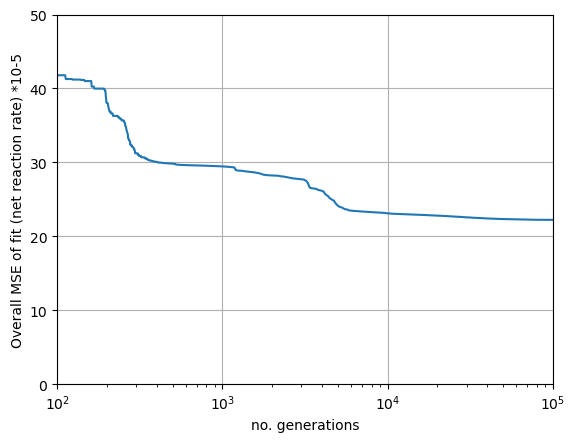

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.999955407180897
1.628694844329572
1.2465424526279363
-4.586166491390946
0.5663691998882846
0.3273357681410391
0.38319020393615716
-3.8403648549230573
0.2305826020567032
3.7812631714048974
2.911471655623294
3.042471266722529
0.2864207212346194
0.017710020751771357
2.694124749703888
5.446433792610805e-08
0.6244194582032827
-10.062410382774633
1.5539224300133985
1.3365431481144394
-9.088898341024642
0.8825989370645592
2.828758090187929
0.026112987773218427
3.1535355443554867
2.6792514925264324
0.9633693938158626
5.902355678437339
-7.98540600846751
2.1917279631496296
1.5074017290240682
2.815818794297434
-4.14693080710901
0.5064505258688967
0.9413573253876101
-1.3010299795544966


In [37]:
res.X

array([-1.19999554e+01,  1.62869484e+00,  1.24654245e+00, -4.58616649e+00,
        5.66369200e-01,  3.27335768e-01,  3.83190204e-01, -3.84036485e+00,
        2.30582602e-01,  3.78126317e+00,  2.91147166e+00,  3.04247127e+00,
        2.86420721e-01,  1.77100208e-02,  2.69412475e+00,  5.44643379e-08,
        6.24419458e-01, -1.00624104e+01,  1.55392243e+00,  1.33654315e+00,
       -9.08889834e+00,  8.82598937e-01,  2.82875809e+00,  2.61129878e-02,
        3.15353554e+00,  2.67925149e+00,  9.63369394e-01,  5.90235568e+00,
       -7.98540601e+00,  2.19172796e+00,  1.50740173e+00,  2.81581879e+00,
       -4.14693081e+00,  5.06450526e-01,  9.41357325e-01, -1.30102998e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -11.999955407180897
1.6: 1.628694844329572
0.9: 1.2465424526279363
-4.3: -4.586166491390946
0.5: 0.5663691998882846
0.003: 0.3273357681410391
0.4: 0.38319020393615716
-7.9: -3.8403648549230573
0.7: 0.2305826020567032
7.2: 3.7812631714048974
5.7: 2.911471655623294
5.7: 3.042471266722529
0.8: 0.2864207212346194
0.03: 0.017710020751771357
3.1: 2.694124749703888
6.000000000000001e-09: 5.446433792610805e-08
0.1: 0.6244194582032827
-12.0: -10.062410382774633
1.9: 1.5539224300133985
1.6: 1.3365431481144394
-11.6: -9.088898341024642
1.2: 0.8825989370645592
4.0: 2.828758090187929
0.01: 0.026112987773218427
4.2: 3.1535355443554867
5.4: 2.6792514925264324
2.2: 0.9633693938158626
11.8: 5.902355678437339
-12.0: -7.98540600846751
3.3: 2.1917279631496296
1.8: 1.5074017290240682
4.2: 2.815818794297434
-4.0: -4.14693080710901
0.5: 0.5064505258688967
1.0: 0.9413573253876101
coeff fit: 0.8846165323358378
r: 0.9405405532648966
